In [1]:
import sys
sys.path.insert(1, '/workspace/share')
from inference import Dev_model
import numpy as np
from collections import OrderedDict
import cv2
import json
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from utils.torch_utils import prune
from models.experimental import attempt_load
from utils.torch_utils import select_device
import torch
import math
import copy

In [10]:
damage = 'combine_crack'
path = Path('/workspace/share')
img_path = path/'origin_data_coco'/'merimen_coco'/'09_09'/damage/'images'
model_path = '../checkpoints/deploy_combine_crack/combine_crack.pth'
#model_path=['prune.pt']

In [21]:
model = Dev_model(model_path,0.4,0.4,damage,1344)

Using CUDA device0 _CudaDeviceProperties(name='RTX A5000', total_memory=24256MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients


In [22]:
data = json.load(open(path/'origin_data_coco'/'merimen_coco'/'09_09'/damage/'annotations'/'total.json'))
print(len(data['images']),len(data['annotations']))

10679 16403


OrderedDict([('/workspace/share/origin_data_coco/merimen_coco/09_09/combine_crack/images/https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831512_8825DFC2-A8B4-A9DF-3CF2479A174A673A.JPG', OrderedDict([('boxes', [[324, 290, 358, 319]]), ('labels', ['combine_crack']), ('scores', [0.6246542930603027])]))])
[[324, 290, 358, 319]]


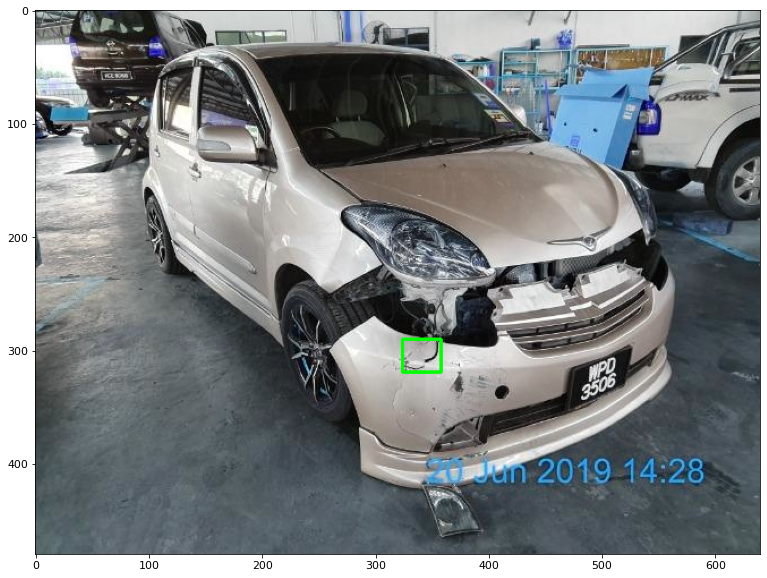

In [23]:
test_i = data['images'][0]
idx = test_i['id']
i_path = img_path/test_i['file_name']
#print(data['images'][14])
out = model.inference(str(i_path))
print(out)
boxes = out[str(i_path)]['boxes']
print(boxes)
i = cv2.imread(str(i_path))
for b in boxes:
    cv2.rectangle(i,(b[0],b[1]),(b[2],b[3]),(0,255,0),2)
plt.figure(figsize=(20,10))
plt.imshow(i)

In [24]:
def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[1]:box1[3],box1[0]:box1[2]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[1]:box2[3],box2[0]:box2[2]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_min(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[1]:box1[3],box1[0]:box1[2]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[1]:box2[3],box2[0]:box2[2]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / min(mask1.sum(),mask2.sum())
    #return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_max(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[1]:box1[3],box1[0]:box1[2]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[1]:box2[3],box2[0]:box2[2]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / max(mask1.sum(),mask2.sum())

def cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels):
    fp = 0
    tp = 0
    #fp_boxes = []
    
    for i in range(len(pred_boxes)):
        ious = [cal_iou(img,pred_boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        
        if len(ious) == 0:
            return 0,0,0
        
        idx = np.argmax(ious)

        if gt_labels[idx] == -1 :
            continue

        if ious[idx] >= 0.25:
            gt_labels[idx] = -1
            tp += 1
        else:
            if ious[idx] > 0 and cal_new_iou_min(img,pred_boxes[i],gt_boxes[idx]) > 0.8 and cal_new_iou_max(img,pred_boxes[i],gt_boxes[idx]) > 0.2:
                tp += 1
                gt_labels[idx] = -1
                #tp_check[i] = 1
            else:
                fp += 1
            #fp += 1
            #fp_boxes.append(pred_boxes[i])

    fn = len(gt_boxes) - tp
    
    return tp,fp,fn

In [25]:
total_tp = 0
total_fn = 0
total_fp = 0

dummy_data = []

for i in tqdm(data['images']):
    i_path = img_path/i['file_name']
    gt_boxes = [a['bbox'] for a in data['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[int(b[0]),int(b[1]),int(b[0])+int(b[2]),int(b[1])+int(b[3])] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    img = cv2.imread(str(i_path))
    #print('debug :',i_path)
    pred = model.inference(str(i_path))
    #print(i_path)
    pred = pred[str(i_path)]
    pred_boxes = pred['boxes']
    pred_labels = [0 for i in pred['labels']]
    
    tp,fp,fn = cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels)
    print(i['file_name'])
    print(tp,fp,fn)
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
    if fn > 0 :
        dummy_data.append(i['file_name'])
    #break
print(total_tp,total_fp,total_fn)

  0%|                                                                                                                                            | 2/10679 [00:00<14:59, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831512_8825DFC2-A8B4-A9DF-3CF2479A174A673A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844614_89B3DCD2-98C2-539C-163510008FDABD81.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808065_F9BC6B55-D039-7752-CE320C7F07B2FB81.JPG
1 0 0


  0%|                                                                                                                                            | 6/10679 [00:00<14:22, 12.38it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795191_565A76D7-CF71-304C-82151974C9450A04.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751061_1A7C6763-C579-DD68-4341FA7E3A213073.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49BC6BDB-EB91-2ABE-EF9E4124DA0ECA1A.JPG
1 0 0


  0%|                                                                                                                                            | 8/10679 [00:00<14:08, 12.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868897_2ACC95EF-B4F3-92B3-EB0D89C116502344.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845051_7AED62C9-C8B5-1BC4-F826C43A96F49077.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D65715-0B7A-0669-E5921C3DFAD84D46.JPG
2 0 3


  0%|▏                                                                                                                                          | 12/10679 [00:00<14:25, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737D3C07-FB9D-ACD9-BFCF9346571C0429.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853753_F496D4FC-BD92-9600-BF0EE8AC531E7DF2.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867544_4AE46023-91C8-207F-5BF5DB26B081BDD2.JPG
0 1 2


  0%|▏                                                                                                                                          | 14/10679 [00:01<14:13, 12.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867643_4ED53F8F-F4B1-A590-F3DB74C546C98285.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746824_D90CCFEA-0662-66BB-F9805D5ABD4A4A97.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789001_213EBBA4-BE24-4216-B305EFDA1978CC58.JPG
1 0 0


  0%|▏                                                                                                                                          | 18/10679 [00:01<14:24, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849236_AE56E15E-934C-49E8-A42D3E742B7A273D.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850445_8C364D22-B9EA-5147-23B55567207A9B40.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855650_C02D5B85-F0BF-BE74-FE023C10FBC28CDD.JPG
1 1 1


  0%|▎                                                                                                                                          | 20/10679 [00:01<14:59, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840618_852E98B9-DF0A-6880-4C98B81182017E49.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868856_1E050734-9741-A530-1AF61F822C6E853D.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834663_94BB5CFD-ED9A-23F3-2D7FFB7D581C1BCB.JPG
0 1 1


  0%|▎                                                                                                                                          | 24/10679 [00:01<14:58, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836935_62BD1D9B-BF82-E762-1DD981A7314EE603.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9704692_78FB4E68-9DFD-4399-201D9311AE4B75EE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836908_B3DD151B-A1D9-5A50-B9B74F08D6EBF6A0.JPG
0 0 1


  0%|▎                                                                                                                                          | 26/10679 [00:02<14:43, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811104_EB51A941-CBBC-1AD1-29345FC3512BAFCD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628723_47636307-C0B8-62C4-90F0B938EF865601.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854642_BB33C5C5-9927-7A65-93000F0967FFD0B3.JPG
1 0 1


  0%|▍                                                                                                                                          | 30/10679 [00:02<14:31, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_7D7CDEC2-FE0E-A748-76CC1560D5B7076E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631615_749DB69F-9F0F-1DFB-DDD9CC1F5F7030F6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855402_E342885A-05C0-61D5-E1FE26A2DE15774A.JPG
3 0 0


  0%|▍                                                                                                                                          | 32/10679 [00:02<14:34, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769645_1370F2DB-B3B7-C1A4-F57C7A115131DAB3.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856083_E86E2D28-0729-FDC1-35AB8A08418826B5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846189_AFB877B5-F836-C251-694FE65A4F3B3157.JPG
0 0 3


  0%|▍                                                                                                                                          | 36/10679 [00:02<14:21, 12.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672309_DFB03F79-F4C4-C5D7-C6640D5D1B637A9B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838897_EDEA89A2-0F0E-A4CC-8642C94F9BDD0856.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781819_831A8785-E2E3-F547-5FDE05D240FCEEB5.JPG
0 0 1


  0%|▍                                                                                                                                          | 38/10679 [00:03<14:21, 12.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9713468_AFDD4D4C-A549-25E8-3EDC7D9BB4DD75D3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867840_B5A7DDFF-ED7A-2652-8AF0027D786976D9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524944_10C12EAD-0147-1E22-954103EF307CE802.JPG
0 0 1


  0%|▌                                                                                                                                          | 42/10679 [00:03<14:05, 12.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644175_67C9C4E1-A7FF-DD32-65326E0685E6D5A7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867538_E11D4EBB-E168-51FF-71BC5278A036E56F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861124_21D8732F-0E8F-8EE5-83C60B3E1AC6EC49.JPG
0 0 2


  0%|▌                                                                                                                                          | 44/10679 [00:03<14:14, 12.44it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855467_93DA0E74-A37D-50B3-00847D65BFF8A0C0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830002_BBF1B673-FFC4-CD40-A04357028C7583C0.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803731_7984E6BB-07A6-6BDD-335CD50B2C1A4376.JPG
0 0 1


  0%|▌                                                                                                                                          | 48/10679 [00:03<14:30, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858114_EADAD7AD-F991-58D4-917E2B46004A534A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782442_85BCCA3B-AA88-386B-289D7C19F771C36B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860305_58FFD327-EEF3-2095-D859E8EBA2E34733.JPG
1 0 2


  0%|▋                                                                                                                                          | 50/10679 [00:04<14:23, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867315_EEE43366-EB96-AC01-C2E98E54A0B223D0.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850755_AFB78905-BCF2-6306-E8C5F91FD81350D2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848064_E360A122-D197-66E3-2A29718479EA7A87.JPG
0 0 2


  1%|▋                                                                                                                                          | 54/10679 [00:04<14:38, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_1636E8B8-B96D-17C8-F3FAF1DF781AA1F7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848463_B2498E7B-0784-0057-D17CDFAE7AA746C3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833769_7ED4ACA7-90D9-4193-AF7FFCB8BFD84FDA.JPG
0 0 1


  1%|▋                                                                                                                                          | 56/10679 [00:04<14:29, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9537887_94FB9040-DC92-CD46-894C57A7510D8FB3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863894_25F85A7D-DB1F-D59D-E1A8A01A32E0D88C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716284_189036F8-9674-4CB0-742E7947AF5EA78A.JPG
0 1 1


  1%|▊                                                                                                                                          | 60/10679 [00:04<14:12, 12.46it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737D1386-0BBA-D1C4-BAC91899B7A84483.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844139_5669B528-CDFE-5AF7-24ECDE0251A46BC1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49BC2874-CDAF-AC8A-35FDC9DA201E47B7.JPG
1 0 0


  1%|▊                                                                                                                                          | 62/10679 [00:05<14:20, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839043_EB0D2333-FFD6-D7D7-D8AA40DD704789DC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B035D622-F19B-BC6B-1B9B4986DC56C1EC.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868678_C1D08848-F2AE-6557-E278EF568F7C6284.JPG
1 0 0


  1%|▊                                                                                                                                          | 66/10679 [00:05<14:16, 12.39it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644472_AFFBED39-9150-D8DE-0808E6C8DE8C0C84.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850457_2EB5FAE4-C67D-23EE-C5EB60F7DA0BB9D2.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843387_AF213DD1-E5EB-AD38-730F9FF493327611.JPG
0 1 1


  1%|▉                                                                                                                                          | 68/10679 [00:05<14:34, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510608_8D451DD2-CB0E-7B58-8965AF7EF05D9716.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854013_C0164EB3-BABB-2DD9-5CE76DCE2EC9B625.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706134_7434A0E7-F208-7BD1-B5F70222310A0363.JPG
0 3 1


  1%|▉                                                                                                                                          | 72/10679 [00:05<14:09, 12.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847193_8064C884-E56C-51A9-1B342A12217EB993.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578569_94FBB4E7-95E5-2988-B0C3C47AAD4C2E44.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836598_53220B5B-E94D-7C52-182148A8D3C7A06B.JPG
0 0 3


  1%|▉                                                                                                                                          | 74/10679 [00:06<14:09, 12.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678033_0DC85C6F-FB4E-2E35-DFB6D1CACF110452.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850990_E4E423C4-9B08-0A2C-E21242CD088CC3FA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861852_27C6A921-EEF6-C25F-8EDEF84C73B3D92D.JPG
2 0 1


  1%|█                                                                                                                                          | 78/10679 [00:06<14:09, 12.48it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864918_21858FA7-F193-2A89-7AEBCB26A5535286.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863421_1760564C-B35E-261C-C94B1BF516113993.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807262_7792B02B-FA44-D96D-0DF2E683E5B033AF.JPG
0 0 1


  1%|█                                                                                                                                          | 80/10679 [00:06<14:08, 12.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860646_335CF8D8-EEC2-70B8-7EA035DDA0A1E360.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760649_75E50E33-ABCD-ECB2-9218F32B37A32197.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835918_4DB4E71B-0F78-A186-BB26F8411E541802.JPG
1 0 0


  1%|█                                                                                                                                          | 84/10679 [00:06<14:03, 12.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631044_4E1D742B-9ED8-2386-FF47C3A4B63C55E0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852148_AF4350DA-A584-4B6B-54265DF182A30366.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816613_FBAD5680-D38D-92C2-261B49E4793E4CC3.JPG
1 0 2


  1%|█                                                                                                                                          | 86/10679 [00:06<13:53, 12.71it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865371_E8AD08AB-F6D0-9BF3-A66E3FF89B404E27.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842443_53DF4D62-D406-0E12-9A461BC368091024.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_46D4B6D6-B99F-9808-F1D8028E89F86657.JPG
0 0 3


  1%|█▏                                                                                                                                         | 90/10679 [00:07<13:59, 12.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786D83DD-99F3-3DFA-AD31D8ED9EE1D098.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841236_4A9534B1-F6D5-0E59-9D9445622615A825.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805988_1EB65B39-CDDA-8441-BB77CEB72EE7ADAA.JPG
1 0 0


  1%|█▏                                                                                                                                         | 92/10679 [00:07<13:57, 12.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805162_55391BDF-C8BD-409C-264B56B529B5F2EE.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862304_FD8EA099-AD14-337E-A53DEB3A8F97D400.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840805_49D3663D-F2B0-889C-8F37FA72B42593C6.JPG
0 0 1


  1%|█▏                                                                                                                                         | 96/10679 [00:07<14:08, 12.47it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868121_5331938E-97F1-EF0A-9519C6FE83E048EC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868845_CE21BD30-0421-8D71-A9F1DF56B486EE65.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837008_CDD96D49-DD69-3EC5-20756A46D77D5A05.JPG
1 0 0


  1%|█▎                                                                                                                                         | 98/10679 [00:07<14:00, 12.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740149_27B37F5C-F202-2774-152DC502250426D0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868798_BEEE273E-CAD5-C249-5ADF4BC527968FF9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9447552_D025665C-F0C1-93A5-7287F19944B046A1.JPG
0 1 1


  1%|█▎                                                                                                                                        | 102/10679 [00:08<14:08, 12.46it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817171_52682138-CF2C-51D8-62EC2CF8696B9F8A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9776074_EC13FEEB-0E9B-5FB0-EDC99CB92E22A5C7.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_4D950FEA-9196-F907-5D16E4EB933A5394.JPG
2 0 0


  1%|█▎                                                                                                                                        | 104/10679 [00:08<14:13, 12.39it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E6FA44-C241-6E2B-AE409FBD41616015.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848464_8E202428-D010-479A-A19E0981FDCF28D0.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782301_81C876D2-D843-AB6E-898A4475CE3B35BA.JPG
0 0 1


  1%|█▍                                                                                                                                        | 108/10679 [00:08<14:17, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835425_92175EE4-9FB8-9227-9928789541ECE12F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833908_593F9E93-08A7-8463-C80D05A27DEB75D8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861243_5166D0A4-98BF-8920-8BBAAF8A398EA3E3.JPG
0 0 1


  1%|█▍                                                                                                                                        | 110/10679 [00:08<14:17, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835628_E50E2FB4-A5BA-46D7-592D1DF9606B642C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9541035_C4896331-A76C-D02A-9E5F4CD44FCF0A34.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_44950440-A266-623D-C6428E359D98D61C.JPG
1 1 2


  1%|█▍                                                                                                                                        | 114/10679 [00:09<14:59, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843673_55BA0A9E-DCF3-3FE6-F3BB723D5A9B7C33.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792251_E2D78B33-0E20-4F08-FC647F6DC9647A83.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840843_4A0C2B43-95E2-B760-5A268237DEF814E0.JPG
0 0 1


  1%|█▍                                                                                                                                        | 116/10679 [00:09<14:42, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853541_E8B7F9D4-DDBA-F79A-936ABEEE318AF4BC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856932_14F50C3A-C9FA-7D61-616E793CC9B140E5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823280_B9337894-084C-75FC-8DFFD95401674658.JPG
3 0 1


  1%|█▌                                                                                                                                        | 120/10679 [00:09<14:33, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836960_DF68E32E-9A88-7DEF-03FE0A682A9C128C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838792_EA724D5B-9F05-D143-F88487F742E94298.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856528_F17E1A59-DFEA-A5B6-67443AB66EDCF7DF.JPG
1 1 0


  1%|█▌                                                                                                                                        | 122/10679 [00:09<14:25, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9771017_E4B18C76-F308-4B40-58E3485E08512396.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849093_AC7C0CA1-BDDA-5318-74FD7885F5486D39.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859874_F22C132C-F6F2-9814-D2FECA1DC0CF4557.JPG
0 0 1


  1%|█▋                                                                                                                                        | 126/10679 [00:10<14:34, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833666_B78DB6BD-B490-F094-CC809905253595D0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803860_78132622-93D5-C8A5-E4B6BC2E7D661C10.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863893_2D12D0EC-0328-C52D-C2370E23AE7AF9E9.JPG
0 0 1


  1%|█▋                                                                                                                                        | 128/10679 [00:10<14:20, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846959_1FA7F58C-99BB-2656-6835C0533D59C12C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC31ED1-C5C5-2373-5FDBD67667EB6B8E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855561_EB0ECEAC-9EE7-ABF4-BA43D4A17508D039.JPG
1 0 0


  1%|█▋                                                                                                                                        | 132/10679 [00:10<14:21, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674180_E1CA79D4-EECA-00C1-78ED6D9D7947B2E1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_53FFE63F-95F7-0596-419890810988FF63.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831297_89154BCF-CAEC-8058-89FEADAFBAB711F9.JPG
1 0 0


  1%|█▋                                                                                                                                        | 134/10679 [00:10<14:13, 12.35it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767056_84C903F8-C39A-4316-DF4F92F9FEF7D9F7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678065_742ABA15-9129-1F69-AAAC4522FED37739.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707195_7A312F9B-DFB1-38A4-72A17A46F61FE49F.JPG
1 0 0


  1%|█▊                                                                                                                                        | 138/10679 [00:11<14:10, 12.39it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797213_13F823C6-9EBB-A9D9-7D458FBDD570D00F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811521_E2ECECF3-9241-3435-E392CD83331FF52C.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849449_983A080F-CF77-1599-0F42D7ED19364770.JPG
0 1 1


  1%|█▊                                                                                                                                        | 140/10679 [00:11<14:10, 12.39it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846639_B2BF064D-0EB2-3509-A55909557EA2E280.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853695_6D0C943A-93E3-6E8C-086C5C3D10EA69A5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855246_BC52FDBD-AF03-AAB1-234A263979C5B151.JPG
2 0 1


  1%|█▊                                                                                                                                        | 144/10679 [00:11<14:06, 12.45it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850445_8C363ED9-F687-45EB-2EA41E5AC10B3A45.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668933_AD500AC3-A851-7345-E07B8F07CC7F3F67.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768645_857C432C-966A-5F0A-98340B9C9199ABA6.JPG
1 0 0


  1%|█▉                                                                                                                                        | 146/10679 [00:11<14:06, 12.45it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839546_F01163FE-EA7E-DE7C-12AC9DFB8CBCAFE4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708115_A502ABD6-B510-A6BF-118073CE71878B82.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558811_80A0AF0E-CD74-32F4-590163C4001A8F8F.JPG
0 1 1


  1%|█▉                                                                                                                                        | 150/10679 [00:12<14:00, 12.52it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851448_B0909B85-CD73-F2E3-A286F91CB0BFD785.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844106_55F4E377-B581-1650-5D9AECA84CA8F63A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868772_F5CDAD0F-EE4B-CBC9-BDC42750994F858C.JPG
0 1 1


  1%|█▉                                                                                                                                        | 152/10679 [00:12<14:03, 12.47it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751188_15240843-9A08-FC2F-A8FF9F6EDA3F80BF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784281_EED727B3-A15E-A930-9D009EC3F4FC349A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839217_B6EFDD18-EF71-C806-36E29A55C827F09F.JPG
1 0 1


  1%|██                                                                                                                                        | 156/10679 [00:12<14:01, 12.51it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746490_D7CA6602-D915-6B41-5DFAC4E7595B0052.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855611_D039954E-CFEB-DE61-8F608F970F977DC5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867868_5A879A2B-F748-44AE-E678FDBA1BACA5E7.JPG
1 0 0


  1%|██                                                                                                                                        | 158/10679 [00:12<14:07, 12.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610419_D9C1C530-BBAB-7D17-FAF73B94D3FCE1E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509986_06723048-B90B-E471-9D69054FC4B975A3.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814764_180584B3-AA5B-1303-E3DA81AEB2608BD2.JPG
0 0 1


  2%|██                                                                                                                                        | 162/10679 [00:13<15:06, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678065_73E61ABB-BF83-4B0A-E0D7812D15DB089E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821867_4AF8D219-C630-9CBD-6E9EA2E8FE89DB7D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849794_602C8009-DB2E-308C-E268896D08EB131F.JPG
1 0 1


  2%|██                                                                                                                                        | 164/10679 [00:13<14:46, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9630935_AAB7C762-EE1C-1004-8D7FFB06FE9CDDD3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762819_1F13AA25-E60D-CE2A-C3DA6C1F1B5EAE00.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835184_06C406DA-EB2A-6E26-40D50C09E1D476F5.JPG
1 0 0


  2%|██▏                                                                                                                                       | 168/10679 [00:13<14:26, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A7B1EEA6-9953-FE2F-804F8D9D640160D9.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863484_1BF0A13A-9ED7-5EC4-839BD497619979C3.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840510_7B6F8393-0CBC-A876-5835527DA348A016.JPG
0 0 1


  2%|██▏                                                                                                                                       | 170/10679 [00:13<14:50, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786562_03CF8233-93D1-F0DB-01C5107A76692550.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864543_E9F966A1-CCD6-4658-71F9BB1E69F967A1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841343_4D638AC9-0E10-9B7B-87596B715128FF0F.JPG
0 0 1


  2%|██▏                                                                                                                                       | 174/10679 [00:14<14:17, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865027_2493445E-067E-CD92-7FD78D3F5A91E3C3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_AF44CA3E-EAF5-9882-E26193EC26D14A97.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863747_87222B64-0D90-8761-B635917B11747616.JPG
1 0 0


  2%|██▎                                                                                                                                       | 176/10679 [00:14<14:14, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854218_283A7CC4-B076-D372-877299C0188F9BE7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843684_E0180F0D-B05F-11D1-AE36E7403FBE5CD0.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853541_E866AC85-CE69-1BDF-8EAD3B89D4F6A767.JPG
1 0 0


  2%|██▎                                                                                                                                       | 180/10679 [00:14<14:06, 12.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49BCFBEF-CD6E-5ED2-3C4A915F9EB02CDD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590422_739FA11D-C2FB-96BF-3FAB8BDC03FA11F0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9446691_923671F6-DE1F-CA99-A3F4FC1F8E1FA927.JPG
1 1 1


  2%|██▎                                                                                                                                       | 182/10679 [00:14<14:12, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677083_80214DC0-DD06-3923-0A95716FA2A85130.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506027_CFC241AC-CD78-6807-7DF4834025F0DE83.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752402_26A292F7-9B00-0FE0-8CC1C419EDCE615C.JPG
1 0 1


  2%|██▍                                                                                                                                       | 186/10679 [00:15<14:16, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846355_7D04A38A-B466-AF2C-111DF315AC0D8F70.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644637_42BE9F78-AF46-36BE-D3D87ED0DE39FA0F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868268_4FEC8EA5-D2B8-31C6-A693A438729CFEE5.JPG
3 0 0


  2%|██▍                                                                                                                                       | 188/10679 [00:15<14:12, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830002_BBF1A5B2-C985-A544-2CE768D0FED8C4B1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_42645EF1-91C5-6718-AE6AC8DCC2BF2697.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818069_1871ECF4-C29A-859E-C798D01A16E34784.JPG
1 0 0


  2%|██▍                                                                                                                                       | 192/10679 [00:15<14:13, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842539_537D686A-FD6F-3CDD-C8AF983F0CD79368.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844275_BCFBB231-A3FD-CF1B-68AE3060EA5A1C76.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679771_15C861DE-0094-F5C9-5D2B95F6ED884C4A.JPG
0 1 1


  2%|██▌                                                                                                                                       | 194/10679 [00:15<14:11, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781775_58B581FB-A431-18ED-BF0622AB06DAE860.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841403_E4F067D0-E0A6-77F8-5D5C7192611AFDAC.JPG
1 0 8
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9541060_FEE20C99-E9C9-A7E1-B39676E3156CB8A9.JPG
0 0 1


  2%|██▌                                                                                                                                       | 198/10679 [00:16<14:13, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9827438_4AEDA86D-C091-6ED6-4F32A81E0CBE74CD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865582_C9E7AD44-9A5B-D316-07150006CE44F90D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834724_BF786385-9FEA-44B4-3BEA1316D76B02E1.JPG
1 0 1


  2%|██▌                                                                                                                                       | 200/10679 [00:16<14:24, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628296_38499D22-0CBF-24C1-A05A248D1D9E3232.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784093_228A250B-EAC9-20C1-F2D61EDB74A40DA9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9446691_923684A1-DDB5-EBF0-1F7265DA39377377.JPG
1 0 0


  2%|██▋                                                                                                                                       | 204/10679 [00:16<14:14, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740997_A73CAD17-060A-44C6-4EE3BD5E77843F4C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749355_E49C5E9D-D07B-7167-27C31F0E4149BA33.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802537_4DC3CF3F-C869-9F8F-E43F3FBE41DB43B7.JPG
0 1 3


  2%|██▋                                                                                                                                       | 206/10679 [00:16<14:01, 12.44it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838817_F1C15A5A-CBB4-580C-6E6B6727A54DEDA5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840937_4835F699-F4AF-5039-49CDA0B5493EDA13.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866230_BB55699F-B444-436A-7E3E4FF6E7BE74A3.JPG
1 0 0


  2%|██▋                                                                                                                                       | 210/10679 [00:17<14:02, 12.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838954_46B06264-CC2A-9943-CCA5C6518FA5D460.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849965_BF83123B-B1F8-2344-4A8A5B43598A3CC8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868396_E9EFC519-D297-54F4-2D9CC74081E5EC90.JPG
1 0 0


  2%|██▋                                                                                                                                       | 212/10679 [00:17<14:03, 12.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794156_EB16F374-D529-69A3-AA9436B0ABDE0C0E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568829_AC41ADFB-AA08-F703-921E94398164D103.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742157_5990D710-9221-0DA7-23D278AE59733741.JPG
0 0 1


  2%|██▊                                                                                                                                       | 216/10679 [00:17<13:58, 12.48it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824108_148BA9DD-E4CA-2929-3DAAA7AFE427C771.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846707_852EEABA-EB26-FB56-92FDCD66057531F6.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852967_4C09CB50-AA80-F271-ED3766349D6F4E52.JPG
0 0 1


  2%|██▊                                                                                                                                       | 218/10679 [00:17<14:04, 12.39it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838466_2E41947A-F133-024F-0591D6258E06A803.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754372_1A7DE823-0FD1-E23E-6ADCA6F5936011C8.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_2472D4F5-EE8E-68B1-2450726102AB05D6.JPG
1 0 0


  2%|██▊                                                                                                                                       | 222/10679 [00:18<14:15, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797443_1E3AED05-CDA5-4ED8-2D41487CA64BFEE7.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863508_B513AE49-059D-6F2B-825F74A7026B6272.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9372623_2BC5B599-B31A-B330-4A16829D1D6403F4.JPG
1 0 0


  2%|██▉                                                                                                                                       | 224/10679 [00:18<14:07, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860931_46110CAA-9965-8255-0CF4116B496FB732.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9800970_5D69DF37-CCF7-01FE-286AE6D0A8F88A41.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826386_1DB49F74-05F0-CA54-BCDEB878D1B5727B.JPG
0 1 1


  2%|██▉                                                                                                                                       | 228/10679 [00:18<14:14, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_25D582FC-ED70-2867-2B621A2B7219B12F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C01B75C5-F9D7-6E61-B9283D22EECF209D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810722_E3A667DD-B521-39C1-6E093E21C61C8063.JPG
1 0 8


  2%|██▉                                                                                                                                       | 230/10679 [00:18<14:16, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754670_E88FEBEB-C561-08F2-5CF7CE7D61C73037.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625902_12F61DA4-E14F-720E-1F3C73559794AFF4.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742232_E264B7F0-AEC2-141F-E3F5D9BC21F4A149.JPG
0 0 3


  2%|███                                                                                                                                       | 234/10679 [00:19<14:01, 12.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809081_4E7C05C3-E681-9A57-E1BBF802135BC8D5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747105_EAD25CE7-F59E-9504-3B44FB1F7C9E2670.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836541_E1786FBB-9F17-730C-ED9340D362B2F2C9.JPG
1 1 1


  2%|███                                                                                                                                       | 236/10679 [00:19<14:07, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775378_1BB66D62-F17F-D77A-41C7C2019D1F47DF.JPG
2 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811022_EBD3F0FD-C519-D995-2BFBDA6C00AD0172.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715906_47183B21-AD80-2938-E72CFF6D3A793B72.JPG
1 0 0


  2%|███                                                                                                                                       | 240/10679 [00:19<14:20, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839201_1E54210E-F9A8-BF28-172CAB69577DBDD9.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861836_419667AB-ADDC-02B1-FB3821B88C8EB638.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763524_777E0679-F713-4925-AC0E745A763DEFC6.JPG
0 0 1


  2%|███▏                                                                                                                                      | 242/10679 [00:19<14:15, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843885_58A87814-0878-90E3-BC74E6210FAE3464.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849267_25312982-0332-3912-6DA66F77AB98AEDD.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861098_F542FFFA-979C-D84F-D8D58BCF21D78400.JPG
0 0 1


  2%|███▏                                                                                                                                      | 246/10679 [00:19<14:04, 12.35it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671225_4BCA8712-C78E-444E-42E94FD06476E126.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716463_80E9A9DD-FAEF-2EC0-4588744D25B81BEF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9800970_5D69DA19-B37F-38FE-CE84E1D03F01E399.JPG
0 0 2


  2%|███▏                                                                                                                                      | 248/10679 [00:20<14:08, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531493_DF288BD1-A813-2093-6B95F39ED2844CB5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_877CB250-FC87-5677-08F552C5C5D630B8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848286_CEDF4905-D90C-AA69-4EC4D79A5F7C0B3B.JPG
0 0 3


  2%|███▎                                                                                                                                      | 252/10679 [00:20<13:59, 12.43it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850281_19C8A484-B1AD-A9F5-864F91F0DC516AF3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9237870_7CCB088D-E855-D854-9BCBBC790A0A91A9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854071_529BB16E-CBF0-5044-4D91BA291371F389.JPG
0 1 1


  2%|███▎                                                                                                                                      | 254/10679 [00:20<13:58, 12.44it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841726_BA9FE41D-D30A-6389-29AEED95925B603D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862659_7DCC3EB3-E72C-1E13-1CD366C509A1401F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743261_5DFBCFA6-055E-025A-248C3AAD0CAA8F42.JPG
0 0 1


  2%|███▎                                                                                                                                      | 258/10679 [00:20<13:53, 12.50it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841846_4E844177-9B54-48B1-CC4E1A6829EB4D82.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846978_899C3FA4-ADB8-F0EF-37D3FAAC56A31603.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9232925_45FC5F36-E0EE-05B4-7327681A855B5FC4.JPG
0 0 1


  2%|███▎                                                                                                                                      | 260/10679 [00:21<13:55, 12.47it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822570_47A7DE0E-FF75-2E99-33FA79122C07883D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841926_515F9F53-A9D8-9180-D02ED1B4270D40B9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818944_5E5E8AAD-EB13-EA22-F3182FC3C8A0E9D3.JPG
0 0 1


  2%|███▍                                                                                                                                      | 264/10679 [00:21<14:05, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849671_885484C5-F40E-BB97-29E5748E1BF83A33.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838525_E61164C3-9EF8-8501-F0D090CE45FB26A0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9291791_7FADA873-B429-62AD-1210957C4965A7E6.JPG
1 1 0


  2%|███▍                                                                                                                                      | 266/10679 [00:21<13:55, 12.46it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863812_1FFED52B-DAEC-B3DE-35A6F3678466FC65.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852169_AFCE2C49-B6B6-AAF3-6ED077C801494F19.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631053_D1337CE2-A5B4-4A4C-7D1A622D12197585.JPG
2 0 0


  3%|███▍                                                                                                                                      | 270/10679 [00:21<13:58, 12.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867171_2B411908-DDAF-2A40-A8FF2C2E0B681E97.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_50FE6B96-E15D-01A1-14C24EE88D21B4B2.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9253159_2D020CC8-B38A-6961-81DDE1A876DA9B6D.JPG
0 0 1


  3%|███▌                                                                                                                                      | 272/10679 [00:22<13:58, 12.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840829_4B09128C-A4ED-48F5-A98669E5A53E6020.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782530_85FB11D0-CFA5-BC7A-AA7F6F4083539C80.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_FAEBCA11-DD6F-6B0B-F5E7FEDAC1B4661C.JPG
0 0 1


  3%|███▌                                                                                                                                      | 276/10679 [00:22<13:58, 12.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834521_63DD1054-F206-F940-0B9186ABDF92159C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9764673_B244D110-D080-6A16-65A42F0C02D9E089.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712741_3F4AFB15-F65A-5D44-D9CB29E44B463964.JPG
2 0 2


  3%|███▌                                                                                                                                      | 278/10679 [00:22<14:29, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855090_5A8F79EA-B1C6-317C-A31EB31887A156C5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_F0D632B9-FD5F-C894-ADF11A215D95E711.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_4292A88A-BF3E-05FC-7F35545AC7C38761.JPG
1 0 1


  3%|███▋                                                                                                                                      | 282/10679 [00:22<14:25, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804440_523D0F6E-054B-487E-A99CB9DAD7278DCF.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852048_8D933539-F5FD-6F4A-6FD521F55573B739.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831934_5284C8B6-BB5C-AE8F-2E84075E46866B6F.JPG
0 1 1


  3%|███▋                                                                                                                                      | 284/10679 [00:23<14:42, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831629_555EF471-A68F-4B5F-DAD75880E7C67766.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837912_088C65D8-E1CA-E3F8-1FD16BF4D092C3FB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C93572E-9224-114A-2B8B097AC66CA617.JPG
1 1 2


  3%|███▋                                                                                                                                      | 288/10679 [00:23<14:21, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862838_4A953D62-A010-1D62-4B15561C3D4D9466.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836422_BBD588CD-A40B-572F-F53B4AE4B441B767.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859598_C3A4FEA5-9C28-A37A-E26B84DAC706C619.JPG
1 0 0


  3%|███▋                                                                                                                                      | 290/10679 [00:23<14:12, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868394_5AF4F02B-DEFF-DC59-AF65E8534559BA28.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841559_8657ABB4-973A-455E-62522374088463AD.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739899_D7F668A5-B325-6B0F-92A7ECE99BA20242.JPG
0 1 2


  3%|███▊                                                                                                                                      | 294/10679 [00:23<14:08, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840798_2EE031B1-BFE0-DC84-22653EBA7604098C.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667999_B4138170-CEA3-09C9-225E5DCB0A6F44E8.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762819_13B94305-A3CF-C99C-5DA2ACF10B51B4B6.JPG
1 0 1


  3%|███▊                                                                                                                                      | 296/10679 [00:24<14:04, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680083_3DCD9EE5-0300-6A9D-7382BB5BBAAEBC53.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853313_B94CD773-02F6-A25A-DD11E811FD3B6616.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763163_7AC4957F-D9DD-3828-65AB03452EDDFD89.JPG
1 0 0


  3%|███▉                                                                                                                                      | 300/10679 [00:24<13:59, 12.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841482_AA410E23-9F50-B0BF-7747D0E012DAC41F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857642_E5FA357A-D4A1-6AC2-7AEB0D344B2A212F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851980_B5E56209-018E-B47C-BC675B96DD973212.JPG
0 0 2


  3%|███▉                                                                                                                                      | 302/10679 [00:24<14:21, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_5DF953E2-AD19-05D7-4D487C133A8B91DE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840972_6A64DE6E-E101-1283-6B5A68474E32018A.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524213_058871E7-DB92-CA58-EF0DE634A7E1E08E.JPG
0 0 2


  3%|███▉                                                                                                                                      | 306/10679 [00:24<14:30, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573553_188AE365-9844-6A77-A567B89F22357C07.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854344_E9270F25-A222-C905-340AD61FBB701DD9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855183_F3A88C2C-9583-30EB-0BF5A84A3B91B289.JPG
0 0 1


  3%|███▉                                                                                                                                      | 308/10679 [00:25<14:29, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828142_82A7FDF6-9713-07BE-FAD987ACD66375C0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509356_65DA97A4-9AE6-EA60-C3B4F91C2BB98C01.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855215_F007D1F3-ED10-A381-115387EFA63F84AE.JPG
2 0 0


  3%|████                                                                                                                                      | 312/10679 [00:25<14:17, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841059_55CFBF60-D84D-5670-002FEBBF1C40674C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_88E145EB-D32D-7514-72B67BAFAB56D1CD.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786562_03CF8C82-A429-D6F4-662C087DF6A45568.JPG
1 0 0


  3%|████                                                                                                                                      | 314/10679 [00:25<14:14, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868796_57461E50-9D3D-A101-3FDCEE3DD1AB4A29.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831297_88ED0E1C-E5F9-5721-EB92EF55D26D8E06.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792745_E735181F-A0C3-47A8-80446AFF59A92D42.JPG
0 0 1


  3%|████                                                                                                                                      | 318/10679 [00:25<13:56, 12.38it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847137_22CA298B-A672-02B3-1F651707BF611E87.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_5DDF36B1-B347-66F2-ED905917B53279E7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816265_4390D176-EE36-7D89-BAB37A22A3F6B1F4.JPG
0 0 2


  3%|████▏                                                                                                                                     | 320/10679 [00:26<14:03, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841115_EE68C579-A6AE-A2A4-4193E27945E27F26.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582496_0171A484-E94B-D253-D912B8B78840B6FC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508305_0DF068D5-DF21-0F2C-2C8B9E6D255BFF8E.JPG
0 0 1


  3%|████▏                                                                                                                                     | 324/10679 [00:26<13:58, 12.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847160_68423822-0E70-FA52-16F031A0BBAD7DF6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849786_F5E0C914-0D9E-BBC5-35CBBAC389EB1927.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C269280B-B47E-FEAB-170F83A726ECC859.JPG
1 0 0


  3%|████▏                                                                                                                                     | 326/10679 [00:26<13:55, 12.39it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817256_068E26DE-975A-7866-6BD0CB143F8C7627.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862714_15E74ECB-ACA0-AA92-604E94793CDCF263.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_BEBF3A31-CB73-8A8C-ABDDFB9AE3EED1C4.JPG
0 0 1


  3%|████▎                                                                                                                                     | 330/10679 [00:26<14:13, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707387_E104D24F-EB3F-0F75-60F4C707CD2A2566.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843019_B22616ED-AECE-55EA-CB6E8AFD82BB22A1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_158E902E-B1DF-BE3A-051E33702EBE53C3.JPG
0 0 1


  3%|████▎                                                                                                                                     | 332/10679 [00:27<14:07, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850121_227810FD-D9EA-623D-E0928C2F5CCD0556.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843769_6603A86C-FA8B-F723-6E04DC62404F0463.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840774_4DECBF41-AA41-3BEA-C21031357FBA37F0.JPG
0 0 1


  3%|████▎                                                                                                                                     | 336/10679 [00:27<13:58, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838123_EBC5A6D9-B2DE-C9D3-7764F9DBA6EB2851.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741928_AF335C10-BB0F-F6A2-7D5CEADA0A999AA9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855264_BCAC53D8-EE42-BD8B-5CDFD0DEAE876FE8.JPG
2 0 1


  3%|████▎                                                                                                                                     | 338/10679 [00:27<13:58, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590691_6790405C-ECBF-3483-92578579C4E0E215.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867720_300ADEB7-B516-858C-3B5398791D4146F2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531141_61944D07-CCB8-FAFC-CFBF837F1906C1E6.JPG
1 0 0


  3%|████▍                                                                                                                                     | 342/10679 [00:27<13:51, 12.43it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_8925914D-082F-3B4F-40F9EC94AC38DD90.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850543_FA111D79-A01F-E294-D36434867D92B9E2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860994_17A34F61-0511-5C1B-D987C4ED45E6485A.JPG
1 0 1


  3%|████▍                                                                                                                                     | 344/10679 [00:28<14:32, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795233_EDF2990F-0A37-6E6F-071D59A748D694E3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855650_B34985D5-B62F-F526-2B787F5E6B8E23CF.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782791_81EEBB3F-0111-06B8-13E51A351978F84A.JPG
1 0 4


  3%|████▍                                                                                                                                     | 348/10679 [00:28<14:17, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850934_95D633A9-B358-8AC6-D78619AA2F9270B5.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850178_B51FBB63-03D3-E75B-480562FC3C1EF6C1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843088_E027140E-D9C2-24D9-30CF832C1973CE06.JPG
1 0 3


  3%|████▌                                                                                                                                     | 350/10679 [00:28<14:09, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762716_11E29CB2-0593-5A8A-2F984EE807C674AE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841988_C9E876C6-009E-8D5A-200EFA7F300DBF36.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744327_B5E947DA-D9DE-6D93-5888E9A5430A9627.JPG
0 1 2


  3%|████▌                                                                                                                                     | 354/10679 [00:28<14:22, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858380_8D51FDC3-A38A-E2A2-2A493A0DCFD4784E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753174_10AD994A-BE41-E227-09A380E9173BFAA2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_48A2A76C-A81E-C07D-AD7A90196FFFBA12.JPG
1 0 1


  3%|████▌                                                                                                                                     | 356/10679 [00:29<14:26, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863804_1B3157A6-B4BB-B553-6C98A6AA3DE1235B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562910_DBF188ED-FD5A-B311-204DF4D4777634AD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9685905_70489A9B-9996-821F-E7A25E69B665B711.JPG
0 1 1


  3%|████▋                                                                                                                                     | 360/10679 [00:29<14:09, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C26398F5-D166-AF0F-AD68D37A0230B3F2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844893_8BC7DE61-D101-4B30-7D294388CF43E282.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867280_950FDF05-07E2-9F0B-527096D1AB6FC35B.JPG
2 0 0


  3%|████▋                                                                                                                                     | 362/10679 [00:29<14:03, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865564_316D0DE9-BE5E-A1BC-2C18154806501CD4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823374_EAF1CBA6-DFC7-7588-57E13C5ED2674D00.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825595_5794D983-FEDC-7DB3-E04CC7B383E6E9D1.JPG
1 0 0


  3%|████▋                                                                                                                                     | 366/10679 [00:29<13:51, 12.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_26183630-C4AA-BF80-B450A39492FA0A23.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_EFD2BA0A-DC4F-7C5B-AD17A479E77ABF25.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844674_C34E08B5-C6FF-4C82-50F23A90109F71E4.JPG
0 0 1


  3%|████▊                                                                                                                                     | 368/10679 [00:29<13:50, 12.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852427_B76F1CB6-0625-C071-F1B3CFF2B0C61C32.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629410_D76DCDEA-0957-FA2F-8326E00077FF64EF.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848064_B54C0BF4-DBFA-E1F8-F327922EB7ACE1B1.JPG
0 0 2


  3%|████▊                                                                                                                                     | 372/10679 [00:30<13:47, 12.45it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856053_30FFB414-FD9C-918E-235BF72F06FB2FAD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863318_2B316326-A704-BA27-21182B4621A0F539.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867506_4FC658C9-DD8D-4F4A-CCAB7B3E548C0BC6.JPG
1 0 0


  4%|████▊                                                                                                                                     | 374/10679 [00:30<13:45, 12.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852558_F16DAD19-C348-91A4-F2D48C02B197EA23.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9292143_5B1B6055-BCAB-5982-8422B35B19C3F56C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868602_260B311E-0234-7BBF-BB699EDEED8A9B90.JPG
1 0 1


  4%|████▉                                                                                                                                     | 378/10679 [00:30<14:03, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_E8D26206-B726-FEAC-880F27967F5AB8E6.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794156_E9855728-B050-3BFF-B3B83B231986A607.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853677_E9D5E21C-B74B-396D-96AF69CEE0EF6522.JPG
1 0 1


  4%|████▉                                                                                                                                     | 380/10679 [00:30<13:59, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851778_F288782F-E54B-AF51-00388E6961F76C90.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834041_6322F8D7-D937-8EBD-724C752290760182.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609212_12E21325-B896-8CAC-CB32E9C1A5FB2D12.JPG
0 0 1


  4%|████▉                                                                                                                                     | 384/10679 [00:31<14:20, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769247_B79F5BA8-E1F9-10FA-756D551C9067CA98.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817657_22372601-EE1A-6FEC-E4D8337918206007.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847945_8C15D58E-900B-585F-5C709D1991E89A7A.JPG
0 0 1


  4%|████▉                                                                                                                                     | 386/10679 [00:31<14:08, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779639_1FDB965F-0AD8-7464-0B18859C6ECD585C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609427_1E1221BE-08D8-6194-AC821B4650A6BCB1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844170_55984DA4-0CAE-736D-19AE2080CCFF15A0.JPG
0 0 1


  4%|█████                                                                                                                                     | 390/10679 [00:31<14:16, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839201_1E541118-F77A-8B0D-959ADA350A3E46F3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858086_E7F0995C-F6FB-A3DD-7E883CB8DC4FD86A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789001_213EAF29-C34D-58CB-CF853BA85D303D77.JPG
0 0 1


  4%|█████                                                                                                                                     | 392/10679 [00:31<14:16, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837941_E320105C-0D9C-0DDA-8603267EE509742B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852952_B95C88B9-EC65-C36B-A49104B88EC5A268.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9244153_C0F351C1-A3EB-A142-1F59B981593D50F5.JPG
0 0 1


  4%|█████                                                                                                                                     | 396/10679 [00:32<13:59, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838466_2E41A933-C84D-80CE-6C0775C27C03B30F.JPG
2 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854325_BA37CDC2-F6AD-69E8-0E1B9C2ABE01396B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_2352887F-C04D-F029-F9505B26D2090672.JPG
1 0 0


  4%|█████▏                                                                                                                                    | 398/10679 [00:32<13:56, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846461_BA84DB10-B86C-D6C5-D9D73A9BE0896E40.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775308_EA7D7F76-D871-2D97-08D5FB0E08ABF726.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_B90F0185-B87F-EBE3-326D8091DE2F63AF.JPG
0 1 1


  4%|█████▏                                                                                                                                    | 402/10679 [00:32<13:53, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849913_B9541332-B2D2-0B88-A6883720BCFE8EC5.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702017_B7096292-B358-5362-B67A43E84F575AE7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751114_27225A04-AFD4-D4EE-6CB85BC9F341563E.JPG
0 0 1


  4%|█████▏                                                                                                                                    | 404/10679 [00:32<13:52, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767035_82872756-F59E-29E0-A4F58C5CA265E130.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841718_FA7C4253-A76D-898B-BD80D0BD00E85F87.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8B01EBF9-0E4F-5E31-EE0BF857977F578E.JPG
1 0 0


  4%|█████▎                                                                                                                                    | 408/10679 [00:33<14:00, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867281_1F846AED-924D-FCB6-346938D6A257AA43.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AA3A4E-B632-8D0C-9700CB17AAF2FEAE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834090_B637CF0B-A8FB-DC43-12672708417BCFA4.JPG
1 0 0


  4%|█████▎                                                                                                                                    | 410/10679 [00:33<13:55, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_87718C9B-F329-DA54-6176477C7AEDC87D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867954_53C38D54-DC9A-378E-D0137592C23E2152.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_E2F101B9-EC9C-51B9-7C4E96BDD53C4652.JPG
1 0 1


  4%|█████▎                                                                                                                                    | 414/10679 [00:33<14:08, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809147_47877BC5-0A21-CFAC-03E04E2CFC2264DF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844159_E8656878-B762-1E52-182A7964706839F6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836357_BDE8928F-ACBD-2D3E-98D0F4DA5D06ABEE.JPG
0 1 2


  4%|█████▍                                                                                                                                    | 416/10679 [00:33<14:05, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49AFA072-CBC4-49A3-ECD88E67716DA819.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842778_7CA65948-C73B-A251-110ECDD9E1BA5889.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822405_49011775-F18E-3BDF-7D48B69DA66E395A.JPG
0 0 1


  4%|█████▍                                                                                                                                    | 420/10679 [00:34<13:48, 12.38it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833642_E3BE2D76-9808-AA58-84FE0818663EB662.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833738_950E156F-F8A1-5633-DA009B82642C2325.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559102_6AF472E1-E065-69E8-AE9DA8882855F443.JPG
0 0 2


  4%|█████▍                                                                                                                                    | 422/10679 [00:34<13:45, 12.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864288_5D962EB6-CDA8-BE19-EEEE77D84AF55397.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777372_EBF834E2-087D-F13B-F201C7C2B32AB134.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667840_38DA1B75-C5A6-ED41-A9232CC2E02392CE.JPG
2 0 0


  4%|█████▌                                                                                                                                    | 426/10679 [00:34<13:46, 12.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777775_E826E490-F2A4-0BEB-208D0669F4B523B7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9796918_1ED6C0E2-BEA3-6F4E-ACA8AF132AC0E048.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772545_1FEECE00-9936-5199-1AE343B120DEA54B.JPG
1 0 0


  4%|█████▌                                                                                                                                    | 428/10679 [00:34<13:39, 12.50it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760869_73166AC8-DBEF-4FFC-68C54D480063BA37.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737E545E-B566-68C7-331A88F3A4348A7C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710938_AAE9B9BB-BED6-39FE-17FB0380A20F7C57.JPG
0 1 1


  4%|█████▌                                                                                                                                    | 432/10679 [00:35<13:43, 12.45it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863322_1CFF00B4-F70B-6E05-EAC54BC37F3BE3CD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851906_B0F506C0-EA53-3DF1-99706EC72D3C7124.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751259_12BC73CD-9AFF-3203-DD6665517783E8D3.JPG
0 0 1


  4%|█████▌                                                                                                                                    | 434/10679 [00:35<13:41, 12.47it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9563103_DCC55F0B-BFF0-7560-D671DC0B2D85D7D7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C27565AB-914E-FD7B-A9EAD4DDED58D2CA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508292_09712227-97E4-F349-3A9094DF46CA7FF4.JPG
1 0 0


  4%|█████▋                                                                                                                                    | 438/10679 [00:35<13:44, 12.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_50FE4435-E30A-AAE7-53773C0E22C62F77.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851578_8A50C7E9-DE72-6098-8BC194EC3031BA4D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763352_7A0AFDA5-B3A8-070D-928B90FB4F66CD0B.JPG
1 0 1


  4%|█████▋                                                                                                                                    | 440/10679 [00:35<13:49, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BC93E52E-9AB1-7DB7-877A69EB5B199F43.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841926_515FF727-F36F-D797-BB46B1D8B5A810ED.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8B016E20-AC79-ECD3-58A19BCAAB9ABD32.JPG
0 1 1


  4%|█████▋                                                                                                                                    | 444/10679 [00:36<13:44, 12.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682119_E293BAB3-F937-D37B-DC2C7D2F74F5ACA5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836538_593F2859-95A0-E303-5F74144163FB900E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751910_4C0E7198-C1C2-CC70-68A80D7FBFDDF79F.JPG
0 0 1


  4%|█████▊                                                                                                                                    | 446/10679 [00:36<13:40, 12.47it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854767_63501E21-EB87-C9E6-E8C3A60758D0651E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834080_B0DB82C5-026F-1AA5-A6541B139CCAC474.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811521_E2ECF3B2-F0A3-AD84-28B60FB16B4503FA.JPG
0 0 1


  4%|█████▊                                                                                                                                    | 450/10679 [00:36<13:35, 12.54it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856932_14F507F8-BF26-C95C-5FB5598135D15BD5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672313_8117B5DD-AE58-4C5A-7FF18318732B047F.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624427_08102262-D904-282A-A2DBAF313F3600C2.JPG
0 0 1


  4%|█████▊                                                                                                                                    | 452/10679 [00:36<13:33, 12.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578059_74BDDB80-A1DD-F6EC-D5CB6D14F1A3EC45.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782722_461B435D-0283-BEC7-08BF02C193842C68.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842778_7CA64715-9231-8531-E264A34DA2320B42.JPG
1 0 0


  4%|█████▉                                                                                                                                    | 456/10679 [00:37<13:35, 12.53it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835184_BB47919A-BF07-F3FF-4FA4B94466D438A1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867840_D7E0F3EF-9BDE-6074-A96D151928ACA0DC.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_2351A4DA-FFD2-FDA7-231BEA4CCABABB12.JPG
0 0 2


  4%|█████▉                                                                                                                                    | 458/10679 [00:37<13:49, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803513_48CCA822-FD92-8BAB-9F7DAA3762A10D07.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824942_51631FEA-ADB7-C9A4-DE8B69E23D7B411C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824389_8EE74B20-DB89-0432-CB4E1C407D739CDE.JPG
1 0 2


  4%|█████▉                                                                                                                                    | 462/10679 [00:37<13:45, 12.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840510_8A558A86-BC2D-5B4C-FD285DC5B332FFA4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844228_8FA8B4BF-EBEC-C775-57B5FA2FD78FC7B2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841812_19CF8F0D-04E1-2D37-B36743D38E75BA07.JPG
0 0 1


  4%|█████▉                                                                                                                                    | 464/10679 [00:37<13:40, 12.44it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838287_021F98C1-DF96-985C-81EA491F51854116.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679028_D7216368-E8C8-C2AC-0A4FFD4547ED16F1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821799_4F3063B0-9371-A4AE-2C623D432B271D29.JPG
1 0 0


  4%|██████                                                                                                                                    | 468/10679 [00:38<13:55, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_46E668AE-B2EB-02FC-893A81D75C0DE79C.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743291_749D75FA-B8AC-4878-6AC81C246706D19E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581643_3EA2D016-C7F4-60BB-E35431B279D5310F.JPG
1 1 3


  4%|██████                                                                                                                                    | 470/10679 [00:38<13:48, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856570_3486D45D-D1B6-6814-DEDE3ED4274F9732.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869129_E9352EEB-C945-5BE6-57F906862A55F852.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770133_22ADBB27-DA96-6694-EAA71CE00A6B167E.JPG
1 0 1


  4%|██████▏                                                                                                                                   | 474/10679 [00:38<13:52, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C93EF35-E3E0-9577-1C2C8B45232B9D20.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833877_E23B12F3-E968-AD49-6C982CC06F8BBFFF.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865371_BB04ED33-0D65-CBF6-241113EF572A0E29.JPG
0 0 1


  4%|██████▏                                                                                                                                   | 476/10679 [00:38<13:49, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523310_FAE1F06C-DE61-4E70-6CF39D97916D9740.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816613_FBAD4990-D259-8B8D-2AE74F1D94EAC65C.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678065_73E61E12-F98C-6CCF-B3456C9BA1F5EC3E.JPG
1 0 2


  4%|██████▏                                                                                                                                   | 480/10679 [00:39<14:01, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835502_E09754EF-D7A9-734E-1FFDF48AE1E22629.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844393_5A5A7E22-A42E-2769-FF8CF53898BC64FF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853442_1B8F74BA-DA31-262D-DBB8B791EAA6E404.JPG
1 0 0


  5%|██████▏                                                                                                                                   | 482/10679 [00:39<13:59, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840843_4A0BD1EB-CC52-EDD4-70B7B4751D954A3B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559030_011E97D5-A399-0B88-0958A6C1EC7D18BA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852798_CF35882E-94F5-AB8C-FDCE5F06E3E999CF.JPG
1 0 0


  5%|██████▎                                                                                                                                   | 486/10679 [00:39<14:10, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_16C7B540-BB99-5BC0-6F307379C824B845.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846443_7F945C3A-A507-1828-6F148367B38F417A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862689_14FEE02F-C5BB-2B09-878749B84E912F7D.JPG
0 0 2


  5%|██████▎                                                                                                                                   | 488/10679 [00:39<13:56, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621338_DE559BC4-C8FC-2044-F9CE36F124AE4BD4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834149_B2D00AFE-A215-A11D-14DA0990AEA366D6.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707122_7A09C76D-A45F-2704-359BE5130409DBF3.JPG
1 0 0


  5%|██████▎                                                                                                                                   | 492/10679 [00:40<13:54, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A6BE9652-A84E-98E9-AF88E1B2727B8CCD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779820_1E1A0E59-D0A1-2E46-CE4F66232A47C91E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9608770_3EBEB91F-DD9E-7754-A7A32B7DC2F3BA55.JPG
1 0 0


  5%|██████▍                                                                                                                                   | 494/10679 [00:40<13:49, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673209_085C97F5-F9DA-81A6-A0C91330E2AEF429.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854145_B865E458-F49D-7F16-9C52538339B1FB1D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847159_B50ACEA5-9BBA-587E-1CDEC05E549533E1.JPG
2 0 1


  5%|██████▍                                                                                                                                   | 498/10679 [00:40<13:46, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847516_F336D0DF-0AF2-FD5A-57A7D6607DDCC0F1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_532DEAB5-B2D0-A7A7-3BDF835C224E1674.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840164_940F955F-C473-B966-505777D6E173E83A.JPG
0 0 1


  5%|██████▍                                                                                                                                   | 500/10679 [00:40<13:40, 12.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802912_519984C4-CC2D-F8DF-F7CBFED0E4339E24.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868906_B60B409E-94C8-18FF-B5F84109FD834AE9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842177_10F18C2B-B270-1F77-5069AEF2B8A3A427.JPG
0 0 1


  5%|██████▌                                                                                                                                   | 504/10679 [00:41<13:48, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839319_B187905F-9689-91F4-D031B07C9298D373.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_87371A4F-08C8-4239-3E6ABAAB99BA2F1B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836205_BAAAB39E-F3EA-8700-35CD789D700F0F59.JPG
0 0 1


  5%|██████▌                                                                                                                                   | 506/10679 [00:41<13:45, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505652_96963435-0EB0-3D48-089765ABC8EEE932.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768645_1235211F-D879-9DF5-95022E42C1AD91A5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681985_C12F8B70-C286-FF30-313B08030C73AA88.JPG
0 0 1


  5%|██████▌                                                                                                                                   | 510/10679 [00:41<13:37, 12.44it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BDFBE9E4-9065-946C-A1DDF00A1EB108B5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863108_EA2397E8-AF25-EE9C-48A1C6E7939D2A75.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845900_7AD7AD2D-D47F-1DF2-3681D58993075465.JPG
0 0 1


  5%|██████▌                                                                                                                                   | 512/10679 [00:41<13:38, 12.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840618_852DDEC6-95DA-1F81-C6F83678D3B8F28F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509323_099DFED7-AA14-08A6-F8679BBB3457C8BC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746675_D9E3DED9-E2C3-10BA-5A1421E62B38BA42.JPG
1 0 0


  5%|██████▋                                                                                                                                   | 516/10679 [00:42<13:45, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820865_2DC1BFBB-A526-FC75-A076BE19A10BA21F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840220_24FCA981-FD7C-EB96-1D9C87B936E8D12C.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499744_3BB12D96-9531-FA93-1FDFE82B48B7327C.JPG
1 0 1


  5%|██████▋                                                                                                                                   | 518/10679 [00:42<13:44, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743953_80C02BD9-0C28-C132-410651DFD3366B4F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9541060_FEE1FE17-B50B-3459-589F6700C2DCD1CA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836564_C72C146D-0E39-F9F8-767E7FC17A21F62B.JPG
0 0 1


  5%|██████▋                                                                                                                                   | 522/10679 [00:42<13:39, 12.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859735_EBD6231D-D1A3-3CD4-120F765FF5C4B664.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BDFBEBE7-D99C-79E0-B8C0F9E24DBC344D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803860_78131B5F-CF5E-7C19-8F71B0E74C7DA90A.JPG
0 0 1


  5%|██████▊                                                                                                                                   | 524/10679 [00:42<13:43, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847857_6A1F9892-E5D2-2323-4E5994AC946AFA7A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711319_A8AA6F4E-C9DC-8BA6-23714348A545B1F7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845732_625E1487-B1CF-F42A-27E72FD6625DA2AE.JPG
0 2 2


  5%|██████▊                                                                                                                                   | 528/10679 [00:42<13:36, 12.44it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9236325_E6687AAA-E1FD-A25C-6D911DC5FF8C6DE1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838466_E5DEBD5A-ADDC-5BE6-7E2B0BFFE7912D96.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843924_AE3D0547-D4E9-33F9-DE4170CF927BCE9B.JPG
0 0 1


  5%|██████▊                                                                                                                                   | 530/10679 [00:43<13:34, 12.47it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857702_15E63598-B883-25DA-629C84CB426DB17A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810722_E13A2472-CCC1-0D0D-21A42FDCEC7A13C7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824108_8CFC9130-9B03-1D9C-0AA1DA1809B5C1E4.JPG
1 0 1


  5%|██████▉                                                                                                                                   | 534/10679 [00:43<13:49, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233392_1F1CE166-B226-FE55-34C02E4A77220132.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833791_1483FFD5-C805-64B2-77F249E8A088C395.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509585_03CF778B-0282-0DAA-F3B878B4A9D004B9.JPG
1 0 0


  5%|██████▉                                                                                                                                   | 536/10679 [00:43<13:42, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867638_53A39D36-EDD5-EDCE-A7C7332A424CF8A8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715860_A0C905A5-9AEC-BC10-E4CF06AFDB8A49C2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847328_8ADE80A7-C9EB-9426-1B2FE98999E5CAEB.JPG
2 0 0


  5%|██████▉                                                                                                                                   | 540/10679 [00:43<13:40, 12.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568409_6B10FF96-F14B-C3ED-582FC54EA40E77ED.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783710_8731AF1E-ECD7-5B07-B259F1650E1A8285.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847093_7E224F24-0D8F-8781-F6D1F9F2CE4800A9.JPG
1 0 0


  5%|███████                                                                                                                                   | 542/10679 [00:44<13:41, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841553_F37A4E25-D9B8-D185-D024FA4F2FA2ABC0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863301_25B270CA-0D75-89F3-51C42175FBA6466F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842272_9999B95C-B11B-0DB1-A56F7AAB750E7C32.JPG
0 1 1


  5%|███████                                                                                                                                   | 546/10679 [00:44<13:43, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857761_1FBF856E-D312-525A-F6E39B574E783CEB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624748_0EEF20E1-D057-3935-F9F39ABFAC82AEFE.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836834_E765F924-DFE2-FFBB-257411D22A83917A.JPG
0 1 1


  5%|███████                                                                                                                                   | 548/10679 [00:44<13:41, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523148_996034F7-EBA7-20D6-86F9C7E1E4C64336.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846443_7F8CF8E9-A1D5-831B-DE92AA314AE5F515.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819645_9100DA53-AA81-E594-BFE69831AA758AE3.JPG
0 1 1


  5%|███████▏                                                                                                                                  | 552/10679 [00:44<13:41, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711319_AEB2B270-E2C7-1949-01AF7AD58CAC58AA.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838298_EB9D70E9-0086-D72F-FC0A041F3F7445B6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679028_D7210095-DD23-EB17-0B01F2285EF700D3.JPG
0 1 1


  5%|███████▏                                                                                                                                  | 554/10679 [00:45<13:35, 12.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865039_26A5D54B-0628-720F-152968528C323F94.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705559_A3CF070B-D8B3-9042-5A3A4A1FE1FB2912.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859913_F0244558-A4DC-FEF1-21A568406A3EE035.JPG
1 0 0


  5%|███████▏                                                                                                                                  | 558/10679 [00:45<14:01, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829230_EC11027B-EA8F-8FD1-A643315B4D4E217D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782301_81C815CC-0756-485C-27838A4E60ADB17D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855561_1F8184EB-B51A-4C99-1C8F1469952695EB.JPG
1 0 0


  5%|███████▏                                                                                                                                  | 560/10679 [00:45<14:22, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866097_307838E2-D8D9-99FD-7C040E8CD5385F01.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856098_261162F2-E61B-3FB6-AE87DF0FDF3EFBCE.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9563273_E008274C-D8AB-C4C4-B09627B7E9463F26.JPG
1 0 0


  5%|███████▎                                                                                                                                  | 564/10679 [00:45<13:56, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834648_F0A8ACE1-F9E1-6108-3628C99410E982FF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868930_B737DAA7-0A43-5B81-5D3B2AD709A2F4F6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845151_2546ABC2-D487-BDEC-483C043E62F75744.JPG
0 1 2


  5%|███████▎                                                                                                                                  | 566/10679 [00:46<13:47, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844068_928B19E6-D39D-9ACF-C74D72C1979A92A1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591058_6BB70AD1-D4DC-6D6B-BFF697779A670314.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576319_6A0AEB55-C411-0D70-0BB6EEC542737AFB.JPG
0 0 1


  5%|███████▎                                                                                                                                  | 570/10679 [00:46<14:07, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810722_E419818E-B9B4-44F9-DF1CA56D06F72BCD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860472_F05E9231-F7FD-8E79-E3D663F1BC96A25B.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB305BA-EA1C-F805-8563AC68EBF54D2F.JPG
0 0 1


  5%|███████▍                                                                                                                                  | 572/10679 [00:46<13:59, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675982_09D3FACF-C1DC-36AD-FC61CCE997012059.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826751_9F481A4E-DE09-CBE1-BC26E69DE2E5F522.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507299_086F28CE-DBE8-4305-F27807A79D10502A.JPG
0 0 1


  5%|███████▍                                                                                                                                  | 576/10679 [00:46<13:50, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742415_E870B7F7-F797-EDCC-131396365083BE0D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749035_E1A7FBDA-9D5B-0BC7-6C39F5F58B0CBE4B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869085_F3B5C4E1-05B4-88CE-119713A08A34A55D.JPG
1 0 0


  5%|███████▍                                                                                                                                  | 578/10679 [00:47<13:49, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809232_867B8C79-C6F1-A9C2-D5D5A05694A78F05.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853442_1B1D29AE-E006-2922-99746B9A287682A8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846883_1B09BF9F-E55F-80F6-8E73ADA2F9781C55.JPG
1 0 2


  5%|███████▌                                                                                                                                  | 582/10679 [00:47<13:43, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860233_B374CB7F-06C5-EBF9-52BA3B1B7418987B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769269_423501EA-F75B-67F8-F35CA51C704B8393.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849236_878D2AD6-051A-6900-298647CE704BD6E7.JPG
0 1 2


  5%|███████▌                                                                                                                                  | 584/10679 [00:47<13:40, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845916_47A27E0C-9C82-9EB5-DB50992FBC5B542F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849648_87F5FC5A-C66B-F454-16FD32D8A6418311.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846301_7B4F2F02-C7D2-32FD-4F6C12386030FAAA.JPG
3 0 0


  6%|███████▌                                                                                                                                  | 588/10679 [00:47<13:39, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849422_8906ABE8-BCBA-B7D5-D149741489F88FD0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853152_64BD4171-9041-4A90-279DCEC599F92050.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741210_BF71B25A-F2EE-0703-C349A450C0514B10.JPG
0 0 2


  6%|███████▌                                                                                                                                  | 590/10679 [00:48<13:39, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791134_B6468780-B282-506A-7831BE6518B06BE6.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9686033_72446390-0B7C-B26F-02A33C1DA1407634.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499864_754A1699-08C1-564F-0EC48BD847510E49.JPG
0 0 2


  6%|███████▋                                                                                                                                  | 594/10679 [00:48<13:35, 12.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845218_CAB3558B-FE77-27D0-B637AC2BC128AEFC.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844228_56743E92-E306-3E3C-50034845CEF667C0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835910_B959E24E-E7D4-0C24-C448A3CEA5953598.JPG
1 0 0


  6%|███████▋                                                                                                                                  | 596/10679 [00:48<13:37, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803355_501AC581-0D7F-8976-4A765E52A1145CA8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804386_4EE97B2B-042E-1BE0-6D94303A3C40D938.JPG
0 3 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836422_63876032-A157-06E6-B5E2D60652F282F9.JPG
0 0 1


  6%|███████▊                                                                                                                                  | 600/10679 [00:48<13:46, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677932_D73FAD6B-A66D-0745-8D9C25A5DCE8A8FF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_812980BD-9852-0A01-BD80B8DC776B246C.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850373_87F4EA2C-A0F2-8FCD-F842DACC0D1BAD44.JPG
1 0 0


  6%|███████▊                                                                                                                                  | 602/10679 [00:49<13:42, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860597_F2BD7442-D86A-E1CE-42F8571C4833DEC6.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840732_8B931D3B-E0C2-2878-24B4210D6067CF55.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC42639-C1DB-D3FC-A4019EB4B71DFFA6.JPG
1 0 0


  6%|███████▊                                                                                                                                  | 606/10679 [00:49<13:42, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706084_776A35B4-CA81-DB01-F2BC3FDCA1F6D7C6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B039271E-F2B7-AAE4-24C80F0643BD6C0E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838667_2DAE1A93-DD57-EE7A-766A0C91238994CE.JPG
0 1 1


  6%|███████▊                                                                                                                                  | 608/10679 [00:49<13:55, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847008_817C7D9C-D2CC-CAC6-76F2D98A79227D7A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830002_81551B36-0875-7635-F25737FA3036F91A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760609_A930C4F6-F9C2-CEA2-CC3074962CEDCCA6.JPG
1 0 1


  6%|███████▉                                                                                                                                  | 612/10679 [00:49<13:44, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864313_1F8B2C16-FC5A-1F47-0CED28AB638CBE87.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867719_4E876017-D0C2-8D74-1B1E7A920C3035A3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834080_B0DCA691-E7EF-3F9A-3FBB9EBEF5338937.JPG
0 0 1


  6%|███████▉                                                                                                                                  | 614/10679 [00:50<13:41, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622887_15B36AE6-AE55-560F-EC6AE924BD0F6011.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835639_E10A97BC-0FF5-8A87-C1FEEBC14A669F90.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760478_4D919B6A-C3CE-3658-3E7C01F769EBA68F.JPG
0 0 1


  6%|███████▉                                                                                                                                  | 618/10679 [00:50<13:44, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835131_7CC4F6D6-BEDE-E773-B4D333B806D132C3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562347_D9C48FFD-957B-FBDF-C7B7B96B276DAF71.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851953_60D1CA44-ED85-0302-A86BCA6772127948.JPG
3 0 1


  6%|████████                                                                                                                                  | 620/10679 [00:50<13:40, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855561_EB0D8568-BE3F-574E-353472E526ABECF0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9220118_DF8E6A8E-A256-0CAC-58778B5231F2A7B6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864503_26EF1D63-D740-4DDD-BD534C69FB7E4251.JPG
0 0 2


  6%|████████                                                                                                                                  | 624/10679 [00:50<13:28, 12.43it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834845_B391B089-E46B-E6F2-BAFCC6673581641D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740796_A5C1F088-CAE2-A630-394BA7C81D814BA8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535586_72A328DC-E66A-A64B-019289702A9B008C.JPG
0 0 1


  6%|████████                                                                                                                                  | 626/10679 [00:50<13:42, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822949_78624529-E0C4-9146-3E82554652A25D20.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816744_FB434D70-E04F-4A5D-B6CC09021E7E6F0B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863552_FDCA5079-A737-8039-F707FEE77CCCDFBE.JPG
0 0 1


  6%|████████▏                                                                                                                                 | 630/10679 [00:51<13:59, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775730_1A87DD68-B070-9052-7DBA04D01C34F1EC.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742157_5990BB70-0C33-FD26-79EECE8ED53B5916.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782442_85BB5405-CE39-77CA-22395477D3B63BE1.JPG
0 1 1


  6%|████████▏                                                                                                                                 | 632/10679 [00:51<13:58, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523731_ABC3C585-0E0B-B627-61B9F8399C5E6E9F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531453_013BC98C-947F-0CDE-C5380D31FE52932A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9759527_C87ED368-F329-DC4E-F85488E08DBE1FFC.JPG
0 1 1


  6%|████████▏                                                                                                                                 | 636/10679 [00:51<13:48, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C01E9D00-0669-96B6-382040FE59B17914.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506027_CFC1F2C8-BDF0-A4BD-CD8FA2073083A136.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848077_839D739B-E3C4-76CB-EC02B91A9267C195.JPG
0 0 2


  6%|████████▏                                                                                                                                 | 638/10679 [00:51<13:42, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834390_94A6632D-0F00-719C-ADB912DEFE1E8B69.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717424_1AFEC73C-E732-EDAE-E04A71C7EE5B29BE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860837_12B6EC14-D39A-A814-0EC4850C71B50E96.JPG
0 0 1


  6%|████████▎                                                                                                                                 | 642/10679 [00:52<13:31, 12.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865913_4C429796-F1C5-AD98-8940573B6C617CC0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712509_B303338C-99BF-583A-851881D38AD1C248.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545739_8068CC59-C83F-EA2B-15F1C58927C2BF4B.JPG
1 0 0


  6%|████████▎                                                                                                                                 | 644/10679 [00:52<13:35, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_B906D09C-C704-8E6C-0CE6DFF1CECF7D3B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855611_BF9960B5-08A1-6A00-BB331FF0D28C25C9.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629701_0809CFBF-9043-601C-221A09F7A6693AA5.JPG
0 1 2


  6%|████████▎                                                                                                                                 | 648/10679 [00:52<13:36, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670573_D43A928F-0C25-62CF-1311C236FC1F579F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610142_82854A29-DBD2-965C-E665E086B54104AC.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582942_3053CF50-A695-62E2-C4D6F4C96D9A54EA.JPG
1 0 0


  6%|████████▍                                                                                                                                 | 650/10679 [00:52<13:47, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741928_AF33A52F-AA07-5B70-17B0AA258036FB05.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509233_63FCCC8A-ED9A-0595-6B8018BA40258A7B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843962_8C135D28-DE01-8403-C947AA9E4C775564.JPG
0 1 1


  6%|████████▍                                                                                                                                 | 654/10679 [00:53<14:04, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855096_051EA1E2-CA73-0CB9-DBCED32F71F356FA.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_5532A6A3-F871-1BB1-3095CF172157FAE5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752370_407A366A-9E38-A3BE-73E948122DD3ECDF.JPG
0 0 2


  6%|████████▍                                                                                                                                 | 656/10679 [00:53<14:05, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867745_1ADF0546-DDEB-4698-69C89CDBE7EFB0AF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841193_51843DAC-A110-BC80-7BD9AB8B0F015429.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853695_6ADD0FDC-EBC0-0E42-B71ADF7F1BD3275F.JPG
1 0 1


  6%|████████▌                                                                                                                                 | 660/10679 [00:53<13:54, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9684203_B1392027-AD18-6C61-8E26BEC055A749AF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835162_E1641904-B8ED-390D-42C6D4D6195F758F.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782817_83970250-9D8A-04E7-34AF68B4318D65DE.JPG
0 0 2


  6%|████████▌                                                                                                                                 | 662/10679 [00:53<13:45, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839380_B38CD8DB-0607-4740-6690FE03EB444F4B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840608_5552F6BE-B086-60D2-2F53E4162409046F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848337_E9250E7F-A219-C72F-EAAFA0533A65BC51.JPG
1 0 0


  6%|████████▌                                                                                                                                 | 666/10679 [00:54<13:52, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869159_909C9115-0A97-92FE-9ECD3A5569D90A38.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817278_5B224BA6-B80D-8D95-11D7BE010EBAFB02.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811631_559924F2-C2C8-44DC-27FC5BD882A54000.JPG
1 0 0


  6%|████████▋                                                                                                                                 | 668/10679 [00:54<13:46, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669537_B08A57CA-0548-98B6-7B2482956D44093F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644637_3A206FE9-DED9-C0F0-D9B27081A4727A25.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743567_80DD154F-BE21-2F07-8D206B69AEA0776A.JPG
2 0 1


  6%|████████▋                                                                                                                                 | 672/10679 [00:54<13:41, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767091_AADAFDDD-0956-DFCB-5917349864A1FDF2.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710877_AD8D51CC-9B5B-3657-288D6D2338FA9895.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746575_1B4805A8-CC41-181A-F4EC2960BDEFD7A7.JPG
0 0 1


  6%|████████▋                                                                                                                                 | 674/10679 [00:54<13:39, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860559_25495469-CD8D-7B5A-76E54B885BC6DAAE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9764353_7B6ADDB4-C12F-8064-3FB76C490DD20218.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859443_EE668C2C-06F4-89E4-02B7DF9E3F1CEDC1.JPG
1 0 1


  6%|████████▊                                                                                                                                 | 678/10679 [00:55<13:36, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842125_F21279FF-E46E-CF81-840FD5C2389D73D3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867180_48FF65DE-EEDA-29FA-C3E32521A055E383.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820490_7D8254CA-B105-3397-2CE29B4538218CBE.JPG
0 1 1


  6%|████████▊                                                                                                                                 | 680/10679 [00:55<13:31, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846848_7FCD0452-DDB5-A406-32D54E8D4FDA04C7.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580479_9A9ABC81-E0FF-C739-DD2B0678F8CD1263.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833738_950E173F-CF7A-615B-0C50E5A9410625A2.JPG
1 0 0


  6%|████████▊                                                                                                                                 | 684/10679 [00:55<13:48, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752236_B0DC7B6F-C899-E373-3C87FF397F10B014.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9447552_D025C1AB-E9CF-D22B-DC544F44A291A42C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780028_4670F5E6-D7C6-6103-888DADBD69ACC882.JPG
1 0 0


  6%|████████▊                                                                                                                                 | 686/10679 [00:55<13:46, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509556_06F68AE1-B82F-7CE7-FF8F34336BA5F5DE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680083_3DCDEC4A-DEB8-87F2-920C4AAD6BB070D6.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844664_B0FE87B8-BF63-96AA-2C7A32802967D1E9.JPG
0 0 6


  6%|████████▉                                                                                                                                 | 690/10679 [00:56<13:35, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9616553_AE1AEB17-C812-79CF-E30CD11D66E2766D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855077_5E958D46-A382-EE8E-07A8E8727D6C31F5.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539562_9B1FB134-A5ED-54D3-809593D3C06D7897.JPG
0 2 1


  6%|████████▉                                                                                                                                 | 692/10679 [00:56<13:37, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831436_8CAB6B18-C055-1795-73226F912F0624D9.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858729_59A396A8-EB62-FD30-B7DE6438DC7204AA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559102_6AF577E5-B6AD-8DD6-383222222A5DD4E3.JPG
0 0 1


  7%|████████▉                                                                                                                                 | 696/10679 [00:56<13:44, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559102_6AF5517C-F3CD-67C4-9F8298FD0AD32967.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845228_5CC48865-DA45-6A65-799D08AE84A53799.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815331_F29508F2-00F0-608A-12BC7A3B63914885.JPG
1 0 0


  7%|█████████                                                                                                                                 | 698/10679 [00:56<13:40, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C6480BC-0835-AD18-8B6F32A95753D008.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671934_3EFFDE93-9F93-1092-053A4B4C89929187.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B9558B-9DA2-2545-E5651DE37F26B548.JPG
1 0 0


  7%|█████████                                                                                                                                 | 702/10679 [00:57<13:27, 12.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823846_559A429E-F242-A6FB-1C0BB6849D5A67EF.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862775_BF528578-D332-0B61-EF569EBD3CC2F7F3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859735_EFA9C516-03A4-CE55-54E9DB87881BD728.JPG
0 0 1


  7%|█████████                                                                                                                                 | 704/10679 [00:57<13:31, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842526_248EB1D1-BD13-EFAA-22D570E4F9BDD772.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9294355_6A5FFF18-BB47-9027-AB43FC7EC8A55E6B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_E9650C65-FAA8-8218-54DA9FBA9E0FB7D8.JPG
0 1 1


  7%|█████████▏                                                                                                                                | 708/10679 [00:57<13:59, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848167_60C1AD4C-DC90-0572-1D6C2A62369AF602.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854038_E0FD0AEE-B74A-348E-60C8AFC1D06D0211.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861753_4FCD2106-0C59-0240-0C45C4181144D895.JPG
0 0 3


  7%|█████████▏                                                                                                                                | 710/10679 [00:57<13:43, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849612_8FDA11C0-EBF8-62EA-38EA3671116C2FEC.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828760_827B969D-B180-371F-ECFEF6E13C17C9AB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767462_5032FC34-9B15-ED01-A1908952291E65AC.JPG
2 0 0


  7%|█████████▏                                                                                                                                | 714/10679 [00:58<13:35, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760363_5073EE23-EC91-11A2-10D42FD99C55597F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9579775_A002B622-AED5-A320-800F3B91ECFC15DA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748756_2665B4AD-BED1-D93A-A9EE8C2A95858A21.JPG
0 0 2


  7%|█████████▎                                                                                                                                | 716/10679 [00:58<13:35, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9771017_E4B0032A-C538-94B2-8F526B924B48DB3D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741264_B4B19EB3-9303-9D99-AE11B301F70CCB0F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846531_86261F77-DFEC-6B84-226EB8EFCB96A170.JPG
1 0 0


  7%|█████████▎                                                                                                                                | 720/10679 [00:58<13:25, 12.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811631_5593B723-C9C3-131C-946BF728B1438F5D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841487_53A1EC6B-01AD-D7CC-F9FB1329C00CB3AC.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770880_43E96FD9-B7C1-7986-D092BF1C4BB9BCB9.JPG
0 0 1


  7%|█████████▎                                                                                                                                | 722/10679 [00:58<13:28, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867485_4BF48DB6-B34C-B7F5-2A01CCC55F691758.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836440_B74DC8AD-BE57-7C83-D275AEB7B6AA13F3.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785561_AA024116-FFBF-6DE9-3B2FE0D4B6A5F1F8.JPG
0 0 1


  7%|█████████▍                                                                                                                                | 726/10679 [00:59<13:20, 12.44it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_16C7BB82-BE18-8348-CAA6C54D02ACA802.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845979_ACA396CA-07DD-D1CE-15B945D924AECAF4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849671_88555D0F-D2FA-0437-F8D5D33C40EDC31C.JPG
0 0 1


  7%|█████████▍                                                                                                                                | 728/10679 [00:59<13:20, 12.44it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706633_B30F5120-AFD8-0248-4CBB684E049F38BD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804797_EC2241A7-ADBB-2764-DA95EB26DAEDD494.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786734_C618BE83-B234-864E-F58AE478C832AB9D.JPG
2 0 0


  7%|█████████▍                                                                                                                                | 732/10679 [00:59<13:30, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839970_18B581A3-B7F1-704C-FB7FB1AE42C7734C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B8795B-C06D-614F-CDAAF382FF463586.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844275_BCFBA192-A958-41EA-A215266EE8185A30.JPG
0 0 1


  7%|█████████▍                                                                                                                                | 734/10679 [00:59<13:28, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821035_4C03A169-AC48-5B93-CC8B7E3DEA1811AC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834697_BFA6F4B8-0962-FD5C-EBE3BDBE2E5472E0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705354_A4A4A0BA-E0E1-11E6-C534930E7E5ABB4B.JPG
0 0 1


  7%|█████████▌                                                                                                                                | 738/10679 [01:00<13:42, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835318_52DE1934-B09D-0166-6C9773989F644F43.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9608848_D7D03731-BF9D-9B8A-93857BA358ECB245.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644486_E302CFF6-CC28-D7A4-F0A37CBD0E228671.JPG
0 0 1


  7%|█████████▌                                                                                                                                | 740/10679 [01:00<13:40, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850078_953F06A6-BE7A-920E-E1761BE8D9D0559C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527600_D45456D9-A638-B19D-959180872B6B5D07.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784044_85EB07EB-9208-D63C-22BA745C524DB0DB.JPG
1 0 0


  7%|█████████▌                                                                                                                                | 744/10679 [01:00<13:26, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847743_3221DD3F-00DD-4B91-F4089092E53A0C95.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644486_E302F279-FAB7-7A41-343BC4516FAE12DA.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847137_546737B4-EC6E-3072-C6B5315DF694F629.JPG
0 0 2


  7%|█████████▋                                                                                                                                | 746/10679 [01:00<13:22, 12.38it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9709591_AE9CC657-CC0F-19B7-5FC1F7AC751B9EB2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_5D9807FC-9DBA-3AED-AFA1227F245CF18B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865349_EE3FB6E0-09D1-3A56-C80B12236A426199.JPG
0 0 1


  7%|█████████▋                                                                                                                                | 750/10679 [01:01<13:20, 12.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840829_4B09843F-E00D-549E-1D996D96663F853E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835670_C34705B6-0C94-E6F8-026D92CE98C86754.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855855_255E86D2-B07B-02C8-57BA8A22FEFA1F16.JPG
0 1 1


  7%|█████████▋                                                                                                                                | 752/10679 [01:01<13:38, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745822_D85F54DF-98EE-D4BA-98F58963D65BC811.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838944_82409AA2-BDE0-DADC-AF35B554C130B2F4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9500210_3FDF0AE2-E068-3A8B-645D71C503245C0D.JPG
1 0 0


  7%|█████████▊                                                                                                                                | 756/10679 [01:01<13:36, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779639_1FDC1F94-D171-D545-DF4EF8DD490C8EA6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806697_ED0C0611-9849-7E8A-B0E689868EDB17B1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849449_98617DC6-DDAD-E003-EA79CB9ED773B15D.JPG
1 0 1


  7%|█████████▊                                                                                                                                | 758/10679 [01:01<13:30, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842635_534366AD-CCCC-D291-3959344DD7DB154E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864864_236158F5-CA22-F678-632B92B894D6AC5D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510608_0EC7C5AD-CF59-B20F-868FC90C5BD6A71D.JPG
1 0 0


  7%|█████████▊                                                                                                                                | 762/10679 [01:02<13:35, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590263_6B00A916-01E7-56DB-F15E053155616491.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_13A5C27B-9CE2-642D-9FE0572725C425B8.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789806_D8536093-A0AB-7701-77002138593C3F17.JPG
1 0 1


  7%|█████████▊                                                                                                                                | 764/10679 [01:02<13:32, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869129_E936A8A0-A738-6B88-3BFB5387C32854A8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789527_53445A1A-DD2C-9F21-F47E3CED4895EC11.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506423_3B6E1336-CD82-0822-FC6CB6E1F2DEA6E2.JPG
0 0 1


  7%|█████████▉                                                                                                                                | 768/10679 [01:02<13:26, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865537_4BDACE34-BFD6-27B9-EDEA490F31446578.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668132_95CDDE43-EC37-1DCA-D7825C5CA713F073.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786289_4B84F877-CCDB-D198-5E358C36B8AAD627.JPG
0 0 1


  7%|█████████▉                                                                                                                                | 770/10679 [01:02<13:51, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855730_F1F30960-BE3E-8672-77E220E56A5E7A01.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826228_24D25CCE-F547-4465-7106B1C3E703BA7D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813057_41EFA653-CC8C-86E7-CBBAE2CF54A03289.JPG
0 0 1


  7%|██████████                                                                                                                                | 774/10679 [01:03<13:42, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842162_BC0266B5-FB0B-8219-5DB1C6769968CA11.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806581_81FAE97B-D868-AA3D-7965C439A573714D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844560_E3D236C7-0A3E-9120-965830FC5F18C3F2.JPG
0 1 1


  7%|██████████                                                                                                                                | 776/10679 [01:03<13:43, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856053_3100F513-B91F-8C2E-1EE6874C481C0EE6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528535_0334E810-02D1-2A53-0F61805057ECBC44.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868538_90F04B05-ED06-B2BF-7B05F31374A275A5.JPG
0 1 1


  7%|██████████                                                                                                                                | 780/10679 [01:03<13:27, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842272_4E81E7AE-A6D0-2406-3A0462A5BC84C447.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839346_EE2E4EC1-CBF7-C2E8-ABBC5A9CF792C4E7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746534_D7D0A048-9417-06B2-CBC1EE09C5EB6766.JPG
0 0 1


  7%|██████████                                                                                                                                | 782/10679 [01:03<13:25, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629410_D76CF53F-99ED-DBF8-0AD53DB2CBA73EE7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862782_64F536A7-0344-ADF2-99C041B30B9B2113.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825917_ACCCD1C6-ECCC-360C-08114AE28E790D84.JPG
0 1 1


  7%|██████████▏                                                                                                                               | 784/10679 [01:03<13:24, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_C827F65A-B857-C463-9C99358EA87737CC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841988_C9E881B8-EA6B-234B-EEB2E3096AC47E01.JPG
0 1 1


  7%|██████████▏                                                                                                                               | 788/10679 [01:04<14:01, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819567_46422931-A46B-2465-BA0A83968CEC8838.JPG
1 3 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573520_75063CF5-BACF-C4F8-3BE4BCBC5831C6D6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850934_268180DD-91B1-098C-05F3697DAF079C67.JPG
1 0 0


  7%|██████████▏                                                                                                                               | 790/10679 [01:04<14:00, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842700_B1826568-EDEF-0276-5C2F4A3618CC05FD.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852148_BF496F2C-D68B-B354-4753F424F2FCB41C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852489_3785055B-01C9-7658-A64E6D0881953D53.JPG
1 0 3


  7%|██████████▎                                                                                                                               | 794/10679 [01:04<13:45, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711820_72397434-983C-D883-06BEE7B3EF49C5C0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797213_13F80FB5-DD29-DE28-C91EB5C1D1CD7EED.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843757_56245175-DF34-C7DB-8953C12442C8C8F4.JPG
1 0 0


  7%|██████████▎                                                                                                                               | 796/10679 [01:04<13:42, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834972_EDD1AAB2-9266-9EE2-C1FA84689EAE3B09.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840358_64B07606-C3C3-3A2B-5750CA422EF57508.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842219_53FB9C06-0E2D-3022-BA78E0CB4EA70E5F.JPG
0 0 1


  7%|██████████▎                                                                                                                               | 800/10679 [01:05<13:34, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869085_AEBEB988-0BEF-A730-D7A4663ADAF13E36.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841044_AE544128-D2C3-469B-F1AACB67DA56AFD7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863186_16DD9EE5-AEFB-53EB-D05CEE267D61127F.JPG
1 0 0


  8%|██████████▎                                                                                                                               | 802/10679 [01:05<13:33, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852351_C4A8C0EB-FD83-C3BB-0133FB99351B082F.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C7F523-DAA1-30D5-70F97C3F08C96FB5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521947_71B7BDD7-ACBF-2375-2617A6A02FF70A7C.JPG
0 2 1


  8%|██████████▍                                                                                                                               | 806/10679 [01:05<14:14, 11.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865866_AF6DDD5E-EEAF-0928-E3F9A104A35E6B87.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9520836_94014271-9251-7F64-373A27E6ABAD608B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_532DD9B8-B18C-F891-C044DD279F66BD01.JPG
1 0 3


  8%|██████████▍                                                                                                                               | 808/10679 [01:05<13:55, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614910_09CCAD40-B556-A564-603C33355AB98F23.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9235440_7E84DCA5-CEF0-8A24-993C2CB89175F209.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_E8DA4333-E4B6-3896-400BA58AD437E6B5.JPG
1 0 0


  8%|██████████▍                                                                                                                               | 812/10679 [01:06<13:51, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_8956A6D5-A11B-9088-3298540D49112455.JPG
3 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_5B08D195-C6D7-70BB-642B4206352E5BD8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751061_1A7C5E4D-CA33-0CD3-004B6C8601DBA8C5.JPG
0 0 3


  8%|██████████▌                                                                                                                               | 814/10679 [01:06<14:00, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F030BC1-D519-FEDC-3E3A761D041E4446.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842210_B58BA0CE-94D4-2991-37DB45EE9B040618.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858294_5411F172-CD81-DDB1-8972155D92B64B9E.JPG
1 0 0


  8%|██████████▌                                                                                                                               | 818/10679 [01:06<13:53, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D65D9E-9D29-9B1D-77A5018DC715ED56.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867485_4BF41AD8-0638-568B-F7752D67E1876FED.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559088_01AAF8E1-0116-AEBE-2A84C0CD02DD5DBE.JPG
3 0 2


  8%|██████████▌                                                                                                                               | 820/10679 [01:07<13:43, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559102_3DA6E306-B47B-D64F-99FDE355778A660E.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838449_C61E05E2-BF36-035C-5417AB907932CCC6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822982_568DAFE0-9427-821F-F75D6C0607688557.JPG
1 0 0


  8%|██████████▋                                                                                                                               | 824/10679 [01:07<13:37, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610142_82854BF2-D143-4FBC-D23653D9556EB877.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834080_B0DB8A2E-CE0B-B0FD-C7C5CC1C7E13DA03.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854247_E62B613C-B816-C45E-F2D2FB9F1D21C555.JPG
1 0 0


  8%|██████████▋                                                                                                                               | 826/10679 [01:07<13:36, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590580_AF19A4FD-90C6-9943-1C39881DA6822D34.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859864_F2BC4F89-DBF2-3C60-9E76B4B9942F9943.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9713425_0E52CA31-0E08-A629-996F150EAF14036E.JPG
0 0 1


  8%|██████████▋                                                                                                                               | 830/10679 [01:07<14:06, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839304_5AE0BAF8-A005-7E29-E3715BC3B9EA9B75.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783824_ACE28140-CB14-DAF3-79E40C28358500DF.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9608770_3EBEB314-A445-E1BB-F17843DB937C9093.JPG
0 0 1


  8%|██████████▊                                                                                                                               | 832/10679 [01:08<13:48, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746575_4BAD0DD9-D7C6-5F27-6CE50FD88E7F6807.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679309_42AB0BD6-FFC4-68CF-9DDB5B711EBAF857.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846774_95375959-EE72-23E5-E1D6D75B9AC9951F.JPG
1 0 1


  8%|██████████▊                                                                                                                               | 836/10679 [01:08<13:43, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834972_EDD1D617-E153-D70C-FF141919D1DF40EA.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846355_7D04DB68-EE37-2458-C02D175E9A9024C0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580617_9B4549EB-D5D8-4E12-4FE769F08D48A335.JPG
1 1 0


  8%|██████████▊                                                                                                                               | 838/10679 [01:08<13:34, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509407_025F8578-F43F-A4E9-F3F3D25058673273.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808921_4DC2C9EE-AEBF-D62A-E4FDD2EB77AC8578.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804187_77F8696D-FBD0-4C39-D5EC4EB5829AD987.JPG
1 0 0


  8%|██████████▉                                                                                                                               | 842/10679 [01:08<13:36, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834465_B7BA4942-C389-C811-67CEE81A30DCAF0E.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510944_A88691F9-090D-A050-1A7C564D7FE75199.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843114_54EC3ECF-0BD0-3420-C54BA1F9BBE2E57F.JPG
1 1 1


  8%|██████████▉                                                                                                                               | 844/10679 [01:09<13:27, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751910_4C187FA6-C06A-008D-5FCF05C1162FE1E4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850650_EB9E471E-CDE1-E85A-4BB16DEDED98410D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789271_7A29366F-07A1-D64E-0A9C7722B90B1247.JPG
2 0 4


  8%|██████████▉                                                                                                                               | 848/10679 [01:09<13:27, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_BEBF4020-EC4E-F030-8535C848D3C34A41.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742020_233B7E17-9540-2C17-11248A31A01A0511.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747057_0C6B2F27-BB85-81E8-5C5D8AA9F78478FD.JPG
1 0 0


  8%|██████████▉                                                                                                                               | 850/10679 [01:09<13:23, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_5B074D38-CB31-8D78-C14415A59A645BB6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811631_5599B316-EB1A-364A-C4F1EC53255A2987.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841403_E4F05728-DF85-345E-6BBE463CA2B511B4.JPG
0 0 1


  8%|███████████                                                                                                                               | 854/10679 [01:09<13:17, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_EFC7A9B9-CADB-03EC-3A847433B360F1A4.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762553_B7008DBD-E4B4-A8D8-A98315B64DFE78CA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817568_170C457B-EB5F-AFB9-7DF2F2D2E2B37779.JPG
0 0 1


  8%|███████████                                                                                                                               | 856/10679 [01:09<13:18, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857616_82E5F597-03DA-607F-3FD13E4BB6ABBA2E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840862_59160AB1-DF24-B6D1-936B3B9D58585054.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834829_EE552C67-F3F6-3E10-3F799A450AACDBF8.JPG
1 0 0


  8%|███████████                                                                                                                               | 860/10679 [01:10<13:21, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837056_EA48F0B3-D2B2-016B-3F5BFFCC06D86A6D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_EEE5F6C8-0725-2E3B-3DE442B2534425BE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708188_7FFA0804-CE53-4E46-D231A25549FDE05D.JPG
2 0 0


  8%|███████████▏                                                                                                                              | 862/10679 [01:10<13:15, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866062_B2C53E1E-B142-9796-0422EBB719DCF694.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844148_8A78F0CB-F537-A574-69305B70817FCA60.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847390_20C5E605-B8FF-4D11-07C68A8B1C258674.JPG
0 0 1


  8%|███████████▏                                                                                                                              | 866/10679 [01:10<13:19, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8B017ACC-0FB7-0889-D8994F4985721F9B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864385_1C8279B2-E2CE-59FF-A49AC4CE46EFB890.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760609_A9146A50-F55C-6599-7140FDD6CCC90FC6.JPG
1 0 1


  8%|███████████▏                                                                                                                              | 868/10679 [01:10<13:20, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582999_9DED3D57-A439-D9ED-6A9F7BCE1157CB73.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750186_0C5EF9D3-0A46-D789-741E9D729F0BF21A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850599_9633D778-0A37-D22C-483BBB28DD66804F.JPG
2 0 3


  8%|███████████▎                                                                                                                              | 872/10679 [01:11<13:30, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856199_06D9341C-B41D-8903-25F70C0525A1C79C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850078_8A082BEA-9D46-4C72-E3FA9E167F24A8F2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505876_DB569A8F-DF37-2083-40293F390BC345E6.JPG
0 3 1


  8%|███████████▎                                                                                                                              | 874/10679 [01:11<13:24, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860015_14973F18-FF24-3DF5-AFC79D44FF7B94CA.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844421_82E81F26-EE5D-3B2D-D044BF7838615A2B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867840_D7E1356D-B23F-C5B2-2DCC0D3B15F0F817.JPG
3 0 0


  8%|███████████▎                                                                                                                              | 878/10679 [01:11<13:27, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845972_555FE167-C9AD-1A72-AC650A1F814784AC.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677476_6CC0FC5C-AD28-AB0C-29F0D3A75B1DB437.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867868_5A8778B5-C4B4-C39B-9EB170E88FA134FC.JPG
1 0 0


  8%|███████████▎                                                                                                                              | 880/10679 [01:11<13:27, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853222_F52C6948-D20A-01C6-BEB95766F778C7B8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745822_D86660A0-E48A-1B6C-C1385167F0D2FB10.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781889_B4E9B7F4-ADD8-DFF8-4C6C5D1A87D885CB.JPG
2 0 2


  8%|███████████▍                                                                                                                              | 884/10679 [01:12<13:22, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841812_16714E2D-BF2C-3AEC-167B58410530B0FE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782722_B7A00806-9467-033E-A70CB344B934699C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852489_BC1467A4-DC31-03F9-CBA27B3FBA8BEB01.JPG
0 0 5


  8%|███████████▍                                                                                                                              | 886/10679 [01:12<13:21, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581176_D39ECBD1-CABB-4642-18C5869C5D5722C3.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EA13D1C-B662-471E-5F4180221051883D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803860_7812BC2D-CFD5-1553-DE747C8454E4BB0F.JPG
1 0 1


  8%|███████████▌                                                                                                                              | 890/10679 [01:12<13:25, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780912_B90613A0-9CA1-C2E7-76DCD38DB3F2D7CE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535208_A1A0FC5C-E732-E045-5E1B841FBA932EE8.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869317_1B4B83FB-0C8D-6314-7C69BA302AD55891.JPG
1 0 0


  8%|███████████▌                                                                                                                              | 892/10679 [01:12<13:16, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849380_8A5DBD8C-A663-C5BB-00E53E3DDF82F6C2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781393_143A1C2A-B5C3-5318-0EB19F9FB0515103.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782814_A5DA229A-C33D-E44F-33C90D368B8670EB.JPG
0 0 1


  8%|███████████▌                                                                                                                              | 896/10679 [01:13<13:14, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805162_5539AC4E-B45C-CDE8-5C934C5834384944.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861417_541DC9C0-DCE2-268A-FA7179497EDE4DC9.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787257_B991B257-C5D1-DAA9-A84D8C3D4850FD6B.JPG
0 0 2


  8%|███████████▌                                                                                                                              | 898/10679 [01:13<13:19, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847690_51DF4288-FB02-C77C-33EB8C838C47D536.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746846_4243C3FF-F4A4-2C48-A2D9A557D98D44F6.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797266_1FF4E488-C1E8-F395-8A1CD583B57B0197.JPG
0 0 1


  8%|███████████▋                                                                                                                              | 902/10679 [01:13<13:13, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853541_E8B79965-D1EA-6C7A-C3CB477AFC4FB43C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674784_0D308869-CF02-6517-32CF4CF387A05EEA.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705357_DCEA5CE6-F303-CCE9-D6F924FAF95EB22A.JPG
0 0 1


  8%|███████████▋                                                                                                                              | 904/10679 [01:13<13:15, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842034_24CB4D18-9441-8A1B-1E2F6614C7862718.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850628_0CD19737-BAE5-AA46-9B3D8919B8CB0FAD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846355_7D04A9FE-94C2-87E0-8A080E9CC2794E55.JPG
1 0 0


  9%|███████████▋                                                                                                                              | 908/10679 [01:14<13:25, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825519_7DE2551F-CF25-2A70-2810B4509E5FBA56.JPG
1 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AA50E1-DB75-7EC6-D66660E3D114A484.JPG
3 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777088_16116EF0-C60F-BFA4-819DDD728FBBA958.JPG
0 0 2


  9%|███████████▊                                                                                                                              | 910/10679 [01:14<13:29, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625716_02F0CF5F-E2EF-4D6C-3BC91C95D4DFD926.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751259_1466ADEB-A04E-0B85-F220155229461C02.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677083_1267A690-AA25-CA46-3FA209DFE8DEBB12.JPG
2 0 1


  9%|███████████▊                                                                                                                              | 914/10679 [01:14<13:46, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808408_DA17AC1D-DD1B-F661-8830DDD303A6EE0D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9704692_78FB6F24-ECC6-003F-3EDACFF590D22508.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838702_E6980B62-E7EF-5DD1-243E84B8C5AA398A.JPG
0 0 1


  9%|███████████▊                                                                                                                              | 916/10679 [01:14<13:34, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760363_5074F688-A27F-98B1-8A89120CE45F05BB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841922_C87B9B40-DD98-4798-5DF1F2B6BCEF283A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811089_50BB4527-EAEA-03EC-2E0E11E25CF2B418.JPG
1 0 0


  9%|███████████▉                                                                                                                              | 920/10679 [01:15<13:28, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814046_ED9382C6-0186-A892-14DC8E3E368E9D9C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833744_180F8E1A-B377-9023-274F7B814292CB73.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802469_4BD122A9-09D6-4E9A-E04209AAAE0B264C.JPG
2 0 1


  9%|███████████▉                                                                                                                              | 922/10679 [01:15<13:18, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812173_E566209F-98D5-3A2F-401DE9F0C00E85E6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781147_7BA131D0-991D-1E61-6785BDBDB694E850.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859691_EE686BD9-BF1C-19F2-8A4940067AA75E18.JPG
0 0 1


  9%|███████████▉                                                                                                                              | 926/10679 [01:15<13:19, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C6A63D0-CBDE-3E19-70519F139895D2C2.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507820_1A0EFD79-0B80-97ED-74471210AFBEA845.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B691CF08-A007-7388-C3A7D9B2EC02885D.JPG
0 0 2


  9%|███████████▉                                                                                                                              | 928/10679 [01:15<13:13, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858108_19E8AB3C-0608-3762-6D1EC985F2337592.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841838_B72E035B-A2F6-2021-D3CE01304D29A186.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680083_3DCD5F52-A38A-7355-AFEFC913DF3D4FB7.JPG
1 0 0


  9%|████████████                                                                                                                              | 932/10679 [01:16<13:09, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785297_A81BF8CE-DC46-A253-4AF8205DBAA7DFC4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708465_C2C6B787-C8E4-0590-7E7783F8D32FA0E4.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852798_CF352B90-0FFE-D0E2-C5AB39E0088C739D.JPG
1 0 1


  9%|████████████                                                                                                                              | 934/10679 [01:16<13:07, 12.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836013_BA15AE24-BE77-64EE-A0C9C6C93B53AE09.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849384_BE50C751-B925-3F3B-7DF9676B84E87370.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856674_BC8D233C-FBB1-2A31-5884A1B528B84D51.JPG
0 0 1


  9%|████████████                                                                                                                              | 938/10679 [01:16<13:34, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855658_EAFB90BA-C0A0-5BBE-7BA30D4BD7891EB1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786309_B86ECD09-9A7E-1D72-C10C5D31486DD580.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9254623_E5E0DC41-A55E-AB77-88EC7BE0137DE603.JPG
1 0 0


  9%|████████████▏                                                                                                                             | 940/10679 [01:16<13:32, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849014_213FA6A3-D7FE-AD75-2E837DC6C01EEFDD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679532_254E9BCB-C936-A209-1D7D6507D68A0A57.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869280_AED038E7-A753-DE78-B62B52F13F8A63CE.JPG
2 0 0


  9%|████████████▏                                                                                                                             | 944/10679 [01:17<13:55, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715301_397B91EE-E035-B61F-94E725136D18DCB1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848568_86C600DE-92B3-1667-3722DDB5ECB53C5F.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850755_AF97494B-CEF8-3657-0138CCEE78487BF9.JPG
1 0 0


  9%|████████████▏                                                                                                                             | 946/10679 [01:17<13:40, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844984_7A0EF588-9A05-D005-EF41D4E642641979.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864944_23206890-003A-A338-7A31DB3FE433C786.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834301_BA59CD38-B9D8-6C54-9727FE10B6BB8DE0.JPG
0 0 2


  9%|████████████▎                                                                                                                             | 950/10679 [01:17<13:52, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677488_164BD8EE-A8FB-F077-9AF17B7EFC3708FA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826386_56018BAF-D3C7-C43B-5B1DB72E81A6F50A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868678_C1D114A7-B3DB-876C-15C4FD93A8C99B7D.JPG
0 1 1


  9%|████████████▎                                                                                                                             | 952/10679 [01:17<13:40, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860479_4BAA8724-AB6A-1E31-EA414D70BEC35FB0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819151_20A8EA8F-08B7-1240-E19EE6E9C3DC9936.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846774_7C9ACA24-FE89-2268-6B5D1E7C22B7085C.JPG
2 0 0


  9%|████████████▎                                                                                                                             | 956/10679 [01:18<13:40, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850592_F164D56C-C3D3-4A1C-166E2EF86960F870.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831297_89148DF1-9A12-42B0-A8E6FAC3726AD979.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847193_E9A29DF9-DCF3-675D-0B1B240431FC2651.JPG
1 0 2


  9%|████████████▍                                                                                                                             | 958/10679 [01:18<13:37, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836935_C892F1BB-B952-B10B-AA85A322C262650A.JPG
1 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855572_BEE305AC-F792-AA46-007E0376A6315612.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_080903C8-9280-9BA3-DDC64EC52E911636.JPG
1 0 0


  9%|████████████▍                                                                                                                             | 962/10679 [01:18<13:22, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834549_F1D2C268-9D83-AD81-36CA2FD31690C5AE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644486_A93DF40B-E6A0-0C56-86C7089E598EB008.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752256_17EDDF7C-F82A-7DE3-AD708FE18BEC6E16.JPG
0 0 3


  9%|████████████▍                                                                                                                             | 964/10679 [01:18<13:17, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848747_8FE1E825-00A6-3FD7-7ED9BCE201080A1C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707195_D6849F7D-F10E-95BC-4E6DA7BB65D99271.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C80439-F7E1-80E5-05F2BD83A3F6E793.JPG
1 1 2


  9%|████████████▌                                                                                                                             | 968/10679 [01:19<13:11, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782590_86B7E354-D0C2-CAC8-4A2B115B23468D32.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625015_3FF82532-0C8D-D0F6-B2510864E3739D88.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854402_1F869ACC-F394-256D-8209C4C7D1A99E35.JPG
1 0 0


  9%|████████████▌                                                                                                                             | 970/10679 [01:19<13:11, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB30E08-A634-2CFF-C55E6FBB6AC3A9FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852060_EC14AD79-DECD-656D-A897B3F337EDAF00.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613718_3CC169BB-9AFD-AE83-3FD95E72E675C706.JPG
0 1 1


  9%|████████████▌                                                                                                                             | 974/10679 [01:19<13:16, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866230_27140957-BC12-BC9D-A9FA157977FB0D0C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675175_72254C80-0A7B-0631-BD6986FFEFB41E6C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844827_58B8C3E3-C0C8-A3AE-9C19FB0A4EE99861.JPG
0 1 1


  9%|████████████▌                                                                                                                             | 976/10679 [01:19<13:14, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_33956F0E-9E85-5374-BB34DACC62D5C259.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716463_81725613-F6E4-7BED-CE2A1B902B1821F5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828503_ADB0E69D-9C02-ECBE-2DEC3827C7E4C7B3.JPG
1 0 0


  9%|████████████▋                                                                                                                             | 980/10679 [01:20<13:24, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868524_1D56738B-D566-E4E3-4888C24FBE087501.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852351_C46395D9-B33A-B479-31147192052C73C4.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702226_71D00F86-BF2B-1A08-71B233B5129CFA13.JPG
1 1 1


  9%|████████████▋                                                                                                                             | 982/10679 [01:20<13:21, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868671_05D55B17-B9A0-E686-6420D58AFB96AE25.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864313_1F8A85D2-E977-7099-C6FA1181E0C56091.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615583_D41D09E0-E5DD-B6DF-C09B810964470DE3.JPG
1 0 0


  9%|████████████▋                                                                                                                             | 986/10679 [01:20<13:28, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672260_04514284-E989-139B-2C2D603C70A10D11.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682493_E4AFC6AC-EF45-5EA7-6368F57DD22317E5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833642_AEC3C6A6-011E-BE74-4735F94259FF8C59.JPG
1 0 0


  9%|████████████▊                                                                                                                             | 988/10679 [01:20<13:27, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD180045-F540-EAF3-D6043BBDECCE88C5.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839387_486CF4EA-9C3D-29AD-FB2A60FCA65218A7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859874_F22A79D1-F8EB-2780-A4B70C446437F9BA.JPG
0 0 1


  9%|████████████▊                                                                                                                             | 992/10679 [01:21<13:23, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852558_F18A4889-A9F8-562A-3A8A81FCEC4048C8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782353_172C287A-EBFA-73C1-8265A881544A3B97.JPG
2 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860258_F03FCA1F-0E8A-38E1-94BD63096A8B38FD.JPG
1 0 1


  9%|████████████▊                                                                                                                             | 994/10679 [01:21<13:20, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833838_B13BD28E-B62C-8B9E-9214064CC11D5785.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860592_1A3F3C13-EE51-95B3-F148EDCE0FF7711A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778834_4CEC027E-9FA7-C91F-65D4842BB0BF03E2.JPG
1 0 4


  9%|████████████▉                                                                                                                             | 998/10679 [01:21<13:15, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849055_BA07CC75-D561-1A97-0589059BE467C4A4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822949_78624EA6-00E0-188A-62066D8F170CC33F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838123_E24B7B11-0B62-E1F1-F766B92C7F68EE16.JPG
0 0 1


  9%|████████████▊                                                                                                                            | 1000/10679 [01:21<13:10, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783710_8731FC9D-B0B0-4637-583D009177108ECD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9236256_B9512395-02E0-B82C-62B7651EC40FD116.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864288_2E184DC6-9E86-516A-3C2010B44CFD32DD.JPG
0 1 3


  9%|████████████▉                                                                                                                            | 1004/10679 [01:22<13:10, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528685_80A7B23E-C594-0DD0-A4FE36E5023286E0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777486_E4DBD080-C3AE-208E-5443B8DCDB41BD13.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844228_8FA84C41-BF52-4377-ABF2344D99213B40.JPG
1 0 0


  9%|████████████▉                                                                                                                            | 1006/10679 [01:22<13:11, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810373_5461CCA7-D627-87EA-A18BEB866D1175B7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626026_39AFDBEA-F3EC-BE38-2B6FABC18C84C86C.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868402_56E20F14-F8D1-A353-5C3DC9099BDB5735.JPG
1 0 0


  9%|████████████▉                                                                                                                            | 1010/10679 [01:22<13:18, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863540_EA43ACFA-B784-BE64-7FA61A9123B82937.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853951_E8190489-E1E3-B35A-C8F9DD326CEAC6B7.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_87D7C476-A06F-571F-5BA2148080DD365E.JPG
0 0 2


  9%|████████████▉                                                                                                                            | 1012/10679 [01:22<13:15, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865838_1C284D3A-ECD4-0073-85FBD662687C7B99.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_4A0CC534-D801-0C21-737C3E5F6D2DF85C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683238_421575FE-CBB6-F2CE-97D15DEBF746EF61.JPG
0 0 1


 10%|█████████████                                                                                                                            | 1016/10679 [01:23<13:07, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840693_AF3D60EA-FF07-305B-6CF87EDF0BD337C4.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810722_E3A7080F-F98A-18B4-66F5DEBC6C26663D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9237917_722AED97-CABD-C2C1-35A1BB311AD33B72.JPG
0 0 1


 10%|█████████████                                                                                                                            | 1018/10679 [01:23<13:12, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811631_55957E37-9CE9-6FE0-E41F39211E679D41.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846968_EF322241-D735-A7AC-699E87F7F0164721.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805165_51C6850F-009B-22C1-28C7001D3B86C4A8.JPG
1 0 0


 10%|█████████████                                                                                                                            | 1022/10679 [01:23<13:08, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860934_F185EF36-0E2B-0B89-7091F4DD6C4E30DD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834691_558168FB-D9C8-C3D7-D2D73CAEB4AAFF9E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867271_8046FDEB-C77B-E431-93435B75881EAEC5.JPG
1 0 0


 10%|█████████████▏                                                                                                                           | 1024/10679 [01:23<13:11, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859598_C3A50860-9393-CC8D-0F3C941A480DCCB4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505876_96BFEBEC-ED1E-164F-1754AC0A96BA45FB.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631027_9F342BC9-0A45-3F3E-B4165D8A37CA77D2.JPG
0 0 1


 10%|█████████████▏                                                                                                                           | 1028/10679 [01:24<13:08, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702002_A568BF5A-BE7B-481F-D9A133690123ABDA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841127_496E2045-0FE6-7CA8-E1EB11B5FB3B836F.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852558_B0864D68-F870-8A32-41919533C734AF9D.JPG
0 1 1


 10%|█████████████▏                                                                                                                           | 1030/10679 [01:24<13:05, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782785_ECD038C5-A1C3-6A27-90BBFA9943A283E1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573100_6AB60DBF-BD0E-6EA5-E43D7B52252EE02B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866167_26BBEDD5-C321-9682-C6D3F89E8E5A4F12.JPG
0 0 1


 10%|█████████████▎                                                                                                                           | 1034/10679 [01:24<13:08, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522084_9DD82B34-DF92-8A20-5D15D93B2EF2B466.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_2998B1A9-BFB1-D63E-9D45093FA86B795F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820684_23114966-CEFB-3833-DBF4F666DCC16151.JPG
1 0 0


 10%|█████████████▎                                                                                                                           | 1036/10679 [01:24<13:07, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_BFA3ADCA-D017-5F4F-976032EEF373CB13.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829140_D45C2C66-C4FA-8856-4B680CD496F51D45.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803731_798447B1-ABD6-C9F0-D3BC915D0369F17F.JPG
0 1 3


 10%|█████████████▎                                                                                                                           | 1040/10679 [01:25<13:05, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_E2BFE61F-0338-B579-CD9F5A59E13CFD0B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772271_451A065E-98DF-FBB5-7174F39A6F0B5331.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9827446_FC0E21E4-C32A-EBD9-1D16BC9E0BE30AB8.JPG
0 0 2


 10%|█████████████▎                                                                                                                           | 1042/10679 [01:25<13:03, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863241_271083DC-F160-269B-1BDDC1F915C973CE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742863_ACAF2FC8-A251-988D-0E3A9E8C8FEFBB82.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838123_E24BA8C8-C5E6-846B-DBC481FB910155A3.JPG
0 0 1


 10%|█████████████▍                                                                                                                           | 1046/10679 [01:25<13:10, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831029_8BFDC2E9-D37E-C25D-061B6F7A41181776.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668325_560E9DC9-A09A-6B8F-38C1564DD1679732.JPG
1 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_873727C0-D818-F00F-F96C722A068601EF.JPG
1 0 0


 10%|█████████████▍                                                                                                                           | 1048/10679 [01:25<13:40, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839380_B38CE8C7-ADCF-5988-966041CD4493C7AF.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865456_E6D78E2B-E749-57A5-C44C9B0FD9D0BE32.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_E8DA4FC9-AE6A-7673-87901F7839030473.JPG
0 0 1


 10%|█████████████▍                                                                                                                           | 1052/10679 [01:26<13:22, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8F02EFD2-9720-18AE-2B633D971F5DDFB6.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791474_DFC71B3C-02FA-40F7-3C1ECCFEE8359150.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744427_DF6D9CEA-B6C4-4B8D-649954A7826C8FF0.JPG
0 0 2


 10%|█████████████▌                                                                                                                           | 1054/10679 [01:26<13:17, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859735_EBD66C68-AEA4-CAB8-AF7A82D1F7843AFC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856932_14F52458-E1FC-A2CD-E2F253FCF8F9E54D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839462_4620A480-E913-BD87-1A4C534E2F80E28E.JPG
0 0 1


 10%|█████████████▌                                                                                                                           | 1058/10679 [01:26<13:32, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_23080163-F060-8552-B582A804260EB395.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754372_2572F529-B959-8319-2FC2DA3F0CF36E8E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859716_F11574D5-D17E-0BC1-4C80D8C7366DF698.JPG
0 0 1


 10%|█████████████▌                                                                                                                           | 1060/10679 [01:26<13:20, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837056_EA462E94-BDD4-B5F3-54628AC2FE7E6D9A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562783_DCF26A30-02CE-4600-095A970F5481EC90.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5DBEAFA-AFCA-0C31-D4FFEF7AF040B192.JPG
1 0 0


 10%|█████████████▋                                                                                                                           | 1064/10679 [01:27<13:22, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742205_88B87BF8-C66C-015F-C2E514088142FEC6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569952_314312D9-0B8C-D25C-81CCAC33A160E908.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528989_6DF6AE44-0F89-1A72-C295108269F85599.JPG
1 0 0


 10%|█████████████▋                                                                                                                           | 1066/10679 [01:27<13:17, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625015_4565E04E-E8E8-2BC1-11CECB38EBA17A72.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805423_5A93E782-CC6C-E037-D46AE8B4E4880C4F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_CF8D2C49-CE95-B367-CFBDCF6B8F6EDC3E.JPG
0 0 2


 10%|█████████████▋                                                                                                                           | 1070/10679 [01:27<13:06, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835291_BB6412B3-A8D7-B66C-EA6562DD8AEF498D.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9765646_1F146905-F16E-2C74-D9422A5AF0F972E1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863322_94EDB6BA-9EE3-42FF-98B8418821ACD3BF.JPG
0 0 1


 10%|█████████████▊                                                                                                                           | 1072/10679 [01:27<13:05, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850373_AFD8871D-B6DB-FD9C-9BCEDF98AC3113EA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852116_D4F0DEFD-AC7A-5B87-6D400AED79FAD5EE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_55355806-B08E-9213-3D49E8CED8F721F5.JPG
0 0 1


 10%|█████████████▊                                                                                                                           | 1076/10679 [01:28<13:05, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867682_26F96387-FD6C-5910-C4D2316D0F77F2C7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868835_AFA7C484-02F9-DDC6-8B2AA6E6D9A9370B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860316_89099A5B-013E-77C0-11E5A210A52F920F.JPG
1 0 0


 10%|█████████████▊                                                                                                                           | 1078/10679 [01:28<13:14, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C92223C-CCB4-590F-4F1236DFA10C8DBB.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954BCAE3-9A8F-BD22-86430BE3C28468EF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839101_47FCBD02-E19B-F8B5-24EB2192BC153C96.JPG
0 0 1


 10%|█████████████▉                                                                                                                           | 1082/10679 [01:28<13:07, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854866_539B412D-D4DD-AB41-889123708086131C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842654_50106726-F131-8F9A-8C32BA92AEE70DAD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868593_5638F054-A2AE-B2C8-E514779ECA1C85EC.JPG
1 0 0


 10%|█████████████▉                                                                                                                           | 1084/10679 [01:28<13:05, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853681_1DA28CB9-CAB8-C8F7-73BFD931D5264C40.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847946_1732F4E2-F1B3-0E43-66F12F1C0E7C3E48.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667861_01BD1C96-B1BD-FF9E-339B51BC94B404A1.JPG
0 1 8


 10%|█████████████▉                                                                                                                           | 1088/10679 [01:29<13:07, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9774173_4FEF9FD1-F1B0-EEAF-2ECADA67A0A51D58.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818826_24E07205-0191-B7DF-806129D945A0966A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715860_A0CFB89D-A446-DC6F-D52006BED3C0CB32.JPG
0 2 1


 10%|█████████████▉                                                                                                                           | 1090/10679 [01:29<13:09, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682035_79549045-B86A-FD60-814DBB7969744901.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859864_F2B8740A-9ADE-9EC3-89D95B0B08521E5B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49AAAF40-A577-6D5E-5B42D3CA2DC42FC7.JPG
0 1 1


 10%|██████████████                                                                                                                           | 1094/10679 [01:29<13:20, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_42925A13-E3EA-312E-61B8D2B7CBB7FD01.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861573_5639AACD-DB4E-7F8E-68A99CD570B4FEB1.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849613_AD55B82A-E6C0-435A-31B66ECC8DC4739C.JPG
0 0 1


 10%|██████████████                                                                                                                           | 1096/10679 [01:29<13:15, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747057_DBE99911-AB47-0D3C-EE38C272EF550D96.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860993_26C69D25-B4FF-2596-17374D705917214D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BC93B9F8-F997-1D5F-8234E72A8206FFDE.JPG
1 0 0


 10%|██████████████                                                                                                                           | 1100/10679 [01:30<13:07, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833769_7ED493DD-C55C-9044-505E9ADED43BDD7A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702715_49CE7205-F5F5-5BA1-8D8533865089ADA5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848907_26B64CA3-F4BC-A7EC-A01F5CABB895AE95.JPG
0 0 1


 10%|██████████████▏                                                                                                                          | 1102/10679 [01:30<13:07, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842121_D8C32C2C-D504-5D71-C450B2E419158029.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702226_6F621792-04A7-1B8E-A53A3445682E4683.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_B9083A0C-E7B6-A272-75D5CA2152B11CD4.JPG
2 0 0


 10%|██████████████▏                                                                                                                          | 1106/10679 [01:30<13:08, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558370_CDE24E50-BB7D-0F0C-0D185E559767C5AA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811022_EBD3E32A-EC79-072E-F94CD0980E1CF0ED.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846707_210AAFAE-A7EC-E4D7-6219B0E8C11CC12D.JPG
1 0 3


 10%|██████████████▏                                                                                                                          | 1108/10679 [01:30<13:07, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850628_8C3EEB38-AD2A-45D9-B0FD3A0814E87691.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711856_B2E7B3E0-A15C-C6B0-5AA96B770B327FBB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860258_F03F1A10-91B8-C0A8-D28B14FABB776014.JPG
1 0 0


 10%|██████████████▎                                                                                                                          | 1112/10679 [01:31<13:22, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860635_EB4F2077-B862-D295-141C0495103708E6.JPG
1 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_81303D3B-AC5C-383C-1DCF9B7C8BB5D809.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856114_E88945EA-DF0C-CE29-B6461E20D46BC235.JPG
0 0 1


 10%|██████████████▎                                                                                                                          | 1114/10679 [01:31<13:19, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855118_E111A47D-CE4C-F4B3-6458D1200CB937D3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775308_5315C17E-CA2E-AA38-B806E905B38429F8.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743261_5DFBE54D-F502-8D16-648399FD09A7296A.JPG
1 1 3


 10%|██████████████▎                                                                                                                          | 1118/10679 [01:31<13:31, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849896_2E71DB4E-DF05-9137-BFDE97865F678A7E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_E2C1D9A9-ACF1-988A-BC1CC1D4937C6386.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843673_55BA4D05-0728-E265-7F04460237FDADAA.JPG
1 0 0


 10%|██████████████▎                                                                                                                          | 1120/10679 [01:31<13:17, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569947_32E1CA3B-C224-B988-D6857564DD45D480.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795191_565ADA1A-BFEA-06C6-D907AAB4B231F11C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868930_B737399D-0907-285A-D8DDA308C96EF67C.JPG
1 0 0


 11%|██████████████▍                                                                                                                          | 1124/10679 [01:32<13:16, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_EEE563B4-A02B-7090-1CE0DD4F49B5D358.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861045_F2B3CF12-E225-B913-B9CEFCA33F12DAF3.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEEDA005-F610-B4CB-4B2F4BB9CCD4C9CE.JPG
0 0 1


 11%|██████████████▍                                                                                                                          | 1126/10679 [01:32<13:10, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853517_364D90F2-F695-EAB7-EE6D73A445F56753.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839181_EF7AB9AB-E888-C5B4-272540B07F274B4F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716223_E3605B69-9B2B-0D7E-49297824FAB9EF6F.JPG
0 1 1


 11%|██████████████▍                                                                                                                          | 1130/10679 [01:32<13:07, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855090_5A8E6EAF-FB78-8619-65D59B10624966C4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F15279D4-92F5-47E7-42B9D461F91061BB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836530_898C47CA-AB60-5FAF-1845950444EBCE6B.JPG
2 0 0


 11%|██████████████▌                                                                                                                          | 1132/10679 [01:32<13:02, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811521_E2ECE3F1-E6B3-3584-FC7954DE4DD316FD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_42912124-C5C7-DA88-73257A518FAAA175.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_1592E355-ADC3-6D3E-CF45C5766AC409AC.JPG
0 0 1


 11%|██████████████▌                                                                                                                          | 1136/10679 [01:33<12:55, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839346_EE2E4A24-CF79-680F-3F586D4BBA66D13A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856185_C10DA2BC-90F5-FC5C-31D7424861455FE3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624702_51A7BBA7-D9D2-42E4-5F8CBAB9181D00E6.JPG
0 0 1


 11%|██████████████▌                                                                                                                          | 1138/10679 [01:33<13:03, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BE11BD30-FFC5-CA4C-98EFA1C4A59D6F96.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840763_4909B561-AA5F-8083-9D24F2925EEAE06F.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868671_62D6EE97-D5EF-DAD6-73178A46896D9A75.JPG
0 0 3


 11%|██████████████▋                                                                                                                          | 1142/10679 [01:33<12:59, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858442_F11CD628-E8C4-0089-DB165F3866BF4BFD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855502_E419DB84-FAC1-70E6-C2E93B56EAE88317.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9827898_83202179-9EED-BDB6-10C424A21E203973.JPG
1 0 0


 11%|██████████████▋                                                                                                                          | 1144/10679 [01:33<12:58, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698FDA5-0B27-FD69-AFDFE708FE93C21D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860175_F11EE2B2-E8CE-F2E8-98A3D2460A5CA416.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_5C5DC07D-C5B4-136F-E7648B94298E2904.JPG
0 1 1


 11%|██████████████▋                                                                                                                          | 1148/10679 [01:34<12:57, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505652_9696469E-D8F8-A32C-D097A8DC53AC4367.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863322_94EC4988-F4D0-6B50-E0E50FE1F03F830E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742863_ACB05DBD-945E-01A5-A0ECABBCD24228FE.JPG
1 0 2


 11%|██████████████▊                                                                                                                          | 1150/10679 [01:34<13:05, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569952_3142ED01-D4FB-7B97-33C73A13F81B156E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836837_C176C1CD-E5C0-2D95-DC89700D952BF0DA.JPG
1 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863318_2B2F9B83-0409-F2C6-ED1B893A21AC6C5A.JPG
0 0 1


 11%|██████████████▊                                                                                                                          | 1154/10679 [01:34<13:21, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_49E6ED81-EA25-60CA-7B8C6BE82E2DA15E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843221_542C49D8-FB18-B1E2-B72C8CBC6D119BA0.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830880_2091496B-EEB1-1A20-C351E5A2114549A4.JPG
2 0 1


 11%|██████████████▊                                                                                                                          | 1156/10679 [01:34<13:14, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810722_E419A7D1-BD86-8BCB-D2687172B8CA7ED7.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859531_1E6695B0-B413-BBC1-E06C9E46077EDE88.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861124_EC07D684-E015-C916-681BD3DB199A7616.JPG
1 0 1


 11%|██████████████▉                                                                                                                          | 1160/10679 [01:35<13:04, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_BEBF2E68-AAE8-4E0F-D23409806ECE214A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869179_B6900ADF-DAC7-12A9-CC857701845BFCB8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860441_EF9C6CE2-DEDE-2FC8-E9FBF3BF7B8887EA.JPG
0 0 1


 11%|██████████████▉                                                                                                                          | 1162/10679 [01:35<13:08, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862859_51F32F4E-0EC6-2A67-CD8078709014E1CD.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_26BC5A99-C09D-4588-DBB8708EB3E38D02.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89BA273C-91FB-1EC5-50FD580A3DFC7E36.JPG
1 0 0


 11%|██████████████▉                                                                                                                          | 1166/10679 [01:35<13:18, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD17DFBF-9B46-23A2-5B77CB77207688EE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840249_C6BFB8B8-DB75-0634-2F9D443DB5F02187.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869060_1F73E81D-DDB9-9058-77E651C46239A7E7.JPG
2 0 0


 11%|██████████████▉                                                                                                                          | 1168/10679 [01:35<13:14, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855118_E111A20E-0024-E5C6-194A78D7E3ECEA62.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535586_72975D54-E3A1-5E5B-3B057DC322F1C60B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787257_8F75CB89-BCBB-84E1-A0B45EC08DFF1E7D.JPG
0 1 1


 11%|███████████████                                                                                                                          | 1172/10679 [01:36<13:27, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679350_E68D5403-E5C9-E71D-614F2CA81DA7BBC1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_4751ED70-E3C3-1869-A3FB151E0A917EEF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9584086_3E366303-D2FC-CC06-65622121E0CDD0FD.JPG
0 0 1


 11%|███████████████                                                                                                                          | 1174/10679 [01:36<13:41, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673565_20A05D06-0929-EC43-AC8E40165CE1F9C8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867149_48777C9F-F7AC-9113-32263AF0F4FE6360.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860837_F052C302-A860-93A6-CD1B9BD4B67B42F7.JPG
0 0 1


 11%|███████████████                                                                                                                          | 1178/10679 [01:36<13:13, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844827_58B85AAD-EA49-E601-CA01DF8493AB3FD0.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830002_815635A8-9F0C-9CAB-B931C2F7BC1E7B0B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768645_857B953A-B33C-F9F8-CF13A53252F8F939.JPG
1 0 0


 11%|███████████████▏                                                                                                                         | 1180/10679 [01:36<13:03, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794895_F8B96454-048C-DF4D-E3C5616DAD85359C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841193_5094A8A2-CDD2-1CC7-06C4DCF19354EB5B.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868798_0028F15F-A68F-067A-D74507FF85ED4573.JPG
1 0 0


 11%|███████████████▏                                                                                                                         | 1184/10679 [01:37<12:59, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841842_7BB602DC-CC5B-0973-33F6B9693B9FD70F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807454_7BA6872D-E8A2-F559-4D4A4036F19152AA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778121_FE4E766B-DADA-2F1C-016EBF97FCE9A5DA.JPG
0 0 3


 11%|███████████████▏                                                                                                                         | 1186/10679 [01:37<13:06, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861642_20710B3B-DCA7-33BF-B0FF91284441C8DB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848360_890265E5-A8B9-CDAB-3641A07F4D150BB9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809082_4ED849D9-E35A-B0AC-19BF869C8FB5B493.JPG
2 0 0


 11%|███████████████▎                                                                                                                         | 1190/10679 [01:37<13:03, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868093_F301C0D5-E8C5-E8B4-B725C56FCD28CC29.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743290_B11E3EC4-BD83-A86B-E25D932042326C12.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9563192_FC1C23D8-FEC5-3E66-B3861410242A6BB5.JPG
1 0 0


 11%|███████████████▎                                                                                                                         | 1192/10679 [01:37<13:02, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779820_89CB9F75-E88A-EBB3-383BA54F25487BF4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836837_C1764B1F-BE6C-7E2A-0B6995E82B5ADF8C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716804_10B6C879-A05F-1678-7EFE2FDB04DD6BA8.JPG
0 1 1


 11%|███████████████▎                                                                                                                         | 1196/10679 [01:38<12:59, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568829_64AE4E1D-0E21-C7F9-36FA614949FF536E.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862895_BF3BDABB-D71B-FC15-0DBA7DE51B332935.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747105_DA0E9302-0133-6587-99E81095F706386D.JPG
0 0 1


 11%|███████████████▎                                                                                                                         | 1198/10679 [01:38<12:59, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842272_BB604AAF-E1CD-2605-2A455E516C7F10D2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837934_E2AEB8BD-AAF6-49ED-1E48A1546F09B4D9.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843277_572F8E2E-D4F0-E017-18F3EAA048841EC8.JPG
0 0 1


 11%|███████████████▍                                                                                                                         | 1202/10679 [01:38<12:58, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868376_539944AE-D126-4FDD-64B47F52C50C736A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568040_0CE88477-D169-2C7B-89AFD36B8C96D080.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848963_5FB9FD7C-9243-CFA3-BC3350AE52AA7C24.JPG
0 0 2


 11%|███████████████▍                                                                                                                         | 1204/10679 [01:38<13:03, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675962_087DA7B3-9A11-4C59-E72E7624EDE53782.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868929_B8330FC7-FA3D-FAD3-211656F29566A778.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867933_5F881764-B753-8F4C-78A2251D48A38BB1.JPG
1 0 0


 11%|███████████████▍                                                                                                                         | 1208/10679 [01:39<12:58, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_23513620-0E5C-B117-D4C6BE172300B291.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB44EB0-FCFE-C7F4-EB2771D14F24064F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844139_5692C583-FC95-78EE-44AA1D922970DFC0.JPG
0 0 2


 11%|███████████████▌                                                                                                                         | 1210/10679 [01:39<13:09, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847159_8B4CA977-AFC6-2144-09CD4E1A2DA4B970.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860993_66535739-CDFA-0EB3-C53AACA1DBB71843.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867903_AEFB69C1-D6AB-A52C-EBA153295E1B6D09.JPG
1 0 1


 11%|███████████████▌                                                                                                                         | 1214/10679 [01:39<13:03, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848662_86770B87-EEE5-4FA7-38CDAAE82617B626.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860723_5DB7B428-057B-0A38-F6C8845DDD759869.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850516_CD08F428-9415-94D4-10D392A7498140A5.JPG
0 0 1


 11%|███████████████▌                                                                                                                         | 1216/10679 [01:39<12:57, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841726_BA9FED7D-F416-5DC2-4D27A8D9FB22190D.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C034563A-0791-A35F-4C257F75CA9FFABC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863678_BE749366-C0FB-046F-DA8E0CA301B13161.JPG
3 0 0


 11%|███████████████▋                                                                                                                         | 1220/10679 [01:40<12:57, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_E8D20B82-E32A-E90B-5E03EA699A1E1BDF.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855435_BF042B55-BE2A-0E15-079C8622F00F638E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868470_237D6137-FF47-82A5-BFFA04234AB942A0.JPG
1 0 0


 11%|███████████████▋                                                                                                                         | 1222/10679 [01:40<13:02, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863322_1CFECB2C-AF3F-8D9F-9D62A584962CE63B.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838154_FE6D9DBC-9097-ACC5-415E75F304D65B50.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828942_7EF230EB-BBF1-C07C-02621B9C90C67115.JPG
3 0 2


 11%|███████████████▋                                                                                                                         | 1226/10679 [01:40<13:04, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB7E4149-F33C-91EF-EC05C14492C15720.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843769_65FC6396-90F0-9959-48D3162845F2A011.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617563_115322B8-B96E-7655-8962E1DC16B93400.JPG
0 0 1


 11%|███████████████▊                                                                                                                         | 1228/10679 [01:40<12:52, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863363_191EE92C-B18B-BCDB-6E1B2B7E99C288BF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499864_D5553976-9697-92FA-A1D0941D16A459DE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782301_81C84473-0F60-ADA4-6E8F9CC44CCCE883.JPG
0 0 1


 12%|███████████████▊                                                                                                                         | 1232/10679 [01:41<13:35, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9537887_94FAEF3E-CCBB-8A4A-23077930C5178AFD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842219_55BC29C3-A6C8-472C-6C7582D0F6BCBD2A.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830412_49FCA0A6-CC23-807A-B318CB039DC47F99.JPG
1 0 0


 12%|███████████████▊                                                                                                                         | 1234/10679 [01:41<13:21, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623544_8441C8CF-FABF-E528-3513B0CFEE45A73B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628086_47574835-FC03-D3F0-722767ECA956D573.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708465_7ECF62E2-FC11-6DB2-88F042F0D3FB8DB0.JPG
1 0 0


 12%|███████████████▉                                                                                                                         | 1238/10679 [01:41<13:18, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742020_EB2E4752-EF04-E7F3-6D75D00AEAF32E78.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848789_C1743131-E7F4-3096-BC674F4D574B6205.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868416_53202C36-0F49-C914-19D440A3E35B0171.JPG
1 0 0


 12%|███████████████▉                                                                                                                         | 1240/10679 [01:41<13:43, 11.46it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770670_134FBDC2-A4C1-80FD-81CB734E94F81C5A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748604_F1A1684B-A793-52BE-CD6AFBDBD1FC19D0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793982_EAF45F57-AE0C-3F89-C44698687051209B.JPG
1 0 0


 12%|███████████████▉                                                                                                                         | 1244/10679 [01:42<13:18, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789059_BAE983BB-97E5-F985-2979B1226271A1F3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859864_BED4E1B6-BFC1-BD0E-92075E6EAB5E139B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864550_1E1E01A6-AA25-7FC4-200D5B1278877FBF.JPG
2 0 0


 12%|███████████████▉                                                                                                                         | 1246/10679 [01:42<13:12, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846189_8794C7DC-AF86-9A1E-99001C387560CF40.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845781_B047165F-ACFE-0488-770AEEFF2E17652D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856749_B89D0D84-E835-119B-2FA96A52EB454C7A.JPG
1 0 0


 12%|████████████████                                                                                                                         | 1250/10679 [01:42<13:07, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853986_B177674C-A385-4F54-130101866A4F71F8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767802_AECD12E8-F2D0-4B8C-4EBAABA9665C46A7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681113_3C4B1461-B0B4-DE31-C6D3CEA8155E8572.JPG
0 0 1


 12%|████████████████                                                                                                                         | 1252/10679 [01:42<12:54, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855572_BEE2F5E4-E680-29D9-091A1E97BC6F2A3D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868859_E94D2164-C4AA-C16C-13CB61694C4E02A2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644055_39950463-B1BD-A117-4D625F2A95AF5431.JPG
1 0 2


 12%|████████████████                                                                                                                         | 1256/10679 [01:43<13:05, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867839_59747610-A1EB-1DE3-A168FE13E109F66D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624427_08103008-0475-2519-19E5907084A65251.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679350_3B901137-EB03-D1C9-5F1D32D1334817BA.JPG
2 0 0


 12%|████████████████▏                                                                                                                        | 1258/10679 [01:43<13:16, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741928_AF33EC8D-0497-CB14-D1807B89DB6B49D3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535586_72A1BAF0-A464-1A50-7BF764BCA2CD78B1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859683_1CD5F99C-0653-EA53-BADDB77E296A7C30.JPG
1 0 0


 12%|████████████████▏                                                                                                                        | 1262/10679 [01:43<13:02, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_89257780-D79C-8A85-E568CEC8326B914D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836727_81325944-C069-5C56-6B0609822A342185.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854218_283AC89B-C4D2-3970-2D9A7B82BD3E9BAB.JPG
0 0 1


 12%|████████████████▏                                                                                                                        | 1264/10679 [01:43<13:20, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819151_B0037608-F892-B6F3-2657C87E2EF1C7EA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867581_2AC7CE7F-E5C0-2210-6F09115401DF747A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868945_C53A432F-E188-FF94-588CCAA11CEFFD00.JPG
2 0 0


 12%|████████████████▎                                                                                                                        | 1268/10679 [01:44<13:22, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780759_45CE6FC6-ADDE-C5C0-A77C0E2A103F91A4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859757_6C5F449F-FE73-05D9-C519ABD3D2840D07.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BD865E56-0897-0BCD-07480935CA5D17F7.JPG
3 0 0


 12%|████████████████▎                                                                                                                        | 1270/10679 [01:44<13:06, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779147_7890D7A6-C0F6-CF33-106FC8F77B394EE7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751188_152403E1-976B-75A0-CBFDEEC33C71D80F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826600_58FE760F-F3C9-9047-1B611D9A9861EFA7.JPG
2 0 0


 12%|████████████████▎                                                                                                                        | 1274/10679 [01:44<13:28, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BDFBE7A1-D733-3729-365206B8D25CA9C3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852060_EC7E9DA4-BE4B-2419-DF738D8221BB8D81.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_48AB2C8D-CD9F-4A5D-B3753E9D48146C29.JPG
0 0 1


 12%|████████████████▎                                                                                                                        | 1276/10679 [01:44<13:25, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865422_49CE85EF-AAFB-1D4F-84DF13B5C1CE1839.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860724_AFD6717B-A56B-8B84-FAFE583E1DF255A6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E7EF0A-AB8A-67D7-5DB82443A3681038.JPG
1 0 0


 12%|████████████████▍                                                                                                                        | 1280/10679 [01:45<13:05, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855264_FC48A4E8-A5CC-6FF2-5198DF3B0E5D2A97.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954B962B-A016-C0A5-0D456CF0E37715CC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BDFBD62D-956C-E114-8CE7CD6C25FBFC14.JPG
0 0 1


 12%|████████████████▍                                                                                                                        | 1282/10679 [01:45<13:03, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762819_1F13B692-E59A-D81B-CBB99C13481B53D0.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624748_D19379E1-B6D1-17FC-E02950F6CE334570.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847160_68420C18-974D-AA4E-1FCCD4651C2E8820.JPG
1 0 0


 12%|████████████████▍                                                                                                                        | 1286/10679 [01:45<12:54, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852329_BB6CB274-E79C-CEB2-23174D0E8F58EA16.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848879_373A0347-0774-B602-02E3E9657FF3B4E2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9713004_E1D60C86-AD65-50B9-A9953E38D9D2D1DB.JPG
0 1 1


 12%|████████████████▌                                                                                                                        | 1288/10679 [01:45<12:55, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860706_21CB48CA-EB1C-1E51-FB06E0C35F7083D2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838944_8CD6B847-E64D-4792-252A2B5B564DC4F7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_8AD2D9A1-B083-1A63-A6985994D46E4B42.JPG
1 0 0


 12%|████████████████▌                                                                                                                        | 1292/10679 [01:46<12:53, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861808_2600C310-D0AE-6846-FCD385AEBADF1F49.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840843_4A0BFACE-BA2D-6687-B2792FEE1842464A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863532_2512FA91-05B1-70B6-F31516E8383394F5.JPG
1 0 1


 12%|████████████████▌                                                                                                                        | 1294/10679 [01:46<12:53, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826386_5601C996-DB8C-9FE7-AD8C6280E1371855.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838466_E5DEDA6E-F804-1C87-6F33D9D8CAF30841.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864270_ED24DC28-A28D-834E-CE634747B1BE558E.JPG
0 0 1


 12%|████████████████▋                                                                                                                        | 1298/10679 [01:46<12:53, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841277_4BBE5E77-0364-3FC4-6424524D466D8340.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868071_4FBD8DBB-D7DF-E0E5-234EAEDC3F82BC7F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863532_251119AD-9AAD-461D-E43C633490B029F9.JPG
0 0 1


 12%|████████████████▋                                                                                                                        | 1300/10679 [01:46<12:52, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781921_7E841727-A4EE-D1E0-E23354B3D62092E5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510608_0EC7B9CB-DC5D-5961-E192FDEBD1939013.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852389_BE1F3B0A-A05C-5D6B-55BEB68B9AC47E88.JPG
3 0 1


 12%|████████████████▋                                                                                                                        | 1304/10679 [01:47<12:52, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863678_E5DCF664-CD20-6B01-3F652C5FA0733ACD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708349_81E77528-0C31-8D42-4EA4E3583F8737D0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742496_B490BA19-C406-B567-AB56E04AC4D6D194.JPG
0 0 1


 12%|████████████████▊                                                                                                                        | 1306/10679 [01:47<12:50, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844373_EA53942A-D8E0-5501-84674D75558D0E90.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860317_C815DACA-E4CB-E0D3-DD442B3CF40C9BE3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777088_16116B8D-E0FD-53E4-8C728F6180E3A9B5.JPG
0 0 2


 12%|████████████████▊                                                                                                                        | 1310/10679 [01:47<12:46, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C610B86-EAE5-E61F-CABC647B46472D6A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623284_0E6CAE9D-DFF2-3360-E41EFBFA860BBE87.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841193_50946D88-D748-C1B2-08A30B7983415C0E.JPG
0 0 2


 12%|████████████████▊                                                                                                                        | 1312/10679 [01:47<12:54, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833648_7AB1246B-CC44-EB8E-6B869DA6037684FA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864612_F4CFA123-F512-1FDD-38B625B20D926DDD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522084_9DD822AE-E836-F9BF-9FB4DA34DCDF046E.JPG
1 0 0


 12%|████████████████▉                                                                                                                        | 1316/10679 [01:48<12:49, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834697_B32CD9F1-C4F0-AC0E-7F6FBAA84AC92658.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625356_494CD605-AEE0-113D-AB08903BEAFC7FF2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861708_DF70955E-C067-9DAC-4B54233D43931518.JPG
2 0 0


 12%|████████████████▉                                                                                                                        | 1318/10679 [01:48<12:44, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831677_AF66A115-DA0B-C30B-A8199E8F22DA2620.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820675_4E9A2800-EBB6-DB80-3950341B8BDAF978.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787673_4D3528EC-B7CA-E98B-0B2C459DE87B3768.JPG
0 0 1


 12%|████████████████▉                                                                                                                        | 1322/10679 [01:48<13:09, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850178_EB4994CD-0B8D-B03B-2F648B1D8F4125BB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843019_B225E6E5-937F-7420-5438B133EAECF1EE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841277_4BBE4737-F115-2E03-1A44A6F2323981CF.JPG
0 0 1


 12%|████████████████▉                                                                                                                        | 1324/10679 [01:48<13:04, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843221_563EC95F-FBA8-8E28-AE645A2EF8F86CA9.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_553028CA-96C3-8245-F8E64C719D7B4656.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838020_B4D7D095-C81C-B494-17865CEC3A3CAC5E.JPG
0 1 2


 12%|█████████████████                                                                                                                        | 1328/10679 [01:49<12:54, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852148_BF555BAD-C8A9-B882-B16535C4110567DF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860241_EEAC4DDE-FF3F-8E98-CC692FF2715751BF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC42301-9BCB-735A-48E5A4E4EBF7BA95.JPG
1 0 0


 12%|█████████████████                                                                                                                        | 1330/10679 [01:49<13:21, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861680_4E5F7D07-C57E-6690-F63346E9BA465ED7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849913_B9541526-BAAF-F530-4FFDB0342EEFB1E2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499706_3C96336B-A92F-F5E1-7FC9A41EA037664B.JPG
1 0 1


 12%|█████████████████                                                                                                                        | 1334/10679 [01:49<13:05, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855839_202A36CD-B4AA-8A60-DA452D31C80C38B4.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614008_167748C4-C552-1F30-407231A1278A2FE3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_49E6E3BC-CEA3-DC92-437E1BDD6D97B723.JPG
1 0 0


 13%|█████████████████▏                                                                                                                       | 1336/10679 [01:49<12:58, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545538_D4A8C121-A475-EFDD-048E3A3B1475CC7B.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826883_7AE348A4-DE8E-6C51-2CF030C6097F31A9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9608770_3EBEBD5E-0F15-D1E5-393E123224268D86.JPG
1 0 0


 13%|█████████████████▏                                                                                                                       | 1340/10679 [01:50<12:55, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836422_6387814C-AE6D-5BD6-FE6DD2162D111A66.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853104_BE987233-EEB2-3532-51D0D32BD20E10C5.JPG
1 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841257_54C97651-C926-D122-231415ED33CFA6DD.JPG
1 0 0


 13%|█████████████████▏                                                                                                                       | 1342/10679 [01:50<13:16, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852221_1CE4D82B-EA39-C500-4A5E0B6C55C66658.JPG
1 0 6
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814830_769DCF49-9278-B9E5-18B55534B71D93BD.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852217_9EF6FAF4-DED3-8BAF-859BB3067ABAF403.JPG
0 0 1


 13%|█████████████████▎                                                                                                                       | 1346/10679 [01:50<13:04, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782722_461BAB3F-96CF-6162-CC63E2E5FDC3B311.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698F1DD-B424-887A-0CDC50B49B5BFB9E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836556_E770BAC3-0129-18C5-0051EE0B187EFC44.JPG
1 0 1


 13%|█████████████████▎                                                                                                                       | 1348/10679 [01:50<12:58, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624387_0945533C-9F59-C9DC-982F96AE66418E8B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819002_1D765CF9-CCE7-8675-3802CF8BB4FB9C23.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836588_4A88C4AE-9E2D-A6A5-8ABB1102724E3960.JPG
1 0 0


 13%|█████████████████▎                                                                                                                       | 1352/10679 [01:51<13:24, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834019_50508BD5-F70C-BCCA-2B1802FCAC3440BA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836935_5A4FF133-956B-C99A-CBCFDE98EA649B26.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626133_39554EEB-F507-CBB0-C032298B0C9991A8.JPG
0 1 2


 13%|█████████████████▎                                                                                                                       | 1354/10679 [01:51<13:09, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837892_E1ED155C-DE9F-C928-3802037B112471BC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842234_86FAD262-9E6A-1883-89B1F7E72AA34160.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862859_FB77703A-FD58-A0D4-DEBF6DF0F7C40172.JPG
0 1 1


 13%|█████████████████▍                                                                                                                       | 1358/10679 [01:51<12:59, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780537_C54BC218-EA5F-95B8-99D3CF430D597180.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712486_AFFF5613-A200-4583-A3B6BEB386BAB972.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782438_24DB48AB-BC16-FBA7-62FD21C48A668E04.JPG
0 0 2


 13%|█████████████████▍                                                                                                                       | 1360/10679 [01:51<12:59, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_B1510C3F-FC78-4C2A-22474C1D5EFD2B7F.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_FBF547C0-AF55-5254-770866AB97C3DAD9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842654_500F3620-A225-FB3A-B728FA9457E13835.JPG
0 0 1


 13%|█████████████████▍                                                                                                                       | 1364/10679 [01:52<12:45, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868777_1A4AAF49-95D1-E5A2-9CBF7065DADEB3F4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868613_1D018109-9468-61C4-6FB52709E5F01A17.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784603_C7B0EAFF-E0D3-C58A-BF7B4136257F55F8.JPG
0 1 1


 13%|█████████████████▌                                                                                                                       | 1366/10679 [01:52<12:44, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629556_7D92374D-CEF1-38B8-09571E2812536185.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9593764_2F110622-B070-9CE7-913F344C825A1300.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851778_F28910A7-C569-5D81-F397A7E3952BCEE4.JPG
0 0 1


 13%|█████████████████▌                                                                                                                       | 1370/10679 [01:52<13:02, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614544_A497BAC4-E2FD-9B45-7F53DF5806665627.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868396_E9EFC728-0101-B635-4BD89725F39F93C4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797415_1CD5DB83-D7D5-BE97-2B22F8FD71EBB565.JPG
1 1 0


 13%|█████████████████▌                                                                                                                       | 1372/10679 [01:52<12:56, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768981_0E6278ED-AD5A-AA4E-3DFA5B77D26F6776.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848464_8A8422C4-05BA-346B-8E8BC08EB34C463B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867294_B9087CB2-ED27-2E9F-22D4ABF66DDC52FA.JPG
1 0 2


 13%|█████████████████▋                                                                                                                       | 1376/10679 [01:53<12:53, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860442_EF972F5F-B130-A4E1-52782909AA3DE913.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9243475_1DC5633B-FA6C-EE1A-27854ADF08D57D2F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856430_8271C566-EF38-692E-7F542BF740CC06A5.JPG
1 1 1


 13%|█████████████████▋                                                                                                                       | 1378/10679 [01:53<12:55, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789524_2BD8E3CF-F305-209E-101568A54EA14F85.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9584077_CB4FB109-B5A6-2698-4C43045B5F114750.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623544_8440C1F8-B514-33E1-BC969B108713386A.JPG
1 0 0


 13%|█████████████████▋                                                                                                                       | 1382/10679 [01:53<13:11, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843221_542B18E7-C123-247F-14192572E6F1D2CB.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_B1511FCE-0D20-B7E6-42A418A53DC822B7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9827882_E41B9B2B-F887-21FF-5AD1EBF508F1D0C4.JPG
1 0 0


 13%|█████████████████▊                                                                                                                       | 1384/10679 [01:53<13:02, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BF7451C-A4B2-64AF-E259CF1095A303FD.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708188_7FF87FA3-BFD2-9476-61C53430C903AFBE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672878_25062E19-C9E8-99DA-014476A6B539EC47.JPG
0 1 1


 13%|█████████████████▊                                                                                                                       | 1388/10679 [01:54<13:07, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672719_E0A468C3-D913-8790-A6B6A9445529A43B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9288928_73F70E65-E05E-A300-EA1E0B0987DE1102.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856815_7E5F9A5E-B541-9AFF-A90D8EDF507AB46E.JPG
1 0 0


 13%|█████████████████▊                                                                                                                       | 1390/10679 [01:54<13:03, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844595_D0F90312-ADB1-446F-F401FC56E3370B3E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C69813B-E418-125C-A884CA8816641F0E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679532_254EE8E3-E7AF-C08D-5080C8C626B7E74C.JPG
1 0 1


 13%|█████████████████▉                                                                                                                       | 1394/10679 [01:54<12:52, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868613_5804ABCD-F0B5-255E-48853D632B01A3A9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850516_CD08EA12-9275-F4E4-31C7D13969A17D57.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859691_EA68F316-932E-626D-35F2440D1602769A.JPG
0 1 1


 13%|█████████████████▉                                                                                                                       | 1396/10679 [01:54<12:40, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865039_26A7516E-EE2E-8F96-4970EFF3452A0DBB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781775_7B5C8F84-D7B1-54FC-D947E65DDBDBCE94.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833977_E90E49FA-F02F-D367-C010463D016D0720.JPG
0 0 2


 13%|█████████████████▉                                                                                                                       | 1400/10679 [01:55<12:38, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834243_1F1F939A-E144-2EC7-B27F3AE8893A8DDF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785468_B521551A-DF9A-B60C-E6EB74DFDE26457F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568793_33EDCD9E-A84E-877F-70D36C9BA2336F2D.JPG
0 0 2


 13%|█████████████████▉                                                                                                                       | 1402/10679 [01:55<12:44, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529305_3847E109-9918-B926-00C8F45326DB3AE5.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851892_519B845D-CAEB-D0CE-5A5E20A74B18C774.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610280_9E2628D2-DB31-6E69-4AA833E06F75BA8A.JPG
0 0 1


 13%|██████████████████                                                                                                                       | 1406/10679 [01:55<12:52, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_342289C0-93F8-5D50-36B773C91F081F19.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_BD131F01-D997-86A0-C730BEF620A3E7F7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865633_495A0754-C1E8-C1AE-28650448FEB9E51D.JPG
1 0 0


 13%|██████████████████                                                                                                                       | 1408/10679 [01:55<12:50, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833670_B978233C-C6B9-E2A9-C09277709DF7B1F5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826176_2E5CF5FC-E7FF-5E36-E664B028F3645F71.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702596_6EA8DF89-A6F0-C518-A428AF59B366518C.JPG
1 0 0


 13%|██████████████████                                                                                                                       | 1412/10679 [01:56<12:43, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767916_B54F86A7-91E1-7B56-CFEEB9EC592FEA0F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855592_BEC712C8-D898-B8B7-2D3E847371794B2F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828411_8013ED92-00A2-391D-1CF8745677344557.JPG
1 0 0


 13%|██████████████████▏                                                                                                                      | 1414/10679 [01:56<12:53, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836348_EE0597D0-EAC4-C8AF-38C1DF10340BAD8E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743567_46DE73F0-96ED-F99C-9DF7C8BB28C31367.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742232_CAF17962-CA68-93E2-5DD65F68E982C849.JPG
1 0 2


 13%|██████████████████▏                                                                                                                      | 1418/10679 [01:56<12:52, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_C048DAC0-91BF-D52A-79D0C1AE8ED83417.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866899_2F6F8DB5-CD45-0567-AFEF615FD5502FAC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863894_25F8480A-9F1E-AF57-669BEBBCF8D5BCCB.JPG
2 0 0


 13%|██████████████████▏                                                                                                                      | 1420/10679 [01:56<12:45, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850650_EB9E9F81-F31C-D5E1-F0ACC5898A8D2F4B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529033_A22BE1E8-BC21-9404-AC2B3002F0D5303F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_25D7A9A6-C34E-EAB1-7AD02A4C14F1E2AD.JPG
1 0 0


 13%|██████████████████▎                                                                                                                      | 1424/10679 [01:57<12:42, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E767EA-0729-D99D-3AE50909EF42F61D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864270_ED255B34-03F2-639C-00C4365B1061FCDD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858365_E941D6D1-EC80-8857-E34182FB735FFD6C.JPG
0 0 1


 13%|██████████████████▎                                                                                                                      | 1426/10679 [01:57<12:35, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848563_90C2FA75-F1E9-35C8-B4C2A91EA73C3BF2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852148_BF497D34-FC5B-CD40-CAC99178DFEF577D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856185_C10E4C12-CF07-A8D9-96ED518998856855.JPG
0 0 1


 13%|██████████████████▎                                                                                                                      | 1430/10679 [01:57<12:37, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531453_013C82EF-9BFF-353C-87F1B27DD78B7EFF.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_48B1E6A0-BE0B-51EE-FB8BC7C7642B2762.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677932_D73CECE0-F169-48F5-6DC170DB58F844A8.JPG
0 0 2


 13%|██████████████████▎                                                                                                                      | 1432/10679 [01:57<12:32, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838766_81E9B15E-FE03-8DA0-8BD0C6AD6B913F34.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836750_1C040A50-D431-0CA1-C59B4B5340744B77.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823748_55B1E2E6-0A04-2F13-520300A057604A12.JPG
2 0 1


 13%|██████████████████▍                                                                                                                      | 1436/10679 [01:58<12:50, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839624_E78680B0-0BFA-250E-BDCCAB8AEE85D333.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823710_51EB9A1A-A85C-4A1A-EB6E2505EBF87786.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752147_B2290D0A-BEE6-1C4D-C25541194CE85BF9.JPG
0 0 1


 13%|██████████████████▍                                                                                                                      | 1438/10679 [01:58<12:49, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820399_24E48194-E49A-90C2-D803E04C7E64F371.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841842_7BB598A7-F3F3-91C6-6243C472123C9EA1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852217_9EF7712F-D2EC-9495-90C0B7D9BC2E14BD.JPG
1 0 2


 14%|██████████████████▍                                                                                                                      | 1442/10679 [01:58<12:38, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770884_4F3A7283-FD10-DAB4-948DD81CE2D529D9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856317_ED9279AD-CDEA-1829-DABD9A1B56F41599.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837923_C21F5FFB-D2D1-CB2F-3A4CC10E3A39436D.JPG
0 0 1


 14%|██████████████████▌                                                                                                                      | 1444/10679 [01:58<12:34, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868840_B0FF84A7-F64C-8072-C7B2A88C95027969.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842078_7F07B4D2-9C3B-3E1C-1F62F25C694AC535.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833754_AEFCB646-CA45-59B7-6BF1C5726C8166F8.JPG
0 0 1


 14%|██████████████████▌                                                                                                                      | 1448/10679 [01:59<12:46, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9372757_F9E2E13D-ADDA-8B81-C32593A848529AA2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868118_E0688AD4-CDB3-AE95-2C52757F9A68E794.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840937_49C3D75D-0189-D40D-AE3F33DEBB1FB0B5.JPG
1 0 1


 14%|██████████████████▌                                                                                                                      | 1450/10679 [01:59<12:42, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848313_2465E8EE-F4D8-64F8-03F25F913056C0EA.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_CD67F300-913B-82F4-B67C3931EF7CFE75.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_55532FD5-DCA7-9ACF-FDD9FA96C43D998D.JPG
0 0 1


 14%|██████████████████▋                                                                                                                      | 1454/10679 [01:59<12:44, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852489_BC14902A-F390-3341-ED219D691E44EE0E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778499_13214E3A-A3E5-AF1D-A96B15C4CCEE592C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529305_9629D628-BD62-BD20-9840E48AED7C37C8.JPG
0 1 2


 14%|██████████████████▋                                                                                                                      | 1456/10679 [01:59<12:45, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703454_BC46DBE0-C41E-BC04-889ADD3390659021.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670600_D5A9D440-0258-5F12-F985771CD6A9D401.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861587_CF210286-B613-C076-6624C9AE4B127328.JPG
0 1 3


 14%|██████████████████▋                                                                                                                      | 1460/10679 [02:00<12:41, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841115_F4BE209C-0CE2-06FA-8FD36B4DC93A2576.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849419_E0083566-E25C-219B-72698FF3CDD53408.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861380_1B729808-EC88-DED4-3A038EF3C128C39A.JPG
0 0 1


 14%|██████████████████▊                                                                                                                      | 1462/10679 [02:00<12:42, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629326_A1E7FBF4-F5AC-9E95-C60DDFB1388C5D4E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528685_6F42F172-B2FB-198A-81936A869D43DA4B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834218_BD861D38-C24B-F5C1-C55F2FAECD82822D.JPG
1 0 0


 14%|██████████████████▊                                                                                                                      | 1466/10679 [02:00<12:33, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839546_F02C89F7-C46C-15B2-CF335D395D05CB72.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866097_8951BE7F-0984-B9A8-2675FB8A72797A6A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801886_543138AD-0793-2C2B-97AA3C994D39CEB6.JPG
0 0 2


 14%|██████████████████▊                                                                                                                      | 1468/10679 [02:00<12:38, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868470_237D5878-DCC1-879B-D2CFBD77037C0F1B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831334_ED9A3C20-BD99-E278-2470ABB617DACFF8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841487_53A26919-0B08-93CA-D3C2425EE34288B1.JPG
1 0 1


 14%|██████████████████▉                                                                                                                      | 1472/10679 [02:01<12:39, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679575_47EFE72E-F1B0-61A1-FCD416E37FDF1D39.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786091_CBA7954F-C5F4-F4C6-A129A496BB801A16.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509356_FB63B050-0B12-9D35-F48DCECF5896BF26.JPG
1 0 0


 14%|██████████████████▉                                                                                                                      | 1474/10679 [02:01<12:39, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865633_4959FFDA-90C9-8EA3-DDE5C21CE8660030.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865536_33F7601D-CB58-B8DF-4FBB50F228424AD5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869298_BF3A530F-9B2A-B160-7297B0A3830F388A.JPG
1 0 0


 14%|██████████████████▉                                                                                                                      | 1478/10679 [02:01<12:57, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839050_00ACD3A5-DE72-C3C8-7E5715CD6A114437.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717255_72A7673E-F2A6-0E70-C8C6FDAC6361CBBC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740879_A689371D-E697-F523-B32DF7C3FD7A74BA.JPG
1 1 0


 14%|██████████████████▉                                                                                                                      | 1480/10679 [02:01<12:54, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867350_5B54B286-FBFC-0484-08F8763B5EE7F9C7.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867094_EC26C5B7-F383-2262-3BB64FAFA6C7A639.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834478_2377CE70-A853-82DB-5938939F6B33E775.JPG
1 0 0


 14%|███████████████████                                                                                                                      | 1484/10679 [02:02<12:44, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850309_1265EA94-07AD-920C-DC7AFE43B7E07306.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844275_58E65515-9120-FCEF-B667B272FA7810FB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511157_984DF2C9-00BF-C108-CE89D0DEBD8A940E.JPG
0 2 1


 14%|███████████████████                                                                                                                      | 1486/10679 [02:02<12:49, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773510_DB508D2A-B2C1-A383-64048DD6E16E0AE2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749563_E4F680C0-02B6-BBB6-8084790A053931B6.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781125_82D0165C-F0CE-237B-C6FBA54CD4A4E760.JPG
0 1 2


 14%|███████████████████                                                                                                                      | 1490/10679 [02:02<12:59, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712509_B30331B0-DB04-D19B-0ADD00C6312EF6AD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_8DACF9E4-D762-570B-A3CB4FB94231A3F1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854218_283AD09A-9C26-E4E4-97946519E3ABE804.JPG
1 0 0


 14%|███████████████████▏                                                                                                                     | 1492/10679 [02:02<12:50, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857544_E98624DB-EFD4-3E69-4F8DF76C4D5FBD09.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839395_F1E783AE-E8ED-12C7-358CAC7AD9B7235E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_2619C43A-0E89-5FFB-CDDB034FC071B6F2.JPG
1 0 0


 14%|███████████████████▏                                                                                                                     | 1496/10679 [02:03<12:37, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844653_8039EA10-9CCF-DC4F-9660E9083D94B540.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855090_5A8EACFE-F5F1-D79B-EDFF3A5B7C664C23.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868203_5686D749-AEAA-A620-84A2DCD555AECC21.JPG
1 0 0


 14%|███████████████████▏                                                                                                                     | 1498/10679 [02:03<12:41, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706084_2F969DB8-CD8E-05ED-24615012C708CA7E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767091_4B44322A-94C0-2FCE-C76FD4456DA9B0DD.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775444_5117B804-9BD0-DCBE-5404E20D8429D2A8.JPG
1 0 0


 14%|███████████████████▎                                                                                                                     | 1502/10679 [02:03<12:58, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852798_EF87802F-E6CA-99E7-7AAA14A5431E31B6.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779616_E7C8FB48-979F-6753-3A4B6A13AEB50BAA.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866611_C9C178F1-0B10-80F0-28C82685C0F297A5.JPG
1 0 0


 14%|███████████████████▎                                                                                                                     | 1504/10679 [02:03<12:56, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712741_3F4B36D1-CF55-9116-C3D5ED2BB25D7DAA.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580452_998712D0-9161-3B06-341C736244B39913.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834829_EE553CE6-BF54-EF07-9ADDDF7B238574D1.JPG
0 0 2


 14%|███████████████████▎                                                                                                                     | 1508/10679 [02:04<12:38, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866188_26BD1073-FF2D-CAB2-2D6ED3DBA0C78061.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715601_DC126DB1-0AEB-3064-21371BE1AC17D871.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9249832_A6650456-ACAD-E3F1-1FECF280A8171BC6.JPG
1 0 0


 14%|███████████████████▎                                                                                                                     | 1510/10679 [02:04<12:31, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782590_B38F546C-C510-D108-36DCEFB175F66436.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792076_25E1650E-0D3A-73C7-83BD17A8C270A407.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854016_B6A65D4A-0420-983C-847360D69FA9DDD9.JPG
1 0 1


 14%|███████████████████▍                                                                                                                     | 1514/10679 [02:04<12:26, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868552_F047D6AE-9AD2-382C-498A77AEEB9E7647.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848167_B9C97680-0444-5900-EFAD2D0926F56070.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712634_EF700DBC-F2D0-97F3-ADA9748B5CF0963E.JPG
0 0 1


 14%|███████████████████▍                                                                                                                     | 1516/10679 [02:04<12:45, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_553F396F-D097-3E6F-329089D81F49DF9B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841469_4FC5FC51-E7DD-FFA7-90EBFCBAF55DA650.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859531_F2AE4030-F434-EEB1-FC04CF299F51D021.JPG
1 0 0


 14%|███████████████████▍                                                                                                                     | 1520/10679 [02:05<12:36, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867856_E49D21AC-ADB2-AA0E-CF1C8A62490E2D97.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705844_7AD7B6B5-B99D-D1F4-5FDFA129DFFD8EC9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836596_C1FEA434-9F3D-CE8D-26C463B65B4320B3.JPG
0 0 1


 14%|███████████████████▌                                                                                                                     | 1522/10679 [02:05<12:51, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784341_87B43363-AC32-ED55-CA68EFA6848F1DEA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623190_1943B19C-0AAA-05E0-AC1D667447268DA7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832314_8D86BA22-AA31-7DA3-02F2EA18655427CF.JPG
0 0 1


 14%|███████████████████▌                                                                                                                     | 1526/10679 [02:05<12:51, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855088_EE76C058-F1F1-F046-A47E002E4C137900.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524213_05887B90-9D7A-0DD5-D28896FF3B08FA14.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864308_5A487470-9CB2-CED4-4B5C04FFF90CFEBA.JPG
1 0 0


 14%|███████████████████▌                                                                                                                     | 1528/10679 [02:05<12:42, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861417_4A6711EE-098C-8106-3DC0FFD55240350E.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844664_B0FE89A3-E3DE-3976-B9F29DFB1580C6F8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EF92071-C303-D8B3-D8F5EC114D5F80D0.JPG
2 0 1


 14%|███████████████████▋                                                                                                                     | 1532/10679 [02:06<12:39, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866167_26CC48B6-FFF3-603F-A68581E7474C3468.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802789_46C148D4-D15D-8077-10CEF010FDE70FB2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_BD136B9D-F48C-E317-2780DE87DA5B7482.JPG
1 0 2


 14%|███████████████████▋                                                                                                                     | 1534/10679 [02:06<12:37, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814676_EF3B2CE4-CCF1-8939-C4C02F535ED4E696.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_5D980272-BE8F-9E8E-94F768C4EC64C6D6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842373_7DA3BDDD-FE7B-56C3-A06017346FDA911B.JPG
0 0 1


 14%|███████████████████▋                                                                                                                     | 1538/10679 [02:06<12:30, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809082_0F88D1D5-DD1E-581A-1EC1E53CDFBAC7F4.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535683_95843193-F95E-B9A7-B189DDDD46EB4C88.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840843_47FAA1C1-CF66-D22B-428F5D8038CA4DA1.JPG
1 0 0


 14%|███████████████████▊                                                                                                                     | 1540/10679 [02:06<12:35, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852877_1BB8C830-B44A-9DAB-1EE6D755E91D212C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858071_EFDA092D-05EF-61E1-07B1475375A88EC3.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867180_49000C87-F5B3-D8B5-E355C1C07CE5CE03.JPG
0 0 1


 14%|███████████████████▊                                                                                                                     | 1544/10679 [02:07<12:34, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852080_FA2B2187-F951-72AE-3ED9E1D5F38766B9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824447_517745D5-EF1F-BED0-05EB62A15ACD7861.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846266_8000F9CE-0DC6-9F79-C8713EAD146F16FA.JPG
2 0 0


 14%|███████████████████▊                                                                                                                     | 1546/10679 [02:07<12:30, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9709725_C3A78DBB-C583-50D0-17A6D415520703B2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_BBC9EE42-A222-DA09-FF4BC7E33AA79718.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843360_85CC8622-95AA-A32A-A48F3E8885A70908.JPG
3 0 3


 15%|███████████████████▉                                                                                                                     | 1550/10679 [02:07<12:44, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867868_E72A43F0-A8C2-FD74-AFC74137F6B3F0C0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869145_028638DA-DF5E-C5D8-BD5164DA0BB5B358.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860427_C405D722-B278-1865-F17CB179952F04DA.JPG
2 0 2


 15%|███████████████████▉                                                                                                                     | 1552/10679 [02:07<12:40, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9776790_10DF1877-A61F-641D-2EADBE771E1669AC.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807113_5FCF0B64-A5AD-7CA1-B8522BF130BAC686.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833860_AF62CAB4-CB03-4BE8-E5FE538AE5049A86.JPG
2 0 0


 15%|███████████████████▉                                                                                                                     | 1556/10679 [02:08<12:40, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837957_4B0FC619-C9B4-AE80-44D9F54281BBF41D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674304_E3152F98-9DCE-60C6-FEE7C075C1F67BA5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819472_CEE117D7-F07A-CBA3-79BE90C1FC73FC97.JPG
0 0 1


 15%|███████████████████▉                                                                                                                     | 1558/10679 [02:08<12:39, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752618_A8CC3F86-BF15-964E-D849301793682A36.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750631_169D010B-CCB7-6D0D-ACD242F70E5E5E6E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852116_5902CB15-9DFF-74AE-907E112022569A15.JPG
0 1 1


 15%|████████████████████                                                                                                                     | 1562/10679 [02:08<13:11, 11.52it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9541024_D57DCAA7-F1C1-31D2-B323E576B13DA220.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813984_2D4C96C1-B019-7976-8CC1DDD345D401EF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568753_3F0961E8-F6CB-CCEA-7D9E6E1E99FD3D8A.JPG
1 0 0


 15%|████████████████████                                                                                                                     | 1564/10679 [02:08<12:53, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741339_4FAA40D1-E652-88FC-44721E7888B7A5F5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842810_65F5F81F-A079-102E-AF3865065AE3990D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841994_C8936FE0-BCB1-4B7A-C56AA3E5043918AC.JPG
1 2 1


 15%|████████████████████                                                                                                                     | 1568/10679 [02:09<12:43, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864642_68D446D1-E88E-BC31-2C7B8F05192295D8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836933_6973775D-CDF4-FEEE-BA3B0D79D6B0D715.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787673_4D34CC53-D322-8D67-F648B5ED4834A280.JPG
0 0 1


 15%|████████████████████▏                                                                                                                    | 1570/10679 [02:09<12:38, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859478_FA9DCAF4-0E2C-D32A-C4A32598F2323278.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868584_289C2540-BF33-1066-DE36322F689767DF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708115_A502B602-DA8C-D069-35CB54BE201D8D64.JPG
1 0 0


 15%|████████████████████▏                                                                                                                    | 1574/10679 [02:09<12:44, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835736_B96D9DC5-F7A1-CD0D-42076A58CD16CC6A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863620_1BFB70F6-CBAC-3BC1-0BB3EB898A19635C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841343_A4A68164-AA56-AD1D-2AD59BEF680D98ED.JPG
0 1 1


 15%|████████████████████▏                                                                                                                    | 1576/10679 [02:09<12:43, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807280_767636DE-ED42-96C9-CC4BF5EC99AAB538.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_87335A2E-B609-F1DA-345EA49E8D7592E6.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625486_A70E9AD8-04E3-B4BE-9CE6B2D411CBCA7A.JPG
0 0 1


 15%|████████████████████▎                                                                                                                    | 1580/10679 [02:10<12:28, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_44726679-DABC-C36E-BB1831538E673597.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868876_06B4E1BF-C6F6-467F-9BD82198B16177C7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846159_7B578D3C-CAF5-DF66-346D2A88F86B3201.JPG
1 0 0


 15%|████████████████████▎                                                                                                                    | 1582/10679 [02:10<12:30, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_BB9887BF-D4E1-FFF0-044DA620D0D1D22D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_83007D21-D932-9EAF-6E2E1E7DCBB9129A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841193_5093B265-CA01-58CA-B7B1602F0FC3F3C3.JPG
1 0 1


 15%|████████████████████▎                                                                                                                    | 1586/10679 [02:10<12:33, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848575_EE176551-0DC4-292A-B15986169021AFE0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741339_4FAA35DE-C28A-A913-B01CE0D0E055530D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852205_98E79A8A-BCF7-86A8-35FE60EDEBE83808.JPG
1 0 1


 15%|████████████████████▎                                                                                                                    | 1588/10679 [02:10<12:33, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858675_04B1EE06-A10C-8570-D01B6864F2D70195.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868396_53C2B615-EA5D-D57F-313AF98ADA201EE9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837763_F317AB91-9904-7957-7D7C25250016C4A1.JPG
1 0 0


 15%|████████████████████▍                                                                                                                    | 1592/10679 [02:11<12:49, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711223_72CF6E78-C385-BA33-4CD60F5EE9E69A5D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749355_E49C5701-0D34-E139-C3C5C1148C180D6D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869281_8BE220D0-C770-F4E3-9AA79674E9D14761.JPG
1 0 0


 15%|████████████████████▍                                                                                                                    | 1594/10679 [02:11<12:36, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810557_F12ADCE6-E2A3-C1B9-8090B2ACC9C19782.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866899_31397682-AF25-87A6-FE80B6FE269F3D8B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855603_FF30568F-C9DC-A25E-93714F089D21FD32.JPG
1 0 0


 15%|████████████████████▌                                                                                                                    | 1598/10679 [02:11<12:50, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822743_5F07FBA1-DAB9-CF9E-5061647DC1FAA786.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539729_E0E266F7-E78B-4FDD-FBC7DC2D1622A7B4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_5500F864-C32E-CFAB-1245DE1ACD8CC291.JPG
0 0 1


 15%|████████████████████▌                                                                                                                    | 1600/10679 [02:11<12:50, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805776_546AA4B7-B1AF-02FF-CCDF80C2E6109C80.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842121_87F8B866-C38F-A9D8-DF0EE7C5182E9D7C.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835886_478B73CB-DBDB-AF5E-8876EA0B3B712DFB.JPG
1 0 0


 15%|████████████████████▌                                                                                                                    | 1604/10679 [02:12<12:43, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838719_EDC6CCCC-F3E0-9EF4-D4962E377E6F0F0E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863107_FE42AE26-D6C6-60E9-04CA9478DEA566FE.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850315_BE3E5E1F-0005-2A50-6B5F0B11BA41BF50.JPG
2 0 0


 15%|████████████████████▌                                                                                                                    | 1606/10679 [02:12<12:35, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590733_6F9414F9-BD79-3823-5A186E83F76EC9D0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840548_B524E75A-9889-B434-48E4113EE64EA743.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855998_C073856E-DA81-5FA2-D854B459AB33AFCD.JPG
1 0 0


 15%|████████████████████▋                                                                                                                    | 1610/10679 [02:12<12:25, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594516_A9A83BBB-A08D-B725-2A470D811332D906.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781348_7B6B08A3-F96C-786C-098035869F1E1993.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840167_465608CB-F385-17F0-3BFF53B44EAB4618.JPG
1 0 0


 15%|████████████████████▋                                                                                                                    | 1612/10679 [02:12<12:30, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818503_1EB998CB-DFF1-2F12-74043E86C7C5C030.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787644_BD65C69A-DD78-EDB6-B70662CDAFE02A52.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834301_581C1480-086B-45D9-49E9551E8A24B058.JPG
0 0 1


 15%|████████████████████▋                                                                                                                    | 1616/10679 [02:13<12:23, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523148_12DA0333-9278-E049-D48A0BE4EE8352A9.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850375_1A567F10-C4D0-697B-3670C76C2E10B3B1.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833791_59A6C37A-040F-B569-187C19E231DC106E.JPG
0 0 1


 15%|████████████████████▊                                                                                                                    | 1618/10679 [02:13<12:22, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672167_3E86838E-A084-DF89-8600F0758763F135.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_1591991C-D8A1-5C4B-17CF9202D6D6F613.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842443_5A825E84-91A0-A4F1-B9C7E821E62B4C32.JPG
0 0 1


 15%|████████████████████▊                                                                                                                    | 1622/10679 [02:13<12:18, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834704_B9E30EB5-C976-793E-C7D0091D3E410B5D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233439_8E3CECE3-046A-7471-553C62AC7A8C44C1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816322_265E9483-BF11-F165-B8FED45BD1F7D633.JPG
1 0 0


 15%|████████████████████▊                                                                                                                    | 1624/10679 [02:13<12:22, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828411_801B87AD-E912-46AB-6C5EAE50F2DA6AD5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591566_9D9B5F86-DB29-BD39-AD7F23845CF556A9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834229_B6C37034-9979-6DC8-645935C89E33FF25.JPG
1 0 1


 15%|████████████████████▉                                                                                                                    | 1628/10679 [02:14<12:28, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9608848_D7D031AB-FB7C-4EDE-A192140D366B60E8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859960_EE9CCFA1-CC75-7AC5-15ACF1484778B1B7.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849280_8AFD8716-D78F-7A8E-167DF9A171C954C9.JPG
1 0 0


 15%|████████████████████▉                                                                                                                    | 1630/10679 [02:14<12:28, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835291_98D0069C-F79B-1B0E-A9E4974BDCE93C25.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854619_44F09A44-D470-EEB3-5007AB5AD2B3F461.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844148_B983492E-D0A0-DCFD-B7CEE68469851DAC.JPG
0 0 1


 15%|████████████████████▉                                                                                                                    | 1634/10679 [02:14<12:21, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860833_34954AAE-B718-3470-512B464D46A78DFD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_A5D086CE-97D2-B5C3-5FF0B207315CDBD4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867411_299387EE-0DBC-14D5-56DBBC0891A6948B.JPG
1 0 0


 15%|████████████████████▉                                                                                                                    | 1636/10679 [02:14<12:32, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745242_109D6DB5-01E7-3F01-C6E584A06CBB5A23.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701365_4636FAA6-9B72-BDFF-E70E6B0D4E6D2A78.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853823_B4D77270-CEF1-AD55-E32E6AAE4BCE3C25.JPG
0 0 1


 15%|█████████████████████                                                                                                                    | 1640/10679 [02:15<12:28, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863532_2513F69C-FF8A-E91B-C1BA2A83BD066C2E.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751188_1523E9AD-DD72-2C20-1417CD89D0683345.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866254_2858B5D4-C701-C5AA-30D33ADF9449BB11.JPG
0 1 2


 15%|█████████████████████                                                                                                                    | 1642/10679 [02:15<12:28, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843781_F6A9FD89-D8FA-4DCA-F1B3C01ED78857F3.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849609_96A7B3C2-C903-0BAA-FD116E9E514D6EB0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854901_F41C4A88-C5A4-7079-CE3B183C3F4A0967.JPG
0 0 1


 15%|█████████████████████                                                                                                                    | 1646/10679 [02:15<12:25, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842219_53FBF1E9-DC45-36A7-B9CDA3DE16B2D865.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748275_0F858A52-95DE-FEC5-C13E4FD56E008788.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711319_AEB30DCF-EDD4-468A-0CF030F5030F5418.JPG
1 0 0


 15%|█████████████████████▏                                                                                                                   | 1648/10679 [02:15<12:20, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797213_13F85B97-94E4-9A2A-B03FA5FC3735017F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822270_4A93343D-F452-0843-CB245C4BBF6CACE9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_1636908D-BBEA-EA50-E47D2B9A0868D252.JPG
0 0 1


 15%|█████████████████████▏                                                                                                                   | 1652/10679 [02:16<12:37, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9372890_FA425DF4-030E-E19E-347EE7A29AC4BCB2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838766_B837532A-C7F9-4FBD-76C3D7FB0895247F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710898_A675E924-D032-7148-960E35BE32296ABE.JPG
0 0 1


 15%|█████████████████████▏                                                                                                                   | 1654/10679 [02:16<12:31, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838538_5854C634-FE67-ABF0-C638C4F00F26153F.JPG
1 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9584058_CB6CF871-BB94-1ACE-71F39C1E87B97345.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672582_E4DEBEFF-0B14-AA7E-26C436BD74911792.JPG
0 0 1


 16%|█████████████████████▎                                                                                                                   | 1658/10679 [02:16<12:28, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842373_7DA3B2EA-ED38-48EB-9F0553DAED9F0F50.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668132_15F46278-B17A-49B8-E21300C7713226A1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789067_21B49CAC-0C32-88CA-FD8D03590009EFE8.JPG
2 0 1


 16%|█████████████████████▎                                                                                                                   | 1660/10679 [02:16<12:51, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839328_8C534AE6-E314-AECC-B723729D0DD77382.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9827806_B47E6E3F-AE47-8BF5-D40EE55DA346D309.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_87881467-BE37-0DF8-FFBBB3535637F260.JPG
1 0 1


 16%|█████████████████████▎                                                                                                                   | 1664/10679 [02:17<13:00, 11.55it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_AF455698-B23C-5616-7C21043ACDB62EA8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848796_B446DAEE-DDB0-361F-EED451B4A1E23696.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668325_560CAA92-CEF9-ACC3-408FB35B50E2CF93.JPG
0 3 1


 16%|█████████████████████▎                                                                                                                   | 1666/10679 [02:17<12:50, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779404_15907339-FBD4-D0D3-636D0F3AF3011C50.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852148_BF497696-9CEB-57F7-4F8BC58C7F91C9A9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811631_5592D482-A6AD-95F0-AD1A9EC1FFF4641D.JPG
1 0 0


 16%|█████████████████████▍                                                                                                                   | 1670/10679 [02:17<12:39, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814685_EFD9E58C-B458-B100-3D5F5930A0D14B07.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836588_4A88CAA0-EBFD-9D1D-7C12FABF44E39574.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869129_FC4150AC-CED4-D34F-C6592E48674F0A28.JPG
1 0 1


 16%|█████████████████████▍                                                                                                                   | 1672/10679 [02:17<12:30, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820173_8070594C-FDA5-EA72-16AFAECA1C1F53FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849648_88077918-0B4A-C5FC-CE060A234674490C.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860233_EE892C68-B585-CAF8-2270A9DBBCF6E7F7.JPG
1 0 0


 16%|█████████████████████▌                                                                                                                   | 1676/10679 [02:18<12:23, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824108_14911DF2-F4B2-093E-D8BC1B47FEB315CD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845051_7AEDA567-D317-792D-F203878660C54317.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568409_334F8419-D3FC-1212-AB2994EDF9B3E57A.JPG
1 0 2


 16%|█████████████████████▌                                                                                                                   | 1678/10679 [02:18<12:18, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_299835F0-03E2-147C-8539E878A3480977.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856456_F360E32C-B9C0-3691-84EF9615B355602A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674162_E21CEFD0-B6DD-4A9F-67E63D89BAF2CE75.JPG
0 0 1


 16%|█████████████████████▌                                                                                                                   | 1682/10679 [02:18<12:12, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837155_C124A439-E018-076A-3E3B61216ABE6D7A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9583442_AF4D0E67-B476-E49E-CD6C3E7660AF3AB9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576608_D33DA1AE-CB5A-05D7-F84455E08D9144BE.JPG
0 0 1


 16%|█████████████████████▌                                                                                                                   | 1684/10679 [02:18<12:13, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782400_B085D235-AB6F-F861-FE560B1FF77B42C9.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860950_2570EFC7-D7D2-42CE-195E198FF725901B.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867840_D7E12EAE-0C22-00CA-6EEF70C27A0DBB26.JPG
1 0 0


 16%|█████████████████████▋                                                                                                                   | 1688/10679 [02:19<12:15, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868524_1D565515-B19B-8B37-F2C74621DF9AC6E7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838118_E9B5CF10-B3AD-C470-45D5648B9CDB9869.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784044_85EB1417-09D8-EC0E-3D0123E3240AC430.JPG
1 0 0


 16%|█████████████████████▋                                                                                                                   | 1690/10679 [02:19<12:10, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840885_7DEE2415-D3A7-0A6E-0805D0BDC18F0F80.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834468_299F1495-A51C-D94F-7CF6981277FB1328.JPG
0 0 6
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_EEE5E8DB-FC3F-2F11-EB1A8F3DF22B2209.JPG
1 0 1


 16%|█████████████████████▋                                                                                                                   | 1694/10679 [02:19<12:19, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840220_E57CEF3F-B95A-5EBA-2A431C1EFEEF0381.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683168_E2866AF8-A744-EC2C-57C06ECE750C6B88.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752109_104636FC-DFEC-7531-8A3DC05607239910.JPG
0 1 1


 16%|█████████████████████▊                                                                                                                   | 1696/10679 [02:19<12:49, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784603_B25A0E56-B4E3-F679-1701BD0D1BF295B3.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843221_563D93CA-C37F-9E9B-2F885C8DE684745B.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742545_B475F0C2-AE4F-1A3F-D53278AE83A8C975.JPG
1 0 0


 16%|█████████████████████▊                                                                                                                   | 1700/10679 [02:20<12:55, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864612_27360DFF-9DAB-E1DB-4749BEAFB3FF3965.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855603_FF306BA5-B87E-5E1C-134C8B40D06A1F45.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_49E70E65-984A-F856-594C61BF6F1501F1.JPG
1 0 0


 16%|█████████████████████▊                                                                                                                   | 1702/10679 [02:20<12:45, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670638_14455391-A816-5C48-FC8549EFD177CA90.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867228_5485AF4E-00BB-5123-71233814D2FB4639.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EA57D7C-0366-7A6A-4457652E121D878A.JPG
1 0 0


 16%|█████████████████████▉                                                                                                                   | 1706/10679 [02:20<12:50, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802988_5299ED50-02E1-2C36-D1E11233F82A9AC5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844159_E8658A72-B4C0-E6EB-D63CBF516F07E4D3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703006_EA96AD73-04F8-2973-9BE62324AF090C74.JPG
0 1 1


 16%|█████████████████████▉                                                                                                                   | 1708/10679 [02:20<12:40, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814556_1B2EFFD1-BBC7-220B-4FBA8E407B1041FF.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842802_8B3B6E24-E86E-31B7-BD973FD8A40E97F6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867355_E723FA2D-EC97-76CF-889E68FFD6D6678D.JPG
1 0 0


 16%|█████████████████████▉                                                                                                                   | 1712/10679 [02:21<12:47, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869273_51D908EA-06B9-8560-44BAA27E05C19D27.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851915_7EF99956-01AC-9393-85110FB47289F7FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838418_E7853A54-97D2-47C6-D21FF512F207D454.JPG
1 0 0


 16%|█████████████████████▉                                                                                                                   | 1714/10679 [02:21<12:37, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867106_B19C2926-F4AE-C226-1B64440847AE6936.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810722_E419300F-AFA4-E8E0-D9693C35E244D583.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843100_E9B50543-F5F0-D1E7-B82F4A7788340DF4.JPG
0 0 2


 16%|██████████████████████                                                                                                                   | 1718/10679 [02:21<12:39, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_B63A6766-F4AF-831E-FE79B5291AD7E111.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854013_C0170519-07EC-6741-6D29313C4F0405AB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848676_60DF23AC-FE65-BA10-A6829902EE44E8B1.JPG
1 0 3


 16%|██████████████████████                                                                                                                   | 1720/10679 [02:21<12:45, 11.71it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708115_A2C09474-97A2-A334-A4E7C2701568DC4E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865633_49D8433E-C2DF-B250-70E4AB6E206617CA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9595482_DFC8C410-D246-0BC4-3DDE278E4CA80EEB.JPG
0 0 1


 16%|██████████████████████                                                                                                                   | 1724/10679 [02:22<12:28, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9764976_509C4DC5-D7D8-D5DA-1B38EBCF86861055.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9627680_78476994-A667-CEC0-C72CB1A032C6899D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849947_518040A7-911D-F021-7FA7C8BEAC58B946.JPG
1 0 0


 16%|██████████████████████▏                                                                                                                  | 1726/10679 [02:22<12:22, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715913_DF7399F3-E05D-8F19-4502C224ED91371A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847495_F3F5D76F-D403-FEE7-DA02B786FF0040E6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835572_B3FEFA3C-F18E-EECF-5E8DD598094BEC4E.JPG
0 0 1


 16%|██████████████████████▏                                                                                                                  | 1730/10679 [02:22<12:22, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739899_527EE156-0C12-9C65-A1E6A9E32663EF37.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845900_7AB552CF-E4A0-D6B1-80031E341D3592C7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869289_8C00A600-C681-8E8E-077AFA3A2E2A795F.JPG
1 0 2


 16%|██████████████████████▏                                                                                                                  | 1732/10679 [02:22<12:40, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745242_109F3C25-E91D-53AE-C7FC855498202587.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_4A6E67A4-B222-B3AC-FC6C9C25CB30A012.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9761027_5094EFAC-AF7D-9666-9CA18665E9FA3E3B.JPG
0 0 1


 16%|██████████████████████▎                                                                                                                  | 1736/10679 [02:23<12:39, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806697_ECFA6B8C-AE07-BE78-EF5ED483B93B1E3E.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_EBC78E50-0FC0-5B72-311565B4624E2290.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B85EE3-A20B-00E7-0DA4B2248A0554B0.JPG
1 0 1


 16%|██████████████████████▎                                                                                                                  | 1738/10679 [02:23<12:33, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742415_E870D65D-EE1A-777F-73CA0115AA2153A8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793382_EAE2F232-FCB4-7B7E-FA3E08C5CD22D69F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849786_8A5F806B-BA3A-64F4-A76E5073999EEE11.JPG
0 1 1


 16%|██████████████████████▎                                                                                                                  | 1742/10679 [02:23<12:32, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835821_B98356CE-035D-7D9B-539188B9BDDF5FFF.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844139_566A1895-A4E0-5C51-AB05D7F0DCD8A14E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818944_58687209-DC3A-C527-4F9877D02B763B37.JPG
0 0 2


 16%|██████████████████████▎                                                                                                                  | 1744/10679 [02:23<12:40, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534540_6C82A9BC-C9B5-CCBD-9571ED39D3698C68.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863319_17EEC151-E271-6A42-6FF456FA84C51318.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F1527BBF-E681-41D0-7F8950E38F01FF6C.JPG
1 0 0


 16%|██████████████████████▍                                                                                                                  | 1748/10679 [02:24<12:25, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863322_1D06D175-AA51-52D5-FACF67E63A548F41.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844690_AE90FAFB-F23D-DF3B-6D2CE5244BC21865.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744240_3A83D984-0525-A8FC-596CBE478E7CF306.JPG
1 0 0


 16%|██████████████████████▍                                                                                                                  | 1750/10679 [02:24<12:17, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_A4169713-C859-3F0C-F446D30125EE23AC.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677043_13C65705-D23B-4FE5-FB6BF4B28105E7C2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810090_4F40D498-D6F1-ADB1-8F7914C3B7BD0195.JPG
0 0 1


 16%|██████████████████████▌                                                                                                                  | 1754/10679 [02:24<12:34, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844106_55F626C2-A09D-0AD0-26C315BF4805F96E.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853419_21327C42-EA83-7872-FEE38F5687EDB3CF.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852995_EDE46D1D-9FB9-7BCF-89EC116370E33226.JPG
0 0 1


 16%|██████████████████████▌                                                                                                                  | 1756/10679 [02:24<12:32, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867959_B2044C3A-B111-F4A6-1E5848A8780A5DB4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_BF679567-096D-799C-6680129DA1E47CF1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852877_1BA08333-F924-16C3-0502132F2B6859AD.JPG
1 0 0


 16%|██████████████████████▌                                                                                                                  | 1760/10679 [02:25<12:20, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B9BF9E-B5CF-D6FF-BBDC53AAF0367F73.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850445_8C3FEEA6-A15E-181C-958D78AB40FD6122.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849349_E823E22C-D403-9B36-CC6BCF2311BBB378.JPG
0 0 1


 16%|██████████████████████▌                                                                                                                  | 1762/10679 [02:25<12:18, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860571_8ECEACFB-B743-C359-7CA2600EF9DB3A95.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848391_245E9D0F-BC1C-0CA1-AA489EDE8B8ECDEE.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856488_C79BE448-CF68-BCC2-3CF551310B0DA545.JPG
0 0 1


 17%|██████████████████████▋                                                                                                                  | 1766/10679 [02:25<12:08, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841009_58957795-B1DB-C319-6A50826FB335A738.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580555_9A04CEF8-093B-6263-C0A937BFCA26016A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852558_F189E09C-D2CA-0DCD-1B11773DDC9E6C5E.JPG
0 0 3


 17%|██████████████████████▋                                                                                                                  | 1768/10679 [02:25<12:03, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862622_EC1E56D5-A5C5-E825-8A828839636AD8E8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822820_B2530066-EC5E-4546-E5F9B87E7DA72229.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834648_8569928D-9D6A-C203-2DDF8D68A7273C2B.JPG
1 0 2


 17%|██████████████████████▋                                                                                                                  | 1772/10679 [02:26<12:10, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_E2BEC948-B82F-67CB-BB542CBAE5B5A2C6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844373_5745DF14-9DE8-41EA-18610F81D85E7E65.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667171_A53C4B39-A4A6-89BD-CEB97B01F400F587.JPG
0 0 4


 17%|██████████████████████▊                                                                                                                  | 1774/10679 [02:26<12:16, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775776_24398F0A-0651-36D0-E50AAC6F61B2BE7C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839168_7C9A63A4-9752-7779-F30BC5132B881055.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671225_1157F1AE-9C5E-4495-C341FA76EACC4E7E.JPG
1 0 0


 17%|██████████████████████▊                                                                                                                  | 1778/10679 [02:26<12:38, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855548_BA284324-92B0-FD86-6D64C7E9B27D4CCD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786516_105D4AA0-B0FC-7A4D-9D0EDDA9C88252A9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844298_EB986490-DE53-650E-B0E2AD6C6F64EE23.JPG
3 0 1


 17%|██████████████████████▊                                                                                                                  | 1780/10679 [02:26<12:26, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849613_AD532D27-AA34-715B-2DF10975603AB2D8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BA7A3B-C092-E3EB-F5D391804F1D5459.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809741_5EB04699-BEDF-4DCD-47B4E76AB54F44CB.JPG
1 0 0


 17%|██████████████████████▉                                                                                                                  | 1784/10679 [02:27<12:15, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573161_40BD4439-0F1B-6921-995D7650F672F595.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9800946_2CAB56C7-040D-527C-B914AA420AAD92EF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853338_ECB0F730-B92E-42B6-3B5E71DD5C6401D0.JPG
1 0 0


 17%|██████████████████████▉                                                                                                                  | 1786/10679 [02:27<12:21, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840219_BEC8628A-B9EB-E0CE-172F67FE33AD5A99.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842475_879FAEB2-B665-EB84-5F7250BD1BD2B2F8.JPG
0 1 6
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847453_81542E4D-C2E8-C3DD-D99F7CE4AF84930A.JPG
1 0 0


 17%|██████████████████████▉                                                                                                                  | 1790/10679 [02:27<12:17, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841621_4BFB68F3-D1A8-AB5D-390509B2F51F4F49.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828142_82A810F5-E7B3-593E-528C8626CF1A0CEB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9583187_A915F2F0-D868-9912-07AA5523F850B847.JPG
1 0 0


 17%|██████████████████████▉                                                                                                                  | 1792/10679 [02:27<12:37, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847427_89AB4525-018B-1758-1A20D936D17D2504.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706084_776A3DA4-D1B8-DCDB-3AC11C39021A04FA.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838538_B37FCEA0-FA77-3E42-B9993C6C22FC3F4E.JPG
0 1 1


 17%|███████████████████████                                                                                                                  | 1796/10679 [02:28<12:34, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705844_84A4656E-0377-A721-6BB68D77736F9623.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745822_D862D244-E2D2-390C-E8787E5D3EC75667.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861808_26009D95-BE75-758E-A0F39610C471FCC5.JPG
0 0 1


 17%|███████████████████████                                                                                                                  | 1798/10679 [02:28<12:25, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_206F59C3-FA79-A697-4809F32D64C84B4D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842272_999BA446-9FD9-F978-072EBDFAA312C3FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791987_16C2864F-B10D-EE95-A91744D728C0A077.JPG
0 0 1


 17%|███████████████████████                                                                                                                  | 1802/10679 [02:28<12:19, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820684_23125F3B-AA8C-71D8-C9A15520E573328A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826600_C690E12C-F871-5263-D5C1DE51B7DD9B5C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681700_3F95EB75-BB94-CDFE-7175C5F6FB142696.JPG
0 0 1


 17%|███████████████████████▏                                                                                                                 | 1804/10679 [02:28<12:36, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749355_E49C6660-0751-9FD4-490C5AD356EBA8C3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833344_B9E3DB43-94B9-3552-482880BEFB34CD22.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852060_EC14B6C3-E9D6-EBFE-AFDC115FD394A11A.JPG
0 0 1


 17%|███████████████████████▏                                                                                                                 | 1808/10679 [02:29<12:23, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825078_7F0C3D58-FED5-6A6A-752B1EAB9DB9947E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852571_CA280EC2-9648-79BF-B457EED4CD4DBE8B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534505_66E9807B-C3F6-7383-EB7FF934547E3DB5.JPG
0 1 1


 17%|███████████████████████▏                                                                                                                 | 1810/10679 [02:29<12:23, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842539_537D6193-0033-0924-3D922C723C35D400.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834301_2C69ED40-93A6-CE8B-7280B368CDCF40DD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5DF34-D87C-DBFD-397A3734DA204095.JPG
3 0 2


 17%|███████████████████████▎                                                                                                                 | 1814/10679 [02:29<12:26, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839233_5AF79648-BB37-3887-233C318FBE0B52B4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808680_80AF47E9-CD4D-E5AA-690677F643489376.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839568_EF0D85F2-D402-B599-D2127943B74337E3.JPG
1 0 0


 17%|███████████████████████▎                                                                                                                 | 1816/10679 [02:29<12:20, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831055_B9EAB2B8-0341-CA29-A2490F59CA2D827D.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546437_D79440B0-ACD1-8700-21986F3AC92A6BCD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_12C1DCE6-CFB9-0AC4-1A56C2FBFD3B4EB4.JPG
2 0 6


 17%|███████████████████████▎                                                                                                                 | 1820/10679 [02:30<12:31, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_12C1D133-94E6-3B64-CE9B1F6A1626B758.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864501_4BB9BB78-C998-C292-53DD046DAD278E7C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859864_F2BB57FD-9F78-D2E7-FADE5624AAB02E8D.JPG
0 1 1


 17%|███████████████████████▎                                                                                                                 | 1822/10679 [02:30<12:24, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849794_602D19A3-BFB3-E180-224C53BCC396A1A9.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624841_0E2F3E6C-9E6C-7A97-01B04A40246D65DD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9541035_C8FEF1F4-ED04-A742-0B487797CD7F1051.JPG
1 0 0


 17%|███████████████████████▍                                                                                                                 | 1826/10679 [02:30<12:13, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868899_B94FACD3-F6F0-DC0B-CB5209838E671D2B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834768_B2B9009A-EE7B-AFB3-E8DCFDC6AFDB9413.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609740_32AE274B-FC9B-F139-910AB81003BB980A.JPG
1 0 0


 17%|███████████████████████▍                                                                                                                 | 1828/10679 [02:30<12:13, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9643962_376285D9-A008-4F74-93EC86FFB5237A0C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855088_5F20CE01-0473-44ED-337C2CA67965A246.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867821_1B800F15-9CBB-1736-5D8322BE1B6799AA.JPG
2 1 0


 17%|███████████████████████▌                                                                                                                 | 1832/10679 [02:31<12:09, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838525_E610C276-0C60-3CBA-B5C5E0EFECD81DAC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852079_F201D639-0FBE-25D9-65FE5350FB09D38A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855166_EC76EAC6-B8E4-EF3D-B06E940367A69AAF.JPG
0 0 3


 17%|███████████████████████▌                                                                                                                 | 1834/10679 [02:31<12:09, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742863_ACBE8B76-E775-3792-CB6ED7818E453E90.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840548_B524CD8C-96EE-1B74-989CA0BF9F43365E.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865799_4DF67A35-BFD9-2305-04063AAB864E7F34.JPG
2 0 0


 17%|███████████████████████▌                                                                                                                 | 1838/10679 [02:31<12:06, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786DDDD6-0C1A-6ACC-88DEC3C7826D9BD3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838757_576CE0D7-BCC3-3455-3BE5F26D8662B980.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9227862_1216F057-0CFC-E8B1-0D1159747814756A.JPG
1 0 0


 17%|███████████████████████▌                                                                                                                 | 1840/10679 [02:31<12:14, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848186_F295B7A6-A767-BC84-B3EF1A18A5D028B3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866230_2713F0E8-DAB6-D92C-C3F5C17384527F0B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5EDFE-D388-9B0E-6C92C1ADA5825CFE.JPG
2 0 1


 17%|███████████████████████▋                                                                                                                 | 1844/10679 [02:32<12:03, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848169_BE7B2696-FCDA-4512-1D42C492A1A0EC28.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867560_005F9937-CA89-7B12-81F5E8C5D73C2466.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821175_55AEDB71-BAD5-85DD-F0E46ECE53130619.JPG
0 0 1


 17%|███████████████████████▋                                                                                                                 | 1846/10679 [02:32<11:59, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864570_B29445CE-CB85-1F07-D1288D9A1F32F02C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852217_15C0D0A2-0DFE-D23F-FE76E2A523E4E39F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848575_EE205F04-03FA-697E-3A60AA2092DAFA07.JPG
1 0 1


 17%|███████████████████████▋                                                                                                                 | 1850/10679 [02:32<12:12, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856260_695F286E-B0EB-E4BC-114980F0EB63BD12.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568409_334F134A-E992-FD46-5CE31407F6021D28.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853222_F82E73D0-98E6-9480-5F3D8A49C7CE4F33.JPG
2 0 0


 17%|███████████████████████▊                                                                                                                 | 1852/10679 [02:32<12:07, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834336_B5A2537C-CB47-5583-C90B3218956FF8F9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BC93D879-DD8D-06E2-DF355EF4FD38FABE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743018_143698FE-DE29-DBAE-B85E82774D99C0A4.JPG
0 0 1


 17%|███████████████████████▊                                                                                                                 | 1856/10679 [02:33<12:04, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750780_19BF381D-B177-DE05-F407D9DAED0DB583.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826600_58FE67C7-D767-F06E-C9322A03E4671077.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708465_7F0CCFF0-B6AC-2697-B4C235A74785AE29.JPG
1 0 4


 17%|███████████████████████▊                                                                                                                 | 1858/10679 [02:33<12:05, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864612_F4CFEB5F-DE61-C40E-9F36D8DBCC379538.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_87722EA0-D930-2C2F-68728921E36C051C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849576_881E9ADA-F4B2-21A5-E69B0A4D3C11A778.JPG
1 0 0


 17%|███████████████████████▉                                                                                                                 | 1862/10679 [02:33<11:59, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741053_B88DD277-939B-D171-ECCEB3864149165E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672024_0E1E7C5C-CCD3-DD50-69D451B571E353E5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839970_001611B4-95BF-875C-66696CBC71FD6F8F.JPG
1 0 0


 17%|███████████████████████▉                                                                                                                 | 1864/10679 [02:33<12:05, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703389_710465EE-9835-5154-94365992B25075D5.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868039_ED0598E4-DE5A-F767-633B2405C0FA380E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834336_B5AE07AF-CE61-0560-480348FE89109F60.JPG
0 2 2


 17%|███████████████████████▉                                                                                                                 | 1868/10679 [02:34<12:07, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702246_B1D9BAD3-B1F2-D8A4-06820E9FD1EF2916.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868084_523DD7FE-E143-B227-AEB2D327CA265E7F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849752_8CAB7E16-0528-1F0A-BB2CA9EE78530A8B.JPG
1 0 0


 18%|███████████████████████▉                                                                                                                 | 1870/10679 [02:34<12:01, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838757_583B5C3F-D5AC-A9DB-39CB6C39494EE67B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_BD0DADCA-F470-B54D-25CD2E2E3844EFBC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617563_07AABD73-DEA0-AC77-2114511D64D22B9E.JPG
1 1 2


 18%|████████████████████████                                                                                                                 | 1874/10679 [02:34<12:27, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841846_BAC1FCD1-0F7F-072B-05B6252C149CC46F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701684_72D0A8B3-F277-6A22-D6C58C04F1C6E857.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813849_C806D675-C7CE-3DB1-FB6562503FA47AF8.JPG
0 1 1


 18%|████████████████████████                                                                                                                 | 1876/10679 [02:34<12:55, 11.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669594_AB9ED95A-94CD-8093-447FE29462694F1C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777775_E81D17E5-E19F-0ECE-46B967DEB4018B0C.JPG
1 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867106_B18D2DB7-AC3F-EAEB-9F023C9254DDEDBD.JPG
0 1 1


 18%|████████████████████████                                                                                                                 | 1880/10679 [02:35<12:53, 11.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609427_1E122FA5-F6C3-A7DE-3312AB317805653B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856932_14F503E2-CCA9-4D11-DFEBEF3CE1FAC5E1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842965_B9107EE2-DE73-A38C-59E5A0B8EEAF8A8E.JPG
0 0 1


 18%|████████████████████████▏                                                                                                                | 1882/10679 [02:35<12:36, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754670_E88FE38C-BCB4-4A81-5EA27E1913ACE940.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609915_36A87A5A-B792-77EC-B85EC7101E4536BD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868529_B2ECA1D0-A627-6045-7F8C88592FA94D69.JPG
0 0 1


 18%|████████████████████████▏                                                                                                                | 1886/10679 [02:35<12:09, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869129_FC4147EB-EF35-1573-A17B186DD5B328F8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669594_AB9ECEC2-DFE8-4ED5-A165FD2827D7DFB6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835291_BA197F02-D902-68CE-DF782C3DFADD6DF2.JPG
0 0 1


 18%|████████████████████████▏                                                                                                                | 1888/10679 [02:35<12:07, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581643_40446B93-DEB8-851B-648568532AE2FCBC.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847328_86D7DB36-9439-375B-B8874A02C536945A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856114_4F651946-0438-1EAF-B1245278B5D997D7.JPG
0 0 3


 18%|████████████████████████▎                                                                                                                | 1892/10679 [02:36<12:01, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828805_322FB367-B11F-B3F8-35D61A112B357020.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837905_BF344ED7-DDDD-0C9B-4F7B637E38829B8B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868930_5A2E9EE7-FE0B-C650-05112B1436D20AD7.JPG
1 0 0


 18%|████████████████████████▎                                                                                                                | 1894/10679 [02:36<12:02, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828820_65639E8C-D598-9B76-3FDD9F0681117B5F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862958_245D1825-993A-9FB3-109EA1C014D5E903.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834130_4572EBFC-DE57-54E3-5EB5A3CAF56524A6.JPG
0 2 1


 18%|████████████████████████▎                                                                                                                | 1898/10679 [02:36<11:55, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777920_E8B966F5-D6D0-6BF9-525BC893C081E5E1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676299_70563C7F-E7AD-F5BB-77844D37468B60E6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856317_C1C42A37-CE4C-FEC4-8BFE7C132040BAEC.JPG
0 0 2


 18%|████████████████████████▎                                                                                                                | 1900/10679 [02:36<11:57, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844996_88F2C1F3-FD94-0C2F-046EFADD473FCF89.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857479_4B10C484-E51E-F743-51AD47902CE87707.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841497_54F0E626-D28A-89CA-7B3F28F1210157DB.JPG
1 0 0


 18%|████████████████████████▍                                                                                                                | 1904/10679 [02:37<11:59, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD17B01C-FA48-EA36-5FE11ADCBEFEB10D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681260_E5009CEB-B05D-DD99-2685147B5D04B371.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB4461F-A403-60ED-7F5BAE1597E16247.JPG
0 0 1


 18%|████████████████████████▍                                                                                                                | 1906/10679 [02:37<12:05, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BD8663D3-9642-2758-D1430336A43438EA.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846707_2109A757-A343-F84D-A541B1364EDD3442.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861676_4A21B1CB-9C08-5CC2-05A8AD268845DB07.JPG
1 0 0


 18%|████████████████████████▌                                                                                                                | 1910/10679 [02:37<12:02, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9572857_3EFFCB4D-C9E4-F619-BCFF8988EEA4DC75.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836860_9799E438-9969-E03C-2E76B735F5012383.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834229_2D348FF7-9E13-7E29-F6E875D8B0B68EA7.JPG
1 2 0


 18%|████████████████████████▌                                                                                                                | 1912/10679 [02:37<12:00, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B037BB4B-A20E-32D2-216B412260D27D93.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531453_010EA1B8-E07C-EAC7-97817C30624F1951.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539729_CAC39E5F-BF4C-CA8C-478A939CFED0B900.JPG
1 0 1


 18%|████████████████████████▌                                                                                                                | 1916/10679 [02:38<12:06, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869129_FC41616D-E58B-DE0B-D9380154461A8A14.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841096_929DD6D3-063B-8942-FD73D9586CCD0B9F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852256_B4D80354-A70E-BDC7-3573EBEE0258EC6B.JPG
1 0 0


 18%|████████████████████████▌                                                                                                                | 1918/10679 [02:38<12:07, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535494_6E80C3C1-E3FB-748B-11F8A62BBE606FCA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672769_E7D54F7B-E278-9140-022617CEA23C095D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839214_9646A609-DEB8-2E7F-E8DF45E7A66074FD.JPG
0 0 2


 18%|████████████████████████▋                                                                                                                | 1922/10679 [02:38<11:55, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844148_8A76138A-A42B-FA8C-DD44F8145A6B86F1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778532_7C57C428-E314-8B54-917D9861F5538DB3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717424_D63BA8D4-01D5-91D2-BF4A53C61532A567.JPG
0 0 1


 18%|████████████████████████▋                                                                                                                | 1924/10679 [02:38<11:56, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856845_EDDFF822-D74D-073A-5C7090A361121B81.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820698_F330EC82-B4DF-BDA7-AAE4ACD667AC070F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744720_B57DB6AF-FD43-CE36-D7ECB7A5E0190770.JPG
1 0 0


 18%|████████████████████████▋                                                                                                                | 1928/10679 [02:39<11:53, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582496_D29A512E-0781-D29A-FA05DF70397D6D3F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781348_CADF6CD3-D751-C43E-68868617F8E24296.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860472_F05E961A-AE59-F0ED-9C9010F086B6F5AE.JPG
0 0 1


 18%|████████████████████████▊                                                                                                                | 1930/10679 [02:39<12:13, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847653_8001F678-D92F-B3D7-2D449B3A606845A6.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89BA2ED3-AAB2-ACCD-FD032C35D764872E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846041_222926ED-0108-1496-F6576D71FEC0EE60.JPG
0 0 1


 18%|████████████████████████▊                                                                                                                | 1934/10679 [02:39<12:07, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856042_E91C0EBE-A6E5-3AF9-BCEEF6E1474266EA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_42917AD1-CFD2-D344-B1F0A6433237EA23.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844275_58E499B1-01A2-B57D-769CF640BAD2E451.JPG
1 0 0


 18%|████████████████████████▊                                                                                                                | 1936/10679 [02:39<12:08, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841581_62272F68-CC7C-85FD-569DA140B1F7C636.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848676_F304119C-06DB-108A-277C2510BC84E86C.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_9EB7EF37-0BEA-8427-56AA65FF95FF4A8F.JPG
0 0 1


 18%|████████████████████████▉                                                                                                                | 1940/10679 [02:40<11:59, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777497_E5008F77-B554-A095-266C7E6552318BD7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834648_B49004C4-BC64-EA37-5B2C07A8FE32FE36.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_895496E6-C6B5-266A-C6F6DA1B63A10F4D.JPG
0 0 3


 18%|████████████████████████▉                                                                                                                | 1942/10679 [02:40<12:00, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545131_0739EDD9-C71A-840E-BF20BAADBA8EF550.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C2752162-ED5D-863A-8BE0300B6746F798.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558692_D83FD587-E30E-8BBF-6C1566387F4F9B72.JPG
1 0 1


 18%|████████████████████████▉                                                                                                                | 1946/10679 [02:40<12:04, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB7D605D-BBC1-F4E6-5A5D0D1D8B14FED5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809232_867BE287-EE0D-F5FB-E7D9C79C1E298566.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_54D2C748-E2D4-8152-D9AC72534A2542BA.JPG
1 0 1


 18%|████████████████████████▉                                                                                                                | 1948/10679 [02:40<12:03, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810328_ECA0ADB0-A0FB-C38F-5DFF1B7BB717FBC4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849794_602C77F0-0E55-A5E8-7E66CF6C76BEE6CF.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846872_7E8882E6-AAA5-29E6-5DCFCAE4363A6BF2.JPG
0 1 1


 18%|█████████████████████████                                                                                                                | 1952/10679 [02:41<12:03, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839120_7356E38F-AEFB-E699-1B4CD114CDE6824A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679350_3B9004BF-C907-76EC-06CEDB0CEB620C8E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844383_9B2BF2E5-B05D-E75F-155A860E40C69E0C.JPG
0 1 1


 18%|█████████████████████████                                                                                                                | 1954/10679 [02:41<12:04, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846355_7D047975-F3C8-5C4B-CDA05D08912A9D1F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_532DF4A2-F451-337E-4B02610729B51719.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847137_546739CC-0843-8CA9-68C2050B6C03BE76.JPG
1 0 0


 18%|█████████████████████████                                                                                                                | 1958/10679 [02:41<12:09, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674304_E315D22A-9F45-C8EA-61110E9EEAF33816.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856749_B89CF49A-D0D5-F980-845B4835E8DFC212.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_25D8E2A3-B9BF-63A8-C92F2661B6948806.JPG
0 1 3


 18%|█████████████████████████▏                                                                                                               | 1960/10679 [02:41<12:01, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868777_1A4AB8FC-D2F0-5112-1415283FE69D7054.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836837_EE7742B8-B9B2-6651-D088A87732ED2B88.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854016_B6A4F498-A2F3-CEFE-2AB666F055864F17.JPG
1 0 0


 18%|█████████████████████████▏                                                                                                               | 1964/10679 [02:42<12:04, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828411_80123424-E8C7-6EA3-B577F83F2B61CA50.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842210_B58BB602-DE07-3B2D-A57FE28A81B7DA74.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_73CDF5A9-EBE1-CDB4-E1A60EA7E1984950.JPG
3 0 0


 18%|█████████████████████████▏                                                                                                               | 1966/10679 [02:42<12:00, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705844_84A4479B-9A0B-4D00-CA7DD51D32CB76D3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842810_65F5C893-EC96-97DA-B2B9E3C7B42DC57F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667840_38D9F95C-D0A7-75AE-B3E965CFB31ADA26.JPG
0 1 2


 18%|█████████████████████████▎                                                                                                               | 1970/10679 [02:42<12:03, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_4291FE30-BE24-584B-7F044D1B5B9BB6AB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836837_C177A144-F49A-76A8-41A7EB76F1B0CAC6.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EFEA3A1-D8DF-047B-4887D1952A8AE3C5.JPG
0 1 2


 18%|█████████████████████████▎                                                                                                               | 1972/10679 [02:42<12:00, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856265_190D6D9E-F554-CD0E-03B1148322AE9BA3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864503_26ED7A3B-E34C-14B5-509E200026B8A78E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681781_3B8AC8D2-C7DB-04C6-661287F457EB5F65.JPG
0 0 1


 19%|█████████████████████████▎                                                                                                               | 1976/10679 [02:43<12:03, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785297_A81C2C37-DF98-12DE-AFDF9811E927622F.JPG
2 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_EBC7C9B7-A7A3-7D48-71B2E4B136D8006A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850373_AFD8940E-F1E8-5434-167F8EFA0992221B.JPG
1 1 0


 19%|█████████████████████████▍                                                                                                               | 1978/10679 [02:43<11:56, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843289_CDAF9643-FD7B-8C74-BA2E48B3DAD4EA40.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810377_99C9C23D-EB03-8CED-45D242E616C352B5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804187_77B991A7-DFFD-B0DF-12ABB249F8025435.JPG
0 0 1


 19%|█████████████████████████▍                                                                                                               | 1982/10679 [02:43<11:51, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865866_B274A5DD-DB27-EFF7-6A442B9158AB304A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_7D806B3E-A956-ABC3-E39151BF188A951E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845979_8159EA26-EB9C-87F8-6D1C78EECEA97E95.JPG
0 0 1


 19%|█████████████████████████▍                                                                                                               | 1984/10679 [02:43<11:49, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9709725_A92C7BD0-9BC3-A3FE-61158A755808A077.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845900_7AF13120-0F7B-6A7E-5A4086ED72B0D05B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855467_F7CE95B3-E2B2-BEA2-EDD134ACDD9612DF.JPG
1 0 0


 19%|█████████████████████████▌                                                                                                               | 1988/10679 [02:44<11:54, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841726_BA9FF7F1-D86F-CB5E-8400BAD041AC6283.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528685_80A76B67-F482-AC24-1013E742BD99B24D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862895_16944781-CA1C-CD6A-7877A9ACAEEC270D.JPG
1 0 1


 19%|█████████████████████████▌                                                                                                               | 1990/10679 [02:44<11:53, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852309_AF62386B-A603-CAB8-EA1E073E51E94AE6.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813099_EE6CBDE2-F9E8-F9FF-093752AC1C89797A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841559_5071AFF9-F9D1-1061-52D84C63AB62AE82.JPG
0 1 2


 19%|█████████████████████████▌                                                                                                               | 1994/10679 [02:44<11:54, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844995_59079911-0B24-95DA-FE51152A62468BF0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789059_BB061734-9954-37E5-3F9A4DC3C05A1986.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809082_0F88E7AC-9F82-89F6-58BCC030A8EEC63E.JPG
2 0 0


 19%|█████████████████████████▌                                                                                                               | 1996/10679 [02:44<11:50, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781775_7B5C7156-A015-30D0-BA5296CD844BE6BB.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848552_84F850F1-F06C-4051-20987CE352FB8CE6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860484_F8AE2851-B69F-DE7C-D062C85DF5542D57.JPG
1 0 0


 19%|█████████████████████████▋                                                                                                               | 2000/10679 [02:45<11:54, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840900_63A56B78-9BBE-9D89-EE9A0532F23A71D1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626215_4BF0E875-9997-5E8E-FE98EB23B68DC9E2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676299_70562ABA-9E2E-A025-4D706E27B4085737.JPG
1 1 0


 19%|█████████████████████████▋                                                                                                               | 2002/10679 [02:45<11:52, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751061_1A7C43C0-C537-EAF3-19601E2604BC3C74.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613596_A777A32F-0B6F-FFE0-0BC4E370D7AE0FB6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834691_B9DB2CE6-BB2B-51B3-E69B9F78BB3352BB.JPG
0 1 2


 19%|█████████████████████████▋                                                                                                               | 2006/10679 [02:45<12:03, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813792_ED84AF54-080E-80FC-D16F86A819EA4F8E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_CF94C796-988A-FA23-099BAEA2DA350535.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857282_2563E7EE-C613-2ED0-2ECDD31F2BC091B4.JPG
1 0 0


 19%|█████████████████████████▊                                                                                                               | 2008/10679 [02:45<11:54, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834704_B9F58A53-B6C1-8656-B1FEDB86DC805FA1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752147_B2280639-0C71-79D9-F30B27201BAD535B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828197_89EF25E3-A604-B0AA-8F06B2DEF9EAA19B.JPG
2 0 0


 19%|█████████████████████████▊                                                                                                               | 2012/10679 [02:46<11:55, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9530966_F94C8975-A719-54FB-2C80E6521F348A13.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804726_505FD27C-9513-A545-8053452E397BCC63.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49AB3911-DE9E-FAFF-45FA913F645C38F7.JPG
1 0 1


 19%|█████████████████████████▊                                                                                                               | 2014/10679 [02:46<11:57, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845979_B8582476-D958-3E77-AE3BBDA73CE53952.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831055_B9EAC36B-E26B-A62F-F438F2BB6E44735C.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842944_B790F03C-FA9D-B575-2840B2624E65C132.JPG
0 0 1


 19%|█████████████████████████▉                                                                                                               | 2018/10679 [02:46<11:53, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540140_A306F21B-DADE-3DD6-5B38F058ED8CC6C5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860259_6A0E94C4-FBDC-3B0B-021E59D0403EB87B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594370_0B8AAB40-004C-3702-106C7287BA63C058.JPG
0 1 1


 19%|█████████████████████████▉                                                                                                               | 2020/10679 [02:46<11:55, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_89257DAF-F146-D2BD-FE093378162B6521.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848789_C173C876-A2D0-F684-68627D5964138F8F.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528550_D68D6595-0B99-1900-FB3DD2614ED38C45.JPG
0 0 1


 19%|█████████████████████████▉                                                                                                               | 2024/10679 [02:46<11:47, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850715_F0135742-AF58-B959-DA9AC61E3D06CCC2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779641_BB73685C-9FFC-6462-D82C5E983FEB3D79.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB7FA58B-CBDB-C16E-54687E9A674CEA94.JPG
0 1 1


 19%|█████████████████████████▉                                                                                                               | 2026/10679 [02:47<11:44, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEEF8D3B-B2B0-C19B-7590E1115A5E59A6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BB2AED-B367-5BFC-D50854E9AE59FBA0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855695_EB92F892-BAA9-BDAF-85D619B320865146.JPG
0 0 1


 19%|██████████████████████████                                                                                                               | 2030/10679 [02:47<11:45, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625902_6D4E44B3-CD19-AFB7-EE3C5E288636AE46.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683276_45CE65FC-F44F-C6FC-85867698B3B6524B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833648_7AB098B2-954B-4807-C1661E2E6388F034.JPG
1 0 1


 19%|██████████████████████████                                                                                                               | 2032/10679 [02:47<11:49, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844106_55F431C4-9B92-C029-57D916FAA574C14C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824447_5178010F-0837-2165-E1FB4B0DD7A2C404.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631631_46ED4B2E-A74A-7234-9682E0EB2C1000BF.JPG
0 0 1


 19%|██████████████████████████                                                                                                               | 2036/10679 [02:47<11:42, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845942_8C348852-EC97-F4FE-B957B0EFE5E71D4C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624427_08102DDF-078D-2B44-75145C53108AD663.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510608_8D452542-DF1A-AEF8-CF2163E5E4DFA2AB.JPG
0 0 1


 19%|██████████████████████████▏                                                                                                              | 2038/10679 [02:48<11:48, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867720_300AEE77-FC16-C80C-6DA9B6F447283678.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820684_2311AC4F-BF1A-28AD-132B89478E57F91F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848963_1A284D2C-AA01-AF25-27C62910F064E8CE.JPG
1 0 1


 19%|██████████████████████████▏                                                                                                              | 2042/10679 [02:48<12:02, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821567_2A564C65-AA20-F098-B73C8C5922F59ECD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847496_7F78535E-C643-67E6-3DB26E32082AD9AE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763107_7687910B-DE4E-2277-F40811D9ACDE7381.JPG
2 0 1


 19%|██████████████████████████▏                                                                                                              | 2044/10679 [02:48<11:55, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848621_1CB61A39-EFD8-84AB-3A7E5B956E28BF58.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9292053_86B9FE30-D34F-399B-475068D5B48FCAFF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848411_23C895E0-9B9F-8A5E-8C355E03892CA673.JPG
0 0 2


 19%|██████████████████████████▎                                                                                                              | 2048/10679 [02:48<11:46, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861417_541DD361-DD5F-42EA-E64D4D3B61016BF7.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717424_D63BA38A-9E89-D190-E42B75C345E365DC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855561_1F8159AE-E6B6-91F9-C5E68E0A0826F4C5.JPG
2 0 0


 19%|██████████████████████████▎                                                                                                              | 2050/10679 [02:49<11:44, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848639_ADEC40D0-9B07-2614-2F2FF7FD7D0B0F6B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710225_AED2404C-FFB0-2594-B92ABA328F1F000D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866801_D4D3BA6A-AA9D-24CE-5821787D2B45E8E7.JPG
1 0 0


 19%|██████████████████████████▎                                                                                                              | 2054/10679 [02:49<12:06, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868470_237D8FB9-B199-33B5-EC038E59022D86C5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852507_E75A2425-D86D-C812-58C6A4A406AD91A9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767091_AADB1AF5-BE13-18A3-A59BB4202C8F813F.JPG
0 0 1


 19%|██████████████████████████▍                                                                                                              | 2056/10679 [02:49<12:03, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841877_F0D2B8D0-BC30-FFE5-552377DA5D5AB600.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703389_71047755-0E70-15D5-AF40AB49CA7E73A8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499128_3AAB2A37-04A9-8222-D0226319804F3192.JPG
0 0 1


 19%|██████████████████████████▍                                                                                                              | 2060/10679 [02:49<11:59, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834468_EFB26072-FE6F-ED20-54296895BD91A132.JPG
0 0 6
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580555_9A050F8A-F1B2-7BAE-29E72CEBAD02BA2E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850121_22781651-9D3F-3977-D0CA1C36512E2344.JPG
1 0 0


 19%|██████████████████████████▍                                                                                                              | 2062/10679 [02:50<11:57, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835131_7CC710BF-C753-5F45-3247AA204402583A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867766_B4810FD7-EECB-E158-F1F27D489AF53254.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89BA4AEA-CD79-C8E4-8AA54550BF61AE3F.JPG
0 0 1


 19%|██████████████████████████▌                                                                                                              | 2066/10679 [02:50<11:50, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805237_52AEDF01-E392-4EFB-648EF81CDAAF898E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824558_F2069B4E-ADC2-A1B2-717F74059B0B0369.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838719_EDC6E43E-AFA8-B746-84524B1588D41522.JPG
0 0 1


 19%|██████████████████████████▌                                                                                                              | 2068/10679 [02:50<11:46, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582942_D17C36E9-B9A4-58C3-A735CE63B4B69613.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675078_745DCD46-A9BA-BF8D-6726477388CBD35F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813849_5D07B644-9CC7-D387-366BE949BADF8E57.JPG
0 0 1


 19%|██████████████████████████▌                                                                                                              | 2072/10679 [02:50<11:35, 12.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828197_89F1E884-E1A3-56A2-47D26A538A606C33.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750385_E97645FD-C59E-56AC-0550A5180D2C49CA.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613384_AA9A24FC-05D5-448A-32D7CDE157F31967.JPG
0 0 1


 19%|██████████████████████████▌                                                                                                              | 2074/10679 [02:51<12:00, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863552_FDCCB608-9CB9-AEF9-541D9A74C500E1DE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505876_DB56820A-D84C-3FB1-A35900148271F313.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E89E61-DD12-E9FF-6D2440FF98606729.JPG
0 0 1


 19%|██████████████████████████▋                                                                                                              | 2078/10679 [02:51<12:09, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852798_EF8778CC-C27F-F8CE-95DA7E2BBE296AC5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854344_E9270540-BE37-CFB1-9A0BDD162E2453E4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860706_1C8CC21E-DEDB-A6B9-AA1EFED2DF15E8BB.JPG
1 0 0


 19%|██████████████████████████▋                                                                                                              | 2080/10679 [02:51<12:04, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824389_8EE7A921-B163-5421-0233BCF9F9A6ACE9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802537_4DC3D490-B65D-84DC-DB2E31275DD884C4.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546722_FEDBE5D4-A168-2F84-C288458404F7EB2B.JPG
0 1 1


 20%|██████████████████████████▋                                                                                                              | 2084/10679 [02:51<11:50, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856151_4847D5BC-A8F4-B5B7-30A2AEA5DFE339EB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578602_7614A4A4-E067-F27E-FE9A3B6F288B1012.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591058_6BB74944-A52E-3130-DF73FDE62D077FE1.JPG
0 0 3


 20%|██████████████████████████▊                                                                                                              | 2086/10679 [02:52<11:47, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672474_DDB8E99F-B7AA-1A52-30291778CCBA5765.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531493_DF289586-02E6-DAE7-A1063068121B5DF0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868914_1D374044-ECD4-3892-252FB7A107BDBC4C.JPG
2 0 0


 20%|██████████████████████████▊                                                                                                              | 2090/10679 [02:52<11:44, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528685_80A75F6D-D462-C3CF-0FDB331F34425D94.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234165_4EEFD603-D1F3-3B1A-F2009EFD5F07AA77.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854016_B6A6053D-C493-4335-BA7C5F75F86B0E16.JPG
0 0 2


 20%|██████████████████████████▊                                                                                                              | 2092/10679 [02:52<11:45, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846431_E5BD2EF4-C60E-F51B-FC71D7D8B9912961.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869179_1628B1A0-F4F0-0AD1-8D98E0C9E45F6474.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859843_35080A76-CDF6-8A48-48A68DE048A91B1D.JPG
1 0 0


 20%|██████████████████████████▉                                                                                                              | 2096/10679 [02:52<11:38, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854325_21A96988-ECB1-8448-970D8588659B8D7F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807191_17A61BEF-F8DB-32A3-D702D07E040C8D45.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849014_21414D7A-0B70-4432-73579541DEF93CD0.JPG
0 0 1


 20%|██████████████████████████▉                                                                                                              | 2098/10679 [02:53<11:38, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810090_4F405C9C-A531-5963-1B9A709996CDFC04.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822570_49096AB1-DECF-482B-240D93210AAAEC89.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786DB046-E555-A05A-61D41C880D94C43F.JPG
0 0 1


 20%|██████████████████████████▉                                                                                                              | 2102/10679 [02:53<11:41, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865788_6EA04131-E8C9-8331-58151AA6E95F9F8C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546833_DA8801B0-D045-F8E7-892D4EF65828BDB0.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234576_1A834CAD-0093-8F9F-8F396669D42852A5.JPG
1 0 0


 20%|██████████████████████████▉                                                                                                              | 2104/10679 [02:53<11:33, 12.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673443_05840720-D6D0-A92A-A79A3E9613CE368F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676896_E032A6B2-F9CC-DA69-F9E8075E799686C4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822949_5206C28B-AC20-801C-052B557BACD6A3BE.JPG
0 0 1


 20%|███████████████████████████                                                                                                              | 2108/10679 [02:53<11:37, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850513_C98108BF-9407-4029-1529D7514A201302.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AA8A0B-B260-ABA8-51B8550707735D69.JPG
1 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804440_523BDF4F-BEC8-D704-D35C770FFC009657.JPG
0 0 1


 20%|███████████████████████████                                                                                                              | 2110/10679 [02:54<11:40, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816887_14EDC183-FEC2-271A-DD28A4EE0C7E2F3F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580479_9A97EAC2-E0B1-0745-94491FC3D305C46D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836243_BD480A8E-97AC-487F-C7F5F9E1E9FF186A.JPG
1 1 0


 20%|███████████████████████████                                                                                                              | 2114/10679 [02:54<11:41, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594702_9763F1AE-BC9E-7E1E-2DEB48DB06260E23.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789604_BC38AB70-9622-77B0-D94EF8CDFB9C5088.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804103_867BC198-A002-1314-6DECF6586C64663C.JPG
0 0 1


 20%|███████████████████████████▏                                                                                                             | 2116/10679 [02:54<11:39, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804469_29DF0EB9-CFCF-B266-39D9CAA726101546.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802912_FF271B88-C3A4-8485-129929BCDF473ECE.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837476_1AB0D117-DA57-ACE1-56D8AFC634653CF0.JPG
0 0 2


 20%|███████████████████████████▏                                                                                                             | 2120/10679 [02:54<11:39, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861197_57BE4FC5-C48D-6994-AFF7D5E59D1C2738.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_8DAC7245-97CF-F6FA-59488432878B16D0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861412_4A1DCDA8-D7FF-A12B-2FE2BC4B26157ABA.JPG
0 1 1


 20%|███████████████████████████▏                                                                                                             | 2122/10679 [02:55<11:35, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844984_E8575680-A6FC-CA60-685BDC96DE1FFC15.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868750_5AEA4415-ECFA-AD4D-B5840CB8663AF005.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869085_F3B8262E-F3C8-C44B-D7B0033B2648B9F2.JPG
2 0 0


 20%|███████████████████████████▎                                                                                                             | 2126/10679 [02:55<11:53, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_7CFDB5DE-D563-4742-295F9E69E5DFEC0B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835821_B98352F2-A3CE-1970-44BE3465E714EA6B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845972_555DAB46-DA13-9E5C-AC9C007EDE79CA55.JPG
1 0 1


 20%|███████████████████████████▎                                                                                                             | 2128/10679 [02:55<11:57, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867840_B5A7DFFE-D1D0-9C22-BDF20E4ACBACCA5A.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767462_44C26AD4-C8D7-4E75-3E69BDEB34D6036D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578742_75A2548D-9C70-917C-C7CEEF7746D67F1A.JPG
2 0 0


 20%|███████████████████████████▎                                                                                                             | 2132/10679 [02:55<11:51, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841988_C9E87C57-C57D-E8C0-21BF708E4E3D0A82.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9572854_69257997-CBBD-5966-8D997184D6CD42D7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9276282_ADD1B40F-02B8-4F58-12A46A9D101C6B59.JPG
1 0 0


 20%|███████████████████████████▍                                                                                                             | 2134/10679 [02:56<11:49, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849349_E823BDC4-F3E9-E49A-FA7415E941B452C9.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861045_F2B3B579-DDE8-F65F-F903DF7D9D1951C4.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678602_12B4A881-E79A-8AD7-4ECEA7174E656EB4.JPG
0 1 1


 20%|███████████████████████████▍                                                                                                             | 2138/10679 [02:56<12:12, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838123_EBC5889C-F852-C6F3-449AEFC1A471B1D6.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841127_496E1A7D-B4C6-E2C8-1953B97D407C922C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863359_477697E2-D9AC-D61B-9F135090C9D809F2.JPG
0 0 1


 20%|███████████████████████████▍                                                                                                             | 2140/10679 [02:56<12:06, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676705_0CFA1F8B-F14D-DD56-C6EFB871B74ED01B.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856456_F3615EA0-084F-33F8-013EA96F3B4FB6EC.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804386_4EEC9E40-E2CD-3E16-37A827A295BBB32D.JPG
0 0 1


 20%|███████████████████████████▌                                                                                                             | 2144/10679 [02:56<11:50, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854402_1F84ADAE-F61F-5C15-B566CA82551DD23C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817643_B02E75D2-CEA5-3227-FEE22529B8B623D6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848676_60DF3A6E-B4CC-22A7-FB6717A80AC0C145.JPG
1 0 3


 20%|███████████████████████████▌                                                                                                             | 2146/10679 [02:57<11:45, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744412_DAE0EC28-C12F-D508-51ED47585491E181.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817657_223758A6-A0E0-EE97-8F6E28B1DBB96219.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860484_1D7C43DF-9E67-6539-B33D540BC2978DCD.JPG
0 0 1


 20%|███████████████████████████▌                                                                                                             | 2150/10679 [02:57<11:41, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834281_E489CBE4-ED45-4547-30EFD53189F215F4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BC93E103-ACCE-3425-9225AF57F64DD3D6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677220_7FB83DA1-AC5C-7A8F-D637D6BD83F982D1.JPG
0 1 1


 20%|███████████████████████████▌                                                                                                             | 2152/10679 [02:57<11:50, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863484_1BF5852F-9136-3C49-E5D6DB2B3D98138A.JPG
2 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840608_B917B77D-F6C4-57C1-89E7FEABB7D24100.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786232_F64404C6-049E-1141-BBCD26C77A0C2F4B.JPG
0 0 2


 20%|███████████████████████████▋                                                                                                             | 2156/10679 [02:57<11:46, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852048_17A7D70D-F3F9-62E9-41BDE937405FC6F2.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB341C0-E667-62E7-7393CE38D2F91A87.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857023_7ABEA312-B1B1-CD4B-ADE707EDE3B505F4.JPG
1 0 0


 20%|███████████████████████████▋                                                                                                             | 2158/10679 [02:58<11:48, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838514_E8349C7F-B10A-E831-41CC5365D66ACD05.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510944_44F5B1D0-909D-BA7D-382DDA87E47BC0E6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784221_86724CE7-D057-B400-38AF580FEBC96949.JPG
1 0 0


 20%|███████████████████████████▋                                                                                                             | 2162/10679 [02:58<11:39, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624702_51A7B739-AC3C-2CC9-0D98A6052D390076.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49BCBC94-CE09-E5E6-E3880613499B012F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786799_7FCA4A8F-B9EA-2D64-8701414232D6CFF7.JPG
0 0 1


 20%|███████████████████████████▊                                                                                                             | 2164/10679 [02:58<11:41, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852489_BC146EFB-E121-842C-E82085AB9F3852A5.JPG
1 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614544_A497C0AF-A10C-8DF8-03BBADCC346B911C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626302_B249A89F-FFE1-0494-CBBE98F0265E3FD7.JPG
1 0 1


 20%|███████████████████████████▊                                                                                                             | 2168/10679 [02:58<11:40, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839124_B72FEF29-D443-1988-22B7451FA1F9B2F7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683258_50ACA142-99F9-9208-1B98325B7E861817.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830002_E787A0E5-DE70-814E-BFDA68D9A3BCF113.JPG
1 0 2


 20%|███████████████████████████▊                                                                                                             | 2170/10679 [02:59<11:40, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854714_21EC7A6E-C6C3-387D-AEEA4B2F76199C5B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855650_C02D5789-9680-C955-5BD08EE5842BAA5B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573553_A6E5CAF7-E2C8-FE81-13526DC00BD3F91C.JPG
0 0 1


 20%|███████████████████████████▉                                                                                                             | 2174/10679 [02:59<11:35, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_15933893-FDBF-165C-C9B64B7A989442F5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857993_EFC6A113-0088-8DD4-73E0B239641369C1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840763_490A824A-9BF8-D957-73BBCF4308687E55.JPG
0 0 2


 20%|███████████████████████████▉                                                                                                             | 2176/10679 [02:59<11:41, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855166_EC76D064-DE89-9F09-7CA925B56861C6C9.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849913_B4608AE2-CC97-9255-99A8EAFB68A29A84.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867315_496E73F0-AF7E-8FB8-36843270AF8DF8B2.JPG
4 0 0


 20%|███████████████████████████▉                                                                                                             | 2180/10679 [02:59<11:35, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590806_E7C28AF4-A494-48C6-36D5454A37EA8B0E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841154_7DA13F82-AC4C-EA65-E179CA9ADB769338.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849671_88547200-9153-92FD-AC0787EEF0352DF8.JPG
0 0 2


 20%|███████████████████████████▉                                                                                                             | 2182/10679 [03:00<11:39, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717069_45EDC2F6-DE64-6E28-C4F41F941DFEA1E5.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811521_E2ED039C-D132-91D5-D0CE52AAFFF67A00.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834704_B9F036A5-0C23-F50F-E60CEEF08AF53FDC.JPG
1 0 0


 20%|████████████████████████████                                                                                                             | 2186/10679 [03:00<11:42, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573100_6AC53536-F04C-66B2-722D9EB58C1F8886.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848296_B80396D0-C866-F6B3-A56A5B89035BF7C8.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840166_B5CD076C-F363-8DD1-EF16E4DDA1BB470F.JPG
2 0 3


 20%|████████████████████████████                                                                                                             | 2188/10679 [03:00<11:42, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853222_F82C16A7-C72B-467D-E4EEF1714B9162C1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857886_508EAEBF-C740-6330-28735E79E8ED997F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839175_C085A15F-D845-CF7A-25CF6153617363ED.JPG
0 0 3


 21%|████████████████████████████                                                                                                             | 2192/10679 [03:00<11:59, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841375_7E7CB7B1-DCE1-37CF-E50E6758BEC9E6BA.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681292_DBAE75F3-08E8-B3E3-103F3FBC25F657BA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866611_C9C191EC-C458-ECF4-E2FB5FC3045E8A30.JPG
1 0 0


 21%|████████████████████████████▏                                                                                                            | 2194/10679 [03:01<11:55, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844187_7D609BE8-ECA7-6FB8-87A49CD34C51D0CF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677083_802126A3-9DF9-697D-EAF20D9C503335BE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233277_58B7BA49-B2BE-907B-D3FD1068DB9F723A.JPG
0 0 1


 21%|████████████████████████████▏                                                                                                            | 2198/10679 [03:01<11:39, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842925_00556A7D-FD57-55F4-3FD34594A614E58B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782729_80D2F31F-AC55-BFF2-2225DCBC919AB249.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834704_B9E3170F-D18F-4225-9F81D1455FDC99D1.JPG
1 0 0


 21%|████████████████████████████▏                                                                                                            | 2200/10679 [03:01<11:58, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838363_E3C0E89A-BD7F-EA77-2A746B494D5C2418.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854507_B9803213-FA46-1645-7F85C5221E9584EB.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_299839DF-E19C-1E49-FC147619CEA55AC2.JPG
1 0 0


 21%|████████████████████████████▎                                                                                                            | 2204/10679 [03:01<11:48, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811822_4B8C2298-E4C9-205F-7F9FAA02274D4B9C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_812841F3-B299-7515-5804F0DFDA3C1B5F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855839_202A38B1-A063-765B-751F1E7697FBF837.JPG
1 0 0


 21%|████████████████████████████▎                                                                                                            | 2206/10679 [03:02<11:41, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854913_F31E2D1B-D15C-D35D-AE3C4A56C79AB350.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803192_86716E45-E206-DCA0-8E728EC59D13937D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A82A1C-FF8F-E373-7AEC605BD85A0B63.JPG
0 0 2


 21%|████████████████████████████▎                                                                                                            | 2210/10679 [03:02<11:51, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781753_8063A645-F6D5-1491-07097ABE5FA0AB77.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848360_89025501-C087-E43F-310A555FD84B41C4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867538_E11C5FF4-B8CB-9881-101E2FC5F2419347.JPG
1 0 0


 21%|████████████████████████████▍                                                                                                            | 2212/10679 [03:02<11:59, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534898_683EEB6C-B3CD-E982-A92C5119355EA6D3.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860559_254937C1-B934-E8AF-711D58C2DE7FAAE6.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772784_21F5941A-F500-3492-75B7033C25EC4A48.JPG
1 0 0


 21%|████████████████████████████▍                                                                                                            | 2216/10679 [03:02<12:01, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866167_26CC37F3-BC3C-8F0B-E315987F38ED9B45.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838960_EA6BA03E-DBBA-2531-1485954C1485B8B4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843788_235CB6E3-A6E6-4479-7111A6CC7936824D.JPG
0 1 1


 21%|████████████████████████████▍                                                                                                            | 2218/10679 [03:03<11:51, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856043_E2F2E951-0AC3-D16A-CE62FCE98A17C2D1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679532_254F349B-C2D7-824B-285843C61B2D751F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852559_64C3C332-064F-E4E2-47EFE02488572BE5.JPG
1 0 0


 21%|████████████████████████████▌                                                                                                            | 2222/10679 [03:03<11:35, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784579_1FCADDE9-F23A-F201-D086413742B175F5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792361_E1E72B57-C34B-EF66-07BC1611F616E583.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846872_7E874910-A2AD-546D-E34FDEF6B55191E4.JPG
0 0 1


 21%|████████████████████████████▌                                                                                                            | 2224/10679 [03:03<11:36, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861408_F36E29FE-B4E0-0700-5D69D58FBC49D8CB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_553B8EBE-F8EE-EA46-8A32759EEF5EBF58.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772545_1FE15FEF-E6DB-B717-797E71DC41EA3443.JPG
1 0 0


 21%|████████████████████████████▌                                                                                                            | 2228/10679 [03:03<11:26, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793382_4C253676-C363-6146-8457376DD8B7B69B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864212_F2D81FA6-D5C1-5342-585D905991C45619.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820675_4E9A3AA9-9E60-8B48-10EA72F30E37F38E.JPG
0 0 1


 21%|████████████████████████████▌                                                                                                            | 2230/10679 [03:04<11:30, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834080_B11AF52B-E63D-ED8C-6367F25F354D6282.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813745_EE40A2B6-9F55-07EE-2795CABF5ABF0D04.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867963_4E358A7A-AB9E-459D-39673CE20C5A6E81.JPG
1 0 0


 21%|████████████████████████████▋                                                                                                            | 2234/10679 [03:04<11:27, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BC93D694-EB04-B508-568D7FD28170FF93.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856831_F576FB64-B9EE-EBEA-D914DB9A78A3DD02.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789862_F891E451-0061-17F2-F41A628C4B510459.JPG
0 0 1


 21%|████████████████████████████▋                                                                                                            | 2236/10679 [03:04<11:32, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859944_ED063B83-D59E-4FB2-D27C24BA74BBBD70.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668325_D65D1AA5-9056-763B-40696DDBCE65591A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_12C1ED1E-A364-CD26-62D118309161154F.JPG
0 1 6


 21%|████████████████████████████▋                                                                                                            | 2240/10679 [03:04<11:37, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762246_EB43DFBD-AFE4-81C5-2AC686D7A88D8C16.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848683_AD5ABB80-E0E5-CB2D-99214B00430B95AD.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9245852_BA907349-0AC2-C7A5-80A14BAB057A99F7.JPG
1 0 1


 21%|████████████████████████████▊                                                                                                            | 2242/10679 [03:05<11:36, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828942_836E6BA9-AABA-674F-F7DE86FBAC7DB88D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865838_4C467D07-F01A-0EF6-02C027709166BC1A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508305_0DF055F3-DD38-B1C7-4C96B1226116044B.JPG
0 0 1


 21%|████████████████████████████▊                                                                                                            | 2246/10679 [03:05<11:27, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_7C5A644E-EA7C-7E3D-3F67CFDC7E9867BF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9241613_4D58D455-9C23-40A0-D14CC467C194F652.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839546_F02B4E91-B98D-DCC9-5BF33C3AB7449BC8.JPG
0 0 2


 21%|████████████████████████████▊                                                                                                            | 2248/10679 [03:05<11:27, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857193_F0D15AC2-D8B6-0852-398C610E444FB57B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837872_AD5A95DF-A25F-C086-88F44F91F7DBE93F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591058_67D311DB-095E-11BB-BF01763FD5FCB290.JPG
0 0 1


 21%|████████████████████████████▉                                                                                                            | 2252/10679 [03:05<11:29, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9520985_630C8300-EC4C-50FE-3E611E306EF7AB9E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527600_D4B1961D-0225-1619-8C062C12A503F13E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869281_8BE10430-B842-8096-666580B1A720464C.JPG
1 0 0


 21%|████████████████████████████▉                                                                                                            | 2254/10679 [03:05<11:32, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9759736_4B30BEBC-D3E0-75FB-C6E37F7A09B82A24.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768080_90DD206C-BA0E-8944-EFAF06A733F4CD02.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841277_1D79907A-EFE1-69EE-7A38C134B95F38E1.JPG
0 0 1


 21%|████████████████████████████▉                                                                                                            | 2258/10679 [03:06<11:35, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745242_109D0364-F376-AFB9-79D6F3170EB5BCBA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_B41FFC5C-ECBB-6809-D670B259A63F59B1.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762819_1F138827-F71B-E36E-193EAEAC59F38325.JPG
1 0 0


 21%|████████████████████████████▉                                                                                                            | 2260/10679 [03:06<11:35, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817278_5B225EDC-9DC4-D5D8-0C62D2FF96D1916E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835910_B959D309-C944-D310-67537E75EF9E1825.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867519_031C6C7A-DB98-C801-D918F8C43E0EE0D4.JPG
0 1 1


 21%|█████████████████████████████                                                                                                            | 2264/10679 [03:06<11:33, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673376_A3DAC5B6-AE6F-E68F-DB19CBE43C3F8E09.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868121_5389F21D-C5A0-63EA-69C2B1D69AC690E5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865537_4BDAC3DE-91B3-A382-E9945E7952D6CB66.JPG
1 0 1


 21%|█████████████████████████████                                                                                                            | 2266/10679 [03:06<11:32, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840843_47EBA9A4-0B7E-D742-73031865F160CB7E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_C246A868-FCB2-E95E-51FA799305956DF7.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804599_7A15EC49-097C-009B-0CB333F7E7D166BC.JPG
2 0 1


 21%|█████████████████████████████                                                                                                            | 2270/10679 [03:07<11:41, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772545_46F6A086-EDDE-B9A8-BCEEAF0DB1AD9C07.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_EBC7BBBD-A270-E446-16DF3071280E3CFC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9827806_4C0A6C1C-F0EC-85AF-6B39AF986B2659AA.JPG
1 0 1


 21%|█████████████████████████████▏                                                                                                           | 2272/10679 [03:07<11:38, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9616553_AE1AE627-B20D-F3C8-4B591AAF32689502.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_222B7325-F26F-788F-ECACD746297016C9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B8A6C9-F27B-B056-56582DA8651D44CD.JPG
1 0 1


 21%|█████████████████████████████▏                                                                                                           | 2276/10679 [03:07<11:35, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741306_DA7E7BEA-FBD7-EDA5-7FF3E99A6FFBF626.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698ECA3-9172-5B50-8E67B5214496711D.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529305_3847D10A-F512-AB40-F5A25208B773AEF0.JPG
1 0 0


 21%|█████████████████████████████▏                                                                                                           | 2278/10679 [03:07<11:30, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846883_7F2F8742-0761-E287-464663B88EF3B56F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848313_2465992E-F7AF-0805-5FA29FE2CA2A5E89.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783599_B0DD028B-ED62-81CE-95CF5392DF6D2371.JPG
1 0 3


 21%|█████████████████████████████▎                                                                                                           | 2282/10679 [03:08<11:34, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815073_89598518-9C1E-E370-BAC412198D8BD643.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841733_89D2D7DD-D51F-B842-85BC0075E3511EBB.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865422_55EB13C0-9490-5C46-60EAA82CEAE824B4.JPG
1 0 0


 21%|█████████████████████████████▎                                                                                                           | 2284/10679 [03:08<11:35, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857023_7ABE9D8A-9103-49FD-AB3D690C57FBA4FE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850121_22780D0C-96D1-011E-CAD2AF39CACD326D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705659_7313E3DC-08A6-6715-00B08291433C85AA.JPG
0 0 3


 21%|█████████████████████████████▎                                                                                                           | 2288/10679 [03:08<11:31, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682261_3D40A953-A3D6-60CA-CDC04EAA958E0609.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860597_F366787E-DBAE-B80F-975CCA1FFA9EF53C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807290_31F29060-E054-9611-78EE4EA2F742CCB6.JPG
1 0 0


 21%|█████████████████████████████▍                                                                                                           | 2290/10679 [03:08<11:28, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868706_59F3A823-965E-BA99-064E21FFE66481FC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825917_3608C83D-04F1-AD3C-C8CB3CE790ADFFB8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531839_445F7953-E8AA-E3AA-4611BD4880876A42.JPG
0 1 1


 21%|█████████████████████████████▍                                                                                                           | 2294/10679 [03:09<11:28, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853104_B6B4556D-DD94-D176-CAAF9B7403EEC740.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785561_AA023C78-BE19-AFD1-A0C875789B60FDC5.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763352_78BA7389-DCDA-D0BE-48605825389E1773.JPG
2 0 0


 22%|█████████████████████████████▍                                                                                                           | 2296/10679 [03:09<11:24, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_5ED74BE6-EABC-ABB5-0B3CC8E70BD8EC3A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847996_8AF61431-9CDC-7CB4-62530762A6F0AFAC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546306_FB4AD514-F67C-2F98-070BBBE68F923456.JPG
0 1 1


 22%|█████████████████████████████▌                                                                                                           | 2300/10679 [03:09<11:30, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9764353_7B6A60DF-9293-F261-3D2FEEBC1840D34A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844601_F9827081-A7D2-252C-1AB75EAC25FB6CDE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856218_1ACAE1DD-BB4B-F13C-06BBAF6F404F0911.JPG
0 0 1


 22%|█████████████████████████████▌                                                                                                           | 2302/10679 [03:09<11:45, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842049_F7C32B8F-E3DC-D2E6-7F4482840859CE28.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531337_9B5D5F78-DDDA-6100-627688E45A87C339.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857370_E5AC0B44-EC5F-222D-4CE0DB12F1FA9213.JPG
1 0 0


 22%|█████████████████████████████▌                                                                                                           | 2306/10679 [03:10<11:36, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705227_740DD1BD-F94C-5A2D-D309D131D312A6E3.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767866_B10783F1-9FB2-6AF4-0D9555C80FF07375.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558583_CA32A0D5-E584-675F-3E5C373DDA2D10A0.JPG
0 0 1


 22%|█████████████████████████████▌                                                                                                           | 2308/10679 [03:10<11:33, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773854_4487F4A0-FD2A-FDB2-C4B0A6F2DE7F72BA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867281_1F837959-B1D7-99D5-D2D3504BFE01256B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839217_B6EFCDD9-CD50-D908-FC84AD2BCAF818A1.JPG
1 0 0


 22%|█████████████████████████████▋                                                                                                           | 2312/10679 [03:10<11:30, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609863_3541BAC5-9D35-52AE-041D61299C38C496.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843360_85CC7FD5-C530-9C8F-1389A01B401C17AF.JPG
0 2 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835495_B842901B-9E8D-8A82-D1B45BBFDD00856A.JPG
1 0 0


 22%|█████████████████████████████▋                                                                                                           | 2314/10679 [03:10<11:49, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868370_B636B629-AD16-B421-7665C737482B0AA4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623451_682B2E50-9F42-3655-B6C979A2D85CE6D7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852148_BF5559F6-CFFC-AE42-B244B3EF6FBC18CE.JPG
1 0 0


 22%|█████████████████████████████▋                                                                                                           | 2318/10679 [03:11<11:31, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D64A1C-B9D8-821D-E20D191577BA7012.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9563192_741F0449-99AA-4B59-B5C15C9249B76903.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644175_389EDC89-CD6B-55C9-041A27A7C9F6F464.JPG
0 0 1


 22%|█████████████████████████████▊                                                                                                           | 2320/10679 [03:11<11:33, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780028_4670F7D0-9B17-CFF4-6FEA5826CA2EB5CD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_A4170E81-B1AC-E8E9-198631EBC7E7385C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739899_527ED9D2-A7B3-D9E1-9BBD311F6DE85C14.JPG
0 0 3


 22%|█████████████████████████████▊                                                                                                           | 2324/10679 [03:11<11:23, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863552_2915E059-E1B5-045A-8CA9D803A1E7CB7D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867183_27D8A8E5-EF8C-A401-CF5A66F583509937.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852932_237D25C2-D52B-8CB2-155725B61BD23248.JPG
1 0 0


 22%|█████████████████████████████▊                                                                                                           | 2326/10679 [03:11<11:22, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835639_E59CEA4C-A45A-3427-789F60F3B6B35AD3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825917_3608CF21-CE36-84DB-814BCBB46655999C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847328_86D77799-C4C9-A5E7-CFC0BF82B431B155.JPG
2 1 2


 22%|█████████████████████████████▉                                                                                                           | 2330/10679 [03:12<11:27, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836933_697B420C-E57C-4326-C7BAA7F05E0613A1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869280_AED0822E-F9B7-F033-E4D6697C10A620A7.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578569_1956ECB2-97FF-19C2-D3E591E6E369AAF2.JPG
0 0 1


 22%|█████████████████████████████▉                                                                                                           | 2332/10679 [03:12<11:30, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855166_CCF7A5E7-9DD9-DEA0-591EF51570AE3289.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840220_E57D2C17-0850-5138-0AD113D94A832D52.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840249_C6BFC056-BEAE-40B8-12AA2EA29F68D1E4.JPG
0 0 1


 22%|█████████████████████████████▉                                                                                                           | 2336/10679 [03:12<11:28, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860934_C066F4E8-9D82-0DAD-59FC20FDE8C0818D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857886_508EAD09-FBEA-AA7D-603A9D0FA70F6B88.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857014_E638AC8C-A200-8334-3C5880F4C6735859.JPG
1 0 0


 22%|█████████████████████████████▉                                                                                                           | 2338/10679 [03:12<11:26, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822507_B891F814-96A7-7A00-DFF09E0F2FDE5EB3.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839528_AF9F5A42-DBFF-9590-EC9AFE861353D8A0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510944_44F5B57D-CAD4-E76B-A4E4B77D56AC40C5.JPG
1 0 1


 22%|██████████████████████████████                                                                                                           | 2342/10679 [03:13<11:31, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847213_8D140C54-FB36-91BC-97DDBD49E6AB2D92.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864157_E0261999-EE50-3F21-4272239FD56E8517.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529033_D5E969AF-EB8B-4611-A1E751D7727A4112.JPG
0 0 1


 22%|██████████████████████████████                                                                                                           | 2344/10679 [03:13<11:26, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826714_329550D6-C378-360B-ADB7F92D85C24342.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814117_5A990D89-E4AA-2E0F-D2E134C24271B3AF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837165_EE66CBD4-BB28-DE9F-57E19BE34E2F0DD9.JPG
0 1 1


 22%|██████████████████████████████                                                                                                           | 2348/10679 [03:13<11:28, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768981_14782AA5-E78C-836F-B46BBF8A3A432B06.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837712_DF6020A1-AD68-98F3-8F16FCE8C2939497.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836727_79BC6C99-DEC8-02E7-786AC909D7F31296.JPG
1 0 0


 22%|██████████████████████████████▏                                                                                                          | 2350/10679 [03:13<11:28, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809349_8CD1BE06-C25C-8E7E-81427BE4E9CE4BDD.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860015_14974C1B-BF7B-E3C9-36F1D50335B25E89.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807454_AEAE2BFB-B57C-3459-79B48031B3DFD846.JPG
0 0 1


 22%|██████████████████████████████▏                                                                                                          | 2354/10679 [03:14<11:23, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859598_C3A50FCF-B702-550F-0CEE3FCBEE5E10B3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511033_2C4672A3-BA34-1C59-E8655D9A79135275.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860259_0D18A6C7-CF25-584E-CADC1B5B87ADE064.JPG
0 1 1


 22%|██████████████████████████████▏                                                                                                          | 2356/10679 [03:14<11:28, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767284_4F7BE19E-F806-A72C-7617F99868AFC2F1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783278_A94CB595-9001-FCD1-ACF463E1B651DF2D.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701847_4BD7DC40-ED2E-757F-4868E4E7A0484205.JPG
0 0 3


 22%|██████████████████████████████▎                                                                                                          | 2360/10679 [03:14<11:26, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842443_5A830FC6-D497-359D-A4282B18DC081D52.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866230_2713E671-F3ED-5E88-0D0B72BEA3A88608.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673565_3F8619F0-CB12-AFE9-9A4B2E54D7CBD3F2.JPG
0 1 1


 22%|██████████████████████████████▎                                                                                                          | 2362/10679 [03:14<11:31, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839965_21E61FC7-CA19-5316-C41123851499FDA9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509556_99B0CDE2-9B1E-00F7-D0DE8CF53BE9463A.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9572857_3F00521B-F3B4-6DA6-EF70B570595BCA00.JPG
2 0 0


 22%|██████████████████████████████▎                                                                                                          | 2366/10679 [03:15<11:37, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867682_26F9679E-E9FB-AE87-D2D2A9E77D7924C4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823998_52476584-E0CC-8223-2A7FB48BCB36293D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839043_99565C52-0464-1354-D8992961B8385022.JPG
0 0 1


 22%|██████████████████████████████▍                                                                                                          | 2368/10679 [03:15<11:33, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760363_5073927F-9CAE-6513-B6964C08959AE30B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705174_7162B5D9-C77A-ABEA-AF6C0DBBD810F330.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705880_E061FDDE-9F4C-C63D-60D0685C6A74421D.JPG
0 0 2


 22%|██████████████████████████████▍                                                                                                          | 2372/10679 [03:15<11:25, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777620_E6337DA0-C7D0-69BF-F8B36E952D75DFDE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768981_1477E475-092D-FA72-855AE2601E0A7E4F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782400_15742BD9-9CB5-EB23-A1E7CA21D3356F08.JPG
2 0 0


 22%|██████████████████████████████▍                                                                                                          | 2374/10679 [03:15<11:21, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848059_1C2D1496-F94C-A902-CFB271F697ABDF09.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742205_DE0CDF28-B3CA-5BA6-E35D49C02CA1D57C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867682_26F96B30-CBBD-C200-6994D200E50DB488.JPG
0 0 1


 22%|██████████████████████████████▌                                                                                                          | 2378/10679 [03:16<11:24, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850990_E4E5E9C4-A304-B0AC-970FE8CBDA0D5755.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838374_24F1B1DE-0B96-CD22-48FF7001092962F5.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A7B2A5DF-A324-2592-D1B42695152B98C8.JPG
1 0 0


 22%|██████████████████████████████▌                                                                                                          | 2380/10679 [03:16<11:34, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797443_1E901D6C-E24C-FFD8-6F8101B1E5245C69.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522084_9E552F69-09F3-EE68-15E963256101BA6A.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839462_4620BC61-B2F4-0B75-C417D3A91CA5EFC1.JPG
1 0 0


 22%|██████████████████████████████▌                                                                                                          | 2384/10679 [03:16<11:30, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708380_428DC0D7-0582-379A-8FE64AE6EF141EAE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671400_B9121D2C-EBFA-53AF-37AD9A76DD76D1D4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852157_F2E4E94D-DF79-2057-3E7E9FFCD3975124.JPG
2 0 0


 22%|██████████████████████████████▌                                                                                                          | 2386/10679 [03:16<11:37, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670638_E28D4188-F6B9-514A-48628D77C43A6323.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830942_8B8C73F1-B6CD-8BE9-A11AD46FC914C853.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834320_BA111458-93C3-30A4-2324FDC8B46C95B7.JPG
0 0 2


 22%|██████████████████████████████▋                                                                                                          | 2390/10679 [03:17<11:30, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794772_7CD6138F-A2BD-CF0D-394F22CC37A34836.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852798_EF90A530-CB90-7A95-23993375478A3F39.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843020_4FA1D728-C91A-4D4F-2AD3382F9A7E0C98.JPG
0 2 1


 22%|██████████████████████████████▋                                                                                                          | 2392/10679 [03:17<11:24, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855942_BEE141CB-C51D-E0B7-2CC25B51AB44B435.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867344_4A30CDCC-F23E-750F-DF30585AC2D08AE5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706664_B74B5638-A0C8-FE21-9FF774E45B3F01C6.JPG
1 0 0


 22%|██████████████████████████████▋                                                                                                          | 2396/10679 [03:17<11:20, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854767_63743FE5-B702-B9A7-BE2CF41FD2CE2D1D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573343_DE8DB8E0-AB18-A720-4DEB10031A69A6CF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848148_F2145E3E-055A-AD76-6C75B93F0EB1F7C5.JPG
1 0 0


 22%|██████████████████████████████▊                                                                                                          | 2398/10679 [03:17<11:18, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746675_D9E3D33D-C080-171E-C81DD6E20A97FD7B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB507C4-F97A-A977-9648F5F348E3CCEE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628679_A80DA260-0116-43C8-D7E5BB6F6C95A2FC.JPG
1 2 1


 22%|██████████████████████████████▊                                                                                                          | 2402/10679 [03:18<11:24, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834972_EDD1CE5A-B2FB-9B58-63B2BAD671BAC459.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_15930C3B-0D33-4817-3020C8815B72AC22.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644472_4583D9EC-B022-0DF5-DF096028174186D4.JPG
1 0 2


 23%|██████████████████████████████▊                                                                                                          | 2404/10679 [03:18<11:26, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763107_41FDF77B-EBF2-C45D-DA3B4002049DFB1B.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9579142_D1830D07-9899-6281-DF42F9113ED25AF4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677932_D73C07F2-C5C0-FC49-AC53EF77E7A1B057.JPG
1 1 1


 23%|██████████████████████████████▉                                                                                                          | 2408/10679 [03:18<11:33, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508679_FE22328D-9E0D-FC78-FFBE3267755F8C38.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789237_B8EDBBFA-F3F7-042B-272352AE2FD7C1B1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_46DB56E1-B351-51BB-2E64EE6BB8A8AF3C.JPG
3 0 0


 23%|██████████████████████████████▉                                                                                                          | 2410/10679 [03:18<11:25, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861458_1A9ABAA5-9B4A-4F59-50A05860B2CC387F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812475_F0EB0AAE-B930-09B2-BE6C4D90BDCF0055.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854145_B8656B7B-D268-02F7-570C2AF16290FE1C.JPG
1 0 1


 23%|██████████████████████████████▉                                                                                                          | 2414/10679 [03:19<11:31, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC38B4F-D7A3-F554-84E2A9BA93DA3DA3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842526_248DD0A2-DFE7-CD81-E381A56007280958.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792603_F347C948-09B8-194E-07831D4B5AFBB056.JPG
0 0 1


 23%|██████████████████████████████▉                                                                                                          | 2416/10679 [03:19<11:38, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834724_BF785D9E-045B-C88F-F9993B55710694BC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833648_7B21D8C8-E1CA-D8BC-C4D5F3B5E5379A27.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850934_F161C737-04C9-E0F5-E8A0F173AAF6AEA7.JPG
1 0 0


 23%|███████████████████████████████                                                                                                          | 2420/10679 [03:19<11:31, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854087_BF849B72-EF74-6930-0E157EDB79AE4585.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859960_962A2D64-AA90-66AB-A05E88F21A45A9B0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854507_E70B170F-9743-BFD1-85518F66B6B5E36E.JPG
2 0 3


 23%|███████████████████████████████                                                                                                          | 2422/10679 [03:19<11:26, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9686192_6FEB48B2-C5A3-C314-4FDFFF03A3795F5A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833738_950E191B-AB52-65D8-CA4B773410A7E059.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822299_4686302C-C172-7A63-883C9356949574D6.JPG
1 0 2


 23%|███████████████████████████████                                                                                                          | 2426/10679 [03:20<11:39, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9224043_F8D9D797-0A04-4CDF-71E15EF8CB625444.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F1525E04-DAF8-AA03-0607BC17238B03E2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E63F16-DEB1-AE59-20824BF61B14D6A0.JPG
1 0 0


 23%|███████████████████████████████▏                                                                                                         | 2428/10679 [03:20<11:30, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838123_E24B9CC4-04F1-9FA5-A67ED3BB7189494F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677488_164BC641-0BA3-5FE3-3A6DCBA8F08E6F45.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615928_AA1362D7-CCCF-59CF-737CFD8EC0776A05.JPG
0 0 4


 23%|███████████████████████████████▏                                                                                                         | 2432/10679 [03:20<11:20, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751114_0C7E94B0-E424-A606-657B2E5700D37C4E.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822727_488BF7E5-C9E4-A733-9108BFF4A3D24B7A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833869_E322B0F3-BAD0-68D8-F5F25FA6E5582B99.JPG
1 0 0


 23%|███████████████████████████████▏                                                                                                         | 2434/10679 [03:20<11:17, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744443_B3A95DC8-0F7B-9BB4-2160B3974C1E9407.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744710_B64F1196-0E01-951E-BC6EDF1236056EA0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848790_B09D0BEE-AE95-058E-A5F753DF26533CD2.JPG
1 0 0


 23%|███████████████████████████████▎                                                                                                         | 2438/10679 [03:21<11:31, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511033_66E4EA17-D891-0610-6CF780C876819140.JPG
2 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_8754B38D-C341-509C-460C16EFA6DDB4DE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853681_1D05DC65-CA4F-90C8-7598931A42CB2D15.JPG
0 0 1


 23%|███████████████████████████████▎                                                                                                         | 2440/10679 [03:21<11:26, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841926_515A4BE4-0E68-7772-A292B89E154B14FA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846243_84440B7C-D52F-8058-7DF3A05F74113594.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856083_2C04C25C-B672-0E5F-6D8127AB4536D5B7.JPG
1 0 1


 23%|███████████████████████████████▎                                                                                                         | 2444/10679 [03:21<11:25, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834704_B9E30A40-BEE6-2953-C93C6F9B755BF21C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9800970_237A3141-9EEF-2279-891E6CEB1A6010FA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_553683CB-0537-DB23-E00C960AA1D85C5E.JPG
2 0 0


 23%|███████████████████████████████▍                                                                                                         | 2446/10679 [03:21<11:27, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819255_ADCE0829-CC19-A508-94DB390595EA6EDB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_5B764F4B-B938-7D0F-A0B0E7B7F0E39915.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868856_63D75E4A-0ECD-AE1B-46CF69CD2966AD1B.JPG
1 1 2


 23%|███████████████████████████████▍                                                                                                         | 2450/10679 [03:22<11:42, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B0377D4F-97ED-3080-BAB060A10164091C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849554_C6DE1F0C-094D-AA36-9687AEA5C6102DA9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629410_D74BFC5F-0529-A13A-2FC58E6C1BD2FE9D.JPG
1 0 0


 23%|███████████████████████████████▍                                                                                                         | 2452/10679 [03:22<11:37, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707227_A289E067-C11E-FC49-5570EC451268EF63.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834691_55808575-E717-CF30-DC5D9B97D6CB700E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849014_231C2F99-9627-2549-698666B4E9306DF1.JPG
0 0 1


 23%|███████████████████████████████▌                                                                                                         | 2456/10679 [03:22<11:36, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819098_23D50618-C900-47CB-21314E9581206842.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854648_E5440CA4-E0A6-811A-BB6E8D62EE0C1DFB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857464_356BFCD7-FE3F-25E5-64265370C4877A97.JPG
1 0 0


 23%|███████████████████████████████▌                                                                                                         | 2458/10679 [03:22<11:29, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786799_1194B896-F770-FAB4-D4527FE4633944D9.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625064_35939170-EA22-5093-7CA86ED6455ECD33.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534898_683F364A-A82C-440F-B7E97343D0272EC4.JPG
0 0 1


 23%|███████████████████████████████▌                                                                                                         | 2462/10679 [03:23<11:18, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838538_B33099E2-D070-3059-A2AD3226B225A9FC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838244_B922EA71-CF9B-A03A-6A616003008673F4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846243_81E03C94-9436-FFE3-8726C106D3FC8407.JPG
0 0 1


 23%|███████████████████████████████▌                                                                                                         | 2464/10679 [03:23<11:21, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862689_1634238A-94F8-940A-02C9469E9B583953.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848676_60DF62FB-9D6C-998B-D40E4BEA0AD9D669.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867315_EEE43BF1-C193-3DF0-284ED36137B3508A.JPG
1 0 0


 23%|███████████████████████████████▋                                                                                                         | 2468/10679 [03:23<11:11, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860911_94992F74-A906-E159-5BC883CDF0BE7D5B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849665_E6A820CF-C22C-76F7-D01B184009A46545.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505652_96963C0E-0F8F-9B51-B069CDCE82060BA1.JPG
0 0 1


 23%|███████████████████████████████▋                                                                                                         | 2470/10679 [03:23<11:09, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838674_1B57A28A-9899-81D6-74C90E533163CCA1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_E8D2175D-F1E2-F5C4-D4C10642A045FE25.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEF05938-B527-3967-62F5F5AA1888E00E.JPG
1 0 0


 23%|███████████████████████████████▋                                                                                                         | 2474/10679 [03:24<11:14, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805237_52B4C6AF-B9DE-ABDF-C4F87C67FD8A1E71.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812665_F069D77B-AFFE-AC66-63BB51702C55F75A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558475_C8610E48-D2BA-AEEE-2F3ACAD37DEDB8E9.JPG
0 1 2


 23%|███████████████████████████████▊                                                                                                         | 2476/10679 [03:24<11:14, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717090_3C65C14A-DD62-0471-9CAC875BF945C5D1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590806_E7C1D89D-09A4-3799-4A88B0D86C8ECD23.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628690_75D31946-B3E0-EE0E-9D46B3F74D23CD8C.JPG
1 0 0


 23%|███████████████████████████████▊                                                                                                         | 2480/10679 [03:24<11:17, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835253_54763DF0-0F5E-4F52-54C123F1744CE316.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852256_58C30A4B-F348-BB81-F5D547F9B21CCB1D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782590_86B80789-0112-98E0-AF40C04E6D453581.JPG
1 0 2


 23%|███████████████████████████████▊                                                                                                         | 2482/10679 [03:24<11:14, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868876_06B845FE-A9A3-4506-59CD9D86C84BA7A6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843217_EC599FA7-E79C-285B-6D54BF7DAA7375F1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839644_F1DB2FA8-D2F5-802B-00B685A4AEBBF07F.JPG
0 0 4


 23%|███████████████████████████████▉                                                                                                         | 2486/10679 [03:25<11:19, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795191_5659A074-AC5E-4E59-221B71B4F4809826.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842475_879FC4F1-D133-54FA-780DD0FC9E8F774A.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865564_4EF8590C-9446-D5F0-05F2925C6133C4CA.JPG
0 1 1


 23%|███████████████████████████████▉                                                                                                         | 2488/10679 [03:25<11:19, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813792_FD9F70FB-FE0D-1343-02335F78D00D3388.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856029_B3BDEC83-B355-77AB-807FADCBB124D5F4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847653_87325DF1-9FD3-698F-495A0ABC426D59F1.JPG
0 0 2


 23%|███████████████████████████████▉                                                                                                         | 2492/10679 [03:25<11:13, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848497_B11501E1-C634-C41C-256F67FA3FFE61C0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835291_98D14AD1-FDBA-04C6-712BA7B14D57E975.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715601_DD8B0C57-D115-33B8-93DAB41AD271A6F2.JPG
0 0 1


 23%|███████████████████████████████▉                                                                                                         | 2494/10679 [03:25<11:10, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B691E382-D8C7-76E3-E0718F70E5064E61.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782729_80D2FB4E-C5C2-1A03-89689A1FED5EA9D0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811236_E546712D-0816-A3E9-BACC2549868D3FB9.JPG
1 0 0


 23%|████████████████████████████████                                                                                                         | 2498/10679 [03:26<11:12, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573343_A2F084B1-AD3D-64B8-089C1011A44C74CB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782785_ECD17839-F6F5-EB81-5C7205B4866E2E6E.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867355_E45CE6B9-E4E9-056F-E7102D61CB7B3216.JPG
1 0 0


 23%|████████████████████████████████                                                                                                         | 2500/10679 [03:26<11:17, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_ED74A0A7-9174-25E1-DC1100D8BD72FEF4.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829706_564ED435-0B35-BFB6-6A39F9CBBE5432BF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843100_523F13B3-DAD6-0B2A-27C0699331C75C28.JPG
0 0 2


 23%|████████████████████████████████                                                                                                         | 2504/10679 [03:26<11:12, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839233_5AF5A41B-EB6A-6134-FD1CD1EF7F4D8FC8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805162_C003DAD3-9E67-735F-52887A0C6D2D78CC.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_87373615-E30F-DE38-29CBF59DE2CD2B32.JPG
1 0 0


 23%|████████████████████████████████▏                                                                                                        | 2506/10679 [03:26<11:28, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846959_1FA83FBF-C8F2-862C-AC51F1D6892623A1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628679_A80DAAB8-D775-5C99-7BD7E35BCAE07D80.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_24719462-B381-9DB8-AA4A3712E6E8E922.JPG
1 0 0


 24%|████████████████████████████████▏                                                                                                        | 2510/10679 [03:27<11:21, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855096_051E9BA7-F220-7319-BE690AA549A8338C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840577_69627791-0619-7AE1-903005FA4ECCC6BE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797415_1CD59C38-EE83-24D6-75D1B482A3F7B042.JPG
1 0 0


 24%|████████████████████████████████▏                                                                                                        | 2512/10679 [03:27<11:19, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860484_F8AE23F3-95C2-27AF-5F9F18DD1E646828.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841603_FB1FDA6E-9A84-709F-DEB06BFE90C1E908.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834321_FCABB9A9-934F-0300-181268E337B3CBDC.JPG
0 0 1


 24%|████████████████████████████████▎                                                                                                        | 2516/10679 [03:27<11:20, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B0373AA7-A052-3C03-CBAE760358328738.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509170_3B307B8F-FF54-1CB2-79CC186B3EE75E7B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840486_597161B8-96E4-E2A8-95F75E5B2BD071CF.JPG
1 0 1


 24%|████████████████████████████████▎                                                                                                        | 2518/10679 [03:27<11:31, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644175_389E6B37-99D5-1E6B-9B103DCD20302470.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814556_1B330A23-DD27-CB95-78369BC5732B905D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846934_7D2F4EE7-C04C-9FAC-3F912D2ABFDEE51A.JPG
1 0 0


 24%|████████████████████████████████▎                                                                                                        | 2522/10679 [03:28<11:43, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839520_F493BC72-B9B4-50B1-276675DC171AD3AE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_AF453095-BE2D-F416-0ADBFA6BB89EBC3B.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814519_F1496617-BF1A-1A10-2CADCF787CF62497.JPG
0 0 1


 24%|████████████████████████████████▍                                                                                                        | 2524/10679 [03:28<11:33, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852739_B16E6C08-0FF4-2761-F062E654DDDFFA0E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506589_A2DC0F3A-0FE9-6FBB-BDEA7FA5D7974951.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853695_6ADBA27B-E92F-6D16-ED8DD086F2944007.JPG
0 1 2


 24%|████████████████████████████████▍                                                                                                        | 2528/10679 [03:28<11:24, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836205_BAAAC9DB-F0D6-8583-C8AFCD3399BC81D9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861565_F68A3D89-D4AE-2874-5B29B57456695736.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702806_B560B1AF-D017-7772-132164661295430E.JPG
0 0 1


 24%|████████████████████████████████▍                                                                                                        | 2530/10679 [03:28<11:22, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823938_4F0E2D9E-BBCB-AA00-DE5813C7ADF92B42.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1D2C9606-0417-9547-8F2822AF94FE067E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829772_ED76A030-DEC4-760E-55E2370D12554CE3.JPG
0 0 1


 24%|████████████████████████████████▌                                                                                                        | 2534/10679 [03:29<11:13, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_B90CB1B5-D049-F36A-AFE73744C82719E7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847664_1E766CEA-EF9E-C419-E4E96F11F3A27BC1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568508_982626C5-AEE6-C4A7-D84A0BB56557F617.JPG
1 0 0


 24%|████████████████████████████████▌                                                                                                        | 2536/10679 [03:29<11:07, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868084_B9AAE4C3-C4BA-CABE-1FF1873BFFC5BE2E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539562_A6B40AFD-900F-0B9A-AF8B50E0EC5EABC1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676155_139C7239-B729-6858-DFA325756C421E66.JPG
0 2 2


 24%|████████████████████████████████▌                                                                                                        | 2540/10679 [03:29<11:14, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850990_E4E87F5C-F52C-C338-563FC54022CA0E65.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836153_EC4F757B-A849-0A06-537935ED2597E97B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850592_F164DBD5-C2E3-0091-FC10BA165818134A.JPG
1 0 0


 24%|████████████████████████████████▌                                                                                                        | 2542/10679 [03:29<11:12, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580617_9B7F2646-A985-224B-85CE0BED6E816DD7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581643_3EA72E8A-B42D-A403-DFB34C603ABDC97C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_E8D223BE-FA91-B7E6-03F2C3F38526CACF.JPG
0 0 3


 24%|████████████████████████████████▋                                                                                                        | 2546/10679 [03:30<11:12, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852692_B54DD9A2-A615-EC5C-CA7BB498326383A6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842078_7F0794A5-ADD6-6DA8-D854A141BECAF57D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804599_B941CDE9-EE74-5BD6-3A5D7CAA550958B7.JPG
1 0 3


 24%|████████████████████████████████▋                                                                                                        | 2548/10679 [03:30<11:13, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856430_8271CFDA-B26D-D0BD-75A71904EF878A1E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851578_8A507275-9F1B-E19E-AA52A7448963CA8D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849179_C920583B-9372-CF0A-E08123A292B3A06C.JPG
0 0 1


 24%|████████████████████████████████▋                                                                                                        | 2552/10679 [03:30<11:08, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844438_5798E859-003D-2438-8A2DFAC8314C4466.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_A5D08261-993B-D1A3-C6931D86817B8E99.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853366_5C25F2E4-D66D-76B6-CB9390DE648FAB69.JPG
2 0 0


 24%|████████████████████████████████▊                                                                                                        | 2554/10679 [03:30<11:05, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858071_EFD9FF0C-F050-55BA-6BC49E5D56D3687A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802988_52999395-A429-5E97-9CC99EB4EB6C302D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836440_B74D0935-F0E6-BCDF-48C2E6D3E22C163B.JPG
1 0 1


 24%|████████████████████████████████▊                                                                                                        | 2558/10679 [03:31<11:08, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852086_E618E021-0792-9256-25A0A7DD151C0A3F.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_CF8C268D-FFF6-F0B8-1DC43892CD0CE03F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_2998999A-9E61-5AC7-4B1D88457644278A.JPG
1 0 0


 24%|████████████████████████████████▊                                                                                                        | 2560/10679 [03:31<11:16, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EBCA5AA-90F9-B526-DA3B675E5F5C43E6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840548_528D806A-F54E-C91E-ED58789A8A320A53.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852826_BD959C50-046F-F650-8ADAEA4A4C8EB9DC.JPG
0 0 1


 24%|████████████████████████████████▉                                                                                                        | 2564/10679 [03:31<11:40, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867432_4B80D9EA-C4B5-5E96-3BBA2556B2513C1A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835231_E2213EC9-ED61-9B9D-67AFCDF61E4D27EE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804184_5DC219BE-FEB0-74A7-AF5497D76A9CE1E6.JPG
0 0 2


 24%|████████████████████████████████▉                                                                                                        | 2566/10679 [03:31<11:44, 11.51it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F152554A-F66D-21D8-A33EFBE7ABB5BD84.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809082_87AB2B62-9FFD-239F-71FA5A895A8183CD.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869298_BF3A6B7E-02B7-64F7-5D0241861DB70F6D.JPG
1 0 0


 24%|████████████████████████████████▉                                                                                                        | 2570/10679 [03:32<11:30, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856098_2611583A-B015-5F92-F4CE18E233C3C7A9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844736_7B46F866-0185-E32E-BDB1F6EBB54DD84C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_179ED6B5-BFF3-AB53-769B57C1CCBEDA7D.JPG
2 0 1


 24%|████████████████████████████████▉                                                                                                        | 2572/10679 [03:32<11:20, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866899_3139A279-0E57-FB05-53C0DED7AD6C8BC4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742082_ADED872D-069F-AAC2-9225C9A005074356.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868093_4EE1367C-D09C-B761-899DA21A4C0807ED.JPG
1 0 2


 24%|█████████████████████████████████                                                                                                        | 2576/10679 [03:32<11:09, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_234FF8D1-FF45-BA03-DB4B266B40A39F83.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_ED747286-9D2E-E660-7BA6AC535A2912AA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546049_039988A8-B2C3-55BF-9D95139E09A14625.JPG
0 0 1


 24%|█████████████████████████████████                                                                                                        | 2578/10679 [03:32<11:12, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_76515BAA-FCF2-8EE3-A476DE86372EA60B.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836588_4A88E447-0178-4354-B4A93AC2A7905AD2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590691_DB18FBC0-FA5D-DC2A-A450ADDA014F9574.JPG
1 1 0


 24%|█████████████████████████████████                                                                                                        | 2582/10679 [03:33<11:14, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791474_F1CECA4F-C81B-FC79-527739EBAA2ACBAA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705604_73CADE47-D250-BA61-01B71C9DC62A6DF1.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9788206_B714A5D2-E5FC-235C-6E831332260ABCA2.JPG
1 0 0


 24%|█████████████████████████████████▏                                                                                                       | 2584/10679 [03:33<11:12, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531453_0142B19B-04A2-A751-03B1533BA99ADC2C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810090_4F400769-C82B-FDE1-8CFCDF9FF6389C5C.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760609_A930BCFF-D697-3EE7-76319240589677C0.JPG
0 0 3


 24%|█████████████████████████████████▏                                                                                                       | 2588/10679 [03:33<10:59, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843962_51D9B7C4-B357-760D-A56001993C7D3685.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839528_F0A51C01-0FCB-C2BF-042C6E520CFD9EE2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9520952_7101AFF8-A628-1C4C-A7BFFD5E07B90263.JPG
0 0 1


 24%|█████████████████████████████████▏                                                                                                       | 2590/10679 [03:33<11:00, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841333_216C0F7D-AED4-B821-0FD1A54DFF572702.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853149_E608258E-E200-A967-FEDF30E5073174AE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860259_0D18BD43-EF1B-5B03-9EBAF6B711EE171F.JPG
0 1 1


 24%|█████████████████████████████████▎                                                                                                       | 2594/10679 [03:34<11:02, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669293_AFC77A7E-C39E-945E-8F828AD5BED81DC7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863592_199F58C0-D22B-48A7-EA8BF2F89A884FC4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849576_881FCFBB-D918-5474-2260711A111904FB.JPG
1 0 0


 24%|█████████████████████████████████▎                                                                                                       | 2596/10679 [03:34<11:22, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863590_50CBC513-CC18-5DB7-AE631C2517CB2CBF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861663_9F82D404-0CD3-18F1-2F6D1D303948996F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508591_C9779DFD-93BA-042E-899C5116D1063D4B.JPG
0 0 1


 24%|█████████████████████████████████▎                                                                                                       | 2600/10679 [03:34<11:05, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848568_86C5B8C6-A1BB-2B39-8446F258EF9084D2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858332_EAF2D62F-C481-0473-DDBDFD99ADCBFEE2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716169_E272F8FE-CDF8-61E9-843B2625F485A4E6.JPG
0 0 1


 24%|█████████████████████████████████▍                                                                                                       | 2602/10679 [03:34<11:03, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847462_CA94887F-02D9-B319-EA7A03260D731489.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830002_8155486A-990C-6B69-1638A329D0D7E6C3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846240_AC034AF9-BA24-F9E3-694795DB6CCAC626.JPG
0 0 2


 24%|█████████████████████████████████▍                                                                                                       | 2606/10679 [03:35<10:58, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855611_BF996DDE-EE7E-6614-B62E788473E8BBFE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854046_B688064B-E897-7BE4-484F6FA11D60CA3C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9224043_F8DA05DC-F3C8-13FF-901B0E6643DA7167.JPG
0 0 1


 24%|█████████████████████████████████▍                                                                                                       | 2608/10679 [03:35<11:05, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EF9AD6E-9720-D256-DCE7A3EE61C9C36F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769269_0CF851C5-AAC4-EE25-45ACAC5AFE41B384.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856403_087D4D09-D157-B7A7-C903D289F85827E5.JPG
1 0 0


 24%|█████████████████████████████████▌                                                                                                       | 2612/10679 [03:35<11:00, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844438_E5F752DE-B93C-8A45-F2A7A0588C129F80.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682372_44BF3CEE-0B80-05EA-D1D693B66C3DEE07.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834454_95599B72-9BDA-AF96-B8F9FA2A74F8C36C.JPG
0 0 1


 24%|█████████████████████████████████▌                                                                                                       | 2614/10679 [03:35<11:03, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866097_8951D3A9-AD3E-DE60-370C0F8F8DDB3233.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863747_8EC8CD7A-C663-1DD2-A72FF1AEEF9C629A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864918_219123BC-B2BE-335D-965574940B5D622B.JPG
2 0 0


 25%|█████████████████████████████████▌                                                                                                       | 2618/10679 [03:36<11:17, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868247_B77F80D5-B230-7452-7241AD7CDD33ACC2.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB7DAE23-BECE-B83C-33084C7E65E76716.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9684840_07ED25B6-E7FC-0A74-5F7FB8AA8A124335.JPG
0 0 1


 25%|█████████████████████████████████▌                                                                                                       | 2620/10679 [03:36<11:16, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785468_B5215B1E-03CD-B1D8-9D45D17FE98BA125.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811104_EAEBD235-B067-B6EA-A58003622DF17264.JPG
1 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740879_A7861496-D477-FFC1-DBC303FECE9A4E17.JPG
0 0 1


 25%|█████████████████████████████████▋                                                                                                       | 2624/10679 [03:36<10:59, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752295_192D2F11-B0CC-8B40-7018B9975729F053.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669308_DC51350E-A100-E035-88EC2616F4B10064.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841726_BA9FD6C1-AA7A-E53A-3FDD114CEC8569D6.JPG
0 0 2


 25%|█████████████████████████████████▋                                                                                                       | 2626/10679 [03:36<10:59, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841726_BA9FF1EA-928B-477B-7683E67659744066.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852498_269BE180-B969-161A-A5F1F61E2D86CFCA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702226_71D1B456-F118-12AC-AF467FC019FB7D34.JPG
0 1 3


 25%|█████████████████████████████████▋                                                                                                       | 2630/10679 [03:37<11:09, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867350_5B5492E2-F0C8-A187-B03A8324B5B7A317.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744720_E15B9906-CEEB-D954-9212569DE4E11AC9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838514_E894F94E-DB63-A1B0-ADA46E80675766D6.JPG
0 0 1


 25%|█████████████████████████████████▊                                                                                                       | 2632/10679 [03:37<11:06, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628560_9E670B4B-DD1A-DD3E-092C1AF283288B5B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860640_EDD3D9D4-C36A-C0D9-6CC0B669EAC92D2C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836027_BA7337EB-B79D-785A-2AB883A5E040F7D6.JPG
1 0 0


 25%|█████████████████████████████████▊                                                                                                       | 2636/10679 [03:37<10:56, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817643_B03584E1-9A86-F6B8-E98D74208CEAF48E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849236_AE570FD5-D194-9668-B77F1209892C617A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836564_B22C776F-B472-60C9-4036440E3CF310C1.JPG
1 0 0


 25%|█████████████████████████████████▊                                                                                                       | 2638/10679 [03:37<10:57, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823998_5244335E-D676-5A5F-4402104C27F883EB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233185_24B00B73-B30D-1E34-0A7D19003E03B7F2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842049_7C615F5F-A4AB-5D86-BA085DABBE73A516.JPG
0 0 1


 25%|█████████████████████████████████▉                                                                                                       | 2642/10679 [03:38<10:55, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531337_9B5D6C26-B5BE-B69E-621B94A4FC2BE96B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849794_602C8855-9647-E60A-B5377C6F60B820EC.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842475_879F9E0C-A167-E059-6D25524999C7FA16.JPG
0 0 3


 25%|█████████████████████████████████▉                                                                                                       | 2644/10679 [03:38<11:23, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856232_F01A5B18-D729-AE84-80F7A853DB032985.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802886_C71AF99A-EC76-292A-40DD1FABB4250691.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834091_F6810D03-A20E-2F37-6F044861CDC2D711.JPG
1 0 1


 25%|█████████████████████████████████▉                                                                                                       | 2648/10679 [03:38<11:13, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848148_F21C97CC-92E5-35A7-01DF8807E40DFE25.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847251_4C142BD9-B32C-621B-D0947639C6DF66AE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698FBDC-CAC8-CA0F-935C1BAB514CD6FB.JPG
1 0 0


 25%|█████████████████████████████████▉                                                                                                       | 2650/10679 [03:38<11:23, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_44727972-C90A-50AA-B3655DDB5F609400.JPG
2 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861458_163BC8EC-AF63-770E-C96DA66D0D9608C0.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828411_8014EB14-E178-C247-152EE59FE36FED30.JPG
2 0 0


 25%|██████████████████████████████████                                                                                                       | 2654/10679 [03:39<11:14, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839124_B72F9FED-B5B7-D025-B67670EB210F40C5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862782_64F550C3-0C04-1148-F2255FC912C4629A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854866_BB281B75-FA07-0F63-0D32302170D34CA2.JPG
2 0 0


 25%|██████████████████████████████████                                                                                                       | 2656/10679 [03:39<11:03, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842563_191B0B60-C3E3-AD93-B004D9F48D11415A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816613_1F9868B1-C065-EDE4-1B7E49EAD77F6A92.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568661_0F7128B4-C689-FD62-7F329712A6415BDA.JPG
1 0 0


 25%|██████████████████████████████████                                                                                                       | 2660/10679 [03:39<11:00, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4613F886-03CC-BD1C-8314820B5AB01EF2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842049_7C6071E7-DD1B-F4CA-4933E9BD4C5F08C4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669582_3945E810-BF72-1D1F-AE4041944C4B20C4.JPG
0 1 2


 25%|██████████████████████████████████▏                                                                                                      | 2662/10679 [03:39<10:56, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842580_79F401DF-9D69-340B-5ED7F880378586E8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C61E55F-F683-22FE-3E53475EA99DB70F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861356_E7AA69DF-EA84-9276-C3E067B775D5AC6B.JPG
0 0 1


 25%|██████████████████████████████████▏                                                                                                      | 2666/10679 [03:40<10:53, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779003_1203A3D3-A2F8-DBEE-82AFDA7C1868B08A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852798_EF909F17-DA49-F3C9-7DF1A0C3CCB889CA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861764_FAE24E2C-CAB4-62F7-85ECD2FDD1219AB5.JPG
0 0 2


 25%|██████████████████████████████████▏                                                                                                      | 2668/10679 [03:40<10:52, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839214_EEC252C6-92B6-C548-10B98DD30E8B4048.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667999_B4137ACE-C6B7-314A-B57590F6BC99F6E7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851687_8914F53E-962B-B8CF-73B61E250E215DAC.JPG
1 0 0


 25%|██████████████████████████████████▎                                                                                                      | 2672/10679 [03:40<10:58, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505652_969649CB-CDDA-8965-F8B2517AD3CF3EB6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_CF8CB1C4-0A18-BCC7-1ACD1702BFA95CF5.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852116_5902E4B8-D4BB-0EDF-EEED4D4AE2073E92.JPG
0 0 1


 25%|██████████████████████████████████▎                                                                                                      | 2674/10679 [03:40<11:02, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834762_E4B868DD-93D3-FD26-A6FEC6D550DA0A2F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856845_EA70FBF6-E536-9B4E-BDDFF0D3076F086A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861587_F0146081-ABF2-BF5B-D11D60C72A641AE6.JPG
1 0 3


 25%|██████████████████████████████████▎                                                                                                      | 2678/10679 [03:41<11:00, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837737_DF628A4A-D4C4-9858-9EB2152D976C0DF6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841506_2F14A206-E949-3C2A-EF09071311E83D13.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785426_DD0E9219-B404-3361-9EF4E81F82273A2B.JPG
1 0 0


 25%|██████████████████████████████████▍                                                                                                      | 2680/10679 [03:41<10:59, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842810_BEFC7DA0-03E0-B343-82B74E48D2724515.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836520_9127AC59-9918-D026-D3480992E3A6F95C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818752_B3198159-C0F6-8A36-6205D68FF0D2392A.JPG
1 0 0


 25%|██████████████████████████████████▍                                                                                                      | 2684/10679 [03:41<10:55, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862791_BB2CE57E-E6ED-7D03-271B7C40CD464C69.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622887_15B3A8B0-0063-7C7E-E6D5B6F0737126C0.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807454_7BA79665-9B36-3D65-5C1AB7CE1E3A8B10.JPG
0 0 1


 25%|██████████████████████████████████▍                                                                                                      | 2686/10679 [03:41<10:52, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673367_07888C29-D7D8-276B-973B4128A7376B11.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B0358892-D1F1-20BD-1D433FAFAD782010.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855726_B714157C-CF40-3852-0ED619AAD71DBD4D.JPG
0 0 1


 25%|██████████████████████████████████▌                                                                                                      | 2690/10679 [03:42<10:45, 12.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB2BEB9-C7F4-011A-071554E05331A28A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573764_D054D508-04AA-CEF1-8EE61AB0F4D97FBE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855264_BCAC4FCA-B203-2C98-5672B7F068209F85.JPG
0 0 1


 25%|██████████████████████████████████▌                                                                                                      | 2692/10679 [03:42<10:52, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854959_BD80DE21-FC54-DBAC-8ED5E239AC0AD112.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794895_F8B99556-94D1-FA14-EFFA8CB9CB503631.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779285_13DEFAC0-93CD-8E3C-E1FCF23D5786FB5F.JPG
1 0 1


 25%|██████████████████████████████████▌                                                                                                      | 2696/10679 [03:42<10:58, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828805_4AED67BB-A58E-D595-071B5AF39F24AAF8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843635_555A76F5-947C-D1D4-D52901452A4A0DB4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854619_44F0AA8E-A3DC-AD22-395B53A186B200F1.JPG
1 0 2


 25%|██████████████████████████████████▌                                                                                                      | 2698/10679 [03:42<11:01, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844827_58B8D111-B3FD-DC4C-0506A9D61DACC38B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843457_891BD160-AA9F-856B-4C055A8D2F811211.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_EBC7883C-D849-6FB5-4800EB6FC635D766.JPG
2 0 0


 25%|██████████████████████████████████▋                                                                                                      | 2702/10679 [03:43<11:32, 11.52it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9537887_94F9DCE5-F873-20AF-0B6847412F0DBE54.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777755_EC0EF9EC-E715-DA3E-BFA426A0BCC17F6E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836727_79CAC576-B89C-E4FB-8F2E7A5C21BB24C3.JPG
1 0 0


 25%|██████████████████████████████████▋                                                                                                      | 2704/10679 [03:43<11:26, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823748_55B1F175-C11F-5894-F3A52070280A6784.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_A5E8BC5A-F07A-91C5-55BDB9AD50D40A1B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852329_BC8D71BE-CEAD-0560-752AB5EA990FA15D.JPG
0 0 1


 25%|██████████████████████████████████▋                                                                                                      | 2708/10679 [03:43<11:09, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705173_9CB393E9-9805-7048-CBD92FDA0218B8CC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807290_31F24309-F9F2-D033-150BF4516E64C1DA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845004_59EE2D92-ED99-1323-C5D5C59A828AC57A.JPG
0 2 1


 25%|██████████████████████████████████▊                                                                                                      | 2710/10679 [03:43<11:03, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835830_497E94AB-955E-C3AA-3D9498FC9A2A6B83.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836633_986B9AFB-C81C-93CE-B1AE535FC000057C.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702981_4B388F5A-01DE-CD65-CD1B424B19E7E62B.JPG
1 0 0


 25%|██████████████████████████████████▊                                                                                                      | 2714/10679 [03:44<11:01, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621718_81801040-E6A9-A579-AC13EF1B1317E19A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844601_57F1D224-06DD-4C34-E61283560195FE72.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836357_4A960069-CFA4-2B4D-B0BE97AA836412CD.JPG
2 0 1


 25%|██████████████████████████████████▊                                                                                                      | 2716/10679 [03:44<11:01, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847584_E0D13A1A-C9F6-E659-1B9F843D14A28325.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850297_AEFA282A-96BF-7D2C-FDED8D5711C3012D.JPG
1 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840798_2EDFC4BC-A475-91C7-1A38079D210523BE.JPG
2 0 1


 25%|██████████████████████████████████▉                                                                                                      | 2720/10679 [03:44<10:58, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860193_EE7DB707-D9CE-CFC8-DA304243F88EB667.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9256951_5F274CEE-BC7F-E110-F8C2EE680493EDD6.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784281_8F983620-D002-864E-F871994AE095FA07.JPG
0 0 1


 25%|██████████████████████████████████▉                                                                                                      | 2722/10679 [03:44<10:55, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742863_ACB1835C-E131-771C-7A29F9E634307CB9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F02350C-DF1B-A5D8-37C7495AFFBABD9F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742863_ACB01627-FC8D-04EB-8E50E2306EE1C636.JPG
1 0 2


 26%|██████████████████████████████████▉                                                                                                      | 2726/10679 [03:45<10:48, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708188_7FFA9672-BAB6-1BA8-269256A948FAFBDD.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839264_B58F38A7-C3EA-AEC9-0D6EC9B1C657FB13.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573124_40683973-9740-194A-274B76F63AC6BB06.JPG
1 0 0


 26%|██████████████████████████████████▉                                                                                                      | 2728/10679 [03:45<10:47, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9616403_136373C7-AF26-4A70-418678CF213EEF6E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861587_CF204308-B68E-357B-5EF2C92701FA6A4D.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845151_2546BDDF-B6F6-03F7-D5553CEA5C9D54B7.JPG
0 1 2


 26%|███████████████████████████████████                                                                                                      | 2732/10679 [03:45<10:47, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834648_F0A898FC-FF11-441F-670B27F909598ED4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741213_AA6FF05A-B624-AD23-C3FD6287D0338BA4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833769_B335C767-028E-F033-BDFF1EE6171819C4.JPG
0 0 1


 26%|███████████████████████████████████                                                                                                      | 2734/10679 [03:45<10:48, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673565_3F8664E4-FEC1-2941-A77DCDBF20BB33F8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842630_71132069-E1C3-7980-6A121F2260C51881.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850273_8AFD7FE2-F26E-D514-E1517D823AC8AB61.JPG
0 0 1


 26%|███████████████████████████████████▏                                                                                                     | 2738/10679 [03:46<10:46, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_83024008-B938-A2E2-ED48C4DB3FEA1319.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841044_AE537842-F7B9-6690-77CDC8BC84E1D21E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669267_1123B041-A58A-847A-87E3D2629418C525.JPG
0 0 1


 26%|███████████████████████████████████▏                                                                                                     | 2740/10679 [03:46<10:47, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822270_F9DC11B2-0D4D-7808-CDFC24A3C714BF0E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850628_0CD1ACF7-A216-295D-1994B7B8E33A0FA8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631044_4E1DE3B2-A258-7027-ADD55F07C6FB1B03.JPG
1 0 1


 26%|███████████████████████████████████▏                                                                                                     | 2744/10679 [03:46<10:51, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849286_8A6B4550-F6CF-AE13-7FC473147775DB13.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_E2F1152F-E502-526D-E0123AEFCDE12705.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9788478_44444F38-D8A6-72F4-37566DD5B1A30FD0.JPG
0 2 1


 26%|███████████████████████████████████▏                                                                                                     | 2746/10679 [03:46<10:52, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797123_20511CFA-F47B-2D72-E71E1F6950D029C5.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803746_797D0023-0CF5-E837-FEC940F4EF3C72ED.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868671_62D72A65-F62F-0A1A-C5D312E60B0BF8E3.JPG
0 1 1


 26%|███████████████████████████████████▎                                                                                                     | 2750/10679 [03:47<10:56, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814786_9642CAB0-CED9-7D6C-6979D986FD160A9E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860195_AE589F6E-C261-D032-1EE98E8A53E8C011.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793550_E781CF3F-9406-2ED5-86DA20FE26855B91.JPG
2 0 0


 26%|███████████████████████████████████▎                                                                                                     | 2752/10679 [03:47<10:56, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840917_B128360A-B05F-0B1F-D9E0DF5CEDA47FAB.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614528_A48603A5-9227-690B-B30B2B0570B4193D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_5DFA25D9-B87D-A8CB-ED2895AB58938F82.JPG
1 0 1


 26%|███████████████████████████████████▎                                                                                                     | 2756/10679 [03:47<10:57, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842314_705E96F2-AEC3-2536-7D0600BDF0AD1C39.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839412_F11955A9-92F5-37FD-57DC77676651284D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_431CFE1E-02F8-50B7-E44F261804897906.JPG
2 0 2


 26%|███████████████████████████████████▍                                                                                                     | 2758/10679 [03:47<10:55, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860193_1E7A39FA-B647-3760-12366CB11F028EEA.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705659_7315195E-02F3-A20D-306ED950F6195D05.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849720_DBD15715-B491-E122-79AF012757F32229.JPG
1 0 1


 26%|███████████████████████████████████▍                                                                                                     | 2762/10679 [03:48<10:54, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869159_909D142C-C970-12E6-A13DFAB681E279C0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844198_2DDBD4C3-AAEB-FA41-1418161C68B7D2B5.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849665_1846CDF0-9B72-7586-F6B47E8049008A46.JPG
0 1 1


 26%|███████████████████████████████████▍                                                                                                     | 2764/10679 [03:48<10:54, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749949_E7E398EC-944F-D67B-AD7EE1321F44D6B9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864212_F2D80044-B14E-5781-8D29A0C64B5E4233.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838098_56759DA9-C6D1-ECF2-B1C3DFFB1CCA2DF4.JPG
1 0 0


 26%|███████████████████████████████████▌                                                                                                     | 2768/10679 [03:48<11:00, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531453_013AEA09-FB50-E3AB-1596339777243B22.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782732_F8CC399A-E247-6185-53504F58CD5292FE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745242_109ED8B4-D6A8-F919-8C3CD0ADDD7D5B34.JPG
1 0 1


 26%|███████████████████████████████████▌                                                                                                     | 2770/10679 [03:48<10:57, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852148_BF49736C-FD29-98A8-B3A95D88A4FB153A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860525_C0274212-040A-2673-911999F485AEC2CE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868052_821BA1E2-C9F4-2A42-32E090E42CF45BB4.JPG
1 0 0


 26%|███████████████████████████████████▌                                                                                                     | 2774/10679 [03:49<10:51, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825078_ABFB380C-DFB0-4AAA-0C4A644B9E796D07.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667861_EB1C7C77-AE09-E780-29237350DA5DDCFD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817085_1D8AE09A-DAB2-B087-60B5F65CB7602EA0.JPG
0 1 1


 26%|███████████████████████████████████▌                                                                                                     | 2776/10679 [03:49<10:47, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860317_EE5824D0-0D27-E9A9-AA86EF604E233F63.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841339_4BAE9614-0DD4-F16E-25819B852A6193B8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_7651C2BD-F96F-AD15-BDF62C2948778E6F.JPG
1 0 0


 26%|███████████████████████████████████▋                                                                                                     | 2780/10679 [03:49<10:51, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667171_A53C1DD8-0426-7F3F-4FC98FFF96C98317.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B036F9C5-CB78-DFF5-629CBB0240872C59.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847516_F336D5CF-C7BA-BA76-C02554ECB565ADCD.JPG
2 1 1


 26%|███████████████████████████████████▋                                                                                                     | 2782/10679 [03:49<10:54, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568793_33EDC2FC-02D4-13E6-F28BC589407A9D69.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856509_E4C3BCEB-0AB8-42EF-77E62DD8BF2675C8.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_CD67F906-C6C7-7888-43540130C0E88E31.JPG
0 0 2


 26%|███████████████████████████████████▋                                                                                                     | 2786/10679 [03:50<10:53, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C01C5AB1-DB27-67B8-6E7501E04DFA4B3B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865838_4C46D791-C219-E1BA-3881F3760DDE04BF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C6A199C-C34C-3674-071F4034C7B3C61D.JPG
1 0 0


 26%|███████████████████████████████████▊                                                                                                     | 2788/10679 [03:50<10:53, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862838_4A9523BA-D060-6784-68E7F54D87ADD041.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509556_06F127CA-F7A6-0667-4075446C7CBDD1E0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841333_4A309C33-9BE8-6BB2-CEC48B57367B0688.JPG
1 0 1


 26%|███████████████████████████████████▊                                                                                                     | 2792/10679 [03:50<10:49, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836537_8FD8FEC8-9ED7-BE26-676936DAFDE6551A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739782_F2F60251-B04F-C262-FEB1A6A036E839BE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862689_1C95FD54-C9AD-69C3-C04EB05A7222A0FC.JPG
1 0 0


 26%|███████████████████████████████████▊                                                                                                     | 2794/10679 [03:50<10:52, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830671_E503EEDD-92BC-B847-5CE346FEC351F34F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860934_C0665B8E-0709-F5B9-62DF876F7D9ED7B7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674784_786564A5-EA99-D561-AA8F30A56D5D0BCC.JPG
1 0 0


 26%|███████████████████████████████████▉                                                                                                     | 2798/10679 [03:51<10:59, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857403_EF423A3C-0B1F-B101-F8CD908ADCA6133E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852673_B20F5500-DC6E-91DB-B8AB29773D1D048D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89BA20F4-B7A0-9074-855F08016C2C8BCE.JPG
0 0 1


 26%|███████████████████████████████████▉                                                                                                     | 2800/10679 [03:51<11:03, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853909_C22F178C-AD66-207A-C2357C17732E2141.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833916_87F29D06-C402-D598-1B7EC9318A22606F.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817146_4696C7EE-CEAD-76DF-0BA247F5F2914C70.JPG
0 0 1


 26%|███████████████████████████████████▉                                                                                                     | 2804/10679 [03:51<10:54, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839136_EB7B4F17-9B56-D157-FE85B9F9E138D1EC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509407_322813DF-F9F2-B37A-4DFD9C93ABCA825C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824478_519B0CE8-B7D5-E9EE-2121CAB45C0F81FB.JPG
1 0 0


 26%|███████████████████████████████████▉                                                                                                     | 2806/10679 [03:51<10:48, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869179_B69019D0-9BC5-8989-2803D509B969EBCC.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860442_1D6ABFF3-E56C-EBB6-2789623ADF1DF00E.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839528_F0AF760B-B40E-5380-0AE39E7AEDAF587C.JPG
1 0 0


 26%|████████████████████████████████████                                                                                                     | 2810/10679 [03:52<10:48, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844614_89B3B3D2-925C-4435-0772706D73FF74C1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856657_6592016B-DA01-73B6-5954ACFCAA00D4D6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_46D73DA8-C41A-6BCB-607E34C7C1CEB5F1.JPG
2 0 1


 26%|████████████████████████████████████                                                                                                     | 2812/10679 [03:52<10:44, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835231_E2214364-999E-5753-CBC1715A08EB7FA2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859642_BA1E3A75-CE56-C5E2-00531D6B7C19D465.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851898_F12434DE-F6B1-0E16-5EC6D9D40B8FAE4D.JPG
0 1 1


 26%|████████████████████████████████████▏                                                                                                    | 2816/10679 [03:52<10:40, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844471_8CF20AF5-9C32-0B1A-1FBED541E10E19C9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835639_E10A1C78-B355-C28F-437BE541E0356B2D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C035060C-AE91-6780-C2279493A98CD7E3.JPG
1 0 0


 26%|████████████████████████████████████▏                                                                                                    | 2818/10679 [03:52<10:57, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839181_F4692538-D837-9D81-1126EE2B528EDC4E.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837719_AC3E413B-E6FF-8EE2-24DFC72316013390.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810373_E333799F-AFED-485E-DC320F7190810296.JPG
0 1 1


 26%|████████████████████████████████████▏                                                                                                    | 2822/10679 [03:53<10:46, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857270_25E5A615-D5DB-B45D-9365E8E372AE7112.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819097_B1325C36-D377-37AF-589F6589948365C9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868839_B052EA54-A253-64C0-3735C90EBA849934.JPG
1 0 1


 26%|████████████████████████████████████▏                                                                                                    | 2824/10679 [03:53<10:44, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862420_C5F1CFEF-A2BC-A9F5-41E55D033F5F09F3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839233_5AFBEF2A-C70C-340F-B73F001D44C95E73.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669537_B0896E53-FA47-5BA7-4D4FC1D4FE83B76E.JPG
0 2 1


 26%|████████████████████████████████████▎                                                                                                    | 2828/10679 [03:53<10:42, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842272_4E81B938-BA5C-F27A-778A9C539DC1CD34.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860308_4D3BB814-FA29-DE60-241EAB9DD33218D6.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C0172C2B-9602-7364-A9CBBD26735C482F.JPG
1 0 0


 27%|████████████████████████████████████▎                                                                                                    | 2830/10679 [03:53<10:40, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708465_7ECF6C50-9FC9-87E7-AE5D09E33431D551.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_3F9FB07D-AF3C-6773-0FB83ABCD222A4CD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856395_29B3C30F-0C44-A220-90C7FE4FD31FDD5E.JPG
0 1 1


 27%|████████████████████████████████████▎                                                                                                    | 2834/10679 [03:54<10:46, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_99ACBEE9-AB58-9D69-CFC4AAF1CB0E382A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856185_C10EEC3C-DD9A-328E-D274104C576200E8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712741_B1EA63F3-CC12-F3AB-694AADB6B690472B.JPG
1 0 2


 27%|████████████████████████████████████▍                                                                                                    | 2836/10679 [03:54<10:49, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863804_1AE978F2-B234-78FD-13EC8DDD90B6A934.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847251_7FCE7ECE-B7C3-05B4-B7B1DF6DE672637F.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677043_13D3F888-CBBE-0FA0-013D02A68BFC486D.JPG
0 0 2


 27%|████████████████████████████████████▍                                                                                                    | 2840/10679 [03:54<10:46, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9714770_EE5A0ED3-A0A1-049D-DC044AEB79FFD22E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814764_18057E2A-9832-81CB-578D0032E306905A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860479_4BAA8A37-E9EA-565E-F4FBE901947EE908.JPG
1 0 0


 27%|████████████████████████████████████▍                                                                                                    | 2842/10679 [03:54<10:45, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9627995_05F3825D-AAE2-4C9E-9A13ED3C2FD05DC0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861418_FA995E15-C8D5-5979-4003589D3E58740B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868109_50C86754-C105-A529-6C9C91C835C772C1.JPG
0 1 2


 27%|████████████████████████████████████▌                                                                                                    | 2846/10679 [03:55<10:42, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846938_B7BD9E3B-B2CD-BCF5-F73651E5CBD08855.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711319_A8901B40-9C57-841D-C83E469B59D10776.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822570_49094F7D-083D-9CC3-9941821E2574C236.JPG
1 0 0


 27%|████████████████████████████████████▌                                                                                                    | 2848/10679 [03:55<10:45, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810373_5461DF2C-D759-CCE4-259439F5477719C6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853719_158B75D3-C8B3-68DC-B29D7AEC3F82A61F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582999_34941DCB-FC40-DDE7-CED07B544C1E9C8B.JPG
1 0 0


 27%|████████████████████████████████████▌                                                                                                    | 2852/10679 [03:55<11:22, 11.47it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834521_63DC9E80-B2CD-C910-DBF90D405FA1E6DD.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838066_EB0DC11B-9C16-D75D-FC5F863726AD90DF.JPG
2 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853681_1DA2B1EA-E1C4-9B67-1D0FA241C725DE84.JPG
1 0 1


 27%|████████████████████████████████████▌                                                                                                    | 2854/10679 [03:55<11:10, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745242_4B636705-DC89-23A9-AC94866A7A4B8B55.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674562_3D43634A-E659-205E-E6B86DC1910A05A2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832885_938B7FD1-EEE2-44D5-9A9F3E77C4119286.JPG
1 0 0


 27%|████████████████████████████████████▋                                                                                                    | 2858/10679 [03:56<10:52, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820490_F940575C-97AB-A86A-CDF0846A3EE95927.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848480_8410CE81-D1E5-5591-F1740AAD6216327E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9256552_4B00B40D-A1B8-06AE-7F90C6250C682E38.JPG
0 0 1


 27%|████████████████████████████████████▋                                                                                                    | 2860/10679 [03:56<10:54, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834202_C157DE69-AC82-EB92-590630744211EBFE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806257_61002EDC-E970-52E1-8921929D260D9494.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782919_42D56E71-E237-07A6-FE33CB14232DE78F.JPG
0 0 1


 27%|████████████████████████████████████▋                                                                                                    | 2864/10679 [03:56<10:47, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868524_5635B77E-B520-7D75-E1F668A413467078.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678041_12716786-E0E0-4528-86C31EBBA52E5397.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852097_EBAE329E-E021-1093-C213AA57C0D7DE2F.JPG
0 0 1


 27%|████████████████████████████████████▊                                                                                                    | 2866/10679 [03:56<10:46, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864543_C1C44A10-995E-9D84-8CE697C9C831A975.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811089_E1A6C18B-AF8A-B586-8021A193FEEC58CA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868930_B73785DD-B20A-D1F7-07A909090F7F72AC.JPG
1 0 0


 27%|████████████████████████████████████▊                                                                                                    | 2870/10679 [03:57<10:41, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838667_2DAE32EA-B94F-B35B-88B0630AF0664647.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859864_F2B7C9D1-C8C3-0694-ECA69C6DA39070FE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9685905_70389D01-F9B7-4623-8CC8A2E081F8CF54.JPG
0 0 1


 27%|████████████████████████████████████▊                                                                                                    | 2872/10679 [03:57<10:42, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852713_B0B669A0-00A8-06C2-DE52EF7F9A009B54.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822299_4685B252-018A-1251-39D9FF731ABB4089.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505227_B2EBA2C7-CB03-C5BC-69BAD7BA060CF474.JPG
0 0 1


 27%|████████████████████████████████████▉                                                                                                    | 2876/10679 [03:57<10:42, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751188_ECBCE373-E5C4-275A-32FB80BDAD0211F3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850121_22783F86-ECCB-110D-72188C9C3307BAE8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855695_EB927908-C6F1-E879-33436D6A767AB500.JPG
0 0 1


 27%|████████████████████████████████████▉                                                                                                    | 2878/10679 [03:57<10:41, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828805_4AED7393-C73D-664F-6C2A7477821DA339.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523310_FAE1EAF7-B209-C8D9-D961684E6E98F550.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855650_B3499072-B5DD-5672-11847352C10022BF.JPG
1 0 0


 27%|████████████████████████████████████▉                                                                                                    | 2882/10679 [03:58<10:43, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867745_64BD8DFE-95A7-FBA1-6952A009DE68A2B3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_FAEB7BE0-90F9-7A88-39342CA57D8C357D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839528_AF9F2A3E-BDFD-8B85-3830E068E3774141.JPG
0 0 1


 27%|████████████████████████████████████▉                                                                                                    | 2884/10679 [03:58<10:40, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535586_72A37011-9620-0C17-404B574629493C04.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852877_BCD68AD6-C238-5E5A-5410757CE8E09C5E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867638_245D9098-B71A-2C13-5881D4AC69FD36F5.JPG
0 1 1


 27%|█████████████████████████████████████                                                                                                    | 2888/10679 [03:58<10:41, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860195_AE593E21-B358-F4E2-9D443D39BCEB9967.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850358_8ABDD5BB-0401-4B2E-450171AC7685BE35.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844198_2E2047A5-A158-A716-EA51A3E1B990BCA9.JPG
1 1 2


 27%|█████████████████████████████████████                                                                                                    | 2890/10679 [03:58<10:37, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511157_984DF8BC-A950-0A67-69EB17582684EB0E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834704_B9A1A8C8-ADA8-2A3D-A4EAF376A8A141CD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615928_D097D0F8-E73C-6B4D-E0018E7A68FD5D3D.JPG
0 0 2


 27%|█████████████████████████████████████▏                                                                                                   | 2894/10679 [03:59<10:41, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844298_EB98DFA7-AB59-4A5F-327815A9EF409F1B.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C87D24-CB15-2C83-39429955597D9F9C.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835231_B6E5346B-DF5A-1245-CD31B7F1882207CD.JPG
0 0 1


 27%|█████████████████████████████████████▏                                                                                                   | 2896/10679 [03:59<10:37, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621718_F896A56F-AB3B-B857-FA1AA4F3EE5CA407.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856831_E0F53EB1-C8F3-5535-176A39C716FBB60F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809082_0F88E07C-D8F0-51E8-92F47FD10844E932.JPG
0 0 1


 27%|█████████████████████████████████████▏                                                                                                   | 2900/10679 [03:59<10:37, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835311_E589B466-F7B6-7854-DDA8BF60D2B176D9.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865685_1C5E9DF9-B107-0C0A-20CAA68DC6ABDF4E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830943_27E6A357-A75E-DFE7-7AC995A773EF19EA.JPG
0 0 2


 27%|█████████████████████████████████████▏                                                                                                   | 2902/10679 [03:59<10:36, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855088_EE790D70-F8F4-4585-ECD9DB4E1550DB13.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613596_A7778151-EECD-CA9E-F17CE14704F93BF0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838567_1797AFBF-F1B3-A9C3-6B3D0D892B2975D0.JPG
1 1 0


 27%|█████████████████████████████████████▎                                                                                                   | 2906/10679 [04:00<10:31, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675962_087C6838-D58C-86C1-044185C65D73FC48.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851906_2395F113-A4F0-2FDB-F5A3D0469275F8C4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835934_BA86068C-D105-F56B-6AE2C2C666F7301D.JPG
0 0 5


 27%|█████████████████████████████████████▎                                                                                                   | 2908/10679 [04:00<10:33, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623363_4355D790-ACCD-97D1-C394A0D4C8A6ABF1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861753_8E62DA2A-EC8A-F99F-308FE5533AC6DA02.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625486_0E8CAE44-A267-C908-9E41AF4FC3B08F30.JPG
0 0 1


 27%|█████████████████████████████████████▎                                                                                                   | 2912/10679 [04:00<10:30, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0E2AEE5-950C-10AD-BD2730EB3F0EA4F7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763163_8384D7C2-E17B-2B2C-B24FB8AAFC30992F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844984_7A0ED862-A1BE-6269-D16499E21A95DB51.JPG
0 0 2


 27%|█████████████████████████████████████▍                                                                                                   | 2914/10679 [04:00<10:30, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804726_805BDB03-D363-1E05-57EA1D1691E3FC6D.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_E0C4657F-F12A-2840-D02D587BE5B9ACBB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839043_EB0D2ADE-D343-199A-D48A5247275E798C.JPG
0 0 3


 27%|█████████████████████████████████████▍                                                                                                   | 2918/10679 [04:01<10:31, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834246_F0D9E467-AA4D-132D-7858C3D4ADDA8EEE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852791_EC2D9522-C850-3289-EC7EC8193572422D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863029_FE5BA1F5-A0A3-83E5-5D9E38B39CCA4E2A.JPG
1 0 0


 27%|█████████████████████████████████████▍                                                                                                   | 2920/10679 [04:01<10:28, 12.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835557_BA771356-C91A-8D52-3B5C7509EA275A1F.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853086_B933FB8E-ED66-E3DB-C9D5611274634D9B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801345_241DBFFB-E62B-CC47-1B4063332370F0C0.JPG
0 1 1


 27%|█████████████████████████████████████▌                                                                                                   | 2924/10679 [04:01<10:46, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840510_7B493051-0C5E-4AE9-96E128D90C0708CF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852757_1578AD8D-D56C-06FA-35D75080907159A7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_88E1D07A-AB50-E129-3D8647259FD952F8.JPG
0 0 4


 27%|█████████████████████████████████████▌                                                                                                   | 2926/10679 [04:01<10:43, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803371_FA5C2BCC-FB4B-84A5-0F3BD1783E4B6F04.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762553_B7020511-D3A2-6AC9-597E12E661C8EDC7.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830002_8156844A-D628-80DC-0EED900FF0D08F56.JPG
1 0 0


 27%|█████████████████████████████████████▌                                                                                                   | 2930/10679 [04:01<10:36, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805162_C003D8C4-D05A-0283-82AFF3F5C1C3CCC6.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834691_B9DC2A5C-9C2B-389C-A9CE22CB41E4BD68.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842630_711350E4-077C-76E1-935AB837451D2DD9.JPG
0 0 1


 27%|█████████████████████████████████████▌                                                                                                   | 2932/10679 [04:02<10:36, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846225_55F1F80A-FD16-BAB4-BBA532735ECBF7AD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9276282_ADD22698-F114-4047-8FAB9B7375CEC5D3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842902_C87632DC-FFA9-D39F-56553BD43DE7BC51.JPG
0 1 3


 27%|█████████████████████████████████████▋                                                                                                   | 2936/10679 [04:02<10:46, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838514_E685D772-E4D4-1050-7FFC166E8C868D49.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809081_4E7CE55D-E9A9-D1CF-969C797C61E330D4.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852019_EC85D13F-A470-541E-FEECD8F8506F8595.JPG
1 0 2


 28%|█████████████████████████████████████▋                                                                                                   | 2938/10679 [04:02<10:41, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868046_1694CA7E-9CED-3701-40E956E5D742EA2D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEEE1C98-EFB2-5620-B76040EF78E21AB1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_C7344D10-FB03-88B7-06F883B660CBCA02.JPG
1 1 3


 28%|█████████████████████████████████████▋                                                                                                   | 2942/10679 [04:02<10:42, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853696_E1FB59A5-FFB5-ED95-FB387A909132484B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782919_82D45A25-0181-DF25-05EAC53A86054D63.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795083_E0A1186B-BD26-55F9-EED2911B4E708E94.JPG
1 0 0


 28%|█████████████████████████████████████▊                                                                                                   | 2944/10679 [04:03<10:39, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868945_B1CC7665-BD3C-7F1B-9D76F75DA212ADD1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9530449_96E54C5F-B1EE-CF45-83AFF16C3EE16018.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843532_552057EE-B8BC-E260-324226C4A6DBF42D.JPG
1 0 0


 28%|█████████████████████████████████████▊                                                                                                   | 2948/10679 [04:03<10:36, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568658_1DCA963C-CD94-C141-ED6A67BD0B1ED015.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739679_A5A19273-BC5B-BF6C-7A39709F4B8CE0C4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863421_17608E1F-03E5-52B5-48776DA0E8CDE27C.JPG
0 1 1


 28%|█████████████████████████████████████▊                                                                                                   | 2950/10679 [04:03<10:40, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861243_27BBDAF5-D342-508F-B0A81C5A445C2B84.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850629_F902E9F1-E1DF-3B26-9D83C5564E4F98E1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_8997112C-D035-6689-BE8406848EFCB8C3.JPG
0 0 2


 28%|█████████████████████████████████████▉                                                                                                   | 2954/10679 [04:04<10:54, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569449_64FA056E-CC25-AE0D-B911ECEE0AF0A265.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_5D97E2E7-07BA-811C-41443E58EDE7E682.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621262_339489D4-987E-69B2-E3098C04F3F4BF22.JPG
0 0 1


 28%|█████████████████████████████████████▉                                                                                                   | 2956/10679 [04:04<10:51, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814676_222CC68B-C9E6-82D7-B69AAECBC1899D59.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9704526_7C649DE1-BD93-9468-20A386B8AB57FEDA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840220_018621E0-AC11-7C7F-0959874FF3C23289.JPG
2 0 1


 28%|█████████████████████████████████████▉                                                                                                   | 2960/10679 [04:04<10:49, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9294355_6A60010B-DD40-FFD6-C00678647125FAED.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742452_B2F0C826-9E7E-B5AC-77903E52CB14B0E5.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522379_A4A00340-D39D-9D5D-8740511EF015B5A2.JPG
1 0 0


 28%|█████████████████████████████████████▉                                                                                                   | 2962/10679 [04:04<10:47, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863319_2AC9C099-C423-F34A-DD013B8F2267CE98.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743291_AF03FD5C-A99D-C9C0-86461CA41876BD42.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838066_EB0D1CDF-C025-C50E-2038D3E872569F76.JPG
2 1 0


 28%|██████████████████████████████████████                                                                                                   | 2966/10679 [04:05<11:03, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821567_2A55BDE7-EFC0-7617-305708B86B11B6B0.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847159_8B4C273E-C6DA-C9EF-7BB28446F727EEA5.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859598_C3A50C08-962C-EC4E-8697EF1BCAA4D84F.JPG
0 1 2


 28%|██████████████████████████████████████                                                                                                   | 2968/10679 [04:05<10:51, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869136_2A5D378D-DD52-7BF4-1CB8D0874D465EBA.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568516_1A007D09-C3D1-A508-98B1CEF3DFC25B61.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775618_51BA6753-9189-4005-A9589CB954352426.JPG
0 1 1


 28%|██████████████████████████████████████▏                                                                                                  | 2972/10679 [04:05<10:37, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_CB9E4663-A524-45BE-607E7187BDD68F87.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507299_086F3B18-9CB9-F392-54E6264EAD74F34B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865039_269BA124-A6FB-0E1C-A6CD6677BD42961B.JPG
0 1 1


 28%|██████████████████████████████████████▏                                                                                                  | 2974/10679 [04:05<10:40, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511099_2C5B7ED5-C629-1449-3ED10EAA474C922D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644089_7C4281C5-BA99-D79E-5BE5DFA1322236F3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842778_7CA6365D-D778-F269-2B8EB129D834698F.JPG
0 0 1


 28%|██████████████████████████████████████▏                                                                                                  | 2978/10679 [04:06<10:40, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854866_BB2812B0-E04F-1D8B-4845B5C90122CE90.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848639_853A27FA-9BEE-A5BE-78E0665844481D13.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624044_0658E18D-C28E-FE38-87D00D7CA17A8770.JPG
0 0 1


 28%|██████████████████████████████████████▏                                                                                                  | 2980/10679 [04:06<10:39, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846875_BCE7162A-A46B-AB28-1041ABA4DD1B2DDC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864501_4BB9C149-B8AB-9ED7-3425F637A2413CFC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802789_464416F2-0BFB-E225-069368A3736C9472.JPG
0 0 1


 28%|██████████████████████████████████████▎                                                                                                  | 2984/10679 [04:06<10:35, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705259_C55C427B-0E70-31EA-0DC48E840B591C19.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862812_9A14AE7D-DDEF-DCF2-8A520D89415D4B35.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_213EA07E-C371-1F32-EC4CE9C56877BD75.JPG
0 0 3


 28%|██████████████████████████████████████▎                                                                                                  | 2986/10679 [04:06<10:36, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573100_6AB6603A-99E5-934E-33EDE3C811C616CA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838466_2E41AE41-C96A-D99C-7731310C66E734F8.JPG
2 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839380_B38CE2BB-E7A8-746F-0FE59E11A7289145.JPG
1 0 0


 28%|██████████████████████████████████████▎                                                                                                  | 2990/10679 [04:07<10:51, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826136_581487D3-ECA8-A1AB-EA7AF96936445465.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667840_D146D9CE-9508-D9E4-D6CA8FF943D7E82D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710877_DB6BD04F-D1B4-0C5E-AA878D6F04ED7366.JPG
0 0 1


 28%|██████████████████████████████████████▍                                                                                                  | 2992/10679 [04:07<11:08, 11.50it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853753_EE8A3940-A0DD-0DDB-EF69AD3C6710A3F0.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868889_59875E6A-EC4F-1807-F0028AF3A98038B2.JPG
0 2 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846664_1789E2C7-F20D-2A2A-A1F0EA2E926C6155.JPG
0 0 1


 28%|██████████████████████████████████████▍                                                                                                  | 2996/10679 [04:07<10:47, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB8296D9-C567-5928-18CCBAE44FD3AF8D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849665_1846CFDE-B5A9-C6D0-3018A79A89BD4BF8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850628_0CEEC63E-C078-A06B-1CADCBDE7AECEBCA.JPG
1 0 0


 28%|██████████████████████████████████████▍                                                                                                  | 2998/10679 [04:07<10:40, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816670_144271CF-C196-E4D2-5AE1C5773084BEF2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862714_15E79524-9D60-31AE-22B138E654A04AFF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854325_BA37EF5B-F945-2BEF-3A0E9B4FA41A382E.JPG
1 0 0


 28%|██████████████████████████████████████▌                                                                                                  | 3002/10679 [04:08<10:35, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_BF688377-E434-3233-DE339E0E92DD0153.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540574_DF99A4CA-C907-AD12-A46D53706D7DCEB5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864288_2E187C23-A67A-AE19-23AA4D47868755EF.JPG
0 1 4


 28%|██████████████████████████████████████▌                                                                                                  | 3004/10679 [04:08<10:38, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701674_89AA1101-B2AF-D757-B2A8F8AAF410A7A3.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770884_520DE01D-9D89-19B7-411A8E4BD1D0BB49.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789188_1E80A1DF-D14A-B5E3-0FC0D51689D9B140.JPG
0 1 1


 28%|██████████████████████████████████████▌                                                                                                  | 3008/10679 [04:08<10:32, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626215_4BEF37B8-906C-D840-B1E68DE9FB9BD5BA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828271_8A69ED1E-B35D-1F5A-97EBC5763C9D98CF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848064_B54DA89C-9ADD-A908-713A6B93EB2A4E31.JPG
0 0 1


 28%|██████████████████████████████████████▌                                                                                                  | 3010/10679 [04:08<10:35, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839380_B38CEAB5-ABEA-70CB-5576671F92FF553C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856845_EDE01069-9D2F-AF15-E10158C787B91677.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708410_1ED497D6-BB1C-6BB4-8E7969C5D0F8FC0F.JPG
0 1 2


 28%|██████████████████████████████████████▋                                                                                                  | 3014/10679 [04:09<10:35, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847653_800037FB-EC3D-F414-0FAE696548E4B7EF.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523640_A0E288B2-9EB3-0DF2-A23011E11AEC08E3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB805585-9485-0122-86FCA996549C84AF.JPG
0 0 1


 28%|██████████████████████████████████████▋                                                                                                  | 3016/10679 [04:09<10:33, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_C1BF0BE6-9832-E560-AE87E28602E03AF3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628690_75D4E332-0D2A-8C82-8B267414AA7582CE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855561_1F816D04-B24F-26B0-6D4F7B01E20AA08B.JPG
1 0 0


 28%|██████████████████████████████████████▋                                                                                                  | 3020/10679 [04:09<10:26, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828760_827B9558-96CC-A7C5-7EE7857501C40DD5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862918_1CD9C297-A527-92FE-34BBF63FADD9B432.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860450_F0363A95-BA4E-240C-0B66BCBCE1E6B666.JPG
0 0 2


 28%|██████████████████████████████████████▊                                                                                                  | 3022/10679 [04:09<10:45, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852205_B81D01CA-025A-9398-C2D28A7D8D49EF76.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631027_9F34A046-F353-0FE3-131C7B4DF8C4619A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784184_F1D5947D-A6FC-300B-8D548A0DB271937F.JPG
0 0 1


 28%|██████████████████████████████████████▊                                                                                                  | 3026/10679 [04:10<10:34, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860233_B3753A6A-E7EE-6FA5-04A2A7553852F576.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573622_AF13FB49-D77B-D984-4C35110D13373E74.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749035_E1A8D8B2-E1A5-868A-E73F6A0D09780CDF.JPG
0 0 1


 28%|██████████████████████████████████████▊                                                                                                  | 3028/10679 [04:10<10:36, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545741_05B96BBF-C743-9577-D3567DE61FA3B62F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843114_E9A9AE53-A620-BB48-AAFFF01C94C1D9C6.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614167_A14F7342-A0FA-21F6-C1BF8B729A5F107C.JPG
1 0 1


 28%|██████████████████████████████████████▉                                                                                                  | 3032/10679 [04:10<11:12, 11.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835184_C512017F-A865-73D2-365DE8F4A615F82B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753504_138E1042-FA65-3D46-F2D277E2F6CB75B3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804599_B94194C7-DCF1-03EB-12B1B04001EBB407.JPG
1 1 4


 28%|██████████████████████████████████████▉                                                                                                  | 3034/10679 [04:10<10:59, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783278_EA34C6C0-B29D-9AF3-9237001D57EBD328.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859492_C077D2D7-BA4D-6839-E4323DB5121937CC.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842579_B76309B0-B111-CE6F-C34C4E9F81C1F5E4.JPG
0 0 3


 28%|██████████████████████████████████████▉                                                                                                  | 3038/10679 [04:11<10:43, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860993_26C6FA4E-F0FC-1730-878EE7A79D94ECA6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509939_0999A3F5-05FC-AED4-A73DC74888A3EC59.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781152_265BFAC4-F73B-70A8-0D2C93ED421F9F3E.JPG
0 2 2


 28%|██████████████████████████████████████▉                                                                                                  | 3040/10679 [04:11<10:35, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846639_B2BE30F6-951C-B2A5-ECAE892CD2B97B11.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803731_798494E8-ACD3-CEE7-774E7DBE83DF90E7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B8DA46-919F-C3DF-A1C617BA8FFDABEB.JPG
1 0 2


 29%|███████████████████████████████████████                                                                                                  | 3044/10679 [04:11<10:36, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848360_89024F66-F4AB-DD55-433CE94209DF1C90.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855548_BD8B3A10-F99A-11CA-0D6D79703AC62EAC.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863878_C7B91B92-D9F4-F7B4-A3F8882C9CBB71BC.JPG
0 1 1


 29%|███████████████████████████████████████                                                                                                  | 3046/10679 [04:11<10:34, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625064_3593A17C-E406-2070-D06CEE7C6F0D2B7B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809696_F75926F3-B526-AAD3-E90BEB0FEE78FBBE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856800_4E856528-DF99-07EA-29D2F81C16B7A7E5.JPG
1 0 2


 29%|███████████████████████████████████████▏                                                                                                 | 3050/10679 [04:12<10:32, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855088_5F20BAB9-CAF4-57A9-C0BC8C81BDDC5DE0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869060_1F73E2C0-0808-BAE6-742C71FA3686BD83.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860308_643BEA61-F417-9492-12D0A18ACA17BDCF.JPG
0 0 2


 29%|███████████████████████████████████████▏                                                                                                 | 3052/10679 [04:12<10:41, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671279_ADC83A34-9BEE-C202-AE540FA5F61B7E54.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD17AA3A-D9E7-6D56-A085CB6E6E8A54BE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820865_2DC1C6D6-D86B-E971-24BE6FCF43E49170.JPG
0 2 2


 29%|███████████████████████████████████████▏                                                                                                 | 3056/10679 [04:12<10:29, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9595134_A2824F5C-9A2B-746D-09636B995F42E9F0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844193_86FDECBA-9C97-A92D-DF8B951D09EEB76B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622915_0C28BBE4-FE4E-C645-BD7AF10B65482AF1.JPG
0 0 1


 29%|███████████████████████████████████████▏                                                                                                 | 3058/10679 [04:12<10:29, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834697_BFA6FAD7-AA04-B66F-0218577292013B32.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801345_241DCE4E-E7E0-69A6-3D20356AB361B737.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9572509_43789CB9-FFDC-4376-FDEF9B1604D65E47.JPG
1 1 3


 29%|███████████████████████████████████████▎                                                                                                 | 3062/10679 [04:13<10:28, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834091_F65C29A3-F8CB-9D99-6411723BF2921267.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749896_E95309A1-946C-E831-8914AAA0C485F38D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853354_1BE71085-D9BD-84B9-164232811A5B177F.JPG
1 0 0


 29%|███████████████████████████████████████▎                                                                                                 | 3064/10679 [04:13<10:25, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864385_1C8281C1-DBBA-E529-9923DE6BAF8D271B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582830_710282A3-905D-3F9F-222B8A128D370362.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867549_BFDC649A-BA7C-0AC7-CF504B89CF942BD3.JPG
0 0 3


 29%|███████████████████████████████████████▎                                                                                                 | 3068/10679 [04:13<10:24, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834465_B7BA7191-CB84-4B14-3104804EE5D5945C.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521071_01ED89C0-049D-9C62-30D5491558D92464.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762716_11E29844-DC87-00AF-2FD4972818FE0A2C.JPG
0 1 1


 29%|███████████████████████████████████████▍                                                                                                 | 3070/10679 [04:13<10:25, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856585_B506B40F-0AF4-0EE7-8D408FCE8552CA64.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868203_33D1D0CC-EE30-6E09-E9505C4D74F3189D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852384_E7A8B71B-0EF9-1031-CA9340F3A332C67B.JPG
1 0 1


 29%|███████████████████████████████████████▍                                                                                                 | 3074/10679 [04:14<10:24, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847855_33F26EF6-97D5-80B9-71B72FD0DD19FD41.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954B1F30-9B73-56CF-5D294729ED83C577.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644938_3ADCAD80-DC3A-7BC6-3B05FFC791B23CD0.JPG
0 0 1


 29%|███████████████████████████████████████▍                                                                                                 | 3076/10679 [04:14<10:29, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869145_87986625-9CAC-F4AA-739246174CBC0A26.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741264_B4B1A6F7-A02D-2D03-A255A8C5BFCF02C7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_8956F320-B91F-E9EE-1ED513C040BD1B98.JPG
1 0 2


 29%|███████████████████████████████████████▌                                                                                                 | 3080/10679 [04:14<10:31, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810795_E1E226FB-BC69-D650-6E0A381F6EA04398.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807454_7BA71A19-9CD8-BAE0-4E5FC45CE229E644.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852757_E1336A7B-D255-81F1-DC8D1BF06CEB8A47.JPG
1 0 0


 29%|███████████████████████████████████████▌                                                                                                 | 3082/10679 [04:14<10:33, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847865_8A40BD94-FAD3-60CC-2C3BF26437B1CB31.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844057_4B0EEE90-EBFE-DF72-EC183E1484AE60B5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846872_7E852BF9-A1BA-3E1E-DAC78F9AAC709D59.JPG
0 0 1


 29%|███████████████████████████████████████▌                                                                                                 | 3086/10679 [04:15<10:25, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868613_1D018785-95B7-79F1-0D02EAEDFB02F6B9.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_48A6EA9A-DA8E-3C2B-03B2533135F8C4EA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836348_EE059582-C570-F8D8-43061CA9006712FF.JPG
0 0 1


 29%|███████████████████████████████████████▌                                                                                                 | 3088/10679 [04:15<10:27, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_4D950963-B7F9-D863-05E6F9B2916DFFC0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234949_FF293E0E-937C-1A77-08C82F3F04A050D9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836860_F1F296DC-0518-199F-3A503D41547AF8CC.JPG
0 0 1


 29%|███████████████████████████████████████▋                                                                                                 | 3092/10679 [04:15<10:35, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850146_8BF21E45-DA4F-C726-581A6E26F80B5973.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847328_86D842BC-BC52-8CE8-B77D74BD6193283C.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745242_109DC6C6-D9E9-B469-7AFD9A6766EA0986.JPG
1 0 0


 29%|███████████████████████████████████████▋                                                                                                 | 3094/10679 [04:15<10:35, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817643_B0353FDD-C5DC-FD5A-1DCBBF0BD5A34717.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741264_A783488F-9693-543A-F754C1E36B6A6E3A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853534_F2B87D6E-E90C-88E3-4858FF840993C12F.JPG
1 0 0


 29%|███████████████████████████████████████▋                                                                                                 | 3098/10679 [04:16<10:25, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_CD67EB3D-0520-75C3-5D0F8097403C5306.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821867_4AF8DEB6-9A2D-70E3-F1E2BE815BE6F171.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824389_8EE6F143-0E0E-62E1-61F782FA0E1E7ECD.JPG
0 0 1


 29%|███████████████████████████████████████▊                                                                                                 | 3100/10679 [04:16<10:25, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797443_1E3BC393-02C4-3EAF-A5D8951D7A853643.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_E2BF416F-9FC4-E8D1-548086393D062C9A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839328_8C530889-C85C-1876-7D55573F36A19164.JPG
3 0 0


 29%|███████████████████████████████████████▊                                                                                                 | 3104/10679 [04:16<10:34, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770058_71820B0D-0035-3AEC-37A8D95618AD1BF1.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_25D89422-A995-D74E-F649C26C272C9B0C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843277_572F9F67-E8E6-BD7F-57C154E8CAEDD4DF.JPG
1 0 0


 29%|███████████████████████████████████████▊                                                                                                 | 3106/10679 [04:16<10:29, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835046_BC6E6908-E0B4-E99A-803274EE27CA6514.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843114_5506E267-CBFC-C55C-297A519186BA959D.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_57205B52-A5F0-8E8B-50E730E342B4CCFA.JPG
0 0 1


 29%|███████████████████████████████████████▉                                                                                                 | 3110/10679 [04:17<10:26, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528958_D61BAC20-E743-EE8F-555457E682FAC774.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843788_235CBBA9-0B15-EB0F-B381C793FF2DFA1E.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855654_8EC5E9F2-9F0B-B338-4779B411900B10F6.JPG
1 0 2


 29%|███████████████████████████████████████▉                                                                                                 | 3112/10679 [04:17<10:24, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823227_50AAD964-A5D6-1239-F5C826B77D42F589.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837165_EE60CE4D-B9F4-58C6-B63CD0F55BED449D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843360_53558991-9008-5F15-D916CF1DD44B4B2F.JPG
0 0 2


 29%|███████████████████████████████████████▉                                                                                                 | 3116/10679 [04:17<10:24, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781921_B3EFDFF1-EE8C-F7C0-114B878B01381C66.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804469_29DEFBC3-B0CD-641D-C0C3ACC68FAA7AEC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867239_5084A0C0-D120-C855-DD143083F9E9894A.JPG
2 0 0


 29%|████████████████████████████████████████                                                                                                 | 3118/10679 [04:17<10:23, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853446_F27CC6D2-ACAE-A963-5DE29BDC22748A52.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9645420_B6B920D3-A792-7F71-F4EC550D137710B2.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801310_54C3B07A-A240-C1BA-C9CE33AAAF5B92BE.JPG
0 0 1


 29%|████████████████████████████████████████                                                                                                 | 3122/10679 [04:17<10:18, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835426_28198177-E457-F91B-E07602621304EF4B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855435_BF0430BE-BFBD-C818-66DC531399CC040E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708438_A4F929B9-F3C0-38F6-C88ADE5C172EC11D.JPG
0 0 2


 29%|████████████████████████████████████████                                                                                                 | 3124/10679 [04:18<10:19, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794156_E98560E0-F395-DE16-A52EFD02AB7DC9AE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9244094_D8285C07-03BA-3DCD-6CC8C540BBA56284.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804599_B9419FC0-B0D4-D01E-9D1997BA2F56C5EC.JPG
1 0 1


 29%|████████████████████████████████████████▏                                                                                                | 3128/10679 [04:18<10:18, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824725_88CD5FAB-085A-45D6-234E6493D4E2B9B0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850373_87F4E6BB-BE38-825D-602906BE2F1D103D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848064_B54CCD60-9D20-64FC-7F666EBF85E217F3.JPG
0 0 2


 29%|████████████████████████████████████████▏                                                                                                | 3130/10679 [04:18<10:42, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868143_B70B6CA4-991D-42F8-A02A873399264C10.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_EEE587BA-DF5A-F17E-18D280C554B816A2.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507028_031CFEAD-B5C1-DC41-720FA8B8F172B466.JPG
1 1 1


 29%|████████████████████████████████████████▏                                                                                                | 3134/10679 [04:18<10:28, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681113_DF3BCE50-D113-32BA-3EF154F30A2FE00E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819151_B00371D7-A1CB-5BA6-50186285677EAC1F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629322_48592B8A-DD1C-23F7-7A50F9BF2C38EEFE.JPG
1 0 0


 29%|████████████████████████████████████████▏                                                                                                | 3136/10679 [04:19<10:33, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747647_DBB193D3-A416-D4AE-E80241D9336CCD47.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_89565BD0-0E36-A424-8C941C2D9DF08548.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707016_E7D9C0F3-DB43-E8F3-1B36A9B476954713.JPG
0 0 2


 29%|████████████████████████████████████████▎                                                                                                | 3140/10679 [04:19<10:29, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834624_B9E79E29-0454-9533-F8AB881D674E439D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707122_7A09CB08-CAC4-36F2-892653F0C3B3130B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836013_BA18C2ED-FA2D-2841-0DAC1B8C33606526.JPG
1 0 0


 29%|████████████████████████████████████████▎                                                                                                | 3142/10679 [04:19<10:26, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811022_EC43C2A1-D626-4E8E-3F2BB90C16903BD1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509233_63FF6BE0-9AC6-1174-3BF3E22A38AA98AC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860931_16C8037E-F4AA-2C0B-FE79DD3F4631E6C0.JPG
1 1 0


 29%|████████████████████████████████████████▎                                                                                                | 3146/10679 [04:19<10:29, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_53B7CBD5-ED1D-20AC-B936CE301422FAC7.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869179_1628ACE8-DB92-0568-BA4356B6A8B69351.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793970_C81CC141-BE51-461A-59802980655EDABC.JPG
1 0 2


 29%|████████████████████████████████████████▍                                                                                                | 3148/10679 [04:20<10:25, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740263_A4FBB614-ABB4-C360-CDF74AF7537FF2FB.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846828_7CFE09F8-DC84-A889-AD9227E55CEAD824.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837941_E32D203B-A0AF-727C-2886758946CC2222.JPG
1 0 1


 30%|████████████████████████████████████████▍                                                                                                | 3152/10679 [04:20<10:25, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546572_483DE4DC-CC5D-CE73-D0A434D951D4D243.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB7EC308-B7B3-C740-7704C5EE40817E2A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789604_BC38EF6C-9F88-DE81-493F45B45D8301EB.JPG
2 1 0


 30%|████████████████████████████████████████▍                                                                                                | 3154/10679 [04:20<10:18, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839413_6A5A44DD-BC01-AE86-A21173EB7C44D2B5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838944_BEDE356C-E2C1-01E3-7A4954F6FBEF0947.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644599_7F122A89-9ACE-4F06-4FA6F32C39A74D46.JPG
0 0 1


 30%|████████████████████████████████████████▌                                                                                                | 3158/10679 [04:20<10:18, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670638_14471385-C05A-31F4-2EE843F4F86419C0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849209_BE788835-9459-C2B2-8512371083599B2B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706664_ADE7DFA6-0906-C817-83A659FC0E36588C.JPG
1 0 0


 30%|████████████████████████████████████████▌                                                                                                | 3160/10679 [04:21<10:15, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B9E4BD-0FA8-04DD-49A55BB945FB784D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843100_E9B50F4F-C0E6-52AE-6BDDBCACACA71E20.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9827806_4C0B7B6C-EA33-FB38-60BF655469FB585F.JPG
1 0 2


 30%|████████████████████████████████████████▌                                                                                                | 3164/10679 [04:21<10:27, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835886_B94E6B13-E7EC-F8DE-0B7834441EC513B0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791315_181EDA59-B6A4-BA82-0F07063FDE4CD5D6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849349_88F538CB-A21F-2E2A-72F81C2105153880.JPG
0 0 2


 30%|████████████████████████████████████████▌                                                                                                | 3166/10679 [04:21<10:26, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801343_4A0E5A37-0D78-059B-A1F791E8267D27F5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749324_E3D19150-D7FE-CE34-5F8B0C3A56200C36.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580479_9A9853EC-9B53-AC1A-A85D2DCA5DFF13DA.JPG
1 0 0


 30%|████████████████████████████████████████▋                                                                                                | 3170/10679 [04:21<10:36, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835918_4DD6989C-AC0E-BE53-0622F97EE83BF349.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852477_BA6FA9D3-C848-F3A8-5A16152D7D3785A3.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777486_E4DBD25D-B56A-3B09-72F11629264F81B0.JPG
0 0 1


 30%|████████████████████████████████████████▋                                                                                                | 3172/10679 [04:22<10:30, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856656_E08DDB5D-C027-5A44-423373F73EE3BBB0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868899_B94FA228-9B06-E627-4F917DC6A33983AD.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775776_2439CE55-9D63-AD5A-ABD37A0D89D71968.JPG
0 1 2


 30%|████████████████████████████████████████▋                                                                                                | 3176/10679 [04:22<10:26, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868875_51C3C6EE-ADB9-2AAB-97C31505A3A7126F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857193_E5116589-0822-880B-B80E0A8E380E7C9D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573553_188ABC3B-D821-F7D8-9343FA06063E022B.JPG
0 0 3


 30%|████████████████████████████████████████▊                                                                                                | 3178/10679 [04:22<10:23, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_553F1B27-D7E3-B55D-8929F25E7547B96E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529305_3847DF27-B8BD-7594-2BBA50266045DCE8.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_55000676-C8B8-596D-83DE8A4EB71F0B0B.JPG
1 0 2


 30%|████████████████████████████████████████▊                                                                                                | 3180/10679 [04:22<10:21, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843757_568976C2-EC46-3E4A-E3D6352CED6EFB3F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840763_490A43A1-F608-C0A7-E0A726268D621D4B.JPG
2 0 1


 30%|████████████████████████████████████████▊                                                                                                | 3184/10679 [04:23<11:07, 11.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670638_E28D4A78-AB86-01C0-246526A676A9C6EE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795083_E0A12151-01A8-F426-CBBF70AF80C96817.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868280_F391EE7E-F936-C53E-285A26B76478D58D.JPG
1 0 0


 30%|████████████████████████████████████████▊                                                                                                | 3186/10679 [04:23<10:52, 11.48it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679309_42AC2A2B-92AB-4CF5-89342FEFE7B2E0E9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857270_25E6E0B1-F2FE-B877-C9A67CC012539FA1.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_553F2F2C-0172-440A-C4D261DDD390AD41.JPG
1 0 2


 30%|████████████████████████████████████████▉                                                                                                | 3190/10679 [04:23<11:13, 11.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849026_AFCAF60F-D368-A6B2-4E045AC34DACEC23.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836571_CD99455F-B73A-F2AF-4E9B4021E8DB33DF.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF8D2A3D-B176-6781-7D230BA940BB1EBF.JPG
1 1 1


 30%|████████████████████████████████████████▉                                                                                                | 3192/10679 [04:23<10:56, 11.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844827_58B8726D-ABC6-7118-1CC45788508DA4A5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760609_E5686D5E-D15A-C91E-C8B35728AF4685EE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825917_AC52C915-B475-4DB1-9821C38E3A1A9EDE.JPG
0 0 1


 30%|█████████████████████████████████████████                                                                                                | 3196/10679 [04:24<10:47, 11.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842030_BB09BA8F-92B1-3A29-0CE6D1D7CF1A2943.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854619_44F0A404-068E-706C-FB84BD543F84071D.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760609_A9146229-0D60-0FA6-5838888012B59C07.JPG
2 0 0


 30%|█████████████████████████████████████████                                                                                                | 3198/10679 [04:24<10:37, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840798_4A49F264-92D3-80D5-76EC83E6CE9EE80E.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850895_C13CB678-FD43-81A1-D77B1E52951F7FD7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622915_0C28BE04-CDA2-CB24-0B1CDC05F03FF65F.JPG
1 0 0


 30%|█████████████████████████████████████████                                                                                                | 3202/10679 [04:24<10:30, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793254_8A67AF23-D959-07D5-FDF744A265D30530.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838466_2E419B8D-B641-1D2A-4AAF116FD31392F4.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789328_F01DD849-9B70-7F77-7EF86832F726685F.JPG
0 0 1


 30%|█████████████████████████████████████████                                                                                                | 3204/10679 [04:24<10:24, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581067_97742A5E-F813-0F49-0A4CBCB96740350A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_B18143BA-A9AB-008F-3C68409ACE739D8B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853680_527012F1-B28A-7A86-368D539F07D61F78.JPG
0 0 1


 30%|█████████████████████████████████████████▏                                                                                               | 3208/10679 [04:25<10:35, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559102_31BD8694-B0FC-F319-2ED0D4C126102A91.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850989_F6E39DF3-0FF1-1768-C826A1EE9AB14BE8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831837_ADD6E015-B03C-3C73-8A3ED4340EF65656.JPG
1 0 0


 30%|█████████████████████████████████████████▏                                                                                               | 3210/10679 [04:25<10:28, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744427_50936A2E-FA72-6EC1-39AA84E8A3667362.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862689_1632AC3A-E4CD-751C-0C9F89F5C5A5C187.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830495_A9BDF037-A832-A9C3-42C04696D89CE189.JPG
0 0 1


 30%|█████████████████████████████████████████▏                                                                                               | 3214/10679 [04:25<10:24, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644235_491A9B09-025E-A81C-8EE5E6FF5D5B1B20.JPG
4 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837719_07FFA842-EBC5-FE0C-435485B6F69EC2C7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867350_5B54A1F8-B1A0-EA8E-AE92A1ABF4FBB7D6.JPG
1 0 0


 30%|█████████████████████████████████████████▎                                                                                               | 3216/10679 [04:25<10:20, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835318_52DDB0D4-CECF-EC09-301136410EAC85AD.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_BF9438DC-DBCE-BFA1-A3915C873FDB73E1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833862_816C6934-A8DC-9673-8255D829236906F4.JPG
1 0 0


 30%|█████████████████████████████████████████▎                                                                                               | 3220/10679 [04:26<10:17, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_BDBF76E3-CCD4-D382-CBF21242FBDD7DA8.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857531_B4F31F12-C92C-4644-CCCDEB21697C129B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782206_1720D832-A2EC-3771-8507A2F2A6BC85D7.JPG
0 0 1


 30%|█████████████████████████████████████████▎                                                                                               | 3222/10679 [04:26<10:29, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850373_87F4F202-C80A-4D30-2C3676ED17F349B0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716804_10B68CB0-0859-F16D-BD975FF2C92B0DE5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823710_4AE404FA-B0EE-62D5-F0E8E29FAF0069E5.JPG
1 0 1


 30%|█████████████████████████████████████████▍                                                                                               | 3226/10679 [04:26<10:55, 11.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846172_E5890CBC-BF1A-9A9E-DD8C9E428551F4F8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829168_501B1373-B052-2374-77BCA153CDE6E895.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867440_5A8F2895-E4E8-06F6-82CD19CD78C2E5F4.JPG
2 0 0


 30%|█████████████████████████████████████████▍                                                                                               | 3228/10679 [04:26<10:44, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833754_652A4389-E92A-4F11-95F1E3432E11F7A2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806697_ECFAAEB3-A006-6D2E-133DB7D76BB727FD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680083_3DCD9397-BAF6-5305-41EC08190F122811.JPG
1 0 0


 30%|█████████████████████████████████████████▍                                                                                               | 3232/10679 [04:27<10:43, 11.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9583046_A8E4C0AE-B09A-460F-07B219DC12E9C401.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814764_18058B67-F11C-C5A3-280F71792DAF7CE7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866896_43C7A8B9-BE4B-3904-1C7BB961FC30E177.JPG
1 0 1


 30%|█████████████████████████████████████████▍                                                                                               | 3234/10679 [04:27<10:36, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856199_06D985EA-EBE8-6108-1977E82D8A6A523A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F02F87A-D076-D02F-ACAF08D31A2F19DF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854648_E5433B08-E96E-F097-5409AF7839959631.JPG
1 0 0


 30%|█████████████████████████████████████████▌                                                                                               | 3238/10679 [04:27<10:22, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_25D6BA55-DC24-B1A9-756286DADC093F14.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785297_A81C25AF-9BD4-A628-6AB265EA1838BAF3.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854057_B6E1ED6C-A894-417E-B5E4DD0CCE4F657A.JPG
0 0 1


 30%|█████████████████████████████████████████▌                                                                                               | 3240/10679 [04:27<10:27, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852047_C4D77031-FBDC-561C-9FB8AB6FC0A88E7B.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838674_E77E1421-A848-AD5D-FF25384D58BBA31F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BF3B130-DF3E-ACDA-879EC9D6AA078D40.JPG
1 0 0


 30%|█████████████████████████████████████████▌                                                                                               | 3244/10679 [04:28<10:19, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857464_E4A99510-E562-1CF1-AC371CC0DCB40381.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745822_D866BBF3-F639-17F0-813841E69F4C8D4B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751188_1523EF69-EE42-B674-1BFEF946E12498AE.JPG
0 0 1


 30%|█████████████████████████████████████████▋                                                                                               | 3246/10679 [04:28<10:17, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540140_A306E8F2-A219-8DE5-2E94DFCC9BD4788F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848963_1A289ECB-E5ED-C03F-3FC96824492C058E.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840937_49C3CAD0-CD8C-DA39-152031A8A9AA3BF9.JPG
1 0 1


 30%|█████████████████████████████████████████▋                                                                                               | 3250/10679 [04:28<10:17, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781152_3187E693-FAB4-3C7B-EF6B48E7A9DD417C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855695_EB920295-C00B-BA72-47F89DC81C831E4C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708188_8006DF55-BBF7-30AF-94C4821D0EB4B9AA.JPG
2 0 0


 30%|█████████████████████████████████████████▋                                                                                               | 3252/10679 [04:28<10:19, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817171_5267FDCB-04A5-C50F-D4C07147953AA2A6.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841866_AFC40A56-EB77-C8DD-AEFEAB33CC6A10E1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_88E47D0D-A678-65D5-C4B90F795B61A9A8.JPG
0 0 4


 30%|█████████████████████████████████████████▊                                                                                               | 3256/10679 [04:29<10:15, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830567_852510B4-093B-55A1-8732256E9639D388.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846443_7F941E9B-E2C9-A831-B758E793BF2B7822.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703336_A327F9A8-E80F-4FC6-FAADACA71F7865A5.JPG
0 0 1


 31%|█████████████████████████████████████████▊                                                                                               | 3258/10679 [04:29<10:15, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9500103_3E426E4C-998B-5F66-2E138923FA5F900F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868856_1E04F7BF-BD94-FBCB-BD5FDFAE532CCACC.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F1DA3B00-0011-BBC5-0E1D0A711C135D4B.JPG
1 0 0


 31%|█████████████████████████████████████████▊                                                                                               | 3262/10679 [04:29<10:07, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706859_7811B4EA-97A9-843B-BC37DC8E799A290E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644055_44B3999C-C01F-C5FD-164CA2860E5896AC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683241_7D7F3164-0BE9-3C39-6974BBE0DCCED305.JPG
0 0 2


 31%|█████████████████████████████████████████▊                                                                                               | 3264/10679 [04:29<10:15, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569806_6FBE8589-0B06-65F3-352A5D7FF8F9564A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_88009C57-A0C8-B692-359C8F00C605EE0E.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853366_C02F25AB-0F52-DFC7-88E38120CE640B43.JPG
3 0 0


 31%|█████████████████████████████████████████▉                                                                                               | 3268/10679 [04:30<10:28, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644055_3993E52E-B349-C0B6-430F7B10E9B0F18F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822570_47A6EE4C-D76B-BA9B-EA0F4B3B19E05DA6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840577_6962CEA6-C828-9157-0E8856D2F0FD7ADC.JPG
1 0 0


 31%|█████████████████████████████████████████▉                                                                                               | 3270/10679 [04:30<10:24, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668325_AAA98AE1-B7B1-27C5-17DE1AC07DBE3E45.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855855_BFB578E3-CB41-60CC-F2DD6E818817B7F0.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853951_E818F34E-FCB8-4BC0-F4C604866759C561.JPG
0 1 3


 31%|██████████████████████████████████████████                                                                                               | 3274/10679 [04:30<10:13, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850421_93132401-FD65-B632-898960FE597EED8B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623669_6A6BAAB3-C60A-31D9-AD6D6D2635530C33.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859330_EDB2FC88-ECAD-2DAB-AFA37D0A82836175.JPG
1 0 1


 31%|██████████████████████████████████████████                                                                                               | 3276/10679 [04:30<10:10, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860559_250C7FF9-F209-ED08-C8A12492EB4148D3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9759736_52AC1C22-0608-BBD5-77D9F399A3709116.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675175_7225474C-E952-BEE8-F3C79420B7992632.JPG
1 0 0


 31%|██████████████████████████████████████████                                                                                               | 3280/10679 [04:31<10:11, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853068_B62E07CF-E00E-AB56-FBFC5D6B88A5ED7B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B89FF2-D09A-557C-0C92C8D1D520AF49.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674446_E1A17CB1-90CE-B016-78B881C66C4363F8.JPG
0 0 3


 31%|██████████████████████████████████████████                                                                                               | 3282/10679 [04:31<10:20, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558879_CC2800D7-B5AC-B087-78CF9222B21782A5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844984_E8577F4B-0644-9076-1DCF2C339F00575F.JPG
1 2 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855650_B349AE5A-D2FF-2441-F3B1DACE350639C5.JPG
1 0 1


 31%|██████████████████████████████████████████▏                                                                                              | 3286/10679 [04:31<10:29, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780759_E8100BA6-CAE2-AA13-83F947E3B8247CC3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954D1E48-0C3F-BDD7-98C30A76122C78D3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_53FFC7BF-F5EA-86C4-1C5607F4585F48A4.JPG
1 0 3


 31%|██████████████████████████████████████████▏                                                                                              | 3288/10679 [04:31<10:26, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852788_C1C74573-C3E2-05C4-24B105B02E5B9F48.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779256_1EB69E73-0538-783B-D7A508EEDD9F73FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9251785_AC206E3F-B8B9-5746-745B14429E13ACFC.JPG
0 0 1


 31%|██████████████████████████████████████████▏                                                                                              | 3292/10679 [04:32<10:25, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848261_1B4ACCCD-B8A3-20F7-1E6A5F9AFA50EEE4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819002_1D76B20B-C358-DEB9-01FFB9C8B883290A.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841726_BA9FF5D4-C85D-01C0-077213BA6F1B2789.JPG
2 0 1


 31%|██████████████████████████████████████████▎                                                                                              | 3294/10679 [04:32<10:18, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860460_F3A7FE68-0C45-AA56-C7118E3BDB641C73.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C01E38B4-FD15-90F1-91EF2D2AB974F0F4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_EEE569B0-C1A8-46FC-5B6C0B733492EDE8.JPG
1 0 0


 31%|██████████████████████████████████████████▎                                                                                              | 3298/10679 [04:32<10:16, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811089_E1A6B9C1-CBE3-90F9-1E6F40C2FC3900AB.JPG
1 3 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803541_546487AE-927B-59AE-F6C9679FE66891F3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852498_54E623B6-B76A-FF2D-32DFBBF02D6E08F2.JPG
1 0 3


 31%|██████████████████████████████████████████▎                                                                                              | 3300/10679 [04:32<10:15, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863093_37A69DE5-EBDE-1DA9-61DF673E5176D0E6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743269_AE94C398-B7F5-2002-83D10F5CB0B10663.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849794_602C6D95-EB33-D5F1-E57F36BA73E9398E.JPG
0 0 1


 31%|██████████████████████████████████████████▍                                                                                              | 3304/10679 [04:33<10:12, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839124_B7302D7A-FA5C-8983-20D31B9272EF5487.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852086_AF30A672-BDB8-2250-02068657AFEB3A4A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742863_ACAED5FD-C83C-0D1E-A3899728FBCACE44.JPG
1 0 1


 31%|██████████████████████████████████████████▍                                                                                              | 3306/10679 [04:33<10:06, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840548_528D612A-9B0C-FF60-C3E82F9252146845.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773527_B31087E7-B86B-2DCB-0546E8951255DE93.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857702_15E62C90-D2F8-BE60-BF64FCF84E80DF04.JPG
1 0 0


 31%|██████████████████████████████████████████▍                                                                                              | 3310/10679 [04:33<10:05, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836659_F7D2A70D-0800-54BB-17A6916115CE3E27.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9498791_3A8D5B28-078C-220F-1F24922A063094F9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_55397073-FF4E-3CD4-266E456A64B9C91B.JPG
1 0 1


 31%|██████████████████████████████████████████▍                                                                                              | 3312/10679 [04:33<10:11, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741306_DA805DE3-CC24-C233-D403F6D874CFEF3D.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843962_8C135011-D9FA-AB3F-D043F0623A191425.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840775_7E691786-F1D8-8C3A-3266AB3DA2F6193A.JPG
1 0 2


 31%|██████████████████████████████████████████▌                                                                                              | 3316/10679 [04:34<10:04, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836747_B431568D-C9AC-B75F-773770BD571E18CE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826785_BF2F4A33-088F-52A0-9E2A32FD8A5C568C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9224165_3CD5D600-0C64-09C0-F1CB45E3854EE9C8.JPG
0 0 1


 31%|██████████████████████████████████████████▌                                                                                              | 3318/10679 [04:34<10:02, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793254_8A672E91-C00F-D745-70F393C4742AF9FF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779147_53C5DF00-07A3-7132-81ECAC17C7C9CC99.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748781_CB0FEA1F-C618-9D6A-05685F9A43A59BEA.JPG
1 0 1


 31%|██████████████████████████████████████████▌                                                                                              | 3322/10679 [04:34<10:08, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864052_2090DB37-DB39-6905-11674627AD79458E.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853708_E9405D89-0C51-7275-18F5FF2BFA4456B9.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846883_7F2F7FD4-9CA8-89F6-D61110064BD1F2A0.JPG
1 1 1


 31%|██████████████████████████████████████████▋                                                                                              | 3324/10679 [04:34<10:04, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591058_6BB78391-AF1D-3EA2-E26A456E82F6C2D2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783710_87303FFF-B030-3CED-BE1A23188903C70B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846467_7C754293-A256-8ADB-D6435AAE9051F10E.JPG
1 0 0


 31%|██████████████████████████████████████████▋                                                                                              | 3328/10679 [04:35<10:03, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834762_E4BAB2E3-E1D4-CC12-17268601E50EBE9D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833877_E23B21CA-06FB-0A85-DF2DB3B359BF3C81.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853678_20DD4A41-9E01-58DA-F08F85B958187935.JPG
1 0 0


 31%|██████████████████████████████████████████▋                                                                                              | 3330/10679 [04:35<10:01, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671279_D63F7917-E1F9-FB5C-2CEFDAD4CA8AB901.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9232178_0F21DAB2-FAF6-775B-051CD049719AC47D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741306_DA7F76C7-DD43-FFC3-BBC7A9594FA1CB1D.JPG
0 0 2


 31%|██████████████████████████████████████████▊                                                                                              | 3334/10679 [04:35<09:57, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698F869-B400-EDC8-E036511C66AF3625.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867954_227735E9-BA55-53AA-6921C3A811E955D6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834768_FCDBDB61-E4AB-2C5F-147C05F0A2021192.JPG
0 0 1


 31%|██████████████████████████████████████████▊                                                                                              | 3336/10679 [04:35<09:59, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820392_0F786418-DF74-3CB8-FEF376064475E4D4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866097_8951D85C-07B8-C58E-4DCA82B250941D12.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545131_0739E915-DB01-147B-B007BE205E3C2DA9.JPG
1 0 0


 31%|██████████████████████████████████████████▊                                                                                              | 3340/10679 [04:36<09:57, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864952_306D20C0-B6E9-62AF-17EF061561118E7E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862582_E089D34D-C578-B318-6233FC20B8A56802.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580320_9F67C30E-0BA8-00DA-19B3D9EA3E8467C6.JPG
1 0 0


 31%|██████████████████████████████████████████▊                                                                                              | 3342/10679 [04:36<09:54, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868859_E94D0590-9F6D-05A0-82A91676F7BBAFE6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705604_73C7BB7E-06AD-55CD-8D9FEA7012BB601D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838466_E5DECB69-A9EF-6F9C-F57DB8DA64576478.JPG
4 0 0


 31%|██████████████████████████████████████████▉                                                                                              | 3346/10679 [04:36<09:58, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868439_529E44EF-E05B-2234-1FC9CA7D8FD21C66.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625338_AB4FCF2E-E0EA-46E4-269620696C63D450.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848463_25FF1F62-F7DD-D19B-8BEC8C458CB5EDCD.JPG
1 0 0


 31%|██████████████████████████████████████████▉                                                                                              | 3348/10679 [04:36<10:19, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507299_3A62DB6C-A9D7-DF32-F183CD1B96C45D59.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569449_693D5E92-E62D-1D6B-89A7B9CA0F55D7F5.JPG
1 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_1590F71D-F92A-5FA3-F70944CF64E6CA47.JPG
0 0 1


 31%|███████████████████████████████████████████                                                                                              | 3352/10679 [04:37<10:47, 11.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867239_50852F1B-B38A-C1DA-85CEF1C408413F07.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711820_723971FF-022B-C560-1D4137CAC3D021FE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508679_FE2229EE-9E4B-9216-1E69748E87DCBF4E.JPG
1 0 0


 31%|███████████████████████████████████████████                                                                                              | 3354/10679 [04:37<10:35, 11.53it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852877_1BA0C014-E4A0-FECD-58296B64A39600CC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580452_9985E0E0-E7F8-923D-C2107F05A49FE521.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545510_D3389937-B549-DA4F-561EE4EF297F3B4B.JPG
1 0 1


 31%|███████████████████████████████████████████                                                                                              | 3358/10679 [04:37<10:20, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505394_9AA38702-0EB2-291D-63CB9AD89BD7967C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779355_16257FF6-BA19-776E-8E1F10A45691EDB0.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853338_ECB12316-9FE5-BFE3-311C64CEDD51C65F.JPG
0 0 1


 31%|███████████████████████████████████████████                                                                                              | 3360/10679 [04:37<10:14, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858846_4B495EFF-B044-113D-356111F602BAF49A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672260_04514B84-0DEA-3F2D-83FCA8FCE60843C3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786734_C618D354-0995-3125-E33028C5200AA258.JPG
2 0 0


 32%|███████████████████████████████████████████▏                                                                                             | 3364/10679 [04:38<10:29, 11.61it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853753_EE8A52CD-EEAD-2E28-9396F541E814E989.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844373_5745EB19-A867-3F66-90962D8ECB294B27.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839617_CF2096C5-C681-BD90-97E788581569E649.JPG
2 0 0


 32%|███████████████████████████████████████████▏                                                                                             | 3366/10679 [04:38<10:21, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808202_1599F726-A213-9957-155CF4406567A8B1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860993_665084EC-CE44-7FA7-AF0D4657DB44E192.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854861_345868A8-01D2-6143-17491302411A4E06.JPG
0 0 1


 32%|███████████████████████████████████████████▏                                                                                             | 3370/10679 [04:38<10:07, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855166_EC76C86E-F257-7318-F0D491B679791320.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9541035_C489E85E-9C95-0DFA-1C33EED28234829C.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852351_C463A9C1-026A-5AC1-1D7D70B9E03311B3.JPG
0 0 1


 32%|███████████████████████████████████████████▎                                                                                             | 3372/10679 [04:38<10:05, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856187_CAAE56E4-FCA8-7CE8-59AF8D332EA9B2BF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576319_6A0ACEEA-C54D-11C7-0FE78E92F7E65C38.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749619_0DB62BCB-96B3-1789-B5D46F1B820DCC1F.JPG
2 0 4


 32%|███████████████████████████████████████████▎                                                                                             | 3376/10679 [04:39<10:09, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528958_D61B6A28-C2CE-97FA-08D858E7323B1000.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510608_8D4526EF-B34C-9190-180189F7F572CDF3.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855246_BC52E410-0A9D-2485-D7EF43D62D6F5BF2.JPG
2 0 1


 32%|███████████████████████████████████████████▎                                                                                             | 3378/10679 [04:39<10:07, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843507_564BF179-A608-7F3F-158D505CF2C6A94E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576654_A1D534D7-B73A-1025-081FD20A82C75F1B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751188_1523F740-94E5-81A0-541636E8C93AF3BC.JPG
1 0 0


 32%|███████████████████████████████████████████▍                                                                                             | 3382/10679 [04:39<10:09, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837673_F00C1B68-018F-72BC-2B720136CD72F9DA.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857674_1B9E4A77-C590-0617-88FB90F54EA59B55.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868121_53318CA4-BFE5-95FF-02D52832B0E52736.JPG
2 0 0


 32%|███████████████████████████████████████████▍                                                                                             | 3384/10679 [04:39<10:07, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868247_B77F8F9D-013C-7AC5-B6A48FEB077D9064.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868484_F4F3C2DB-0902-D888-6CE0CE60927EE3AE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859933_515BBFDB-E2B6-D566-D084E24BB875FB8B.JPG
1 0 0


 32%|███████████████████████████████████████████▍                                                                                             | 3388/10679 [04:40<10:04, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706134_A7ECDB6D-EC0F-298F-F30A83D2397623C1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_5533FF8B-C7FD-AB2F-7DB4C1CEE00D174F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_87338127-F0E3-9981-EAB6EF34D8884FC1.JPG
1 0 0


 32%|███████████████████████████████████████████▍                                                                                             | 3390/10679 [04:40<10:02, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835068_B8334492-AB60-91CD-66097DF6802E7AA9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954BA841-AD41-06B1-455B96D186FEA5BF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839201_1E541A93-0AD8-2B51-A5AD05237E02A2E7.JPG
0 0 3


 32%|███████████████████████████████████████████▌                                                                                             | 3394/10679 [04:40<10:01, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847193_E9A289F2-D274-3261-F618AE5BBF77621F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677476_111720AE-EBD4-8A19-73AE81BC581F9FBF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795322_3E7B03E4-DED2-7973-8832914717C928A8.JPG
0 0 1


 32%|███████████████████████████████████████████▌                                                                                             | 3396/10679 [04:40<09:59, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837008_CDD9837A-F6C9-07E8-4A4ED092450CC522.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865349_EE401BBD-B376-1E07-46330173BB0559D7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867921_553C3868-AD89-3F16-AA373FD2253CC166.JPG
1 0 0


 32%|███████████████████████████████████████████▌                                                                                             | 3400/10679 [04:41<09:59, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867933_5F882300-C527-0052-7488D14EB0DEFB94.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864889_EF1AFF33-A611-1E3F-B545609781CB7AB7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A7BA09-F29A-51B5-C27A46E33FB82509.JPG
1 0 0


 32%|███████████████████████████████████████████▋                                                                                             | 3402/10679 [04:41<10:03, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802551_526AD2BE-CA8F-92C3-9D3EC6EE101B3CDD.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853719_157AF982-A2A7-5374-3F2AE980D2D820B4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868796_57473AEF-CC24-C474-C7B759E59399B256.JPG
0 0 1


 32%|███████████████████████████████████████████▋                                                                                             | 3406/10679 [04:41<10:02, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568040_33A6EF43-0B37-1101-E79290865B86E534.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850121_22782FB1-DFAA-974D-F7B6C0EB5039CAB1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846172_E5C1D78C-D245-B770-00622EDD0FD83289.JPG
1 0 0


 32%|███████████████████████████████████████████▋                                                                                             | 3408/10679 [04:41<10:04, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852870_E2E7FEBF-94D1-BC06-5198E9976C3656C7.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580708_A3C4988E-C2B3-F905-CE3909FCD11FB1C2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860931_461100D7-FD96-6937-4CEB7E950CFCB977.JPG
1 0 0


 32%|███████████████████████████████████████████▊                                                                                             | 3412/10679 [04:42<09:58, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672024_0E237103-FEFF-17E5-D6ACB15463C6121A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849648_87F65237-D4E3-D0FB-73336D2FFDB61D74.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840358_9C78BDFE-FE01-C6CC-6FA8D88A85D058A3.JPG
1 0 0


 32%|███████████████████████████████████████████▊                                                                                             | 3414/10679 [04:42<09:56, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836422_BBD583AE-AB43-7F0B-DE830E1EF17D19D2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849497_2DB6C70E-9062-981A-EFE1F4CDEE74C7AE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670687_865DEC76-A544-343D-B62641F0CEE837C9.JPG
0 0 1


 32%|███████████████████████████████████████████▊                                                                                             | 3418/10679 [04:42<09:55, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782785_ECD0B290-B69B-7093-1ED62BB90ADE7BF3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864550_B7D943F1-DE54-F41C-0794414E2A0B7599.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792658_1FC72E78-E443-6CA4-A92DC00EF658407A.JPG
1 0 0


 32%|███████████████████████████████████████████▊                                                                                             | 3420/10679 [04:42<09:48, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844614_89B5A203-B21A-C8A4-644E7DD0ED9365BF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846755_AE4FEFE9-052B-BA3C-229890C981BE7A80.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705880_79C2AEC8-B5DA-15AC-B1939CF81C492052.JPG
1 0 0


 32%|███████████████████████████████████████████▉                                                                                             | 3424/10679 [04:43<09:51, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706084_778889B2-D11B-0F0D-80E27F1E155AE7FC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9645073_3C427125-AAB6-8D76-7407217A03CC0EA2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676948_3AA63BA3-AC15-FC9D-1FCC5337D7DEAC2D.JPG
1 0 0


 32%|███████████████████████████████████████████▉                                                                                             | 3426/10679 [04:43<09:56, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846316_7E64CE68-F277-F81D-9A853D5F34F599B5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698F389-95CF-37C1-D65C95EFCA92FDAE.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848662_86770DE9-097D-19E0-AB682810ADCDF981.JPG
1 0 0


 32%|████████████████████████████████████████████                                                                                             | 3430/10679 [04:43<09:54, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C619EFF-FE32-BBCD-A461604915D0F43D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681985_3C7B4F6D-F092-34FD-994E20B0B76F394F.JPG
1 2 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9776880_10E52D38-AEDB-3E34-DE3241D8E6F321AF.JPG
0 0 1


 32%|████████████████████████████████████████████                                                                                             | 3432/10679 [04:43<09:53, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626302_B24AE654-94B2-7D4D-3B1C1899AA2BA0FB.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854926_BB735201-F620-C43C-841875CE4BF9B446.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847743_9BA391E5-BD69-FA35-1202231A60A7D93D.JPG
0 0 1


 32%|████████████████████████████████████████████                                                                                             | 3436/10679 [04:44<10:17, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789764_EF5492FE-A228-D142-7ACCEC936053A5A5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850599_962FF244-E770-E13C-9CFD66A6AA61796E.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508679_FE223D03-0905-1B68-841F0470EBDF28DE.JPG
1 0 0


 32%|████████████████████████████████████████████                                                                                             | 3438/10679 [04:44<10:07, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_CB9E3F0E-DDFE-98E1-C4D63E505995693A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839106_89820A68-EB51-4D19-310BA61D31D711DE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_214BFAAF-CBA9-0412-12724DB6A2ADE201.JPG
2 0 0


 32%|████████████████████████████████████████████▏                                                                                            | 3442/10679 [04:44<10:02, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819002_25B8DE13-D072-598F-E1669C7BF30ECB23.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672024_D7E5A413-09CE-C47D-C22D7F446DCE936F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568829_304B6340-DAAE-6F3E-80AC686239801E67.JPG
1 0 1


 32%|████████████████████████████████████████████▏                                                                                            | 3444/10679 [04:44<10:12, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505652_969C2013-B4BE-2A51-0F7FBC85A3719F20.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_42642DB4-EB0E-2E3C-38F1775B8B0991B2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835905_C53F213F-AE9D-1CE7-51084CC9859AD69F.JPG
0 0 2


 32%|████████████████████████████████████████████▏                                                                                            | 3448/10679 [04:45<09:59, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C0167942-04B9-D5D9-28EDB3FD8A8F179A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867816_2292DABF-E9D5-27C6-6035570D584E8488.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821567_5273C979-F35C-C833-C553C97D7B4977F4.JPG
0 0 1


 32%|████████████████████████████████████████████▎                                                                                            | 3450/10679 [04:45<10:00, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846875_BCE5CA58-AADD-A723-4EF2BF72C5001191.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9776753_7BD0BF4F-C3FF-F279-78C0268DB5AEE2D7.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841930_1603D5F3-02A4-B99D-56798DEDE6342DA9.JPG
1 0 0


 32%|████████████████████████████████████████████▎                                                                                            | 3454/10679 [04:45<09:56, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804358_61CD8AFD-F241-9DB5-E11FA6E9DFEF8231.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835932_87414072-C9C5-6955-98A26A9C5A9B1401.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742020_AAB6FA5A-BD58-40EE-5C61EC8E4BADA2F6.JPG
1 0 0


 32%|████████████████████████████████████████████▎                                                                                            | 3456/10679 [04:45<10:11, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848853_BF73C4AB-AFFE-4835-D9B1C7F91D41ABD0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782791_117FAED8-0C2D-90C0-9437EDCB7B72E4D4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854810_EB66FE4C-AF09-CB8A-D0C7100C1F42A7DE.JPG
1 0 0


 32%|████████████████████████████████████████████▍                                                                                            | 3460/10679 [04:46<10:01, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867137_48A01234-A0EE-F31A-39FA492AEE171BAB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836440_B718B77C-F189-69C6-69A925AB205BB6AE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847496_81F32518-E75F-0C77-44C7CD01B259EFFF.JPG
1 0 2


 32%|████████████████████████████████████████████▍                                                                                            | 3462/10679 [04:46<10:00, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836538_B5120C3D-B400-45DA-C8C0455EFAED37E8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849648_884603AF-A1EA-6309-5EED755B49D45854.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843507_5655B598-9535-F808-C9BCA529F1E3E783.JPG
1 0 0


 32%|████████████████████████████████████████████▍                                                                                            | 3466/10679 [04:46<09:52, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838218_4F8AC944-C173-0495-A5ED5C3D78406635.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856114_4F651497-CBBE-CA99-D9CC28A017DDEA21.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_E8DA5B2A-0083-B003-0B7DDB40908944FB.JPG
0 0 1


 32%|████████████████████████████████████████████▍                                                                                            | 3468/10679 [04:46<09:51, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854913_BB9C0708-B69B-FD21-68B0D7029435A091.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842978_5161F6DD-B5AA-17EB-E70FA132061C954E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_338E7AC7-C03A-27E7-FD2A79FC45E1E773.JPG
1 0 0


 33%|████████████████████████████████████████████▌                                                                                            | 3472/10679 [04:47<09:47, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831974_9B9BF66E-9F5F-AC8E-6495DFF67E704D03.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834624_B9E7962B-A62D-3121-F4BDE091E5291B2C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707882_7BCE1F12-94A9-82D8-C08A5F4AD7685FB2.JPG
1 0 0


 33%|████████████████████████████████████████████▌                                                                                            | 3474/10679 [04:47<09:46, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772271_4517029C-D37D-BA3A-40F97940951116AE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523327_C8668CA7-94C0-486F-7BA7FF2B7344B9E3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837162_D3B2884B-CEA3-92EE-BC4CAD1C111B5E0B.JPG
0 0 1


 33%|████████████████████████████████████████████▌                                                                                            | 3478/10679 [04:47<09:59, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785426_DD091523-DE01-A2FE-16CCB8DE26FD7DBB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857282_2563987D-9EDB-DF0E-BC4F891C6D9F1ACC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568753_3F096622-C5AB-0227-9136F519B69F1C62.JPG
0 1 1


 33%|████████████████████████████████████████████▋                                                                                            | 3480/10679 [04:47<09:55, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8B01F2EF-D7F5-3A7D-A6692C6591D06EC9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859730_F0F16CEB-EB28-2E37-0D2C6908D9AA5E97.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_CB9E43F8-EA49-93B1-B90EBC4D6EAE927E.JPG
0 0 2


 33%|████████████████████████████████████████████▋                                                                                            | 3484/10679 [04:48<09:58, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865422_CA7ACFBA-9C60-7C3B-C1A7438999FD405E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_26BC2E98-D047-3759-561307B9119A6BE0.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833791_148401C1-0C59-67D3-E20AA1E0488BA2C3.JPG
0 1 1


 33%|████████████████████████████████████████████▋                                                                                            | 3486/10679 [04:48<10:09, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769886_50AA5489-B334-AC28-55039BEC3E91F5D2.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678987_0DA535D9-EA03-62E5-3C113A2911D78B52.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809000_E4B374E6-CB0C-97C8-D9CA82E22CA626E6.JPG
1 0 0


 33%|████████████████████████████████████████████▊                                                                                            | 3490/10679 [04:48<10:08, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802551_5294A8E4-E439-3C8C-BE06C0DF7D8FEE75.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_B45FDB60-B4FA-2A3B-A7E391DFE52AB411.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867838_C0E3EC1C-9CB7-FF21-01C2807D2E7B8EFE.JPG
1 0 2


 33%|████████████████████████████████████████████▊                                                                                            | 3492/10679 [04:48<10:20, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843100_7EBAD228-B1C7-C203-650BFDBC2E86B9E7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840510_7B6F76F1-9183-9C35-46851D8B1306C827.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680152_22F34078-B065-5F37-92402743EB15CBA6.JPG
0 0 1


 33%|████████████████████████████████████████████▊                                                                                            | 3496/10679 [04:49<10:04, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867868_E72A27F2-ADAA-3662-2F9369F2EBBE3714.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682677_487993D9-F62B-7481-3031C2481424D7DF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863770_4D32E360-B296-325A-6D4AEEC47F5F87FD.JPG
1 0 0


 33%|████████████████████████████████████████████▉                                                                                            | 3498/10679 [04:49<09:57, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860950_25710662-B23E-D27C-96A3D95FBE3E98EB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754372_16835EC4-D165-7262-CD63A10D019098E0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708410_AC3183E6-C96E-0377-5760A4B03409757B.JPG
0 2 2


 33%|████████████████████████████████████████████▉                                                                                            | 3502/10679 [04:49<09:56, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839181_F468A6CA-F9F0-BFF4-4EE339AC5857B9DE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558475_C8617907-DE8B-182F-AD402167F9A51E34.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852411_BEDC351C-A0B0-1D86-6A3A4B0C2575A376.JPG
0 0 1


 33%|████████████████████████████████████████████▉                                                                                            | 3504/10679 [04:49<10:02, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C6C7581-F9F4-ACA0-B1A7B77DECFF4275.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862958_177AD487-C859-50E6-44FF52D3AD5DF70F.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846707_210B32A5-D66F-1253-6699D3F587CEB6EF.JPG
0 0 2


 33%|█████████████████████████████████████████████                                                                                            | 3508/10679 [04:50<09:55, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851588_1FDC3729-E62D-29F7-1DC0114162621F97.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863709_7D7C308E-9C3F-68BF-D14B1CB0629C97B4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821059_4BC664D8-C272-F9F6-B5814AA8C6DCE61E.JPG
0 1 2


 33%|█████████████████████████████████████████████                                                                                            | 3510/10679 [04:50<09:59, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9266889_24254E82-F451-A2A0-5159F4369DFE64F7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778532_17ABB613-A94C-4F41-9446F21EEDB89027.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848563_900CC94A-D573-FC03-C0BE54A14205A75C.JPG
0 0 1


 33%|█████████████████████████████████████████████                                                                                            | 3514/10679 [04:50<10:23, 11.48it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9774222_4D66D13F-D38D-6E0E-CA0700F69A919979.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833860_F03CA3C5-0E0D-4667-4CF7061FD2B07708.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861124_21D8843B-AA50-1CD7-FF39C6538FBBE905.JPG
1 0 1


 33%|█████████████████████████████████████████████                                                                                            | 3516/10679 [04:50<10:10, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_A3586E6A-EF22-8F24-C1A784D84B4820A2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867982_50FD3A45-E9B7-086E-03C3973E0A9E6CE4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837692_0F650E89-D8E0-9880-B4707131BB4FAC99.JPG
0 0 1


 33%|█████████████████████████████████████████████▏                                                                                           | 3520/10679 [04:51<10:34, 11.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833626_AFD3F87E-0E84-87B3-198A0F825EE2402B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568829_AC41AC07-C344-447C-46E990EC33766402.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866062_B2C5353C-F47B-13E0-4E95C0224C98ACD6.JPG
0 0 1


 33%|█████████████████████████████████████████████▏                                                                                           | 3522/10679 [04:51<10:23, 11.48it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_50FE624C-051D-A977-27F86F9CCF5E1A29.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852048_E9F31851-983D-133F-17180BA961213C5B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860837_12B6FCBF-D213-2BE4-C09C9B8BFF2FC171.JPG
0 1 1


 33%|█████████████████████████████████████████████▏                                                                                           | 3526/10679 [04:51<10:02, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849267_2531345E-D1EF-A04A-DBC69926063C766F.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864748_C375D5D7-A06F-725E-1C645A07216341B2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558370_CDFCC896-B035-F056-AF6FBDADA0B9F72E.JPG
0 1 1


 33%|█████████████████████████████████████████████▎                                                                                           | 3528/10679 [04:51<09:57, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853696_B5169916-EB91-2DE1-D783CF7AC49205AD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786516_DFA03F45-E2E7-4DC1-26691455EC416B47.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787166_B0F9DCC3-C1C6-D7C8-DCC313C2663EB8AD.JPG
0 0 1


 33%|█████████████████████████████████████████████▎                                                                                           | 3532/10679 [04:52<09:51, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546572_09782E74-0CD8-6C49-7BD2422FE86C721D.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625486_A70EA8D8-EB98-8DAD-AA2BB7194F63054A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9276282_ADD23DA0-C8B0-2649-8A42578FD6234E14.JPG
0 0 1


 33%|█████████████████████████████████████████████▎                                                                                           | 3534/10679 [04:52<09:49, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852285_B120CF46-D5E2-4135-3FF7066438EF7EE5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746846_423C330F-04EA-3CE0-ECF6640417791BD9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841009_58C74E1C-FE36-F0AA-22B7371FF91E8ECE.JPG
0 1 2


 33%|█████████████████████████████████████████████▍                                                                                           | 3538/10679 [04:52<09:52, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868929_B8324B1D-F2A7-3135-8669341F499358DE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_89578A30-B39B-B031-451C11C93A9E8A75.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826386_ED0F2919-DB3A-73B0-5CD8B3319C4902A4.JPG
0 0 2


 33%|█████████████████████████████████████████████▍                                                                                           | 3540/10679 [04:52<09:48, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C035643A-ED97-7E8C-94721DCABBAC9216.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852507_E75A40D2-FC10-1B24-6B17989FAF7FB3C8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856488_C79BC5D4-E2EE-65C6-6E3DDC5CC1B7EE52.JPG
0 0 1


 33%|█████████████████████████████████████████████▍                                                                                           | 3544/10679 [04:53<09:55, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837416_F3CD136D-F826-760F-DA8C92E3A22186EC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741202_1D41C8DD-9BAC-6CC7-E7747E1BFA691ABE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540140_A30706A9-A3C7-5F24-1B8ECFFD3D7D3B1E.JPG
1 1 0


 33%|█████████████████████████████████████████████▍                                                                                           | 3546/10679 [04:53<09:51, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838954_6BAB171A-C017-A4C4-629D12C9C1D3978A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783654_85D0FFC2-0E48-2471-4768121A9E996BA4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835174_E6E5D3C4-08A6-C6C9-CE8AB3A1AB5DDC39.JPG
0 1 1


 33%|█████████████████████████████████████████████▌                                                                                           | 3550/10679 [04:53<09:46, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_BD0B61AE-FEBB-9B49-54AC9C5521B220DF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865039_26A70A4D-FC9F-BB88-32D9B4D924AC84E4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677654_3F810A4B-AA08-DA40-432C97C644D60643.JPG
1 1 1


 33%|█████████████████████████████████████████████▌                                                                                           | 3552/10679 [04:53<09:49, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_DF3A0995-B7AA-7599-9FC2A6462BD807EB.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817657_213330E5-C836-C1B7-5A6EB997A22B5B30.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785588_B4AE4D7B-0B57-603D-D7F0E7FCEAEA4A61.JPG
1 0 0


 33%|█████████████████████████████████████████████▌                                                                                           | 3556/10679 [04:54<09:50, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869132_3A3F8811-DC46-4723-0EEF36A47EE380D2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869085_88CAB548-FB9F-4B08-5D32067C2A797667.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782353_E27E730D-AEB9-51D7-B916A9BDD3A3647A.JPG
1 0 3


 33%|█████████████████████████████████████████████▋                                                                                           | 3558/10679 [04:54<09:49, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868724_B79A6E2E-9C72-1024-DA4F4D5F7571FEFC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859874_F229EFD3-CA51-06C9-872C1E037FBA37E9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742863_ACAD5D68-D487-F3CD-DCD9A7931BBF8F93.JPG
1 0 0


 33%|█████████████████████████████████████████████▋                                                                                           | 3562/10679 [04:54<09:47, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868217_36BB890A-FE85-59ED-798A64AAC07DEC9A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867344_19A2D5B2-930E-24AC-94E56ED28D1D695E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766052_5175F6C3-0295-88A3-26E518916F269272.JPG
1 0 0


 33%|█████████████████████████████████████████████▋                                                                                           | 3564/10679 [04:54<09:48, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C034B3F0-9547-E203-E012386D3075E3B5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609863_3541B295-DA97-FA8D-3FA278AF8D497DB8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9447552_D029B572-09D9-7DF1-6E660F58B1F37E9D.JPG
1 0 0


 33%|█████████████████████████████████████████████▊                                                                                           | 3568/10679 [04:55<09:48, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859764_20D4597E-F582-0073-5AA73762CCF8EF77.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863590_50CC4CF6-FD5B-D939-FB57B308B97A632B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545638_AEEA4C2F-A02C-C093-7FAF83529CC40614.JPG
0 2 1


 33%|█████████████████████████████████████████████▊                                                                                           | 3570/10679 [04:55<10:03, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851462_C159D5F9-E161-DEEC-115C721532382A85.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539572_C93BA443-0C80-7E59-3146F5C9A6457080.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822949_52072626-9CDF-B562-75B296023C1B05EC.JPG
0 0 1


 33%|█████████████████████████████████████████████▊                                                                                           | 3574/10679 [04:55<09:52, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706859_7811AF67-DEF6-D229-60E99B99CF281792.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9645420_B6B91ED8-B774-5AC1-433BF91F81840D4E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865633_5916CDC0-BAD6-8E43-8A89B537CE8BB349.JPG
0 1 1


 33%|█████████████████████████████████████████████▉                                                                                           | 3576/10679 [04:55<09:55, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_73CDB53B-CE92-F03C-629204F199EEC5DE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838298_EB9D0357-9310-2E85-F02746E035FCE451.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836013_8075A61E-C7C0-D210-9762DBB71965A142.JPG
0 0 1


 34%|█████████████████████████████████████████████▉                                                                                           | 3580/10679 [04:56<09:48, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857662_0028C8BA-FED6-0F7D-FA463D807ED44117.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49AF60A0-C817-8FCA-E3C2F7C1736007C9.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830299_8AC9A618-A878-92F4-D26050DC46445FDE.JPG
0 0 1


 34%|█████████████████████████████████████████████▉                                                                                           | 3582/10679 [04:56<09:46, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706363_9F5249D5-CE9A-BDB8-458F6DE7A44B0FD2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823318_87BC6C5C-F281-459F-A9252B83E4D2CF7F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849665_1846CB0F-EB90-DFD8-FDF2ED5E13551222.JPG
0 0 3


 34%|██████████████████████████████████████████████                                                                                           | 3586/10679 [04:56<09:41, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816918_4BF068F9-E5C2-AF93-8595185AAA9F0C4F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E67AA0-BC5F-0F24-590D8A8853CDE653.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853442_1B907078-E6B3-3463-1A108740F21471DB.JPG
1 0 0


 34%|██████████████████████████████████████████████                                                                                           | 3588/10679 [04:56<09:39, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836348_536D0D2E-F4FD-0461-1191FDACCAD622BC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813745_EE3FAEA9-DDC1-724D-B6A9857C86D22C02.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9265107_2E4EF55E-C810-6AA7-8736327A45E22061.JPG
0 0 1


 34%|██████████████████████████████████████████████                                                                                           | 3592/10679 [04:57<09:37, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_E24D8830-FCC7-33AA-9F4A3C1DE45AA1BF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857000_EA616471-A3C9-6B69-4A5E75266E36AA37.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581497_A81FF4FB-E642-CD16-6D748320790AF8B2.JPG
1 0 0


 34%|██████████████████████████████████████████████                                                                                           | 3594/10679 [04:57<09:54, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860597_F2BDC82D-0D02-8ADE-4CB3B642FD194E34.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740149_7B493133-9926-1E9C-F5236AE3FFABECEE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856923_E8D5FC90-0A24-C114-6CA265978BC6BD05.JPG
0 1 1


 34%|██████████████████████████████████████████████▏                                                                                          | 3598/10679 [04:57<09:53, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836208_C8DE17A5-B397-10D6-315EDFFA444F3611.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_8736E7A3-A373-C84A-11DB2EA439668A09.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BB220E-BFB8-A665-865B138828A26CCA.JPG
1 0 0


 34%|██████████████████████████████████████████████▏                                                                                          | 3600/10679 [04:57<09:47, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749451_8830AB75-D245-B9B0-134409320EA739E1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833451_B7E3E531-DA84-CBA8-FC13C629CBC0643D.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852967_4C0A1769-E59F-55DA-E623C0FB590B591F.JPG
0 0 2


 34%|██████████████████████████████████████████████▏                                                                                          | 3604/10679 [04:58<10:17, 11.46it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868118_FA20AB9D-DEEA-A850-E18FF89BE5A914F1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836556_E76FF366-BF6D-4761-033FB0A248392BA6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843417_560F1FC2-AC02-6178-B815D3463F38491A.JPG
1 0 0


 34%|██████████████████████████████████████████████▎                                                                                          | 3606/10679 [04:58<10:07, 11.65it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846159_7B575AE6-9414-B8D6-23621E9EEFE000A5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_EFC7A5C3-E928-FB9B-F1B0D04E1680833D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863229_EC8DBFA6-B223-C401-E1E04E874BD68295.JPG
1 1 1


 34%|██████████████████████████████████████████████▎                                                                                          | 3610/10679 [04:58<10:01, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_179ED0B4-0B37-F903-C0BBE4D65118E694.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865027_2492AD87-A62B-032C-C691317329E15398.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_B90DBCD9-0106-C282-EB26434A3E260FDB.JPG
0 1 1


 34%|██████████████████████████████████████████████▎                                                                                          | 3612/10679 [04:58<09:57, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806560_7CAD1FB9-CF80-9C37-9E7260873D62F4DE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573124_331BF871-C0EF-EDCD-0B9D6780C7B7B4DC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707195_D6851958-0445-A877-1886EFC87057AF8C.JPG
1 0 0


 34%|██████████████████████████████████████████████▍                                                                                          | 3616/10679 [04:59<09:47, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844829_5A955324-C4F7-F5CC-6821EC18362EB038.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843017_EE6FF8DA-CFA4-F3BA-79457FB1DD8988B9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846755_AEECF7D7-B14B-01EE-E3BFF99EC9FB31D0.JPG
1 0 0


 34%|██████████████████████████████████████████████▍                                                                                          | 3618/10679 [04:59<09:43, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9774700_B433CFD6-B55C-8335-25548C7FC66CC07E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860441_EF9C923C-BE40-8020-0104C04286262D43.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843057_E334D953-C779-8D7B-50A4AE35C76D1004.JPG
0 0 1


 34%|██████████████████████████████████████████████▍                                                                                          | 3622/10679 [04:59<09:37, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB45701-F25B-097A-5E74C0B317E7D223.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_49D5B83E-9529-572A-0013871AFAC5E75A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855367_13F558D5-F8DC-4257-AB2DB97CE9054155.JPG
0 0 1


 34%|██████████████████████████████████████████████▍                                                                                          | 3624/10679 [04:59<09:38, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855942_BEE15FB5-00E9-6F96-5C66D07F5F4351E3.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854866_BB2806E9-F842-81C1-DB32A479260820A8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746490_EB6BE453-9419-5AA7-3578CBB1B9DFA7ED.JPG
0 0 2


 34%|██████████████████████████████████████████████▌                                                                                          | 3628/10679 [05:00<09:42, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767802_AECD8299-C882-2EC7-481ABB09D4C3513F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868538_55E9D7A0-F398-3E3F-33EA629191462497.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866329_AF2B87E9-ACD5-CAD7-2C9BBFD0F98832DC.JPG
0 0 1


 34%|██████████████████████████████████████████████▌                                                                                          | 3630/10679 [05:00<09:47, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707905_E4E20A37-A824-AEBD-9B5B88415E095656.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9572581_9414D1D6-00DF-8EFA-B23F57CE8B562459.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_CF8BA8B0-A945-79BD-FDB3ADA02F2DAEEE.JPG
0 2 2


 34%|██████████████████████████████████████████████▌                                                                                          | 3634/10679 [05:00<09:43, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820392_0F77DF4F-DC8D-587A-14A5F544FCE17545.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806581_81FB673E-0069-A736-452217D4276B85BF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869281_8BE16B2A-9A0A-9DF5-25CDFEDF824B97D2.JPG
1 0 1


 34%|██████████████████████████████████████████████▋                                                                                          | 3636/10679 [05:00<09:44, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855980_F4214E8B-C982-5CEF-9FF41BC15FF5FB42.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860724_AFD65BCA-BA77-B971-B84C00EDD8DB782A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843679_576E4562-C35D-42B1-8797FC9A0DBC4D89.JPG
1 0 0


 34%|██████████████████████████████████████████████▋                                                                                          | 3640/10679 [05:01<09:56, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834041_634C3B0D-ADC2-C6AD-912C9D73A74EAC2D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954CB4DA-AEEB-ECA8-733B2340EFB6FD9E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785362_AC9B87AC-B628-41AE-5C9802A5C6BE031F.JPG
2 0 0


 34%|██████████████████████████████████████████████▋                                                                                          | 3642/10679 [05:01<09:54, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860676_F12A3447-B68C-35B5-A1A94730CF2A0874.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835905_C53EDD5E-D562-C428-21A4E835C7A7888B.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859683_F46A4F43-9A4D-2154-91EFFFE8E62E3B32.JPG
1 0 0


 34%|██████████████████████████████████████████████▊                                                                                          | 3646/10679 [05:01<09:59, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780759_E810094E-A6F4-AA85-76155929BB8BD4DF.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857964_E6D67C6E-B81D-35F8-CA1545BCBABE90D2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863972_BD71397B-A35A-5032-71EA748D2F7139A5.JPG
0 1 1


 34%|██████████████████████████████████████████████▊                                                                                          | 3648/10679 [05:01<09:51, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839214_9646A3F6-E867-9B77-CA4D170F50439F6D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842539_5368118C-BA33-D7B6-178B7EC86938D621.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568650_0FD2C0FF-980A-C331-AC7F68DAEE36D330.JPG
0 0 1


 34%|██████████████████████████████████████████████▊                                                                                          | 3652/10679 [05:02<09:43, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864206_27D12C4B-D30B-C360-9ACB851361007DDE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505305_4A055E1B-9C5E-C252-CEFF097C5F8831AD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746824_E68D0B5C-AE07-1A9F-3B58FB99A2B4F2C2.JPG
0 0 1


 34%|██████████████████████████████████████████████▉                                                                                          | 3654/10679 [05:02<09:42, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741613_EA6A9152-048B-8CBF-4952523DD978A691.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BB33DC-BB93-ABCB-2EFE2A54ED014A00.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9272821_EF6AC51B-B559-CFBC-BA63A7564DE589E5.JPG
1 0 0


 34%|██████████████████████████████████████████████▉                                                                                          | 3658/10679 [05:02<09:35, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835918_4DB6A98D-B742-ADCC-D78ACC5D2E6B71B3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767056_AB5BF903-ECF1-4698-9AD4336AC638691C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_C1BF04AB-E027-928E-49F518ED458789AE.JPG
0 0 1


 34%|██████████████████████████████████████████████▉                                                                                          | 3660/10679 [05:02<09:35, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_12C1FF46-C69E-CF84-A585D8DA90018DE3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849349_E823E85F-B13C-A449-A6009FCE6C9B9B67.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49BBB16A-C493-7974-4CD381550E433B87.JPG
0 0 1


 34%|███████████████████████████████████████████████                                                                                          | 3664/10679 [05:03<09:31, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847093_7E22BDA4-C3B5-0BBB-E0BF1BD66736562C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854325_BA37D8E1-9AD5-F3CB-9E9FA3A733823E40.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B90174-F285-A82E-780B2F55F3EE06EE.JPG
0 0 2


 34%|███████████████████████████████████████████████                                                                                          | 3666/10679 [05:03<09:29, 12.32it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766216_AD56E317-F116-013E-AEB8269D4D688D70.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860469_8546C01B-B0CA-856A-BDEC8A44129ECCD4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681260_E500CA20-FAEA-1F84-D53D7BF87C12C553.JPG
0 0 1


 34%|███████████████████████████████████████████████                                                                                          | 3670/10679 [05:03<09:26, 12.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862860_236C9C0D-C49F-610E-D7C4B862D165911C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837723_E245ECDD-BC50-880C-9B7456165E062795.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_DF39FCD3-A6F9-DEE5-B69FABA157DFA8E2.JPG
0 0 1


 34%|███████████████████████████████████████████████                                                                                          | 3672/10679 [05:03<09:28, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747202_DCB62EDE-D189-06E2-F24917F4C573F640.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842630_71138461-027A-EA6F-E50697D24977D44A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856518_E2EEC713-05EF-9B36-8D7F8B3B94567365.JPG
0 0 1


 34%|███████████████████████████████████████████████▏                                                                                         | 3676/10679 [05:04<09:43, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867440_5A8F2A9C-050F-6179-AAE8FA1627E2DC10.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749957_1BE92C39-EE22-3BA4-4BA0D33871DE7E63.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848568_B81CC536-F675-8727-26D577C448FD9889.JPG
1 0 0


 34%|███████████████████████████████████████████████▏                                                                                         | 3678/10679 [05:04<09:40, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841257_909BCC67-F1E0-9C1C-D0E885AD6B95A42C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_5553338A-C648-C5FB-7DDF11F4AC0561FA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791225_125AD799-DEEA-CA5B-169C2C5B553041B9.JPG
1 0 0


 34%|███████████████████████████████████████████████▏                                                                                         | 3682/10679 [05:04<09:54, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775474_5E31848E-EE6E-4190-4B5E73C8E53873BB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614008_0C998A7B-F222-8A16-8A883977969EE492.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867838_C0E3F121-D33D-5EC9-EE7201E29EECD8B9.JPG
0 1 2


 34%|███████████████████████████████████████████████▎                                                                                         | 3684/10679 [05:04<09:46, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868814_BC0C0F04-FBB6-1073-FF1A0826995C6DD2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_42645788-C824-644E-325E60E60695255D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856528_F4280BB2-908D-D045-6933B0480BAE1C8F.JPG
0 2 1


 35%|███████████████████████████████████████████████▎                                                                                         | 3688/10679 [05:05<09:50, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717424_7015CD6E-C06B-78EC-F8169296479B160E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681700_3F95C4C0-C077-8ACC-99B11201A032CAD6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857588_EF5F6829-9CED-AAE5-144DE4ADA8898BC5.JPG
1 0 0


 35%|███████████████████████████████████████████████▎                                                                                         | 3690/10679 [05:05<09:46, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849161_182E5479-A161-686F-FBB806A135E3CA6B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824298_F0B56984-95F7-615C-DE5057C1FD785483.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_87556C21-D9B9-9C2C-12E988CDF4E3457C.JPG
1 0 0


 35%|███████████████████████████████████████████████▍                                                                                         | 3694/10679 [05:05<09:39, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842272_4E81A134-E57F-FEE9-C89412AD4D9E6389.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762716_7541705C-C080-7114-8E1C64CB5C460E62.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797213_13F7FAAB-9691-F134-C22CAFE9FEB872FF.JPG
0 1 1


 35%|███████████████████████████████████████████████▍                                                                                         | 3696/10679 [05:05<09:34, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AA22E3-FAC3-CF49-07935B4CA855BADA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507820_1A0A473F-C0E5-91F7-4F9400B9602F9532.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748747_43390420-A8AE-2F27-E3545B1AF15A64F8.JPG
0 0 1


 35%|███████████████████████████████████████████████▍                                                                                         | 3700/10679 [05:06<09:39, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9709591_AE9BF229-0098-7EAB-BA6327818283C5F7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746675_8B737821-C37B-000D-CEE37D5978770B2B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843020_22BF5B63-F678-64E3-DC667E0A6699EE91.JPG
0 0 1


 35%|███████████████████████████████████████████████▍                                                                                         | 3702/10679 [05:06<09:50, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_47543A9B-A300-9F3B-EF3F3E7C4A99A35D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_90A9CB77-9F36-8DFD-E4B33585FF3E1042.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823748_55B22726-C512-6E57-CE5DB59310A6FE85.JPG
0 0 4


 35%|███████████████████████████████████████████████▌                                                                                         | 3706/10679 [05:06<09:41, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746490_D7C9F99F-058C-C1A3-08F153FE2DE9182A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846357_BEC63D28-F396-D40E-87644897001D7A30.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819097_1DA0DE1D-974D-3555-B7456A300AFE11DE.JPG
1 0 0


 35%|███████████████████████████████████████████████▌                                                                                         | 3708/10679 [05:06<09:39, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867766_5285538C-DFCA-650F-E8C88287452E52A4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860316_8912D8B8-F345-3E69-815ABB6F44BDFE9E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546724_03DFE077-BB48-FD35-5E802B7DF1721ED4.JPG
0 1 1


 35%|███████████████████████████████████████████████▌                                                                                         | 3712/10679 [05:07<09:44, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9447552_D0288F6A-0FC6-D297-6AECC69B44DAF35C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_3B42D779-D00D-21D7-D9ED4EDCE9679F7D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673376_7E91ADC0-9FDC-D26C-744EAD7C3BAE9A9F.JPG
1 1 3


 35%|███████████████████████████████████████████████▋                                                                                         | 3714/10679 [05:07<09:44, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848575_EE1AD58D-BB4A-2E81-348A5E6EFB212A48.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867315_EEE47F1B-B97C-14C3-ABF36C4E8AA77863.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857616_82E5D5BA-9CA8-EE35-2CC526F6247566B3.JPG
0 1 1


 35%|███████████████████████████████████████████████▋                                                                                         | 3718/10679 [05:07<09:57, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772545_46F75182-EE28-711F-543919D095D91E81.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829461_AE804486-A3F6-9BCD-C879B7C3BC0C6034.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853185_B38381B7-C822-76F2-8F01910360D74164.JPG
0 0 1


 35%|███████████████████████████████████████████████▋                                                                                         | 3720/10679 [05:07<09:50, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531493_DF2899B2-B5F0-A87A-E31EAC840338A66B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826751_1F4CBED8-BD38-047A-E88778B6E9D1125B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864555_1E0BB275-9DEF-766D-15AEC3488E0ED14D.JPG
0 0 1


 35%|███████████████████████████████████████████████▊                                                                                         | 3724/10679 [05:08<10:00, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_3387CB79-A611-F4D8-E338F9F5F7E7AA31.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857993_EFC6A763-D675-48DE-BC508BCC09DB58B1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_590CA7D3-FC7E-5C18-5BB9578889A1F87C.JPG
2 0 0


 35%|███████████████████████████████████████████████▊                                                                                         | 3726/10679 [05:08<09:54, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775378_1BAA0CE2-BBA2-E53A-6DCE65824F09B834.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816744_E5963899-0CA7-2FDC-6B6C9D8BCF1ECF34.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812124_28A35FFF-BC2B-770E-0A0A23F7D944B6AA.JPG
0 0 1


 35%|███████████████████████████████████████████████▊                                                                                         | 3730/10679 [05:08<09:38, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531839_1DF5B036-9742-5EC9-E0E5529247E7A054.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B0353B90-E699-29FC-FA4232E5693CEB0A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677932_D742F438-FDA6-7104-68BF54E2193FB94C.JPG
0 0 1


 35%|███████████████████████████████████████████████▉                                                                                         | 3732/10679 [05:08<09:37, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816265_4390FB61-B488-D2FE-9FAD42E4FF3FA68B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868706_1965F693-028E-958B-72F27682EF05B6D4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838484_7EE63997-A985-FC3B-A954A2690D43B6CE.JPG
2 1 0


 35%|███████████████████████████████████████████████▉                                                                                         | 3736/10679 [05:09<09:34, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839412_F1195364-A001-CEFF-9316D6BE2C4BE7FD.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850543_4F5F004D-DAE8-A43C-358B84EEA972571D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856114_4F653D1A-F339-EE58-9B5B4FC19F2D6CF8.JPG
0 0 1


 35%|███████████████████████████████████████████████▉                                                                                         | 3738/10679 [05:09<09:38, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852952_B9BAD97F-9C5A-3C28-0E7FF2081E127B75.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573553_A2987C99-CFDC-FE4C-413AA9544252F27E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629537_682DE904-ED15-C3DE-B4D9FED71FFA68BC.JPG
0 0 1


 35%|████████████████████████████████████████████████                                                                                         | 3742/10679 [05:09<09:30, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848551_001D1908-D712-56E1-4BE6655083B016B0.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754375_9A32B04A-FAE6-7E04-D4B1ECB1E201D883.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9292143_5B1BA9B2-958C-0A80-393F20AE08E96001.JPG
1 0 1


 35%|████████████████████████████████████████████████                                                                                         | 3744/10679 [05:09<09:29, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854491_C5A89FC7-C30E-AC80-13275112B76A9436.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835174_EA2ADE83-ABEE-90A9-02DDBE64F2565CED.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848639_853A9D39-E57A-04A8-CE2A11603D997551.JPG
1 0 0


 35%|████████████████████████████████████████████████                                                                                         | 3748/10679 [05:10<09:35, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_E24DAACA-0830-878B-3D92D6A72735373F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9541024_D57DDA1F-0FC2-54C5-4B2C3F290D493C10.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673339_568876C5-BA68-E0E0-F6BAF8C150A2254A.JPG
1 1 2


 35%|████████████████████████████████████████████████                                                                                         | 3750/10679 [05:10<09:31, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787305_B7404117-C06C-CA05-0AE2FCF4BE2A5E4D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682977_47DC67CB-D142-5C96-F7E21FC112D5CEA8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644235_49197C88-9A18-544A-CC5389B5D36637A9.JPG
4 0 2


 35%|████████████████████████████████████████████████▏                                                                                        | 3754/10679 [05:10<09:53, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821867_4B3DF7B0-0FA3-DB8A-34A05F22F0A94E24.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816887_29CF3C6B-CDC5-AD7E-51E2F0557DE23A61.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833730_AFAEEEFF-E2D0-1279-003DFED627B2B47D.JPG
0 0 1


 35%|████████████████████████████████████████████████▏                                                                                        | 3756/10679 [05:10<09:47, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740879_7B355141-E6A9-32A1-7856C43769EF20AB.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC31A29-A252-E10F-F309DEAAEF041C39.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852498_B154926B-0F69-8621-11C691FB870AC982.JPG
0 0 2


 35%|████████████████████████████████████████████████▏                                                                                        | 3760/10679 [05:11<09:45, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824683_63F2A9F5-F359-21D2-5B61394D39FC38E8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834724_BF260F44-A273-1310-012F0A2660F0B589.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770058_718203F6-049D-2D68-2712027EC67AE1C0.JPG
1 0 0


 35%|████████████████████████████████████████████████▎                                                                                        | 3762/10679 [05:11<09:43, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769886_50AA6EF3-BB3A-B3CD-242A99105894E895.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785297_110E8923-BACC-8758-A72A2C90FC89D2B3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848789_F05D5285-E213-9653-AF75ACD9D41DF8E1.JPG
0 0 1


 35%|████████████████████████████████████████████████▎                                                                                        | 3766/10679 [05:11<09:56, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843769_65F744AD-0E54-85B2-034822C292A03D0E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843841_5685EAB4-BBA9-9994-E58A31FCFC0F18AC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752155_10CB4864-0DC3-640C-21CE168EE90F8FAD.JPG
3 0 3


 35%|████████████████████████████████████████████████▎                                                                                        | 3768/10679 [05:11<09:43, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524682_9F94F114-AB9B-7131-F9F96F704EB5F100.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678587_4C3860C9-DC6B-7F19-850E62DF05A45C96.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628679_A80D0BBA-C8AF-82FB-58249497A8C02D52.JPG
0 0 1


 35%|████████████████████████████████████████████████▍                                                                                        | 3772/10679 [05:12<09:43, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820173_80831570-DD28-95E6-D786E872C56F63B0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569952_314310EB-BE37-405F-ABD7141D560EF82A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848077_839D7748-C70A-1AE3-0C52F146B827C7C0.JPG
0 1 5


 35%|████████████████████████████████████████████████▍                                                                                        | 3774/10679 [05:12<09:39, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868217_36BB8CC9-DB74-1888-39112C9D59AF4B2B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849449_98379C91-CADC-5DFA-ED556E430AEEFEE5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580330_9D9C5944-C4BD-3270-93AF13A7BD1D122E.JPG
1 0 0


 35%|████████████████████████████████████████████████▍                                                                                        | 3778/10679 [05:12<09:42, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780759_45CE563A-0559-11CC-837C479F5B937864.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614324_CF55F7A4-C792-D72E-832135C1BE94A2A7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867790_597EDA2D-A528-72C8-1112A15171FA89F9.JPG
1 0 0


 35%|████████████████████████████████████████████████▍                                                                                        | 3780/10679 [05:12<09:37, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562315_7F1BA5AE-BAF6-B807-74FF034FD95812C8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716154_A7DE560C-AF22-9581-DDB85E7F883D9D86.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848963_1A227E61-DEFE-0300-F029AA30FEAFC4D4.JPG
0 0 2


 35%|████████████████████████████████████████████████▌                                                                                        | 3784/10679 [05:13<09:32, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644472_4583CF8B-A8A3-3384-6C6C9ED5D973AE2A.JPG
0 2 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854325_BA37BA3E-FCF5-65EA-4C25E3A538F6EF6B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782400_B085BF57-EE12-5F94-F867EFDC827FDE9E.JPG
2 0 0


 35%|████████████████████████████████████████████████▌                                                                                        | 3786/10679 [05:13<09:30, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833978_BED59164-CA1B-DD25-1B7BC08BD40911A3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820675_22ED35D3-AC8C-29DD-6D3395700DE203C2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609212_9B7F61D5-ACD0-4C47-C5B202EC23373961.JPG
0 0 2


 35%|████████████████████████████████████████████████▌                                                                                        | 3790/10679 [05:13<09:36, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716223_0FA6F5BF-B800-E60E-35709E9CC5BCB80B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_E17DA385-A2C1-B9EC-FCB8CD3B5DBAFBF0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844373_57463480-091D-7C45-BC2B77C93AEA4992.JPG
0 0 3


 36%|████████████████████████████████████████████████▋                                                                                        | 3792/10679 [05:13<09:34, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9446619_2507DAB3-9C75-7CAF-800BBD9ED8B432CE.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852116_5902B60F-D029-4F1D-B5C0EC14BA441C3C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867954_52752AC0-C02C-CA1F-7B7811D5855B1A97.JPG
0 0 1


 36%|████████████████████████████████████████████████▋                                                                                        | 3796/10679 [05:14<09:33, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848186_F295B31C-FD49-3CB2-18496A7D8F9DEA2F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_BFA47E18-FCE7-F073-CE3B5D09EE3DD85E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859950_48BADC14-A184-590F-A771AD7DC54DC07C.JPG
0 0 1


 36%|████████████████████████████████████████████████▋                                                                                        | 3798/10679 [05:14<09:36, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1AB20863-CF68-1A66-D61AE190C8F36161.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849055_BA07BA8C-A0DB-6EFD-AA728E686072FEC0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837799_E2EA0421-F4F7-999B-039449C291966423.JPG
0 1 1


 36%|████████████████████████████████████████████████▊                                                                                        | 3802/10679 [05:14<09:37, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840338_1FB6BD7E-D283-9991-C77E4223180B77E5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784044_835EFEA9-95F2-6A1F-AC219D7C35D7BC9C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B9D92F-BE60-1556-29D0C7C5970C45F7.JPG
1 0 0


 36%|████████████████████████████████████████████████▊                                                                                        | 3804/10679 [05:14<09:31, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581497_A820193D-92D4-895E-B58E6D0195407A70.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860442_EF973999-DA58-F257-F8AC1D418D696700.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834648_856996D1-E18C-50D8-02AA71A8C8771412.JPG
0 0 1


 36%|████████████████████████████████████████████████▊                                                                                        | 3808/10679 [05:15<09:29, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837853_EC3C638D-C01B-0711-34D5B7B0C22ECFE6.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623584_0BFC983A-E7EF-B0FB-541E9DA75AA92DCC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702039_0E164E61-CC1A-064D-6714D25F9D73E57D.JPG
0 0 1


 36%|████████████████████████████████████████████████▉                                                                                        | 3810/10679 [05:15<09:25, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865866_B2747C6D-D42A-7AB6-10F147779D1813A6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703454_BC46D186-D3FD-ACAD-3ECAC362B85BD0D4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760514_853C3A5B-CC9A-108D-A6838E7DB2C3B02C.JPG
1 0 0


 36%|████████████████████████████████████████████████▉                                                                                        | 3814/10679 [05:15<09:27, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802048_2DB013EC-0A01-8EA0-2BF19E849C987189.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840466_EE6F4EC8-DBF9-FFA1-CB54F56CAE46CBFB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841482_AA414085-AE36-671A-A682E3BBE25F625B.JPG
1 0 0


 36%|████████████████████████████████████████████████▉                                                                                        | 3816/10679 [05:15<09:23, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_4291B5D1-0D55-FB1C-D2D254A70B07FEAC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_AF44FECC-C55E-9683-A7C7EDFF8F291FBB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9276282_ADD17269-FCE0-9335-8765B48B4E8CCA75.JPG
1 0 0


 36%|█████████████████████████████████████████████████                                                                                        | 3820/10679 [05:16<09:20, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_877C4A01-E9F3-B10B-01D1FA7264E49004.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860025_274B5822-F4B9-D5FF-AA0530F9729D152D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786858_4A6C93EF-AF5E-F061-087B859BB7907523.JPG
0 1 1


 36%|█████████████████████████████████████████████████                                                                                        | 3822/10679 [05:16<09:26, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840618_E0E2BDB8-9A23-0C7E-A991EC9A8FBE5F0E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856749_B89C98BC-A97A-2A9F-AEE885049277FACC.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716463_8153E5B7-BDB8-205C-20416F5FCD1EF810.JPG
0 0 2


 36%|█████████████████████████████████████████████████                                                                                        | 3826/10679 [05:16<09:25, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848693_B431E108-9AB3-254C-FF69F597C401A428.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623346_13357E40-E60B-B5D8-496B95EE5DFDBC42.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854305_18F46028-06FA-7F5A-4960DE651FE7F705.JPG
1 0 0


 36%|█████████████████████████████████████████████████                                                                                        | 3828/10679 [05:16<09:27, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857544_E9863C6A-BC72-9F4A-F17992F2CC2C6D44.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9776880_DE275284-918E-27B1-BE37CAB57D2D33ED.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839563_B592BABB-01D2-512F-02C7F56052A3B58D.JPG
0 0 1


 36%|█████████████████████████████████████████████████▏                                                                                       | 3832/10679 [05:17<09:20, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_C826EA98-D960-1710-39DF45BDA02BF109.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846707_852FF29A-0C0A-B087-E7915F51295559C4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860635_EB4F2265-B9ED-6275-91F6B1B78D02A31D.JPG
0 1 1


 36%|█████████████████████████████████████████████████▏                                                                                       | 3834/10679 [05:17<09:25, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846848_7FCCBB20-0675-154B-89BCDD28F3E3DEE8.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845004_8B3C8D00-0656-F4F5-0FDCA17ACB4B0471.JPG
0 4 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748412_E6D69086-B0EE-1D37-2C5240F5D17B91E7.JPG
1 0 0


 36%|█████████████████████████████████████████████████▏                                                                                       | 3838/10679 [05:17<09:39, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868839_5D35DD7F-D8B6-9882-1AE7DF7F8B5D798A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868484_F4F3BDBD-B625-20A2-210E36C3886A744E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857625_EDC31667-E29E-EA0B-CF0D2C6D38CC761F.JPG
2 0 0


 36%|█████████████████████████████████████████████████▎                                                                                       | 3840/10679 [05:17<09:45, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843788_5B9D5804-C45A-7B20-39AB132CC079B2F6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531337_C4D4E235-9E25-FC04-B248C0CC747E541C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812854_1BA8A493-0807-6A7E-D612BBC57F7F1F56.JPG
0 0 1


 36%|█████████████████████████████████████████████████▎                                                                                       | 3844/10679 [05:18<09:31, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740879_7B2F9D3C-AFA7-72C0-F07511682CBE6E79.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865930_24BAC35F-F894-B3EF-B56A4D208C1B0ACD.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808921_4DC272CE-ADDA-1F22-885ED13C156FD842.JPG
1 1 0


 36%|█████████████████████████████████████████████████▎                                                                                       | 3846/10679 [05:18<09:31, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9584172_CBAD3013-EB05-C6A5-4225E19F93E79622.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9630384_07AF7B4A-E769-A872-3CB626D92B423F99.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_BDBFC9D7-E727-C6C5-24384F80BF9F74E7.JPG
0 1 1


 36%|█████████████████████████████████████████████████▍                                                                                       | 3850/10679 [05:18<09:32, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768136_4105FADE-CBE2-877B-544AA512A9E09263.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783599_B0DD8427-C323-A08D-4FEAFBEF04D9466B.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842635_53954736-9B07-4839-332D000DFC171F0A.JPG
0 0 1


 36%|█████████████████████████████████████████████████▍                                                                                       | 3852/10679 [05:18<09:32, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672612_DE6D4DBB-04A5-6385-8316E149A7E8401A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613596_A77889FF-D48A-D57F-AD5469A34E28376F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743567_B034938D-D429-02C9-C0A1E4706FF19612.JPG
3 0 0


 36%|█████████████████████████████████████████████████▍                                                                                       | 3856/10679 [05:19<09:53, 11.50it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869298_BF3A50EF-AF68-53FD-1302B35D12DF0C3E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742118_B5A25147-9955-9693-C53DFDF0B2E9EE81.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703006_EA96372C-A9BD-2375-C9F05FD6CC45A288.JPG
0 1 1


 36%|█████████████████████████████████████████████████▍                                                                                       | 3858/10679 [05:19<09:46, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833916_87F2A33A-A731-BD91-34BE19CC8C2A2991.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863782_BB83722E-B003-6174-E663A5A17B3E22C6.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531493_79D6AFCE-B544-0D4C-0D697D7D3DE9D47E.JPG
1 0 0


 36%|█████████████████████████████████████████████████▌                                                                                       | 3862/10679 [05:19<09:36, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842049_7C5CC5DB-0B98-346C-E671885AD124E1D4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF8BF111-EF40-9660-47663586FC9CA54F.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773452_4C2C7D08-911D-2712-1D3B87A89DDE261F.JPG
0 0 1


 36%|█████████████████████████████████████████████████▌                                                                                       | 3864/10679 [05:19<09:38, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614076_AB7A44F0-F6D2-F654-6228372426CD75B3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610156_3C7816E7-E0A1-EF7B-BE94B8C2C3550CB2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233185_24B04118-0D3A-C062-66239266F3511EC8.JPG
0 0 1


 36%|█████████████████████████████████████████████████▌                                                                                       | 3868/10679 [05:20<09:48, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835670_C353DB85-EAC9-D2DD-E47D41216E3FFD8C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864889_4C34651B-EED5-3F84-E785900FBB08EAF9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856488_C79BBABD-E53C-585E-655654E6FA44A2D1.JPG
1 0 0


 36%|█████████████████████████████████████████████████▋                                                                                       | 3870/10679 [05:20<09:37, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540650_CDFC9058-D340-610F-684E8CE2417E597F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844893_8BCA6B3D-F121-D4F9-47E9509A532F603A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AA7E8E-EED9-D266-7CDA0ACE24B8FBE4.JPG
2 0 1


 36%|█████████████████████████████████████████████████▋                                                                                       | 3874/10679 [05:20<09:33, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820859_2396A1F1-D8FE-5334-826D5FC06228B22C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711199_A72E1498-A2CB-EC4E-AA922C6097210AB9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849913_B962A11A-9C38-2F44-256EC559A9A5315F.JPG
0 2 3


 36%|█████████████████████████████████████████████████▋                                                                                       | 3876/10679 [05:20<09:28, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626026_39AF05D7-F7C4-8CFE-2339853C45D729FA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831644_899FB4CC-023D-F7D9-4AE3FE284061A3F1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855839_202A3C72-E180-69AF-EF53B5D7D3E27158.JPG
1 0 0


 36%|█████████████████████████████████████████████████▊                                                                                       | 3880/10679 [05:21<09:35, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867933_5F882E7B-913C-03CB-C2C79DD74337E213.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867519_031DB5DA-E6FF-27EF-BFA095B13715185B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850309_1265F326-00DA-47D1-32E73F97414FFA1E.JPG
0 1 1


 36%|█████████████████████████████████████████████████▊                                                                                       | 3882/10679 [05:21<09:31, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838538_B331397A-AB22-C204-63B74F1927185C80.JPG
0 3 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580189_A2413CD5-0580-0C03-27498077F561FADC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529412_00806556-08BA-10E7-579552E5CDEA6D91.JPG
1 0 1


 36%|█████████████████████████████████████████████████▊                                                                                       | 3886/10679 [05:21<09:24, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A7AF0EEB-C54F-43D6-8ED6160E8FA156A5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867560_005F9067-A188-7355-A0387728CE1CB0CD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867143_D358F173-CB28-D8BA-40672716C22D6050.JPG
0 0 3


 36%|█████████████████████████████████████████████████▉                                                                                       | 3888/10679 [05:21<09:22, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786D7BFD-A994-4556-E7D0CA6D8B76E649.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869129_FC41224F-E549-D06C-99C958CB0DFE65E1.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539729_CAC398BE-C3D1-B691-6D7BAC6D82722118.JPG
1 0 0


 36%|█████████████████████████████████████████████████▉                                                                                       | 3892/10679 [05:22<09:47, 11.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862775_31AD3239-AAC9-A571-AB5B7BBF45C15FDE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840548_B524A5CE-FFEE-ACE7-40878EFCCC11F801.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869088_7B76B789-0440-F4C7-A9B276C72B69F675.JPG
1 0 0


 36%|█████████████████████████████████████████████████▉                                                                                       | 3894/10679 [05:22<09:51, 11.48it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853345_1658EE2B-B33E-21CF-1F228383264B5B9F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773803_07BD39F4-9D61-F047-E3828E5206F232F1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855561_EB0D8A1F-D8D1-1BD9-9773E6D5BFA4B991.JPG
1 0 0


 37%|██████████████████████████████████████████████████                                                                                       | 3898/10679 [05:22<09:30, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832070_8A7D5A6F-E9C2-FB84-C4CB6C027B08DEC7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669420_AF8FDA6B-D3C3-D5C5-FEC654F5C1676C8B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742205_DE0C8567-0A51-1435-7D669E0CD95BAE5D.JPG
0 0 1


 37%|██████████████████████████████████████████████████                                                                                       | 3900/10679 [05:23<09:31, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667471_3B15A83E-BF42-961A-909C268C89A35F26.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864944_2D3F629C-9252-A227-62C4C61437DCCEE7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835670_C3527C8A-F352-FC57-9F3CF361D01E21AD.JPG
0 0 1


 37%|██████████████████████████████████████████████████                                                                                       | 3904/10679 [05:23<09:24, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A720248A-FC1A-EE16-1CE9B543DE985DC3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9608770_10ADFB6E-0C5C-9FB7-5C8C01DF6708D800.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644690_3E21FF82-C5EE-5C92-D293E201A38B7AE9.JPG
0 0 1


 37%|██████████████████████████████████████████████████                                                                                       | 3906/10679 [05:23<09:22, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838547_2D4D904E-0A1A-67EF-89B0A370A551445F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868856_1E04F151-F1C8-0CB4-9978E4F88C88B683.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854630_44B69720-CC9B-2509-4066CA541E9F88F3.JPG
0 0 2


 37%|██████████████████████████████████████████████████▏                                                                                      | 3910/10679 [05:23<09:33, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847008_EC9700CF-D89A-3757-99F9812A830FA322.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849612_E3B06E41-C1BA-9254-80F4181FEE2DA70E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834091_F65BCC40-BC04-F62B-E69BE6C46D1A193A.JPG
1 0 0


 37%|██████████████████████████████████████████████████▏                                                                                      | 3912/10679 [05:24<09:30, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841257_909BD5F9-B4B1-2BF0-5CFF06E56761A104.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825078_7F0C0D23-C691-AE22-5DFB60D68D0F2F5B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864575_1E7958F6-AC71-B200-60F794AF4DF9A639.JPG
1 0 0


 37%|██████████████████████████████████████████████████▏                                                                                      | 3916/10679 [05:24<09:22, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809721_E98ED5EA-AC38-72D9-F80C437FA1230437.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9247642_F75DA2E0-EACD-E3CB-4BFDB439526FDB73.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509461_71B5550C-FC22-BF02-92DEDEE5265C3935.JPG
1 0 0


 37%|██████████████████████████████████████████████████▎                                                                                      | 3918/10679 [05:24<09:22, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811089_50BBEEE5-DFA3-6874-F4B16F280B7193F0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839462_46206971-E716-D978-84E8C89971268CFA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865838_4C469973-B121-135E-A8192070DED875AC.JPG
1 0 0


 37%|██████████████████████████████████████████████████▎                                                                                      | 3922/10679 [05:24<09:16, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859944_ED16C404-B7D4-CC47-6F8FC62AC3B8ACE6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739679_A57D58D1-0D77-548B-40B95E0BCF81E4B0.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834336_B5A0FB63-FBFF-272D-80577CDE567DD12E.JPG
0 0 2


 37%|██████████████████████████████████████████████████▎                                                                                      | 3924/10679 [05:25<09:28, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_26182D74-B48C-6F0F-DCD4023573D8F860.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855264_FC4A29D7-0122-1732-0721334B71BE84B4.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753174_10A4EF5A-F24A-595A-F1E871B347CCDDED.JPG
1 0 1


 37%|██████████████████████████████████████████████████▍                                                                                      | 3928/10679 [05:25<09:22, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841272_1C03EC74-CC5D-C86E-AC4438E8104F3A6C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863072_17719332-9100-591D-D09FF4BD4C3AAB43.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804449_559EF6FB-A7C1-8D35-39A912EA43967836.JPG
0 1 3


 37%|██████████████████████████████████████████████████▍                                                                                      | 3930/10679 [05:25<09:22, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844657_53D6161C-E08F-CD85-B928BAE097714F18.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822299_46857A40-CB35-C043-1BB7CDB637C87A78.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839181_F469A188-D338-F71F-0DE8D3C2CBDA68B4.JPG
1 0 0


 37%|██████████████████████████████████████████████████▍                                                                                      | 3934/10679 [05:25<09:20, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859933_515B9877-CF69-BB68-686C835DDBAAF3FA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852489_BC149528-AB7C-F039-C21E4F3E417E78C9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621755_05CFEDAC-09F4-ADBE-5439CD6651751E49.JPG
1 0 1


 37%|██████████████████████████████████████████████████▍                                                                                      | 3936/10679 [05:26<09:18, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850421_933E7D0B-A254-966C-42B04A3380847B78.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849236_AE56A28F-C36E-3249-FD1245BB0F01848B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838123_E24B88E9-C51A-1AC3-F1D113A829D666A4.JPG
0 0 1


 37%|██████████████████████████████████████████████████▌                                                                                      | 3940/10679 [05:26<09:12, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811089_E1A6D126-CA7C-A4AD-5B66218AB87B770D.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849236_8793AEAD-ABC7-BDA6-053FAAB488A77C0F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702226_71CF8AC7-F358-B041-760F5C8D24C43FAF.JPG
0 0 1


 37%|██████████████████████████████████████████████████▌                                                                                      | 3942/10679 [05:26<09:17, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783710_87310853-9A9F-8CC0-54A12D442A098212.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855650_C02D5FD3-04A7-0AA7-BFD349FC2063608A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9265107_2E4F04B5-C32C-B31D-23A64A98B727C1DD.JPG
0 0 1


 37%|██████████████████████████████████████████████████▌                                                                                      | 3946/10679 [05:26<09:17, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835092_B5996BE8-C926-517F-D52019044CD26E78.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BFCA80A-BF67-8E10-5116699CCDC97AC8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811104_E15F6A8B-A869-C283-B2431C70DDDE7E2B.JPG
1 0 0


 37%|██████████████████████████████████████████████████▋                                                                                      | 3948/10679 [05:27<09:17, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785757_B7C38015-A295-D38E-5A5596F88A1E76A9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511762_137A2CA6-F002-5B9C-CC337567C1126BC9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864446_93085A3C-0A2A-8EEC-BE29AC765F988427.JPG
0 0 1


 37%|██████████████████████████████████████████████████▋                                                                                      | 3952/10679 [05:27<09:21, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855090_5A8F8DE4-DFC3-97F5-400547CB45CB90DA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804307_5071A822-9354-3138-E271EAC8DCD8DBCB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845208_AEE1DBD9-C2A0-7820-FCB9031960CC79DB.JPG
0 0 1


 37%|██████████████████████████████████████████████████▋                                                                                      | 3954/10679 [05:27<09:37, 11.65it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_E34407C1-C769-BD98-96E88D042D7FA283.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528535_03356F2E-9CBC-56D4-FA06538CB55F8974.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580330_9D9DA66A-AC5F-8E04-D52D070B6B1C8558.JPG
1 0 0


 37%|██████████████████████████████████████████████████▊                                                                                      | 3958/10679 [05:27<09:39, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C26DD6F1-D696-0038-1E30FF6FCB968893.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_8DACB50E-E587-7843-26B8489B062D5F32.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842539_537D87D6-D5B1-6BC6-B216527A847A75AC.JPG
0 0 2


 37%|██████████████████████████████████████████████████▊                                                                                      | 3960/10679 [05:28<09:39, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C893FB-D08C-3C1F-9BEE6B06059CB78C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834735_4884DF7E-C48C-767E-25D16EEA86EB3BE9.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860934_C066AB2F-D3FF-AE2E-36EFAA205EEB8B1F.JPG
0 1 1


 37%|██████████████████████████████████████████████████▊                                                                                      | 3964/10679 [05:28<09:44, 11.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865447_2708ADF3-9B71-92EF-99A07A04EB10C436.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862612_E7F6E66F-0B23-AD2F-9E6860E143CF2963.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850676_BDD65489-EC7A-2905-87BCEB5EA19D25B4.JPG
2 0 0


 37%|██████████████████████████████████████████████████▉                                                                                      | 3966/10679 [05:28<09:40, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843788_5B9DB9DB-CFCB-6392-58BB925C70E64B9C.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850078_953D1694-BCEE-310C-5247374D031E9F40.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784143_AB65692F-A889-BF8D-58963F6AAAFF0F07.JPG
1 0 4


 37%|██████████████████████████████████████████████████▉                                                                                      | 3970/10679 [05:28<09:41, 11.53it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839181_39897E30-F2A2-665A-D468917C43A0221A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860211_8A097552-9DB5-28AA-F5A63F35F8FCD40F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_BDBF800B-DA57-A29C-2B125ABDB4E1E305.JPG
0 0 1


 37%|██████████████████████████████████████████████████▉                                                                                      | 3972/10679 [05:29<09:33, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838079_E48C198F-0C6C-B2EF-65FEC4F17A41277F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_8AD2E679-DCE5-A82F-50BE9334EF6D1831.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8B012774-EDA0-57ED-9010B40BD6090C9B.JPG
1 0 0


 37%|███████████████████████████████████████████████████                                                                                      | 3976/10679 [05:29<09:34, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844228_56740FCC-EE03-0685-C445A1A5C2D0EF6F.JPG
3 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739717_12E6CFD0-B9FF-4C93-AF16920CD0981F21.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824558_F2067D33-DCFE-6157-DE4BC5D9D8387446.JPG
0 0 1


 37%|███████████████████████████████████████████████████                                                                                      | 3978/10679 [05:29<09:24, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668033_D6C549CC-DBA4-A2ED-4A881F4DBF359E2E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839563_B5EFEB37-FBFF-36F9-EF9F8F543E5745F3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767089_CB07B182-F281-E30C-053382009AD1EF90.JPG
2 0 0


 37%|███████████████████████████████████████████████████                                                                                      | 3982/10679 [05:29<09:30, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677932_D73C797B-C728-CD18-1258201D7F1C7E29.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859960_EE9C8759-D394-878D-BC18A81AF0A215DF.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867391_4B34E8C5-090C-F3D6-84281354103D8EE7.JPG
1 0 0


 37%|███████████████████████████████████████████████████                                                                                      | 3984/10679 [05:30<09:22, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837155_C124D8D0-FF94-9F75-91CB8562EB6CA98B.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844614_89AA8D9D-CC1D-FB7D-DA9AF6A566FCDF5B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862767_242AD903-E530-E6D8-F45646B98186B410.JPG
1 0 0


 37%|███████████████████████████████████████████████████▏                                                                                     | 3988/10679 [05:30<09:18, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621262_33954253-BD20-B533-105E14E37410ACE0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855611_BF999A6C-937C-AA7C-2E2DB7650B8FBA10.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573622_AF13B825-F825-AB25-9730592388A3F7DE.JPG
0 0 1


 37%|███████████████████████████████████████████████████▏                                                                                     | 3990/10679 [05:30<09:11, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753174_10A11437-FF72-034B-CF940FEF7EB68076.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614076_AB788877-0BF3-8F7E-8F6035C28B435888.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762375_7AB31F73-CB82-274C-F5703A20EA6CE7FB.JPG
0 0 1


 37%|███████████████████████████████████████████████████▏                                                                                     | 3994/10679 [05:30<09:16, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863107_FE433C88-FA60-AC8C-3C83D4EBBB318AD1.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614544_A497B8D5-F166-81A0-AB4F51360156FAA3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834320_BA025A04-A861-139D-30A837CF14AF9FB9.JPG
0 0 1


 37%|███████████████████████████████████████████████████▎                                                                                     | 3996/10679 [05:31<09:17, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864288_2427554E-B840-C9A1-87117E9D0600B0F2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760609_E568827C-05CC-C761-23E8A2479985D971.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848430_8333800B-D46D-053B-33DF35CF471BA490.JPG
1 0 1


 37%|███████████████████████████████████████████████████▎                                                                                     | 4000/10679 [05:31<09:15, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834552_880EA6EE-B2C6-1DE6-7B565984D1E439B6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609212_40952BB1-E2AE-360A-0FFB6CE36C1F7317.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860559_250C5A1F-9010-796B-0B860ACC743C06FE.JPG
1 0 1


 37%|███████████████████████████████████████████████████▎                                                                                     | 4002/10679 [05:31<09:11, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528535_033527C8-EEC2-C385-0C29BE823B813500.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762235_7A34667B-FC0A-A5CC-DD32474E2C30B0C8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844268_57216B91-FECE-F6F7-4E4EE44815C18DAA.JPG
0 1 1


 38%|███████████████████████████████████████████████████▍                                                                                     | 4006/10679 [05:31<09:20, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863322_1CFF29EE-FCEC-5CEE-A438418E24E66A13.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569806_6FC0F0EF-A5B5-E3CB-916227DD267B25A1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838363_E3C0E703-035C-62C6-8CA90068E3EFC022.JPG
1 0 3


 38%|███████████████████████████████████████████████████▍                                                                                     | 4008/10679 [05:32<09:17, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859735_EFA9C6F0-D998-A7D6-262C2CCF8868FF6E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811104_EAEC0AD9-F9F7-A49B-4FBB458E194FB544.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864550_B7D46D6C-E470-FCC4-A3B04D39012A0D73.JPG
1 0 1


 38%|███████████████████████████████████████████████████▍                                                                                     | 4012/10679 [05:32<09:15, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824298_F0B38376-F569-5388-00BED225A963E42E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863940_0211E73E-D344-0227-5C1728D63E098AB7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839412_EF4A4665-ED42-D766-653A391DFACA1576.JPG
2 1 0


 38%|███████████████████████████████████████████████████▍                                                                                     | 4014/10679 [05:32<09:12, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868914_1D374924-D86A-C091-CBC62AFD39911B17.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842125_F21261FB-D8EB-7344-E7F4D3313475A2F5.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741928_AF348033-F1CA-E31D-419E5CB033CC3871.JPG
0 0 2


 38%|███████████████████████████████████████████████████▌                                                                                     | 4018/10679 [05:32<09:10, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793550_7EA4DABF-FE39-B89B-A34E185D3BD835F3.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847495_F3F7F474-E53C-8718-06EBF52DAC481D13.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829140_D45CA069-CD0E-B465-1E36083BDDDDAE52.JPG
1 0 0


 38%|███████████████████████████████████████████████████▌                                                                                     | 4020/10679 [05:33<09:09, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859531_1E66B868-CC51-9120-465124E0DDC926B6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_6235869A-A0F5-80C2-199487B7A29C2D15.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562783_99F8DF21-F44C-FB88-B98CC05F44EAAA6F.JPG
0 0 1


 38%|███████████████████████████████████████████████████▌                                                                                     | 4024/10679 [05:33<09:04, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842177_C37D42FD-C516-F41D-0A422202FF093623.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954B815A-BC12-7B55-D3F355F35AF40165.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812475_F0EB08D2-E10D-D5EF-CA1EE46EAB94903A.JPG
1 0 0


 38%|███████████████████████████████████████████████████▋                                                                                     | 4026/10679 [05:33<09:07, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856749_B89D00FB-BFC4-6FE2-97D89A5D75CDC7E9.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842030_8DF4BFF7-D028-49E4-A435532EF13B2ECD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866254_2858684C-BA50-D7FA-FEAF84EF34F959F9.JPG
1 1 2


 38%|███████████████████████████████████████████████████▋                                                                                     | 4030/10679 [05:33<09:28, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855264_FC4CC95C-D0A2-32F1-16155E695C386DCA.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740879_A780EC2B-C4F5-DE02-4CC34E4E50C9FB2F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833860_AF62D678-AD0C-6E3C-3B42846B1866C3A5.JPG
1 0 1


 38%|███████████████████████████████████████████████████▋                                                                                     | 4032/10679 [05:34<09:24, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF98CAF5-A1B4-535F-5D57DA6DCE19711E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868724_C3AB7EE8-ABF3-EB03-EA5FEC4103A6A4DE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707077_796324F3-F422-63A7-E289EA04FC8B0700.JPG
0 0 1


 38%|███████████████████████████████████████████████████▊                                                                                     | 4036/10679 [05:34<09:18, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581643_3EA6F240-B8DF-D08A-41B1CCC228C5F1A0.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856151_484CD20A-FBDB-39D6-9799A0D4A11044A7.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852048_B06005FA-D734-7ABE-7DEC4AF445BCF84E.JPG
1 0 2


 38%|███████████████████████████████████████████████████▊                                                                                     | 4038/10679 [05:34<09:23, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862203_B7B1B6C8-05BB-71EC-32F04FF89C6D04F4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9633077_21614D1D-D7B9-7D74-30D0AC090FC04E6C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703396_8353D975-A9A2-1025-3276681747579626.JPG
0 0 1


 38%|███████████████████████████████████████████████████▊                                                                                     | 4042/10679 [05:34<09:11, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C26ECBE7-E507-82CC-27A11EE07935FCAE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763024_B2B84298-E1B0-8C16-EDDCB39973868980.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844614_89AAB87D-0C1C-9196-126D93F94EF4C570.JPG
0 0 1


 38%|███████████████████████████████████████████████████▉                                                                                     | 4044/10679 [05:35<09:06, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753572_1524CBC8-D666-A6A0-A749E3BEA0F8E852.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568524_70A5F72C-C7F2-A752-1C154BB56A92D895.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860987_9D9B2222-E466-99FE-BF08B919973A4A97.JPG
0 0 3


 38%|███████████████████████████████████████████████████▉                                                                                     | 4048/10679 [05:35<09:12, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621755_05CFDF47-F2F1-B73A-D6B9E008A7B585CA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864889_20A87B7D-E61E-5AE6-A83F378C3AC952A6.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834336_B8574BFD-CDB2-7705-D013B6AF979083A3.JPG
0 2 2


 38%|███████████████████████████████████████████████████▉                                                                                     | 4050/10679 [05:35<09:07, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740796_A5C203E4-E261-7625-9909BBF6589CF230.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_505B1992-AB36-67D8-E3912AD8D28441B2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703396_7B294B82-CF00-5054-20086077367A15C1.JPG
0 0 1


 38%|████████████████████████████████████████████████████                                                                                     | 4054/10679 [05:35<09:03, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854141_E65EE1AB-9079-7A9C-0C26018E9A2AF220.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868889_2707FF44-CD0E-3857-1808A0B9AED31101.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_54D20FC8-D484-07F4-2DA394BDD5130CC8.JPG
1 0 1


 38%|████████████████████████████████████████████████████                                                                                     | 4056/10679 [05:36<09:11, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847453_E31B61E7-F017-8707-851347E9CD783744.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841726_BA9FF3D1-C270-FFD2-01CC0460F96CC356.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867137_489F8843-D32B-E6AD-DD9D08E937477352.JPG
2 0 0


 38%|████████████████████████████████████████████████████                                                                                     | 4060/10679 [05:36<09:06, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810377_99C9BB44-BE81-2911-B30AD49495349F4F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629556_776B97D1-EB64-74EE-D1E8941A9BCD5712.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844460_7BEAC704-BC05-6517-DC9BB7FFE5ACAD66.JPG
0 0 1


 38%|████████████████████████████████████████████████████                                                                                     | 4062/10679 [05:36<09:07, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624168_485EB204-B3DD-CEB7-E04B8C7B701665C8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823227_50AB6164-034B-955A-1E230CC74CD2C09B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834282_4C305A01-DBB3-196A-36FE836D04FA48F5.JPG
0 1 1


 38%|████████████████████████████████████████████████████▏                                                                                    | 4066/10679 [05:36<09:04, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852870_E2E6564E-C301-6083-C8729FB2BEC6F5C2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818826_24DFC6BA-F505-5013-13F78761DDB036E2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849168_2866DBC3-D6E9-E0C5-556094AFCD6069A5.JPG
0 0 1


 38%|████████████████████████████████████████████████████▏                                                                                    | 4068/10679 [05:37<09:13, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621231_0B561B63-00C8-19B4-BF7673A6C39463D7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783599_85688467-DAE8-2D96-5A86EFE8FDE4EC77.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9765136_823EB0F9-EB1C-8817-8AB62FD67672E65A.JPG
0 1 1


 38%|████████████████████████████████████████████████████▏                                                                                    | 4072/10679 [05:37<09:22, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817657_22378CAB-E6D1-7650-D287D0946A990409.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803192_8671751D-C4CF-EB6A-A2B09F6281F8E7E2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834281_E48924A2-EEE6-3A3A-F203F6CD585E7B11.JPG
1 0 3


 38%|████████████████████████████████████████████████████▎                                                                                    | 4074/10679 [05:37<09:21, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861852_27C644DF-FE0D-F396-4D8BC717842B829D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846355_7D049061-BFDF-349F-BD62B59867548B44.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844614_89B4049C-BD10-6D5A-E1B860B152C4D14D.JPG
1 0 0


 38%|████████████████████████████████████████████████████▎                                                                                    | 4078/10679 [05:37<09:15, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581643_3EA27572-0CC3-2F7F-B89969E2306B58D7.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769695_121AF054-94C8-F803-43812923DDE76CD6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816250_1731910F-DCF3-145A-5DD11424FB6DFE5C.JPG
0 1 1


 38%|████████████████████████████████████████████████████▎                                                                                    | 4080/10679 [05:38<09:12, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708129_D8E941E4-CFC8-B5D8-79E9A918C8851E17.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836933_6972AEE6-9625-CEA2-D1399773E06C9D96.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609915_36E022DF-E324-0A7D-CEFCF439DE16DE1F.JPG
1 0 1


 38%|████████████████████████████████████████████████████▍                                                                                    | 4084/10679 [05:38<09:04, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9447802_9890809F-B913-442D-03B8FD9A0B71B2BC.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869133_80E1A0BD-014E-01D8-EACC0BA7D19A3A14.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807383_87FE3EF5-A954-E247-58BC92ADD27D5C28.JPG
0 0 1


 38%|████████████████████████████████████████████████████▍                                                                                    | 4086/10679 [05:38<09:04, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581027_1BA0FEA1-C11F-46A0-FB1FC36913634F9A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610280_9E26B301-B5FE-FD2A-21526BBE758F5966.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_88E517A0-D574-ED2C-854D8DEF52324F68.JPG
0 0 1


 38%|████████████████████████████████████████████████████▍                                                                                    | 4090/10679 [05:38<09:08, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_C1BE2F41-964E-0732-125F68DDCCB5DD3D.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677932_D7427926-B783-5194-A290D40FE3AAF045.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778203_0FC2DBD1-0EB4-6DD4-60FA3D90F6C25514.JPG
0 0 1


 38%|████████████████████████████████████████████████████▍                                                                                    | 4092/10679 [05:39<09:06, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834336_B5A4EB01-D9CE-6B8E-EA9998B4ED71834D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767582_B71172C1-FE06-481F-6347C35E49C6BBEC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9771811_CA5EE10D-0FB3-8238-E819C0CC76B22E62.JPG
1 0 0


 38%|████████████████████████████████████████████████████▌                                                                                    | 4096/10679 [05:39<09:17, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749445_0E5C4BB8-F962-05A5-CB714A8478B01C49.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233439_1C8D8FFE-FABA-61BC-7DE91D7DD0F33156.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853534_F2B3B07E-BD26-DF1D-B49AEEF609FA50C3.JPG
0 0 1


 38%|████████████████████████████████████████████████████▌                                                                                    | 4098/10679 [05:39<09:19, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856199_06D97B16-A81A-7E47-D5D0BD185EFA245B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_B1524247-C7AB-62C7-8BAE26FD7529AFA9.JPG
1 2 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848575_88AE6DAA-EF95-657A-B6EDB5EB3A9F7493.JPG
0 0 1


 38%|████████████████████████████████████████████████████▌                                                                                    | 4102/10679 [05:39<09:06, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806697_ECFAE9A3-C2A3-A699-9A5D665EC151FDE3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9276282_ADD1F1D3-E172-B294-F26475B2CC9ACDD6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864028_C612970B-F1E6-E7DC-5BD5894205C014B8.JPG
0 0 2


 38%|████████████████████████████████████████████████████▋                                                                                    | 4104/10679 [05:40<09:09, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833862_AF0FB63C-0F4D-6505-BADFC52EA3E6F53E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5EA60-C43F-6BC0-1C9D95ED6D52430D.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580336_9C807F8A-FA9F-A10E-0CD2273EA6DF26E5.JPG
1 0 0


 38%|████████████████████████████████████████████████████▋                                                                                    | 4108/10679 [05:40<09:10, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834771_B648D4A8-0D28-50D7-1E4692F09D52A25D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767091_AADB0C5F-ADBC-5AB9-A986175CD62EDA4A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9292053_86942C55-B05B-5CAA-2F6490E0503159E4.JPG
1 0 0


 38%|████████████████████████████████████████████████████▋                                                                                    | 4110/10679 [05:40<09:06, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614008_0C997F84-90FE-3362-C58CEA4C8426E49C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_5D97EA6A-A570-11DF-1988EBDC57FF9FDD.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868039_ED062BEC-FD84-C6AF-F012806FCCEF8615.JPG
1 0 0


 39%|████████████████████████████████████████████████████▊                                                                                    | 4114/10679 [05:40<09:00, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848313_CAB86B7A-B12D-D54C-6B3B336E9134871C.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841154_7D9F3A51-09AC-73C3-3A14264BC0140E48.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847901_B3D7A164-BB99-0E59-FE4E4737F1985539.JPG
0 0 1


 39%|████████████████████████████████████████████████████▊                                                                                    | 4116/10679 [05:41<08:57, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836357_BDE89F21-0E96-D715-BE41E15DD1BF100F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813299_494D9912-9ECE-986C-2E539EAF1E551A90.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855264_FC4A92C8-BB34-DAEE-6146A4FCCB542F52.JPG
1 0 0


 39%|████████████████████████████████████████████████████▊                                                                                    | 4120/10679 [05:41<08:55, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802048_2DB018FF-FFD7-789B-B3770E6272A613B5.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590691_DB18E940-D1BF-D342-5BBBB3C7845CB04D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681113_DF3BC3FB-BC4F-3760-E36C193F85AB8B75.JPG
0 0 1


 39%|████████████████████████████████████████████████████▉                                                                                    | 4122/10679 [05:41<09:09, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763295_76C5D310-FE73-8400-E65FFCE10A98DCEC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838310_EC114A7E-0458-8441-C16223446C471AB5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849236_878D2EAE-CA80-71C6-4BACEF368C404021.JPG
0 2 1


 39%|████████████████████████████████████████████████████▉                                                                                    | 4126/10679 [05:41<09:00, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669267_11230956-EFD6-9967-FE7F37EBF2BFCF16.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9788631_B7F2805D-9256-EF68-0CCC323F2B02A20B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844298_EB984C8E-B53E-99BC-EC8588E5035D8DAD.JPG
0 0 1


 39%|████████████████████████████████████████████████████▉                                                                                    | 4128/10679 [05:42<09:02, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BF66672-FA30-D4B9-F95B51E8F2A11334.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668933_D862EB71-9376-3DC0-4620EFD21242E936.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706084_776A4596-F9DC-FF90-E7A21825A9BA56E1.JPG
0 2 2


 39%|█████████████████████████████████████████████████████                                                                                    | 4132/10679 [05:42<09:02, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751259_1466B584-F682-CCA3-85F91F5E76BEE9FC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610156_3E2CECD3-EBE0-898D-0E114EA2FB55CF97.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849126_3502D0DF-CAA7-D952-47EF824A6C86CB43.JPG
1 0 0


 39%|█████████████████████████████████████████████████████                                                                                    | 4134/10679 [05:42<08:58, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628679_A80D3CD9-B89E-A01D-3A98EADBE9E61A45.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787305_B73FA782-B599-D213-BE1FF362534F6A7C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781753_2BAA3ADE-0791-B9A6-B26FBB71C3D819AD.JPG
0 1 1


 39%|█████████████████████████████████████████████████████                                                                                    | 4138/10679 [05:42<08:55, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838944_8CD6BFB4-ABAA-4221-F2CBBEDC6E2BE164.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568829_304C7AE7-AEE7-8AAD-E4728DF4FA26EA62.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785426_1B26264A-EF08-1455-CA2C366D165A89EB.JPG
0 1 1


 39%|█████████████████████████████████████████████████████                                                                                    | 4140/10679 [05:43<09:18, 11.71it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843087_55BD9FBB-0E3B-EB34-838D3C91888CBADC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9530430_61C5B622-C088-CDDC-3E876B3EFCD60085.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505876_DB56241D-F3F7-0372-FA868A60332E9EE5.JPG
0 1 2


 39%|█████████████████████████████████████████████████████▏                                                                                   | 4144/10679 [05:43<09:12, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540153_31F8C165-CBBF-79A4-89BE5E3FED0BDEE1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775332_AE2725CC-E609-B74C-2E8AD2B0A6789E0D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855685_BE07BF4B-01CA-0A4F-9BA40A8BA1FADAAC.JPG
0 1 1


 39%|█████████████████████████████████████████████████████▏                                                                                   | 4146/10679 [05:43<09:06, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851906_B0F4D5C6-F82B-A919-629BDA034C984848.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749035_E19DFCAF-0F67-F3A1-4F8FC2494EFA0AA5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848552_84F9241E-BCEF-A4F2-FF9AFEFEF63035C0.JPG
1 0 0


 39%|█████████████████████████████████████████████████████▏                                                                                   | 4150/10679 [05:43<09:08, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859864_F2BCD70A-DC9E-D2BE-FFC4561184B860E7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9774808_5F82D125-F0F7-22EA-D18C7DD6F005C4A5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853104_BE987C5B-E6B7-68B5-203A710C877D70C5.JPG
3 1 1


 39%|█████████████████████████████████████████████████████▎                                                                                   | 4152/10679 [05:44<09:08, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769348_0ECE4826-D3A7-5D94-A2A3D2F01D9809E4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868929_B833426F-09C0-60A9-3B12C53FE6165511.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842272_4E81C137-9437-6F1E-57A49B2640C09F01.JPG
0 0 1


 39%|█████████████████████████████████████████████████████▎                                                                                   | 4156/10679 [05:44<09:10, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9800863_43403309-07BC-9A0D-53038AB714616831.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C7DDB7-FDBB-AC08-17E467C2D9B369F3.JPG
1 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865875_F29D10AE-A400-0FA1-F7A4757316C9A0CB.JPG
3 0 1


 39%|█████████████████████████████████████████████████████▎                                                                                   | 4158/10679 [05:44<09:10, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863508_56E09F56-CCFC-50CC-40449F66697C3532.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868247_AE40F532-D4C0-B4A8-D99F3A4FBF50C5C8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805237_52B0D9A0-BE2F-86A8-6A71FA23338E37AD.JPG
0 0 1


 39%|█████████████████████████████████████████████████████▍                                                                                   | 4162/10679 [05:44<09:08, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848222_85B5BE1D-AB78-822A-B550DEB8A06516ED.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844298_B6157C9A-9CAB-D694-1A28699FED426590.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785297_A81BF120-A501-8C7A-9FC0C5E04E54691F.JPG
1 0 3


 39%|█████████████████████████████████████████████████████▍                                                                                   | 4164/10679 [05:45<09:11, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741202_1D41FA9C-BD34-AC9F-C31871182AE71943.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711199_D7DB60FF-E70A-C9EB-1A734CB12356967D.JPG
1 2 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831080_676DDD66-AD4F-2C2D-73453B36441072F5.JPG
1 0 0


 39%|█████████████████████████████████████████████████████▍                                                                                   | 4168/10679 [05:45<09:00, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843928_81181A7E-B39F-9DEB-EA81AE67DA33B486.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852906_2739B09B-A524-E6F3-949761EA999164D5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573124_331BFF90-C043-497F-E8AD157BB789EDB1.JPG
0 0 1


 39%|█████████████████████████████████████████████████████▍                                                                                   | 4170/10679 [05:45<08:57, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B88F93-9667-3C76-EF126865AF2D201D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867315_EEE46310-C958-77CD-E1074AB0A9E04598.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868930_5A2EC908-9252-CE59-D6804C4FA7D8762B.JPG
3 0 1


 39%|█████████████████████████████████████████████████████▌                                                                                   | 4174/10679 [05:45<09:01, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865636_F971E7C7-F452-D012-24BC824356048B72.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868899_B921E084-04D3-B22D-DDB47ED22A286DFB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850554_2B3432E9-D7DE-382E-B1B42ACA7070B76D.JPG
1 0 2


 39%|█████████████████████████████████████████████████████▌                                                                                   | 4176/10679 [05:46<09:01, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860559_250C5413-92BC-86A5-44DA9C7F7F54E982.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559076_DD1FB3B1-D530-5179-AC5E66B620B82F75.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843217_EC59B68C-E7BA-4966-BCFDEF97910736EE.JPG
1 0 0


 39%|█████████████████████████████████████████████████████▌                                                                                   | 4180/10679 [05:46<09:02, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852952_B9BAC24A-FF4C-F34E-BDE6568A6F2895E8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863142_4D3C8253-E75E-051C-1F7395087FBEE891.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842408_8233E544-ADAA-E649-439D200CDFEE6FE0.JPG
0 0 2


 39%|█████████████████████████████████████████████████████▋                                                                                   | 4182/10679 [05:46<09:01, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786734_C618DB84-A72D-2411-3E711E89A0594B70.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836571_CD993C90-C7DD-4450-C45EF75653374CC7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_906A447A-AEBA-EF8C-E51BD62A5803F7F1.JPG
0 0 1


 39%|█████████████████████████████████████████████████████▋                                                                                   | 4186/10679 [05:46<08:57, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712405_AE6A3CC6-A6DF-A77C-B2C7CD6717366069.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861458_1A3BC8C7-E5EF-3EEE-9AE140B42CC208B2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835231_B6E53920-C46C-E402-599227410378CCF4.JPG
1 0 1


 39%|█████████████████████████████████████████████████████▋                                                                                   | 4188/10679 [05:47<08:54, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752109_1046FE05-DB26-5AD7-B31F5E0398DBE0B1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749307_E7A1DEBD-0DC3-A322-610F770B1E29C95F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623559_04EBE545-B556-2A38-4824A471CCE042C6.JPG
1 1 0


 39%|█████████████████████████████████████████████████████▊                                                                                   | 4192/10679 [05:47<08:58, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868602_01B9F1DC-FCD0-DCC9-9FAC6A5D50FD4CD9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813922_EE0F4714-06F5-24B7-9234890DAA161DB1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785362_22217FA6-9ABC-EBE3-9F901E2CFBCEC88F.JPG
2 0 0


 39%|█████████████████████████████████████████████████████▊                                                                                   | 4194/10679 [05:47<08:54, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843507_564BF381-F58E-881F-F35AEA2A087A0243.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753612_5240BF7E-D4AA-4438-60023537B5145F92.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB46865-D233-8885-B3A8063C16EA4039.JPG
1 0 0


 39%|█████████████████████████████████████████████████████▊                                                                                   | 4198/10679 [05:47<08:54, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863540_B57CCB86-E502-A075-64DB2F984B406D95.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863421_BE671086-CB40-3546-6FB8AF04AA3D2885.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822270_4A503E39-0A2A-65B8-BBF59E8A486B036F.JPG
1 0 0


 39%|█████████████████████████████████████████████████████▉                                                                                   | 4200/10679 [05:48<08:50, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9541060_FEE20456-A870-EB3B-399CA3F24A9D924A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836537_8FD80964-A41A-3648-B0B359462FCA94F0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702226_71D10E15-F442-9EDE-063DF1F71317C098.JPG
0 0 4


 39%|█████████████████████████████████████████████████████▉                                                                                   | 4204/10679 [05:48<08:47, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849717_7DAD3BEB-C2E1-1AC3-157D37D753DBDB3E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_8AD2E202-0FF6-ABD0-E5CD5AC6FA461925.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838792_EA72453D-C54D-5360-1430B593D2D764B7.JPG
1 0 1


 39%|█████████████████████████████████████████████████████▉                                                                                   | 4206/10679 [05:48<08:54, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855611_D039302A-03EC-FD4D-4D94CFDAA5419E93.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869289_E2235E9D-ACD2-B4AE-B8BC83D04246CE77.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844120_26033BD2-B2FF-CEEB-7B0E2DE68AB34736.JPG
1 0 0


 39%|██████████████████████████████████████████████████████                                                                                   | 4210/10679 [05:48<08:52, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864206_27D32732-07D9-5EC7-C64F383FE0888D83.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_8996C0C3-DAB1-A8D0-CA960A1D3F86DFCE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856317_C1C42DF2-FC2E-249D-05886C0E6A38530E.JPG
0 1 2


 39%|██████████████████████████████████████████████████████                                                                                   | 4212/10679 [05:49<08:53, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_E964FF07-C031-30EA-3955F9CB291336B5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833648_7B21C892-C717-D04E-17482621215CB98C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860949_1BE1EC32-EE53-0546-C0E736851A508ECA.JPG
1 0 0


 39%|██████████████████████████████████████████████████████                                                                                   | 4216/10679 [05:49<08:56, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_C838ED98-9261-4CC7-7DA53A2DB49DF1C4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508193_0288070E-BF4F-C399-1161B530A14D6BFD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743180_AEB2ED56-00C0-5667-379F492AA39AD8C4.JPG
1 1 3


 39%|██████████████████████████████████████████████████████                                                                                   | 4218/10679 [05:49<08:53, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867914_B9DD37F4-E945-CAB9-B0586E561786C67A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868458_E28D13E3-C732-C462-D2BE3AAA033A1C40.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863940_0211EDB8-FCF6-E3E0-D9CBD1CB4C12189E.JPG
0 0 1


 40%|██████████████████████████████████████████████████████▏                                                                                  | 4222/10679 [05:49<08:48, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775308_52349E1F-A7AB-BD7C-5BC914760ED7FBC6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763107_7687CD0C-AE6D-B395-5AB8EFF67CBDE95F.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614076_AB76ADC6-B205-962F-D1C519344A547AEF.JPG
0 0 1


 40%|██████████████████████████████████████████████████████▏                                                                                  | 4224/10679 [05:50<09:01, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839346_1B23D735-E399-93E9-1E53E1AABD62FE1E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521177_73BAF7B7-AE3D-6352-81ECA5589AD583CA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751188_F722B6D4-FC57-6347-55DC448D62D82FE0.JPG
0 0 1


 40%|██████████████████████████████████████████████████████▏                                                                                  | 4228/10679 [05:50<08:53, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844389_F307DDE1-A6E5-6F99-658B7726D6820EA0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_BB38E22B-B247-04ED-D24073896222D530.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842634_9F77CAAC-96E9-849C-3FC5DEEAE4124BFB.JPG
0 2 1


 40%|██████████████████████████████████████████████████████▎                                                                                  | 4230/10679 [05:50<09:06, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837723_E3261A36-AC96-A6FC-540C315DFAE3E6F5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867682_270D03A4-B107-DB0F-2FBB5B1D86B99DC7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741391_510EFDD3-B225-5785-30281626F0832385.JPG
1 0 0


 40%|██████████████████████████████████████████████████████▎                                                                                  | 4234/10679 [05:50<08:57, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528685_80A766DB-B122-0C86-C19A2FEDC9438D57.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631631_46EDAF4D-9A41-DE44-91884D81E5AA63AA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867538_E11BE540-E36A-5934-D42C8FA237DFDDA2.JPG
1 0 0


 40%|██████████████████████████████████████████████████████▎                                                                                  | 4236/10679 [05:51<08:53, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857739_F4C7FE98-F905-B644-BBC8DDE66C402AC4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524105_9CA48A8F-CEFD-F703-A01C24726001174E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509585_30E10995-E38A-A7D7-C8F0AE6B11CD56BB.JPG
0 1 1


 40%|██████████████████████████████████████████████████████▍                                                                                  | 4240/10679 [05:51<08:52, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793194_EE31D03C-CDB8-AAF5-569CA79EC7FDF607.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEEF3B95-9D40-F895-4A6E0CC35C2B5F1B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679575_5C9B5A9A-E338-B7B2-C814564889197EFA.JPG
0 0 3


 40%|██████████████████████████████████████████████████████▍                                                                                  | 4242/10679 [05:51<08:52, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856749_39DD64BD-EA49-6A46-5BEFCB8AE2401E5D.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805484_8358871B-DEF2-20DD-8DADA89F4C037E47.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753043_0F650E4D-E9DF-4149-5A4D043592480862.JPG
0 0 1


 40%|██████████████████████████████████████████████████████▍                                                                                  | 4246/10679 [05:51<09:02, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB809DB2-C498-C168-8A0E0D5801B64DE5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802912_51997EA2-D203-9A0B-FAFF1B0C7BA8F408.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C84745-0D59-C31A-79AF2ADDED7680DD.JPG
0 0 1


 40%|██████████████████████████████████████████████████████▍                                                                                  | 4248/10679 [05:52<08:56, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861458_1A9ADB51-C690-8A10-018D962BE94708CF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_E2F11C1E-9059-E858-658952CB47D04B46.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839546_995CED5D-984F-2CE3-371462F07E252C67.JPG
1 0 0


 40%|██████████████████████████████████████████████████████▌                                                                                  | 4252/10679 [05:52<08:54, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852477_BA6F987A-D0F4-E48B-7F514C281C3246B6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838227_E668997D-D37D-669F-3639CC9F42576576.JPG
2 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868593_56390D80-E4D0-5F79-A6613C2053AD96B2.JPG
1 0 0


 40%|██████████████████████████████████████████████████████▌                                                                                  | 4254/10679 [05:52<08:49, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9761165_B94FCF46-B2B5-6C4D-DDA89975D75B20E6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9579775_A0031AB8-A0CB-5A21-959B0F38B9F3EC32.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839843_36A833BF-0FDF-7AD9-2E9172C9D2BB1544.JPG
0 0 1


 40%|██████████████████████████████████████████████████████▋                                                                                  | 4258/10679 [05:52<08:45, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863878_C7B947AC-CD95-B159-B74F9728CB62FDF5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_BDBFC0DC-CDB1-9500-B114D7FEA9DB503C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850675_5437ED16-BD6B-A0E4-73DBDF468EA01EB6.JPG
1 0 1


 40%|██████████████████████████████████████████████████████▋                                                                                  | 4260/10679 [05:53<08:46, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795647_10960C58-F969-D1AE-E528D939B8318DE5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842422_B9187172-E6E3-4ED6-DBB5163B2D4EDA52.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856083_2B5F4CAB-EC81-C363-1A62668DA3B18943.JPG
2 0 0


 40%|██████████████████████████████████████████████████████▋                                                                                  | 4264/10679 [05:53<08:46, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857625_B0DDD4D5-BC19-574F-85A864299E8A284D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850644_ABB0338A-A7F5-9BF0-F9CF45F71E61ED0C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868724_C3AB25CA-9753-37D4-B2E3E0CA6CA3D3B9.JPG
0 0 1


 40%|██████████████████████████████████████████████████████▋                                                                                  | 4266/10679 [05:53<08:45, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844984_7A0F0441-E85B-0721-96FA3DC8757758D4.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867577_4B7D6A64-017D-257B-63E068841AF28107.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_42916626-FC4C-D53A-D6C9EAC04487158C.JPG
2 0 1


 40%|██████████████████████████████████████████████████████▊                                                                                  | 4270/10679 [05:53<08:47, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B030ABC0-A71B-84C2-51D83213329B8B6F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819659_21F8821D-FCE3-794C-F44579C2A8957875.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781443_0EC25D84-C5A3-C8A0-FCA18ADD93B19E1B.JPG
0 0 1


 40%|██████████████████████████████████████████████████████▊                                                                                  | 4272/10679 [05:54<08:49, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819567_4641D95A-FE8F-9A68-D0EF80A47B677B9D.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672132_DBB88C34-98C5-4E46-8540135875819461.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840782_4E3D00FD-900E-FE58-F378F41D9D889B6F.JPG
0 0 1


 40%|██████████████████████████████████████████████████████▊                                                                                  | 4276/10679 [05:54<08:45, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785539_ABC1C4FD-F3F9-713F-AC8D966EF9FECEBF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867921_553C1A75-F379-E2A4-CB5FAF17CD0856D9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817657_2133E7C2-D3DF-EDBB-5DD2BBFBF5A3A761.JPG
1 0 0


 40%|██████████████████████████████████████████████████████▉                                                                                  | 4278/10679 [05:54<08:49, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842055_8FF6D629-EC05-82F0-2E01C4B21ED97296.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_7CF1E7D9-FD00-5D00-F47725C41D32A3B0.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705844_7AD7DC3A-D371-2E34-BED3635002A376FE.JPG
1 0 0


 40%|██████████████████████████████████████████████████████▉                                                                                  | 4282/10679 [05:54<08:50, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843841_56885988-F6A0-59A3-B7549458EB7E3351.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867253_4B41F3A2-AA99-2084-DB300876D76DFA8B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856187_ED6156DA-C57E-6C0B-87DCAAE998F18F85.JPG
0 2 1


 40%|██████████████████████████████████████████████████████▉                                                                                  | 4284/10679 [05:55<08:50, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860994_3505D9EA-D365-F735-0E3C2282C25C644B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_DFB81CB6-9C64-E2BE-1E78E2EEF570F3CD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711199_A72E656A-ACA8-9E4F-D16D823036B75D67.JPG
0 0 1


 40%|███████████████████████████████████████████████████████                                                                                  | 4288/10679 [05:55<08:43, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806258_7AE55856-D1BE-7998-E8404930B9228A0F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867945_4F751771-DD0D-872E-0A5A93537DFFA6F7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834704_B9E31355-E2C2-C2D5-9653BE8C5BB39DA3.JPG
1 0 0


 40%|███████████████████████████████████████████████████████                                                                                  | 4290/10679 [05:55<08:45, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531493_DF28A918-9FB0-8BD9-8C1571A264D6BE73.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817278_5B2263A9-CF77-74FE-4A15539978EF5441.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614933_E7924A6C-A2D6-2262-6FA7CC047DFF4BA0.JPG
1 0 0


 40%|███████████████████████████████████████████████████████                                                                                  | 4294/10679 [05:55<08:49, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804469_4DF23FBC-94DD-2F18-75342F2089CB2F49.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_23084705-F735-A2DB-EF403E2C2FEAB665.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674294_456B7F5A-A666-61CD-91F0591D9EA8A647.JPG
1 1 0


 40%|███████████████████████████████████████████████████████                                                                                  | 4296/10679 [05:56<08:45, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842314_705DF272-B289-060B-459881E304EB7167.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789604_BC39DB4A-F3DA-D0D9-AD65EA899A2FB8F6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BC93DED2-CBA3-B88C-5DC6714D03245043.JPG
1 0 0


 40%|███████████████████████████████████████████████████████▏                                                                                 | 4300/10679 [05:56<08:42, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741202_1D41EAD3-C576-4C85-95EB2920112816C5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834697_B32CE02E-9A1A-429A-54C5339ECD976A10.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794772_7CD6204D-EF76-C112-46619AA98ECDCAFB.JPG
0 0 1


 40%|███████████████████████████████████████████████████████▏                                                                                 | 4302/10679 [05:56<08:43, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_80FC2746-B34B-BB50-B2F6B52C8D15E41F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850650_EB9E723B-D5A8-C25B-5A112822F3E81252.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511758_C9A493EF-F588-65BE-9E65EF4A2E943969.JPG
1 0 1


 40%|███████████████████████████████████████████████████████▏                                                                                 | 4306/10679 [05:56<08:54, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834768_B2B90821-F253-9C74-73918C7025170787.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846607_B5419E19-D87E-8BCA-49843D92F0878FF0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856114_4F651B1E-DFDE-FBE1-4830C2D9D6109375.JPG
0 0 1


 40%|███████████████████████████████████████████████████████▎                                                                                 | 4308/10679 [05:57<08:49, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534505_C999D1CB-D2F3-FB88-05EBD08747928D2D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841044_F6D5627B-E244-8C44-95E33C10731D3475.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9537887_94FBE89D-954B-5194-1670854F9460B72D.JPG
1 0 0


 40%|███████████████████████████████████████████████████████▎                                                                                 | 4312/10679 [05:57<08:59, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867106_B19C827C-A242-FDB8-2BE328F6550ED599.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836208_C8DE2669-C840-61D9-151BF5C452684FA4.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233277_58B7BC18-FCE0-52C9-4F589E89B7E6692E.JPG
1 0 1


 40%|███████████████████████████████████████████████████████▎                                                                                 | 4314/10679 [05:57<08:53, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523731_ABC56B92-F5F5-40A9-C27F22907AAFD269.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847489_82D609A3-ECB7-2DFA-7896A58C291CA62F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838743_18871FDA-D330-DBE5-9F3E8E0D8B9A123C.JPG
1 2 1


 40%|███████████████████████████████████████████████████████▍                                                                                 | 4318/10679 [05:57<08:47, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9620980_0AFEDB14-DA6E-F737-1D9B33F0348BAC8A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621262_DE83126F-DD0C-4CF1-EF0003B4E54C05D8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833642_AEC52545-B2D0-AFB9-B9D72014D4577612.JPG
0 0 1


 40%|███████████████████████████████████████████████████████▍                                                                                 | 4320/10679 [05:58<08:45, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864052_20908EC9-F0AE-BA69-21DA52ACA2D72220.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820173_806FF7E6-9D90-13C6-813B30F1D1B36A10.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856889_9C3AC0DF-E490-C754-3EF3AB615360CF98.JPG
1 0 0


 40%|███████████████████████████████████████████████████████▍                                                                                 | 4324/10679 [05:58<09:01, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8030A958-AEB1-FB24-486003F0177730E6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C2701F1A-DD46-ED16-0203AB27CABB51CA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677932_D74170CA-A3F8-A9F1-41FB0CEFA7555F03.JPG
0 1 1


 41%|███████████████████████████████████████████████████████▍                                                                                 | 4326/10679 [05:58<08:53, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_49E71984-EC49-1974-E6D9B985DB8BC049.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851937_B9BDF79E-01B5-BA7E-A89BD04DF92C20E3.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863620_1BFBFE67-A757-24F0-943A005D8ABDB0D0.JPG
1 0 0


 41%|███████████████████████████████████████████████████████▌                                                                                 | 4330/10679 [05:58<08:52, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_2308FA99-DA3B-6BD6-0D728A86823F350B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785426_1B262433-D93C-255E-AC77B887698BF9EE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805165_88F6FC41-9BD6-68ED-759BE68C9FB2BD2C.JPG
1 0 1


 41%|███████████████████████████████████████████████████████▌                                                                                 | 4332/10679 [05:59<08:48, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C67BDEE-9412-EDCA-C978E32BC20B14B8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846099_B597730E-0C13-E97E-8C7FF80DE1946D2B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752894_137D8D7C-C4E6-BBE8-D46ABAA57B97200F.JPG
0 0 1


 41%|███████████████████████████████████████████████████████▋                                                                                 | 4336/10679 [05:59<09:00, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644760_43A66100-E4B0-EFF2-A9A4A54CEBD2676C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869159_2107B99E-96E0-E423-669DEA1BA9FDF1CB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_3387324B-B662-776E-DF1A34F0A03F5078.JPG
1 0 0


 41%|███████████████████████████████████████████████████████▋                                                                                 | 4338/10679 [05:59<08:52, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858110_8E3710CC-BAB1-A097-18612041D1B94BF4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705084_7F7E444F-BFF8-1EB6-F7758C941BDAEBD9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763163_7AC4A3D8-A89E-C1D3-1369AB2B697E58B5.JPG
1 0 0


 41%|███████████████████████████████████████████████████████▋                                                                                 | 4342/10679 [05:59<08:52, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851937_B9BDDCE5-F5A2-C704-05688D340891502C.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849671_885408E4-FD03-CC17-2A374FBEC4BB4BDE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818538_490C3107-ECD2-4E03-44F33A4D0C744BA1.JPG
1 0 0


 41%|███████████████████████████████████████████████████████▋                                                                                 | 4344/10679 [06:00<08:46, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841115_EE68B815-0D9D-809B-C63F3515285F2D78.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842810_BEFBD887-D158-B32A-5BC95BC3989E6749.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582327_A556183D-E31C-2264-220E94FB97BED213.JPG
1 0 0


 41%|███████████████████████████████████████████████████████▊                                                                                 | 4348/10679 [06:00<08:42, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843673_55B7D8A6-EE05-390D-213F844A34F00D92.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_461403E5-B18A-475B-D980C796BC9D54CC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_4291EC2D-B23A-8C3C-DA91634887130D25.JPG
1 0 0


 41%|███████████████████████████████████████████████████████▊                                                                                 | 4350/10679 [06:00<08:45, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614268_A21037B6-9484-9F35-340CC7D6D9E72A4C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852285_B11DE0C1-FBDC-357E-F6228C776D7D3DD0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782785_ECD0F70B-C917-55D3-A4ACB12FEEC24645.JPG
1 1 2


 41%|███████████████████████████████████████████████████████▊                                                                                 | 4354/10679 [06:00<08:43, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782206_5AC66D0E-9561-EC02-A743D79520E13DE3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_26BD8C04-972C-EB5E-E6FCF97F76DE4235.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710225_AED596AF-C567-335D-1672CDF81AB22174.JPG
0 0 1


 41%|███████████████████████████████████████████████████████▉                                                                                 | 4356/10679 [06:01<08:40, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867344_4A306F33-EC3C-C359-19E1156C9A2A0070.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848089_6446EC14-CBF9-E07A-C4AC02FFA03BD62E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817607_1B8D332C-0F24-ADF4-31AEA58A5637790A.JPG
1 0 0


 41%|███████████████████████████████████████████████████████▉                                                                                 | 4360/10679 [06:01<08:38, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805484_835897D3-BC4B-CD72-DF248B96B50E0AEE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847987_C7BC4C4B-E007-D9E4-05B8F29E68FDBDCE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856749_B89CEE85-A3A0-3EA9-2AD91CF845F0E5A7.JPG
1 0 0


 41%|███████████████████████████████████████████████████████▉                                                                                 | 4362/10679 [06:01<08:37, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838098_B4050742-BF4B-0D24-15C1B80ED09C2BDD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9800946_2CAB4E78-BFFF-F4CA-7832328DAA59F021.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576268_6E820F49-A482-F3EA-171A7EFE94582B90.JPG
1 0 0


 41%|████████████████████████████████████████████████████████                                                                                 | 4366/10679 [06:01<08:34, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777486_E4DBD7F2-C944-3CCE-DDDDB6AC5236DFE0.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9236160_86819792-DD8C-3DD8-5EC7E3AD41A06252.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706363_9F937DD9-FE73-4B8F-3EE746E8EBF54F65.JPG
0 0 1


 41%|████████████████████████████████████████████████████████                                                                                 | 4368/10679 [06:02<08:36, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741264_B4B1AB9C-EFEF-8385-8B59384C1408BFAE.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839380_B38CC593-E03C-2EF9-1135DE8A0C836FEC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862622_EC1E3C4F-E0D4-EF7B-971EB592911ACCE1.JPG
0 0 1


 41%|████████████████████████████████████████████████████████                                                                                 | 4372/10679 [06:02<08:32, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842030_8DF4E8DD-9F57-5D00-CF04148B99A097B6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670966_0AAB7B20-C651-163C-A7E1DB4845264BF8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854648_E5441892-FD9D-1FF9-07F948CC7768287E.JPG
1 0 0


 41%|████████████████████████████████████████████████████████                                                                                 | 4374/10679 [06:02<08:46, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835162_E5C43795-D3A9-7D48-2AF2B217342F3C66.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834478_239B1176-9BBA-777F-1EE3EC047B447CBA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849665_1846D1CB-D14A-4DCD-A83F6902F7708303.JPG
0 1 1


 41%|████████████████████████████████████████████████████████▏                                                                                | 4378/10679 [06:02<08:40, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C69CE9E-0E14-6C64-C82F541A9C605B27.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558738_D3C38925-B9BC-716F-8ED5148E54E3AAB2.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841559_50710FD7-ABF2-B143-B30EB320EC5E7FF0.JPG
0 0 1


 41%|████████████████████████████████████████████████████████▏                                                                                | 4380/10679 [06:02<08:40, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858442_F11CD19B-BAB1-B708-E39DE4D5AA201CC9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860592_EED59836-CEAA-034E-2420DD95E7E92766.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843277_572F8940-ECAB-254F-97B770CD9F0BE1A6.JPG
1 0 0


 41%|████████████████████████████████████████████████████████▏                                                                                | 4384/10679 [06:03<08:34, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846357_BEC63887-F670-6EDD-11AF43DE3BB836DF.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852411_2163214E-C83E-CE90-4C82588CFACAF4E4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838007_E2F7D664-94DF-FFA8-AD7872060C60D8AD.JPG
0 0 1


 41%|████████████████████████████████████████████████████████▎                                                                                | 4386/10679 [06:03<08:35, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680083_3DCD798A-F44C-F545-11C5CB1E37A90F6E.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847653_7FFFF254-C37D-8EA7-BA0E987E1566E0A0.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850786_1B5140DE-BC34-A55F-BE886FBADE01DB84.JPG
0 0 1


 41%|████████████████████████████████████████████████████████▎                                                                                | 4390/10679 [06:03<08:44, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610042_CF527AAE-C25E-7502-8E971BFE15612C2B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837940_E4EB7EDD-D480-C5D0-C7CE02995F34C24D.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9572509_4378952B-EFEF-2037-2345D3E1744A1E4A.JPG
2 1 2


 41%|████████████████████████████████████████████████████████▎                                                                                | 4392/10679 [06:03<08:38, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841343_4D66F111-F34E-0B5B-31DC916E3901B454.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701847_4BD84010-9746-0D84-D16842AADCFEA8A1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868247_AE4101BE-BC83-4283-AFEE5A060097A863.JPG
2 0 0


 41%|████████████████████████████████████████████████████████▍                                                                                | 4396/10679 [06:04<08:43, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523952_98F70EE7-DAF0-FCB5-A253DB5AE5B937AE.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834301_BA5953F8-E86B-F48F-93E52BFD63B227F7.JPG
2 0 6
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868540_14C61E85-CB42-ADCB-5F35AF14DCC2572C.JPG
1 0 0


 41%|████████████████████████████████████████████████████████▍                                                                                | 4398/10679 [06:04<08:39, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861458_1A3BDA59-F3E3-5D40-BF0EC3B8CD6E85FB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797470_B4F12901-FBA2-DC62-1A302C88D70619AD.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834624_B80C88F5-E10C-A14B-D95EE1EF6E295ABC.JPG
1 0 1


 41%|████████████████████████████████████████████████████████▍                                                                                | 4402/10679 [06:04<08:38, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671828_044FC30F-D1D9-E2D6-185FA78C207588EC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811083_763FE3C1-CF69-9B97-E996054045A7DAB5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_89B8158B-0CE4-514B-E0FDCD94DE64332A.JPG
1 0 0


 41%|████████████████████████████████████████████████████████▍                                                                                | 4404/10679 [06:04<08:38, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712634_EF70411A-05B4-C272-83C14D6D711948DB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860193_EE7DA32C-A297-9886-76E264303E48E335.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861753_8E62E40B-C89A-3356-CCA3B456E01FABF3.JPG
0 0 1


 41%|████████████████████████████████████████████████████████▌                                                                                | 4408/10679 [06:05<08:42, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839124_8793C995-EAF3-8119-7AE6FEB15D95727B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840338_3585D4E3-9815-8AA3-A3A9827E20CB4BD3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843673_55B801A4-0718-C8D7-C73F8C4076B8D29F.JPG
1 0 0


 41%|████████████████████████████████████████████████████████▌                                                                                | 4410/10679 [06:05<08:40, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833977_E8FFBF51-CA46-496C-90017D66D7587A45.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546488_66A17BB6-EDD8-5E0B-2A37E98E8EB5C800.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841621_4BFB6AF7-E205-4ADE-D8F14E248F8E7077.JPG
0 0 1


 41%|████████████████████████████████████████████████████████▋                                                                                | 4414/10679 [06:05<08:39, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835131_7CC21077-C3CD-4B9C-AB5E111946C956A4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_C7344852-0C0F-0D29-F4434C0475516FDF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834897_B41BD3BD-A9E6-D4B7-FEA67F1F2E0CACCB.JPG
1 1 1


 41%|████████████████████████████████████████████████████████▋                                                                                | 4416/10679 [06:05<08:36, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860592_1A3EEDF8-BAC6-86FF-1ABE69D958E3501E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838310_EC1140FB-CF9B-CD4F-D7DA2C6ACB6AF726.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676727_DABE8975-9C2D-4C91-DFDACA6204465243.JPG
0 0 1


 41%|████████████████████████████████████████████████████████▋                                                                                | 4420/10679 [06:06<08:37, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A7B13587-D563-5756-40E556A7B1BD9C13.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838952_E8F51B5E-E920-686F-77CBE54362E280B0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848609_F1D70A72-D361-CF4A-B47350D0F6C8AA30.JPG
1 0 0


 41%|████████████████████████████████████████████████████████▋                                                                                | 4422/10679 [06:06<08:37, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754250_53A6C526-9464-F030-E61783B502CFB15D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868906_B60B44E3-F45E-DEAC-013359D49D86F3DD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_B639E337-9DCE-CB0C-F32A30090F8F1E71.JPG
0 0 1


 41%|████████████████████████████████████████████████████████▊                                                                                | 4426/10679 [06:06<08:34, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_E24D90EB-AB53-D312-87FAEB1D2590A7E8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F02B2D1-EE73-FC70-36380DD4553025C7.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850934_E3AB1356-F047-DB8B-10814423F6D79622.JPG
0 1 1


 41%|████████████████████████████████████████████████████████▊                                                                                | 4428/10679 [06:06<08:32, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748275_0F8578A4-0754-7552-8F3EE12C42AA1298.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853419_21328B26-B9E4-415D-A21AE948AFF9973B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781698_2E159C95-A637-29B8-B505161D4C59B16D.JPG
0 0 2


 42%|████████████████████████████████████████████████████████▊                                                                                | 4432/10679 [06:07<08:35, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857588_23040D7A-B5CB-2868-A67390A8FCB02530.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9584058_CB6DD7F9-05A1-536C-3A8ADC98153BBACC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710225_D630BF79-0415-610D-255A73EAB9FC4148.JPG
1 0 0


 42%|████████████████████████████████████████████████████████▉                                                                                | 4434/10679 [06:07<08:31, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837893_EB4DD0DE-DF70-4CF0-11BA6BB0A61C5AD5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844460_7BE293C7-D900-076E-8904FBD2C0C4E3CE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863839_1993937E-E7AF-7C31-2C1A87C9FBD73314.JPG
1 0 0


 42%|████████████████████████████████████████████████████████▉                                                                                | 4438/10679 [06:07<08:32, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834980_B9D503C5-CF50-7920-9AE55C01639E6898.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860241_69E9BCB0-B573-4F66-ACF9B78476804D10.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844275_58F3B51A-D1E6-FE52-48757BB12CD2C1EA.JPG
1 0 0


 42%|████████████████████████████████████████████████████████▉                                                                                | 4440/10679 [06:07<08:35, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844827_58B865E2-D487-1171-C0C60519D47271F0.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852351_EA6C94B9-0F95-A6B5-BC2C1E2EB57F3BF5.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_4C99E1AE-C26D-49D2-41ABBE99BE438CEE.JPG
0 0 1


 42%|█████████████████████████████████████████████████████████                                                                                | 4444/10679 [06:08<08:45, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855726_BF40DEEE-B195-BB7F-0F6A39BFF5BA2831.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767056_AB5BA068-EE57-11BC-63E8C00D0C7BA4AE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823280_B933C7E5-92EC-28EC-81CA8E5C65185905.JPG
2 0 0


 42%|█████████████████████████████████████████████████████████                                                                                | 4446/10679 [06:08<08:50, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786DBE42-FE64-BB57-7468080EBAD036DA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804726_805BED3E-DCFC-1CF0-8EFE4BF454234E6E.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785588_B4AE9394-C866-47EE-EC2E41AF8A0F018F.JPG
0 0 1


 42%|█████████████████████████████████████████████████████████                                                                                | 4450/10679 [06:08<08:40, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824389_57AEA2D1-E741-8CA8-C3650F5E72DD2F29.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845110_B1508A97-F3B8-3931-763DFC415AE3B39C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848313_2465A149-F566-99DC-08A8DB02265C9764.JPG
0 1 4


 42%|█████████████████████████████████████████████████████████                                                                                | 4452/10679 [06:08<08:40, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804202_793BBE53-B886-7020-29564C611C616098.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9235923_80813D05-E592-FEC6-C6590EEAAF2A5605.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F0147E5-D580-A4CF-10E28C3E005F9DBA.JPG
1 0 0


 42%|█████████████████████████████████████████████████████████▏                                                                               | 4456/10679 [06:09<08:30, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856543_E5DC8EA9-C41C-8F49-DFC06302A14AC782.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581497_ABC7DAE4-F912-6F95-8FB443F567BDBABA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844187_7D5FAE72-0A5D-A953-711413822693B1F9.JPG
0 0 2


 42%|█████████████████████████████████████████████████████████▏                                                                               | 4458/10679 [06:09<08:27, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858442_F11CD878-D99D-3CD8-77DFE7C389B8BE54.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9632306_A5569D4D-E2D0-177A-7391F1B6DD9F1A77.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785362_AC9B83B3-DEF9-AC8D-9C02C4F8C2298940.JPG
1 0 2


 42%|█████████████████████████████████████████████████████████▏                                                                               | 4462/10679 [06:09<08:29, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737D4232-E395-B77C-5EB5F9F983A5C9ED.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855726_BF40FB73-D5E0-2C91-F6ABA39E6CE1D82E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511033_66E4FBBD-C8F2-B0CC-214AFDEBEF13669B.JPG
1 0 0


 42%|█████████████████████████████████████████████████████████▎                                                                               | 4464/10679 [06:09<08:29, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804797_4F4F0892-A012-4AEB-8DD3B080BD55BB08.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527629_D0824C29-C6DB-1FAC-210481B85A07AB85.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811022_EC43390E-C6A9-D7AE-A6013BA2D6A9CE15.JPG
0 1 1


 42%|█████████████████████████████████████████████████████████▎                                                                               | 4468/10679 [06:10<08:27, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834188_EB9B5846-CBA9-0E80-437B40EDE11B0BA4.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617400_97A27BD9-9477-3DA1-0B5F68B1FC3C5D61.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850457_B6CA3296-CFD7-4342-96AD6BF9A6393FCA.JPG
0 0 2


 42%|█████████████████████████████████████████████████████████▎                                                                               | 4470/10679 [06:10<08:30, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672182_D7C75DE1-0B39-7574-239699461FC5FA8B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677043_09B40F48-91A3-7A81-A9B54C60098438CF.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852757_E13377CF-B031-568F-488E868B68F48C83.JPG
1 0 0


 42%|█████████████████████████████████████████████████████████▍                                                                               | 4474/10679 [06:10<08:27, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856831_F5770EC1-BDA8-62F0-B7668D4C70A1C284.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9537038_A7A61103-EFBA-D324-46B623C64CAB1D71.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868130_8C265B4E-F625-B33D-872141C6BDA37A2D.JPG
1 0 0


 42%|█████████████████████████████████████████████████████████▍                                                                               | 4476/10679 [06:10<08:28, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754413_46A2A9AF-E20F-D742-70A2DEDEC19E0892.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9620915_9C636148-91BC-ABCB-557E107A8EBD41A9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853909_C23151CB-E564-D19F-C0A1EB40E09C46D1.JPG
1 0 0


 42%|█████████████████████████████████████████████████████████▍                                                                               | 4480/10679 [06:11<08:44, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814786_9642A77E-03DD-3053-6924439B0E5ADDEA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853517_C5E839D9-008C-41C5-1B05477621CE7A91.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_206F61BE-FBCA-098C-061949D337D601A2.JPG
1 0 1


 42%|█████████████████████████████████████████████████████████▍                                                                               | 4482/10679 [06:11<08:41, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842210_B58BAFAB-E465-7145-0DE87677E5BBC79F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844763_80DBE3C1-E354-CBB2-4CA3EFD7E118E991.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834972_5F53C2EA-E633-D3F0-8BB16E4D4CFE8DEA.JPG
1 0 0


 42%|█████████████████████████████████████████████████████████▌                                                                               | 4486/10679 [06:11<08:38, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848430_8334245A-CE8E-AF19-7EFD29A9BCB6165F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850634_2739B314-D988-6927-F828005D2119AB9D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_3249C06B-AE0F-112E-D4227D18086D25F4.JPG
2 1 1


 42%|█████████████████████████████████████████████████████████▌                                                                               | 4488/10679 [06:11<08:33, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9583046_A8C2935E-9B65-0440-83DCEDB8EFDA3112.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804599_B941B4C8-9F9B-7E17-B70C363D8FB66864.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832868_E328F944-9467-4878-2039DB38F8C3732E.JPG
0 0 1


 42%|█████████████████████████████████████████████████████████▋                                                                               | 4492/10679 [06:12<08:26, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838227_E2F23672-CB82-828B-E2076D005E3C5CD1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628560_9E66EFA5-C764-E6A6-17C04ADE3EEFEAB0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_5530BF33-E927-FEA8-1060E951938A32D5.JPG
1 0 0


 42%|█████████████████████████████████████████████████████████▋                                                                               | 4494/10679 [06:12<08:43, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545131_0739D946-B9C1-8084-3A63CFC075C34FE4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844601_57F2B42E-044E-6C61-D1FC46530E5F29D0.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839462_4620792E-9FDB-58E6-6C1A09AB67F37A20.JPG
1 0 0


 42%|█████████████████████████████████████████████████████████▋                                                                               | 4498/10679 [06:12<08:36, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868529_B2EF38B8-CADA-8057-9C6572A755A99A6B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862304_FD81F07D-C27F-A5D8-1319E368D9547D38.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860015_C8D85552-BD64-D44B-906E2580E089C1C1.JPG
1 0 0


 42%|█████████████████████████████████████████████████████████▋                                                                               | 4500/10679 [06:12<08:31, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852411_B31A776D-D899-EDDC-9E2EC581D40572E0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831976_BB25EC53-DA2C-94A2-C85B66FC19692ACE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840829_4B091FEC-F8A5-1B91-8656923FE0AEFF7D.JPG
0 0 1


 42%|█████████████████████████████████████████████████████████▊                                                                               | 4504/10679 [06:13<08:25, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818578_CB237CD9-ECAC-B667-E60FECF29DDBB12D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839233_5AF91953-B99A-9278-E20F4F2A549F15A9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858365_B1FE4923-A4B3-401D-B46EBC4639DE6DA1.JPG
1 1 0


 42%|█████████████████████████████████████████████████████████▊                                                                               | 4506/10679 [06:13<08:25, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841497_54F0DFE6-E0A5-4EC1-B8048648CE4F3087.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683168_49050A4D-A633-9814-28551FDBCE6621CF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856232_F01B3B42-EA51-A1A1-F4AC72763152DE9F.JPG
1 0 0


 42%|█████████████████████████████████████████████████████████▊                                                                               | 4510/10679 [06:13<08:22, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861417_B465AA4F-D86E-3BAB-A329C66E62010EFC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833754_AEFC522F-0C20-B826-91E08CB691CCF0E7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644486_A93DECD0-AF61-C3C8-81D6C70045A5182F.JPG
0 0 3


 42%|█████████████████████████████████████████████████████████▉                                                                               | 4512/10679 [06:13<08:22, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741202_1D41DBB1-B8F7-1DDC-33FD2BE0E9B4EF3F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861575_19AD9870-A25D-C316-3294A3867F6E9B4D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568529_F03D6ECA-BC32-3C01-B6CF652E30A3007D.JPG
0 0 4


 42%|█████████████████████████████████████████████████████████▉                                                                               | 4516/10679 [06:14<08:25, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777755_EC0ED2BC-FFB2-426A-B8B6FDBC36EFB4CF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819002_1D75FB68-D596-5723-34B7025DD5DA7573.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698EE78-D93B-3A81-A110C7815D449DAE.JPG
2 0 0


 42%|█████████████████████████████████████████████████████████▉                                                                               | 4518/10679 [06:14<08:28, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866167_26CC26C6-A54F-891C-A27E4B53986DC44E.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707882_7BCE900B-99D6-E2FD-4A467C7B424B9FA6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855839_202A3A8C-91C0-0556-AB2A8F3C20A2CA65.JPG
1 0 0


 42%|██████████████████████████████████████████████████████████                                                                               | 4522/10679 [06:14<08:23, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777002_2088EF4B-9107-F90A-93265D9257C248D1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528685_6F42ED05-AC14-39E3-8A218E3FE7E915D5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624168_0800B3DB-FEFE-F171-E501A96CFADB8A17.JPG
0 0 2


 42%|██████████████████████████████████████████████████████████                                                                               | 4524/10679 [06:14<08:23, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861527_CB0998E4-D04C-5877-4B679825595086C6.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840937_4835FAC6-AC34-ECF0-168319D479EDA695.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785297_110E9A06-E5A0-8199-AC196A38C6F6599C.JPG
0 0 1


 42%|██████████████████████████████████████████████████████████                                                                               | 4528/10679 [06:15<08:41, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626133_45FDF8E1-CF0A-9077-16C1073D7288B6D1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9630384_ABAD7C8F-BDEC-2399-C4C4FFEB69A9E4AA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9595134_A2825287-0596-861A-45134EF30FE8AD0D.JPG
1 0 0


 42%|██████████████████████████████████████████████████████████                                                                               | 4530/10679 [06:15<08:41, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860725_B4DFDA43-9B28-0BB0-B425AEE27DA507AB.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842125_58ED7533-E57D-E0E1-FD9813E4137E1D33.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843019_B225EDEB-D7CB-EBAC-D8276A0F49852A22.JPG
1 0 0


 42%|██████████████████████████████████████████████████████████▏                                                                              | 4534/10679 [06:15<08:29, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781628_7C4D9FDD-CA8E-E33E-721A8FCB209CCA82.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823620_4AED346B-E6B6-B9CB-1ADB7304BC75084D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844829_BEDE6A20-AC9B-D868-C8629F4EDA211A79.JPG
0 0 1


 42%|██████████████████████████████████████████████████████████▏                                                                              | 4536/10679 [06:15<08:31, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836675_4ACC7AFA-9C3C-67D8-6BC53E7B80968F0E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863620_1C17C750-E3A4-CCE7-CEAB7EA3A5012806.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748275_0F854D26-E674-44CC-8D3FAC368338F999.JPG
1 0 0


 43%|██████████████████████████████████████████████████████████▏                                                                              | 4540/10679 [06:16<08:33, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843088_E02757B2-9CD6-75D0-37A6E2C4CF3D20CE.JPG
1 3 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843593_B022E009-D147-E00E-2B670E3ACF4594D4.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803567_56296E9D-F331-07BE-9FABDEC72F3A8AF3.JPG
1 0 1


 43%|██████████████████████████████████████████████████████████▎                                                                              | 4542/10679 [06:16<08:34, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546572_09794BCC-B1E9-933C-A5B44C3A0C130F15.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812644_F089FA15-A89C-6D1C-BC55990CD67DAA3E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786D720F-FDFA-401B-92A1A83D929E0E8E.JPG
0 0 1


 43%|██████████████████████████████████████████████████████████▎                                                                              | 4546/10679 [06:16<08:27, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825078_7F0C29C2-ACA7-4406-6A1101D58940BE56.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867638_24699036-E3A4-1D63-AC0BD7628747991F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850634_2739AC86-CCC2-DC3E-098AB60DA2D1F39D.JPG
0 0 2


 43%|██████████████████████████████████████████████████████████▎                                                                              | 4548/10679 [06:16<08:24, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868880_675FB7DF-B2BF-A6A0-5F24B1E8C91F33FD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767284_4F7BE3D0-F33D-6A76-AF02B215B009E918.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835205_B8B4980F-A113-7208-CCC347AA78CD08A0.JPG
1 0 0


 43%|██████████████████████████████████████████████████████████▍                                                                              | 4552/10679 [06:17<08:21, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838766_80E43321-D30C-91D0-0314491FCA893EC2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807383_87FDB722-01C8-974F-BE4EE78FC20DD350.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742587_B0134CF3-C8E4-349B-DC8C9ED6A0EBBD50.JPG
0 0 3


 43%|██████████████████████████████████████████████████████████▍                                                                              | 4554/10679 [06:17<08:24, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_21540390-0D41-ECBD-750BCF112DF69BE3.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BDFBF008-9872-C58B-BB7594B9E269AF5A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_E2F10854-F3A6-BCCA-46142155D69229B6.JPG
1 0 0


 43%|██████████████████████████████████████████████████████████▍                                                                              | 4558/10679 [06:17<08:21, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847093_98DBCB24-00CC-EFB3-7B2E0384EFB8B54E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842539_19F32658-962A-4D70-A3CD372430C6C0E6.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610741_12D805CF-9772-E0DC-A9110FD7E7EC20C5.JPG
1 0 0


 43%|██████████████████████████████████████████████████████████▍                                                                              | 4560/10679 [06:17<08:20, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858729_5992DBE8-9A1F-04BD-C8D629F65D0C201A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860472_80C0ADE9-A9A8-EC89-B9FAA8BF46A8E501.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857568_E4F05B0D-D920-B2F1-3DE369A507240999.JPG
1 0 0


 43%|██████████████████████████████████████████████████████████▌                                                                              | 4564/10679 [06:18<08:23, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801343_4A0E5846-A121-09CD-C6BDDB45924B489D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868572_C45A4A43-A54C-974B-682FE1C559362BE6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629322_485926F5-C51B-1D42-3E4548822623E8F2.JPG
1 0 0


 43%|██████████████████████████████████████████████████████████▌                                                                              | 4566/10679 [06:18<08:35, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857023_F179FBAC-C8BE-98CF-1553323D3ECBA8B8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760363_50755486-B120-8173-CED0831404F00A17.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864716_2220F173-D527-79C5-A8D91748F6F03FF3.JPG
0 0 3


 43%|██████████████████████████████████████████████████████████▋                                                                              | 4570/10679 [06:18<08:40, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846828_7CFDFC27-9B2A-0491-9064FB0CC93328E8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752155_10CB9B07-9519-8727-FB1F8BD96FFB4E51.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862859_51F33B2E-086D-8F1F-3B7BB8BEAD0EC3E9.JPG
1 1 3


 43%|██████████████████████████████████████████████████████████▋                                                                              | 4572/10679 [06:18<08:34, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865216_22741BDB-F4B9-FDBC-3199E88BF317BC5C.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743291_749CB14F-BAA7-1F44-A674895642E6E500.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862689_1C95DF88-C1A2-E0B6-F9BBFB6F3E4384D7.JPG
1 1 0


 43%|██████████████████████████████████████████████████████████▋                                                                              | 4576/10679 [06:19<08:26, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786799_7FCAD2D1-FF47-B545-B0677EFEC0AF613A.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672556_73116353-9D57-AB01-47B6906E6655836B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837964_B1A3F31C-ED1F-7F32-6F52B98F7AB29F0A.JPG
0 0 1


 43%|██████████████████████████████████████████████████████████▋                                                                              | 4578/10679 [06:19<08:28, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754670_12261A8F-C720-14F9-33BC4E031A5B27C1.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626026_118D25A7-F7A2-10CD-AE69783559B042DE.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846275_88A2A2CD-C3A8-82EB-86585AC9F37AB6F5.JPG
0 0 2


 43%|██████████████████████████████████████████████████████████▊                                                                              | 4582/10679 [06:19<08:24, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856509_E4C39FC8-9E45-97E3-10483B2D4FBC396A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623363_03DAFB0C-C7D7-3424-9C8F1E8ECC46BC35.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839546_995CF8E8-A473-0624-C4A9324FCC118DF9.JPG
1 0 0


 43%|██████████████████████████████████████████████████████████▊                                                                              | 4584/10679 [06:19<08:23, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864385_1CE0DE13-F485-EBE3-162F8AA972788C37.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857011_2424F84D-09F5-6A88-81415FEDC80E652C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847328_86D6162C-AC6D-5932-3E0E4B5613B84B52.JPG
0 0 2


 43%|██████████████████████████████████████████████████████████▊                                                                              | 4588/10679 [06:20<08:18, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839617_CF20BEAB-94C9-C0B8-1906BDFC54AB0C02.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546380_62C3441D-C249-67E0-584E44A360B7B7DC.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860559_25494FCE-BBB7-723E-C88395DA83D92739.JPG
0 0 1


 43%|██████████████████████████████████████████████████████████▉                                                                              | 4590/10679 [06:20<08:17, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9251785_AC208956-9C12-3BA6-AA10A969C7D638D3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843100_523F00B9-AD33-C416-35C8380F995381EB.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823846_559A74F2-EC2F-D2AA-65669FDD009BDB00.JPG
2 0 0


 43%|██████████████████████████████████████████████████████████▉                                                                              | 4594/10679 [06:20<08:19, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742863_ACACFDD2-B6DA-DA9B-F6769F65B10A316C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746816_491B8E6D-C53F-58D4-AF63609FAEA58F18.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868719_56E7050F-F5DD-ADC9-8F7E3801A18BD269.JPG
2 0 0


 43%|██████████████████████████████████████████████████████████▉                                                                              | 4596/10679 [06:20<08:17, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867624_54372D54-C569-8FCF-EC48B918E499F710.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_AF476F25-ED6C-3ACD-77FB167D34B6189E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505652_969642CD-C4AA-9527-4FD17F3E019F5CE8.JPG
1 0 0


 43%|███████████████████████████████████████████████████████████                                                                              | 4600/10679 [06:21<08:21, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839657_F2FB46CB-0CAF-FBCB-872AA06AEE3AD653.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546724_03B146EF-ED67-DE8E-4AFD030D8BEF03D9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670966_0AAB72F9-9F94-79D9-AD29AE79FE959ECE.JPG
1 0 0


 43%|███████████████████████████████████████████████████████████                                                                              | 4602/10679 [06:21<08:23, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5C8F7-BFA9-9703-54E5DE57CED2309B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744720_B57EC5F5-0615-0F7D-5235A53CDF087BE5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844614_89B06561-F9FA-F00F-77F21AC1FC3CE56B.JPG
0 0 1


 43%|███████████████████████████████████████████████████████████                                                                              | 4606/10679 [06:21<08:15, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868798_58072293-DC8B-7D3C-576E1C33D5A9DAF3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9498496_68C7E119-B992-0086-C3023E60A28C8FB9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B0334273-A4D3-A958-0475865F38F76C20.JPG
0 1 1


 43%|███████████████████████████████████████████████████████████                                                                              | 4608/10679 [06:21<08:20, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_4CF8B465-A009-55BF-2466B30AFFF0573E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_26BC3395-EC30-5CC5-3EC077A39A6E929A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836967_E48C7FC1-C0F3-3428-A379B2CB77455DD8.JPG
0 0 1


 43%|███████████████████████████████████████████████████████████▏                                                                             | 4612/10679 [06:22<08:17, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524405_DFDD05E6-F0D1-E44D-42D8DA276D157CEC.JPG
0 4 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766959_C533E5FC-C12F-C235-59BC887636255377.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832289_8D5C96E2-B4C5-560B-8B6DD344DD80F754.JPG
0 1 1


 43%|███████████████████████████████████████████████████████████▏                                                                             | 4614/10679 [06:22<08:19, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864938_AEDBD3B1-048C-AE52-A882E5A478908380.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865799_4DDFB15A-FB40-AA9D-8E3551EB48325D84.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782702_B8DA2EF4-B194-40FD-3BD6AF6C75976855.JPG
1 1 1


 43%|███████████████████████████████████████████████████████████▏                                                                             | 4618/10679 [06:22<08:13, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849648_1D9E27E3-BD09-2A49-FE2A6DE9AE534480.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848552_84F84FAC-9686-454C-E3509713961C3172.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9774808_5F82F16A-BF59-D30E-D5E10FB06CBC29C7.JPG
0 0 1


 43%|███████████████████████████████████████████████████████████▎                                                                             | 4620/10679 [06:22<08:19, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856030_E6176BF7-FF4D-1A37-364495391065C790.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528774_4983D7EC-D692-EB5B-F7C6A30CEF0017C9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617040_CDD734A3-060B-64A1-8A6FE8E22DA045BE.JPG
1 0 0


 43%|███████████████████████████████████████████████████████████▎                                                                             | 4624/10679 [06:23<08:18, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_33969143-036C-F82A-FE56CED7833E7CA2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859764_20D44EAA-A4F6-846B-5BEB4604D7432D98.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853104_BE980E92-A218-14A7-47D44B10FCD3842C.JPG
1 0 3


 43%|███████████████████████████████████████████████████████████▎                                                                             | 4626/10679 [06:23<08:16, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844373_EA53137A-B1E4-F205-D788EA543E3180BC.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861417_541DE576-0626-DB43-0328E7284FDC08B4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9796670_523DFFA9-E080-B8A6-EB1193EC30E214DB.JPG
0 0 2


 43%|███████████████████████████████████████████████████████████▍                                                                             | 4630/10679 [06:23<08:15, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673209_08615726-AD9D-4004-11CCD52E30CF2728.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521177_73BA81F0-E19B-7A5C-B957358988E82423.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9685874_3C325200-C68C-B374-10C9D1C58EA675A8.JPG
0 0 1


 43%|███████████████████████████████████████████████████████████▍                                                                             | 4632/10679 [06:23<08:27, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839387_82F02B39-948F-F2C2-5471FAD787EB470D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838766_80E2CAAD-D7F4-F17B-0A014A36D78C5A0A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841553_59400D07-F96F-0D08-A4340EFA3F588470.JPG
1 0 2


 43%|███████████████████████████████████████████████████████████▍                                                                             | 4636/10679 [06:24<08:27, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744909_B4848374-B757-B77B-29EA83A19DDC492F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856098_E7EC8056-92A2-4C64-7BE72B9762067CDF.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853442_1B1CE914-0529-CC6C-190706CDD78A232D.JPG
1 0 2


 43%|███████████████████████████████████████████████████████████▌                                                                             | 4638/10679 [06:24<08:27, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823611_4BF59FAE-AF52-C5BA-02F7FDED0B7CD37B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826729_F800B810-AC92-610F-0CCF24F573226D10.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789074_BB50EDB7-C43D-2559-15E5CC02AF72D633.JPG
1 0 0


 43%|███████████████████████████████████████████████████████████▌                                                                             | 4642/10679 [06:24<08:36, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779616_3FDBE675-A2E8-88B3-5C1426D5CB28401E.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864313_BFE41287-0102-A4B4-FB127BC4438668AA.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863462_E2D06694-90E6-A727-6DA336F9F8CE8730.JPG
0 1 1


 43%|███████████████████████████████████████████████████████████▌                                                                             | 4644/10679 [06:24<08:30, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838757_577A7412-0E34-D4DA-D5B179FF00348263.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717077_4094AC2B-CFA4-AB3D-8FAB6DBC4C5648B8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568753_3F095DBD-9E22-C512-4E0073FAEDC07579.JPG
1 0 0


 44%|███████████████████████████████████████████████████████████▋                                                                             | 4648/10679 [06:25<08:25, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838743_1887144F-0D9E-722A-427AC8A582C6EF8C.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859732_FC18C3B6-CEED-4541-78083EB650EDB25C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806581_81FC1F65-9C79-232A-0FC3D95354A7A8AF.JPG
0 1 1


 44%|███████████████████████████████████████████████████████████▋                                                                             | 4650/10679 [06:25<08:24, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676301_18C7B212-DBBA-DE03-1FE419E800F4B671.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834468_EFB288FF-E9C2-610C-14F04FF1300EFCED.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527654_FCD13B27-C241-BD89-C4B9EA2DD0FD5444.JPG
1 0 0


 44%|███████████████████████████████████████████████████████████▋                                                                             | 4654/10679 [06:25<08:23, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_CAB1DA3B-B186-6DEB-3171FE4414F33A26.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9241613_4D5A5DA2-F2D2-1385-BB4201D5577608C1.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_54FEF58D-AD4E-BEC8-29B91A7BF96417FA.JPG
0 1 3


 44%|███████████████████████████████████████████████████████████▋                                                                             | 4656/10679 [06:25<08:22, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590263_D6ADB6A1-9428-1E7A-71BB0DCC8F03036B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644411_A91E6D6C-DDE7-5CE6-9D5DBD161327BE63.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852384_BE033F3C-A8A0-F04F-AAD9ACD3AFE03482.JPG
1 0 1


 44%|███████████████████████████████████████████████████████████▊                                                                             | 4660/10679 [06:26<08:22, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854344_BE2DE32C-ECDF-5832-4CA9D8E190F328CC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804358_61CD7616-EDB9-AA81-1A42F1D2BB47DDAC.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868719_5423DEA7-A330-25FE-2608A2505A32D57A.JPG
1 0 1


 44%|███████████████████████████████████████████████████████████▊                                                                             | 4662/10679 [06:26<08:31, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782996_817FC349-F6EB-31AF-921E8B08BC4D3636.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847453_817B0753-9A0F-9072-B320D43483246957.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837673_BEF319C6-0962-0244-5E79B099994FE324.JPG
1 0 0


 44%|███████████████████████████████████████████████████████████▊                                                                             | 4666/10679 [06:26<08:24, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835639_E123D311-B40F-5A23-602DEFFBF48131C5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_206F542D-FA5F-D311-601B416C6F7E9E08.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_EBC7C1BE-CFD6-A65F-74FB72B11CF442A0.JPG
1 0 0


 44%|███████████████████████████████████████████████████████████▉                                                                             | 4668/10679 [06:26<08:22, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580779_372D6AF3-A68E-0A73-97DC04E2AC9FF10D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844057_60C1DD67-9F16-6C7F-872B6083E432AE45.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769348_801546C4-93CB-18DA-5A37DBB8AC60225C.JPG
1 0 0


 44%|███████████████████████████████████████████████████████████▉                                                                             | 4672/10679 [06:27<08:28, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624392_A7E40112-E31C-0E4A-1889152CFAD60517.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840763_4909FA5F-96A3-1176-8902CD29FF8C64E3.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864716_221F9E5A-CC05-45AC-A2527A90A71891E9.JPG
3 0 1


 44%|███████████████████████████████████████████████████████████▉                                                                             | 4674/10679 [06:27<08:22, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838667_2DAE2CC2-0B6A-F906-D6E1C7B2303B7F70.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834648_8569948F-EBDE-9755-51248B260CEDC20A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839568_F0B6331E-9221-F41D-0EA12F7152872BE1.JPG
0 0 1


 44%|████████████████████████████████████████████████████████████                                                                             | 4678/10679 [06:27<08:18, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836243_BD480EAF-01A0-6AC0-4B01469A28512157.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848228_E1A8CAF9-E6F9-5FBB-B8AD971D1A39B7E6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854648_E5442933-CB10-824B-702BAA177C585101.JPG
1 0 0


 44%|████████████████████████████████████████████████████████████                                                                             | 4680/10679 [06:27<08:21, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609905_DAE4A196-F918-C890-EB5C7F3D8CE89FD4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824462_C2301B23-A269-AA8C-0C0B38907186BE58.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507299_3A62C6CC-F9ED-9F75-CF66B43CBF18FCCC.JPG
0 0 1


 44%|████████████████████████████████████████████████████████████                                                                             | 4684/10679 [06:28<08:18, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826176_55A1AAD9-A1D2-3256-2F14881911518D10.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_E2C0EE6F-F698-A91F-E5A15A79EE02C1FB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853366_E8AB70B3-BB18-7714-DCDA02E2C27F5A37.JPG
1 0 1


 44%|████████████████████████████████████████████████████████████                                                                             | 4686/10679 [06:28<08:27, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855855_BFB57D9E-C4E7-CC34-30FDFBE46D942C02.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860305_58FFDFB0-BA98-7A35-05F432AED6FB4F34.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834468_299F091D-CF97-C0DF-64620CFE5CE766C2.JPG
0 1 1


 44%|████████████████████████████████████████████████████████████▏                                                                            | 4690/10679 [06:28<08:16, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784044_835EC853-F9CB-5B85-4F0D0EB0EDA818E6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613596_A777C981-9AC6-BD71-F0896FC3B8BA835D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_1353FDE9-BC6D-B07B-1C3E219D5BA88F06.JPG
0 0 1


 44%|████████████████████████████████████████████████████████████▏                                                                            | 4692/10679 [06:28<08:14, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753174_10A3DF72-09AB-D726-6E9559F8B082695C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594624_A779CF5C-C733-C299-1EA3F3DFC2C73E40.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767866_AD68B90E-A2E8-01F2-9390C0295E195AD5.JPG
0 1 1


 44%|████████████████████████████████████████████████████████████▏                                                                            | 4696/10679 [06:29<08:15, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_BB9621BA-C82B-6F0D-B96CE2F4A76BF868.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672857_E1FA231F-B27C-4BB4-5F7DC3DF0DF840FB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838069_EC3831AD-A909-AC06-16BA7DF7EAE7C1B6.JPG
0 1 1


 44%|████████████████████████████████████████████████████████████▎                                                                            | 4698/10679 [06:29<08:16, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781428_EEDDBBE8-FD69-274A-1B1E5891B5F13167.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852389_BEBC34FC-9A78-1D6D-C7830E8926D57144.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843050_1C9956C3-F222-EC0F-B3A52C41FF4C46BF.JPG
0 0 1


 44%|████████████████████████████████████████████████████████████▎                                                                            | 4702/10679 [06:29<08:12, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848789_C17871E4-C09B-C0EF-7DC653416CD6C40A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856151_484CDFC6-F383-320A-32BC1467F312E3FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854274_8ADAD6CF-ABBB-8507-12B5849C02549A53.JPG
1 0 0


 44%|████████████████████████████████████████████████████████████▎                                                                            | 4704/10679 [06:29<08:26, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AAB696-F062-6C7A-079E42AF5B237C4A.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9282992_5AE2E6DA-04DB-6348-7F1984FE4B2C58BF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834229_2D349541-BDAC-2A6E-970520F496DCFA5F.JPG
1 1 0


 44%|████████████████████████████████████████████████████████████▍                                                                            | 4708/10679 [06:30<08:16, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857023_F179ED5B-9439-F7FE-F058A62D905B6AFC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848228_E1A8C8F8-E1F8-C27A-AE50B738370AA484.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9256552_91080D37-A550-94EF-E00CE201691C0F2A.JPG
0 0 1


 44%|████████████████████████████████████████████████████████████▍                                                                            | 4710/10679 [06:30<08:21, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AA05BF-AFD2-F5D2-DFA5FF634E0144CD.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838123_EBC58D95-98AA-277F-8FEB06B33A5D1933.JPG
1 2 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_49E6CD5D-F5E6-B482-BD2F67698A9F8E44.JPG
1 0 0


 44%|████████████████████████████████████████████████████████████▍                                                                            | 4714/10679 [06:30<08:40, 11.46it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667999_B4136C38-9AC9-3606-8068D3B654513121.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848907_26B65CD3-9B69-7611-266255E4C97462AD.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867171_2AFD5EB1-A5B4-E349-9E8BEC07092CDC63.JPG
0 0 2


 44%|████████████████████████████████████████████████████████████▌                                                                            | 4716/10679 [06:30<08:58, 11.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838079_E48B7EE9-E369-59C0-66DFCD18A02B3DDD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822270_4A51160B-05A0-E186-E752E7CDD5FD54D2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849951_CA788E23-E2BD-0FC0-A78239C95CA9B90A.JPG
0 0 1


 44%|████████████████████████████████████████████████████████████▌                                                                            | 4720/10679 [06:31<08:42, 11.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842078_7F29BA94-E712-E004-5CB0864FB5E3C4EB.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784093_B4A1A31F-F335-960A-ED10C8E02E2D33A4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809696_5C1A7AC0-E4B8-2067-72F90AB5EB309741.JPG
0 0 1


 44%|████████████████████████████████████████████████████████████▌                                                                            | 4722/10679 [06:31<08:32, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823998_524427FD-CA36-3170-A6A76EDCBB4E96F0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843128_ADB4F425-DE48-0564-199F6F27F617F7F4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546306_3A02B259-C435-5C8C-0CBF8B3B06B8C970.JPG
1 0 0


 44%|████████████████████████████████████████████████████████████▋                                                                            | 4726/10679 [06:31<08:21, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737CDA62-AAED-3BD1-D966D36E4B3E4C55.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569952_3142F625-E22F-FCFD-CA4FB43BB3D0F18B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529305_9629D0D2-ED75-F432-2706170F0575007E.JPG
1 0 2


 44%|████████████████████████████████████████████████████████████▋                                                                            | 4728/10679 [06:31<08:17, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823710_4AE3BC1D-A06B-C0E2-436A8E44B01AECD4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581643_3EA32321-C4B5-2677-4BED78B68AE2A0D7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823611_511C2FFF-A666-5DF8-C60DC4629756483F.JPG
2 0 0


 44%|████████████████████████████████████████████████████████████▋                                                                            | 4732/10679 [06:32<08:15, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843026_51A99BB7-926A-1799-ECFBBD3EC171D6E9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675175_3B33B367-AB98-AF4B-090298348B1071B9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539729_E0E1E760-A67C-9734-D568934E44F003D1.JPG
1 0 1


 44%|████████████████████████████████████████████████████████████▋                                                                            | 4734/10679 [06:32<08:18, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854433_245A2FB5-B307-2A66-927B9E11E0AABEA1.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678033_6DFE4C4B-B293-3D77-1DFD9B2AD795DC2D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841193_50940FBA-C1ED-B6BA-C659E20729DE33E5.JPG
3 0 0


 44%|████████████████████████████████████████████████████████████▊                                                                            | 4738/10679 [06:32<08:16, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842815_90AE6C46-ED81-B4DA-633645F8B8E23E86.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844653_80399D2B-B9C9-4F30-B0F6105580DF708E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853534_F2B66A64-93A1-E363-AB00782E0E45F190.JPG
0 0 1


 44%|████████████████████████████████████████████████████████████▊                                                                            | 4740/10679 [06:32<08:10, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849238_B2F3D9B5-0F84-0C34-C8154F05F858A2F2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869133_80E1A3E2-0435-7B3A-5DE6ED5430B6DB32.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773510_DB508F8F-ED4C-FA69-5C17AD0F23271D47.JPG
1 0 0


 44%|████████████████████████████████████████████████████████████▊                                                                            | 4744/10679 [06:33<08:09, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681292_DBAE952E-DCB1-2A04-F57FD3D36974368A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867804_CF77A4CE-D18B-8ECA-164D2BA6A4286AE4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819228_EA2AB478-FA40-9E8C-05C3AAB4464047BF.JPG
1 0 0


 44%|████████████████████████████████████████████████████████████▉                                                                            | 4746/10679 [06:33<08:10, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860571_8ECE7FB4-0DC6-F94A-0D5993221CA5B26C.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562910_DBF1AC7D-F94E-BCAB-A785B2719C0C3AEB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680083_3DCD8153-9D84-0C3D-17E8FDEAFE5C1454.JPG
1 0 0


 44%|████████████████████████████████████████████████████████████▉                                                                            | 4750/10679 [06:33<08:17, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854871_BC0C4F15-F1F7-C468-4CA427E8C636E460.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615583_D9EDD92D-0265-CC8E-D7079F59ABF6FC7E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499744_A804C84D-D211-9D0D-0404FAFC460F17BA.JPG
0 1 1


 44%|████████████████████████████████████████████████████████████▉                                                                            | 4752/10679 [06:33<08:13, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853222_F52E8FD0-ACA9-802A-562AD8E8EEEBDA4C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9583169_A903C03F-A5B7-DEAD-451FF8CD424E0662.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804599_7A15693E-AD3A-4B5C-4CBCD74CB8D45E82.JPG
1 1 1


 45%|█████████████████████████████████████████████████████████████                                                                            | 4756/10679 [06:34<08:09, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234165_4EED8D90-CCFA-A782-1E7C3B1A4C06E8AB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762993_7B971B6A-CC6F-910B-ED7EB7B09C71168F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847390_8086366C-B1DB-087A-A4F89FC3FB486E48.JPG
0 0 1


 45%|█████████████████████████████████████████████████████████████                                                                            | 4758/10679 [06:34<08:27, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868671_62D56B70-0037-FDD2-0400C4138DE13677.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867171_2AFDFC6C-D9D5-7B72-AC447B326CA15BC3.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540650_CDFC32AA-08D0-533C-64D74271C9640D91.JPG
1 0 0


 45%|█████████████████████████████████████████████████████████████                                                                            | 4762/10679 [06:34<08:17, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582830_71028874-907B-5890-D365635B6E660830.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_9EB7EB6F-FA0B-9706-D5F36F4663D4682F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681260_E500AE7C-FEFB-71EF-5D48FA1A7A1EF379.JPG
1 0 0


 45%|█████████████████████████████████████████████████████████████                                                                            | 4764/10679 [06:34<08:14, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850779_50B7EDCF-D49F-8F83-B35620B6DA14B1AA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845151_8790A785-D9CB-A9A2-FE4B73B920595065.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234165_4EFE9797-E79D-10ED-DEE4471E30560DBA.JPG
1 0 0


 45%|█████████████████████████████████████████████████████████████▏                                                                           | 4768/10679 [06:35<08:18, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672337_6CE3A6AB-D052-A81D-B475FA8D1E7984F1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843154_82EDBE23-B2D1-E84A-C3BD16E779315A08.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840797_4B6E1C8E-F50E-7078-9213FDE95D0B9A60.JPG
1 0 2


 45%|█████████████████████████████████████████████████████████████▏                                                                           | 4770/10679 [06:35<08:13, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F035F84-B373-AAC1-D1464F176F5B4FFD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860950_2570E205-A1D1-52AF-41E9567F46795D20.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628296_38499B4A-CFC9-4244-F7D0FCEC92E04CD3.JPG
1 0 0


 45%|█████████████████████████████████████████████████████████████▏                                                                           | 4774/10679 [06:35<08:24, 11.71it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_50FE5E24-9B72-A466-C28821B5AB9258BC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739770_AAC48949-E6DD-9E7D-2D22AE74B767C02E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843417_552440C1-EAA1-1F2C-0CD1D6AC6132335F.JPG
1 0 2


 45%|█████████████████████████████████████████████████████████████▎                                                                           | 4776/10679 [06:35<08:15, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841549_B2191430-0E05-9254-31079CC1699413A6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860241_69E998BD-B502-B690-AF93D9EAF4FEC7B1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535494_6E80C5A2-925C-860B-6A770BAB02A2AF7E.JPG
1 0 0


 45%|█████████████████████████████████████████████████████████████▎                                                                           | 4780/10679 [06:36<08:15, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9645420_74C1B1EE-A14B-507B-F8A1022380A0ACCE.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813984_5E43007F-FA69-C1CB-DBC6FC286106CFE1.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856528_F4293A1F-DC60-AEFD-244F9E72F3501CAB.JPG
0 1 1


 45%|█████████████████████████████████████████████████████████████▎                                                                           | 4782/10679 [06:36<08:11, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850358_8ABDD1E4-E35A-1961-CFABE9901E3019B8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712509_B3033AA9-9B50-23A8-80B63F3CB67EA087.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842347_C8565820-D6C9-D544-D8DA3356E6727C30.JPG
0 0 1


 45%|█████████████████████████████████████████████████████████████▍                                                                           | 4786/10679 [06:36<08:13, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804440_523D5C23-0057-B445-AE4DCA2FBE14475D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_BFA48C35-C0B6-590D-6989A2677C3C4437.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644089_7C428793-9A54-B5C6-C41377254084E31C.JPG
0 1 2


 45%|█████████████████████████████████████████████████████████████▍                                                                           | 4788/10679 [06:36<08:08, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857385_E3985A2F-B0D9-8C8E-8CF3A2AEF2656822.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842078_7F07AB13-94A6-E9BF-10AE78C0FE58B7D9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767802_E96E73EB-C3D9-1044-89F946334865DD39.JPG
1 0 0


 45%|█████████████████████████████████████████████████████████████▍                                                                           | 4792/10679 [06:37<08:22, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609140_A9F172C8-CABC-F140-EA7BF6143F96CFCB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853766_F813846D-E6F9-BA95-D73CB0DEC446F524.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824462_C23062E5-BDE9-5492-A8106B0184892B15.JPG
0 0 1


 45%|█████████████████████████████████████████████████████████████▌                                                                           | 4794/10679 [06:37<08:20, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855264_FC49C1CA-DBCC-50E2-9496A2CB98DEFF51.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802469_4BFB9B4A-DE90-6C58-47F5872F8AFDF139.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673443_E1E55213-FBE6-63AA-5B3DCA25FB7E7AD3.JPG
0 0 3


 45%|█████████████████████████████████████████████████████████████▌                                                                           | 4798/10679 [06:37<08:08, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791730_E24242E7-A898-0550-D322011689CA0EF1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_1593C58A-CD10-8662-6CC9EEE8620AE38B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836564_B22C81E6-A782-398E-B66C891E29695284.JPG
0 0 1


 45%|█████████████████████████████████████████████████████████████▌                                                                           | 4800/10679 [06:37<08:03, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234165_4EF1FAFF-F97E-99EA-E27EA830D07288B9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843673_55B6CB79-DA7C-32BA-1AFCC5942814C861.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868395_57EF3B06-A6D6-01CC-533D596F2F21F67B.JPG
1 0 1


 45%|█████████████████████████████████████████████████████████████▋                                                                           | 4804/10679 [06:38<08:05, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868268_4FEC920E-A6D8-E4B2-9FBF5FC78EC653DF.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803773_ADBA41BA-9520-CE7A-0CB17B132D433C11.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675958_A45C5CD0-EBF0-C6B6-1E700B69C6D70B4E.JPG
1 0 0


 45%|█████████████████████████████████████████████████████████████▋                                                                           | 4806/10679 [06:38<08:03, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789237_E6B88BB8-01D6-CA90-F4022275CCDB1354.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787257_B9919F0E-9F80-E27B-D586B56DB01F6392.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610741_12D7E921-B466-D98C-ED814FA4D6A5AC3D.JPG
1 0 0


 45%|█████████████████████████████████████████████████████████████▋                                                                           | 4810/10679 [06:38<08:18, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644055_3994B447-BAAB-C5AF-95DA4C8DD851648E.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9498540_FBC624FA-E29D-B1BD-172D9A7614820299.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802469_4BD124B6-E52E-7271-68C97C300F92FE7C.JPG
2 0 1


 45%|█████████████████████████████████████████████████████████████▋                                                                           | 4812/10679 [06:38<08:10, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860010_151F33AD-D713-1546-EBB455F33C3F9C7C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857284_69BC88F2-DA32-351A-53C0967663CFBC66.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867804_CF77AEC6-C618-4854-AC31620511E33D15.JPG
0 0 1


 45%|█████████████████████████████████████████████████████████████▊                                                                           | 4816/10679 [06:39<08:12, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850755_AF96BDBA-B6F0-742E-BAD585D65CDFD294.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9256951_5F2747D3-A96F-46DC-9C9E7057ECF51245.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9254623_E66B5AFA-A5A4-6C3A-F92621A44991EE49.JPG
0 0 1


 45%|█████████████████████████████████████████████████████████████▊                                                                           | 4818/10679 [06:39<08:15, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841581_62271A9F-EF8D-F59E-8FD9E437CBA61612.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EFDD746-B9F2-A5E8-5B199EEAF0883BB1.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836057_BC589AE7-E05B-5E43-69716FDC321FD2E0.JPG
0 1 1


 45%|█████████████████████████████████████████████████████████████▊                                                                           | 4822/10679 [06:39<08:08, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832868_E328CDE8-A62D-0D90-A82E6316F1B81416.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848560_AC085A34-B962-11BE-5B990381BBA45F99.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674304_E3157E90-D319-98A5-F90C7347E2FA718C.JPG
2 0 0


 45%|█████████████████████████████████████████████████████████████▉                                                                           | 4824/10679 [06:39<08:25, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850315_BE3E567C-F629-D8EE-6726B93C2C0E118D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847427_89AB24EE-E93E-BAE0-5815A1FA8C3A32E6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863229_EC820075-C847-8164-B31EBBC05A6F97D0.JPG
0 0 4


 45%|█████████████████████████████████████████████████████████████▉                                                                           | 4828/10679 [06:40<08:11, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863578_B7F94F79-B80C-1AB1-F8546466302DE8CD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857887_44811BD5-A575-31C4-FDFDC65C182BC238.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805916_564AF477-936F-E9EA-40A12B903B583FCD.JPG
0 0 1


 45%|█████████████████████████████████████████████████████████████▉                                                                           | 4830/10679 [06:40<08:16, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822270_4A939218-DF9A-5DCB-6214B21EE83AB25F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843781_F6AA6906-B7D2-16F8-229252BF82BADD67.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707626_7FC98659-E96F-B57D-A1E07409729C07CE.JPG
0 0 1


 45%|██████████████████████████████████████████████████████████████                                                                           | 4834/10679 [06:40<08:08, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742232_E263E6E6-A493-B61C-BF08296F55052D38.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847328_86D5B060-C166-AAB8-E5DE6FA37CFE5EC1.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860479_1A63712D-FF9F-D353-10208A135FB75EB0.JPG
1 0 0


 45%|██████████████████████████████████████████████████████████████                                                                           | 4836/10679 [06:40<08:06, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803541_5463E43F-EE5A-80AF-38D3E018E454A643.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524405_DFDCCC93-909F-27C2-084CB2976F79EBB6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835934_BD474058-09F5-01DE-F4B9092E3B809E44.JPG
0 0 1


 45%|██████████████████████████████████████████████████████████████                                                                           | 4840/10679 [06:41<08:03, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867821_34AF2DD4-E6F4-7849-0CF391197A6DC9BB.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804797_EC92B4F0-9BB8-0C33-8B49D304B6474757.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865564_316D0C10-0190-C35F-A43F4AA2358DF44D.JPG
1 0 1


 45%|██████████████████████████████████████████████████████████████                                                                           | 4842/10679 [06:41<08:02, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852348_B340AB7E-0395-E0A7-381ABD3675A927C7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847093_98E2FBC2-EE54-1574-F6D44F911530B4C4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772700_4CA3EB84-D4CC-5725-336A378300A27FF1.JPG
1 0 0


 45%|██████████████████████████████████████████████████████████████▏                                                                          | 4846/10679 [06:41<07:57, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777088_161164E3-EE74-D9B2-50C9A8C1B8078837.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782919_42D571DD-AB0C-30FE-A50C3E60140F18D3.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631627_2E4B4EC1-BC75-26E9-8110D0086F48640A.JPG
0 0 2


 45%|██████████████████████████████████████████████████████████████▏                                                                          | 4848/10679 [06:41<08:01, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863481_B76D2EDE-A534-BDEC-34BA8F0853128A8A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814830_769DD87B-91F8-15F2-C237F1F511CD810C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740796_A5C20078-C45E-C07F-A873029979135564.JPG
1 0 0


 45%|██████████████████████████████████████████████████████████████▏                                                                          | 4852/10679 [06:42<08:00, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841906_AFD1B1B6-E3F5-669A-270B6573FC20C9D4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615928_D09A944E-BEB1-C2A2-989ECE2AD29C9008.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842475_C068CDEA-A1E9-908F-9AD2259C9FAF51C0.JPG
1 0 6


 45%|██████████████████████████████████████████████████████████████▎                                                                          | 4854/10679 [06:42<08:00, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625015_4565CD86-AC2B-D226-E9B48B58CE2182EA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A8343A-E3ED-2F6A-A3BD074C24D11197.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849055_8A52CA8F-A6DC-1252-1C516F2A81E7855D.JPG
2 0 0


 45%|██████████████████████████████████████████████████████████████▎                                                                          | 4858/10679 [06:42<08:14, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850650_EB9EAB6E-E5D0-56BA-4CB3A15CCBC92CAF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844268_57212114-C8DB-E60C-5E240C5696127F5F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590691_679047E8-FB68-D9FC-AF90A6966D6FC3CC.JPG
1 0 1


 46%|██████████████████████████████████████████████████████████████▎                                                                          | 4860/10679 [06:42<08:17, 11.71it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625902_6D4D8D81-FE55-A9D4-59B08770E647C360.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850599_9630D19E-ED24-E6D0-2BB895389D714E28.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828197_89EEDDF2-0AC4-D7CA-668EADEB49A88849.JPG
2 0 0


 46%|██████████████████████████████████████████████████████████████▍                                                                          | 4864/10679 [06:43<08:10, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846845_7D6EAB84-A5EC-F4E0-A7D9B8BC6E830E68.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580479_9A958BD5-0F26-058B-46433AEF9049296A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763107_768851D9-C8D7-E7F3-C3CCEF0CC426C12B.JPG
1 0 0


 46%|██████████████████████████████████████████████████████████████▍                                                                          | 4866/10679 [06:43<08:07, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9714584_DD2DCB45-C822-6596-C548DFFC8BC6EE6D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868569_F3E229F9-B0AA-FF68-8A81F060FD0A2EFA.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850276_9A30C92B-9072-600C-E6BB2BC01CD504F5.JPG
1 0 0


 46%|██████████████████████████████████████████████████████████████▍                                                                          | 4870/10679 [06:43<07:58, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_B180FAA9-C847-CAF2-1ECE93042D76CC8F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854344_184FFD38-922E-E0BC-42C37F6ECB78C39B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631627_74D38A02-EB9B-52CD-BF6C7218BCD901E5.JPG
0 0 1


 46%|██████████████████████████████████████████████████████████████▌                                                                          | 4872/10679 [06:43<07:54, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865930_24BACC0D-91BF-16C1-D14CCF525B0F0D75.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510944_6C293E94-A7BD-BAE5-D9ABB668C7CC0477.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856889_9C3ABA00-D8C5-5A8D-60FD1101CE377525.JPG
1 0 0


 46%|██████████████████████████████████████████████████████████████▌                                                                          | 4876/10679 [06:44<08:02, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860015_C8ED8416-CDBB-E7E1-12CFCA16A3A4260C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B0344928-E3B4-977C-7802F608E05C7DD2.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569449_64FA0C76-E2DF-BA66-3455C07B28BD2BE0.JPG
2 0 1


 46%|██████████████████████████████████████████████████████████████▌                                                                          | 4878/10679 [06:44<08:01, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9563192_FC192B03-F88E-A8BE-7E46BF4F20DCE446.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_E2BE0C90-CB3A-DF01-BA148A2877556E75.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857616_82E653F1-A565-A28C-4F0AB955D0168C88.JPG
0 1 1


 46%|██████████████████████████████████████████████████████████████▋                                                                          | 4882/10679 [06:44<08:01, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508591_C977BF69-C7C0-8201-8C5EACF87A1F969D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667861_EB1C8BD7-BBD7-E4F7-90C551FE6237B519.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843541_595B29B2-FF59-9E16-AF7F8F1E4DC1E93A.JPG
0 0 1


 46%|██████████████████████████████████████████████████████████████▋                                                                          | 4884/10679 [06:44<08:02, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833626_AFD3FEC7-DF54-1A6E-B7D7F756FB793642.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841096_B3CB1396-0921-7197-AA867B8871DCCA71.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510608_8D451BF9-C09D-F881-307C9766BD9B9310.JPG
1 0 0


 46%|██████████████████████████████████████████████████████████████▋                                                                          | 4888/10679 [06:45<07:59, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859691_EE683A38-E6AA-1E4A-A316B1163A9C874E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_553F291F-9163-9B4D-864ADC2FD18D6E76.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841147_86E59210-F30F-8EF5-C3885EF6976DE674.JPG
1 0 0


 46%|██████████████████████████████████████████████████████████████▋                                                                          | 4890/10679 [06:45<07:55, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787662_B398689D-EC77-7770-6E61A6DBD46547FA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786D2075-F630-0442-2075F17F923307C5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868507_59B2195B-C77D-F8E6-FDE71AE3FDE647C0.JPG
2 0 0


 46%|██████████████████████████████████████████████████████████████▊                                                                          | 4894/10679 [06:45<07:56, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743291_749C8A38-F421-5983-B2B44BED0834B4B2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860258_F03D3B10-A8B1-6FE5-140FB0072E9C2B6D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860317_C815E13A-972F-9687-6EB02CA7B5357F52.JPG
1 0 0


 46%|██████████████████████████████████████████████████████████████▊                                                                          | 4896/10679 [06:45<07:56, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853634_BD2B774C-DAE2-78A9-38DB7F434221A425.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848961_EDE824C1-A1C7-3D57-956BAA8CBCF9EF24.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594370_74E97A41-DFEA-7F39-41D653F6EDCFF6DB.JPG
0 1 2


 46%|██████████████████████████████████████████████████████████████▊                                                                          | 4900/10679 [06:46<08:04, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813057_41F04711-D524-72D3-8BA2C791CC457715.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820865_E2C3CD63-B571-BC55-8B4A34AF7C5AABC1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9633077_6D260B19-AD2E-2DCB-E5B2AD6570B2208D.JPG
1 0 1


 46%|██████████████████████████████████████████████████████████████▉                                                                          | 4902/10679 [06:46<08:13, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848552_84F9FA38-D68C-89C4-CDEB3B24DD8D4132.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837008_CDD96FE6-A965-79E3-BD47CBEA73980563.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838944_8CD6B0DB-966C-CE76-150842DD0794B27D.JPG
1 1 0


 46%|██████████████████████████████████████████████████████████████▉                                                                          | 4906/10679 [06:46<08:03, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701802_48E109F5-9962-B8F1-8E03F69DF1E4584E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762553_B445B105-F196-FD2F-8DEE0EBFA1F79D70.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862582_E0896562-A943-1603-BC47F7C1E24C1D9A.JPG
1 0 0


 46%|██████████████████████████████████████████████████████████████▉                                                                          | 4908/10679 [06:46<08:02, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742205_88B9D580-F186-2230-3F0E0E57473BA59F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679532_3E570106-C20E-0DAD-3691FDD1A1306329.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861883_EA6A3C4A-09F9-CBC8-18B3790EE8210156.JPG
0 0 1


 46%|███████████████████████████████████████████████████████████████                                                                          | 4912/10679 [06:47<08:03, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833862_816C8C3D-AF90-A68A-C955C09A4821E38D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868914_1D3761FB-DCCD-7E59-1B54E089A684FBE8.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856509_E4C383D1-D299-545C-D1573CEA2F5C1549.JPG
2 0 1


 46%|███████████████████████████████████████████████████████████████                                                                          | 4914/10679 [06:47<08:00, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9593764_D8542A00-AC81-D376-A6DCAF4EA329B0EE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856656_E08FB05C-AC98-E510-1BC83C002CB7AE72.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852862_E5D9EE8E-AC38-B445-5915B0DE398210CC.JPG
0 0 1


 46%|███████████████████████████████████████████████████████████████                                                                          | 4918/10679 [06:47<07:55, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860724_2E5AA1A0-BCFE-E838-3F242678F830B579.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708848_ABA160EF-D88D-8977-2D7FA757FEEF10FA.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854866_539B6326-CA02-375B-D5CEC1CBA6D9EBF2.JPG
1 0 0


 46%|███████████████████████████████████████████████████████████████                                                                          | 4920/10679 [06:47<07:54, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824942_8DF3E514-FD9F-66A1-A0C85A735180F9BD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867530_B3B928F0-0F16-5B0C-74C4F18932365259.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839380_1EB3A321-EF21-E12B-2FB41092649CB947.JPG
1 0 1


 46%|███████████████████████████████████████████████████████████████▏                                                                         | 4924/10679 [06:48<07:50, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804103_867B9134-EA4A-86BE-8C5265A4BD76817C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C01BF401-C26E-5621-CC07E412B0A4A5D8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797266_1FD42B6F-05DE-110B-C8533B40BBE66DA5.JPG
0 0 1


 46%|███████████████████████████████████████████████████████████████▏                                                                         | 4926/10679 [06:48<08:07, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834829_EE5536A9-F657-7B37-D571444E8894B25B.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846092_ABF748EC-09AA-1169-66D2176B94F80152.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820607_8332F6EA-E6F4-EBA5-D62B2C9CE692708E.JPG
0 0 1


 46%|███████████████████████████████████████████████████████████████▏                                                                         | 4930/10679 [06:48<08:03, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820684_982CEE77-0293-B783-32C1825756A69AD9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_B98FB4B8-A28F-308C-2BB6C9AB71DEB4AB.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831436_8829320F-92B9-6748-4D06B25CC9306729.JPG
2 0 0


 46%|███████████████████████████████████████████████████████████████▎                                                                         | 4932/10679 [06:48<08:10, 11.71it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590580_AEF2A034-0B90-11E0-AEA18CAB43A2E8EC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837673_F00B37D8-0559-C1EC-9A4D340D4E694C1C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767091_4B443418-AFE1-DC8D-237FA90A68BB1A01.JPG
0 0 2


 46%|███████████████████████████████████████████████████████████████▎                                                                         | 4936/10679 [06:49<08:02, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_89252D70-CCC1-63F6-CEE32B3A7D0DF39E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853446_ECDF1875-F28B-2E4E-5B9462E95D4B2376.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824040_534CAC96-D192-21D6-E7F9F637C4883A53.JPG
2 0 1


 46%|███████████████████████████████████████████████████████████████▎                                                                         | 4938/10679 [06:49<07:59, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842815_7FCC999C-DF51-FD7A-651806F86D0AA550.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674784_0D1EB388-0304-73FF-C5823F638A248557.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_206F508D-0800-A941-604BC5DCB9B4D46C.JPG
0 1 1


 46%|███████████████████████████████████████████████████████████████▍                                                                         | 4942/10679 [06:49<07:54, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834454_955993A8-D261-52C3-D0B8CD72EBC353BC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829140_D45C38EF-A5C3-ED58-AFE72FA0EBE7FA33.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860559_25496D0F-D5A5-6BA3-478C250CB75E2A16.JPG
0 0 1


 46%|███████████████████████████████████████████████████████████████▍                                                                         | 4944/10679 [06:49<07:49, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_299829F9-C3F5-3526-AE6E5C3A6D6F50F1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855726_BF40E698-A821-31B9-6771A67B6B08C305.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867790_C2BE5953-F4CA-0B0A-8A6814B122E42C18.JPG
0 0 1


 46%|███████████████████████████████████████████████████████████████▍                                                                         | 4948/10679 [06:50<07:48, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811083_E1457C93-AC10-123F-44782F2EF42E87C0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C268DFC9-DF9D-DEF4-D13183CB93C71E59.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867239_50843F39-9EAD-FD42-6EC34EE2DAF3A715.JPG
1 0 0


 46%|███████████████████████████████████████████████████████████████▌                                                                         | 4950/10679 [06:50<07:48, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB812212-E33E-02C4-BE0236C416EAC2EA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867954_52759846-A814-0419-B9AA7B71C8C55B31.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681985_40141037-E3B5-0953-22FD5A6DD49823F8.JPG
1 1 0


 46%|███████████████████████████████████████████████████████████████▌                                                                         | 4954/10679 [06:50<07:59, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860635_EB4F1E45-9BA5-F0F2-6699875D1E79465D.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749544_A5E8C629-FAEC-342C-BD5903E5317DD705.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591058_67D2F941-CE2A-32EF-ECD8AE0F1CF97D4F.JPG
0 0 1


 46%|███████████████████████████████████████████████████████████████▌                                                                         | 4956/10679 [06:50<07:56, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848621_1CB7FA3F-E2A4-9FFD-1E41AE36B74FC16F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835495_B8840ABC-B086-3E52-04896245729DE213.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858365_E940A767-E367-6A7C-331A118DD1F39535.JPG
0 0 1


 46%|███████████████████████████████████████████████████████████████▋                                                                         | 4960/10679 [06:51<07:50, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858060_E7D83E0A-9577-4954-31EE08311ABAA403.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863107_1B91B1CA-A33E-F2DD-CEFB1E424B412434.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851786_B1D8C98C-B63A-47F0-D0BC1B3F2B456CA3.JPG
0 0 1


 46%|███████████████████████████████████████████████████████████████▋                                                                         | 4962/10679 [06:51<07:52, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802469_4BFBA280-A517-B86F-FF8F571C8D4FB497.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859874_5245AC9F-C98A-8F95-E6784C725E974F20.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854861_EEDF2945-D2F3-CE62-D5C3AA529BE4CA90.JPG
0 0 2


 47%|███████████████████████████████████████████████████████████████▋                                                                         | 4966/10679 [06:51<07:52, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825027_52F3839B-DB29-2E70-1E62128792420886.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867171_2AFCB655-C705-E187-D560030C248CE753.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_EEE5EF96-C65A-C38A-05AFA0910D477028.JPG
1 1 2


 47%|███████████████████████████████████████████████████████████████▋                                                                         | 4968/10679 [06:51<07:52, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754375_7A5E0A53-C029-427A-94CE110125924369.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_5B077760-EE7C-6FFF-18FA4D29A48C69C3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863473_54EE8688-CCEB-9D84-7A2A7A459422152F.JPG
0 0 3


 47%|███████████████████████████████████████████████████████████████▊                                                                         | 4972/10679 [06:52<07:46, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866167_26CC42B2-E503-2ED3-00E5DDE323679E14.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754375_832DCAE8-0AF4-DC36-C11C83E47218F244.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839161_B0FB7D4C-06E2-2AC3-D63F491F5DE3CF39.JPG
0 0 1


 47%|███████████████████████████████████████████████████████████████▊                                                                         | 4974/10679 [06:52<07:48, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BA4CD6-CB8B-2892-801ED42961C001D3.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760018_F8CE414D-DFFD-E87E-836372D41957307E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9790018_EC191C38-AEE6-0495-C7372A007444B4D9.JPG
0 0 2


 47%|███████████████████████████████████████████████████████████████▊                                                                         | 4978/10679 [06:52<07:51, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845074_391E1341-D23E-86DF-03558DE7683BDA0D.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854683_BA5A74CC-B272-316F-F047B647080661E4.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803731_DE2A38EB-BDDF-DC52-9DD49802C1FB8400.JPG
0 0 4


 47%|███████████████████████████████████████████████████████████████▉                                                                         | 4980/10679 [06:52<07:49, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834246_F0DA488F-BC77-5B1D-A0DBFDAF82AAC774.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675787_04637D0F-BA0D-07DA-5DE8A55C816814E7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EB95949-0BF2-4D94-E333940F78A1F075.JPG
1 0 0


 47%|███████████████████████████████████████████████████████████████▉                                                                         | 4984/10679 [06:53<07:46, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527600_D4552620-C01C-DC65-724BFE7C8C4E7294.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509356_FB63B231-BEC1-9891-20A901AA40F0BEF5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772271_4519AD02-BA11-3EC1-BBD4A70D1365A1A2.JPG
0 1 1


 47%|███████████████████████████████████████████████████████████████▉                                                                         | 4986/10679 [06:53<07:48, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863107_8BA8D38C-ED82-F2AF-6A34D76B69EED4B1.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867549_BFDBB6F3-F3F0-07AE-CAAF97365BDAE146.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841603_13DE4160-C252-C696-4F88C7F92CE3B82B.JPG
0 0 1


 47%|████████████████████████████████████████████████████████████████                                                                         | 4990/10679 [06:53<07:51, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629781_03C5AC4A-FD95-AE04-281870DEE3EDFADE.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1D2CB148-E99E-BC79-BD85AB4132347EF8.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781921_B401482E-EDD6-2C94-438673B821FA3104.JPG
1 0 1


 47%|████████████████████████████████████████████████████████████████                                                                         | 4992/10679 [06:53<07:49, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846828_9C55E46B-DF3F-8B04-CDC7F4AB1AD909FA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861170_F15BCC6D-BD6C-0326-7298E1A0D7E65113.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786562_03CF87EF-E7CE-ADBE-B43BDA0EAC731662.JPG
0 0 1


 47%|████████████████████████████████████████████████████████████████                                                                         | 4996/10679 [06:54<07:48, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840798_4A4AFCA5-0886-3ED9-A42205640BF27D2F.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836537_8FD998EA-9810-6BD5-825F8EF441457E1B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844373_EA534620-9D76-714A-B7887AA36A8545FD.JPG
0 0 1


 47%|████████████████████████████████████████████████████████████████                                                                         | 4998/10679 [06:54<07:47, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558811_00977055-9CF5-8683-0775691168EF585F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753572_1524E40A-E5E6-CCB1-C0905F4FDBB2074B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705880_79C2AD17-9709-2204-057FD81C949A756C.JPG
1 0 0


 47%|████████████████████████████████████████████████████████████████▏                                                                        | 5002/10679 [06:54<07:59, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857651_F3014D58-D311-5F21-8A48A023698C0686.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844438_5835E779-E921-A5C7-7980B6351D11138B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837934_EDF57BCA-FBDF-2B3F-500591BD0F48067A.JPG
3 0 0


 47%|████████████████████████████████████████████████████████████████▏                                                                        | 5004/10679 [06:54<07:52, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781698_2E14CF7C-F168-191B-AB6D4ED50DA916A3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809696_F7591F41-D936-F7B4-6D9FE8B237901A56.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773452_4B647438-9346-F475-B302181590FBA36D.JPG
1 0 0


 47%|████████████████████████████████████████████████████████████████▏                                                                        | 5008/10679 [06:55<07:51, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869280_AED0C024-A2F1-0098-73A398824567E63A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762553_B7000757-F923-3A90-A663FA4CED2D39DC.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868814_BC0BA7AE-B8E4-2849-872330FE503A3C4D.JPG
1 0 0


 47%|████████████████████████████████████████████████████████████████▎                                                                        | 5010/10679 [06:55<07:48, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681700_3F946487-C6A3-65B8-1E21BFD56C347A1B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E98FCE-B2BF-54AC-93E5F82F972889E1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852477_3752CEDB-9AEB-1DA2-6EC50B564FB00B44.JPG
2 0 0


 47%|████████████████████████████████████████████████████████████████▎                                                                        | 5014/10679 [06:55<07:58, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852571_BDD0E1D2-E1C1-7E96-C2635E0BC552BB81.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837719_07FFF3F9-A5D5-B0B4-AD4FD6B2FDB2B148.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868777_B5E7C77E-DF42-456B-DB4517C8319C46BD.JPG
1 0 2


 47%|████████████████████████████████████████████████████████████████▎                                                                        | 5016/10679 [06:55<07:55, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866899_313B6D9B-C4DB-E62F-B458EBED2FB0D932.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851687_8914E8C4-EB54-1257-6BDCBB12CD33924D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644938_3BEDB8F4-D20D-5221-656C37EB960B6B95.JPG
1 0 1


 47%|████████████████████████████████████████████████████████████████▍                                                                        | 5020/10679 [06:56<08:05, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809265_AF40DC19-B06C-F2A3-1F245194810447C8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854325_BA37E330-C954-B219-DF95280590A33B43.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841838_B72E0158-95CD-5EE6-6BDD80AB137D18E5.JPG
0 0 1


 47%|████████████████████████████████████████████████████████████████▍                                                                        | 5022/10679 [06:56<07:58, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860010_1520C312-BA24-CE40-BD3314BC70585E0C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822570_47A650E7-A8D7-1763-75C0941553B517E8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763107_41FDDA49-E01A-CE6F-D640D60113D30C1E.JPG
0 0 3


 47%|████████████████████████████████████████████████████████████████▍                                                                        | 5026/10679 [06:56<07:47, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841115_EE6869F0-E8D5-335A-185C48BDA15FF2CA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9704894_80A6A9E1-E4D0-4E0E-E5DD4C4FA1134014.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839168_F1613BBD-C4E8-3598-40716C2575D93F1B.JPG
0 0 1


 47%|████████████████████████████████████████████████████████████████▌                                                                        | 5028/10679 [06:56<07:49, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_46BDA995-0009-F21C-F3C07FCA63324C80.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763163_8384E897-AD27-5F73-832BAFFBE7BC72CC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847946_172EFA3E-EAD7-1F03-29E6EF265147CDBB.JPG
1 0 1


 47%|████████████████████████████████████████████████████████████████▌                                                                        | 5032/10679 [06:57<07:54, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_3FCDEFE0-BAFE-6425-F94D6E9CEA69E07B.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834663_B616D477-D09A-37B5-C451D40B907E35DD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833574_F1F72E28-CC01-2464-58A6FB2FFC105390.JPG
2 0 0


 47%|████████████████████████████████████████████████████████████████▌                                                                        | 5034/10679 [06:57<07:48, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F61B2C8F-E8F7-2BC8-0BBF1CCC533AA17B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809092_87FED8B3-CABD-9A4C-5866F44D587639F0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747366_9B09DA74-CDBF-5BE6-2B1D0A8F017C4180.JPG
0 0 1


 47%|████████████████████████████████████████████████████████████████▋                                                                        | 5038/10679 [06:57<07:43, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863804_1AE97374-A1BC-C57C-082B96E49D69ECAF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624748_D19375FF-DCDA-0F3D-D69C68291E004629.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803192_879B8AB1-EE9E-8C8E-936CCC6EC94964E0.JPG
0 0 1


 47%|████████████████████████████████████████████████████████████████▋                                                                        | 5040/10679 [06:57<08:11, 11.47it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795201_EE91BA74-DF29-B91C-18D967EE232896C6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681113_A6D507D2-9DC9-CA46-A69DC7C6F0747B6A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860015_14972F61-F835-C369-769B73ABB9D28CC5.JPG
1 0 0


 47%|████████████████████████████████████████████████████████████████▋                                                                        | 5044/10679 [06:58<07:55, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507028_A9D95256-0C2E-0ECA-112B3FFCBEF012AC.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_CB9E3C23-CECB-A24C-AA87A0BF7941B222.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841403_E4F06290-06CC-C543-49D65CCB1B8B046C.JPG
0 0 4


 47%|████████████████████████████████████████████████████████████████▋                                                                        | 5046/10679 [06:58<07:51, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678065_73E601D8-A5BC-AA82-7B7CD8626C72ED75.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629410_D76F50A9-09BF-84AF-15029D924972896C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847512_B1D72249-AEC7-0C89-B81B017E5FFCCD2D.JPG
1 1 0


 47%|████████████████████████████████████████████████████████████████▊                                                                        | 5050/10679 [06:58<07:47, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841567_56140ED1-037A-749C-2B3B78627D4F1C6C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812260_14ABF903-0009-5527-99680E8619A7BE7B.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779616_E7C8F56A-A1A9-BD91-B223D01B558C606A.JPG
1 0 1


 47%|████████████████████████████████████████████████████████████████▊                                                                        | 5052/10679 [06:58<07:43, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_B9069C8D-C994-6AAA-C84FCFDAD825EBB4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816613_1F9870E5-D381-AD9A-3EB01768BEAF0A3F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837872_AD5ACBFA-F950-66BB-1D49512952A2CD62.JPG
1 1 0


 47%|████████████████████████████████████████████████████████████████▊                                                                        | 5056/10679 [06:59<07:43, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860688_23DA8858-B13D-3283-887864658A8041E6.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859869_3C949670-A383-1652-27C1D60E2402A3A6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581027_1BA197D1-0ABB-A437-A2722BEED017CD19.JPG
1 0 2


 47%|████████████████████████████████████████████████████████████████▉                                                                        | 5058/10679 [06:59<07:41, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867238_49BDEA43-EDE2-13F2-7CF1E5A472D6C486.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843154_82EAFF56-E137-7976-FECE754B02997CCA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_5DB3A58D-C710-A3A4-BEC6E8684A083FF0.JPG
2 0 0


 47%|████████████████████████████████████████████████████████████████▉                                                                        | 5062/10679 [06:59<07:40, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678987_129AC946-DB67-4B48-0416D55E318AB72A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534540_6C82E1BD-ED28-E9F3-7BA6DBB982C66DAC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832868_B3E4DA85-B08C-53C8-CA448D1DCFC7B765.JPG
0 0 1


 47%|████████████████████████████████████████████████████████████████▉                                                                        | 5064/10679 [06:59<07:42, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_EBC7B5B6-FD69-F7D2-850D81EBBB9FD8CF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807280_84AA0F00-9785-57CB-53C075773A81FCA0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843020_22BF6A0A-B76F-B4AF-45D01ADF9259BAA2.JPG
1 0 1


 47%|█████████████████████████████████████████████████████████████████                                                                        | 5068/10679 [07:00<07:44, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772700_4CA44D18-9C3A-4DB8-E51C6A8733B9F193.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49B0414D-CC25-C07F-87237AE4CD7DA2FF.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856488_C79BC065-9846-EAE9-FA3EBAAD53D48029.JPG
0 0 1


 47%|█████████████████████████████████████████████████████████████████                                                                        | 5070/10679 [07:00<07:43, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777920_E8B491A5-C00E-2227-94A8B62225804ACA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844736_7F5AA290-EB48-5845-40BEF9E5C1081AE2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784221_867259CC-EBDD-ECCC-7FB254790289E29A.JPG
1 0 1


 48%|█████████████████████████████████████████████████████████████████                                                                        | 5074/10679 [07:00<07:43, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828411_800EC72B-A5C0-3EA9-3FDC320414E4982D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578569_94FC0661-C3BA-A320-4F46AE88971C9A07.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9563273_E007E7E4-B8AC-E8E9-AD19479E8541215C.JPG
1 0 0


 48%|█████████████████████████████████████████████████████████████████                                                                        | 5076/10679 [07:00<07:42, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751188_1523F367-D1CD-DA2C-0FCBDD1B9B6F7B14.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850675_54374AB5-DD30-59AB-6F017E0152FC415C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_877C8F29-0E06-B10D-E112D8DBB8A7EA3F.JPG
2 0 0


 48%|█████████████████████████████████████████████████████████████████▏                                                                       | 5080/10679 [07:01<07:45, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_89582341-FAA5-1847-DE1C3A1724E4FECE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623363_03DAFEA1-B2A5-4D03-F4E5F733372DC0E9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701792_6FDF280E-ADEF-686A-E1AE940A6FD7C105.JPG
0 0 1


 48%|█████████████████████████████████████████████████████████████████▏                                                                       | 5082/10679 [07:01<07:40, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524944_A28BF8DE-EF8D-B196-9F6C90289D12EDAF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F02E784-F5FD-D9A8-7C4E4C2399703E63.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785539_ABC1ADB0-A4EB-1F69-2C93AD26C7118806.JPG
1 0 2


 48%|█████████████████████████████████████████████████████████████████▏                                                                       | 5086/10679 [07:01<07:41, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762246_115834C5-93C0-19AE-6B3C684822C90E6B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786734_B629C640-E782-4C05-5612D1B0972C8631.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855837_1E31D30E-C7C2-16BB-433DBD30BF63BF44.JPG
0 0 2


 48%|█████████████████████████████████████████████████████████████████▎                                                                       | 5088/10679 [07:01<07:52, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838020_FCC492A9-FCCE-6E9D-8E452E34C26128B2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844996_88F1A648-E09E-2023-FED85DEE16A891B8.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838549_E389AA59-ACC8-E074-13DB1066CF98D81F.JPG
0 0 1


 48%|█████████████████████████████████████████████████████████████████▎                                                                       | 5092/10679 [07:02<07:44, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834735_AA1E7F04-F7CC-9DCA-F39E1E0FAC86433E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679532_3E5707CD-F1ED-27CF-72D00B61CEF2F6F6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762909_F48CBD1C-90F3-C819-44574B693CC7B63E.JPG
1 0 0


 48%|█████████████████████████████████████████████████████████████████▎                                                                       | 5094/10679 [07:02<07:39, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546049_AABD71EE-A6CD-633B-51B77D8EB30E8BFD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849209_BE7BF2A1-C9CB-3985-95B5F51FD9F252F0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610280_9E25BE6A-A260-7F73-788664FF1A51ECC2.JPG
1 0 0


 48%|█████████████████████████████████████████████████████████████████▍                                                                       | 5098/10679 [07:02<07:40, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BFC02E1-9A8E-8B92-D5988D7FAB8B5278.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_99AD1ED3-D652-5167-304EC53FDCCAF515.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741264_A7835089-92DA-9C4E-7523951D90630B5D.JPG
1 0 0


 48%|█████████████████████████████████████████████████████████████████▍                                                                       | 5100/10679 [07:02<07:41, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841333_216C1D03-BC10-1920-2E5A68367E7C064A.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_179EE221-9CA0-33FB-C7C5D1E97E1BB75D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745822_D858E458-EEA3-1EE7-2F975D3547405927.JPG
0 0 1


 48%|█████████████████████████████████████████████████████████████████▍                                                                       | 5104/10679 [07:03<07:41, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_873737E1-F165-1AD6-07A4AECC09921E72.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840972_6A6541C3-A566-52FF-8C9A4DC3704E85AA.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534505_C9F16E63-A82A-9316-8E909D0A28B03517.JPG
2 0 0


 48%|█████████████████████████████████████████████████████████████████▌                                                                       | 5106/10679 [07:03<07:40, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847193_E9A33933-DAB7-54EA-39C2311D397EFBDB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580479_9A9749C1-0454-7357-38CEFF91199E413B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837621_5BBB447B-0916-3FE6-929D251553B8D8BC.JPG
0 1 1


 48%|█████████████████████████████████████████████████████████████████▌                                                                       | 5110/10679 [07:03<07:39, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770880_43E983C8-9ECE-0A41-D7BCEF3DB91615F4.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865733_5307AF11-DFEC-C39C-F331B1FC5E4C86BF.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_261828A4-CDDC-066B-FCE0C1DDE7FD0B4F.JPG
1 0 1


 48%|█████████████████████████████████████████████████████████████████▌                                                                       | 5112/10679 [07:03<07:44, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_9EB7FFC6-C958-E149-1D03B239BEF7BCB2.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781889_B6B8D6C5-F377-B0F5-F5DA526B452B125E.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809232_864772F6-BBC7-4269-A4046578B495A1D4.JPG
0 0 1


 48%|█████████████████████████████████████████████████████████████████▋                                                                       | 5116/10679 [07:04<07:38, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546724_03D47801-E28D-BE6F-F9AE2569E45898FB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864938_1E2F0265-F89C-94C5-B8E665EA86C3DF43.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_B1A6B9AC-97B6-EFC6-05DD1828453D4D1A.JPG
1 0 0


 48%|█████████████████████████████████████████████████████████████████▋                                                                       | 5118/10679 [07:04<07:38, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858106_1D261619-936F-2006-4FC43DD2B6019EEB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854016_B6A6C339-CD8C-56CC-C028AB1D6F4E1F26.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821799_4F304BDC-C66F-BA6E-3222434CBDF718AC.JPG
1 0 0


 48%|█████████████████████████████████████████████████████████████████▋                                                                       | 5122/10679 [07:04<07:38, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9572857_3F00C46A-A893-2469-E409B15483F38BB8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834829_EE553188-A578-916A-9B08D448E1C73E5C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844614_89B38D5B-D259-C1AB-5763B7DA92D0E459.JPG
1 0 0


 48%|█████████████████████████████████████████████████████████████████▋                                                                       | 5124/10679 [07:04<07:48, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848662_55CB476D-F0BD-0F8E-945994D9929DD9AB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841930_15FB1E08-CA3A-F2BF-283543F876FC8899.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545419_1C3F0040-044A-7E82-35A6F898ABC73826.JPG
0 0 1


 48%|█████████████████████████████████████████████████████████████████▊                                                                       | 5128/10679 [07:05<07:35, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844383_01DD1D56-E53F-5DC0-877C34EE2FB008B0.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841603_13DE4655-B1C0-5024-714466E4AF084749.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862612_E7F66CE7-BA21-22CF-130E533438E3C92F.JPG
0 0 1


 48%|█████████████████████████████████████████████████████████████████▊                                                                       | 5130/10679 [07:05<07:34, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_5ED753D0-DED7-7B52-296E37383C9E9F73.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852205_E311EDA8-A11F-B2A6-7925815B7F546900.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523351_ADAE7FEA-F96B-96C7-D922BE340C87F422.JPG
0 1 3


 48%|█████████████████████████████████████████████████████████████████▊                                                                       | 5134/10679 [07:05<07:40, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681120_41B980E5-E3CF-24C0-E352841A957C113F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838960_EA6B938D-0C5E-25DA-4D1E23FA160ABD8B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679575_5C9B84BE-E6C2-ADC9-E87FBEE9709A0FDC.JPG
1 0 2


 48%|█████████████████████████████████████████████████████████████████▉                                                                       | 5136/10679 [07:05<07:39, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750676_0EA72124-04D0-F7B2-9685CD43C07E283D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860479_1A63496C-F0A3-AC4A-97D813837BB1E715.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857616_E8A840E6-B69D-46A2-987B912DF4857FF5.JPG
1 0 1


 48%|█████████████████████████████████████████████████████████████████▉                                                                       | 5140/10679 [07:06<07:46, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844771_79ED19F2-BACD-D8E3-C6792BBD6DF5C124.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855262_B05A3878-B849-9BEA-DB09D2CF5E63A195.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858001_E5F2CD59-C57B-7269-C3330128D5C75F49.JPG
1 0 0


 48%|█████████████████████████████████████████████████████████████████▉                                                                       | 5142/10679 [07:06<07:42, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853541_E8B85087-AB78-C9ED-58C510A7213EEA23.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715171_B11DC235-D50C-26F2-4B2EA52FA69AF8D7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752109_77E03BF3-F2FF-099C-A37DF4BBF613FFB0.JPG
1 0 0


 48%|██████████████████████████████████████████████████████████████████                                                                       | 5146/10679 [07:06<08:07, 11.34it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625486_0E8BE36F-0D6B-1611-367A526B7E602887.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782848_5B42AD41-9B73-F28A-C2A48631E1C19334.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_4472778F-0CBC-F99D-F1E33BA7233D1ED9.JPG
2 1 2


 48%|██████████████████████████████████████████████████████████████████                                                                       | 5148/10679 [07:06<07:56, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707122_7A09C93F-E4E7-F7AD-0A69CA4157837AE6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852157_B03E8AB8-BB30-FB9E-60DE1C3EDD4898F7.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789271_8C3197D3-CB84-23E8-EDC9EF504AA89F5D.JPG
2 0 2


 48%|██████████████████████████████████████████████████████████████████                                                                       | 5152/10679 [07:07<07:53, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861708_DF6FE47D-E8DA-74AB-662B4BE81537DC3B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C86B88-CFD3-03A5-B8C8EBC4BB77ABAC.JPG
0 2 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847855_33F277C9-CB4A-4F4F-6899564EB05E3D4A.JPG
0 0 2


 48%|██████████████████████████████████████████████████████████████████                                                                       | 5154/10679 [07:07<08:03, 11.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852952_B95C7151-EB94-7836-7F708A07F2B10412.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842034_59BD0A2D-ABA7-8F8A-73650268330AD961.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861458_163BB9AB-A1C6-2C64-669F283DBABD3512.JPG
0 0 2


 48%|██████████████████████████████████████████████████████████████████▏                                                                      | 5158/10679 [07:07<07:54, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859864_BED4DFA1-A3C2-6021-8C60E3309ACE45E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856269_CB9F9666-D235-D130-9536DD051CD26517.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644472_AFFBF8A3-EB53-514D-C1AC93064A8B4562.JPG
0 0 3


 48%|██████████████████████████████████████████████████████████████████▏                                                                      | 5160/10679 [07:07<07:47, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683728_7CC45E51-C347-2EEF-6D81CC681B4E6904.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614035_A25A4B51-B149-3291-9892CF883A79577F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806697_ED0B23AC-E38A-210C-4584A0FCEE2DCBB1.JPG
1 0 0


 48%|██████████████████████████████████████████████████████████████████▏                                                                      | 5164/10679 [07:08<07:50, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842443_5A82B6E5-01AC-9226-446C283202AEBFA5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763352_78C1182F-93D5-5F33-CE74767D9AEF4436.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677083_80214880-C6CC-B8E1-D43AE1C63CC28D9E.JPG
1 0 0


 48%|██████████████████████████████████████████████████████████████████▎                                                                      | 5166/10679 [07:08<07:47, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868914_6397AD10-05BF-7276-096E8E919EB96DB9.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869281_8BD5D6BC-E63C-9DE9-1EA38819B43470D3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860298_F2270717-C1EC-4C28-C36E07C7C02869FE.JPG
0 0 1


 48%|██████████████████████████████████████████████████████████████████▎                                                                      | 5170/10679 [07:08<08:22, 10.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D633DC-0122-9E42-2415625F45B1DCD4.JPG
1 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9372953_9410644E-FE52-FD90-35E2D6DC0F012F2D.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844664_B0E71F2E-F11D-814B-8C9B6DA2E02B714F.JPG
1 0 0


 48%|██████████████████████████████████████████████████████████████████▎                                                                      | 5172/10679 [07:08<08:04, 11.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568650_0FD2B694-E7EF-33C4-7404E2F5EBF65A8A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861408_F36E176D-992D-31C4-737023FD0C2703E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863318_17F23D5E-CABE-3067-D04B9F9ADFB639DE.JPG
0 1 1


 48%|██████████████████████████████████████████████████████████████████▍                                                                      | 5176/10679 [07:09<08:02, 11.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868899_B7CEDB09-F7B9-6C47-20B460D655DD2FA4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767916_B1E0A49A-AAEC-36AD-EB7DEF8C5B50E7CC.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623544_84408D3C-BEE0-90FF-CF18BE110F6B774A.JPG
1 0 0


 48%|██████████████████████████████████████████████████████████████████▍                                                                      | 5178/10679 [07:09<07:54, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F01F112-CC7B-D32F-2F089D4E34836ED5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234576_F9E258AC-0FF6-180D-4B9E2E6DF48F1E3E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_4472609B-90FB-B952-0652BDC0E2F40316.JPG
1 1 5


 49%|██████████████████████████████████████████████████████████████████▍                                                                      | 5182/10679 [07:09<07:45, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819151_20A8EE20-CFED-EAE0-DCB375EB24B6F8F8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683168_4903F5D0-0262-5696-9AD256CADC4E4381.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852169_CBB066B5-D4F6-781A-87DF99CDB4D1678C.JPG
1 0 0


 49%|██████████████████████████████████████████████████████████████████▌                                                                      | 5184/10679 [07:09<07:54, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777002_E49CE2D2-D103-AEDE-B9AD6A83E0DF257B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846845_BF782D6F-FFFC-FC20-6A46F43C5942AD19.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539562_A6B20358-B8E1-3177-A561CCFCFBD7D722.JPG
0 0 1


 49%|██████████████████████████████████████████████████████████████████▌                                                                      | 5188/10679 [07:10<07:42, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855090_5A8E44C6-9369-DA13-E21100E4707E114B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794156_EB17338D-E5BE-68BC-9E7000F7CD1CA679.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672167_3E849266-0405-2989-6075CB4BBAF953A1.JPG
1 0 0


 49%|██████████████████████████████████████████████████████████████████▌                                                                      | 5190/10679 [07:10<07:38, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779256_2B08011D-E705-FC0D-D9811EB6E8913246.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745334_1EB1F6DD-06FB-4BB7-940DDBA967DB4DBA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789747_ECF96D85-F29D-0FCC-5A3D4772E9C097AC.JPG
0 1 1


 49%|██████████████████████████████████████████████████████████████████▋                                                                      | 5194/10679 [07:10<07:33, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625338_DCFC2F21-A653-9C3B-B64CB7E29DB98265.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853541_E8B8E2BD-B9BA-3BEE-890C195A095B508A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821867_4ADD42A8-9A0A-6B6B-620DB2A42CE1826B.JPG
1 0 0


 49%|██████████████████████████████████████████████████████████████████▋                                                                      | 5196/10679 [07:10<07:38, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9530449_96E120EB-974F-313F-D6512FA8B76C1E0F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534505_66E99A32-EAA7-0BE0-A119812975ABB68B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818538_49252EBF-E998-EE83-32E02ECD482C55FC.JPG
2 0 0


 49%|██████████████████████████████████████████████████████████████████▋                                                                      | 5200/10679 [07:11<07:36, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835253_55714EFF-9885-48AB-FE81F6A5D869D3B5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838514_E68655FF-B8C9-00D6-D1BC61D3856C21BE.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A85A20-9BF8-D490-EF523173F8BFF5F4.JPG
0 0 1


 49%|██████████████████████████████████████████████████████████████████▋                                                                      | 5202/10679 [07:11<07:33, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834823_56CB8E4E-C55F-66BD-32185612B5A4B935.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_81303B3E-CFE4-341B-D09348AC1FB3488F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB2B6C7-0EB7-9052-29E0C0AD66816970.JPG
0 0 1


 49%|██████████████████████████████████████████████████████████████████▊                                                                      | 5206/10679 [07:11<07:29, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528685_6F42F9CA-03CC-036C-3851EE2AD98A03DE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857385_1FBF71C6-9F55-6BBD-C297AAFB17EBC04A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863773_210414E3-D91B-32D9-0BDB687AE45F3CDB.JPG
0 0 2


 49%|██████████████████████████████████████████████████████████████████▊                                                                      | 5208/10679 [07:11<07:39, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849742_CAB2FBA8-F579-C132-BA1FDB9217CEACFF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680301_40A7B600-D09E-C648-88D099D2056028B9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C2663FA3-BCEB-A324-09C92E42BBD4C080.JPG
0 0 1


 49%|██████████████████████████████████████████████████████████████████▊                                                                      | 5212/10679 [07:12<07:33, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845051_7AED5AA1-AC2E-7ECA-2F395EDC47F302F8.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846845_7D6E7109-F680-F954-A3F9059706BB9C09.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853185_B383A07C-AD67-4F86-A37E2F33734755AD.JPG
0 0 1


 49%|██████████████████████████████████████████████████████████████████▉                                                                      | 5214/10679 [07:12<07:33, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629556_776B66A4-081D-6B7E-3CB92B7A23EA70A4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856347_87924B3A-E51F-6FA7-852A40C3AF8CD4EA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839181_EF78222B-DCCC-D6CE-DD3EE8360DA98515.JPG
0 2 1


 49%|██████████████████████████████████████████████████████████████████▉                                                                      | 5218/10679 [07:12<07:29, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752256_17EDEE11-E472-22A4-6EFF769553CCDBB4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629322_4858F8E3-956A-07DC-4FF2EA98F4191E44.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862895_16944CF6-ADF6-4337-F3A84E51A0E520EB.JPG
1 1 3


 49%|██████████████████████████████████████████████████████████████████▉                                                                      | 5220/10679 [07:12<07:28, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860317_C815E77D-94D7-991D-1B02AA9CB0BBE4E2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531750_00A75E30-AF2C-54F6-9846D2CA0686517F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843673_55B79CCC-068B-C8D2-49493C16C34B1E26.JPG
1 0 0


 49%|███████████████████████████████████████████████████████████████████                                                                      | 5224/10679 [07:13<07:31, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9761013_E2C98C02-EC0E-B14C-387BFA4E2978655E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794442_AA7B9FBF-0997-174F-C9D965ED9E5A5260.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856042_BF66F17B-098F-0187-098D833A6BFBD564.JPG
1 0 0


 49%|███████████████████████████████████████████████████████████████████                                                                      | 5226/10679 [07:13<07:32, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631627_2E8F205F-0BC0-2C9D-09B4849274AF5722.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767418_247DCD34-9483-06CF-E4FED94F3820EFC4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862304_FD837928-F804-4C46-563C0618E49BCB91.JPG
1 0 2


 49%|███████████████████████████████████████████████████████████████████                                                                      | 5230/10679 [07:13<07:27, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847427_89AB1FF2-0021-EE28-512CFB052BA87B92.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9446691_917058BC-EDCE-D176-788C7E9105AF8F15.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711820_72484D89-B2E8-A5B5-0FABBDF5FCC18430.JPG
0 0 1


 49%|███████████████████████████████████████████████████████████████████                                                                      | 5232/10679 [07:13<07:27, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621262_DE8308E5-AFD3-0960-AC2F3892B2E1488C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742452_B301657A-FF8D-76FD-D4D741723629B6C9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835184_06C3FCD0-D35E-8C8C-394A7EED8FCB376B.JPG
0 0 2


 49%|███████████████████████████████████████████████████████████████████▏                                                                     | 5236/10679 [07:14<07:33, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866896_43C79D49-00F5-35CC-B0B7C825C7B4F9AE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859443_EE668008-9276-DC0C-C54E49D3B81431E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705227_740E3D67-ADA0-DDFB-3E916D73885EB701.JPG
1 0 1


 49%|███████████████████████████████████████████████████████████████████▏                                                                     | 5238/10679 [07:14<07:42, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9790726_DD92099F-AA09-1695-5CB1A659FE630CE2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781921_B3EF8926-F119-D36A-48FFF71007E52C7D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814786_9642BF2D-B1BF-193C-C0760218054B0D7C.JPG
1 0 0


 49%|███████████████████████████████████████████████████████████████████▏                                                                     | 5242/10679 [07:14<07:52, 11.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_C1BE0449-BAA1-3362-84DFD4D1FA971CB4.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852477_BA793808-A194-F157-862A91B189D62852.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_8F29EC07-F5C9-914D-5F65233A955646AE.JPG
0 0 1


 49%|███████████████████████████████████████████████████████████████████▎                                                                     | 5244/10679 [07:14<07:47, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582830_7102595B-CABB-A077-912AB9E488AD4C07.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833838_B13B8319-D50A-0165-C59AB19FE268B60E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824040_534CC429-0EB8-7B8A-427D408479F941B6.JPG
2 0 3


 49%|███████████████████████████████████████████████████████████████████▎                                                                     | 5248/10679 [07:15<07:41, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_555329D4-E995-63F9-E4F22ED1EFA25B7B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_CAB1CFA8-C72E-1B6A-62C6A11D49E8C10D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848337_F858501B-02D2-4411-96A23DBB58E23A07.JPG
1 0 3


 49%|███████████████████████████████████████████████████████████████████▎                                                                     | 5250/10679 [07:15<07:38, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844365_EE054FF5-CDF8-8F1C-C9A4A1087C5C74E4.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863421_BE677D9C-DB6D-DECB-BA3833495EC16A34.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820173_8082ED92-CBD3-BE75-787625D502963EFB.JPG
0 0 1


 49%|███████████████████████████████████████████████████████████████████▍                                                                     | 5254/10679 [07:15<07:38, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852870_E2EA9164-F894-5141-4D93C7E977B537CB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_44727317-0D56-E2EE-AF778DFBE3135A03.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840795_4F2BE4FD-DB80-39AD-8E77098B6C5331D3.JPG
0 0 1


 49%|███████████████████████████████████████████████████████████████████▍                                                                     | 5256/10679 [07:15<07:36, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763263_85D95C0F-053B-DF94-FFBEA8C058AA6265.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833552_B26FB682-9D7B-2401-132819BF97B37415.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852374_26CA6FF1-FFE3-020D-D48CF59287FE395B.JPG
0 0 1


 49%|███████████████████████████████████████████████████████████████████▍                                                                     | 5260/10679 [07:16<07:27, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852477_BA6FB0D3-A3C7-ADB6-03974E1EEB8E3D7D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844159_E865725C-CBBB-6711-F27771BD0F1EB0FE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818752_898A05FF-0E70-F74B-7E4CB53962F5F086.JPG
0 0 1


 49%|███████████████████████████████████████████████████████████████████▌                                                                     | 5262/10679 [07:16<07:24, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857662_EFF2E7D2-E381-EBAA-5AF36FA904060C32.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860450_F051B243-A5EB-F428-991ABBF8BD9224CA.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835670_C346D957-FDC8-5A9D-F322B2F821D4F50C.JPG
0 0 3


 49%|███████████████████████████████████████████████████████████████████▌                                                                     | 5266/10679 [07:16<07:23, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789764_EF42AE24-05A7-827D-C6DA4BD5ACA719E5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741787_1A0723D9-E294-84E8-1D0EB3A9E27CB5E1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710324_B3750806-93F1-9FF9-D6666FCF90808C5D.JPG
1 0 0


 49%|███████████████████████████████████████████████████████████████████▌                                                                     | 5268/10679 [07:16<07:20, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782411_B8BBD2E3-95FE-386D-CC26BDDA1B4D2FB4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783654_85D103F8-B8EA-946C-FE260F076E8B8092.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838757_E7677C3A-BA3D-08A9-4E9C1F8F19E9F569.JPG
0 0 2


 49%|███████████████████████████████████████████████████████████████████▋                                                                     | 5272/10679 [07:17<07:37, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852384_BE02E88E-0223-8FC5-BFFD053BFA29AF89.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867633_EF89203B-D455-86B9-D4842ED190BCBADE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869129_FC412988-FCA1-25B3-F79FBC7A3F522CBC.JPG
1 1 1


 49%|███████████████████████████████████████████████████████████████████▋                                                                     | 5274/10679 [07:17<07:32, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837719_E183241E-FFE8-4276-78432E0F730E2167.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677257_806EC623-D684-9107-4A4838C300E43150.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5D01F-ADD8-576A-2EF5B989A26293F1.JPG
1 0 0


 49%|███████████████████████████████████████████████████████████████████▋                                                                     | 5278/10679 [07:17<07:30, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794908_F12D60DF-C7CD-8979-AE276CF0886ED27B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534505_66E9A708-93E3-BDD9-C1DC5F9A6C39143E.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849236_878D32CD-FA19-5D02-8624C6F22ABE63B7.JPG
0 0 2


 49%|███████████████████████████████████████████████████████████████████▋                                                                     | 5280/10679 [07:17<07:39, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BFA7AAC-97C5-8DFB-BCDFD6BCBD1838DB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868889_59875123-9F43-4AE7-3DDA90BF54B167E3.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546724_03B0F06B-C4EF-072D-9FCA5E8422C5471E.JPG
0 0 1


 49%|███████████████████████████████████████████████████████████████████▊                                                                     | 5284/10679 [07:18<07:32, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667999_ABB6A484-A52D-BC22-1D2AB4212E8655BC.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628523_D726E714-9E2C-4134-2C2633C9BC848870.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802048_564214D7-AEF9-5761-C35D4E3BE8AA22DD.JPG
1 0 3


 49%|███████████████████████████████████████████████████████████████████▊                                                                     | 5286/10679 [07:18<07:28, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787761_ED0F9F55-FD08-5A50-BDB6AF2A0E0A61E8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856800_1D232FB0-0010-8885-0AF215EC9589CC80.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644055_44B389AE-CC93-157D-16E2F5769D8F3047.JPG
0 0 1


 50%|███████████████████████████████████████████████████████████████████▊                                                                     | 5290/10679 [07:18<07:25, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855730_F1F386B0-D575-0ADD-5B8DD72B1F9DB332.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840937_49C41137-08E3-2085-58BE5E41875877DB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766959_A92EF39D-9402-038C-58D72D5AC1327C9C.JPG
1 0 1


 50%|███████████████████████████████████████████████████████████████████▉                                                                     | 5292/10679 [07:18<07:28, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853419_1FCEB532-FCB1-6166-AED44BBA29DED74A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702636_A4DBDB0C-E426-9B2D-530824CA250860A8.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865422_CA7AD9E9-B554-234B-5CFDFA33791A7CB4.JPG
1 1 0


 50%|███████████████████████████████████████████████████████████████████▉                                                                     | 5296/10679 [07:19<07:25, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767089_EB6132AE-B847-FC7A-E55E48DAE7ADEE45.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859683_F4690D1B-EDD0-EB46-B671ED8285711C84.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856151_4847CFAA-F0C6-F530-A51D3A8D4AF2DA69.JPG
1 0 0


 50%|███████████████████████████████████████████████████████████████████▉                                                                     | 5298/10679 [07:19<07:23, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845218_A4FDD3C8-9727-0E15-1E20D10B26943AE2.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841403_7EFD5EFC-E1F2-33C2-5B2E0A1B58ABB602.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9713103_0A85D3D3-AB2D-EC25-0E0FBFC3BB1C4AFC.JPG
1 2 2


 50%|████████████████████████████████████████████████████████████████████                                                                     | 5302/10679 [07:19<07:25, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843003_54453D4D-9C5E-C713-92B50A6855187B1E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839462_46203536-F59A-535A-69E4CF484672014B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842236_4E405DE2-F583-F7E3-EB943CA5398ECE5F.JPG
2 0 1


 50%|████████████████████████████████████████████████████████████████████                                                                     | 5304/10679 [07:19<07:20, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836216_BC164041-F445-5BA5-94F65291A3CBD9FC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849717_895F40DF-0267-9FE3-5F74DFB983E90907.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863108_EA23F5F9-FCAE-6203-AA13B95C57810B48.JPG
1 1 0


 50%|████████████████████████████████████████████████████████████████████                                                                     | 5308/10679 [07:20<07:21, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850813_E23F02E1-C72D-430B-A24743360D4E7B41.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857030_E310C223-ED5F-6B5D-CB2F4629294DB118.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816453_934E37FE-941C-A3D6-23CF16E4C7E130DE.JPG
0 0 1


 50%|████████████████████████████████████████████████████████████████████                                                                     | 5310/10679 [07:20<07:19, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852048_8D932732-B653-3A09-CA07595A13768305.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC36B2A-D9D9-BB14-8BC89C415B042184.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811083_E145DA6A-9803-87EB-686152DC1E9B124F.JPG
1 0 0


 50%|████████████████████████████████████████████████████████████████████▏                                                                    | 5314/10679 [07:20<07:50, 11.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843087_55BD8687-A7D6-53E7-BA8FEA12529C76B4.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831851_E47F5377-A74D-67A2-BE7B98DA3E9D15DC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847873_C68BDD79-C4DA-B69D-3A9543B34D913B53.JPG
0 0 1


 50%|████████████████████████████████████████████████████████████████████▏                                                                    | 5316/10679 [07:20<07:39, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826610_580A9D95-A7B7-4FA9-BC12329CEA74A617.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775618_8E558714-BAAA-D7D4-B73BD87A38F7BB07.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834468_EFB2AC9B-FC25-5D0B-32E9BAD3A2A97B7C.JPG
0 0 1


 50%|████████████████████████████████████████████████████████████████████▏                                                                    | 5320/10679 [07:21<07:33, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850676_8BC64D31-E1D9-BF5A-C399CF74888552D1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_B98CC63A-D304-2B52-3CD70A8B5D4C45E5.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839462_46208742-C74E-2A24-61D40EF74948583E.JPG
2 0 0


 50%|████████████████████████████████████████████████████████████████████▎                                                                    | 5322/10679 [07:21<07:28, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843928_81185EFC-D1E9-9D5F-BC2034CDE8919249.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853766_BA0057B4-DA53-C87B-ED73D03D5FDE36D0.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855855_BFB57104-CFB4-212B-280DBD3403F07EB4.JPG
3 0 2


 50%|████████████████████████████████████████████████████████████████████▎                                                                    | 5326/10679 [07:21<07:54, 11.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677441_3D8EDAA6-A1D6-6AD4-3E939E239CD0EA69.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234205_2835DC34-0C7F-1353-727B9CF3358B6A62.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853222_F52CB386-AE92-EA92-9B5D1BA759E2AED0.JPG
1 1 0


 50%|████████████████████████████████████████████████████████████████████▎                                                                    | 5328/10679 [07:22<07:40, 11.61it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_A5D0902C-FDDB-9333-939CF5296C389439.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841096_928F7190-A127-3EEB-24EA583B2F62F7B6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610419_D9C1D8BD-94F1-774E-7D28ADC4F3FA1DC2.JPG
0 1 1


 50%|████████████████████████████████████████████████████████████████████▍                                                                    | 5332/10679 [07:22<07:33, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_3394D7FA-B260-F215-DDBC89DB5DD8572C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837799_EC1AEBDB-C390-C68C-518109AFA2B0ACC7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499255_6057C479-E6B3-FAD5-6958D3C48FB7E12C.JPG
0 2 1


 50%|████████████████████████████████████████████████████████████████████▍                                                                    | 5334/10679 [07:22<07:28, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_55314CF2-F5C8-2460-E0E0196FD662F886.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849179_87F7CF40-E482-6FBF-516EEC3C54218961.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839233_5AF7F65C-AFFF-E4D6-F3B779D66FCC6DD7.JPG
0 1 1


 50%|████████████████████████████████████████████████████████████████████▍                                                                    | 5338/10679 [07:22<07:33, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631627_74D32E10-ACE2-5123-651FC38C72CAA2D4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837162_D3B290DD-C4FA-283A-34D122E08FD477CF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671337_D9A7F51F-F4FA-E829-485372CB4B3D66B0.JPG
1 0 0


 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 5340/10679 [07:23<07:40, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844984_E85910DA-94B5-5723-0601CEE1C485F2E4.JPG
2 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804797_4F4EC818-A380-58CD-F9E80F6FE3D93D2D.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531396_3162C41B-A3CE-C602-5C95E804EF5FCB54.JPG
0 1 1


 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 5344/10679 [07:23<07:31, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857651_DFDEFA6B-90BC-063B-0ABB5FC974989A82.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841718_B09EB379-E5E4-A647-26E4EE65F46923A8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623584_4F9632AB-E0F2-DA52-549F7EF12543A0B2.JPG
2 0 0


 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 5346/10679 [07:23<07:27, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9685905_703F7184-F9E1-ED1C-98793FD5C1DDC3BA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836756_BEC45E7B-DA3D-CC46-7D72F856FD4D51BC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857544_E9861EAA-AE21-01A6-B9BD8910C9160DCA.JPG
1 0 2


 50%|████████████████████████████████████████████████████████████████████▋                                                                    | 5350/10679 [07:23<07:34, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_54D2F932-AC78-E492-CDAB8958615D10D5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863940_26563784-BC59-A887-388C750B4C6E2A02.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767091_BEE07C87-F15B-CC46-2531E649710C1DA9.JPG
0 0 2


 50%|████████████████████████████████████████████████████████████████████▋                                                                    | 5352/10679 [07:24<07:29, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849349_E823CEF8-A75F-DE04-06140AC1F240473A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861197_F2993D21-B7AC-B002-8427A944E03903A0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785468_B5214274-94BD-0F62-390CACE17D0AC05D.JPG
1 0 1


 50%|████████████████████████████████████████████████████████████████████▋                                                                    | 5356/10679 [07:24<07:36, 11.65it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BDFBD82C-F4C8-463D-13D0F05454EBFF83.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831974_9B9BE661-9952-4D00-B589A1F8A9331507.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846461_8DA4217D-B175-A853-123CA5C5D87FC72E.JPG
0 0 1


 50%|████████████████████████████████████████████████████████████████████▋                                                                    | 5358/10679 [07:24<07:30, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786937_19BFEF6C-D95D-3A7A-C92A471E14F2C6CE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752894_27853CD5-9D9A-E2BF-4A23BF242CE50154.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845916_47A1D5F6-CCF4-9DC0-40B438F03BCB0059.JPG
1 0 0


 50%|████████████████████████████████████████████████████████████████████▊                                                                    | 5362/10679 [07:24<07:19, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856710_E403F813-CCC7-8921-D5F986C2DA780119.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674825_07EF2861-B776-59BF-A715B99AC3055407.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617040_CDD6C609-CCC7-DEB8-446E0272C3D921F1.JPG
0 0 1


 50%|████████████████████████████████████████████████████████████████████▊                                                                    | 5364/10679 [07:25<07:17, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562783_DCF270FC-E58B-6812-DCC91D130DD5E11D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781074_78D9FBFE-073B-38C5-BB1FDDBC4F8AED25.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844193_55E4D5B2-9B85-869A-B126C81471350F54.JPG
0 0 1


 50%|████████████████████████████████████████████████████████████████████▊                                                                    | 5368/10679 [07:25<07:20, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_73D72028-ADE5-E25B-56FB6DAF1528E50A.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852019_AFF63A45-C41F-09B9-006224132D4C4397.JPG
2 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB491B2-0AB0-A973-13B0DF5FD745030B.JPG
0 0 3


 50%|████████████████████████████████████████████████████████████████████▉                                                                    | 5370/10679 [07:25<07:20, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849427_BD75E96B-0E16-5EB7-19A459BA8475AF11.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841236_B4EE957D-FB92-0065-C9686548055C515B.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838757_E7678913-E3EC-D8D8-DBA3493866F7183A.JPG
0 1 1


 50%|████████████████████████████████████████████████████████████████████▉                                                                    | 5374/10679 [07:25<07:34, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852285_B1260DF4-B1BE-5720-90B786CB33588F0A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844763_80DBD7DE-9678-C6FB-AF407E71D86665F9.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850264_8BCE1FB1-906F-9971-9F664A1A0E6943EA.JPG
0 0 2


 50%|████████████████████████████████████████████████████████████████████▉                                                                    | 5376/10679 [07:26<07:32, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852571_CA28619E-A584-9931-BFA835CAC50B38C4.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846316_7E654BFA-BCD8-AEDB-73CEC5CEC9DFA9A7.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701847_8DDA188D-0DEB-8FBB-A5D05BBE45B8EA9A.JPG
1 0 2


 50%|█████████████████████████████████████████████████████████████████████                                                                    | 5380/10679 [07:26<07:24, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1D2C942C-B538-06C1-0A64C977B0D01F8B.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841236_4A952E26-D635-ED15-3328F7386C835FB4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785297_A81C4273-F86F-808B-994A037E6366063C.JPG
1 0 1


 50%|█████████████████████████████████████████████████████████████████████                                                                    | 5382/10679 [07:26<07:22, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856449_8C2B49AB-0373-4F02-A6B482B9EA96F04D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644486_A93DFC27-02FA-A97D-26146186F38AC638.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781348_CADF6935-F5C7-051F-A54F1829A605C502.JPG
1 1 1


 50%|█████████████████████████████████████████████████████████████████████                                                                    | 5386/10679 [07:26<07:21, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_5C7FE809-F987-CCB5-2F19C3368BB10ADA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715707_EC9CBEE4-0248-6FF6-014A20473855379D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822507_B8921F61-94B9-642E-07F28CD507775E22.JPG
1 1 1


 50%|█████████████████████████████████████████████████████████████████████                                                                    | 5388/10679 [07:27<07:16, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_2352371B-FFDE-F515-CA1C0D23FF9F5E7A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863508_56DFFF9B-9745-8055-EB97080A3C5C7B84.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623584_0BDA1EBB-CC82-F9F7-A8B8BD1CAAC99149.JPG
2 0 0


 50%|█████████████████████████████████████████████████████████████████████▏                                                                   | 5392/10679 [07:27<07:21, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838757_576D07E9-0F1C-9B87-5E0CE4B66846D024.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_87546DD9-CC62-784D-4B59DCC850B52DEC.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867239_50818172-9A59-9FC3-76564EFEAAD4FB14.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▏                                                                   | 5394/10679 [07:27<07:24, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753515_5128364B-EBE8-4054-CF467E7FC4D2C971.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534761_72710AEA-B52F-D7AF-904393927A9C3C1F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832195_8B997903-0282-52CF-369DD2E48FF6301A.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▎                                                                   | 5398/10679 [07:27<07:28, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847857_BF57C92F-B69B-C160-F1453F5052AB4EBE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E6B97F-FCCF-CE4C-4256EA02143EEBDE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857964_E6D62438-F8AA-1F12-DEA576ED4A4D72D8.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▎                                                                   | 5400/10679 [07:28<07:21, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849752_8CAB8582-BCF0-70C2-E7F814BA2F255260.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842443_53DF3338-B17F-42D3-37F7CA165F964F48.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846041_4976A652-08D3-9F71-6D17443889FB7220.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▎                                                                   | 5404/10679 [07:28<07:12, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529033_A22BBAF0-C5D6-60F2-10337BCF80FF3D20.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC356B1-0419-7FFB-313B35EF9FE1F50E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837957_4B0E88AC-A317-7013-CB59FBAB2E4BB90A.JPG
0 0 1


 51%|█████████████████████████████████████████████████████████████████████▎                                                                   | 5406/10679 [07:28<07:12, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850421_933EA3AE-E0F0-C79E-3210474648C523ED.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868856_63D7BFF7-F67F-276F-51B3D69B38CF27D6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9276282_ADD1F60F-9706-351E-00B73C8632E61FAA.JPG
1 0 1


 51%|█████████████████████████████████████████████████████████████████████▍                                                                   | 5410/10679 [07:28<07:14, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846467_B2A009C3-9972-6F39-BE65AD57DD94D0C4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802469_4BD126B6-9D9F-5446-B5802A3F524B948B.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509233_63FBD703-B91A-8DBF-AB5E22234D4FE5C1.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▍                                                                   | 5412/10679 [07:29<07:23, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775033_5007F637-EDD1-C63C-6312BF00EF100D09.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833877_E23B1AE7-F366-6D53-6AD06067C8CB1A15.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852285_1FDD2D80-D61A-8C16-644AEBCD67B7217E.JPG
0 0 1


 51%|█████████████████████████████████████████████████████████████████████▍                                                                   | 5416/10679 [07:29<07:17, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857846_EC2453BA-EAEF-285D-DAB81B18CBE8B3B9.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848113_FAD65481-F779-AF23-36346A64CEC6ABD5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792745_E735286B-0E82-4F52-770B1D788CB18CED.JPG
1 0 1


 51%|█████████████████████████████████████████████████████████████████████▌                                                                   | 5418/10679 [07:29<07:18, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49AB8B47-DE1A-BF1A-748EEF9A67E768F6.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862203_B8018A14-D8C8-4C09-B9D095F86C551EEC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682035_7953A115-A676-94FF-7A820C0C298A99C1.JPG
1 0 1


 51%|█████████████████████████████████████████████████████████████████████▌                                                                   | 5422/10679 [07:29<07:19, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834521_63DC1B6F-A747-4569-E509F08B20C48658.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805162_5539685E-B321-F166-3CE0627B347DB5EC.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546572_484296B9-AC92-DA3E-1E27FDA9A704E48E.JPG
2 0 0


 51%|█████████████████████████████████████████████████████████████████████▌                                                                   | 5424/10679 [07:30<07:15, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831297_89159BDF-CAC8-A0D0-0560C35AAC762D82.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856199_06D98F17-CB86-EF48-4C13D57CC3BD17A5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854379_EBC7A1DB-F315-9E37-1CC4DBEF68DE4090.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▋                                                                   | 5428/10679 [07:30<07:10, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9684840_900489EF-EDD3-3581-BF1D5068D6638B17.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737D0977-CC2A-A34D-44837B91227CBF73.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862722_198E2F41-05A0-0050-CFE29FA60910D677.JPG
0 0 1


 51%|█████████████████████████████████████████████████████████████████████▋                                                                   | 5430/10679 [07:30<07:19, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672260_04515478-9CBE-15E4-E3483BF1B056C47C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838743_EE464734-0526-C9AD-E8F4EF7BCAC46241.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816453_934DA771-F80A-B5C2-2459252157D24F3C.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▋                                                                   | 5434/10679 [07:30<07:14, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858675_04B1EBA3-A59A-8F10-7C1C405996A65C10.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822982_25C467FB-FFD6-AC2B-9B39326FB28941B2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545739_8068C1BE-B5C3-6A5C-FB9A45399F72AFD3.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▋                                                                   | 5436/10679 [07:31<07:17, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868247_AE40FDD1-F555-9B2C-85E80682D13883BB.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868394_5AF4F5B8-955A-25A5-8F053C185F8737CC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682035_79543FB1-050C-F42D-600DEC7399585B3C.JPG
0 0 1


 51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 5440/10679 [07:31<07:21, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807366_FE3FDFC3-FD10-4B58-DE4DD0B2F83CF735.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717561_A5818E5B-B617-1BC6-2D4F1F9C3F1C2654.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624427_08102A00-F599-A9C3-430A01DA2161B9DC.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 5442/10679 [07:31<07:17, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843684_B22A4822-B392-1906-0654CDB6AAE83E45.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782848_81D77070-BA30-9B8A-965B393C73D52183.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594370_0B8AA4A7-F1BD-9224-F3D012D8C9C5007C.JPG
0 0 1


 51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 5446/10679 [07:31<07:15, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812362_88EB43DF-D407-84E4-F08D44186AD7FA99.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867903_AEFB14AE-C69F-766A-6BD1F4C35F349B2C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824942_8DF3B0BD-A8DD-71BD-880F0192C1DC9B29.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▉                                                                   | 5448/10679 [07:32<07:13, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_4766EE35-063E-ECF4-D542D87A3349FF00.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836057_BC589408-EA40-4279-66CD2FFFE5A6B488.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_2471E413-E8D9-DAC8-20F5F435FDE9B80B.JPG
1 0 0


 51%|█████████████████████████████████████████████████████████████████████▉                                                                   | 5452/10679 [07:32<07:16, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_B9083481-B5B1-F2DC-A3631CD2F45373C9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_81290C3A-0DC6-6B9F-F0BA01DBAB0E0E52.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_15DECCC3-C445-6227-4E10AED523555881.JPG
1 0 1


 51%|█████████████████████████████████████████████████████████████████████▉                                                                   | 5454/10679 [07:32<07:12, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_83017060-D1D5-DA73-F7E8F199639D525C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509996_1C249CC0-DBAD-6F7D-2CE5E01E386F4F13.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847901_B3D67D02-BEA6-C7A7-65299AE154D42937.JPG
0 1 1


 51%|██████████████████████████████████████████████████████████████████████                                                                   | 5458/10679 [07:32<07:27, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849179_C9206769-DF94-BEBC-49AC4F9C6C0C0583.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844657_53D71C7E-C582-0B4A-F4E8542D9902908D.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838719_EDC713CB-ABDA-0D14-ABB2517960BA4BE0.JPG
2 1 0


 51%|██████████████████████████████████████████████████████████████████████                                                                   | 5460/10679 [07:33<07:22, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D65B6C-01D3-73CD-7CA6007C079BBA3E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702017_B7096F21-A306-4340-8776B8183D86E778.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868401_5331A410-C1E6-CAD4-E272FA11B1B1ABF3.JPG
1 0 1


 51%|██████████████████████████████████████████████████████████████████████                                                                   | 5464/10679 [07:33<07:28, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840798_2EE48875-F540-8ECD-5A004DAB2A98F026.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835289_B7DBF4ED-A343-12C9-7762C830B5207EE1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767764_ACCE9E60-C64C-536C-7387BDB3BC6015C1.JPG
2 0 0


 51%|██████████████████████████████████████████████████████████████████████                                                                   | 5466/10679 [07:33<07:24, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868072_551FE50D-FDEF-1CD1-B5739B60BDAA67E6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809279_5818C63D-04CF-2480-2D2C2DB2FAA29C5E.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823846_559A6F0D-E906-5B87-94188BCDAEFFA4B2.JPG
1 1 2


 51%|██████████████████████████████████████████████████████████████████████▏                                                                  | 5470/10679 [07:33<07:19, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834091_F65BA2B8-9F1D-6188-4C2D477DBF2FC7A3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B86598-E109-E855-5CD751B06515E0F9.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868529_56FF96BC-0E8A-1B94-2ECD5964E8450F1E.JPG
0 0 1


 51%|██████████████████████████████████████████████████████████████████████▏                                                                  | 5472/10679 [07:34<07:13, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857193_F0D1538B-ECE1-32C9-782661701F10F105.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC32FA3-BB67-1B44-37F3113FC5BED713.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD17C2AA-E283-07D8-3B9F58AC431AE577.JPG
2 0 0


 51%|██████████████████████████████████████████████████████████████████████▎                                                                  | 5476/10679 [07:34<07:17, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760609_A9147284-E0A8-D330-05F5265F224D39AA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506423_3B6E5D3D-B628-5830-1D49CE85124CCC1E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836727_79CAAC6F-E2B3-A546-67A2A1CE1A1577F0.JPG
0 2 1


 51%|██████████████████████████████████████████████████████████████████████▎                                                                  | 5478/10679 [07:34<07:15, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9713755_B60A11B3-B0BE-9642-B06584999613FE0E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849092_B1B7AE6A-D7B0-00A9-AEFBA5C7204C554B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779616_3FDC3EA1-91B2-179D-7428220512BA4AFA.JPG
0 0 1


 51%|██████████████████████████████████████████████████████████████████████▎                                                                  | 5482/10679 [07:34<07:12, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767504_0F988355-E2F1-F4A8-AD3D2D4A0CAE24D2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812124_28A3D3F7-B77A-0862-70946D2F03CADD07.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558738_99D57B8E-CC53-B177-B5BF034AA5B2BD03.JPG
1 0 1


 51%|██████████████████████████████████████████████████████████████████████▎                                                                  | 5484/10679 [07:35<07:16, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671883_DB9F1F97-F79B-C3BF-4B7F6D156AB43A96.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839217_5CA57350-0C46-540B-8239EAAD53FFEC66.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698FA27-0399-9DB6-97D543BE23C5355C.JPG
1 0 0


 51%|██████████████████████████████████████████████████████████████████████▍                                                                  | 5488/10679 [07:35<07:09, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866896_2F500056-0702-AEA7-170ADC283BC8512F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867379_4F79CA54-FEDD-FC7A-EC8990C418B65781.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576243_9AD6A5C7-95F1-9928-6D5471E1F51A8041.JPG
0 0 2


 51%|██████████████████████████████████████████████████████████████████████▍                                                                  | 5490/10679 [07:35<07:07, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789274_E5B1CD4E-E941-3457-30BAF685A76E90FE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760363_83589BDE-B122-55F0-29A90C8E44F6301C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837853_E3BFE974-90B1-5640-C64FDEE510EA91C4.JPG
2 0 0


 51%|██████████████████████████████████████████████████████████████████████▍                                                                  | 5494/10679 [07:35<07:05, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860195_AE588052-BF6C-3798-FE52D573B81827F2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834320_B92BE060-A68B-4A51-30B27CB9093C22EF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781753_58C326D7-D2A1-8016-2FEAF6BEAD78D26B.JPG
0 0 1


 51%|██████████████████████████████████████████████████████████████████████▌                                                                  | 5496/10679 [07:36<07:06, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770670_427A4F24-9881-556F-1DB7C7FC2599437C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839264_B58FAAE9-9F3D-2465-96A19C4776876841.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867682_26F9875C-F8BD-2849-E3993D2A9A1180C0.JPG
0 0 1


 52%|██████████████████████████████████████████████████████████████████████▌                                                                  | 5500/10679 [07:36<07:12, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830671_F53F6074-FD85-5B0E-B76C10CEC5766565.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786091_E3FA3A4F-C0C0-BAEA-5AC396035C4A6523.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673443_E1E5A32F-E7ED-BE10-272FF16BE030018C.JPG
0 0 1


 52%|██████████████████████████████████████████████████████████████████████▌                                                                  | 5502/10679 [07:36<07:15, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853442_1B8910E7-D6BB-640C-54225B3FC47B4B7E.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809082_87AB384E-900D-00A4-778B6DC7F70CD2B4.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9595204_7760A2AD-E072-6504-3F0ACA858B2B9043.JPG
1 1 0


 52%|██████████████████████████████████████████████████████████████████████▋                                                                  | 5506/10679 [07:36<07:14, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9774700_B41421BD-F1AA-ED7D-A7A828AA8163EB3B.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_877C6CAC-F9B6-B786-5000458FABF8CE0A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834468_299F0F11-9C09-4A1C-548124460BA5B8B8.JPG
1 0 4


 52%|██████████████████████████████████████████████████████████████████████▋                                                                  | 5508/10679 [07:37<07:17, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828640_7FE791A4-0348-CB12-421552624397B555.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505876_96BFE092-E853-AE1A-174F79A8C819E0DE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850445_F15E183B-E5AE-41A2-7E626077954EC092.JPG
0 0 2


 52%|██████████████████████████████████████████████████████████████████████▋                                                                  | 5512/10679 [07:37<07:08, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590691_6790573D-A1D8-A5A1-8CBDA5AEE39F2FB5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808065_F9BC73C4-E0D9-88E6-07D3D3FC44FBFAE1.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855856_BF180571-DDB5-56B6-2F55EFB1968D363D.JPG
0 0 1


 52%|██████████████████████████████████████████████████████████████████████▋                                                                  | 5514/10679 [07:37<07:06, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864308_52271FD7-DE68-4C3B-75551C6B1E7EC6E6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838954_46B04ADB-DFA4-8D19-EA896762797944BC.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852567_B0C1233D-EA69-2859-E5CA40BA27034095.JPG
1 0 0


 52%|██████████████████████████████████████████████████████████████████████▊                                                                  | 5518/10679 [07:37<07:03, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867516_BF01006F-FE1A-C3BE-FC9744477DF6D0BE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849529_EECB57BD-DC26-9D71-CA8769D373A86367.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850445_8C3FF9C3-E6AB-C9C9-22A622A1BB1C1B51.JPG
0 0 2


 52%|██████████████████████████████████████████████████████████████████████▊                                                                  | 5520/10679 [07:38<07:04, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703674_8004987B-F05A-30D5-419E3B7482313334.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711319_A88FDD1E-D56A-E2CD-8647C71F357466F9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828146_DFECC5C9-0054-043D-2079B337A4D52718.JPG
1 0 0


 52%|██████████████████████████████████████████████████████████████████████▊                                                                  | 5524/10679 [07:38<07:02, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868484_F4F3C857-D21E-5010-8DBBF14A8A75FFD0.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748003_DF20506D-DE20-2A50-86CE561F48548FFA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_C0495A74-A8E1-DCED-738B1AA236C155C2.JPG
1 0 0


 52%|██████████████████████████████████████████████████████████████████████▉                                                                  | 5526/10679 [07:38<07:01, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820684_23120500-E2B4-BCA2-B4F9EB63CA46D1F7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581251_A01B125B-BE49-5261-E494A4BEEC53AFF8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674562_3D430C54-E1BE-E61A-39C7D55600E57E36.JPG
1 0 0


 52%|██████████████████████████████████████████████████████████████████████▉                                                                  | 5530/10679 [07:38<07:02, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852019_EC8E0C9F-B765-ACE4-145615FB9C6411FE.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568661_0F711E67-083C-690D-327E7418E0EDCC93.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_E24D9983-D2D8-D83E-DDEFB3022FFF7C53.JPG
0 0 2


 52%|██████████████████████████████████████████████████████████████████████▉                                                                  | 5532/10679 [07:39<07:00, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506589_A2DCDE3D-F414-042A-54CC8AD8E0885515.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609140_A9F12327-A1F3-6E6B-30F1A5EA208EDDBB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834336_B5AD93CE-D544-FA81-3FA198A4721C76FD.JPG
0 0 3


 52%|███████████████████████████████████████████████████████████████████████                                                                  | 5536/10679 [07:39<07:00, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839606_648424EE-CBC2-FFE8-9A5B429105E92665.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781348_7B6CFC7A-EF1A-B3B4-697DEA63F9D5A7BB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782438_24DCC0D0-AD69-D4AF-B6D9A3EDD31F91D2.JPG
0 0 2


 52%|███████████████████████████████████████████████████████████████████████                                                                  | 5538/10679 [07:39<07:01, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850375_1A568BA7-AF75-AC5E-D56F3DC9407713F9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838897_EDEA7C62-F955-3DDF-A3F06B46043E3E78.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838183_945E0F4A-0A03-9F37-D8AC875A21514E77.JPG
1 1 0


 52%|███████████████████████████████████████████████████████████████████████                                                                  | 5542/10679 [07:39<07:05, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855561_EB0D762E-E9DD-ECA1-1727EFE74AD8513B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705880_E061D19D-B8F5-D7EB-F7BA3D15A99D2C95.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816613_4FA1172E-9519-0C86-EED5074F3F2BD7A6.JPG
1 0 1


 52%|███████████████████████████████████████████████████████████████████████                                                                  | 5544/10679 [07:40<07:04, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854866_BB281738-C2EC-12BC-8B34E5F2D7AB8FB6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856300_31F9A61D-0135-12E3-EB492FC93215594E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9800970_237A2D0E-F38D-5C4D-B24329D373E712BA.JPG
0 0 1


 52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 5548/10679 [07:40<07:10, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844984_7A0EF7AC-0DFC-25EB-DBBE8DCB841C5723.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742118_7470EE6D-FC19-4221-7CCF928E60E2D65A.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_3F9FBAED-B8D8-D566-19BB4A2F73AE609E.JPG
0 0 2


 52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 5550/10679 [07:40<07:20, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522508_D3E1AEB3-E3B3-1AE8-CCB2E5DBD90E47CB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631027_9F343288-E6F1-EFF3-0DD73849CEEC5EC5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_88E22E09-B95B-1684-714BB5BFF978AABB.JPG
0 0 1


 52%|███████████████████████████████████████████████████████████████████████▎                                                                 | 5554/10679 [07:40<07:22, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850264_975F7538-DCB6-CFD7-1BD17115681992FD.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_42BEE914-C993-EE4C-68B30BE74C7A4E66.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581067_9CF51384-9126-23B5-75AB71A24159F624.JPG
1 0 0


 52%|███████████████████████████████████████████████████████████████████████▎                                                                 | 5556/10679 [07:41<07:13, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669267_E2040F52-D041-7B9D-404A2AAF76C35154.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803939_529FB0D1-BCB3-7A6C-0069CD9A6352D77B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839380_B38CE530-F4B5-2BD3-C65CF8D7171EB1A7.JPG
0 1 1


 52%|███████████████████████████████████████████████████████████████████████▎                                                                 | 5560/10679 [07:41<07:06, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848059_1C2CD95B-9491-1ED8-E6F49C9C449DACD4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590263_D6ACB33A-B568-6461-D64A55C7D1A3AEF5.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628679_6AC5986F-D504-C5A9-44133962EB2A717D.JPG
0 0 1


 52%|███████████████████████████████████████████████████████████████████████▎                                                                 | 5562/10679 [07:41<07:02, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847462_F3EE7AFD-AF18-F53B-6C529F8B3D120033.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833129_B5EA3EBC-BC6B-F673-5EEDC0018CA5B4BE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_B907BDBE-B528-E62F-E4272A87C6CFDAA4.JPG
1 1 0


 52%|███████████████████████████████████████████████████████████████████████▍                                                                 | 5566/10679 [07:41<07:03, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861808_2600A138-F460-9B75-ABC4FAD5D6418497.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628025_6A090851-BA14-D5B6-7FA12631529888BE.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840618_E0E2B8C7-0C4D-FBB5-4D09E4DC378D25F8.JPG
2 0 1


 52%|███████████████████████████████████████████████████████████████████████▍                                                                 | 5568/10679 [07:42<07:00, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763107_41FDE445-A5C6-D2FF-D7D219F829D5F5EF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850990_E4E4C181-0B4E-CB35-0ED2301032F95605.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_87370DA6-024C-0265-545E78E9918E5346.JPG
0 0 1


 52%|███████████████████████████████████████████████████████████████████████▍                                                                 | 5572/10679 [07:42<07:04, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507028_031F0766-927C-227B-B4F4683B21D6AE4C.JPG
2 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850592_20698853-060F-4735-FC41D29053844E0C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865633_49D85013-F4EF-C32B-0448CA92656D1BC8.JPG
1 0 0


 52%|███████████████████████████████████████████████████████████████████████▌                                                                 | 5574/10679 [07:42<07:02, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580330_9D9D273C-AA61-7563-E30A0AC294D1883A.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813792_17303AEF-F49E-AE37-14F52F4C21D3D0A0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573576_502B22FA-E514-7721-8615AB2562C6C3D8.JPG
1 0 0


 52%|███████████████████████████████████████████████████████████████████████▌                                                                 | 5578/10679 [07:42<07:00, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747202_DCB4DB33-F5D1-776C-806E21F3E5B063AE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855467_F7CE3C7B-C41C-5E39-BC265B91E99B666E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835291_98D254F8-BCCA-64A7-48DE0605CE18392C.JPG
0 0 1


 52%|███████████████████████████████████████████████████████████████████████▌                                                                 | 5580/10679 [07:43<06:56, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C3CD7DC-B33B-8B70-3FFF4C2304227265.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568829_304B7317-0E04-57B5-0A5EC36681AFD8DE.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670573_D43B38D4-A4C8-C128-055FB041526077AB.JPG
1 0 1


 52%|███████████████████████████████████████████████████████████████████████▋                                                                 | 5584/10679 [07:43<07:01, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860305_59AB6566-D5B7-B7AA-5B0DCD19A4CB1C7B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825595_5794041F-F228-457B-2FEB718871A783A4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805916_564E7113-93C8-3F4B-F6642054F634B55A.JPG
0 1 1


 52%|███████████████████████████████████████████████████████████████████████▋                                                                 | 5586/10679 [07:43<06:59, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546833_DA87F950-DC28-EE4C-F087A81F4EDA6B25.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742232_CAF128EA-B350-AE31-2052C63A1FF7D8A9.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865027_2492F66E-BBE9-4E02-54F5ED2E6E09A455.JPG
3 1 1


 52%|███████████████████████████████████████████████████████████████████████▋                                                                 | 5590/10679 [07:43<07:08, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823748_55B217C2-A111-DCCA-CE7ECECDE6B45E3D.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868706_59F2E575-FE1E-9051-5B9BE441006C5AA5.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835318_52DD97D2-0580-015F-D54708C01D8106D4.JPG
1 0 1


 52%|███████████████████████████████████████████████████████████████████████▋                                                                 | 5592/10679 [07:44<07:06, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782785_8272B8F8-9DFF-FC6B-F518A04FFFE5F8B4.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864550_B7D7EB8A-9809-EA10-372538D0DC781FB8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753134_EB4C2E46-0F62-62A5-49A6E6AABBE9D311.JPG
0 0 2


 52%|███████████████████████████████████████████████████████████████████████▊                                                                 | 5596/10679 [07:44<07:14, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801527_B19F1AB5-BBC6-FAC7-066F07B157ACC4C8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582942_3053BC49-EDF6-5CF2-9BC6AC2223071A50.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836908_B3E0B76E-F30E-4443-E69EED906EF09D90.JPG
2 0 0


 52%|███████████████████████████████████████████████████████████████████████▊                                                                 | 5598/10679 [07:44<07:11, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843088_14CD9115-9AEE-31D6-5079715F04E85B2D.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760823_84DF40CE-EBB7-80C0-4C460A9AB39BD97E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867253_4B42BEBE-02CB-2FB0-EAA6E615F87E99E6.JPG
1 0 0


 52%|███████████████████████████████████████████████████████████████████████▊                                                                 | 5602/10679 [07:44<07:07, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867549_BFDB0FF5-D70C-1DCB-0277C93F7B093145.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857887_FA7847C3-BD00-E29E-D413F245AEE1FD82.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864308_5A497811-92BD-2D35-CA3456A42DC3E188.JPG
1 0 0


 52%|███████████████████████████████████████████████████████████████████████▉                                                                 | 5604/10679 [07:45<07:05, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559084_CCC2C8B9-E5A7-9F1C-4E852081F8965954.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856430_8271CDDA-D087-632E-6E9D15D872070DD5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678189_0F5D4233-F810-6DD2-085F7F74AE4DBFFF.JPG
0 1 1


 53%|███████████████████████████████████████████████████████████████████████▉                                                                 | 5608/10679 [07:45<07:09, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509407_025F8991-C9BB-ED2E-7BBC0EAEDFD3C1A9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_222B1C58-BFD1-5D5E-E326B053847155B9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839136_F7754089-9B3B-4186-5DC989389DEBB5E2.JPG
2 0 0


 53%|███████████████████████████████████████████████████████████████████████▉                                                                 | 5610/10679 [07:45<07:07, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_25D8468F-FBBC-4290-C7BB62BB6E7BA585.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667840_38DA3A00-B4FD-5365-2506942649E90C49.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817643_B035D203-073D-E979-E2D0172FD479D3F0.JPG
2 0 0


 53%|████████████████████████████████████████████████████████████████████████                                                                 | 5614/10679 [07:45<07:02, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844312_80C32856-F45D-CA3C-059DC97DCFD48B75.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9446691_92367D35-A8FA-3A6E-C513B028B8C6A7B9.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708610_0CFBC043-FD53-C777-63EC397EFDD90821.JPG
0 1 1


 53%|████████████████████████████████████████████████████████████████████████                                                                 | 5616/10679 [07:46<07:02, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820675_22EAD032-BE0C-52B9-F6544540A491B8F8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848662_55CA892D-F849-EA69-B923E1C61011D882.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777920_C5F97FB9-A6D6-4239-6A857F137EDA36A4.JPG
0 0 1


 53%|████████████████████████████████████████████████████████████████████████                                                                 | 5620/10679 [07:46<06:59, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862722_198CF59C-E303-DDE1-3009E9FD7D530E89.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837954_ADE78D7D-A8AC-42F8-887A1FA956F236FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867624_544F0250-0698-AE41-F2934AE1381769C9.JPG
1 0 1


 53%|████████████████████████████████████████████████████████████████████████                                                                 | 5622/10679 [07:46<06:57, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A81785-983F-1C20-676AA7F9B3DE5EB5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864889_20A87298-AC5C-B009-3B6470CFE1B03980.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753515_51282477-9002-9AB1-4EEEB11BD892BE74.JPG
1 0 1


 53%|████████████████████████████████████████████████████████████████████████▏                                                                | 5626/10679 [07:46<06:56, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741202_1D41B4D9-069A-82D0-4DC74AC6B1EE6C84.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794156_EB16FCD6-DA31-5583-9F99B1DC0779DB9F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9520952_7101C182-041C-02EB-16664091B85E45C3.JPG
0 0 1


 53%|████████████████████████████████████████████████████████████████████████▏                                                                | 5628/10679 [07:47<07:01, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836935_62A317D6-FDF8-131D-AB17F277E217C561.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624702_373B24D1-FBE0-846C-0F0ACB9D1DAF4837.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_87551BDE-A0F8-CF6A-1DA729CE88FCB97A.JPG
1 0 0


 53%|████████████████████████████████████████████████████████████████████████▎                                                                | 5632/10679 [07:47<07:03, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868524_1D5680F4-9BBF-0102-BFC2B9816575E207.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590263_02AA3FBB-E1DB-209C-9D41AA54DA3FCD18.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_73D6F96A-03B3-0CF1-C8C4F4502A4BAD13.JPG
3 0 0


 53%|████████████████████████████████████████████████████████████████████████▎                                                                | 5634/10679 [07:47<06:59, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578260_7700E689-9DAA-3EB2-B30B15087710CE68.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742118_74716AF4-F110-4A8D-258B9F538A990221.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779820_89CB91FD-099E-5654-B0C898FF951CA5BC.JPG
1 0 1


 53%|████████████████████████████████████████████████████████████████████████▎                                                                | 5638/10679 [07:47<07:11, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_25D7F742-B211-42CC-F66CCC97A065A983.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804202_793BC36C-E9C6-32A1-D2277D963C0ED08F.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701792_6FDFB72D-AAC7-AE68-E91AA615C2D11762.JPG
1 0 0


 53%|████████████████████████████████████████████████████████████████████████▎                                                                | 5640/10679 [07:48<07:07, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573576_502E16DC-0B95-C1D0-0452F853BABF8309.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837162_D3B2749A-E463-A72E-AFFB0FA76F4314C0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_89258434-E9C7-A502-F5C976FFD3D387CA.JPG
0 1 1


 53%|████████████████████████████████████████████████████████████████████████▍                                                                | 5644/10679 [07:48<07:00, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840845_4C737795-A1B4-0274-8A7BCFD256CE17CC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9632830_79F80C86-A285-526E-556DD3593147BC10.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847193_806491CA-EB1D-714A-6DD7EC3F019C8248.JPG
1 0 1


 53%|████████████████████████████████████████████████████████████████████████▍                                                                | 5646/10679 [07:48<06:56, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869317_1B7563FE-0BAE-A3FC-6FC83381FDFBBA42.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750676_0EA7AAFC-C35C-293C-F036EA1DE81C9809.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746489_D80444A8-A12A-74B1-89A3229D91290E53.JPG
1 0 2


 53%|████████████████████████████████████████████████████████████████████████▍                                                                | 5650/10679 [07:48<07:07, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_30B1C84B-0B47-5206-19AECFD7EA0323CC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534505_C9F16150-9835-DF10-E1B0457DC9960087.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9292083_7FCFD13C-BD16-4870-1CB1CE5050E847A8.JPG
1 0 0


 53%|████████████████████████████████████████████████████████████████████████▌                                                                | 5652/10679 [07:49<07:06, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C69ECA6-B00A-2B22-8566BE4C33491306.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829706_32F3777D-C496-738B-B39B849DA64FA94E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814764_1805A217-9A35-3F1C-36CAF262BD039365.JPG
0 0 1


 53%|████████████████████████████████████████████████████████████████████████▌                                                                | 5656/10679 [07:49<07:01, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C93A20A-AD19-292A-72F9486A0E796679.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863592_1A7A1079-D64B-4D3B-872902FFA99F14E3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818826_24E1BDEB-B208-FCF8-A5B44315DBA39901.JPG
2 0 1


 53%|████████████████████████████████████████████████████████████████████████▌                                                                | 5658/10679 [07:49<06:59, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667749_A7B4FE25-E19B-7978-6C40507060C90BFE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863508_B5138277-FBE5-3355-F04306FA020CE481.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F56D93A9-F71C-EAA1-2159A28105067EC5.JPG
0 0 1


 53%|████████████████████████████████████████████████████████████████████████▋                                                                | 5662/10679 [07:49<06:55, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675982_09DF0BF9-037A-3C5D-B175659024A74A0A.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BD8665EC-B7AE-BCD6-70343A38D51FCCEB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669594_B7AA1D6F-CC5C-10A2-51B71EADA7511C0A.JPG
0 0 1


 53%|████████████████████████████████████████████████████████████████████████▋                                                                | 5664/10679 [07:50<07:09, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580617_9B7F1D27-E297-972C-93C0F350F42FA26C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809082_4ED844E7-F322-B91F-AB10D15E2C6463C3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609905_DAE462E4-C4ED-D7A2-4248DBF279D63E34.JPG
1 0 0


 53%|████████████████████████████████████████████████████████████████████████▋                                                                | 5668/10679 [07:50<07:05, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852713_B0B41252-DBBD-B414-5AC990B951812646.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673339_5688DB27-DA8C-8C94-253E6E7F55B68570.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867192_BAD8EBCF-F067-8E7B-961F2AE054B8FB76.JPG
1 0 0


 53%|████████████████████████████████████████████████████████████████████████▋                                                                | 5670/10679 [07:50<07:01, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794908_F12D5D13-CE09-D3FF-B5FE3A890F7A92C7.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854619_44F0A8FC-B949-37C0-7D94C51218E8C643.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850779_50B7F3BE-96A3-D4EC-DA519AA79BE34DEB.JPG
0 0 1


 53%|████████████████████████████████████████████████████████████████████████▊                                                                | 5674/10679 [07:50<06:53, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835473_B811EA6C-ABB1-9191-6F3E50B150A8895A.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534932_1232AA75-0D93-993A-43018F29E1CB8774.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848313_B0F0E9CC-0032-67C6-22E25063E34B543E.JPG
0 0 2


 53%|████████████████████████████████████████████████████████████████████████▊                                                                | 5676/10679 [07:51<07:05, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A7AFC676-B278-B85C-457C3A054FF34CF9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863072_1771998F-B543-9286-B0AF58D2643630CD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534761_6E6B6FBD-C0D6-16B9-AE1E355013FEE767.JPG
1 0 1


 53%|████████████████████████████████████████████████████████████████████████▊                                                                | 5680/10679 [07:51<07:05, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860987_9DC7183B-A83A-2D60-C51BCE5144A72A24.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626026_73FBB8F7-A745-6B22-A27B6ABAA029DDF1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836537_8FD87C95-E36E-1157-AEF84B096C5BF01E.JPG
0 1 1


 53%|████████████████████████████████████████████████████████████████████████▉                                                                | 5682/10679 [07:51<07:14, 11.50it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840618_53F10519-DF8A-7298-81660384B583090C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841906_AFCEC735-E008-21D7-34E5994EA3518111.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762993_7BE26700-DAD2-50C9-21F47BCCFBC4FFCA.JPG
0 2 2


 53%|████████████████████████████████████████████████████████████████████████▉                                                                | 5686/10679 [07:51<07:04, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_88E22458-B337-C19E-49BC0985502A3C1B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819151_20A8E69F-EDBE-BEE6-4F441845E922FDF9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_5B764B3A-00FB-CCED-BDAF259FCB4B0CCE.JPG
1 0 2


 53%|████████████████████████████████████████████████████████████████████████▉                                                                | 5688/10679 [07:52<07:00, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855861_4BAD6A74-BB34-D0EA-2972CFB32CFD39E0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853695_9D3693B4-09C0-63FF-90A0712E3CF02705.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846707_7D17C877-CDF5-5573-9468D512C24991C2.JPG
2 0 0


 53%|█████████████████████████████████████████████████████████████████████████                                                                | 5692/10679 [07:52<07:06, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856469_C70256A3-F144-36A2-F9309F232CAB6C25.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849468_96936FD9-D30E-DF85-524998BFCB46815B.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784143_AB65D91B-C756-AAB7-839F36946288E685.JPG
1 0 0


 53%|█████████████████████████████████████████████████████████████████████████                                                                | 5694/10679 [07:52<07:02, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850631_E7AC6B9D-DF61-4FC9-9F6ED353FBDF1895.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846316_7E651938-A256-A8D6-63304BDE940C2EB8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_15945911-0630-4872-7AC0FA386B017D2D.JPG
1 0 0


 53%|█████████████████████████████████████████████████████████████████████████                                                                | 5698/10679 [07:52<06:59, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683791_46BF692C-B815-43EB-53AA4E7045C702A3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813848_EC786FB0-B47C-1236-9B0EC31633BC4D7E.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836935_62A2F6A4-E66A-CC12-E0A2F1388C10928C.JPG
2 0 3


 53%|█████████████████████████████████████████████████████████████████████████                                                                | 5700/10679 [07:53<07:08, 11.61it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568829_304B675C-B180-2BFE-043881543FAE9B85.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846194_EF34938B-F170-AF7F-145876F3723D665B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669491_D1FBF5F4-BC15-8645-DF97F6C0F0E4C4D6.JPG
0 0 1


 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 5704/10679 [07:53<07:03, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868093_0281D94D-DC73-F285-C51714ED10E24973.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858729_5992D0FD-C1B1-B0ED-58D97B13F4844A60.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867281_1F8466A1-0ADB-58C9-A58F16D557E48D0F.JPG
0 0 1


 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 5706/10679 [07:53<06:59, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AAC260-9237-CC4E-1364F31EB0503610.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860994_3505BBED-DCF8-716E-33566D4A6B165234.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667171_3C34D9ED-E6B0-E3AC-98063500A03A9783.JPG
1 1 0


 53%|█████████████████████████████████████████████████████████████████████████▎                                                               | 5710/10679 [07:54<07:06, 11.65it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865039_26A4A8F5-0AA6-B2F4-E987DF0737D6D068.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848963_5FBA1739-063F-8163-8C90F05629D9AC58.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_5C5F8AAB-9AF8-DE05-7087B050ABF8C46F.JPG
2 0 2


 53%|█████████████████████████████████████████████████████████████████████████▎                                                               | 5712/10679 [07:54<06:59, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670638_D3805E8F-FED5-2C44-339B369DA668EC37.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855726_B71426C6-9C00-8A11-6665FA8CF1D31669.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836935_C892E06E-B37A-3EBF-108B805D23941836.JPG
1 0 2


 54%|█████████████████████████████████████████████████████████████████████████▎                                                               | 5716/10679 [07:54<06:55, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749355_E49C985C-0A81-8AB5-A2A6FFBCB28350EA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848426_837D9227-A109-8811-C3B43C67E6A5E633.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855611_BF999E34-9DE0-E79C-277E384B2ACF0FEA.JPG
1 1 0


 54%|█████████████████████████████████████████████████████████████████████████▎                                                               | 5718/10679 [07:54<06:56, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_A3585F11-FA2D-8598-AF21FCBD8B7FF6F0.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529305_3847CEF6-9331-C544-77A6568966881E2C.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847664_1E767E2E-E9FA-3DED-F6CC68E526D76C40.JPG
0 0 1


 54%|█████████████████████████████████████████████████████████████████████████▍                                                               | 5722/10679 [07:55<07:06, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_42926DBD-E915-5280-96CA0F01B987F486.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F0164DE-DB85-AD3A-7F0C33F50D2E6003.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9774700_B41410DD-FD5A-737F-18632A3E8D530F24.JPG
0 0 1


 54%|█████████████████████████████████████████████████████████████████████████▍                                                               | 5724/10679 [07:55<06:58, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847873_C68E4810-B080-644B-AC9CF98C8C421E39.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867281_9CAE6E04-979B-F4FA-F9ED7484B575538A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506027_4C338816-B3F8-8A54-B54338B4A3923367.JPG
2 0 1


 54%|█████████████████████████████████████████████████████████████████████████▍                                                               | 5728/10679 [07:55<06:52, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853337_15C9E8C7-9F1A-1BA9-3CCC7060CA9C4AEF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590422_739E2110-A77C-2F4B-7FE4E56C38879F2B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837804_E08F61EB-DC94-58E8-D5B431ABF294F057.JPG
0 0 1


 54%|█████████████████████████████████████████████████████████████████████████▌                                                               | 5730/10679 [07:55<06:51, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834771_B648FB1A-0364-20F0-1B7C2BF1C113C989.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837941_E35E8B0A-0F2B-DAA8-B6CFCB25DC6406C4.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841005_B318B2D9-B014-C176-4D2D5574CA3F08CB.JPG
1 0 0


 54%|█████████████████████████████████████████████████████████████████████████▌                                                               | 5734/10679 [07:56<06:54, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843962_8C136A05-0510-1872-F9743866F5914881.JPG
0 2 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682493_E4B01F96-BA05-00D8-E852AE3BF3DE5D9C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852169_AFCE3790-0A22-9903-DC156500494C6540.JPG
1 0 0


 54%|█████████████████████████████████████████████████████████████████████████▌                                                               | 5736/10679 [07:56<06:52, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844341_BAD9E722-FA3E-3D71-0BE09F9F9A7EDCBD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_4C987E53-B2EA-BC76-7208C0A2F94D9FC0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784490_C5360523-046C-B52C-9B5A04E53BC26314.JPG
1 0 1


 54%|█████████████████████████████████████████████████████████████████████████▋                                                               | 5740/10679 [07:56<07:04, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816744_E5965B63-ABAC-00FF-80C88626FD746841.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628486_45303877-EEC5-F23C-93BFCF27A15696C6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803513_48CC9B21-ECC7-5E20-F3BBB085DBB20ABF.JPG
1 0 0


 54%|█████████████████████████████████████████████████████████████████████████▋                                                               | 5742/10679 [07:56<07:03, 11.65it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820924_24CD90C2-9C5D-E998-DC2097CD15C88E55.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779256_1EB6E0B9-B58D-7780-E1A0A6170423EB40.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772271_45154379-9800-A861-4A3F319411564792.JPG
1 0 1


 54%|█████████████████████████████████████████████████████████████████████████▋                                                               | 5746/10679 [07:57<06:54, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849554_B6C25DA9-E5AA-E72C-CE4BA274C15C4858.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818000_1C914ECF-A894-459C-071464888CC03DB2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858025_25FB18E5-9EFC-EC8E-EFBCDD4D49AFB49B.JPG
1 1 0


 54%|█████████████████████████████████████████████████████████████████████████▋                                                               | 5748/10679 [07:57<06:52, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785263_B4C5B669-C112-3733-4DE2F9AE570A4CFD.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702310_4CB524E5-0AB8-E796-AB3C1A3C54627236.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849529_EECB4B35-0128-0F5E-271D81695D8D92BE.JPG
0 1 2


 54%|█████████████████████████████████████████████████████████████████████████▊                                                               | 5752/10679 [07:57<06:49, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9498209_6507A891-C9AF-8D73-FB7B6455707C53D2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576319_A68AE0CA-046D-4D77-2A1BB484CB72951A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863937_1B35F628-FB50-5B7E-60C2923C604E2E1D.JPG
2 0 0


 54%|█████████████████████████████████████████████████████████████████████████▊                                                               | 5754/10679 [07:57<06:56, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9593764_2F118D20-BC39-BA80-568B2BD303A1CE57.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804797_EC22EBF9-A596-AC35-3064AB10A2DF0854.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858427_E3158269-B167-3857-137C032F68699720.JPG
0 0 1


 54%|█████████████████████████████████████████████████████████████████████████▊                                                               | 5758/10679 [07:58<06:46, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766264_8771E3E4-D27F-7499-351A913E21FA81FC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_CAB1F02F-DFA9-8529-2D2089B7DF5F99EB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624168_08012A6C-C76A-A58C-D62A0655E7D50A3A.JPG
0 0 1


 54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 5760/10679 [07:58<06:44, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822507_4E098D42-C883-CF13-974BB13F2AF27AA3.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_16C7AF0F-0743-F97D-A871F05D4E1FF959.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840358_5A8E04D4-DFF0-9E14-60A9BA3165E56060.JPG
1 0 0


 54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 5764/10679 [07:58<06:44, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868706_5636BD4F-9A22-C96E-F88193EDAA625C07.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644089_3A091A05-B1DA-7D48-C2F518D61DA17D0A.JPG
0 0 8
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795201_16A974C9-FEBF-8A30-177A25FCFE531727.JPG
2 0 0


 54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 5766/10679 [07:58<06:44, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712859_BE5D1ECA-F5DF-EF00-FDF4AEE4FCA666D9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843609_20E47712-04E2-3CFC-D3E39C68F9B6D54D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669308_DC513CC5-EA6C-BFB9-4A19198D4A2D091B.JPG
0 0 1


 54%|██████████████████████████████████████████████████████████████████████████                                                               | 5770/10679 [07:59<06:38, 12.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_EEE57060-BFB2-BCC4-8C756825C8AA1104.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864619_B270A384-926C-4596-9DE606B17A1E5EAB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_2619BF4B-C494-57CF-A88FD040059DF56F.JPG
0 0 2


 54%|██████████████████████████████████████████████████████████████████████████                                                               | 5772/10679 [07:59<06:41, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855088_EE7876FE-C2A4-270C-3217CCB039BD1F4D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522084_9E5526D1-93E1-77C4-25EBF78151065EE8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_5B06E7C5-BF3B-C956-279F98918198E5F2.JPG
0 1 1


 54%|██████████████████████████████████████████████████████████████████████████                                                               | 5776/10679 [07:59<06:51, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_25D534F2-BE8D-43D5-72A9D5E7C9198597.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852148_AF3C6A61-E919-EB1B-2459AB4EED10905C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847453_E31B7C70-EDC0-17DE-778389A742723C4F.JPG
0 1 1


 54%|██████████████████████████████████████████████████████████████████████████▏                                                              | 5778/10679 [07:59<06:47, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8B01907F-06FA-F80F-65F7F823BC056536.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580015_9F749C47-E7B9-A8E7-FEAF75CBB7E3D87A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_B1814CEB-DEC8-EE81-7BEB65FE831DA835.JPG
0 0 2


 54%|██████████████████████████████████████████████████████████████████████████▏                                                              | 5782/10679 [08:00<06:50, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_79C93975-AD00-73DC-1CF412EFF4442292.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784579_1FCAB3AC-FEF7-6B76-F7929B6BBEE75D50.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817278_EECFDEAB-E7DD-DE5F-519CDCEBB36D0CDB.JPG
0 0 2


 54%|██████████████████████████████████████████████████████████████████████████▏                                                              | 5784/10679 [08:00<06:50, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868753_98D58453-DD2F-6655-13E20533D2993238.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C85BB8-E9FC-7C96-693F3EA9350A4150.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810090_4F3F67FF-D42A-A1EA-74BC14CF4993A712.JPG
0 0 1


 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 5788/10679 [08:00<06:43, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838514_E65D898B-F517-09D6-01B42A265E5C2D8D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505652_047EDC2C-A8DA-C373-651A4C736A8675E5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868576_592F733B-D500-335D-5414ADEBD778232A.JPG
0 0 1


 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 5790/10679 [08:00<06:41, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834070_B09C2640-C580-2208-D3B1FE7B4F49F41A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780187_ACA15603-F6F5-1D0D-475407717A97ED74.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954B7361-0A88-E44C-6CA7C9C17EF0BB24.JPG
0 1 1


 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 5794/10679 [08:01<06:41, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867169_4C2D8A05-F63D-B168-E3B4564D22BFB276.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858272_ECBCD0A8-9D05-B602-80E004473BED4483.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850273_C379BADC-954B-1A54-8E24B57631F5DAD1.JPG
1 0 0


 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 5796/10679 [08:01<06:40, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807262_7792BF78-BD7B-44C0-94EE70500CB9522C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817643_B02F9A86-D220-84AE-61DB6F97D2E549E8.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836440_B717F17C-06ED-3A98-9199AB358FC4CB49.JPG
1 0 1


 54%|██████████████████████████████████████████████████████████████████████████▍                                                              | 5800/10679 [08:01<06:42, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782301_7E32F63E-929D-F4BF-19914FDF3306505F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858168_E662AB88-0D2A-1698-9B465294DC4DADFE.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864918_2191404C-C12F-1FE9-4C118B0EC343697B.JPG
2 0 1


 54%|██████████████████████████████████████████████████████████████████████████▍                                                              | 5802/10679 [08:01<06:43, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625902_10DA8A7C-E1C3-C31B-AFCEC52213993E49.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838757_576D1267-9823-3008-722BEE4313912F66.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795368_80B113C2-0048-9750-9CF8FB722C46DC1C.JPG
1 0 1


 54%|██████████████████████████████████████████████████████████████████████████▍                                                              | 5806/10679 [08:02<06:42, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_134F6163-0535-C807-6FB88F1D725DCE97.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851462_C159E849-C51E-0ED1-F1253DF336AC8AC1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852498_B153A629-C758-5AD5-AE42E90DD34C5426.JPG
0 0 3


 54%|██████████████████████████████████████████████████████████████████████████▌                                                              | 5808/10679 [08:02<06:41, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613596_A777F7B3-CE5D-6444-DF2D4F14C419A3F6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_5B765F6E-A76D-B6DC-55B853C5161073D0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853272_825699E8-A7E6-3D75-42263DC9265197F3.JPG
1 0 0


 54%|██████████████████████████████████████████████████████████████████████████▌                                                              | 5812/10679 [08:02<06:40, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836960_DF69FB10-D0A0-D3C8-07C60906B9C37350.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839354_AF79169B-F7F6-16D1-7DB2E3D7BE1A5C67.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679532_3E56EF15-F875-40CF-B68B3D11C68D2C46.JPG
1 0 1


 54%|██████████████████████████████████████████████████████████████████████████▌                                                              | 5814/10679 [08:02<06:38, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852427_B845A5EE-07AD-65AA-72E29240460BC2D1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_206F560A-E996-5A99-01BBEFFCA7490091.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850281_19C2996D-F979-744C-DE46E942C98605AA.JPG
0 0 1


 54%|██████████████████████████████████████████████████████████████████████████▋                                                              | 5818/10679 [08:02<06:40, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843088_E0271A13-B2A7-B90E-4DAD1BA2C677167A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531453_013D18B3-D0C8-2AB7-051F45E27C0DAF65.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849468_96936BED-91BA-7099-650C7DCD6D0EE454.JPG
0 0 2


 54%|██████████████████████████████████████████████████████████████████████████▋                                                              | 5820/10679 [08:03<06:41, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680301_40A7B9DD-B369-3211-264A2909F0CAF54B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832868_E32956B1-9665-84CA-242168DDDD7B381B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835132_B16085D4-AFC0-799B-11DADE93F06D7591.JPG
1 0 0


 55%|██████████████████████████████████████████████████████████████████████████▋                                                              | 5824/10679 [08:03<06:39, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844057_4B0ED686-DE27-033F-A570E293890E8693.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844228_567403E5-B7B9-FF18-A1F162E5005489FA.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680083_3DCD70AB-FABB-A49D-A52845F0990548B6.JPG
1 0 0


 55%|██████████████████████████████████████████████████████████████████████████▋                                                              | 5826/10679 [08:03<06:37, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836216_BC16C3C9-DBCD-4CBB-14F970932C970F2B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863508_56E01E65-F8DA-CFED-EB845FB8F838E595.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854871_BC0C66E4-A22E-809C-35ADE28F4D971169.JPG
1 0 0


 55%|██████████████████████████████████████████████████████████████████████████▊                                                              | 5830/10679 [08:03<06:38, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855933_EA9C6870-0659-5BFB-7E6CF49D805F7293.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836727_81325E6C-FA9F-8B28-33884E363C399589.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805174_EC54149A-F532-11E4-AB1F82365A86A7EC.JPG
0 0 1


 55%|██████████████████████████████████████████████████████████████████████████▊                                                              | 5832/10679 [08:04<06:35, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_C826D0F1-D3C1-1215-2D711417A9A616D2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863363_191F128E-944D-F46C-27B0D36CF265757F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C826D3-A03B-A8DD-AD5AD2034E69C50B.JPG
1 0 0


 55%|██████████████████████████████████████████████████████████████████████████▊                                                              | 5836/10679 [08:04<06:41, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_5B078294-D533-0479-587C2866A00A33E0.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786091_E3F934CD-E543-6186-99BA2FFFA769A185.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F61B3362-919C-ECD8-2182728590397E8A.JPG
1 0 0


 55%|██████████████████████████████████████████████████████████████████████████▉                                                              | 5838/10679 [08:04<06:39, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863540_B57C5DE2-B88C-78E9-61F0DB4612F1E37A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9266916_9C6C693E-DA03-58A4-0958547ED747A43A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854648_E544217D-D1C6-DE64-671F1949546E73B4.JPG
1 0 0


 55%|██████████████████████████████████████████████████████████████████████████▉                                                              | 5842/10679 [08:04<06:37, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863804_213CBFE5-D4D6-2910-4BD08AE4F3B261FB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863462_E2D0FCC4-A814-8F8C-F29B5F14474AF52B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852079_F2052293-0E58-2560-1E3090F8230E9401.JPG
1 0 0


 55%|██████████████████████████████████████████████████████████████████████████▉                                                              | 5844/10679 [08:05<06:39, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856656_E08CDB5C-AF90-FBB1-059B8FA50FAF6483.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853442_1B9028D2-F393-B7FF-FB6742B4BB55158F.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710225_AED4928F-A404-89A8-82DE83D1F939D282.JPG
2 0 0


 55%|███████████████████████████████████████████████████████████████████████████                                                              | 5848/10679 [08:05<06:39, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841272_61D50470-CAA9-D25A-2E6207A6CE14DEE5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841403_E4F070C4-0269-3466-8524E61C38E029BA.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748275_0F85A088-E0D2-4ABE-5C968CA73CE07C5C.JPG
0 0 1


 55%|███████████████████████████████████████████████████████████████████████████                                                              | 5850/10679 [08:05<06:43, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842473_BC6B2275-CD16-BA00-B293EC4E18425DFD.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857616_830A3987-0B4A-6D27-5AA8A218D6FEDA54.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785757_AD4C167D-F353-6F15-F5D514EFDEE90699.JPG
0 0 2


 55%|███████████████████████████████████████████████████████████████████████████                                                              | 5854/10679 [08:05<06:37, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858272_ECBD9BE6-ABA2-7A24-761A29B8E6968D12.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855839_202A34D4-0A09-A512-664722DBE1A96A39.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705084_71067274-B206-8731-DABDDAB30D010D3F.JPG
1 0 0


 55%|███████████████████████████████████████████████████████████████████████████▏                                                             | 5856/10679 [08:06<06:35, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_AF439165-D680-B1DD-C7AAE826C21BC1DE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8F021907-AAF8-4373-A0513E8619555E47.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594661_7D4DA452-E59F-072A-C14998A99A548ABD.JPG
1 0 0


 55%|███████████████████████████████████████████████████████████████████████████▏                                                             | 5860/10679 [08:06<06:37, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614076_AB77FBC0-EF3A-380F-1065C797A031EBBC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861615_F5184CD2-DE2B-B837-5CFF5BEE577FB968.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853541_E8661065-EA07-6439-4A5593F3785953B2.JPG
1 0 0


 55%|███████████████████████████████████████████████████████████████████████████▏                                                             | 5862/10679 [08:06<06:37, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_4CF896A4-0D35-90E1-ECFF989820D1CB3B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678041_12710C3D-9E74-9815-224CCF81B047A85E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792074_E6AED0B0-DA28-6B48-1D3ABD3A9B10A227.JPG
0 0 2


 55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 5866/10679 [08:06<06:38, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746490_EB6C3518-E5F4-0F41-3FDA0360A6F748C6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741339_4FAA4D79-C13A-F415-4B85B8604B8D6219.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848671_881E26E0-0645-FF86-6B492C27A066EE1D.JPG
1 0 0


 55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 5868/10679 [08:07<06:38, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814468_52F921C2-D70B-3D58-9A4D27BDE5523A91.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786799_1194DE6D-A68B-4634-F334E689002A7740.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786734_13A376AA-0A42-BCB2-7F5BC2A867787F67.JPG
1 0 2


 55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 5872/10679 [08:07<06:38, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_134EBC12-9ECD-6FDA-46BDC34153C8D6AC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864313_BFE51A0B-097C-D0B0-643DFFE52424E88F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793982_EAF0BF95-04C6-817C-1356B47021558DD9.JPG
1 0 0


 55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 5874/10679 [08:07<06:35, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797169_4B7F74B3-9DD7-0134-8D1F08FE8B17DB31.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8030B9DF-D2B6-3478-4E6B3D12B1C8E435.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760649_75E57CE6-D897-D249-344D72588453A377.JPG
0 0 1


 55%|███████████████████████████████████████████████████████████████████████████▍                                                             | 5878/10679 [08:07<06:33, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753043_0F6A2FEB-9D26-F3B6-41C54E3FA3A6D655.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866611_2DB6C75F-B166-E845-582FE189C335FD06.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621718_818004B8-B5EA-BA02-E946806CA61A7885.JPG
0 0 1


 55%|███████████████████████████████████████████████████████████████████████████▍                                                             | 5880/10679 [08:08<06:32, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9498528_32A554DC-D0F6-6E13-48E09E1E3E8BB0BC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861663_F3F8DCEF-DD68-A1F0-6802752B5BFDFC4D.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821867_4AF8D8DB-C041-BD40-02AA53FE53ED7A46.JPG
1 0 0


 55%|███████████████████████████████████████████████████████████████████████████▍                                                             | 5884/10679 [08:08<06:44, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852948_87533403-F13B-3AD3-7E7E5EDE1F86768D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785799_AAF1FED9-957A-31C7-1B8CF6A4CF93BD37.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855654_8EC28808-C41F-34A1-6C4F19E6A0F3FAFC.JPG
1 1 1


 55%|███████████████████████████████████████████████████████████████████████████▌                                                             | 5886/10679 [08:08<06:40, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840618_852E53F8-97A6-D393-C9F9088DD16E87E9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615583_E6A1145F-B634-78B1-DADF63A9DAFC6BEE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841994_C860A93A-C808-BCC9-303952B4BA21932F.JPG
0 1 1


 55%|███████████████████████████████████████████████████████████████████████████▌                                                             | 5890/10679 [08:08<06:36, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614268_A210583E-0901-E158-6EC31DD26EC616A8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679575_47EFF00D-9583-ABD7-CA34B206B1A4028B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_5B06A93C-EC7E-393A-079D7A5AE2334851.JPG
0 0 1


 55%|███████████████████████████████████████████████████████████████████████████▌                                                             | 5892/10679 [08:09<06:35, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857761_206B5E75-A3A0-546E-7082BFBDBF9F7978.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748244_E9C09397-F3DA-3901-A2D24528BC108D8D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861197_58117031-0FDC-25BF-AC17F1BF88D4F3AD.JPG
0 0 1


 55%|███████████████████████████████████████████████████████████████████████████▋                                                             | 5896/10679 [08:09<06:31, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848853_BF730E91-B32D-35DA-C40EA9CAA4D9D6DA.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849427_BD75EB78-C35C-0E6A-F01C5B01FFAE949B.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1A89E012-CEBF-9072-1E8DB75B17ADA9EE.JPG
0 0 2


 55%|███████████████████████████████████████████████████████████████████████████▋                                                             | 5898/10679 [08:09<06:30, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617400_052E99E0-9175-21BD-FAEE25DD5DDB274F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841121_BA48175C-BF04-C9BE-46AE070B03604A0E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849179_B8E56779-CF09-46F4-47E4D9A75B88CB72.JPG
0 0 1


 55%|███████████████████████████████████████████████████████████████████████████▋                                                             | 5902/10679 [08:09<06:32, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858086_C7B2BE9E-F943-A6DC-27FB459060516946.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833642_AEC4254F-0757-2145-F77E88237395238F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861883_EA69E97B-CCF1-343A-52A0CD7FF9727233.JPG
1 0 1


 55%|███████████████████████████████████████████████████████████████████████████▋                                                             | 5904/10679 [08:10<06:33, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F02D740-E838-6009-4B75ADB8B03037B7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741213_A92601B5-BC79-3FCC-B34256398F3FEB18.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842700_B1832553-CD50-3C60-04FEF7016509793F.JPG
0 1 2


 55%|███████████████████████████████████████████████████████████████████████████▊                                                             | 5908/10679 [08:10<06:35, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772545_1FEF2F9A-0714-544D-BA8A3D3F33B0257A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835808_BCF857A7-0D0F-F525-0A585DEE0030B4EC.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507028_031C3AAA-FFA5-7A15-019E880D32F80509.JPG
2 0 0


 55%|███████████████████████████████████████████████████████████████████████████▊                                                             | 5910/10679 [08:10<06:32, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844664_B0E6F7D7-DE3B-E0D0-B23561E48796E633.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786799_7FCB4459-DF2B-59A4-EEE1C818B4544C9C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793970_C81CFC04-9AA2-3517-F69446C8445A5CF9.JPG
1 0 2


 55%|███████████████████████████████████████████████████████████████████████████▊                                                             | 5914/10679 [08:10<06:33, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862859_FB771A68-9675-097B-5A3D49E1D60A7BAF.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B90835-FAFF-DE10-A09232C7003966F5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857052_EE466C08-FF44-9D29-820C646BABA4C933.JPG
0 0 1


 55%|███████████████████████████████████████████████████████████████████████████▉                                                             | 5916/10679 [08:11<06:31, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705227_74102FC5-F7D5-755D-DDCD1EE5A60902A2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835382_E57AA1F7-CFCA-ECC4-A5CD61EB603EA2ED.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856187_CAAE4CB1-0C80-1EF6-B99464B6CBE82B10.JPG
1 0 0


 55%|███████████████████████████████████████████████████████████████████████████▉                                                             | 5920/10679 [08:11<06:32, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852048_B06014E6-A94D-BE2A-C2B757BCCA39C45F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_BF67C93F-E668-5165-3DCB43A698351E7F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817256_068E2E5F-BBD0-EC0C-806B4133D41AED23.JPG
0 1 1


 55%|███████████████████████████████████████████████████████████████████████████▉                                                             | 5922/10679 [08:11<06:34, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609905_DB105FE4-B979-61DB-F96AAA3A22AA1D4A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569899_31B79D63-0E2F-D828-90E224041CDF5431.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862812_2565C138-F799-3D63-9633A889E4B469F2.JPG
0 0 3


 55%|████████████████████████████████████████████████████████████████████████████                                                             | 5926/10679 [08:11<06:28, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828847_876C9E01-D126-4182-6F9F7642036195DF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767659_0F9135CB-E0B1-3705-335C026A57137D31.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797266_1FDA064F-00DB-9A5C-640D773934EB26AB.JPG
0 0 1


 56%|████████████████████████████████████████████████████████████████████████████                                                             | 5928/10679 [08:12<06:29, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_222B3075-DFDB-39ED-08814A84D5FCBC16.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850445_F15BF0D0-B8EE-9CFF-A08585601230E357.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844349_878D71E1-B49D-900E-36ADF938FF17AF37.JPG
0 1 1


 56%|████████████████████████████████████████████████████████████████████████████                                                             | 5932/10679 [08:12<06:28, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576319_A68ACE40-9AA7-CD39-F3F8CAC3FA8B642A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786E1E85-FB7E-01E2-C3BA28DFCCDD0E2A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_BBC9F351-ECF8-0069-4DD86FA93A851C09.JPG
0 0 2


 56%|████████████████████████████████████████████████████████████████████████████▏                                                            | 5934/10679 [08:12<06:26, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819659_21F4FE39-0254-C94E-22E76B34DA1661AA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573553_A200DB17-D38C-CCFB-A06ECCC678D8B42E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667320_A5D81CA5-D227-52D8-5C3AB34A6426CADF.JPG
1 0 1


 56%|████████████████████████████████████████████████████████████████████████████▏                                                            | 5938/10679 [08:12<06:32, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855467_94040C8C-E6B2-87CC-AE38689EAA6CC79E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866224_464D2D30-D0E8-80D8-3D141E011C61FF3C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846622_887D8725-E021-3072-0C968A444B42F701.JPG
2 0 0


 56%|████████████████████████████████████████████████████████████████████████████▏                                                            | 5940/10679 [08:13<06:29, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670736_1EAE0E99-C02F-16CF-81E3FDD60460D863.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797213_13F84750-DCA6-F66C-583FD40A3E7E07BF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859913_F0211884-94CC-4D6C-CBF5AD664E73C2E4.JPG
1 0 0


 56%|████████████████████████████████████████████████████████████████████████████▎                                                            | 5944/10679 [08:13<06:28, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860833_5E587C75-E0EA-957A-E5E6182F5BCCE5DF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9232957_83727D46-ECA3-2764-7467024427EB95FB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_44727123-F2F3-0597-FBD25B92AFEBFFB1.JPG
0 0 3


 56%|████████████████████████████████████████████████████████████████████████████▎                                                            | 5946/10679 [08:13<06:33, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852907_26F408C1-BF45-E033-7FCCE6434A429E08.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576654_A1D5E191-D31F-94A2-6C0BF4FE9032CE05.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9788206_B7ED106F-D351-F446-0FBA664B7CD029BB.JPG
0 0 1


 56%|████████████████████████████████████████████████████████████████████████████▎                                                            | 5950/10679 [08:13<06:37, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C678131-EFB9-B565-1808D9E7DDAA12A3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835127_B593C40D-E38B-C576-AF3699C9B1B92A18.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848853_BF72ABFD-F0F3-0A34-188B241FE8BD3784.JPG
3 0 2


 56%|████████████████████████████████████████████████████████████████████████████▎                                                            | 5952/10679 [08:14<06:47, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819567_5885649A-F9B9-BE34-65F31433C07CC7A8.JPG
5 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675982_09D61DB6-C391-F2EF-5A3E2964733BCD4E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839727_FFA9F8FA-E7A5-6830-42EA73B25DBA7C4F.JPG
1 0 1


 56%|████████████████████████████████████████████████████████████████████████████▍                                                            | 5956/10679 [08:14<06:37, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753823_4061A975-F3D0-C1EA-C2E9D679AF3F9264.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820684_982CE4CF-0A7D-CA8B-1656C25AF4A897C5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545739_8068CFEB-0BE5-7183-B32CF21F21D0C401.JPG
1 0 0


 56%|████████████████████████████████████████████████████████████████████████████▍                                                            | 5958/10679 [08:14<06:34, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855726_BF40F35E-9100-0343-DFF5EB2F593DD58F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841096_928EF961-FAEF-ECE8-11317DB972976FCB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535586_72969B8E-B67F-E60D-ADD40196BDAFECC0.JPG
1 0 0


 56%|████████████████████████████████████████████████████████████████████████████▍                                                            | 5962/10679 [08:14<06:30, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840797_4B6E6731-FB19-FD5D-9FCCA710D229DEFF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855166_CCF7E22B-EF76-4EC0-612F6B77804C8BC4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814468_52F9A1E0-DEDF-AEBC-22897C7F93D384CA.JPG
0 0 3


 56%|████████████████████████████████████████████████████████████████████████████▌                                                            | 5964/10679 [08:15<06:29, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631570_6C3C3425-F9A2-7E4E-6EFE1A06E2A41C8F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847041_7D76129A-0627-EC4E-3A1DB0E54DC36EF7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743269_8CDCF649-D665-0ABB-0D73B2ACAE3E2AD9.JPG
0 0 1


 56%|████████████████████████████████████████████████████████████████████████████▌                                                            | 5968/10679 [08:15<06:25, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814468_52F93800-EA09-5C37-C1CDA1D374874057.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845151_25468B7B-07C2-566F-C0E472937DEBBB95.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782027_511732AC-DE20-5712-24561362A1405486.JPG
0 0 1


 56%|████████████████████████████████████████████████████████████████████████████▌                                                            | 5970/10679 [08:15<06:30, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545638_AEEA5C6E-E310-E7C7-BAE373310A40AD56.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844736_584E86FF-C083-83D1-FF869AE5FD49F523.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629410_D74BBFB1-91AA-67E2-9538B96C20486610.JPG
1 0 0


 56%|████████████████████████████████████████████████████████████████████████████▋                                                            | 5974/10679 [08:15<06:28, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812665_E855E4DB-A380-2216-0BD5C5AC05022B22.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772545_46F64A75-C448-4A14-5852D789F273BB41.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576654_A1D58316-04EE-78A4-48E05FFC45BE6E8A.JPG
0 0 1


 56%|████████████████████████████████████████████████████████████████████████████▋                                                            | 5976/10679 [08:16<06:30, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844601_57F242A8-E771-D67A-2CDE15F74D210049.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844601_F9826944-D1C5-2B1B-E82259D2A86600B6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840338_35867B26-E444-8AF0-3B92EC67C8C27653.JPG
1 0 0


 56%|████████████████████████████████████████████████████████████████████████████▋                                                            | 5980/10679 [08:16<06:32, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856317_C1C42680-01DA-E381-01642764A38E3436.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833876_55F3DEA9-D10F-F8A2-1463CEB99A56A3B5.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_81FA5706-B425-03A0-FDFC368714A85B84.JPG
1 0 0


 56%|████████████████████████████████████████████████████████████████████████████▋                                                            | 5982/10679 [08:16<06:32, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C94D5BA-EF21-611D-FAB22F74AFA7A367.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809000_E4B39C2E-EE72-641F-1002D0AFF8B9472B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867305_5330F48D-C0EE-AC35-FAF9DEDA32547A65.JPG
1 0 0


 56%|████████████████████████████████████████████████████████████████████████████▊                                                            | 5986/10679 [08:16<06:49, 11.47it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818538_490B7CBB-FE26-5B11-49189B8E757EBDF5.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_5B765381-9FE0-9916-A3E9B7BCE196A2C9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855654_8EC24026-E578-12B4-E10EA3825745DB97.JPG
2 0 0


 56%|████████████████████████████████████████████████████████████████████████████▊                                                            | 5988/10679 [08:17<06:43, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748781_CB0FD075-FAF6-1967-093055EF396FCCCB.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C621BAB-0FAC-1542-A249A10D76975E9B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C6157A3-F863-68E2-604309D9534A44E7.JPG
1 0 0


 56%|████████████████████████████████████████████████████████████████████████████▊                                                            | 5992/10679 [08:17<06:35, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863319_2ABA3821-F71A-A0CB-6BABA4842E97E74F.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842473_BC6B2DE4-0A1E-ABEE-B9727A9F1464FE8C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843457_891C1881-FF70-FA67-CC519A340058B1CE.JPG
1 0 1


 56%|████████████████████████████████████████████████████████████████████████████▉                                                            | 5994/10679 [08:17<06:41, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580479_9A9A1593-936C-075B-4FD80F03926BFF28.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816265_43914417-E3B5-683D-02F9075CAC6353D4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847137_5467450A-E201-D29C-505ABCE1602D1742.JPG
0 0 1


 56%|████████████████████████████████████████████████████████████████████████████▉                                                            | 5998/10679 [08:17<06:36, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839181_397DBBB3-C3DF-9574-6F13C2E3772F9714.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861587_F0145589-F6B0-3208-E7C588BA58855308.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749035_E19AD117-F11A-9186-E2DA058019678EA0.JPG
0 0 1


 56%|████████████████████████████████████████████████████████████████████████████▉                                                            | 6000/10679 [08:18<06:33, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836240_BD547BD2-9174-924B-4088EA4EEA497476.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628686_A937B627-DEF2-E209-158FF1AF4BD2901F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_5C5E34A9-F200-D704-4DFD9114C19EBAC1.JPG
1 0 0


 56%|█████████████████████████████████████████████████████████████████████████████                                                            | 6004/10679 [08:18<06:24, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751259_12BC6AB2-EE7A-4DDE-7A03E6A5795455F6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836750_BD209D2F-F09B-5A16-4B3D246D1A476C97.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680083_3DCDB68C-050F-C69B-BEDCCC126E9D0A16.JPG
1 0 0


 56%|█████████████████████████████████████████████████████████████████████████████                                                            | 6006/10679 [08:18<06:24, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782442_85C0FB9F-C17A-CEF4-B225C116FDB23DB7.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844228_56741770-BB23-24CB-740840F2F897CB8D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841544_E864F7F5-B176-0313-08EDDB02FF4656D4.JPG
0 0 1


 56%|█████████████████████████████████████████████████████████████████████████████                                                            | 6010/10679 [08:18<06:24, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802988_52993B10-D371-C4D3-802208C215A201E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861124_21D889FF-DBE5-A0E6-BAC51136B8DF431D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854145_EC404671-A22E-3A5C-69C69D9ACC68AE5E.JPG
1 0 1


 56%|█████████████████████████████████████████████████████████████████████████████▏                                                           | 6012/10679 [08:19<06:34, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769645_1370EDFD-9AD6-D48C-FC0F49675DE727B6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767089_CB07C32C-0CF6-224C-C96D619651C9431C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524944_A28BE39C-95BD-6B6A-4282C7955FDA506E.JPG
0 0 1


 56%|█████████████████████████████████████████████████████████████████████████████▏                                                           | 6016/10679 [08:19<06:33, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818752_8989FE3A-B5B0-32AD-572184D89D25D0A3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846443_7FE89B1C-0EEA-41E4-8C1F517C735AE94C.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850513_EE8756ED-E43F-CE80-9155536A56ECA454.JPG
1 0 0


 56%|█████████████████████████████████████████████████████████████████████████████▏                                                           | 6018/10679 [08:19<06:32, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546306_FB4AA361-D736-4ED8-A16C98DB7844F959.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843003_54454162-EDEA-4319-1453D673DD9B18A4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_2309F16C-052E-6C9D-9560B6723D1ABAB0.JPG
0 1 1


 56%|█████████████████████████████████████████████████████████████████████████████▎                                                           | 6022/10679 [08:19<06:28, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839304_5AE12D11-FA87-F5A2-A2850B7971F104A4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852096_B4362AC5-CAA0-F88C-D27B7FBE9A54F1C4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857466_EFC84AF9-AE82-F3E5-B3117F7EF9EF84FE.JPG
1 0 0


 56%|█████████████████████████████████████████████████████████████████████████████▎                                                           | 6024/10679 [08:20<06:29, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849280_8AF9A768-07DC-DC09-3144D91BF54C29E4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770604_604AE5C4-0277-7BD0-F093278082B63D7C.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744985_B51976C1-0965-EA7A-02D4C8D7C1404732.JPG
0 1 1


 56%|█████████████████████████████████████████████████████████████████████████████▎                                                           | 6028/10679 [08:20<06:23, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C271B89A-07A4-D9AE-13783331C99A92D9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848568_86C6EE96-98DA-6B08-FE83C2B8DF68DB0F.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864539_ECE3E3C1-E335-C37B-55A5ADC0B4203048.JPG
0 0 1


 56%|█████████████████████████████████████████████████████████████████████████████▎                                                           | 6030/10679 [08:20<06:21, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835517_507AE6D1-AC7D-1592-F014C4B86DAD57D9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866801_D4D3E754-942F-8A54-3AEC20C2336A8766.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797415_143A3492-DBF9-B07A-B68DF54F6104457E.JPG
1 1 1


 57%|█████████████████████████████████████████████████████████████████████████████▍                                                           | 6034/10679 [08:20<06:46, 11.43it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749957_1BE9338C-A157-FD0C-1C212610576CAAFF.JPG
0 2 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823620_4AED7CB9-B15B-962D-7F2686A1B93BF7ED.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855166_CCF8B889-D68D-43B5-3B3A2F75B9EF5C25.JPG
2 0 0


 57%|█████████████████████████████████████████████████████████████████████████████▍                                                           | 6036/10679 [08:21<06:41, 11.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668325_AAA93F28-D259-1F69-6475DA2CEC0BB4BC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838066_EB0EEFD3-B5C3-E4AE-6B23837E47DC2EBB.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748781_76CB0BEC-D51E-6B35-F1A42B172CDEFB57.JPG
1 0 1


 57%|█████████████████████████████████████████████████████████████████████████████▍                                                           | 6040/10679 [08:21<06:42, 11.52it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848552_84F8554D-918A-BEBB-28E068F5C1639584.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679350_E68D8C2B-9BFD-1725-47A0A4D73F46EAFE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852047_C5251EE6-0E07-F943-FAF515D869EE6570.JPG
0 0 1


 57%|█████████████████████████████████████████████████████████████████████████████▌                                                           | 6042/10679 [08:21<06:34, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844664_B0E6E360-A19E-1E3C-EF07243EFC030EC9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712210_EA971940-A21B-EC53-02CCED8DB0E4E0B0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838007_E2E8EB46-0756-05B8-B2270A9863B62552.JPG
1 1 0


 57%|█████████████████████████████████████████████████████████████████████████████▌                                                           | 6046/10679 [08:21<06:28, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A87A2F-AFB7-ACBB-D8002AA4CAD7F041.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711148_DAB5A3D3-91BF-BF6B-591BBF9109C28B78.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867171_2B40AC96-CA94-34EE-31FF2C9E8A1430FE.JPG
1 0 0


 57%|█████████████████████████████████████████████████████████████████████████████▌                                                           | 6048/10679 [08:22<06:24, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_5DB33E90-C58E-4D14-D42135A445F840FC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_F95F4E32-9A5C-1C9D-A61CD0D0EB3D64D9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760514_8546EBD6-C05F-B657-E1FA66AFFBAEEE0E.JPG
1 0 0


 57%|█████████████████████████████████████████████████████████████████████████████▋                                                           | 6052/10679 [08:22<06:21, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609863_3541CB9D-AA24-BFA6-8D4B23C85EF2BC18.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810377_23EEC4BD-A565-C741-5B51084714275631.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670687_865E136E-9F70-4358-FEBF9690D66C9A6A.JPG
1 0 0


 57%|█████████████████████████████████████████████████████████████████████████████▋                                                           | 6054/10679 [08:22<06:18, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743290_B11FBC25-DBD6-B64A-634F07AE6EDF27AC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843050_E206F3F6-EFA4-24D4-03B978A2C23630BA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49AF161F-DBE2-CC8F-2E7234A5F274D1CD.JPG
0 1 1


 57%|█████████████████████████████████████████████████████████████████████████████▋                                                           | 6058/10679 [08:22<06:28, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841333_4A3061EF-9DC6-D4D3-13BFD91A523ABF3C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855980_BF6B2876-BD23-8F7C-DADBF2E2846FC31B.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833574_8CFE6DD9-0D10-BF38-9232AE0BF7699DBC.JPG
1 1 2


 57%|█████████████████████████████████████████████████████████████████████████████▋                                                           | 6060/10679 [08:23<06:28, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507028_A9D70C30-A6BC-EBBB-648A7115F8B32613.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849236_8793A52F-9687-6417-5DDE7CFA795EFBDD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773527_B3109A0E-F881-A9B1-6143BEFC68A871EA.JPG
1 0 1


 57%|█████████████████████████████████████████████████████████████████████████████▊                                                           | 6064/10679 [08:23<06:24, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9765383_B655008A-BEB2-FAAC-3887A8E43EF295B4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780996_7E1743E1-A339-75FE-164C45598B4F97E8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9774700_B433DA8C-98A5-1D1E-D87683ED3B3DBCEF.JPG
1 0 1


 57%|█████████████████████████████████████████████████████████████████████████████▊                                                           | 6066/10679 [08:23<06:23, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_7CE99C70-00C2-F444-072F0A4AA3D9CCE5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_7CF3F248-D6B5-8699-51D7AA4D24523D5D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836933_696F0465-9672-CF98-C1B3F02A49EA8A57.JPG
0 1 1


 57%|█████████████████████████████████████████████████████████████████████████████▊                                                           | 6070/10679 [08:23<06:22, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675982_09E18B32-BD68-C81B-0396091BF45779D6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_47446B4C-9767-B7F9-4FC18A49C77C87F0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531396_316249F7-EB86-26D2-9DB0B60499EEB5FE.JPG
1 0 0


 57%|█████████████████████████████████████████████████████████████████████████████▉                                                           | 6072/10679 [08:24<06:19, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_BF94A7F4-A0C3-5B77-A965AE34B1387152.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852080_FA2B19A1-B91A-1601-72CC7116FF0AF8C0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833552_B270CFC2-F86D-5968-EDEC5CC49B246DAD.JPG
0 0 1


 57%|█████████████████████████████████████████████████████████████████████████████▉                                                           | 6076/10679 [08:24<06:23, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837416_F3CE55F5-ABB4-6E58-18C6B06B48DF3A98.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754372_1A7DED6F-B663-94D0-B21CBD29DFCB706E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849014_21473DA8-E19E-96CF-66C090C9B0346D84.JPG
0 0 1


 57%|█████████████████████████████████████████████████████████████████████████████▉                                                           | 6078/10679 [08:24<06:24, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_134FACE7-A432-0F15-451DBBFAEF3B7CB9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546572_483C648C-EBD5-6ADB-18745D86BE19FFD9.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826838_4EB95716-ED94-3C53-4F594BB91B2AF77E.JPG
0 0 1


 57%|██████████████████████████████████████████████████████████████████████████████                                                           | 6082/10679 [08:24<06:28, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846883_7F2F903B-9495-B9A4-F4A30CC577839E7D.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810722_E419FB01-AA1D-1F0E-54EAB48F69D1F395.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818538_49259752-A391-2428-E56EA39E8080DDF6.JPG
1 0 0


 57%|██████████████████████████████████████████████████████████████████████████████                                                           | 6084/10679 [08:25<06:25, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856187_ED613356-0430-EE78-3A10545595F27E9C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850989_B5564DFF-DB07-164B-A7E2269783D34484.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866254_285AA0F7-0CCA-AA7B-625611D3371A8964.JPG
1 0 0


 57%|██████████████████████████████████████████████████████████████████████████████                                                           | 6088/10679 [08:25<06:22, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850629_F902CB71-B9E2-FA7F-D310B82B9F4F118F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E60417-9769-FE1E-38DA184910C3A913.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9498791_3A8C68F7-CE85-0563-51FBA99E64E22913.JPG
1 0 0


 57%|██████████████████████████████████████████████████████████████████████████████▏                                                          | 6090/10679 [08:25<06:26, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850078_8A0813B7-0AB2-A7C6-14B48482B24B17DD.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848853_8930D984-FF8D-A62D-E0EEBF3A91EEBCDA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_F05C95D2-903C-C79D-04DBE5B8D164AB01.JPG
1 0 0


 57%|██████████████████████████████████████████████████████████████████████████████▏                                                          | 6094/10679 [08:25<06:21, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775618_51BADB5B-981A-9D58-081A5F0EE7B52EA0.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844560_E693AF06-065D-0C42-A4411BE2D032FEFB.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811485_E72EEB1A-B46A-CFCE-6632789915D8430A.JPG
0 0 1


 57%|██████████████████████████████████████████████████████████████████████████████▏                                                          | 6096/10679 [08:26<06:19, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815232_52F2124E-9DA3-60C8-5183F8F99393D91C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540140_A306FC6C-EC6C-596F-011EE8EA7A338C24.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858294_5402608A-9D95-642A-0C554204D2DE66C8.JPG
0 0 1


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 6100/10679 [08:26<06:17, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864879_4CCC1635-BB76-2025-CEEFBFD1C8A53CF9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864288_5D965E96-E4B6-B274-68A2BDAA51267A70.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850784_BF954659-CB2A-D3C6-B9F7C7314E9FBB19.JPG
1 0 1


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 6102/10679 [08:26<06:15, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546488_E4D88F77-E372-26F7-FF945B145F14DFDE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840618_53F0A8A0-CD2C-8581-69AAF5BE1FF361E4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862705_BA0DDF80-EC41-812C-8A24B900986FB42D.JPG
0 0 1


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 6106/10679 [08:26<06:15, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614603_A4901388-C08D-D2F1-4EF7FB3734D05A4C.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860043_1A7926B7-C96E-C519-8264121932FCA200.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772271_45176258-F5E9-7A07-3821DF5894044D60.JPG
1 0 0


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 6108/10679 [08:27<06:12, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855998_C073AA60-0DD4-DC13-0135005AD711EFE0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856831_F577135A-EA5C-B009-2157DE63D8D122B9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767866_AD69802B-BF31-2917-B5AA5A917C511B8C.JPG
0 0 1


 57%|██████████████████████████████████████████████████████████████████████████████▍                                                          | 6112/10679 [08:27<06:17, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739899_527EE640-D9DF-E7B0-A12D7FABDA59C1F8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673209_87BCCE56-AD1F-121B-13EB93F6E6EC1018.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860090_ED24F8C5-DAC8-D683-46191185CFF6B49B.JPG
0 0 1


 57%|██████████████████████████████████████████████████████████████████████████████▍                                                          | 6114/10679 [08:27<06:13, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851588_1FDC3FAB-C220-B4CE-F1B812FC1D985A08.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818746_22AE0967-01F0-CDF4-D46AF9E2CD9FB331.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621231_0B56D574-D5D8-7A6B-A9643226D32F68F0.JPG
1 0 0


 57%|██████████████████████████████████████████████████████████████████████████████▍                                                          | 6118/10679 [08:27<06:13, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529412_007FFAC4-080F-AA00-74B29B47925D7F1D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810377_23EEDAAB-B178-F184-CE53F15F67430018.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863996_1E18F64F-0518-00F1-5B9DEF0610680786.JPG
0 0 1


 57%|██████████████████████████████████████████████████████████████████████████████▌                                                          | 6120/10679 [08:28<06:16, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_73CDA41F-04A1-29AB-0F5ACED40DABA60F.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847625_98906232-B52B-FE0D-3C9DE6A475565CC3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841115_EE681C67-D2BA-DEFD-0A8DFD4146B9F2DC.JPG
0 1 1


 57%|██████████████████████████████████████████████████████████████████████████████▌                                                          | 6124/10679 [08:28<06:17, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869123_F727C5D4-CB0B-EEE1-3BC4C74DCC35E138.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710225_D6312FFF-03CA-1FE4-7C085879FE8AC940.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_2998B637-0C53-33CE-F771EED0A8A0A22E.JPG
0 0 1


 57%|██████████████████████████████████████████████████████████████████████████████▌                                                          | 6126/10679 [08:28<06:15, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839380_B38CDAD9-D5FC-1339-5DE36C85FDBE307F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817643_B0338721-A9AF-736D-3691FF850287621C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9579029_774C2871-BA4F-0EE2-50B9C610D728D962.JPG
1 0 0


 57%|██████████████████████████████████████████████████████████████████████████████▋                                                          | 6130/10679 [08:28<06:15, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846531_7BF35764-A875-E16D-42416829076702AF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834985_C60265F6-EC32-79B4-8461FCE76E0AB858.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_5B06BBCD-E0B0-0C7B-32D97946C64C43A0.JPG
0 2 2


 57%|██████████████████████████████████████████████████████████████████████████████▋                                                          | 6132/10679 [08:29<06:16, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839043_EB0D1EDE-B9A7-CAEF-4C365A0C51E9D5DE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813400_EB25EDA9-E674-3026-3443535E5BA72D5E.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839670_A8B7BB1D-C166-85A5-F012A2CA3BC3C36E.JPG
0 0 1


 57%|██████████████████████████████████████████████████████████████████████████████▋                                                          | 6136/10679 [08:29<06:16, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846316_7E648B59-C5C6-E2E4-9F54EEB4DF9A5FB9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710324_B3760006-0765-3C7A-9489F9ECE5115D28.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867827_4D17DBA5-EBA1-C9B1-D4FFB23CB09B0409.JPG
0 0 1


 57%|██████████████████████████████████████████████████████████████████████████████▋                                                          | 6138/10679 [08:29<06:13, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803731_1FA88C07-9DA5-C26B-034F17CF23F8732C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702261_43D78FD3-C518-96E6-E6DD729D7ED43CFF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835918_BB32E0F3-E238-4B0F-39A2CA34501A2617.JPG
1 0 0


 58%|██████████████████████████████████████████████████████████████████████████████▊                                                          | 6142/10679 [08:29<06:19, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849693_B0AB036F-BB54-1699-4662D50A2F7977C7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838066_EB0E15EC-F99B-B31C-EED1FC7A48379184.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868529_B2EC225D-F645-2854-24C15A7E6D84DC1F.JPG
1 0 0


 58%|██████████████████████████████████████████████████████████████████████████████▊                                                          | 6144/10679 [08:30<06:19, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848796_B446E681-EC9E-96DA-93A35D3154E5EED6.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BA207E-B46D-FAB9-DAC0CE3FF31170F1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535589_9E0F84A2-D103-D36B-5954298E78B61F17.JPG
0 0 2


 58%|██████████████████████████████████████████████████████████████████████████████▊                                                          | 6148/10679 [08:30<06:17, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857616_82E60554-EC2B-FA49-DB9C8D65E4AECA28.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863937_1B2026AC-0031-7360-64D0968A70413B76.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681120_41B9DF87-99ED-7520-A3359F0E82E01D11.JPG
0 0 1


 58%|██████████████████████████████████████████████████████████████████████████████▉                                                          | 6150/10679 [08:30<06:13, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754375_7A5E0C50-944C-9BF0-E916EC5EE71AD879.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813848_EC7779F7-C5D1-E6C8-FECE205483CF884B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_E17CE090-AE1F-33FC-CF2AEDFC41610F18.JPG
1 0 3


 58%|██████████████████████████████████████████████████████████████████████████████▉                                                          | 6154/10679 [08:30<06:23, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839328_8C54CA42-CB05-F046-0E2408744881B7BB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582999_9DED32F8-C5CE-AF77-C0DDE0DCF0C3B8A4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855118_E111A885-F606-17E0-767B8EBD69241C46.JPG
1 0 0


 58%|██████████████████████████████████████████████████████████████████████████████▉                                                          | 6156/10679 [08:31<06:29, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794651_8258515C-EF4A-4789-F43F03A67CCDED61.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623544_39006DBE-E741-400C-690C67A0D0AB585F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836860_F1462E5A-0B6A-6CDE-F556A5949EDBB2CB.JPG
0 2 1


 58%|███████████████████████████████████████████████████████████████████████████████                                                          | 6160/10679 [08:31<06:20, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841403_E5064A93-CF1A-0582-3F89DC2B97B745EE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234165_4EEF75D5-B3A7-92EE-661489C1928416A9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D65007-A06C-A04A-418C2348630A6550.JPG
1 0 1


 58%|███████████████████████████████████████████████████████████████████████████████                                                          | 6162/10679 [08:31<06:18, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EB892B0-95BB-C3A3-5668C93185828240.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742415_AAF49733-B502-E477-23D5299ECA3C4987.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625338_DCFC1E12-E627-2996-B8316710201EB61B.JPG
0 0 1


 58%|███████████████████████████████████████████████████████████████████████████████                                                          | 6166/10679 [08:31<06:13, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783500_AAD600AD-95F8-446D-1DB922F606D2F165.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591058_67D2F3AA-D2F5-2FE2-B16EE67748383271.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853272_45591BF2-AFD1-BD78-09D2FE954AA3FC76.JPG
1 0 0


 58%|███████████████████████████████████████████████████████████████████████████████▏                                                         | 6168/10679 [08:32<06:15, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860994_F15BFA63-920D-1FA9-87D70C3D3BCD0419.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836013_BA15FF13-B5F6-2171-3E724214402AFB86.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836747_B4315A80-C80D-AE9E-D9BE6C325DFBD9D4.JPG
0 0 1


 58%|███████████████████████████████████████████████████████████████████████████████▏                                                         | 6172/10679 [08:32<06:12, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_3249C246-DB75-E7D0-59A59953315A39D2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858365_730746DC-C373-BC4D-48C9BFA8CC71BB36.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705604_73C8314F-DB2B-BEC5-840773A30D7A6178.JPG
0 0 3


 58%|███████████████████████████████████████████████████████████████████████████████▏                                                         | 6174/10679 [08:32<06:12, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844948_5CBBEC80-9EEA-C745-6999A3C72DD5698C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9235923_B222C300-A2DE-4101-26ADEB5C438FD168.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_79C9417E-D797-B035-56426417157E2A24.JPG
1 0 2


 58%|███████████████████████████████████████████████████████████████████████████████▎                                                         | 6178/10679 [08:32<06:12, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864270_264680C6-02FC-9C5A-03C1499AD29CBEB6.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751114_272158BF-A05A-6A90-39738198F7FC5B3A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559030_011E2059-F1CB-B2F1-0D70CC4487C75AF9.JPG
0 0 1


 58%|███████████████████████████████████████████████████████████████████████████████▎                                                         | 6180/10679 [08:33<06:12, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863804_21AB08C0-D977-A433-827819B0E2C819DD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869088_7B76A922-B15E-8435-11F79C5552AEBDC2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737CC0C7-E48C-FD4C-576BE945D62EBB9C.JPG
0 0 1


 58%|███████████████████████████████████████████████████████████████████████████████▎                                                         | 6184/10679 [08:33<06:27, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809092_E92F5E53-F25F-0854-55029DB11A914F45.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844984_E85817E5-9B24-7EE6-46007384BE88F1FF.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_44725AAF-CDB6-9BED-4AC9AC613AC93032.JPG
1 0 3


 58%|███████████████████████████████████████████████████████████████████████████████▎                                                         | 6186/10679 [08:33<06:22, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859545_2584A994-04ED-0B79-A533F9C3059B9533.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708380_428DBA81-A1A7-5805-C8A079267160E56D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846275_88A597CC-0DC2-966D-152706DD03371A2D.JPG
0 1 2


 58%|███████████████████████████████████████████████████████████████████████████████▍                                                         | 6190/10679 [08:33<06:18, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846761_81C692BF-9922-9D4C-530A427D87279248.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846355_7D04B8A4-94E4-2ECA-C17F7D03D27BE9A8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860427_C405DFFA-AB97-5D97-F7D898769698A3A5.JPG
1 0 2


 58%|███████████████████████████████████████████████████████████████████████████████▍                                                         | 6192/10679 [08:34<06:23, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754375_832DD440-C218-66BC-47CE3B72AFEA8CE4.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558792_DE2CCF29-0BDA-724C-4A8F987E75B54829.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D63606-EC3C-DA5F-3AC80AD12B6A261A.JPG
1 0 2


 58%|███████████████████████████████████████████████████████████████████████████████▍                                                         | 6196/10679 [08:34<06:19, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_C838EA40-E1A5-8139-9C996E1079520E1C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9645073_3C426960-DED2-1403-92BC5D36F2F09219.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835231_E221B58C-EF2F-7919-B3E0EA9B22B1A1F5.JPG
1 0 2


 58%|███████████████████████████████████████████████████████████████████████████████▌                                                         | 6198/10679 [08:34<06:16, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864850_20F17540-B476-946C-E47A48F18DBBFB93.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861573_56395321-C113-486D-F5C6CA4E73C9405A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_29989516-F348-FDAA-43892B2910171CC3.JPG
1 0 0


 58%|███████████████████████████████████████████████████████████████████████████████▌                                                         | 6202/10679 [08:34<06:21, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582496_D29A5E2A-DC93-0094-959DB0419768ED12.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868872_2742123D-CE6B-6724-24C2747193D08FC7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792547_E25ECDE2-FB59-3E00-A19D21F14FFEC5D3.JPG
0 0 1


 58%|███████████████████████████████████████████████████████████████████████████████▌                                                         | 6204/10679 [08:35<06:16, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806697_ED0B7249-DB0E-9D59-AAB7C0CBBA7109DA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809147_47883925-BD3D-37BC-50E496E8A5C37E07.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860015_C8D7F16D-01BE-3052-8DC3A2E8B48BECB9.JPG
0 1 1


 58%|███████████████████████████████████████████████████████████████████████████████▋                                                         | 6208/10679 [08:35<06:10, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836530_898C6688-BD75-6797-43D0DA25AE08EC3B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846159_7BA98F24-FAAF-EE00-9AAD3AC618C3482B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868872_8A10DAA7-F7EE-5A47-F8F27B940966D5B8.JPG
0 0 1


 58%|███████████████████████████████████████████████████████████████████████████████▋                                                         | 6210/10679 [08:35<06:07, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9226096_B4EB813A-0300-8585-6B66DEE3C1D76330.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846707_21096794-D0F4-A425-8DB15BBD6C278765.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835517_B868A0CB-F88E-2B0D-CDDFF2E137D25E7C.JPG
0 0 2


 58%|███████████████████████████████████████████████████████████████████████████████▋                                                         | 6214/10679 [08:35<06:16, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802168_4287FB97-D06E-A2CC-D8C73C8275054196.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842654_8B53F7F1-F2CE-8A61-FD17CA541AC39DB3.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843924_AF6B343E-B976-3BB5-97540549FBB2AB99.JPG
0 1 2


 58%|███████████████████████████████████████████████████████████████████████████████▋                                                         | 6216/10679 [08:36<06:14, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8B012E3F-B9E3-BA02-B239AF7DF4D7986F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849121_B3582361-BD9A-F925-2C8271661097A079.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762553_B700CD9B-06FF-FFCD-9818E0C085E3AC79.JPG
1 0 3


 58%|███████████████████████████████████████████████████████████████████████████████▊                                                         | 6220/10679 [08:36<06:10, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527830_6BCB609B-04D7-F39A-77228718A71512EA.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779641_BB736CE2-C2F6-925B-3EB014B4DD1D82B8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_A5D09EE5-F950-266A-667A49438B4CC9CA.JPG
0 0 1


 58%|███████████████████████████████████████████████████████████████████████████████▊                                                         | 6222/10679 [08:36<06:09, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853708_E93BDAF7-E075-07CC-0284FE8ABB100B67.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867858_E9809ADE-BC4A-76B6-D0FDCA1F01D2EE62.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817171_526803A0-019A-E5C6-5940599A52BE3167.JPG
2 0 1


 58%|███████████████████████████████████████████████████████████████████████████████▊                                                         | 6226/10679 [08:36<06:11, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853272_455921DD-A2B8-BE7A-3544683E7A30FDC3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573100_6AC58849-CBE0-2FEB-EA70C5A31FABFE28.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793088_E54DEE8D-A503-0F4E-D17F99F8ACC74374.JPG
2 0 1


 58%|███████████████████████████████████████████████████████████████████████████████▉                                                         | 6228/10679 [08:37<06:10, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864212_F2D81350-A9A9-BB04-EB4F04FFA3E88E10.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623584_0BFCAB3A-C161-2CAD-1F2C585CDCA9F005.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855561_1F818905-AC47-C41F-99D63085B136C8AB.JPG
1 0 0


 58%|███████████████████████████████████████████████████████████████████████████████▉                                                         | 6232/10679 [08:37<06:16, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509356_65DAA4D2-0348-E92E-D87DE8DA33E227FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778121_FE4E8065-F8F3-06C1-BCFC4E8A760A6631.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857385_E398C45F-D659-062B-1305B5CF64730328.JPG
1 0 0


 58%|███████████████████████████████████████████████████████████████████████████████▉                                                         | 6234/10679 [08:37<06:13, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866061_53780469-AB21-B1B9-51A92DB3FB22D0DE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BA44F3-970E-18E1-67662E3A65167DBB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617040_CDDF2A55-E0D4-A693-6D52B9E6154B16CE.JPG
0 0 1


 58%|████████████████████████████████████████████████████████████████████████████████                                                         | 6238/10679 [08:37<06:07, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562347_D3D4E453-0285-4C3B-0B27855F0DC19617.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849324_1B80F6A8-9221-6F93-FA5C6C9C4EE98A6B.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701847_8DDD2B4A-BE4E-4543-C8C6B024D1631446.JPG
1 0 1


 58%|████████████████████████████████████████████████████████████████████████████████                                                         | 6240/10679 [08:38<06:06, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793431_B9C4C1D5-DB96-5DA9-48BA0D41D7E44D9D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834390_B1B9D53E-EA92-823A-32EA222340FEF2AF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740796_A5C6AAF8-DDF3-9DBC-B10FAB4396C64A79.JPG
1 0 0


 58%|████████████████████████████████████████████████████████████████████████████████                                                         | 6244/10679 [08:38<06:09, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819567_463FDD6A-C0B3-858A-41524B22B599A369.JPG
3 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849752_8CA8840D-0AF0-EBC4-67A28616936AF77F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849161_182E506D-ADF0-2823-20EC3A180B65CBFE.JPG
0 0 1


 58%|████████████████████████████████████████████████████████████████████████████████▏                                                        | 6246/10679 [08:38<06:08, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836780_EBB84487-ACDD-DB13-5A6F0E0B6777E447.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858294_5412E61F-D682-6FB2-DA033081EFEF3C1D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847137_22CAA4FB-B586-6C47-BBAE88540CDF0318.JPG
2 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▏                                                        | 6250/10679 [08:38<06:17, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816613_1F987B6C-E693-338A-86DFE9EF4F74AD99.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829145_207CA867-BEB1-3E64-1D0A9BC6A80F30A3.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864385_1CE0E957-FC18-9B7C-0D57D9665725E94D.JPG
0 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▏                                                        | 6252/10679 [08:39<06:12, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613596_A778281C-D665-B30D-36D14274E6B43822.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836908_B3DCE2BF-A7DE-925C-403CAF4FD6843D88.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9258499_0CE51DCA-E504-8EFE-35C45B3F6DCE88E3.JPG
0 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▎                                                        | 6256/10679 [08:39<06:06, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625902_12F62D07-930B-8113-72CAF772FA2E17C5.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811631_5596E30D-E4B4-9DD2-48D15BA3FEEEE86C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858427_E87C5AFA-B849-2462-E04A76CD69E6734A.JPG
0 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▎                                                        | 6258/10679 [08:39<06:05, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576608_4B78F88F-A8B9-9ECC-1FA3C05114800A94.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609863_3541D42C-BFB3-2CE9-AE546EC691674875.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782814_A5DA2A8F-B56F-39D3-7716F8BEC3CD4D6E.JPG
0 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▎                                                        | 6262/10679 [08:39<06:02, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868200_573DFF40-CBB1-116F-53B995D98B6A6062.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851954_B7DA8FD5-A73D-281E-D0F7942F74EC56EA.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546345_3AC435A4-D652-87B0-0D033176CF8B6ECF.JPG
0 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▎                                                        | 6264/10679 [08:40<06:03, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868848_581FF009-EB27-691F-F9F5204ECB52484A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786DC628-D554-9DE4-A3DE7D575F73E013.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760609_E56862B1-07BD-088A-A79B7EE56FB2DBA3.JPG
1 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▍                                                        | 6268/10679 [08:40<06:06, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706664_ADE9C9BB-A440-EAAB-44055D13F1FA4E62.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843924_474BA2E9-90C0-4A18-DF543AFA5D5DDD7C.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842962_EE44AF03-97EA-A99B-B9D4635323EF4EC4.JPG
0 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▍                                                        | 6270/10679 [08:40<06:10, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840798_2EE14EEA-96A2-560E-0E56F7E819F3431D.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_4CF8CF41-F4C4-7C1A-81CEB9AB771309ED.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840220_018626BB-E308-CB07-8C3FE2013EC4E23A.JPG
0 1 1


 59%|████████████████████████████████████████████████████████████████████████████████▍                                                        | 6274/10679 [08:40<06:05, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233392_1FD7C933-C757-E098-432D28BDE297E89A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784341_87B41CF0-CBCE-F893-89E60BB5B9775ACF.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582830_51B8403F-C948-08C4-9508DE2FC4BE598B.JPG
1 0 0


 59%|████████████████████████████████████████████████████████████████████████████████▌                                                        | 6276/10679 [08:41<06:04, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626026_73FBBAD6-A184-0115-11A5D6511466958A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_532E04F8-F560-EFC1-E7D810DDDCBFF69E.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743269_AE94AE0C-D183-84A4-3FFDCC41AC20DF29.JPG
2 0 4


 59%|████████████████████████████████████████████████████████████████████████████████▌                                                        | 6280/10679 [08:41<06:05, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842563_502C0835-E4EC-345A-BFE144CD3A4591AB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867838_1722879E-A162-0E43-BA56B77395F01585.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838766_81E338AE-E5C9-DE86-7E2C3180CA215DDA.JPG
1 0 3


 59%|████████████████████████████████████████████████████████████████████████████████▌                                                        | 6282/10679 [08:41<06:02, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848077_839D700A-089D-07D8-FDB71E508F7589C4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838792_818B1AE5-0BA3-8229-CCD9B97B1CF40D0D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB37566-996B-8F3A-8752F663ECE15975.JPG
1 1 1


 59%|████████████████████████████████████████████████████████████████████████████████▋                                                        | 6286/10679 [08:41<06:11, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862958_245D25C4-926D-C9CC-09BE0B78374AB185.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683241_429D79E1-B12E-2A3B-A734B88192EC3AB7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748275_0F855D40-DA8A-02D9-EC1F7F7F9EB73CB5.JPG
1 0 0


 59%|████████████████████████████████████████████████████████████████████████████████▋                                                        | 6288/10679 [08:42<06:11, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868143_59119EFF-099C-DFB7-9576B5C8203EF8F8.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839462_46205D24-99F3-97F9-376DA08C99198ECC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853104_BE988874-0D32-29DF-E1E04E77C36C013C.JPG
1 1 0


 59%|████████████████████████████████████████████████████████████████████████████████▋                                                        | 6292/10679 [08:42<06:04, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835132_B1607DE5-BDD1-03F4-F229FBFD514DAAE2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836704_21B42B5F-F5C7-CCB3-BD910F2AA2AFF2D3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812124_EC7D6D7E-D56D-25B5-25B9F4F2EDDB64E6.JPG
0 1 1


 59%|████████████████████████████████████████████████████████████████████████████████▋                                                        | 6294/10679 [08:42<06:03, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708453_4070584D-C084-0FB8-90F8CB018AE27E61.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834301_BA5A003A-9F3A-C25A-CBCA43BEA57EA57E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867365_4BC47EC8-D486-CF5E-68774F3B11457C65.JPG
0 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▊                                                        | 6298/10679 [08:42<06:02, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_299872BE-F2E7-392C-34857040E10C254A.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824108_148A5A4F-CA31-7F54-52F8F3427B15B975.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B9C4BC-CC13-0271-B69779B23BCB0ECE.JPG
1 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▊                                                        | 6300/10679 [08:43<06:02, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867239_508770F5-E92E-AB14-D08CA7B41F28C67B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855088_EE779170-D04F-3B50-9A374CC8FEEEABAF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869085_AEBE2961-DA76-8865-16EA58951F887341.JPG
1 0 0


 59%|████████████████████████████████████████████████████████████████████████████████▊                                                        | 6304/10679 [08:43<05:59, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836208_465C5634-C609-2607-E3797A191D269B71.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781775_EF022795-9A65-97EC-6FA7A12D30987D2C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816670_41BA14D1-9A79-262E-CA6B5392DF0E11BE.JPG
0 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▉                                                        | 6306/10679 [08:43<06:06, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621231_0B5536EE-A367-6061-41C81DF824AF55C2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852687_F15A9202-A51A-C905-2336BD2CB3F5A8E3.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856317_C1C422E8-C6F5-BF2B-9C0A72961ED8306B.JPG
0 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▉                                                        | 6310/10679 [08:43<06:01, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838897_EDEA8026-DDFA-BFD6-D2E9255C03A2CAE3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9765763_85D5B434-AB3A-F2A1-6CB2B5ADE4A224E2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836027_C97FC01A-AECC-5740-C668DBC2F3D39622.JPG
0 0 1


 59%|████████████████████████████████████████████████████████████████████████████████▉                                                        | 6312/10679 [08:44<06:03, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740879_A5E86D70-CB15-41B8-42F1E2FC8BDC023A.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_B632EEC0-9DC7-5EAD-2F850C4A9B6B8672.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848568_B81C734C-AD75-FF6F-EAFF964DE1E1EEF0.JPG
2 0 0


 59%|█████████████████████████████████████████████████████████████████████████████████                                                        | 6316/10679 [08:44<06:05, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852567_B0C80300-F4A1-9F2F-C33A36BA75142531.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837008_CDD9726A-9F4B-740E-47D0CA207FFFEEE4.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835495_B842AF4B-BD95-82DD-6B5C7AD2F8DEB849.JPG
0 0 1


 59%|█████████████████████████████████████████████████████████████████████████████████                                                        | 6318/10679 [08:44<06:16, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_E8D23110-EFCE-47CA-45F12CDD4325AD48.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868584_289BEF31-E8D4-835A-3704C063462F62EA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546488_66A17727-D339-1CFC-C8D8C503318BCD9A.JPG
0 0 1


 59%|█████████████████████████████████████████████████████████████████████████████████                                                        | 6322/10679 [08:44<06:14, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671279_D63FAFB7-B0B7-1284-430E85F2141DEDB5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712956_479AA437-C7F1-26A5-0DE80CEAE54596E7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777088_16116162-E232-DB57-18EE74D5FC810804.JPG
0 0 1


 59%|█████████████████████████████████████████████████████████████████████████████████▏                                                       | 6324/10679 [08:45<06:11, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863853_B56E40E7-04E1-099F-0F4558CE654E8887.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840618_E0E26F0D-D888-696E-8997ED9B44CBF371.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813299_47331864-EE0C-2D76-DE7AE99F26D7CE87.JPG
0 0 1


 59%|█████████████████████████████████████████████████████████████████████████████████▏                                                       | 6328/10679 [08:45<06:07, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855548_BD8B4EC7-0A5D-6229-B9641EB35369F907.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826838_4EB9F23B-BD5C-C47C-BF8D5A2AA68496F4.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853986_B17A6652-CA83-191C-31CE7DD10F3B0130.JPG
1 0 0


 59%|█████████████████████████████████████████████████████████████████████████████████▏                                                       | 6330/10679 [08:45<06:09, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_880090BC-A5BA-D7A7-E5E59B1501E03F40.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839727_FFAA29CB-C3EA-C197-CF2B67B5AFAD23CD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844438_579906AF-CCF0-189D-AA8E8B68674C87DE.JPG
1 0 0


 59%|█████████████████████████████████████████████████████████████████████████████████▎                                                       | 6334/10679 [08:45<06:01, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_E3109CD9-BBDA-2861-35D517193AD5F0E6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753174_10A095D2-A95F-D817-E5F69770A42DDBAA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820173_8070F76B-E01F-6994-4CDE13B381DBAD36.JPG
0 0 1


 59%|█████████████████████████████████████████████████████████████████████████████████▎                                                       | 6336/10679 [08:46<05:59, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505305_4A0548D9-D81F-F4BA-428FFE5C91709FE1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841906_4BC2FE05-B03A-F5C8-0F1E1786267FA7E1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842563_502BBC3B-B0EB-E34E-04EEE90D69DF2EA5.JPG
0 1 3


 59%|█████████████████████████████████████████████████████████████████████████████████▎                                                       | 6340/10679 [08:46<06:09, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_49E6C4E6-FB13-DA41-AD688C864701587A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863322_1D06C8A5-B475-CC5D-DDD6B3ABB45DFAF4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EA20334-C9A8-98CB-A6784F2A99FFE462.JPG
0 1 1


 59%|█████████████████████████████████████████████████████████████████████████████████▎                                                       | 6342/10679 [08:46<06:03, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816613_1F986CDC-E488-A4A2-2CF21F2D9AB79B02.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844187_7D6151F5-B3AA-B412-D7AC6422AD439662.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BD866029-AF07-7922-1DE87B9D3CF7574F.JPG
1 0 1


 59%|█████████████████████████████████████████████████████████████████████████████████▍                                                       | 6346/10679 [08:46<06:02, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752402_26A283FE-E30F-CD4F-FC4E71C62558E4F6.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BC93DAAD-017D-344D-50F94E5BE065084C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708848_A29F6C0E-ADFF-1776-A31EEBCF44D30509.JPG
0 0 1


 59%|█████████████████████████████████████████████████████████████████████████████████▍                                                       | 6348/10679 [08:47<06:00, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868396_53C2F31C-D7A7-A3B5-342EC97557B7EAE5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848790_B09D0225-DC6A-7668-2B0B446297305982.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750780_199D1B41-907F-C940-96CF538BEFBA1500.JPG
1 0 1


 59%|█████████████████████████████████████████████████████████████████████████████████▍                                                       | 6352/10679 [08:47<05:59, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559102_31BD9F88-B6D4-0EC8-3A00C6566ECA5363.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824040_4F52F7B7-A1FA-1DEF-B06D113C76CB2E4F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783961_8CF6B777-A9A8-971F-47E80FDB1E133F5F.JPG
0 0 1


 59%|█████████████████████████████████████████████████████████████████████████████████▌                                                       | 6354/10679 [08:47<05:58, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811429_EED0FFE5-B32E-4317-A15C2EB89197C3EC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581397_40468998-D385-F420-3DC711FA576336AF.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869088_7B76B511-C701-33B1-22930BCA253A6C63.JPG
0 0 1


 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                       | 6358/10679 [08:47<05:55, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836953_BC27D8A6-ED40-FB14-2ACDB4829481DDBF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741339_4FAA2DA6-D3EC-CF24-CBD053AD17151D3C.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9229289_E5339836-D0A0-C0BF-ED2431274A61E615.JPG
1 0 0


 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                       | 6360/10679 [08:48<05:57, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499744_3BB62B3D-D70E-AEB7-4FF83F07CA0D50B0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867838_1722D1D7-E9A9-D7BE-20646FB03A004B82.JPG
0 2 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797443_1E90192D-AE2E-633D-F9B9A5B309505DA4.JPG
1 0 1


 60%|█████████████████████████████████████████████████████████████████████████████████▋                                                       | 6364/10679 [08:48<05:58, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853719_157AECD5-CC3D-76A9-62FB0CAD29ED081F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818538_4923FD0B-E60C-4584-12C3006ED9100D9A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A7CF9A-EBAF-977B-C5F94D02F3FA32E3.JPG
0 0 1


 60%|█████████████████████████████████████████████████████████████████████████████████▋                                                       | 6366/10679 [08:48<05:57, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838719_EDC6FA96-9CB1-0ABC-7A6BB75FA3B7BCD3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856889_E917468F-B3A1-574D-36CA5CB2588DB207.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569947_32E191C7-F8A3-CEBE-9E046C1969E81AD1.JPG
0 0 1


 60%|█████████████████████████████████████████████████████████████████████████████████▋                                                       | 6370/10679 [08:48<05:56, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842902_7CD052F9-AA97-9F76-1293E00C0D2CCF27.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C8104D-FE61-DB18-C7B1BE083C38102B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BE11BF7F-E123-C688-82E2AE4A87A7A33F.JPG
1 0 0


 60%|█████████████████████████████████████████████████████████████████████████████████▋                                                       | 6372/10679 [08:49<05:54, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855088_5F20B642-0B28-36E5-2D6F15F83FA2EF15.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860559_254949BF-FB8E-11C7-987B3FB062367E25.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865438_49FB05F7-A590-3AF1-E78C9F531469F7B5.JPG
0 0 1


 60%|█████████████████████████████████████████████████████████████████████████████████▊                                                       | 6376/10679 [08:49<05:55, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751259_12BC7CA8-9A7E-AB61-6DBFB55C37B81F87.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856889_9C3AA601-A5A3-C193-C8D05E21FE479798.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234546_4F466786-0F4D-8451-48810AA5B4B56FA3.JPG
1 0 0


 60%|█████████████████████████████████████████████████████████████████████████████████▊                                                       | 6378/10679 [08:49<05:57, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852823_D4E08C41-949B-53DA-141F4532BEA2F999.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEEFFDDC-0578-4D78-5D701C07BECA4385.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675139_08DD1991-032A-9989-BA7362CEB917952E.JPG
0 0 1


 60%|█████████████████████████████████████████████████████████████████████████████████▊                                                       | 6382/10679 [08:49<05:58, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856509_E4C37DF0-CA9A-BBF6-CDA4E34EA9ED7816.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9220630_65F878AF-9C5A-DBF1-D089BBA9E0C72F04.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531141_01CABA85-FB94-90C3-EDEB6F44E5AA7103.JPG
0 1 1


 60%|█████████████████████████████████████████████████████████████████████████████████▉                                                       | 6384/10679 [08:50<05:57, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869088_7B76AD6F-0B84-D761-B3F96871CF467597.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833860_F03C97A0-9950-9B8E-8F214DCE486015EE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629410_D76E78C4-9A73-9F1F-44B3CCC3747ED631.JPG
0 0 2


 60%|█████████████████████████████████████████████████████████████████████████████████▉                                                       | 6388/10679 [08:50<05:54, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820490_BB1D95A7-09CA-DF3D-9844EC77004E2661.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863839_19938F13-E900-A435-C1D0BADBDD323180.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848875_85DB2A44-E60D-E21C-24B56563DEB79228.JPG
0 0 3


 60%|█████████████████████████████████████████████████████████████████████████████████▉                                                       | 6390/10679 [08:50<05:52, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849921_B68C38CB-D560-3163-0449F584ADDAD064.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621718_81800A79-F6A4-8BF6-50D7AA2FF7DE8210.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_53FFF190-0E99-20BF-E756C37DE26AB348.JPG
1 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████                                                       | 6394/10679 [08:50<05:50, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531420_FEC17B32-9B08-869A-9BEB5BB1A3A3E994.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741210_A80EF95D-BB7D-2C8A-F8F994D7B7428E19.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846959_45831E1E-C2CE-2F13-B9C5836EB5585E1F.JPG
0 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████                                                       | 6396/10679 [08:51<05:51, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860986_F0FA8E7D-0CD0-8F74-8F012C36770D4248.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844595_D0F90F89-B7F6-30BF-177C9C4E32584ADD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846355_7D049DAB-0F68-1E45-307DEBCAD8AC35E3.JPG
1 1 2


 60%|██████████████████████████████████████████████████████████████████████████████████                                                       | 6400/10679 [08:51<05:54, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531686_65FE2E26-A9E9-9037-2544840462CAE261.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860259_0D690729-EA1F-D1AD-8832E4C2A9007E78.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830875_B7D8AE8D-E0D3-8078-F3890430B045D92D.JPG
1 0 0


 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 6402/10679 [08:51<05:51, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838549_E3865916-B2CF-430E-63F7C38406570E03.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793711_E97AC539-D1D4-55FB-2661D9082CD83AEE.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784093_B4A17B04-C73B-5F87-CCEB7612C73A7F7E.JPG
0 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 6406/10679 [08:51<05:48, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB7DF3CA-C59B-AEE5-5F56C973FA5F3C15.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837413_65FF9F08-EF2E-1EFE-5561E3E6B7AC5B0A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573124_40683DBB-B5A0-B5A5-D1A3724895DC785E.JPG
0 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 6408/10679 [08:52<05:50, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742930_AD1D7F7C-A4DE-E140-2276F4A0BE43B075.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_BD0CB748-D374-502D-003826EA62ABD571.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841236_4A95258E-9379-CD8F-1F96DC2435A2B094.JPG
0 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▎                                                      | 6412/10679 [08:52<05:52, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847925_1842667A-908C-B31A-D7205EC42F1FD9BB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852217_9EF7329E-B9AC-1D6C-54094B4755FC267E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852420_B176F7C2-BA43-2958-02450265AC231FCA.JPG
0 1 1


 60%|██████████████████████████████████████████████████████████████████████████████████▎                                                      | 6414/10679 [08:52<05:53, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824389_57ABDA91-0606-3153-5AB647B4CF4DAEC9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610318_3E8A2CDC-C720-C278-7E4D214847FA4C1B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786091_CBA8160E-AB71-94E7-9C1C87B4BE8FDCAA.JPG
0 0 2


 60%|██████████████████████████████████████████████████████████████████████████████████▎                                                      | 6418/10679 [08:52<05:48, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9632837_9E668D82-9BD2-4AAE-0116668C6C08544A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794651_821F09C2-C049-EA10-11636A4344F5E4FF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739646_4F674440-01CF-7068-056A714DE0045746.JPG
0 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▎                                                      | 6420/10679 [08:53<05:51, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850990_E4E3DCA9-052D-DAD7-EFC7EA018F3A0213.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854642_BAA5FAC5-97A5-F02E-7B978A2FA43173CE.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770670_134EDE66-98CD-2844-44491384B2552783.JPG
1 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▍                                                      | 6424/10679 [08:53<05:52, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623695_178D1ADC-0DB7-710A-35056279850E52EB.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_CF8C6B02-BBA1-0F39-7BA8BAD617AD436B.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_1636D1C4-DC9E-6F90-9147498ADA8B5C04.JPG
0 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▍                                                      | 6426/10679 [08:53<05:53, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743261_5DFC5259-A1F1-F6FE-9A83565FBD9AD518.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839207_839335B9-D938-F585-F90776999073671D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840693_AF3D6E4D-92E4-7431-F5B28FC3EC240132.JPG
0 1 1


 60%|██████████████████████████████████████████████████████████████████████████████████▍                                                      | 6430/10679 [08:53<05:50, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_EEE55C40-E329-EB4C-851C35A850696E33.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_4291DB51-F8D5-657C-2F49928EE62F2C7A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835808_BCF55A9C-9655-182C-3CD3B27CD43ABE3B.JPG
0 0 2


 60%|██████████████████████████████████████████████████████████████████████████████████▌                                                      | 6432/10679 [08:54<05:48, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9704894_80A6B95C-00D6-2C09-3BDD8161EC9A8996.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_44726BD2-D8CD-B8FD-606DD33A3263D873.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842938_7B6F634C-9198-0F51-9B09C5D8E77E0B5C.JPG
0 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▌                                                      | 6436/10679 [08:54<05:47, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9446619_2507EC1F-DCF4-DA60-BA63DD22FED60547.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626854_161B68DC-D686-F45C-692F056DEF7994C0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740149_27B3670A-D486-27C3-14E3EE4C08F4E807.JPG
1 0 0


 60%|██████████████████████████████████████████████████████████████████████████████████▌                                                      | 6438/10679 [08:54<05:46, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866428_6135FE34-A3D3-3794-0AFB4DFBF9EE0BFA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836564_B22C7C6F-BE62-7813-2BA71929B9E59ECA.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853293_E2F44179-FF09-624E-C2F45B1149E9791E.JPG
1 0 0


 60%|██████████████████████████████████████████████████████████████████████████████████▋                                                      | 6442/10679 [08:54<05:48, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803520_50CCD50B-A0D0-04B3-20E2CB7896C50CF0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BA0C21-C202-29FD-AEEECCDE848B9A9A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834188_7C6566E3-B876-317E-050F08889855F16B.JPG
1 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▋                                                      | 6444/10679 [08:55<05:50, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841988_C9E8E14C-F82A-41F0-ACF428435CCFE943.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785426_DCF289D2-B7E6-A5D7-5FFA376A92C7798E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9771602_732052FF-9199-5B2D-BC8D9510E0B5A345.JPG
0 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▋                                                      | 6448/10679 [08:55<05:51, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775618_8E5579F5-E5D0-AA2E-5DD424BCA1DF2311.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863207_96673D26-089B-B1F9-15B6E824C029F94C.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_C7343C18-FE1B-E180-279E885F6F6EAA1E.JPG
2 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▋                                                      | 6450/10679 [08:55<05:53, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_8787DA07-BA52-4F5F-F8F2D5C12BF5836C.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573764_293C84ED-A422-461F-27153DA5800DFE7B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9254623_B1FAD81C-E57F-A090-B21B174EBB7C70DC.JPG
0 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                      | 6454/10679 [08:55<05:50, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848636_86506071-9B27-483E-B39082E1E460F414.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853534_F2B8B0B2-C672-B704-3EFCCC655D6DE39D.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862895_BF3BDF56-C458-605B-F24509B16162D0A5.JPG
0 1 3


 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                      | 6456/10679 [08:56<05:48, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828411_80147EEF-F910-E24C-21C64BF053158371.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856317_C1C41AFE-0E55-27CB-B21A9AFB601ADD3D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523640_A0EC06D2-A508-9177-B731D131411250C9.JPG
1 0 0


 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                      | 6460/10679 [08:56<05:47, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_5537BCBD-EF9E-DCE3-40A23C0ADE2DC094.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851953_60D06440-0AB8-9784-E7904C9934BDE29C.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837723_E3261639-C2DA-B056-DDE5F45608A91C9A.JPG
0 0 1


 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                      | 6462/10679 [08:56<05:49, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846194_EF347C0C-F929-6BD2-5129CE8B60B028B5.JPG
1 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C263E657-B189-13BF-21FCAD38E57290E6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846774_7C9AEF75-F87E-5B35-E9E3B9EEF14F77F4.JPG
1 0 0


 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                      | 6466/10679 [08:56<05:47, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868576_592EDF56-D542-EB2F-BBE4AD8871F6C23C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851778_1B8FDC2F-A2F2-AFF9-3ED832C96C7682A1.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857479_4B10B9D0-AEC8-0D3A-0CFAE36CAD8BBB9D.JPG
0 0 1


 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                      | 6468/10679 [08:57<05:45, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816670_41BA1E01-C852-CECE-455345A7C2F4D2B4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742157_5990A73E-F86A-7634-37CF173D749CC425.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667171_A53A3CF6-C748-9E43-2DDA7731C3295BF6.JPG
0 1 1


 61%|███████████████████████████████████████████████████████████████████████████████████                                                      | 6472/10679 [08:57<05:48, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510944_A8868752-C6F4-88BE-5C507037CF7319E5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855166_CCF87D7C-C0F4-A86B-7B95F4015C712C73.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529420_D8479B67-9528-1C1C-7D44FA7316EF34F7.JPG
1 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████                                                      | 6474/10679 [08:57<05:48, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499255_60584BEB-92D8-0D56-B97ABE19EADF17E7.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863839_C25D1375-E972-1268-53E268C73E680C33.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676705_0CFC5DDC-DB85-AA6C-9DF885920A2957D5.JPG
0 2 1


 61%|███████████████████████████████████████████████████████████████████████████████████                                                      | 6478/10679 [08:57<05:46, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854433_18C8DBC0-DBD1-1E25-F7F7CE000014479E.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848337_F8585C0D-98B9-782C-7EF5A37FB6EE305D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829145_7D334701-AF9E-AB89-2E774D053C723AE4.JPG
0 0 2


 61%|███████████████████████████████████████████████████████████████████████████████████▏                                                     | 6480/10679 [08:58<05:50, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841994_5663CA45-F340-593E-F9AD4B4520F69A66.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777775_E81ED78C-BCF6-0E7F-F40DD2CC6A56CD12.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9447552_98416D68-97B7-DCCD-7482F9E786188832.JPG
1 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████▏                                                     | 6484/10679 [08:58<05:45, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674784_0D1EAD82-F749-12C3-3FD78434B33384BC.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868084_B9AAE6BC-06A5-73A1-139487722C44B4FA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850036_896E2ECB-C9B9-A69A-50B87A800C75670A.JPG
0 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████▏                                                     | 6486/10679 [08:58<05:44, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868217_BA391601-F73B-7DE7-5DD29D4EFEE5753B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828602_BAD0CEC0-A0FC-D190-33DD52D9F3AF815F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_8BA3CA2C-D91F-4332-8C50C1443E57AD81.JPG
2 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 6490/10679 [08:58<05:47, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850445_F15DF626-BA71-2C6E-29240F3608DB289D.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844656_2309115B-FC39-EE2D-EA76B6753FE94A1B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B033B40B-F8CB-B5E1-11C0AB44AAC5E78D.JPG
1 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 6492/10679 [08:59<05:49, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817643_B03002B3-0C6A-FFF4-B864BF1187356E6F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F031E62-D9E6-327A-C24891A0950301C0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804187_77B99B5E-F573-A86B-8DA5DA41A4EC7492.JPG
0 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 6496/10679 [08:59<05:45, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859233_F102838B-02AE-BF10-0F5457E13E44AC49.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562910_DBF2997D-DAD6-BA27-3185D9F53AADD3E4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644637_3A20B910-B0C4-6D41-AD79FDC07D261B78.JPG
1 0 2


 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 6498/10679 [08:59<05:44, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853272_8256779A-9340-0C38-0FBCA976227083AD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845151_8790806F-C2A3-DDB5-FEBE435CA3CB62A7.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795712_1104A323-0CC3-BCF9-A322B83DBE54593D.JPG
1 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████▍                                                     | 6502/10679 [08:59<05:56, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_159124C3-AAD6-6904-F12360EE98040C89.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767802_AED0E25A-953B-280E-7EBCC765AD18A264.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865838_4C46F294-9246-3163-B0FB0B8971E4DB74.JPG
0 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████▍                                                     | 6504/10679 [09:00<05:50, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868268_4FEC98C5-06A5-2AD2-D6C82EB7F4B90931.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740879_7B32A985-A729-143E-DF9D2A3D4CB2F308.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834967_B5C83508-FBD0-0189-02D40DF73575F555.JPG
0 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████▍                                                     | 6508/10679 [09:00<05:45, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850784_BF9556B9-C0E8-6F20-1DF6EF79F40411F6.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857911_2304BB12-D0AE-1F18-CD3BCB6FD59BC520.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9446691_91703851-953C-3F6A-F5DBD755413D394B.JPG
1 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████▌                                                     | 6510/10679 [09:00<05:44, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841635_8CC9AB62-D7EA-52AF-3131305546AC35A9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863678_BE7658AE-9CAC-2A7D-7820669BCEA7BD83.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849126_89C9398A-C78E-6882-F11A864D25C8A728.JPG
1 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████▌                                                     | 6514/10679 [09:00<05:41, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706664_ADB3F3CC-CF0D-4F32-BB9157DDA4F51F48.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868093_4EDF65FD-C7BA-E8B0-B2849F3CDAC2C9E9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834390_B1B9D81F-9DE9-BB0D-670F780CD9329DDB.JPG
0 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████▌                                                     | 6516/10679 [09:01<05:52, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848639_ADECFCD6-ECAA-F4E9-6C785E03FD859093.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_87D7BB55-F09B-DA8B-3A6A4EA7CF361E48.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843679_576DE5A4-BBBA-A8F5-513EF9BAC2F74F99.JPG
1 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████▋                                                     | 6520/10679 [09:01<05:53, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848920_27D7092C-B8FD-D8DB-1DC2A579CEC981BE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811747_ECD0CDF6-9CB6-A7F2-BD0A758BD5BBD3A6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833400_AE4BDE9D-F6C6-CFF0-279DA717CC429C63.JPG
0 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████▋                                                     | 6522/10679 [09:01<06:00, 11.54it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865633_495A0B35-BCE2-08F1-8D7A426861FAE83C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_7CF17EA0-A907-46CD-F9C2B86E945C6224.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833016_992DC470-A2AC-5713-237B15ACFF8D7492.JPG
1 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████▋                                                     | 6526/10679 [09:01<05:49, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848667_89442E9F-F166-AF67-2A55FF1F6349D082.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853185_B48EFF56-FF9B-5B0E-277DC24918DD5DA5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850036_BB582385-FEA0-994E-88AF0A82318582CF.JPG
0 0 2


 61%|███████████████████████████████████████████████████████████████████████████████████▋                                                     | 6528/10679 [09:02<05:45, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867745_1C920404-E0D1-85DB-B3E37FAF439D3DD5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863481_B76D4869-0851-5FA9-5AB941FEECAF2A83.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842630_711361C0-EC82-5C38-81A24A26FF48989E.JPG
1 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████▊                                                     | 6532/10679 [09:02<05:42, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681286_4240CD4E-D19B-21E5-AF4B07993B230DC5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509556_06F693FB-F86F-0C8D-D4EC6548393042C8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852107_B635B1D1-B357-3564-780A9751F3F67A92.JPG
0 2 1


 61%|███████████████████████████████████████████████████████████████████████████████████▊                                                     | 6534/10679 [09:02<05:41, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779147_1C3482D5-D846-7F54-F8CED9326E7AA8AC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529412_007F8AEC-BCFA-19B5-2D57A4F8A8E63CA9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847193_E9A30B8C-C7AF-5A21-33767EDF68D582C3.JPG
1 1 2


 61%|███████████████████████████████████████████████████████████████████████████████████▉                                                     | 6538/10679 [09:02<05:49, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C1EAA0B-EEDD-D0FE-CFD6D160F2F09C76.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868798_5806F256-0706-FE16-E655DE98B5E08AC5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861197_F2994C8C-A5AA-EA92-872ADB3D14B2F2D0.JPG
0 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████▉                                                     | 6540/10679 [09:03<05:46, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867281_1F839BD7-0588-2326-3C03D60AE462D229.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F1526041-BA0A-A061-593913433DEF5BC8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802506_452EFADC-C69A-2034-6A75E6A9299F2E78.JPG
2 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████▉                                                     | 6544/10679 [09:03<05:44, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833754_AEFC66C3-C7EA-E966-009A63D5A19DF97D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866097_8951C3B3-EE47-EA7D-0D958E6BC605E72D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836208_465B7157-EF94-05F3-43356CCCDF4BF9A0.JPG
1 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████▉                                                     | 6546/10679 [09:03<05:41, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644904_DD69C1ED-DE2A-1B03-6A7B835142AEEB10.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522475_98820260-0FF9-2DFC-C4430C6CE9D7CA22.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849671_885288E6-EEDD-1839-AC14908D33A648B6.JPG
0 0 1


 61%|████████████████████████████████████████████████████████████████████████████████████                                                     | 6550/10679 [09:03<05:47, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9595437_DA186780-C00B-F5E7-29722B1B523E9F3A.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868529_B2EE297A-90BE-01E3-9D20373183A176EC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626658_E00098C8-967C-789F-A589A456D28A0DD7.JPG
1 0 1


 61%|████████████████████████████████████████████████████████████████████████████████████                                                     | 6552/10679 [09:04<05:43, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9292083_95677EFE-086E-9D93-C8C41B26DFC555E1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838020_B4D7C8D9-CD25-D9E5-28B44615A6E93514.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853098_F35088D8-E87C-7CAE-119E989360199682.JPG
0 0 1


 61%|████████████████████████████████████████████████████████████████████████████████████                                                     | 6556/10679 [09:04<05:38, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740263_A4FDEAFF-93FD-A6DB-6EFDE46CA48E07ED.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BB10DD-FE5B-E98A-D2B3C892273BD29C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BA99A0-BDA3-8E7A-7D1F16C63FF97433.JPG
1 0 0


 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6558/10679 [09:04<05:40, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868268_5AD6AA84-9A98-CD1B-6D64718164F3D510.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846542_327D23F5-0AD3-B315-F0E6FE4F34BC0E9A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868552_5A8904EA-B5C5-30EB-B05DA0DDDA6F82DD.JPG
1 0 0


 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6562/10679 [09:04<05:39, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843217_85D5F462-953D-CB4A-4CC8836E34242E19.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847873_C694AFDA-E82C-61D1-B1DE06DFC4627FA7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826751_1F4CB73D-BC0E-6627-FFB94EE752D1711E.JPG
0 0 1


 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6564/10679 [09:05<05:46, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752498_0F8B0DF9-F128-C475-C92B126898B8C251.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672653_E244FEE9-A5AD-5605-9F4FE5B7441EA6AA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805174_EC5408FB-B460-028F-3188E695417217F2.JPG
0 0 1


 62%|████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6568/10679 [09:05<05:41, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667999_ABB68B45-C5A6-6A1F-B46364263E062C46.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846761_81C5069C-A4EF-02E4-D0BC2A66711A9216.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710324_A5BE49FA-CB7C-CD5D-B377BE62C118CF15.JPG
1 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6570/10679 [09:05<05:37, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF913D15-B49E-898D-71784B8D3167D8B0.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849671_8853C9D3-D3F0-BB92-2F69F4A99AE9260B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846301_7B4F6B8F-B27B-BF41-089DC1C37FB6FE71.JPG
2 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6574/10679 [09:05<05:40, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837621_FC9DFC0E-9A44-DE09-0DB10640A05D89D3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868880_675F6DB1-DFFD-E8E8-5E8DDFCBA9CDA04C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864983_54B4DF09-C3A4-4EE1-1BBCD485AA0C47C5.JPG
1 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6576/10679 [09:06<05:40, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838766_B8376BD6-F658-8242-A9337837EF3F236C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853068_B5E72017-98D9-AC42-3FCA1F9411BEF904.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794191_2967C597-EB2D-FFD5-CB6BE2E1EDE26571.JPG
0 0 2


 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6580/10679 [09:06<05:54, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819851_22289C07-B3CA-682E-0E0615D32DAEE7BA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9608770_10AE03B9-C5A3-4856-5649F3FD60CD67A6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836633_986B9CCE-D053-1870-2F821C1F9533B533.JPG
0 0 1


 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6582/10679 [09:06<05:54, 11.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863108_69980C48-0D3B-CCCD-5EF63F8FE7B17D35.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677414_10DAD97C-D6B3-C7D9-7E69D5940D9D25BC.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8030D978-C366-95B3-7608B96921A0323A.JPG
1 0 2


 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6586/10679 [09:06<05:52, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669491_D1FB6954-E174-E6D5-90196BF6F7AE5955.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848575_EE1C3CC5-F02B-9762-93424AA9A3DE7E1E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679309_42AB976F-AC57-80FD-3D93CDAE0FCF356D.JPG
0 0 1


 62%|████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6588/10679 [09:07<05:48, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749355_E363ED3A-AE8A-53D0-9B35F272D9467EE2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741787_AA059DC0-9593-8386-231CE4681B894128.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_47415404-9E6B-A655-C7E6D3F37959B25D.JPG
3 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6592/10679 [09:07<05:43, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846099_451C2409-E2C4-CF49-98249E7520C73E11.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573764_293CAB7B-AE1E-5713-E9F6C3EAE46F1F13.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EBC063C-FDCF-D225-46F62833992BCC9D.JPG
1 0 1


 62%|████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6594/10679 [09:07<05:40, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705844_84A44C89-D3BE-BC06-C994160CE2A34F4F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843221_542A6BBD-0033-BC0D-C390CEF543F6643E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848676_84E9F000-9998-EAF4-468D09B731F5B81B.JPG
1 0 2


 62%|████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6598/10679 [09:07<05:42, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857964_E6D6C7A2-C795-4C0E-E0686A7958590089.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856469_C7025C6D-C007-CADF-D6F7CDE02002D0C0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854145_EC405C30-AD71-94D4-B0FA68FD76D53CDC.JPG
1 0 1


 62%|████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6600/10679 [09:08<05:49, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845900_7AAFBF99-DF69-C006-78842D8515BDFE11.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819098_23D570B7-96DB-C3C8-576096B3F12BE2A8.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791945_443F7A28-94B1-CBA8-6F449E27824F316C.JPG
0 0 1


 62%|████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6604/10679 [09:08<05:41, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854433_252D9AB8-EFFC-FCD8-F95390A1CBC798E9.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863207_9666EAA4-EDE1-2D2C-E0828097EEE61D24.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850628_8C3F0123-9664-B235-FA484AB65E0C92CB.JPG
0 0 1


 62%|████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6606/10679 [09:08<05:38, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717424_D63BA553-D8B2-E02C-D835C7FABA9445D1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867633_EF8914CA-08BB-D339-8B96FF91B25289B8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768085_0FCA0D80-09B9-7BE0-032C4A621BB687B5.JPG
1 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6610/10679 [09:08<05:36, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853811_C15EC4B0-CA5B-2A17-2FE37EA9FB34170A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF9926AC-0ABB-C912-23C965F9039E1B70.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836205_BAAAAED1-F443-DD9B-C1C1740164F30400.JPG
1 0 1


 62%|████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6612/10679 [09:09<05:35, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9788726_B73D05C0-B18A-CED2-79AA74276B1A5D58.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531831_A18C9D36-D815-95C6-1D8F016E8D536697.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782400_B085CECC-C266-A798-8F75D6C572B64D5F.JPG
0 1 1


 62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6616/10679 [09:09<05:35, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868743_56BF600D-0960-89BD-A71D6675BAF3498F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838864_B4FBC70F-AAFC-BB67-24C74329A2F6B402.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509986_0672028F-9B2C-B55B-C38C9FCE56513AF2.JPG
2 0 1


 62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6618/10679 [09:09<05:36, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580320_9F67DE4B-BE49-48E2-163E48C19C5B2ED7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853719_157B0692-B2BE-6859-7F358D23E2CD85F4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835205_9DA07B5A-E59C-04C8-EC3AA768C8244CE2.JPG
0 1 1


 62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6622/10679 [09:09<05:34, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842152_55A3206A-DF07-A7DF-8AFCDDF355C169F5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834691_5581D2D6-A996-95EC-C6D85E5B4952B967.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9684340_4858F3F2-B115-21BC-DF0706435C960470.JPG
1 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6624/10679 [09:10<05:34, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8F063D0B-B797-BBCD-AC4BA679E29B86F0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_3380E4BF-EB2D-CE4A-DDFFD23FED9C7252.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867105_28A4E8B7-0152-A8D1-8C500A82272B6B28.JPG
0 1 1


 62%|█████████████████████████████████████████████████████████████████████████████████████                                                    | 6628/10679 [09:10<05:34, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681946_3FDE8B3F-F752-8C0E-AC931F76F4BF07F9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868052_821C43D7-AF5C-1EE5-69C06DABB776C8C7.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527619_CEB069A4-C4C7-D36D-98DF752AACF50A0F.JPG
0 1 1


 62%|█████████████████████████████████████████████████████████████████████████████████████                                                    | 6630/10679 [09:10<05:34, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_29983208-F735-1D2E-E92CCEC7F29C7CFC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853915_E361E1B0-F7E2-E6F2-C87CAFBA53A25483.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705156_7FA68925-C16B-C00A-66E5610CC30B5526.JPG
1 0 0


 62%|█████████████████████████████████████████████████████████████████████████████████████                                                    | 6634/10679 [09:10<05:33, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769247_B79FBB7E-FA8E-FB5A-A76D3CE4667F921F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523731_ABC42F2D-C620-C495-D83DF7638691C0A9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849099_15B4BD05-9653-2FB4-3EF7BFFE855492C8.JPG
0 0 1


 62%|█████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6636/10679 [09:11<05:34, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859732_FC18473A-03F0-F6F5-B38365087230C816.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836520_9127D9FB-D227-BDE9-D16203FF7000C711.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_BFA46FD8-A752-354F-E3CED79805C9C6EF.JPG
0 0 1


 62%|█████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6640/10679 [09:11<05:35, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705353_CF1CDBE6-FB11-D12A-B42D046CF00F60C5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826600_C690DACD-9CE5-B262-507EC299686C3A0A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842347_C85662D2-E48F-15B3-C3F0E2C5567EF6DC.JPG
0 0 1


 62%|█████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6642/10679 [09:11<05:35, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B8FBDD-B96D-78C4-8BCFFA5EA84B3A7C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531420_FF439232-066E-11AD-77379852A3140DB7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789604_BC3A1D30-AC0A-55C9-1DFFF0EB8E3CB1D6.JPG
1 0 0


 62%|█████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6646/10679 [09:11<05:32, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9776753_7BCF4085-F20E-11DA-65FDFB988C08D5F7.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708610_0CFBDB2A-C9C0-7BE4-FED06D11C0170455.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820684_982CE06F-C158-6249-9657F2CF2250D6C2.JPG
1 0 0


 62%|█████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6648/10679 [09:12<05:31, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835905_C53F27BC-A1D4-15F5-55AF5C02E7886C53.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754372_16836625-B576-1ABD-2B73B1EA31CA832B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742452_B30F1D76-D507-2476-A283A7ADC9179F1C.JPG
0 1 3


 62%|█████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6652/10679 [09:12<05:31, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843154_82EB5517-D696-C9E5-89B37E834828D88F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522084_9E55204B-E1FA-5CDB-9A876BF532AF1F4F.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836422_91352253-E5C9-9840-1EEBAA19E48ED50D.JPG
0 0 1


 62%|█████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6654/10679 [09:12<05:32, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855654_228AB11D-C85B-E9BA-52D59B90A89CEE2A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844656_23092498-9F5E-9B8B-C82EB52BC1782098.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868507_59AFCDD8-9DD6-FCDF-B1BCD0ED8B9A6F0A.JPG
0 0 3


 62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6658/10679 [09:12<05:28, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_5DDF41D6-90E2-2930-F41825D7D0264EE1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9774173_4FEF966D-0868-9D82-87C7AFB00F99E4FA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C605DBE-DC83-3D8C-53F153C73EA790F6.JPG
0 0 2


 62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6660/10679 [09:13<05:28, 12.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717069_45EDC7D9-B8AE-5E62-571BDB2B86187DAA.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD17D702-BE63-9117-EB9F44D518A3A230.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9764281_45D73E6C-C0CB-C9B1-F73A974E663111A2.JPG
0 0 1


 62%|█████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6664/10679 [09:13<05:53, 11.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F027FFB-B6FD-9A65-F0B35306A3CB3D87.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855654_228AB775-9594-AE16-B19393E296F02144.JPG
3 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590263_6B009D28-BE1B-0386-355AA1AE89DD76AC.JPG
1 0 1


 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6666/10679 [09:13<05:48, 11.51it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817568_170C4D1C-E323-0949-32516AB4E0574248.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852221_1CE3CF18-02C3-B6B8-E389AFFD78ED900A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837804_E08EDD01-9849-08C3-3A3400AC560DA83D.JPG
0 0 1


 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6670/10679 [09:13<05:37, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629322_4858FDFF-A97D-A9E7-10D13D2D8C2CB482.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_C826F6EA-E3B4-9805-2DF6F0034A653DBA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861680_4E5F7197-BE55-B5BF-A3E4243031EF4FBF.JPG
0 0 1


 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6672/10679 [09:14<05:45, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580330_9D9C0F9E-CB23-ABE6-975BED648A52FCCA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864716_25826E56-F176-4A45-97B1834A729E8720.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867827_4D17D645-B4BC-70E2-973CBD504D2B4855.JPG
1 0 0


 63%|█████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6676/10679 [09:14<05:44, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A901C5-AD82-2262-723412C938F554A2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846099_B5975DF6-9438-E8A8-C03393DB7E17C042.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB80BF3D-0028-2BFF-18E8F978E35496B6.JPG
0 0 2


 63%|█████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6678/10679 [09:14<05:39, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841877_353BDBDA-D5A9-DBD2-224B8BCEC7836BC2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716494_E70BF5EB-E13F-C11D-D75A272F60B4C873.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857052_EE466EA2-AAE5-E0CE-3F4E1F33C742E34D.JPG
0 0 2


 63%|█████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6682/10679 [09:14<05:34, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9498209_39051A4D-A748-88DF-6413844C579A19F9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_A415D281-C004-21CA-FFE4D3ACFD7E45A2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860233_EE89222E-9A24-E1F8-C34CDE0EF8EC6667.JPG
0 0 1


 63%|█████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6684/10679 [09:15<05:32, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803355_4FD0FE6C-D4ED-0205-E67B0714020025CD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9500501_9BDC527E-C24D-B340-473890BBEFA76667.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859642_EE294901-B46B-A58F-3C262489F4CCAE4E.JPG
0 0 2


 63%|█████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6688/10679 [09:15<05:32, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578851_9B9E3620-BE7B-3B39-B61080192ABC4A71.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9800946_2CAB8BE6-024F-BF8D-F3654424B74EC544.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812124_EC7D0762-90EC-C703-D764D4EC5B67354F.JPG
0 1 1


 63%|█████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6690/10679 [09:15<05:34, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822982_568DD34D-B851-E7AF-3484909767FEC599.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710291_CBEA3A62-B8BC-E73E-616CA15EBF5D074A.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582327_A556E43E-9BD9-AC06-14D42C099718B20D.JPG
0 1 1


 63%|█████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6694/10679 [09:15<05:31, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822299_250377D7-DA28-483C-6C88AED8576BE05C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773803_CB859F4D-DF01-DE4D-1000F0AB3201652C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866188_26BD1A37-C2B3-CD82-2453767A9BBF10F5.JPG
1 0 0


 63%|█████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6696/10679 [09:16<05:30, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780912_B90B884F-F78F-E4F3-315CD9D10970195D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841906_33893D1A-ABE9-4F4D-45BE3AC68E56E590.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580555_9A048F6C-DC80-B696-84A21B6FE19753C3.JPG
0 1 1


 63%|█████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6700/10679 [09:16<05:26, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9632929_39A3D2D3-C82F-4260-85C75F432B3498B5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_135369D4-C570-D1F3-A427403CF047A235.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811521_E2ED0950-E0E5-300B-E07285FFD86B80A1.JPG
0 1 2


 63%|█████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6702/10679 [09:16<05:31, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673367_DDED82F5-BA93-26B5-8D4034E099B0016A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836727_79CAA3DA-DFF8-5F30-77D6D9AB28D7CCA1.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834735_B2C0891C-0C3D-2B25-EC20A79E790F70F2.JPG
1 0 0


 63%|██████████████████████████████████████████████████████████████████████████████████████                                                   | 6706/10679 [09:16<05:44, 11.55it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861003_F21E7D7D-DE21-E033-593373CCB597DDFC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837692_0F5AA6FC-9545-3935-5DE729E1A4213E68.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772271_4516312B-9051-4390-774163A2B703DFB5.JPG
1 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████                                                   | 6708/10679 [09:17<05:39, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860259_6A0E8E0B-CB40-FAAD-4FDE502AE0C61A99.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814764_EF33E47E-92A1-73FF-0191B18EE6C84FA3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855264_FC482760-08B9-94D6-FDA0763641273D80.JPG
1 0 2


 63%|██████████████████████████████████████████████████████████████████████████████████████                                                   | 6712/10679 [09:17<05:36, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843026_B18E4DD6-9E62-5DB3-B24DB6DD7AF96554.JPG
0 3 6
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861620_CAB81134-DCAF-3F9E-26C7783474CFA79C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_AF47DE27-DBE5-B358-5FF2A09626D97ACE.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6714/10679 [09:17<05:34, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_BB39009E-FB41-05F0-FC2C405FF403646D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834605_853919B6-A56D-C96E-AA08914E8F6C2991.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853455_891A16CB-0214-DCB2-89E51CF3C869A452.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6718/10679 [09:17<05:44, 11.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837498_C73CA0EC-E68D-37C9-B718C20AFA8CA52C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782353_E27EEDB4-D2DD-6CA4-F0884897F6EEBDFB.JPG
2 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867838_17229007-B93D-1951-38943876C1093B3E.JPG
2 1 2


 63%|██████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6720/10679 [09:18<05:49, 11.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631615_749DC448-D199-E6C5-9B046138006D685E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9563192_FC1BBC3B-E6A3-7DFC-886273C5F0AF123A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840249_29205F3F-0A4A-1DE8-858F272CB9D70CE9.JPG
1 0 0


 63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6724/10679 [09:18<05:34, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841922_C87C104F-B979-239F-CC7940F282708B2A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624367_0A690384-E698-DE9B-549AF42A16A1A715.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867239_5082C883-E0B8-1D73-D01BD7A37107717C.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6726/10679 [09:18<05:36, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855857_BF91AC85-D166-77D6-6538A0AAB3277C69.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831436_882922CD-916E-5578-3880A917319200AD.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797266_1FDAC0D3-F03A-A745-8D2F95C430002030.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6730/10679 [09:18<05:28, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740879_A61D8D5F-DE2F-8879-6BC749BFEA984840.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751188_F721D2D9-F3D8-D642-7E1068D560C10DE8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866801_B3AC317A-0162-C27C-FF5A411117AE7E18.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6732/10679 [09:19<05:27, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9704692_7CEDD5A5-98F1-4343-059887C7F14C3C6B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785614_BCFA4F9B-F3F8-5D50-1A0DA1A77906FDC7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846431_E5BD3854-A25B-C757-224E225A6661BA57.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6736/10679 [09:19<05:27, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868395_57EF2847-D6DF-8240-04B9B35E3F74CC55.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581027_907AD8E0-9F09-CA15-9A4D50D2D6EF1287.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9765819_901F6E24-D59E-E7BB-9F4DC41A49EB30C8.JPG
1 0 0


 63%|██████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6738/10679 [09:19<05:27, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781074_78DA5F4D-A394-22F3-F7EFD9DB60A1D3A4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673339_56896EB7-D03B-A0E9-3DA73ECB15A271DD.JPG
2 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814786_9635857C-E817-6CE0-A1ADE82A26F77136.JPG
1 0 0


 63%|██████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6742/10679 [09:19<05:27, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828438_AC401D52-B429-46C8-06672CB5230ABCD1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622868_03A584BA-EA2D-98BD-7D5477341E8A4F70.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842162_BFD80A0E-AF89-EE27-D5C4FD91FC1573A0.JPG
2 0 2


 63%|██████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6744/10679 [09:20<05:25, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820865_E2C45391-C860-CE4B-166180EE2F021006.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702229_4D7BE5CB-0563-4D36-4043B34DED759E51.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840618_E0E27F1C-01D5-A7ED-931B81D4556E2187.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6748/10679 [09:20<05:24, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835291_98E1B097-F24D-D4E4-3E7F7391112665A3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9761013_E2C95995-9F14-CB58-DD4C5F31680EA6A4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F02162C-DA31-9940-0F609E0A4DBFE3E1.JPG
1 0 0


 63%|██████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6750/10679 [09:20<05:45, 11.38it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806697_ECFA289A-B35A-D9EC-2DBBF2F3FC93CC6E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_13519A19-0688-930C-0F25FA599322199F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578260_7309F0B2-0B99-0FAB-81AB84145F454B5B.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6754/10679 [09:20<05:36, 11.65it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842815_90AE5AB8-0EF1-DCD1-66C1E7395095964F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737D3785-B1BA-F93A-BF4E6895B1DF5FC3.JPG
0 2 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710754_B06A06E0-AA78-9FE3-7EA6720B3D63B7CC.JPG
0 1 3


 63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6756/10679 [09:21<05:30, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD17F571-98E2-310A-9744F8C9489F2659.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804386_4F46F703-98A9-0A84-9AE888E0C31AC01F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869317_1B6986DC-EAA4-64AC-B9404A45CCA5678A.JPG
1 1 0


 63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6760/10679 [09:21<05:24, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821144_271A466E-FDAF-937E-2F0F300C2F206902.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804449_559EF134-EA51-4417-D039C362ABACB301.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863207_966306B9-AB94-0367-4DF8AED955C1DA27.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6762/10679 [09:21<05:22, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835502_EB846139-9BCB-9DA2-A61CBB62B9A19D2E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749451_88312258-970E-CBB9-8996448DAB52B389.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_A5D09584-B779-93EF-88750F4DFB14BC3C.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6766/10679 [09:21<05:20, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835557_BA76FB44-EA66-9394-4A8F0F7E4006F06A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748676_E61E6BC4-A0AD-37DB-260F750E95E08F31.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768469_50D2077A-055F-3FE7-1A59E44B86E54E57.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6768/10679 [09:22<05:21, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858675_EF88CC88-BC10-1561-9E41E55C1ABFDAD5.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610318_3E8A289F-C533-5D21-EF21A106BB328C0D.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836564_B22C721D-9639-4102-2FB04B0E24181E76.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6772/10679 [09:22<05:18, 12.27it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865462_CDD7CC5B-DE90-752E-698322A948F6121E.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF9EADF6-F8AF-6B26-86C3AF8FD40F31BB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780753_F0FC8FD5-A2F9-03CF-1351B3EAA609E04E.JPG
0 0 2


 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6774/10679 [09:22<05:20, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856889_9C3AAEC7-CDA1-5CAE-1A3CB0C14706423C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626691_40F310C5-E8BF-ABE5-4176FE1DF822A7D7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668236_DD617289-E914-3369-317F514550ED3E10.JPG
0 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6778/10679 [09:22<05:20, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868524_5635B0A6-AB0D-3719-56BE6359FD4F5E77.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845208_AEE5A60A-9083-09B8-DC991D04C030C92E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573553_A200865F-EDAF-877E-875477604DE5C5B8.JPG
1 0 0


 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6780/10679 [09:23<05:31, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741928_AF3433FE-CE92-DA17-0A4979130DD7D784.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856174_ECEDA1DA-C498-11C8-C8574023B244F52E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847159_B50AA21D-9894-C8A0-D7EE740F76C805A2.JPG
3 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████                                                  | 6784/10679 [09:23<05:34, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9685751_6D71C1F1-A37F-3F42-9559414F60ECF10B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868524_1D568E47-90BA-B5E3-6E5EAB27509391CA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802506_452E97CC-0BBB-4EBC-0A535225D58305E1.JPG
0 0 2


 64%|███████████████████████████████████████████████████████████████████████████████████████                                                  | 6786/10679 [09:23<05:30, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854046_B674460F-DFFF-8E2E-C0C22F70881B81D1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9776217_AB033217-E4A8-2318-A70A8551D71FCF1D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEF11859-AB65-36BE-C7CF9B339094F990.JPG
0 0 2


 64%|███████████████████████████████████████████████████████████████████████████████████████                                                  | 6790/10679 [09:23<05:29, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682261_3D409DBE-F565-E003-2D03FBF7585F67AF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785468_B5216F40-9FD6-6DE6-DD587A8FBF491F8B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840763_483CEF49-EEA2-35A1-2D0364578CF51442.JPG
4 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6792/10679 [09:24<05:22, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_AF43D1D0-F234-A710-48840FC4128DCE91.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802469_4BD13068-BE75-0A1B-7090EF1D3E028EBB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785297_A81C340B-BDD5-7E83-BE90741698C9B667.JPG
2 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6796/10679 [09:24<05:22, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806560_7CAD98F3-BA2D-7C5F-5A6A4FA7E63F4668.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BFC54FF-0FD1-5330-3842CB3B3F0CF4B4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854087_BF84A9FA-99EE-43C8-79C55CE5A6C955F2.JPG
2 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6798/10679 [09:24<05:22, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838227_E2F1277C-FD71-4A6C-959D29C7E48914AB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846968_EF322B3D-06F1-C49A-7736088DF1BDC258.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835495_B884146D-0A2B-2B3F-71EAFDDA69E73E46.JPG
1 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6802/10679 [09:24<05:19, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673209_0860BADF-A58D-6E7E-64E6C6D4B903A51B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856710_E403F60D-BE8F-0690-ED9AC498AF7E34A4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795191_565B3911-F01B-FF3A-DB0D25D8C6717423.JPG
1 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6804/10679 [09:25<05:19, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825636_EB688484-AE07-3DFB-08E931B2E60F93F9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707016_E7DA0546-A011-B7C5-08951EEE8A19384B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233277_7E5FC7AD-C767-E02B-03286DE187673DE5.JPG
1 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6808/10679 [09:25<05:24, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708410_1ED49AC1-EBCB-471C-6AB1D743072FB60E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EFBE1DE-F9ED-5C21-4F40F02F477091F0.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843360_85CC77A8-A456-BCFB-7DB9EDF85DAD33B9.JPG
1 0 2


 64%|███████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6810/10679 [09:25<05:21, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740879_7B2CE88E-9224-8756-08A69C046C8E2F44.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791730_E242962D-00FF-F794-1C39D825DDB7059B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868889_27083ABE-90D6-BC69-F4A656923B7E63A0.JPG
2 0 3


 64%|███████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6814/10679 [09:25<05:24, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770058_1112294B-DA26-0C61-0C3CB933838E5E66.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739899_D7F685E7-A8D6-CE17-720450FFAFB28CB6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843417_55245AB5-9CB1-9B66-0C2BA616199DD7F6.JPG
0 1 1


 64%|███████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6816/10679 [09:26<05:25, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_EBC7ADDC-AB94-03FE-AD4CA765325E8CFE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846774_7C9AD685-F329-8F1C-7C011F1C6C9A8C8C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624044_0658E366-D4ED-6057-EBFC17FB6B93C604.JPG
0 0 1


 64%|███████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6820/10679 [09:26<05:24, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703674_8004915D-BCBB-A1CC-CB6882881F168FD1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865438_49FAF3FE-C183-E9AF-D09E99ADAA86BA52.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702039_0E1662C6-D54B-D9FB-301EAFA7179ADC30.JPG
0 0 1


 64%|███████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6822/10679 [09:26<05:23, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843170_AE46A862-9C24-EE87-1FB266E8F22A5748.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839161_13CB5B6C-C385-BC2C-AC4E49B04EDB5C76.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5EB45C3-0AF2-4D8B-2429D7225AB2A865.JPG
1 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6826/10679 [09:26<05:18, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793431_B9C4C3B9-BF9D-E680-0C23CD1B2A0E46FB.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9584077_CB4FFA20-C534-B44C-FC0F112589E58EBC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954BE242-0120-C9C6-CBA72C9B2B1A5CEC.JPG
1 0 1


 64%|███████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6828/10679 [09:27<05:17, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644175_389EA316-E186-6109-AB2C509D21067E5C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860015_1497369C-DFB6-1719-F70FD07CC29FA908.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852080_FA2B282B-0CE0-AEEB-AA3A8A05C1010B96.JPG
0 0 1


 64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6832/10679 [09:27<05:15, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857193_F0D15738-AE0B-AA10-072D169FC68F4923.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843673_55B76460-D516-8472-90B60DA1A39567CB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717490_56D203B7-0F54-F35C-AD1BB4C1B19D4692.JPG
1 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6834/10679 [09:27<05:19, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843221_563DF4FF-E081-C0A7-1AC6BFC615A38FB4.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_8787E599-AD88-FAF7-B5480A0A08A14490.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716494_E70C1AFA-C570-CED6-C81E668BA62EFF72.JPG
1 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6838/10679 [09:27<05:25, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835443_B7A5834A-9560-A9CF-D3EED79215804FA3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C26F218B-DFE4-61A5-273D89B10F77644A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839346_EE2E5D96-0AE7-0070-5D9B92A41C70557E.JPG
1 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6840/10679 [09:28<05:23, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_CF8E5E29-C987-56D0-B883799F1F2E5F21.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762669_7F51BEB9-FCF6-32EC-B520871F90CE9890.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737D26C7-AF92-3614-CA4A24C43904A437.JPG
0 0 3


 64%|███████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6844/10679 [09:28<05:17, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868110_247A6055-BC06-122C-F4F33AA5367C608D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839233_5AFC5CB6-A983-D352-5483D9E618FD1C49.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_83010B18-C236-54F7-CBAEBF5D5449A0A5.JPG
0 0 1


 64%|███████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6846/10679 [09:28<05:18, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867315_496E7B26-EBAA-0B43-777388B8BB6B4EB4.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708453_407039E0-D69F-0B83-BE23454FE2A91552.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844275_58FD95DD-C3FD-7956-E7FD5FD4E829844E.JPG
1 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6850/10679 [09:28<05:15, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683276_45CF0139-9C27-BED6-BE3E0D4675C538F0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842034_24CB5FC6-0492-4A6E-A3EBF63EFE906A5B.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766216_7A8C911F-A1A5-EC46-937A67A74923BB13.JPG
0 0 1


 64%|███████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6852/10679 [09:29<05:18, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783080_82FABA90-F1B9-A915-C15C80F75A097B13.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707195_7A30C7A3-B090-9F58-8EA92FC088A2A708.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580479_9A9BE582-DEE4-04AF-E0F221F550725736.JPG
1 0 2


 64%|███████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6856/10679 [09:29<05:16, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857479_C1DB84B8-F1BA-2355-26FC5265C852F627.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AF029C8E-E4AE-BB65-61A8A8436C50E280.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822270_4A93D4D9-B4C3-7483-F80DCCD31DCD4414.JPG
1 0 0


 64%|███████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6858/10679 [09:29<05:16, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534505_C9F171FC-9849-34BF-CA6B7D143AB9D4B8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BC93BC1F-918A-DD11-F66BA5D62DC05A29.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C693C34-C199-14CA-605F2E66BF937B53.JPG
0 0 1


 64%|████████████████████████████████████████████████████████████████████████████████████████                                                 | 6862/10679 [09:29<05:15, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853753_EE8A371C-BFDC-7D54-F2D973C10FB62FA9.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522379_97B66790-9C7E-2FB2-5CEB4FE881F5E93D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762716_7541CCAF-C80F-2997-B6D7495ACE71EE4C.JPG
1 0 0


 64%|████████████████████████████████████████████████████████████████████████████████████████                                                 | 6864/10679 [09:30<05:14, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782957_856DBBB0-F5F3-15C1-9A637B9184F8C59A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841553_593FDB76-F8C6-3E19-C62683A16AC6191A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD17F047-F11F-6FA2-B5DE310F7FE22C8B.JPG
2 0 0


 64%|████████████████████████████████████████████████████████████████████████████████████████                                                 | 6868/10679 [09:30<05:19, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741415_432F94FC-0A9A-47B2-810AC037C63A3091.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868396_C1D0AB77-FC44-1A49-418602C223B08BC6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857544_E5742DCC-ED1E-7121-89957D4CE4C5DC55.JPG
1 1 0


 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6870/10679 [09:30<05:24, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854141_E65F4E21-ED96-0772-31F4AFB0B6577F95.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828942_7E46E3F5-AD32-0F43-A507639FBDC8CD14.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868572_50687C39-D608-5D68-13F924B068D8864F.JPG
0 0 1


 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6874/10679 [09:30<05:19, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831297_88ED4F8B-0B46-5EDB-EA6001BF8AD87A62.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839161_13CC53B4-DF3F-54EE-46526735BD831313.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507028_031C8F86-A75A-9CE4-387D58A87B9D5116.JPG
2 0 0


 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6876/10679 [09:31<05:22, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837893_EB4E068C-F1A4-E420-023B3EC16709E2C8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869317_1B813CC9-C840-BF14-0005069EFFB4A082.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_16C79CB9-A9DF-1C6D-968E3A5A10DB6EFC.JPG
0 0 2


 64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6880/10679 [09:31<05:17, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857193_E5139BD6-A669-E2DD-097B5AE9597FED76.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746675_D9E3C492-E10B-9513-1610185F8F38D3D7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750676_0EAD278D-0EEB-E9C9-BA09B9F79E4FF62D.JPG
1 1 2


 64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6882/10679 [09:31<05:22, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823620_4AE40112-943F-6D17-5E4B693D72EE5ADD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB43655-A857-A37F-68322B33A41E2BEF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_CD67EF40-A1C6-797A-80D6B336BD041AEC.JPG
1 0 1


 64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6886/10679 [09:31<05:21, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673152_DC6D20D9-C4DC-4FC5-06B08027B3318ACF.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746534_D7D0A256-98AD-3D3F-4CFE1ED6A9CFAED5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866801_D4D3A004-D40D-2B8C-D5B6BB5D5118999D.JPG
0 1 1


 65%|████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6888/10679 [09:32<05:22, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789271_8C318336-EA6F-1382-768273C0D0D9F1DE.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846301_7B4F4BCA-E842-D628-F9435EB342556A3F.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868859_B5AE1CCC-C914-2201-B242779C30BD582B.JPG
1 2 2


 65%|████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6892/10679 [09:32<05:20, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856889_E9178763-E59E-E09A-5BD5114A88A68C9F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843561_54643965-9CB2-AB17-2F11E41719FA4906.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_BF9252EB-97B4-41A7-E6F732EB0BC9BAD9.JPG
1 0 0


 65%|████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6894/10679 [09:32<05:17, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834521_E6F69FB5-0A14-C50C-7BC39AA1A1EADBFB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847925_183DCA92-EDBC-BA12-FD261C574387F874.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852384_E7A88728-0020-3215-95F6CB992D3A1217.JPG
1 0 0


 65%|████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6898/10679 [09:32<05:16, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_8309C26F-0C26-2749-B71A095BFDA1118D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865564_4EF84C36-067C-85B9-2CBB90EACF9BDDF4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_73D714DD-F26A-488D-73D774D5A9634017.JPG
1 0 3


 65%|████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6900/10679 [09:33<05:22, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_EEB0B473-0746-3C3B-5499FFB1306255FF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775384_DDC2C872-B62A-2CF1-46B6E9661E091A89.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811104_EB19E26D-0158-B34F-FC61755F3BBB6130.JPG
1 0 5


 65%|████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6904/10679 [09:33<05:19, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836756_BEC4623C-C59B-3401-AE9CE4339C314688.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9620980_0AFED3D8-0248-EE69-643E7AA38AC4A40B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856395_29B37887-A8E9-1490-AC7101877291AABF.JPG
1 0 1


 65%|████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6906/10679 [09:33<05:16, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754372_16835835-C753-D722-45AFB3D468F13765.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863839_19938A27-D0C3-15DC-A174434875F033F1.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_08086F44-FDB5-665C-A40C840964AC6524.JPG
1 0 0


 65%|████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6910/10679 [09:33<05:12, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777920_C5F9669F-E86C-F8A4-77F547637F41D900.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849576_881E4A49-C093-124A-238C62A7FC70AFF8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753083_7699A15D-B236-BC6D-AC704DC2B4161DBF.JPG
0 0 1


 65%|████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6912/10679 [09:34<05:13, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812124_28A44CB8-C8C8-4AEB-60CB7664D1BF46C2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674784_7865888C-9370-7026-151B8BB1ED723B37.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613596_A77786EE-F994-2CC7-802BB48FB057B498.JPG
0 1 1


 65%|████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6916/10679 [09:34<05:12, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742118_7470A01E-02F6-7017-7794E25A5385D297.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622868_03A524D0-A15F-8E81-A0139D18C4F0CCE9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507820_FC10D0D2-B05E-02A8-2285556D4478F248.JPG
1 0 0


 65%|████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6918/10679 [09:34<05:11, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786937_19C3DBC6-BFA9-6AB0-ABAF3AC25367DE25.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803513_4D40AC6C-E688-0F22-C20FAB579C1093E9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_BF680AC6-F1A3-1D06-26E4FE0016B2FD65.JPG
0 0 1


 65%|████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6922/10679 [09:34<05:07, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_DA034BB4-AA29-19F6-54299BB9D9F75576.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838066_EB0D61C5-F435-89B5-5124E4E1092C0FC4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849267_25313D52-A9EB-2073-495A00DF6115FCEE.JPG
0 0 3


 65%|████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6924/10679 [09:35<05:07, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613666_DDD2D8E3-A8CE-2BF7-0E36F9A253AB9C62.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823620_4C93DE0A-B862-F64B-9C6AF5E41DE31AFD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505394_D1BDB002-B48E-A996-A53F55186F4215C8.JPG
1 0 0


 65%|████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6928/10679 [09:35<05:11, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9530449_96E344D0-E6F9-59D9-671D6F0CC27C985B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856749_B89CAFA2-AEDB-AC44-F03F337C7B063FCE.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866428_6130C0CA-A91D-3D09-81D53D9257EBCEFA.JPG
1 0 0


 65%|████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6930/10679 [09:35<05:11, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848963_5FB9F239-E0A1-EA54-0518E57AE6FC8686.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787764_171F2162-D21D-74D8-6DFE8AF3937A06EC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849315_21EB250A-FB1D-F84E-EDD4ABE012001BDA.JPG
0 0 2


 65%|████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6934/10679 [09:35<05:08, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866188_4A1C8384-FF17-424E-C0C12395D8C0A8A1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E82A7B-9831-53FB-11DDD51F514AEFB8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837804_E08F2FD2-F74A-98DD-2DEAACE097453487.JPG
0 0 1


 65%|████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6936/10679 [09:36<05:06, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_206F4E5B-96C9-523B-BF10405BCC68F1D0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674825_07EF4E92-9D78-D827-191D92A0E19B1D76.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC311DA-0711-1C55-DFE9052A647A3D5C.JPG
0 0 2


 65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 6940/10679 [09:36<05:18, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786309_B86E0EDA-C072-F83A-457639C31E57096E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810377_99C9F225-BB59-A9BC-8881A96AEC3189B0.JPG
3 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849752_8CAB8ECF-0168-72F0-FE8B63309FE10079.JPG
1 0 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 6942/10679 [09:36<05:14, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546833_367FFB13-B535-FCF4-C5ADFA5BC2AA422B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746575_4BAD1BC6-CA4F-35BA-617C90F2B6BD9C79.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833223_E7538181-0BC7-1A3F-BF4B7615652F4CA2.JPG
0 1 2


 65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 6946/10679 [09:36<05:11, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_9EB7F77C-F4FE-D901-25A1D44BD2CF686A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839346_EE2E3D11-9872-E569-3B53B20299EAD56F.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841567_53462C74-B3D2-9C88-B49BCBCE5FCC321A.JPG
1 0 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6948/10679 [09:37<05:18, 11.71it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842078_7F29B767-C327-FFEE-C125BEAC866156D8.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806581_81FB2C90-D10D-4BE7-6C194A13A4489B69.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843970_ED64D6E5-DA2C-6D8D-610B02A7C350642A.JPG
0 0 2


 65%|█████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6952/10679 [09:37<05:13, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797213_13F834EB-A5CB-C0E1-1D52360D05F0F35D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EFAC938-07D5-4937-61A05E5BD05074FF.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848084_8CA29CA0-CAE4-E4E3-7DBA3EA8DF0FDE5C.JPG
0 0 1


 65%|█████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6954/10679 [09:37<05:11, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782206_17249772-9F33-81AF-37462EA4B979CA06.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9713468_AFDD655D-EB0B-C712-F26576D0578BB861.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582999_34941857-FBBB-E884-5A8252515CF31E0A.JPG
1 0 1


 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6958/10679 [09:38<05:26, 11.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507028_A9D75C2F-D957-AA32-865B248FC8A0D4FB.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861458_163BC204-EE5D-7874-25A3C2CDEB8EFE99.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868093_F301DCA6-AC42-7BB9-AC041F2170592188.JPG
1 0 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6960/10679 [09:38<05:21, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863782_278FB33A-B687-A478-47230AEC000B7241.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850934_F1223A44-F5CC-4E71-57E26C5C9C2A53C8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675982_09D0B54A-BB61-760F-938013D9FFE85946.JPG
1 0 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6964/10679 [09:38<05:14, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747105_DA0E87AD-0011-6FB9-1F75F8303C52B242.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844601_F982410D-F0A0-2AE5-B573D17A5C9701D6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834478_2377A2B4-A680-78D5-8BE9ED90E9BC461D.JPG
0 0 2


 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6966/10679 [09:38<05:19, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849752_8CAB9EC2-EF6E-5C89-5927E21473515FAB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1AB2E0F6-E68E-CC31-A9AFAADB88E08975.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9276282_ADD167DC-DD3F-1107-CB30F6CE63C34F50.JPG
1 0 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6970/10679 [09:39<05:19, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_7C1C03FF-AC7D-9A04-7847DA6F4D2103C8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857980_F1B46354-DE9F-03CF-9D2B76D79A83512C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850676_8BC659C9-0A99-7B2D-C5A5605D9C7BA946.JPG
0 0 2


 65%|█████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6972/10679 [09:39<05:15, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847933_2519527B-90DC-4C5A-E1741549E2BBDD08.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843669_5AF61D0A-9602-4FCF-794ACC9C87D1C91C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859683_F468C74B-D830-44A9-B7953AE5548C4FA5.JPG
1 0 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6976/10679 [09:39<05:12, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625902_10DB068F-F3D9-DB04-C0BA77052648655A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9292010_B2DA2F30-F201-C9CE-A474C2CFD0E63392.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834724_BF51A6F2-D482-DA41-0E5C036799F79B78.JPG
2 0 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6978/10679 [09:39<05:08, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792114_121A728A-0EB0-BD37-2111583E5D041A5E.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681113_A6D4F4C2-D9CB-149E-BF8A9F43EE4E5D1B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857464_356C00E2-920E-9BC1-FF758F13CB6957EA.JPG
0 1 1


 65%|█████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6982/10679 [09:40<05:05, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672612_DE653E91-D1FC-9F84-96708089A262F17A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841559_508BA9BD-C28B-8A3F-E2EAD80D13C73B10.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793711_E98DCC6A-027D-0AA7-C18AC0F94E7BB7B7.JPG
0 0 1


 65%|█████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6984/10679 [09:40<05:14, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523640_815E8C5E-BA2B-07D6-8ABA2E2A519EF0CE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859691_EA68D669-00F4-759B-E09A3AB9A529DEBC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838374_24C778B3-0DB1-7348-454F72CC22C658C6.JPG
1 0 3


 65%|█████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6988/10679 [09:40<05:11, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839233_5AF483CB-9286-7091-95599CD5AC325A91.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830412_22E92293-F6EA-8853-157E8C3797601AED.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867106_B18D903C-BB4E-C684-F01EBC345AD357D2.JPG
2 0 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6990/10679 [09:40<05:08, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825636_EB65D598-F601-890F-D30D8F34BF9D495C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706134_A7ECE5E6-BFFB-0D25-0DC975F20FB50A80.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580336_9CF0AF21-A8D3-A788-855484CB86D0A1F3.JPG
1 0 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6994/10679 [09:41<05:06, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865633_5916E265-FE21-4D9F-B6828A7A9CBA72FE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847690_51DFA285-E1E5-9020-B4CC751226B0D97F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_3B430BB2-D2C7-E6B6-C57BEF3CE21F7433.JPG
0 0 1


 66%|█████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6996/10679 [09:41<05:04, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9790486_FD714BB7-E3FF-561A-AC74C077B21D0C55.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786D3673-0E1D-A616-68BD8D221CF7200E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836659_F7D2A25A-A5A4-AE2E-C239A7756E41D72A.JPG
0 0 1


 66%|█████████████████████████████████████████████████████████████████████████████████████████▊                                               | 7000/10679 [09:41<05:01, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9685751_6D71B987-B61E-0377-154C7F750FFF4641.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833869_E322B551-93FC-355A-CDD10C3B2F88A40E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834320_BA1203C1-A91E-AC55-98E65C534E9864DD.JPG
1 0 0


 66%|█████████████████████████████████████████████████████████████████████████████████████████▊                                               | 7002/10679 [09:41<05:01, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841307_57E32DD3-EC44-1B2B-2D36CBEEDB7ACC00.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9282276_AD4C558C-D728-CCEC-708C4B3AE38F2F05.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810746_E96787B4-C610-6E4D-2BFFE367ED40B9D7.JPG
0 0 2


 66%|█████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7006/10679 [09:42<04:58, 12.30it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB7E166D-F882-FF37-C0779999C2D09A59.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859874_5245A7C4-EE21-6D43-2EE0507AF0DB6187.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867643_4ED5BA05-92CD-48F5-0D6FCC5DC5F859AC.JPG
0 0 1


 66%|█████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7008/10679 [09:42<05:06, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836933_69789D25-DE0B-311A-5E550960B8A5A6F7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745822_D8654670-9DD2-83F8-4F2DBBDC1840018D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842125_58ED44F1-F61A-59CA-82DDBE908BD7F013.JPG
0 0 2


 66%|█████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7012/10679 [09:42<05:03, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626658_16F63432-A1AB-FE1C-6A47A823440C62B9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856543_BF2F9612-95CD-B9B8-AD24FC27E29756C9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843150_6520A996-CB39-F582-30A04EC98A3708E2.JPG
0 0 1


 66%|█████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7014/10679 [09:42<05:01, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844674_918B5BF7-0FE6-1DAE-FF9122F1AE68E4D0.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863782_27913814-B9F3-EE55-CCB6337CBEAFFDA2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667588_A694D7F5-E27C-CCFD-6A01B7476864B9CE.JPG
0 0 2


 66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 7018/10679 [09:43<05:03, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785297_110E7B5A-ACF0-615F-7CE7B9C25AA5539B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854433_245AD2D6-93EC-5412-66A0E1200BDA8E9F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744243_E0F2894A-A4C7-2179-B024470CF31389DC.JPG
3 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 7020/10679 [09:43<05:03, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862958_177AC4DF-EF94-0586-350E693D1EBA4711.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_7D8162E2-9A91-7585-0F32EE467CDCCD62.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805174_DD4D7B79-9222-345F-F4357FE5BE399EC6.JPG
0 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 7024/10679 [09:43<05:04, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843684_B22B1B64-A42B-4504-59D4CB09FCC7053A.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737D1E44-E6CF-4DEA-BEA656D4ABD82792.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9292143_5B3F2448-BAE5-F322-DF9E39AA807622F8.JPG
0 0 2


 66%|██████████████████████████████████████████████████████████████████████████████████████████▏                                              | 7026/10679 [09:43<05:02, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609140_A9F0D673-C5CC-5969-B5E32BAA9900B3DA.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838667_2DAE2746-EC31-21F5-F69C70F9B466E3D2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850629_8BD6B39C-CB08-151E-9E9B4E9117591C4D.JPG
0 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▏                                              | 7030/10679 [09:44<05:04, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863462_1F6CAAEF-FE11-8946-2FEA67F925727AE9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782722_B79F3DA7-E772-DFF6-69D2FE57E05B2F48.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843170_AE486A27-0F5B-5F90-BF0EEE60DC63C4FC.JPG
1 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████▏                                              | 7032/10679 [09:44<05:04, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842408_8233EC65-A8BB-671A-3D241D9A1F72B46C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9633077_6D26A324-9A90-F498-E1C81D90EC8512D5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9291791_83AB24A5-0E99-E4CA-5B7AB4989338CC47.JPG
1 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▎                                              | 7036/10679 [09:44<05:05, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865027_5352A205-A141-EA32-51A4746505384EC4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834521_63DD2D1A-D82E-1DED-3770804ED39564B1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852019_EC8D60AA-B496-AF8F-89561E5BE8C40F8B.JPG
2 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▎                                              | 7038/10679 [09:44<05:14, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_FBF53037-F0BE-5936-6DA54B6A02F851E8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838514_E86B2AB1-F1F2-0439-31CD723695F4975C.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822173_83CD672D-FEA2-958D-818E905403300B74.JPG
0 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▎                                              | 7042/10679 [09:45<05:05, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858272_ECC348D7-93BF-1A26-CC52316B3B5A96E2.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773803_CB857258-B9E9-F73C-6043D6C56F5FB0B0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833666_2757F1D3-D58A-F0B2-6CF4BBB17D16B5B1.JPG
0 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▎                                              | 7044/10679 [09:45<05:09, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1D2CA43C-02B8-CF3E-F2211E1A29002E02.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811104_EAF35C87-ABEC-0D41-E6886084B25EF3A0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9788496_B75AC50D-B91B-3B7C-7B6990E008B4B852.JPG
1 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 7048/10679 [09:45<05:09, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868719_56E6C1B1-B150-EB3C-2DB2AF986F711738.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762993_7BE80F49-0D33-37D7-A169B1C3AFD1274B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862187_80C0C086-98A0-5BA9-4D74AD4A62F42E9E.JPG
3 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 7050/10679 [09:45<05:13, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863057_497AA05B-EA12-924B-08074BE1DA25FA88.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838674_E77E491B-9DB6-8D38-EF4F62FB04BD4E17.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528312_D228B8AF-D26D-5326-51B538121CBEC587.JPG
1 1 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 7054/10679 [09:46<05:15, 11.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772271_45181F32-C730-F277-2720FFE7BEFD01E1.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814786_9635A32E-DF7F-AC96-767921A8DB68F384.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855269_BF818C92-A1F3-5EFC-8BB5178668130186.JPG
0 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7056/10679 [09:46<05:10, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844389_F307F1D9-BBDD-1030-620F0EDAE4876FA7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854913_BB9BA1C6-D2D8-1300-AC1EEE2889EEE32A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847390_8086A11E-F7A8-6EB6-A3581FCCA79AD467.JPG
0 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7058/10679 [09:46<05:04, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836756_BEC458ED-AC6D-C923-D3EBEA19C5249429.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_8AD2CF8C-BE69-FE76-83551AE656C9257B.JPG
2 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7062/10679 [09:46<05:17, 11.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841403_7EFD99A4-05EB-51E1-D454566EAE75F3B8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785757_AD4F704B-ECB3-3831-CAD35E3E18FE81F4.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614268_A2104EA7-CD9D-0EE4-1FD6184C0B336766.JPG
1 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7064/10679 [09:46<05:10, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856083_E86E393D-E51F-A936-3ED59715BEF725B5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_8953B581-0257-9E96-D715B54617761482.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9827806_4C0B55AF-09F2-08B2-45F52863091B7E89.JPG
1 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████▋                                              | 7068/10679 [09:47<05:02, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844664_B0E6E04A-BFCA-F101-232BDF9DCF39DEB9.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853272_1C4EC6E1-D08A-7FA1-41A597E9DEF80579.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851569_18ADB99A-E7C5-F88C-E4B9C0DF29D259C2.JPG
0 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▋                                              | 7070/10679 [09:47<05:01, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858332_EAF2CFF4-0164-CCF9-962851EDE6E0B3F4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767368_F9687BD4-BE9D-5F95-AD7AA7825DBE8690.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9630384_02E4EC7E-9158-95E9-488A481F0797FAA2.JPG
1 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████▊                                              | 7074/10679 [09:47<05:02, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9800970_5D69D3E3-DF7D-7E3D-196F43A40EB7ACB3.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836935_62AA4C18-DC04-0AE9-CE089AADF7DA4743.JPG
2 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849497_BB2ABD9C-CD4A-6FD1-6F9A2EE800EECC30.JPG
1 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████▊                                              | 7076/10679 [09:47<05:00, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857193_F0D15C7E-AD07-1B37-F62902CCD704BA13.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862641_4A344C49-0885-3241-CB8E0D4B9E083B89.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802469_4BD13619-ACC6-4F22-E7D29C13B644E98E.JPG
2 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▊                                              | 7080/10679 [09:48<05:15, 11.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233277_58B7B888-BEE4-D2BF-5904CF4A0D9DF764.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853753_EE8A3B72-C85A-01E2-E13316DF815E794D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855118_E1119DD2-DF73-2F8F-CD4504E17A5B6317.JPG
1 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████▊                                              | 7082/10679 [09:48<05:11, 11.54it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820490_BED95FB1-9871-DCD1-6186796B246477D0.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678033_0DCDD164-EB52-E6CD-E9C9BF46425F2A76.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848186_F295CEB1-B23F-4657-212BB070BCC3A2E7.JPG
0 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▉                                              | 7086/10679 [09:48<05:01, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865838_1C2854B9-EC48-7073-FB4EDAD89F265A3A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860893_FD184A81-905C-7DEA-03EE82276DB3B4EE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613666_A099885D-C3A8-8C0D-A91B350B52952980.JPG
0 0 1


 66%|██████████████████████████████████████████████████████████████████████████████████████████▉                                              | 7088/10679 [09:48<04:58, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631027_9F34997F-FC4D-2C7B-1F146E47F8BC0FA5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805988_1EB64F71-E3C6-FFAE-AE4DF0D2E579E6B0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867137_E935D88D-DCBE-2681-5EF3F30AE02753DA.JPG
2 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████▉                                              | 7092/10679 [09:49<04:54, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869317_F6AE1F5E-A729-2040-491CF7D9430010FB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826454_5678E170-9A72-17F1-7BF5AE70F7239FA9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834697_B3280332-A312-9AB9-68B6101F4679D1B6.JPG
0 0 1


 66%|███████████████████████████████████████████████████████████████████████████████████████████                                              | 7094/10679 [09:49<04:53, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_53FFDC66-DF7F-0E92-5E211B9719020B7D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677932_D741F4A1-B038-9308-F6389AC999E7DB9D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860525_C027C744-0DDD-9351-979A2E2A526440CB.JPG
0 0 1


 66%|███████████████████████████████████████████████████████████████████████████████████████████                                              | 7098/10679 [09:49<04:51, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610741_68AB81A4-0349-9ACD-592B92683E1E0B8C.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863363_191EFF61-F1EC-8090-39270E31A27DF287.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEF163CD-0A36-9523-A9E902A1BDC74EF9.JPG
1 0 1


 66%|███████████████████████████████████████████████████████████████████████████████████████████                                              | 7100/10679 [09:49<04:49, 12.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_158F0A28-F319-8109-25402AB13E9F62AA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851906_23960348-9135-A4CD-74D277D83691E3BC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838102_E5E5F1D0-A27B-367F-6025129DB8C583C0.JPG
0 3 2


 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                             | 7104/10679 [09:50<04:53, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783080_82FABF4C-D49C-1544-D63BBBA964795A47.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739753_82A9010D-9655-806F-2AB5F1325F3DAAD6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535589_A6D32F51-BB4A-D772-9EDAA3F92A5CDB3D.JPG
0 0 2


 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                             | 7106/10679 [09:50<04:55, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817171_52CC11FC-F434-7B52-69B051D049B8744D.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855942_CD81D6A5-9F53-6513-98DA741457D8F4A8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833552_B26F7377-A38B-0419-1E7442485857F81F.JPG
0 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                             | 7110/10679 [09:50<04:52, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811747_7D139AB0-FE09-6913-CF7DB7561606DBF0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_9EB7F321-FFAF-1C96-631DF7478C8878AA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812577_DF7FE638-E68E-D307-90C8E47062112B5A.JPG
0 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                             | 7112/10679 [09:50<04:55, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865633_495A0ED6-D993-2963-44638F471AB8D750.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609905_AAD5E4F7-A38F-5F00-FB31C72B11068AFC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676948_DDD7FD29-D663-DEDC-F1CCF10BA19B8146.JPG
1 0 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████▎                                             | 7116/10679 [09:51<04:55, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848222_85B3318A-A59F-1E1C-5573145CC2596DD0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708188_7FF8ADC2-A7C5-EAE7-9A401E0A9ADCE9FC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850375_1A5695AC-A5D8-2D16-C7BB1F9D84CA904D.JPG
0 1 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▎                                             | 7118/10679 [09:51<04:53, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617040_CDDFF162-E62E-548D-8643E572DE1454E3.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9530966_F94C8B1D-D0D9-2D5D-743734B96869369F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624017_13778580-9D05-7ABB-446A56210F981028.JPG
0 1 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▎                                             | 7122/10679 [09:51<04:59, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535586_7296EB75-05DC-0D5B-FDDAB5ABCD9DA758.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862958_245D1E95-CA7E-CF44-693E448A5519660A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809082_4ED83465-09D5-00FB-30C5BEA3CAA324F1.JPG
0 1 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7124/10679 [09:51<04:55, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859478_F12EE434-D0DD-537D-2B0D176F371A55F9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_88E15D45-EB5B-C4A3-E4BFC74DA1853062.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5CC3B-9D1E-9639-ED16155172DEC67B.JPG
1 0 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7128/10679 [09:52<05:04, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_62358022-F787-B285-A8545475FCFB4BC1.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777920_E8B475F5-E009-9B53-B5D4975C7ADD9A47.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849236_AE62A43E-E95B-07E9-4F1D33E8C9750398.JPG
0 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▍                                             | 7130/10679 [09:52<04:59, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844771_79EE6F6E-C40A-A396-58950D611465098C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865930_24A8F3DA-C953-5EC3-B628DF0A15C83C95.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850813_E23C6145-01D7-60BC-D6E69DAF788E58DE.JPG
0 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7134/10679 [09:52<04:54, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843221_563E5A1E-DF0D-8FDA-B0C4C32C3CC5E349.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673367_DDED0640-C085-C37D-EBA7B8CC6D85839C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839311_5319191D-A1E6-4B49-DD54D7C69BCA5F20.JPG
0 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7136/10679 [09:52<04:53, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849267_B5CA9794-B33A-B4F8-11148D0336CD5A56.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506892_2CF78B9B-D00E-F01B-B7527026D2EDE23F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852019_EC8F38C4-EAF9-1D3C-ECF6DBC55048EAF3.JPG
0 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7140/10679 [09:53<04:50, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859864_F2BE5305-E8D6-0DA5-D7798612C4478A48.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842962_EE447931-F3E2-BB61-989E580FF512B212.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832314_E7681978-A8C8-E166-A431CFDD531AF06C.JPG
0 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7142/10679 [09:53<04:49, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862782_26072757-D509-FDD0-42205D2C895C87A5.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_53FF97FB-F3C7-8B21-680712DB45193060.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834471_F5F4CE91-E80B-FFFC-8AF4D822C66E6866.JPG
1 0 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████▋                                             | 7146/10679 [09:53<04:51, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861213_1648C466-D0D5-03AE-6E696C3131F0D144.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858729_59A38CBE-A23B-210D-E0F34A0CA2097660.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852995_EDE46244-EE78-7C77-9BC0D5F454C85C3C.JPG
2 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▋                                             | 7148/10679 [09:53<04:50, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859764_20D3AAEB-AC09-50FA-F6D65E95160B2EF2.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804202_793CD7D2-E115-0CFC-7FA602BD8AC1A1DD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839207_8392D321-AF2F-874F-DB5A191776A804E7.JPG
0 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                             | 7152/10679 [09:54<04:54, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869159_909D6FC6-AD2C-1E9D-57FCE538D34F9BB8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD18099C-D1D5-E33A-0229DD6B184136BD.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816322_265F201D-BBD9-FDAF-274D69DE487E6A67.JPG
0 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                             | 7154/10679 [09:54<04:54, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868671_62D75F24-F30E-52F4-0BC08EF9F37AAD9F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49AFE714-A805-99C0-C9B849C047410BE5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836588_4A88DCDB-AE86-8D90-103BC0E3A45F812A.JPG
1 0 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                             | 7158/10679 [09:54<04:56, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668132_95CDF6F4-EFEA-4CE7-162B732E06C777AA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844460_159AAF64-D688-9937-E25DAABE5AD4043C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840220_E57D0F6D-CBA9-2A8D-E7CFF6E2B71E8690.JPG
2 0 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                             | 7160/10679 [09:54<04:57, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826610_580AC228-AA26-7839-4638DFF9617F403A.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_89B8AE41-DA06-7D64-7249461F96A0C9E2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843387_AF2160F0-9CCE-AA36-BA7C8C617B4E88E2.JPG
0 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▉                                             | 7164/10679 [09:55<04:52, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BD86698F-A276-1FCD-7C0B3D99D793CABE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781524_8376E127-A5F3-39E0-6DC65D2C8FA6A8BA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868489_E2B2B457-EB50-1968-61E7F82C39576F1F.JPG
0 1 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▉                                             | 7166/10679 [09:55<04:53, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568793_33ED95C9-9BF6-ECB3-986F751807ABCD71.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865371_BB05250C-F2B1-AC19-16BD741D2ADD333B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847647_27B0CE07-973A-2BE9-62F635FB49C21491.JPG
1 0 1


 67%|███████████████████████████████████████████████████████████████████████████████████████████▉                                             | 7170/10679 [09:55<04:52, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9447552_D0276EBD-CA39-1CA1-D51D37E198D2971E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856043_E307A95A-BD60-2862-1F60C3864F7C0BD7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852048_B06026AC-ABF6-3B09-FB9893E5A5C7D0FA.JPG
1 0 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████                                             | 7172/10679 [09:55<04:58, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_8F29F1E8-BABF-65D1-AA91A01C983242ED.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833642_E3BEAFAE-DCC5-6BF8-8DC5F5A57A534315.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852107_B6359E4E-CCDE-E26E-DCBBF473CA14334E.JPG
0 1 2


 67%|████████████████████████████████████████████████████████████████████████████████████████████                                             | 7176/10679 [09:56<04:55, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705659_73149B11-EF70-5101-DC04217778F6AFF0.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853293_E2F3D448-C214-483C-BC3770782CC6EAEF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834829_EE5562F1-CAFD-386A-D4820F3078BB3FEA.JPG
1 0 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████                                             | 7178/10679 [09:56<04:54, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856509_E4C3B087-A30C-EBDD-600A230E8D3C5AFA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F1DA38DA-E8E7-3E75-3BDA01FACF1C64DC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_8755490B-E2CC-9605-74FF4988AEE8BDF0.JPG
1 0 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 7182/10679 [09:56<05:00, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851778_F2888CED-A091-336C-8BC62F4811AB160E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594932_77240DA7-9A2F-BC5B-6B9228F7996652B4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780912_B914C31B-FC78-0150-ACF707EB549E3753.JPG
0 1 2


 67%|████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 7184/10679 [09:56<04:57, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842579_B7644D41-EE89-BDA3-EDB330045E1C647C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845972_C525DE5F-98AD-F68B-CDF6852C35F63F9B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EBB539D-092C-D0DE-8ADCB1863B8F9413.JPG
0 0 1


 67%|████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 7188/10679 [09:57<04:53, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860025_274B8D3E-D6BE-B02F-9EFCFD60A86BA0DB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795368_80B08224-08DD-33D7-618A499FC13FFB63.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_B9072901-DFB3-7D6F-CC4A70CB58A217E5.JPG
1 0 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 7190/10679 [09:57<04:50, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703436_82324748-9CC7-5C0B-B86574A63BCBEEA8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748930_15ACDEB1-943A-1864-FED6B5E096EFB0CA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739679_A5A02C8C-E4BB-B0BD-FCDFE80B5C0BA52E.JPG
0 0 1


 67%|████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 7194/10679 [09:57<04:50, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644089_3A08BD70-9038-0E20-14C79EAE51FD0CD1.JPG
0 0 9
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786951_B940BE9A-9722-9520-63E6BC7C3C9510AD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763263_85D98F4D-B2E2-BF61-69E085C3C68B78A9.JPG
1 0 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 7196/10679 [09:57<04:49, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820859_E5CF7449-D371-17CB-571E560D166A85DC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748244_E07E65A2-9AFB-32E6-18883824BD32EE20.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795712_113F74D1-DDD9-3ADD-B42EFBFAFE0BC5A6.JPG
0 0 3


 67%|████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 7200/10679 [09:58<04:48, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853677_C4971827-9358-DBDF-B04643C94772F0C6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F15263FE-B5F2-410F-509EF15BDBE9927F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850926_8F4FFFEF-BD92-EBFA-FA4D623F9C7A01E1.JPG
1 0 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 7202/10679 [09:58<04:47, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835426_5BEBAFFF-08F3-789E-3BD91C6BA0FE6B1E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669333_AFC192DE-AFFF-2114-E2762E9ED28AE03D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868121_53313370-CBDC-7621-8C5D9EBA933851F9.JPG
1 0 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 7206/10679 [09:58<04:47, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841469_8E1AC889-0779-6DE4-192BCDB57D859042.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747904_E832AB58-C2A3-EB45-42A3D84543777FB5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854016_B6A4B463-B3FB-F2D4-EE594E4A32D62548.JPG
1 0 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 7208/10679 [09:58<04:52, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861753_4FCCD279-BE55-0B13-095F10A58DDF1D60.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818000_1C90DBF4-01FE-34A0-D7648AAC5CA7A47C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833451_B7E4B02C-FDDD-8C83-6066CD9D612C6380.JPG
1 0 0


 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7212/10679 [09:59<04:47, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702596_6EA8B4BD-AB96-1E15-85A15397AADD1AC4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716125_E323C49B-DB9D-61FA-F3CA31FF93612111.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848228_E1A8CF05-0295-592A-ACBB5D7E111852A6.JPG
0 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7214/10679 [09:59<04:53, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844877_787CC496-9F20-CB80-826CF2A9BBDAF05B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860484_F8AE1F7D-91B8-E375-41044538BA3E19C4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705156_72DA23E8-0797-3126-E58570D66470D141.JPG
0 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7218/10679 [09:59<04:48, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840797_4B700080-0297-F347-0E83CD4FE4E1ED10.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869088_7B76AF42-DFB9-CD94-927485F6155919F0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835311_E589CE9B-03E4-05D8-850BBA3F0F595C51.JPG
0 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7220/10679 [09:59<04:46, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860211_7E23F78A-9734-9219-81664E057E9689EF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234949_7A554AE6-B0CA-33B2-4E48D3A483D3A022.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841567_B67C0A86-D8EA-167F-BEA9E79AF9766745.JPG
0 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7224/10679 [10:00<04:49, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792745_E7351437-C22E-605A-EC030DA69391C4C6.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741210_A80E7330-9240-44E3-2F81C2F42716FB5A.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_54D1D1BA-F3E2-13DE-9A1213DFFBF6DF4C.JPG
0 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7226/10679 [10:00<04:50, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_73CDD7A8-F255-0B1F-A41FA2F71C2D7CC0.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580330_9D9C9E51-DAE1-2651-998F6E8FF0653F29.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750385_E97672C6-9ED5-04B8-013DD30BD36CF545.JPG
0 0 2


 68%|████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7230/10679 [10:00<04:56, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854247_BBFDD198-C277-F736-4ADC545F9B0C799B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857177_E9A2BDDC-A261-D3AD-24647B693AF41262.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775332_AE273DBE-C2A9-20C0-0FA3D2CC00F92AB5.JPG
0 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7232/10679 [10:00<04:52, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845218_A4FDFB91-A52B-A03D-98F01432D6DCB5E9.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_5B360B91-ACBA-68AB-FA6BFC39FFA4E16D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841397_457EC92F-CC58-E620-016BD50414111E90.JPG
1 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7236/10679 [10:01<04:47, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842539_537D6E87-AB98-FEB9-7CD1ADE1175C9C6D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791474_F1CF0C42-A5BA-746E-7DFBB62C1EA79145.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_CB9E4B8C-E2F5-734A-23CA6F08C1DCC26D.JPG
0 0 2


 68%|████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7238/10679 [10:01<04:49, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748747_433927CF-E409-BE46-F8F2BB7AD1E093C2.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855611_BF998B60-A56C-6CCD-DC4DA730F6916934.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858294_5407F3E5-E5F2-167F-8C3DD87CB58BB891.JPG
1 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7242/10679 [10:01<04:45, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785362_22236027-C87E-8695-ECBF0C96DFAD906E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847987_819BB1A3-F454-79E4-6A627C9D676B9659.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742020_EB2EB2CA-9A39-C902-561EF5669D16B4D9.JPG
1 0 0


 68%|████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7244/10679 [10:01<04:45, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841375_BB801208-C0D4-1AF0-A01B07A9FB12929F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849666_8C8791A4-AE82-DE0B-8DC79D263F2505C4.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581251_9FBDDCD6-00D0-B760-6102A2032CDD9503.JPG
1 0 0


 68%|████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7248/10679 [10:02<04:52, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9530449_96E293EC-9002-5F66-BE8F2E322616DA56.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834724_BF51A017-A6FA-24F4-02A1A8B83567C444.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_33945C7A-A7E6-FBC2-519869161578EB0F.JPG
1 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████                                            | 7250/10679 [10:02<04:52, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849648_1D8D9A42-B6FA-3C27-767E48F6455D7483.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854038_E0F869BF-E211-9D82-56362D81F93FE95B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782848_E57C23B9-9E11-4E34-727FDECB93167F60.JPG
0 0 1


 68%|█████████████████████████████████████████████████████████████████████████████████████████████                                            | 7254/10679 [10:02<04:46, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822820_E434B7E5-B935-F752-8F26C468D3A4C3FB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787761_ED0F948D-0045-D109-F282720421494BBC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864313_BFE73747-F922-39D9-8B3065A58E64E013.JPG
2 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████                                            | 7256/10679 [10:02<04:43, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809696_5C1A64CD-A70B-FF84-B3541D239983BE95.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_222AC0BF-B87E-7E60-4156C98D7F3EAB6B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829544_99D017E8-F1CD-C969-698D398C4A7A6C86.JPG
3 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7260/10679 [10:03<04:47, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_49E6F7C9-F8CF-8A75-D1F794C9F358D293.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_49E6D66E-B709-88F5-002D5556E12BA523.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850599_96341D86-B840-B2A7-52CCCFAC8041F93A.JPG
3 0 1


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7262/10679 [10:03<04:47, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858332_EAF36236-0A8E-9B71-11DD4779F8D385AE.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682015_5F2649EF-B17B-0FE8-68E0D41464CAF46C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818538_490ADA4A-DF67-AFB9-25E9B6EEFFA897C6.JPG
2 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7266/10679 [10:03<04:45, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809092_E9270E01-08FC-F06B-54D4763B535B561B.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708349_81E6CFB4-D98A-1999-3BF8BD00852E4F6D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794442_0E962B39-B445-EF78-4104ADBE8F249210.JPG
0 0 1


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7268/10679 [10:03<04:44, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_4A0CF967-0D0E-2932-2BE06333E0335CBE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849121_B358286E-E46F-E658-95B207645337C5ED.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849857_8E5E2AD0-F1C7-B433-26EA887019120BD8.JPG
0 1 1


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7272/10679 [10:04<04:54, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF997D42-0918-5AB1-102A0CBFCF68AC43.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854767_6350657C-D042-9C2C-3647F59587AC6E1D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F008B4B-BF62-524C-DDAFD8065417ED71.JPG
0 1 2


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7274/10679 [10:04<04:49, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674784_78656DD0-A244-5F91-D99BB8FAB853DD37.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BAFEF7-901F-5DA6-5941BE6D2668A718.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852019_EC905A44-E647-055B-28C1A102BF5A8F50.JPG
1 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7278/10679 [10:04<04:51, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835452_B836EBCA-F2F1-752E-28C312A3005F4C80.JPG
1 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706633_81829D1E-EE8A-6F2F-3F132E38D368321B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861642_20710168-F067-12BD-E8A80506B99C397D.JPG
1 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7280/10679 [10:04<04:45, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867297_B38E976D-F221-1464-3595A78C9DEB397E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849671_8854D476-9CD8-8D42-AA1B146D37B9B843.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853541_E8A1E555-F019-2E2D-EC28DAEB4E44F9A5.JPG
1 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7284/10679 [10:05<04:44, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866097_3077184A-A4DA-F875-36B452CCD0B906AC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831974_9B9C31A5-D385-B852-C28338F068FAEAF5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815859_F89CB491-9BE5-E2DF-DAE60B7369107FB3.JPG
2 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7286/10679 [10:05<04:41, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806039_7D576520-C05C-3511-B75BFB7D6C24A4DB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844653_80394F7D-A7E2-ED48-0011AE5D1388280E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843088_E02724EF-98D3-5060-6BDEB70733FECC62.JPG
0 0 1


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7290/10679 [10:05<04:46, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508591_FDABDADC-FDE2-8640-7DB7DD3D9378DBA3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9593785_0ACA0510-DB22-5DDB-82F4461B9AB55053.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749619_0DB71EF7-F75A-9A68-CAB730E749C3EEF8.JPG
1 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7292/10679 [10:06<04:44, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843217_85D66CE5-CC6A-FC4E-871455CB8AC3C823.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC3271A-E8AF-3563-185D47DDC01AA943.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9685193_42A2FD6B-A85E-1A09-17FE1733E7A24132.JPG
0 0 2


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7296/10679 [10:06<04:43, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_7650FEBC-DA54-8955-B45CD286D97D88DB.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678606_12D4AD31-9F65-009D-8F427EC889B1F048.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853366_E8AB7957-9154-B970-8AB586760FD14C00.JPG
2 0 1


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7298/10679 [10:06<04:42, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703162_4D21EB48-CE98-B400-1AF7EFA5CBEB4129.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869085_88CAAF86-0467-9AA3-29561F9A37272529.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822982_842BA455-0A7F-4D34-92C70CDD45C03597.JPG
0 0 1


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7302/10679 [10:06<04:39, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847628_CD53E0B7-C3EE-8B90-AD062CBE09646A23.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844383_01DD0A38-DA67-9E52-CEF3F8C89C7F5EA5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863620_1BFA5ADC-F334-9926-CDE5D753A231C061.JPG
1 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7304/10679 [10:06<04:38, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821567_52736BB2-F5A0-2133-0D0DF6C5A0746460.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9447761_C7843FDB-97FE-721E-32DDA85BB5DF3189.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866061_539C7767-BC65-9450-E30428775284C12E.JPG
1 0 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7308/10679 [10:07<04:55, 11.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9771837_1142D101-9759-25D1-277653DB1C099541.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819567_5885FFAF-A0CF-F575-90566381CF9462BC.JPG
1 2 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_46C4274B-D875-2EA7-4B976A0A869FBFEF.JPG
2 0 1


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7310/10679 [10:07<04:50, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868724_6E17A720-09B8-6999-85DC4DC7CBA552D8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_B638EF38-A932-A0CD-CDDC0CC19CF91E72.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819567_5885B7FF-B9C0-9DE9-2162FEC5A5BA0854.JPG
2 0 2


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7314/10679 [10:07<04:43, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9630935_AAB7D826-07F3-97E4-634CC3D7D5D3128D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711820_72484AB0-EA25-2AB9-404FDF8439182908.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674180_E17D9ADF-C65F-7372-B352056A35F1831B.JPG
1 0 0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7316/10679 [10:08<04:43, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856030_54865E70-C6C4-0679-5C0E84D7381AD5AC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749957_62022A9F-FF76-8FA1-AD1558560A87BF1F.JPG
1 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835425_CF679C3D-A41F-153B-76069A29E9D67AAD.JPG
0 0 1


 69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7320/10679 [10:08<04:39, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805062_51349640-BADB-00E9-07AD82E3A80E9B35.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860674_1F61439A-EE4F-04C2-DB6D8EA1122D0F4F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_E9650563-B96D-FEE3-2A17A4E553BD5F3D.JPG
1 0 1


 69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7322/10679 [10:08<04:37, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782702_B8DAB3AE-0328-1EE0-2960819737C2DAA5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862895_BF3BEA55-B4CB-1039-84ADE30B8E202EE8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784491_58C59E0C-E420-947A-AA099674A8ED6C14.JPG
0 0 1


 69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7326/10679 [10:08<04:39, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631631_46EE01BE-B07D-87F5-08E05D198E756249.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856749_B89CE86C-0F4C-84FA-892560372760A8A4.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509996_1C246617-C439-DAE9-9FB87F8C1CC0E636.JPG
0 0 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████                                           | 7328/10679 [10:09<04:41, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716169_E272F705-EC8E-172B-258C1AEEEA8C2800.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863462_1F6C2FAB-F8E1-3A74-D0BC5CC651ED7961.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841236_B4EE7FD4-D7D7-F812-11799F26B925750A.JPG
0 0 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████                                           | 7332/10679 [10:09<04:37, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855446_BE9E61F5-A7DB-3E3F-0081B35E4D29787B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797443_1E3B3B5A-AB27-E2C8-78FB97D14A5B054F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676948_3AA65B52-F20F-7463-9B583AB6C5B4761F.JPG
0 1 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████                                           | 7334/10679 [10:09<04:38, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811089_50BD5B26-F512-0FB3-B66C312B888B637E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805062_5132A5F7-C6CA-EAFE-55C5D9B141268D8A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673336_DF630D32-B67F-CD1F-C51EE975BF499578.JPG
1 0 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7338/10679 [10:09<04:44, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839217_B654D752-AB19-673B-F59B03957AAF8070.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9447552_D0270423-EF6B-F174-619FB41C43D644D7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843109_52974CA4-F5E1-670E-E8A2ADC053544AD8.JPG
1 0 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7340/10679 [10:10<04:47, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_233F7E94-BA7A-782C-3A5FAF244BAE9716.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837912_088BF113-F41D-57E0-B46CA0DACA828202.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644486_E302D5E2-0499-DF79-A23A0726096E2A54.JPG
0 0 2


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7344/10679 [10:10<04:40, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840618_852E1A62-AD37-E5C8-70817C2FBAF8EDB5.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509461_71B53232-9D9F-2741-480C116482526F6A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_C73412E0-9FD8-3DE6-3A47857C9F043223.JPG
1 0 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7346/10679 [10:10<04:39, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847328_8ADF08EB-B79E-38F6-7F3581C084601F13.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792076_25E16925-D23D-0F38-3375FFE8B70893E8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825519_AF944FDB-C8C7-1A2F-2726198741590314.JPG
0 0 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7350/10679 [10:10<04:36, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856151_484CDB85-9E90-512B-854171D011577E08.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675982_09D860D6-F636-D013-E0ADF3AFFFA1692B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621718_D74F9BFE-BE58-E6CB-C27DCBA486E333A0.JPG
1 0 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7352/10679 [10:11<04:37, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582999_34943688-DF7B-5DC5-50D985066DC6831D.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811022_EC43ED3E-C1AD-91E7-B1B5A16D52AC20AE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848639_ADEC598D-E808-85D6-852193C65A70AAD1.JPG
1 0 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7356/10679 [10:11<04:36, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748604_F1A1666D-DF0E-B558-7E0AE03C9164B7B5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614268_A2104716-E5EE-2002-B67BC1FE76D63F73.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844614_89B461BD-94ED-EE7B-595A2BC2D19F60F6.JPG
1 0 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7358/10679 [10:11<04:35, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865838_1C28A478-C1BC-9332-C3F3B520A99337A5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840795_4F2A5E16-ACD8-BDF0-EF970FB43D1DD692.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846041_222939A6-BA19-156A-4DBB8D483DED929E.JPG
0 0 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7362/10679 [10:11<04:33, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705227_754CC582-D103-6571-3C4B4568F9AD4D2C.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740796_A5C1F89F-00C4-A7F4-6556D77F3F1A8720.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_158F311A-07CD-5C33-9AA993D71F46DFA2.JPG
0 2 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7364/10679 [10:12<04:34, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840166_B5CCA04A-E472-0C18-CD035C295C3CA09B.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857846_EC247F5A-C06C-9606-24FB9D5D5D684D92.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746846_46EB7527-B019-A824-6150D5884DF2F697.JPG
0 0 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7368/10679 [10:12<04:34, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A7561878-AD16-274D-1FD0D6212FFC2F69.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817657_213394BB-F578-AA67-651E5C4E31E36556.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590699_03970533-D6B8-FA1B-8C464F95A79649A9.JPG
1 0 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7370/10679 [10:12<04:35, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837804_E08F0FBE-0599-5770-A2DBB2BF41704C58.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531453_013C3883-CB44-AA6D-81CF1BD4C942962D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786091_CBA7EC8C-A920-8E82-DD0BFE611914DF3D.JPG
0 1 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7374/10679 [10:12<04:38, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623157_10DAAFE2-A3A2-919D-DAF8DD2F28556E81.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857464_E6CEA4DA-E141-667A-4A46890379181735.JPG
2 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_4A6E5281-A55D-1226-AABBD015F76130D0.JPG
0 0 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7376/10679 [10:13<04:43, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807297_900109A1-F3A7-F403-7209F2A7A415864E.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845218_A4FE1DE3-DFC1-634A-9526E4F75D2F899E.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786309_DA6554F7-D426-6DFB-26A1F53376563D87.JPG
1 0 2


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7380/10679 [10:13<04:37, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558879_CC286D2D-F5A6-11AA-A6B68AC72CD5AD69.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863893_2D12CEBC-BCDE-0FEA-08424B98ACFBE78C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846240_0AF1D34D-DFF6-3058-DA4D1D92AA06B5AC.JPG
1 0 2


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7382/10679 [10:13<04:36, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850421_931339F7-063B-58E2-1133049F566D2696.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846812_80CBF6A0-C001-48EB-ED06AB72D3A91127.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617760_CFB14634-D612-BDED-ED564E3D9B71E0FB.JPG
0 0 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7386/10679 [10:13<04:36, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_8997045B-A0A1-8992-3D1F16907682CE5F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866899_2F6F8804-A363-D83C-BDE3406DB5BBBB3B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867838_17229904-D78D-00A0-17B13A368B170142.JPG
2 2 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7388/10679 [10:14<04:39, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622887_05DA3F3C-02ED-64FC-72EB242AD8FE9136.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865447_2708A8DC-DF84-0EE4-6E169DF83835B6F9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846883_1B09AF8E-E33F-9FC3-D4C27D298A50AAA3.JPG
0 0 2


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7392/10679 [10:14<04:32, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528818_D593FF2C-F418-A32A-F4C623E2F590C795.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752996_1020C662-B199-036B-4327FDEE227C90D8.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_90A9D79C-B560-9716-F6EB2E9B14EAE07A.JPG
0 0 2


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7394/10679 [10:14<04:31, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_431E2951-A2E2-046A-636F3CE3906EE288.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A863FA-04CD-5E3F-5E2E9C48FAE86DEA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867171_2B411212-E14D-16D1-0B9A59C3BFBC9645.JPG
1 0 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7398/10679 [10:14<04:30, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823611_511B05E1-CBE5-E9CD-67D2BB777C467878.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859843_35080058-C533-9AB6-8703AC7F8A766EF9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_1594C268-FA6E-8C31-8EF09E5E594C445A.JPG
0 0 2


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7400/10679 [10:15<04:30, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838547_2D4E7354-BDF5-2DFF-A5836B529829DFE0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672182_E26377C7-D372-D82C-CA9710E2D1322A82.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849267_B5CAC0BD-A8FA-ED72-7EAF980745C4C7F3.JPG
0 0 6


 69%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7404/10679 [10:15<04:29, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702226_71D1757E-B879-F3CB-62D72F94DCB98E75.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841926_51599BE4-FC31-C4A6-C2C83F880B867130.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705174_D631D3B2-B6A8-93E9-7311EA65668946D6.JPG
1 0 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████                                          | 7406/10679 [10:15<04:28, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850273_C379CABE-C5BA-A3F7-DC58120CCC2A1DE9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785263_E978D9B9-F789-2185-96E86052BF858F95.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848575_EE16B80E-983B-905B-4048FC6606E61021.JPG
0 0 1


 69%|███████████████████████████████████████████████████████████████████████████████████████████████                                          | 7410/10679 [10:15<04:41, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868439_529E514C-FCAB-5A22-22B94970ED6EEFC0.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864550_1E1E0988-0806-F0D4-9C2EF3E7C4AC4CDB.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778834_4CEF8FED-0B24-02FE-4E595ABF6BD8C85B.JPG
1 0 1


 69%|███████████████████████████████████████████████████████████████████████████████████████████████                                          | 7412/10679 [10:16<04:36, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531612_FF992471-B178-51DA-81B4A84F3CCB81C6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816883_B88EC3FA-D445-DCEA-EC1491506510B5A6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783599_85689B3C-A592-A67A-961A50397B3EA888.JPG
1 1 4


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7416/10679 [10:16<04:38, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747202_DCB5356F-A40A-A98E-765601D1B978EEFC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708188_7FF9D8EB-EAE8-8B8F-3F650E39BD87F20B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783278_A94D22C3-E053-315F-F70AF2055BF5CBCC.JPG
1 0 1


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7418/10679 [10:16<04:32, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835495_B8429821-C4B8-355F-068FB6CE05F0C2A1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833642_AEC5A6E3-CFF6-912E-F89FA01FD091589A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_ED74989D-C285-C848-E0A62FD2658F63B1.JPG
2 0 0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7422/10679 [10:16<04:32, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509407_3228093C-FB0F-6553-13E86C962A75EEB8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863319_2ABA56EE-BD50-2FF2-37CB1BC431DBDC4C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868006_7DE69955-EAE6-5DE7-A0AB0BC8CC1B74E2.JPG
0 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7424/10679 [10:17<04:32, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853634_BD2B8505-0CDD-6F0F-CB23A8F8B9F9330F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9608770_10ADFF68-E314-100F-AE3AC41C6923C5EF.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849468_F99A869A-AC8B-337C-1D3E48A82F414F9D.JPG
2 0 3


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7428/10679 [10:17<04:31, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868524_5635A59F-C7AD-3708-8D541BE58E384BF2.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737D0F8F-F510-272B-F9B44BD377FAD04F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868093_4EDFBA4F-9B92-5676-8EF18CEFDB9E0A8B.JPG
1 0 0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7430/10679 [10:17<04:31, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9500037_9BD099F0-A6B3-C88D-A48BF3BF6253B8BB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631053_D1334477-D4BB-E240-2291E67996CC4E82.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_E8D23F85-B1C6-7BC5-22FACA112327E760.JPG
2 1 2


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7434/10679 [10:17<04:34, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_3B4317E5-A35B-DC29-09BDB6A830045F25.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779820_1E1A0A86-D395-671C-C09DE9C9EA2721C4.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848064_B53C3984-B934-15AB-7AF0E35F89B5EC31.JPG
1 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7436/10679 [10:18<04:32, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613596_A7787E40-B56C-CDC5-1FE931E505A8B488.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682119_E29359D5-9946-CDDF-43441F205F5B2826.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787662_EDA93901-0195-EEA8-53963E17E810F17D.JPG
0 1 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7440/10679 [10:18<04:31, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784490_C535D5D0-A120-7842-476A2D109681B4DF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750507_E788ECCE-E9EF-6272-1153F61E6FA5E5FD.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849179_87F8CA9E-F714-01F1-DA8940FF3C6F7D23.JPG
0 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7442/10679 [10:18<04:35, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804726_505FC903-B737-5B28-33CA01E8F5111657.JPG
3 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708629_5E59B61A-D23F-B326-6AC27BC9BE3897BA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_7CF2BC02-D29E-E781-750C54F25A731D2D.JPG
1 0 0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7446/10679 [10:18<04:31, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510440_31A51F47-EFAC-325E-5EE0B12CDBEFE05D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869179_810B892B-D881-2442-05691C1D42734689.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_C04A4BDA-ECE0-06FB-36DC5B9F5B8B65F3.JPG
0 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7448/10679 [10:19<04:30, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801343_49F7A011-B501-C499-315B41B4E917847C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EFCE3C2-ADE4-5B2C-5C8B9D4F8B06E628.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_42918DDF-0BD8-0177-7FE6C5CD1FAC7888.JPG
1 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7452/10679 [10:19<04:28, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B873E7-C3ED-CE2B-2BA32104D95CC6C6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510944_A8868C8B-CD4A-7A88-AF4B3777F8A80007.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669267_E2041569-E0EE-12A9-D654AFD9069CC894.JPG
0 1 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7454/10679 [10:19<04:28, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705880_E061D392-E4D8-0A6E-64387612F8BC65A2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861676_F41970EA-F40C-D653-78915EB1799580CA.JPG
3 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_447258C3-05B6-4051-E96BF287F091424C.JPG
2 0 5


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7458/10679 [10:19<04:31, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527857_CBE05423-DCCB-1E65-998E8DD9F5AF8074.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499676_3C847F7C-E0FA-AD77-B99FA7567F698B75.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855088_5F20AFD5-E4D1-287A-A53878577B81A184.JPG
0 0 2


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7460/10679 [10:20<04:29, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847987_819BB5AA-E810-3FB8-FDF90DE5C14F7319.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624702_51A80138-B2E3-5CAD-EC8EB6C07E22535C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559088_02707EB5-B870-B7A7-142D03FEA4786980.JPG
2 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7464/10679 [10:20<04:32, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868170_4F71E4C8-0798-7A58-4E20AB4C384F99F3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_3F9FB5D8-CC33-E416-3F8293CAE5A279CD.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB7F846C-01D3-0F5F-B59D49BFD1B606EF.JPG
1 0 0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7466/10679 [10:20<04:30, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769269_423506DA-E53D-B832-CB20D1BAFD36E280.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741339_4FAA45FC-C04E-D367-561A3F36A0576EAB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869115_ACA9F2B3-FA18-66C6-A86C0C656AD55105.JPG
0 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7470/10679 [10:20<04:27, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807454_AEAE303A-BCEB-564F-DBCB0DB42ADF7AAD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509556_99B0C3F7-C3A9-BE07-86621C3FB3596D1D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856151_4847D7AE-EA6A-BE0D-979D90EBA20EAB2E.JPG
1 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7472/10679 [10:21<04:24, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833016_992DB2A0-01DB-F1F4-52DE552F37C44AE1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_5D97DD4C-D7F7-EB74-8B86554E86C82996.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814764_EF33DF58-0E9A-7B1F-1A760A9765E1324D.JPG
2 0 0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7476/10679 [10:21<04:23, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840774_4DED28CE-FF86-1B6E-2BF751749805C3DA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826176_55A17FFD-0C41-F221-16110539F570136B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853811_C15EBBC8-9900-AA8D-895B29B69D8E5E5B.JPG
0 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7478/10679 [10:21<04:22, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760609_E5687719-D807-F42B-51F6DDBAAA1D6CCC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850629_F902E3EB-0DE6-6C8C-27AEFF787A472E19.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868584_289C0387-A2AA-DDA1-2EBCD0A85E67B15F.JPG
0 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7482/10679 [10:21<04:20, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841506_2F147E47-05AC-0125-FCF24CB6E6F3A08B.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826454_5678EA14-F20E-0A9C-B990201A89F499C2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_88E217D7-C1A7-B65E-86A105A9F2B0A524.JPG
0 0 1


 70%|████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7484/10679 [10:22<04:21, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_812A4945-9C1E-7CA8-B9FEC6ABFB8856AF.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840220_01862C84-B633-48E1-38716A10AAB1EF59.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775776_57CF7658-990A-1C65-2A833EB4824AC05B.JPG
1 0 1


 70%|████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7488/10679 [10:22<04:25, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852907_26F3FD45-9A14-1CCC-BA034BE8348AE00F.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841567_53456173-0AAA-73B7-AE9B8F30AE1C2EB8.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5C56E-C111-DBC1-4BBDFC7E36D6FEDF.JPG
1 1 2


 70%|████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7490/10679 [10:22<04:22, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830942_8B8CF1CD-AF9D-CC4F-665C3F9E7D7C38F6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9563244_E1D9B29B-0734-81A2-05E3173D3DCFE268.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_4291439A-013D-862E-585D5CD2C15B3AD8.JPG
2 0 2


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7494/10679 [10:22<04:33, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826600_C690D0B9-D4EE-A417-0F4A7F8F38C98999.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_234F8851-C34C-C0E3-42B473002E69FD9B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842965_B910B179-E8FB-7B88-EF816C53CE5197F7.JPG
0 1 1


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7496/10679 [10:23<04:29, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852823_E3A07978-F126-35F5-99F17835C1F72B30.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9645532_B2AD1DD8-BE14-F0AD-0940CB01C5DC7CF8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752109_77E07A5F-BE43-48BB-91FBD81BDE1A891F.JPG
0 1 1


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7500/10679 [10:23<04:27, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864501_4EF60558-B589-B9D7-EBC3EA3F576067D3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F089B2EA-DDB3-7412-FBD7E04C8C9E37B7.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857183_E4318F2D-BB16-0688-3C2A0A158DDCAFF9.JPG
0 0 1


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7502/10679 [10:23<04:25, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840843_47EBA442-CE5C-3FAA-1C5FB46D95C2990C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849179_1A0FF44A-085D-1B53-6320D7E64D6A38DE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861287_9572BB13-F4E9-1FED-69A81092EE8BC656.JPG
0 0 1


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7506/10679 [10:23<04:23, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781641_7AA13000-9DC5-5309-787EA036273C3F11.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813017_151F6FFD-E352-3229-AED5EC8AB1641D7E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_A3586845-B3BC-7044-AFC713606CEA917B.JPG
1 0 2


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7508/10679 [10:24<04:24, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683838_45806FED-C61B-3EED-4BA6403066B23514.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509407_32280B43-D5EC-932C-879846B8B94982DA.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610419_10D34DB4-DE26-8FB1-D6EFFC15B4C6E3DE.JPG
1 0 0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7512/10679 [10:24<04:28, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860837_12B6F053-9BBE-9D47-23C373EE9DEBBDF7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834091_B393C0A1-D774-7582-1FC6AF4456A0F835.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865173_D4FB65E0-BA4F-7241-10BA50275EC97895.JPG
0 0 1


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7514/10679 [10:24<04:29, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838020_B537C53C-0785-3310-20100E81E28B1D01.JPG
2 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869060_1F73ED30-FACB-9423-8F8E552B3AA4C497.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581027_907A5DB0-F68B-9D93-4B072E282E6D98AA.JPG
0 0 1


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7518/10679 [10:24<04:23, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712741_B1EB8D4A-AB47-3CBB-38FF23245F9BB134.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852411_216285D9-D8BF-37DB-D2305FE197E153F5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_90A9C7B2-A95F-B4A6-6CEFFC0906894353.JPG
0 0 2


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7520/10679 [10:25<04:22, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868839_B053F2AF-E99C-829E-8C71261EC030B218.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802048_563E83DA-BEAB-A645-DF52BACF31AFE7BB.JPG
1 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840763_483C9C2F-A705-F464-103BDFAAF53F6BF8.JPG
1 0 1


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7524/10679 [10:25<04:22, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_553F2388-BDD9-4153-F69BB8FDB746CC36.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864028_C6129B6B-CCCD-6CE6-F1BDE8459EBA0F8B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787218_B2A2850B-D2C8-54E7-F8FF291E537D54DE.JPG
0 1 1


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7526/10679 [10:25<04:28, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834648_B48FB304-FB0D-F38E-17739125E0904AD8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843593_15EAF609-F290-0891-0CEE03D43DA6BD86.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844228_5674203E-02B5-2623-09467CC03A5AFBA1.JPG
0 0 1


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7530/10679 [10:25<04:25, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848776_D7A9A602-0317-A409-A28B0BCD7CD1ACCF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742452_B2F0EB68-B888-C73D-C9C8B809E7DEAF78.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856083_2C04F376-CCC0-AC02-4C357D492D0EE0CC.JPG
1 0 1


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7532/10679 [10:26<04:24, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863552_FDCD5B19-D2D2-AD47-96FDA12E689FBAC0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9245852_BA905D5B-BB38-FBB4-13E906397149BA74.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746816_491A684C-900B-2DE4-42AB30F44AB947DF.JPG
2 0 0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7536/10679 [10:26<04:21, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842078_7F29AF75-A459-9F0F-2AF91FE27F52D081.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594932_9CF6EAFB-9AE9-E3E9-6138BE5C872B79F5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846336_BFF71964-05E8-990B-8A38CDE98DEE08D3.JPG
1 0 0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7538/10679 [10:26<04:20, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C673D78-AD48-C3BB-9FF780C9F872288F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843100_E9B50A5F-08A5-5A9E-CA5D81FDD80564F8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625716_02F0C714-A7E9-5504-B1F4A87FA0920EA5.JPG
1 0 0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7542/10679 [10:26<04:18, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580189_A230FFF0-EDF0-3A3B-8BEC2CAC079573F0.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819097_B13254BD-003A-FF9A-BC54408D78ADC42F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860837_12B6F8A3-CD0E-92C9-CF44A6654D91F304.JPG
0 0 2


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7544/10679 [10:27<04:18, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681120_43FD9A81-EFE3-5F7E-BF6088A3663EB433.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_5C6A8EB7-B639-FBC9-DC5984E3C607C691.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804469_29DF005A-E849-E5C1-E83266320BA18C78.JPG
1 0 0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7548/10679 [10:27<04:20, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644055_39916C2A-F101-3176-7B68DFFBB5AC04E9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_BBC9F0A3-A129-8C55-74261FD3B178AEAE.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_4292817A-CE9D-3E83-59EB7F8FCE4E6D3F.JPG
1 0 0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7550/10679 [10:27<04:21, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840937_49C40754-0DFF-B650-EF6AB7632B29F274.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860723_F3B159AB-B2C9-0CBC-F99CD8EFA3C7A8A2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852116_F343EE1F-EB97-38ED-8C3D004361D731CF.JPG
0 0 1


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7554/10679 [10:27<04:21, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5D40B-AB60-17F7-284B1D497F46DFB3.JPG
1 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855201_BF5D5A82-E205-6A8F-96685E9BB03C3D52.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751061_1A7C5324-CA12-0F12-3DBD434FA9184AF8.JPG
1 0 3


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7556/10679 [10:28<04:19, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847495_F3F663B3-E912-981A-114CAD275260FD37.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580714_BDB3FDE0-A77B-DA93-28D7355B613CBC3B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834648_F0A8BF8B-E0D3-AB05-7FE6903D531B16F6.JPG
2 0 1


 71%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7560/10679 [10:28<04:23, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773452_4C2C9A2A-9174-569A-5B616749324E192B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573086_657E385D-CFD4-C033-8FAA2CC30D1E6032.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850121_227807B4-EA9E-908D-04D3EA9535C47D60.JPG
1 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7562/10679 [10:28<04:20, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A7F058-D9A2-CDEB-28BCDD072A8FCAF8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867790_597ED399-EEC8-BF83-9BBAD77DDC4B711F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559102_3DA6F54E-FB4E-9489-B6E81CD2A598B671.JPG
0 0 1


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7566/10679 [10:28<04:18, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852952_B8E1C648-C414-EA2C-ED824B5A27B50AA3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569449_64FA08E7-09FA-CA77-2E87C2CBE4FAB6BA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_5C6AA4EA-9E90-325A-93484907D7197CC1.JPG
1 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7568/10679 [10:29<04:16, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820687_4B0FDD7D-BB05-EC37-CA67C20AA4AAE417.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842030_BB070965-A657-FCBF-FAC28636A11D1AC7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848497_B114A821-A86B-1929-0B1143365D7AF5B7.JPG
1 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7572/10679 [10:29<04:14, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708438_A4F97E27-02DC-89D9-7EFB89977AC34577.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614619_023DB74B-9487-D971-C769B05B18EF32B6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818826_24E16F42-CB91-A698-DB99421A0018C291.JPG
0 0 1


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7574/10679 [10:29<04:13, 12.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829706_564F2930-9A9B-EF5F-B16ECC1F95E78AC9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_5DB2BF50-E96A-B96F-36141EF81667619F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750631_169D5F71-E3F2-70CF-137F470A255CDD2D.JPG
0 1 2


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7578/10679 [10:29<04:14, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825007_54F3A24B-DDF8-BE22-0FB389A53DAA1CB7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594516_A9A82DF2-E3E1-F59D-85CBECA2C465A81A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703436_E89481C6-A1C9-AB8F-BF2B7804B702791C.JPG
0 0 1


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7580/10679 [10:30<04:17, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848907_26B650AE-AE34-348D-E55E6940629035BE.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851898_C2B0A239-ADFA-148A-2F7EF2E0826AF329.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711148_DAB5B84A-E9FB-ED2A-F4BA40567B0B9FA5.JPG
1 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7584/10679 [10:30<04:15, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852048_8D9341B3-FC6C-7B99-117C9A75F5676BDF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9714599_9BDEACA7-EFF5-F513-505FCAAB95154453.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834149_B2C8CF2B-F8AE-255F-467AEC2CBCEB1F05.JPG
1 0 2


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7586/10679 [10:30<04:15, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C92BB4E-09DD-EC9D-925FB4A253C0DC8F.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849324_C7C34C7C-0AF3-A4B1-6A05BFC91DFF98EE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869085_F3B58243-D7EA-30E3-D3A83923CE816811.JPG
1 0 2


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7590/10679 [10:30<04:13, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868889_598762B1-B2A5-8A4C-F99318B4D9B831F5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9227862_121708DB-C372-865F-2491FAC0BE7789EA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9530449_96E0D1EC-96E5-ABB0-4264824DBE806FA3.JPG
0 0 1


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7592/10679 [10:31<04:17, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817607_1B8DF537-BC7A-5B41-5FADE8136A6E656B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848464_8A84A7BD-9C0F-F5B2-9059378ED419F7E6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841812_19D03A81-C583-AD74-9D1919015A09B91E.JPG
0 0 1


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7596/10679 [10:31<04:14, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842272_BB602282-980A-3109-CA2A36EE9C37DA59.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613384_AA9A0D3F-CFF2-7ECA-0D4D3403742E5531.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787673_4D3468C6-DF8D-9016-3D24613A04353836.JPG
1 0 2


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7598/10679 [10:31<04:15, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703674_80048A79-F863-2590-6A66AF7D500CB6EB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835184_BB494399-ED30-35D6-63AB349A15199C29.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835473_B811E89B-EDA7-267F-D96BDD853F60E774.JPG
0 1 3


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7602/10679 [10:31<04:15, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852571_BDD1890B-FBC5-65B2-97D0CA515C7C2751.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580479_9A979895-E42E-A0C1-141B148938E34342.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779820_89CB9AA3-B2B5-8F0A-3467DADCB55BC36C.JPG
0 0 1


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7604/10679 [10:32<04:14, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780996_7B768EC0-E2BD-F54C-D01B79DCEF0BD60B.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760018_7E45F515-F668-8E98-5CF53DCE822F4229.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845641_EDDE76AA-BF47-F04A-0625AC4C08C045B9.JPG
0 0 1


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7608/10679 [10:32<04:14, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681670_E34A1906-EAF2-B580-95467BE20E70F4D6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741391_D91D846E-9A58-1B3D-3E7F21C90AEAC614.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_222B3CC6-B9E2-1704-8D72EE920D2A1637.JPG
1 0 2


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7610/10679 [10:32<04:14, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862782_260574A0-B1FB-1D56-919A2ACAF2D2187F.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954B131C-BC28-0FFE-8AD394B01FF66F07.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_5DFAF7D1-A041-E85E-289E75113D4F11E4.JPG
1 0 1


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7614/10679 [10:32<04:11, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573764_4317D1B4-060F-CD56-F5C51AC265D95F07.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749655_E7AA47C6-CB54-C620-46C24649A490CF20.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C69977F-BC60-BDE5-BD7DF469179694E0.JPG
0 0 1


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7616/10679 [10:33<04:17, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849427_1C5E9E31-BE29-8DED-90B6E09DFAC18B84.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865422_55EB1058-A07E-2785-9920C167DF484E39.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_206F525A-F6F2-E8AC-62B824D0E2694CF9.JPG
1 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7620/10679 [10:33<04:14, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743018_143060B4-C1CB-0497-B474B724700AFD2F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812644_F08B9EEE-DDF5-29D8-1ECF5FAED3624673.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835495_B8840F3F-CBA0-93AE-B6B355457DB2F395.JPG
1 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7622/10679 [10:33<04:14, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835670_B3092BAF-AE74-1AE8-204A2943A6CEAA5C.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716463_80E9CC98-0BEF-ADEE-2846EA95A573835A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851778_F288EFA6-BF83-D8D5-814EC52A2F22A248.JPG
1 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7626/10679 [10:33<04:15, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834090_BC6E35A3-DD52-E3A3-4AA027E1EEE18817.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866097_8951DCA4-B7F3-1D68-6B29B439EFC2040A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846336_BFF72963-E652-77DB-C6A5186121E5D53E.JPG
1 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7628/10679 [10:34<04:12, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742545_B475F9F0-DABD-825B-F856073915CE719F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_553F2B21-F2BD-F2F4-CD9F20275F22EACB.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867238_49BDEBF5-E683-BC06-627DB2CC16CFF3A2.JPG
0 0 1


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7632/10679 [10:34<04:20, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702596_6EA8B112-E9DC-EA82-B8BE9CE9FA73DC54.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834823_56CE2536-B902-252D-5ABA36ACF7208E8A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858025_25FB40F5-CC39-404C-6C298DDB85FC852B.JPG
1 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7634/10679 [10:34<04:18, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867816_22928D70-D0E2-356A-9A72A1AB837609E7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708410_AC317E78-920E-1DB6-743667A98E67C75B.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837723_E24607F5-B796-73B3-F14037377B37251D.JPG
1 0 1


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7638/10679 [10:34<04:16, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AA5CA7-E23D-5283-CBE925263B6837D1.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862782_26062C61-DEBB-E333-715548A83415D664.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846316_7E657A87-F3E0-CF29-E39D67D99BB4E70F.JPG
2 0 1


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7640/10679 [10:35<04:16, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854619_44F0A5AE-942C-50EB-D32486D2155833A8.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838183_945D909A-D2E8-F7D8-7693AC9E6A3D1F9E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855088_21EA6997-0D43-32BF-1629913FA469C7A2.JPG
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7644/10679 [10:35<04:16, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846875_BCE61C12-C79E-5D92-2FE4C2EBE5153828.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808065_F9BC6E11-BCEC-E5DE-90F82CFDE696EA2F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844460_7F285566-E42E-5E12-83B40E4E66ED61DE.JPG
0 0 1


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7646/10679 [10:35<04:15, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863894_25F84F3A-ED0E-57EF-649CEBA8AC0B38BE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849497_89869488-C981-7320-0D37353D0EA5805B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833744_AEC4E525-CD72-CBF3-D6EFCEEC5B89D5D9.JPG
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7650/10679 [10:35<04:13, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9761047_B9A477A3-D648-D8AA-C749FDBCAE4468A6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855262_B0598766-A5A8-22E6-FB6752090A602A63.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804449_559F03FE-B78C-6A11-1ECA0C347F074F27.JPG
0 0 1


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7652/10679 [10:36<04:17, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509556_99B0BC43-AA3C-FCA4-B7C47024EC13E85E.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672556_73230B17-CFBC-BCF0-FB8171B4A59C2B52.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613596_A7793763-FA5A-796B-A25409D463B3C352.JPG
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7656/10679 [10:36<04:12, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836357_BDE88353-BC93-7A13-A296C2CE55BAF419.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868239_C4A2E78F-D25A-B729-ED7B2A6F5879B477.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558475_C861EF13-B9B5-B2B9-83402E34C9C147F3.JPG
0 1 2


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7658/10679 [10:36<04:10, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834468_EFB26989-CA00-2FBD-D42F7D7BE501C2A4.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848575_88AE033C-F023-B109-544B62BDD6CABEDB.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842579_B763AF2B-9DE8-2B92-542EDEA4A41F3FEA.JPG
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7662/10679 [10:36<04:09, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849819_8985C8DE-D2F0-5013-55A9226362B891DE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705353_B7A798DF-D814-9A94-5DB1BC1E10EB38BB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852116_D4EF4431-9B49-96DF-870243664C3B8C0E.JPG
0 1 2


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7664/10679 [10:37<04:20, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621338_DE55754D-0602-778A-5415F8092E88D2D7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865371_E8AC12D4-F872-999F-C60D125527C6046E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EBD3099-B51E-0030-3FEAE70EB8897457.JPG
2 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7668/10679 [10:37<04:14, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705559_A3CEE3D4-D9CB-5D6D-B90CD9ECC5A482C5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804469_4DF23B20-CDAF-3C25-649BC3136C83D30B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847482_7F6D09CA-FD66-7B03-F049792945012EBD.JPG
1 0 1


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7670/10679 [10:37<04:12, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866167_F7F21937-B0A5-B8B1-4B98DB3757971BEC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861412_4A1DD875-C6C6-1D54-244BE2F2A16CDD89.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614076_AB79103F-F5B1-5D7F-9996EEBBE2BC3424.JPG
0 0 1


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7674/10679 [10:37<04:14, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591496_756C2E5B-AAEF-3A52-6399326B74E49400.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582999_3493FA5A-FAB7-4C6E-C008E9B8C015C766.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9252618_B3EC7638-AF0D-D49F-A64BD779C40E550E.JPG
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7676/10679 [10:38<04:11, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860993_6654DE7A-C0ED-3B8E-390E14DF005318AA.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850121_2278F2B2-B88B-7F42-1F0CC374D62612C9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784044_835E84AF-0827-5498-0E1CF203C6AA4E79.JPG
0 0 2


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7680/10679 [10:38<04:09, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846355_7D049858-0D8C-11B3-0BE3E80F1D3CBD85.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868706_1965EFB8-D2F8-4343-405F7241AC703091.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838897_EDEA84E6-E379-F3A3-CFE00462C6B4241E.JPG
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7682/10679 [10:38<04:07, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802469_4BD1130E-DE61-B133-3934E7AEA61304BB.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855269_EAA53C8F-EB9C-5DF6-7728948DB022FC80.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867106_B19BCCE6-A1EE-6E6C-B7EEDFCF3EDD705F.JPG
1 0 1


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7686/10679 [10:38<04:14, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524015_0C22A89F-B50B-227F-60005AA5447B5140.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8B0187F0-B2C2-9234-9590B6AE91D1B5B4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741787_AA0560CE-D46E-66CC-04287813CDC55D23.JPG
0 0 2


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7688/10679 [10:39<04:11, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9632837_9E669341-9F5F-36D0-351EEDBD2194C3AD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834691_B9DBD7BB-01E0-4C9B-FD8446CFCC3A1B25.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847137_22CA1A47-DC36-D9DB-70A803FB7CAF48DA.JPG
1 0 1


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7692/10679 [10:39<04:12, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844984_E8586F39-BD81-0574-5D22A0445E31BF09.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840763_483D41E8-AADA-2D82-F0200E72280887AE.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822299_4685F9DF-AAAF-71CF-92A39C0FCFACE7F0.JPG
0 0 2


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7694/10679 [10:39<04:10, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863318_17F277AA-9932-3D35-3F92E1B3B56B5A21.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751910_4C0E94C1-B3AA-0B3F-50C03379F53EDD17.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837804_E08F3B16-E3BC-9081-B474105C87BE0E26.JPG
0 0 2


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7698/10679 [10:39<04:05, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509585_30EAD831-A14A-6CBE-C53F406B409A1B0B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847105_7FF13459-9ABB-494E-5D04F63165EBB6A4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_3B431198-F9E4-789B-E614312B7F81EC12.JPG
0 0 2


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7700/10679 [10:40<04:05, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531493_DF2890D1-F658-FA65-24CF355A8BA382C5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669293_55E87F9B-FF72-7972-9A720FAE82AE3D45.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF907F2C-EC95-0E04-0FB60AD1B53B71BC.JPG
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7704/10679 [10:40<04:02, 12.29it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786DB69B-EAC8-3F7C-43AA18C52EF7B543.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808010_7C6A0CF0-A2E3-8A67-A8451C4B36AD5E59.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833642_AEC50062-BBF0-23D3-C13CDB5504A2A5C5.JPG
0 0 1


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7706/10679 [10:40<04:01, 12.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834281_E4898CF1-A3BA-9BE5-F567949117AE21D6.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849324_C7C32A45-E1CF-C8A6-E578B4F8777142E8.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A6C005F0-BCB7-F381-BC11ED4A87EA9B40.JPG
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7710/10679 [10:40<04:03, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795191_565B8E8F-C8CC-E89D-46168E724E2D2BB5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752665_123B5920-9BF6-E80E-AE58A1C01603CF4A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864938_1E2EAADB-E459-88C9-A076BCC5ED995136.JPG
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7712/10679 [10:41<04:03, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820490_7D826ABB-C18E-75FF-EA316ECFF292E7F8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708629_5E59C88E-B6BB-BDF2-92FB9988AF7A95FA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849468_F99A67D8-A4D3-A982-B3F53EF0034EF1B2.JPG
2 0 3


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7716/10679 [10:41<04:03, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_5C5D7735-0D0F-9C92-0046D84EFEEDED6E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9220467_6AFAC6F3-DB12-CA46-B4927C9E83DC9EA3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843128_ADB511E0-0B21-CBB7-8C93AF74A7A00ED5.JPG
0 0 1


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7718/10679 [10:41<04:12, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852567_B0CA10AF-9A4A-134C-CD76DF518C585450.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_7C5A68B6-ECD1-3A9E-DB8B88B16669E6A7.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E862D7-A966-820F-7CB4D63F5D24780A.JPG
1 0 0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7722/10679 [10:41<04:11, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848464_8E2316A0-0C28-337A-DD5CA7F00978190C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767764_ACCE2C43-FDF2-EAAD-D0B4B5879D0F2FD0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851892_5199A33D-ABFF-8577-734675BE9AA64434.JPG
2 0 1


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7724/10679 [10:42<04:08, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785362_AC9B985E-B03E-2334-C84C546D53A663FD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782722_461CCA21-01CA-15AE-C4519D0E793DBF45.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782785_ECD07736-CCA0-E62C-72A67347C058E862.JPG
1 0 1


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7728/10679 [10:42<04:09, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787342_B126695D-CD46-93CF-36A74755A1AFD309.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_7650A2E4-ABBD-D575-73DE0D22D98DE76C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524944_A28BF211-E1FA-5C34-89A4B92173923741.JPG
0 0 1


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7730/10679 [10:42<04:09, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838118_E9B67628-BC53-F149-42356C8C9DA50D36.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A6BF4CC6-0E67-1B5A-E19A09F398277CE3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826386_56019A9B-CB57-D4CE-0BF7D2F285CB15AB.JPG
0 0 1


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7734/10679 [10:42<04:06, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848601_2C7076A4-FDF3-39A0-965FEB38D98A32AE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509986_06722B16-EE11-A99C-0BAD8DBBF9A43425.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614268_A2103B72-BDE0-8253-29609D622E391BDB.JPG
1 0 0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7736/10679 [10:43<04:15, 11.50it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844286_851C0A78-941A-5302-AE0BBF14B4FFF947.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854507_E70B1FC0-AA48-E9E3-C15F1B5E458C3D8E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_5B0741A3-FF3A-55EB-7579ED794A15CFA6.JPG
0 0 1


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7740/10679 [10:43<04:18, 11.35it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_8BA2C8EF-06E0-3266-47CE9D0291A42CE5.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847724_8B1CC672-D0E2-C6A4-E699F25ACF664F43.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858729_59A375B5-03ED-928B-8142501791D1235A.JPG
4 0 1


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7742/10679 [10:43<04:15, 11.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744243_E0F21EB4-BB8A-1AC2-62ECF88E63430B39.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747202_DCB493D5-C258-BE58-046586409AFB37EB.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672337_D7BE68F7-0D41-15DC-62C0361745DB8D00.JPG
0 1 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7746/10679 [10:43<04:08, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763352_78C131BC-025B-5EAB-355C30B7496B5884.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844347_FFC99533-EDA0-2B53-FB01CEA46B16EC60.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707195_D684B5EB-9315-33DE-4D938F65960D78E8.JPG
1 0 0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7748/10679 [10:44<04:08, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703189_78D3FC6E-92B2-F613-754DA98619ADA38F.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737D2EED-024D-F68F-2A57C1C7DD5328DE.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816453_934D7AEF-BAA7-F523-B42A280E1BD78684.JPG
0 0 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7752/10679 [10:44<04:05, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849324_C7C331F9-0AC4-A58C-CBA065E6E9EA3ED3.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866254_28581945-0593-AC8A-D46913090921DC71.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846275_88A3CE68-EF46-40FD-CC6FCEBF1046B3A4.JPG
0 1 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7754/10679 [10:44<04:06, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837940_E4EAB031-967E-07AC-EAB5528E535C4FAA.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860015_C8D827B7-BBC4-64AE-B35132972C98D7BC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531141_01CABE18-95A5-F946-A5332B709449154C.JPG
0 0 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7758/10679 [10:44<04:04, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833791_59A78119-0256-5CC1-FAE099C2FC195278.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B8F5D9-A789-856D-7A7443216F4AC0DC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868856_63D70887-BCE5-A269-68803EA5F18D62BB.JPG
2 0 2


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7760/10679 [10:45<04:03, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711199_A72DA7D2-CB74-EEBE-5643790AD57FB0BC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814046_ED984664-0E1D-43B5-6992BC189B872DE0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797266_1FDC21E1-D416-2D66-3C8D927EC29188A3.JPG
1 0 0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7764/10679 [10:45<04:00, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802912_FF26F002-B30D-77A7-6E917032C6ACCCA2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787218_B29F1D0D-EB37-C39C-0CD83558F3C749F1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716169_E272FAF3-99C0-606A-7D787F1FBC5D27CA.JPG
0 0 2


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7766/10679 [10:45<04:01, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_73D72ABB-C960-4111-AA88905D77AD90DB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780912_B90BD267-BC93-0C39-D1BE580C71FFA8DE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506892_2CF71AFF-B9B4-D8A6-07F275E4494035CD.JPG
0 1 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7770/10679 [10:45<04:01, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628560_C1ED49E7-C053-B802-E22B874A1A598FA0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769348_431BB301-0A14-075E-08CF90366043E8FB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613727_A3C8DB8D-BD08-559D-1C9AD712017EBB3A.JPG
2 0 0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7772/10679 [10:46<04:02, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531141_01CAD1A9-CC3F-5DA8-F66813509AAB4036.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852507_E75A2CBB-908E-2E4E-0DF77A4D27232979.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846761_81C6F439-0F50-0BAF-E2335C9969922744.JPG
1 0 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7776/10679 [10:46<04:00, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856317_ED91BDFA-9A67-7A48-D6105DA8448A9704.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717263_80196954-B9D5-771C-71D9C8179DCAE33E.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842177_10F2011A-AE4D-0340-548F3C42B877E4C7.JPG
0 0 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7778/10679 [10:46<04:10, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864385_1C827175-C2AE-AEAF-21ABFF1D0208C9C4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867821_1B80745F-EF1B-B480-36B4FD46152D0134.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621231_079A2F30-A6C3-27F0-9FEAAC349581BF86.JPG
0 1 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7782/10679 [10:47<04:11, 11.51it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793194_EE329CBD-B832-F17B-743AD5D108940799.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847137_5467470F-99FF-8CB6-7F63D4BBD4F6AB7F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681670_E34A6BFA-B917-19E3-7198258D18B92920.JPG
0 1 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7784/10679 [10:47<04:13, 11.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839264_828799C2-E103-1A25-42BDCEF82576BB58.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858108_19E84D77-E061-CF5D-4CA5AA26131FDC74.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855856_BF18714D-EB69-03F3-1302CC800B8C2749.JPG
0 1 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7788/10679 [10:47<04:09, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C01D7EB5-0A17-2F12-4946A121047034B8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591423_3F24CE5E-CA25-BDCD-6781C68E1C9CCE25.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866899_313AD349-CAA8-53C7-9E274744CF342AC0.JPG
0 1 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7790/10679 [10:47<04:04, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814556_1B2FCBD3-EA19-70F5-42A35EB5344608E6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843026_51AA0565-C672-616C-8EF28761553F697A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840937_49C3D226-AAB5-227E-7264A84C72988509.JPG
2 0 0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7794/10679 [10:48<04:04, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521947_7416B944-F2B2-B3A6-E68B1E4F3105D8F2.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511033_2C4688D2-99AD-CE28-BC1BCA4F26B36656.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835830_49956F6F-BB90-DBC6-0CDAACC8CBA86A06.JPG
0 0 2


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7796/10679 [10:48<04:02, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742020_AAB6D9F6-AA32-524A-98D3A35399642E42.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812665_E855F6FA-D493-6F99-15E967B36C6B5E43.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747162_EE76196B-AB42-AE86-57E3AF82C7D31E56.JPG
1 0 3


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7800/10679 [10:48<03:58, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844438_5835BD6E-9A34-BF2A-7BC12D1ED5B48B8F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9827782_86895074-0196-8BC4-1A1D2D116B4E0023.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837737_B455E4B0-C17C-B6DE-BF94BBD528DCD289.JPG
0 0 2


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7802/10679 [10:48<03:59, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_473E89D3-0A6B-5869-4C056C9A704BCFD5.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867180_AF4C489D-DF77-168E-4AF99BBACEF8A5F8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF8D7CE8-E910-20FE-642D29B265669F18.JPG
2 0 0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7806/10679 [10:49<04:03, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801343_4A0E5C1C-E216-D409-FD0E8FE6592F269A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856456_C55609BB-CAB2-BB8B-1F5E2A1C163FEB61.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753174_109F965A-A77A-70C8-40B190B2C9050435.JPG
1 0 1


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7808/10679 [10:49<04:00, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856281_50D8DDAC-0481-FAAE-6BDE5E32A43A609D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861243_27BBE27C-EF6E-3086-6F61493526404B8C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746893_10FFAA4E-F720-F71F-4184C001065F1B33.JPG
0 1 1


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7812/10679 [10:49<03:58, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712210_EA972897-B013-9C1B-2369759A0F4437D0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763024_B2B84B44-E12B-F3F6-0C0FB3B260CDAEBC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681700_3F986F46-A95B-6D8F-CFC149C889376684.JPG
1 0 0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7814/10679 [10:49<03:56, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C01DDBEA-BCEA-242D-19FECB8193C3670C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837804_E08F2B48-FB7C-45B0-A57466086351B8D6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867171_2B40BD6D-F826-E6B8-B76D4B143497B458.JPG
0 0 1


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7818/10679 [10:50<03:56, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9498820_69CAEC43-B47A-6FDD-C3EEFFB4A6BB0F87.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841930_16014B93-C276-2F07-AB9355D68ACE6D73.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863547_1A8D3484-E328-0DCF-95F2008E373C5FF2.JPG
1 1 0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7820/10679 [10:50<03:54, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847093_98DD34E7-BADF-8574-273BAD4650428736.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836013_BA17076A-AA11-EB2A-51F3DCD22620F48D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716223_0FA6EFF9-0BE7-DC53-F4F932C621DC5162.JPG
2 0 1


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7824/10679 [10:50<03:58, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842579_B762B43F-B24D-34F8-B641FE00B67159DA.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568829_64AE21C1-DCDC-0B4A-31C4C2D0DD0D4E72.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863782_BB8314A8-9ECA-AA6E-8B1C6129894E3966.JPG
1 0 0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7826/10679 [10:50<04:00, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752618_B55B1D46-D4E9-6303-248C1DE70ED523F8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509461_71B66487-05E3-D96D-5F255F1880675DA9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_54BF75A6-A4FA-163E-AA26457C971ECB7F.JPG
0 0 1


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7830/10679 [10:51<04:00, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843020_4FA1EAB8-CB35-C99C-D36F2A1AB7BB4192.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787218_B29F714A-B41F-EC87-278C859546113502.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863229_872DF507-DD2B-3C55-12547BB0A39F6359.JPG
0 1 4


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7832/10679 [10:51<03:58, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857464_E6CEB0E8-FA4B-95B2-109E42A586C49EDD.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683241_7D7F2B13-D34E-6E48-689F0E89FA54C773.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673443_0583771B-98B4-9D25-9C362B4F1B895D16.JPG
0 0 1


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7836/10679 [10:51<04:05, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BD865C3C-002F-E9EE-2555DC659776E47A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826751_1F4CBC83-B539-E113-953786FFBA0A6901.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863937_1B204D7A-F73C-13D8-9C0138659CBA2F03.JPG
2 0 0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7838/10679 [10:51<04:01, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840238_49671B87-E04B-8CF9-01A87E41D95D5C55.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673336_DF62D678-E515-F469-177F43C6F1902301.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741391_A7B30B3D-F711-0B27-B829DB66F663589D.JPG
0 0 1


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7842/10679 [10:52<03:58, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843527_4EB5CC2A-095A-66D7-1A1FFF1C964B4930.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_BD11525C-9829-1750-3B60FF0BB1388926.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841635_9608EA80-CDB0-50EE-A7C5F83A367E79F1.JPG
0 1 1


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7844/10679 [10:52<03:57, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861852_27CFF207-D272-F573-FD0B2C5D28D1CCC4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779147_53C6CFAE-CD7E-1EC5-67BB36F75C628E4B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614008_0C998533-B812-31B7-8DF1D33F75CC69EC.JPG
1 0 0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7848/10679 [10:52<03:57, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846872_7E88BF70-AABB-6E38-AE77722FCC5CB327.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803541_546456C6-BD02-6368-2B6F4CBDDE2CA5FB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848676_60DF8A93-DED2-60A3-B46E9B2937A907E3.JPG
1 0 3


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7850/10679 [10:52<03:54, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856098_FBEEE5C5-FD2E-D6DA-1D58927A88FBCA56.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861243_27BBE82B-A80A-964A-66749896227D5EB0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852477_37527BF6-05EB-2771-49FE52CF0E5877EF.JPG
1 0 0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7854/10679 [10:53<03:54, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850421_93131063-E3AF-DEAA-30A234C4646BC454.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8030C368-BD98-E87C-D280838E99C63BCF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BDFBEDDC-9DB8-DF54-9FF0EECD0FF0DD6C.JPG
2 0 0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7856/10679 [10:53<03:55, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863484_1BF0CD91-9810-6B4F-338ABF8253E57DC7.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777486_E4DBC003-A57C-5682-ADED4F1101868A56.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706633_B30F33BF-90EA-ED52-C0D9F2C0FD31BBC7.JPG
0 1 1


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7860/10679 [10:53<03:55, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775308_5315CD3B-D58D-E886-92353CF956A3C27F.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511169_31598EDC-C706-199C-AFCC32976A366752.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745579_DE51F6AE-95B4-1DE9-5FAC62EA5788182E.JPG
0 0 1


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7862/10679 [10:53<03:55, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842944_B7930101-9767-5A95-EE29372C185C83DB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843114_54ECC582-CAE5-3CA6-1DB51AA0D08BF4A5.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840900_63A56182-F17E-6863-BB4243FA46B04C4F.JPG
1 0 0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7866/10679 [10:54<03:53, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861197_F2994785-E9D9-AC6F-0662770B029E7984.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839214_9646C355-F7F1-E21E-86592DAE91E11476.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807191_49B03D2A-D4CD-1D83-AC532AEAB017CF83.JPG
0 1 1


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7868/10679 [10:54<03:52, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841648_4D38FF3D-9ED4-85DF-AEAA0ACCFDD09AAB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855660_C0A0D262-EA27-8DEB-9C50C299F7B19317.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804187_77F862D7-BA11-5C89-E4EFBB9085BEC76C.JPG
1 0 0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7872/10679 [10:54<03:51, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853366_5C25E858-04DF-B2A7-E5BD3E345CFCB273.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569679_62191AD8-A136-0C02-062B88FA836E875A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839175_BE5AACC7-DCFD-8D3F-DCF90940E0130EF4.JPG
0 0 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7874/10679 [10:54<03:49, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867914_2231DE14-ABEE-2E0E-07A0F18636F6E167.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841307_57E32280-F85D-9BC5-73CA0C5E91C67094.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848636_8650B545-0CDE-482B-005BD769BFBE1348.JPG
0 0 3


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7878/10679 [10:55<03:49, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844260_B2C719AA-CF47-DBBA-93535A083039400D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863736_192C3F84-ECD9-D024-A617751D7A8C9B7E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792658_1FC7216B-D839-1A20-3E9ECDC03A76BE2B.JPG
1 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7880/10679 [10:55<03:50, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869129_FC4158C9-A226-396E-8CC6F08C35744711.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770177_1268781D-BA36-1BE6-2B4D4C948C2DD5F7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804599_B941AA60-027F-DE0A-F9A1CEF88699EB77.JPG
1 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7884/10679 [10:55<03:57, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847453_815508B5-9599-4B75-365B7C33838EB4A0.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828805_4AED7A88-D857-092E-BB0BAD5ED7B2608E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861408_F36E1FB8-DCE7-C0CC-EC8B4B904B89E15C.JPG
1 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7886/10679 [10:55<03:55, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_3393D2D9-BDE8-7291-AE2F01410405C23C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861575_19AD9344-03BA-3CC2-EB4DE5299C3196BC.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868584_289BFB9B-C0D0-FE7F-E938EDA2244538F2.JPG
1 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7890/10679 [10:56<03:55, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528818_D592B671-CD13-739B-D8A3E3E2CBF41D70.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787499_BC3746DA-C803-591A-54962AEA6ED40C4D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9632929_39A2EB7D-929E-426D-0DBA093CF0B69B0D.JPG
0 0 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7892/10679 [10:56<03:52, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850629_8BD6AEB2-0C71-EDD4-06280B1091CF84C4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_ED749098-AE44-034C-B57D0196D28AB6C1.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716463_8153E2D0-A28C-B0D2-EAD738638CB5F017.JPG
0 0 2


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7896/10679 [10:56<03:51, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803520_7C42D76A-A415-A9FD-594240F1F022BAAB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863540_E9A106D1-D767-DC35-B70277ED66AAB643.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823846_559AB001-B59B-C666-DB118A97B4E33704.JPG
0 1 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7898/10679 [10:56<03:52, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743180_AFE86B6E-A4AB-9766-99B631FCBB601D4F.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_234D54C1-9F00-AB30-708F3F2DF1FA63AD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791225_12DBAC96-AFC7-2DAB-5553335274E66B4D.JPG
1 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7902/10679 [10:57<03:49, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849349_88B618ED-99E9-64A1-E4C4D720287F2FB6.JPG
1 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749445_0E5CF7D6-9AA4-6928-97744FEF2E148388.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523952_98F79281-0287-5022-9EE73A1A3C157E3F.JPG
0 0 2


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7904/10679 [10:57<03:50, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674784_0D3092B3-ACEF-66BB-CF4BB55840E6D290.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614122_A200CC84-E555-0F0B-2CE298A16398E591.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868930_5A2EA83D-E94D-D2D6-57303C73AEECF30C.JPG
1 0 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7908/10679 [10:57<03:49, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841553_593FF436-EC70-896C-F52479CD43A8FE5D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591058_67D30A27-A327-6626-79B4429BA1795C5C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853043_E4A0A6BE-AC34-D52F-8CB6E305470C7E4B.JPG
1 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7910/10679 [10:57<03:50, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816265_43911B37-F312-AEC9-D9265116F78C73E4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856151_4847D1B9-ECFD-0033-9D1AED637CD7A3EB.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839500_498CC4E6-A221-5027-88F4E5765D61B50B.JPG
0 2 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7914/10679 [10:58<03:49, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794651_821F17C8-F33B-2796-C37090F0DB063968.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867681_C87B8F04-D26C-AB3A-A57D5F0F6F12D62C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819472_CEE0E4B4-09CE-BC6F-7161234BDE02D9BD.JPG
1 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7916/10679 [10:58<03:50, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838098_5675897A-0356-8F47-59AD3D141F12293C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775378_1BB675D7-BD70-1E46-29DC127F39626F3D.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862859_51EA9AD4-9DD4-5B66-D922981B62D366C9.JPG
1 0 2


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7920/10679 [10:58<03:49, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624702_373B357B-F6AE-7FD1-57D01673304812CC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834509_B5D4F4EF-D413-974F-DDB09F0C00BE6F59.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834704_B9F5857E-F737-8A11-530AC37F79585AE8.JPG
1 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7922/10679 [10:58<03:49, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D6444D-BCCF-05B3-C8B0FE16F27B652A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_E2F10F3D-D7FD-D74E-AAA3553B5BA5CB21.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845777_BF5A1FDE-E8E3-246F-C16BD021ECF334D8.JPG
2 0 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7926/10679 [10:59<03:51, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786937_19C21276-FE94-781A-4333DEDB7B635EF9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856199_06D94380-A30E-CD2F-58B660C6F839F17B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860993_66524BC7-C254-AFF0-B841B8535428C405.JPG
2 0 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7928/10679 [10:59<03:52, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_73D73795-01DB-55A2-30709343C92EB8D5.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868046_169CD3ED-DEA1-5ADC-95797048FEEAD075.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864550_B7D8E242-BF8B-0462-F26917CFA6B5732A.JPG
2 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7932/10679 [10:59<03:50, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835918_4DB77580-F574-0DC6-749B42A1517AD157.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855548_BD8B1316-07AF-4DE7-DE2360234017A517.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837142_300B9060-B895-2DB9-A66F8376009C5661.JPG
0 0 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7934/10679 [10:59<03:49, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860484_F8ADAE7F-B3AA-38B7-981A1816C7373D65.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629322_4859213F-AF70-50E0-10DD30578DB98F3F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511157_33EDD99C-D7A8-611F-D4FC40BAF983B392.JPG
2 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7938/10679 [11:00<03:47, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954BFD36-BE42-E81D-0EB19381BC0D39FF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833997_B3DE0FD5-FE18-A493-A2C7EB019DC2D2D8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_BD12E37D-FDE8-0859-F39AC373C0E07395.JPG
1 0 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7940/10679 [11:00<03:45, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868046_1695B7CC-D505-7444-63FCBB279BC34C23.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629781_03C5B0A6-B336-7B18-B2929067B419D575.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858086_C7AF9B90-C475-2A46-262DFD491BAA5DCC.JPG
1 0 2


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7944/10679 [11:00<03:44, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9500501_61DE73F5-F26E-5A9F-4C0CF04B909063E8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849921_F3B9E89E-BCD5-6536-2A1158298CBB0808.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867798_52B315E1-A6E6-5BF4-15A07A34CB1DF6BE.JPG
1 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7946/10679 [11:00<03:44, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801001_30C99C53-C35B-C8C4-BA7C84B10CDAF2A2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849236_AE573EF7-E53C-48B3-E953BA1B3283979A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578851_7368AC62-C71A-C7BF-0AE7F3900BE9A4D8.JPG
0 0 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7948/10679 [11:00<03:43, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578569_195425A0-E5A9-F1B8-E264DE1E3027590A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9241613_4D5A120C-9162-9EA5-C54A748775E7940D.JPG
2 0 1


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7952/10679 [11:01<03:56, 11.55it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855083_C0DFC9BB-D640-C236-1611C1F11914EEA5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837694_DB74DFE0-B135-1A58-16B22B5D2F79A719.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792915_E477E955-B661-8ED3-0C8B9A01B1269EE2.JPG
0 0 1


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7954/10679 [11:01<03:51, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807113_5FCF0EA4-D87E-C74D-50999E949C8BB9DA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9447552_D023EFF3-BFB6-2113-15859E2D9FAC9A56.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846938_B7BD96CB-D3ED-39A7-C013E7524F5851CA.JPG
1 0 0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7958/10679 [11:01<03:46, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852389_BEBC8452-E6CF-5652-BF9EE7FA269EB1DA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868110_247AFAA7-DA95-4DAD-2A4EB6A6114FBD0E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9584058_CB6D9172-B388-FE41-7CDB8F262DFDB357.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7960/10679 [11:01<03:46, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866097_49FCD934-F0AF-2477-4CC8C349EC652DD6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_431C4BF1-CEA8-DAB2-7A83D97C91EC02E8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F1526D99-0FD0-AA1E-22CDFDA250CA27F9.JPG
1 0 0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7964/10679 [11:02<03:43, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534540_6C83B1A9-BEF4-66A1-C8E7CA390A886B03.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644693_3A37BA32-AB07-97E6-9DDDE5236C0DF35C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568040_0CE889B6-F22D-D739-487299E935416448.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7966/10679 [11:02<03:44, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698F528-C32E-A2B8-811F73195AFB4CF1.JPG
2 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841988_C9E8E71C-B460-65C3-E2C750B21F47D000.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_5ABEEE72-C8C5-FC09-2874FF59B162F569.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7970/10679 [11:02<03:41, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841988_C9E8711E-D829-60C0-73B281B395D08825.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842902_C876310C-CE73-4908-8E0F2AE63049B989.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625280_0D734CE9-F33F-BF91-BA7FCB64EE4523FE.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7972/10679 [11:02<03:43, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846848_7FCD8732-E8D0-D15E-6D64FCEFA4FA6C79.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831297_8915C801-F959-EF60-8FE583ADFBBFC97F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782400_B085CC88-9225-BB53-8B54541B1E483EF3.JPG
1 0 0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7976/10679 [11:03<03:43, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845781_E47FE7FC-A1D2-A984-71E6414C7EB09AB2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672857_E1FA1DAC-D4AB-FE41-FED0A3D722BEF800.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667840_7E7F92E7-DF45-8069-6BB7D7D8A7E5C4F9.JPG
0 0 2


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7978/10679 [11:03<03:42, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848411_23C8BD41-BFB1-81C6-20F63215DF747705.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838177_EFFE15F2-9EDF-9E59-21C08EEC503EF392.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569899_31B7AA02-D363-5279-33A144D4A3E95ADA.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7982/10679 [11:03<03:43, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868395_57EF2EDD-C545-8D96-7D205CFC07657F7C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9764353_83A05405-CB28-7D35-4B450629039CDF15.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848313_CAB871FF-988C-74B1-BA64250268B4A631.JPG
0 2 2


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7984/10679 [11:03<03:47, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786562_B04A8574-C1F9-7552-68ABDD32B8AA0188.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629410_D66EED9F-D293-2444-FDB446BEF4E1770A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781641_7AA11DD1-BB27-1BC7-4D75B5AF4D790EAC.JPG
1 0 0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7988/10679 [11:04<03:44, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743180_AEB17828-BEE0-F833-37193050026C33F2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846978_89C00ADA-E2E3-3481-CD98C12FEB3E83BB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842314_705E3E7D-ED88-525B-CEBD14CF7C3D5BF5.JPG
0 1 2


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7990/10679 [11:04<03:41, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810090_4F412E15-0FC2-F509-6F5618FC20CDDDD6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849554_C6DBCDA0-FD7D-AD8F-6D52C00E6A0D2462.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855467_93D9A11C-F3A5-4E5E-425A35C57D1D34CA.JPG
1 0 0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7994/10679 [11:04<03:40, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717226_406F66AE-FD08-85DC-20572F59548159BC.JPG
0 4 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854057_B6EEA40C-CE17-1726-FBB1EDEF0CA215C1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842510_55962C79-CD31-F131-F33A8740FF3A7F2E.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7996/10679 [11:04<03:40, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_476B6DAA-C7C5-E712-023E3D2C9065DD13.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814786_9642B419-F763-D9B1-030F81ABED43B364.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F02C678-06B4-A226-1EC6D8543861FC8B.JPG
1 0 0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 8000/10679 [11:05<03:42, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868814_BC0CC86C-FE8B-0EFA-70E2B17C5355A29C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867959_B204547B-EA87-40A0-092F1745B5D5F668.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780912_B9066159-92ED-A307-01C57085322438CC.JPG
0 1 2


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 8002/10679 [11:05<03:45, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623190_1943BA39-E10A-1C5A-BD5C2E365E24B13E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522475_9881FDB6-CDE2-BC1B-A3108B45CE0408C6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834724_BF51B30E-E1C2-EAA9-6A07732931047D1B.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 8006/10679 [11:05<03:43, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_88E24FC3-09C5-303A-4E633E0CC4E8196F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863678_E5DCEF98-F1F4-ED42-9B2DD29618ECE397.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668768_AE80B70D-0D16-358A-8FD24ED9290FC9A7.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 8008/10679 [11:05<03:41, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794442_0E95CA95-90DA-5C56-0AE7BABFABC77C8B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754413_46A2E6F9-DDE7-8E46-9229F1BA23EB6D96.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844460_7F285D3A-C2FB-FA00-2EA7D7CD1104F37E.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 8012/10679 [11:06<03:39, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716494_E70C4F1A-FF33-E09B-2A5EFDC7EBE538CF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9788726_B73D08B9-F3F9-A962-B5A5299E3360F089.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849913_B9541136-F49E-C52C-8905C188ACA4D72C.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 8014/10679 [11:06<03:42, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793391_49BE0F8C-0496-E79A-A7585A21DD149843.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672019_D96EB298-F90F-57B9-206AD0DB08433E26.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844663_5895CA6B-CD20-9F7C-397E27D93E543BEE.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 8018/10679 [11:06<03:39, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850631_E7AA7423-D891-2BB4-B92D15DF6FF3D4A7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9236012_20346086-E5EA-51A1-F8CC1296E1613747.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860640_EDD3B464-0A3A-70F9-29C187000068FB02.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 8020/10679 [11:06<03:41, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854941_0EDA994B-99B3-5ED8-E5778337C69AAD8B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837934_00C8F216-B9E7-47BF-CF3EED6E7284F0A5.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852907_26F3F835-98F8-70F5-8C13005A59A6550E.JPG
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 8024/10679 [11:07<03:45, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523148_D82041F3-9FD9-A251-A1A044275686B7D0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825027_52F0E8D5-AE1C-9950-BBA3FB979D3073E1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763107_768805A6-EDBC-5D45-5C9F42A392708E4F.JPG
1 0 0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 8026/10679 [11:07<03:42, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868584_289D24CE-A4BE-5F35-6375AE2A01A95C11.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835612_BD96B5B7-B6D3-099F-177D1AADA66DAB73.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849793_BA54B178-F669-1215-FB04A80851D50CE7.JPG
0 0 2


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 8030/10679 [11:07<03:40, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581643_3EA21BDA-E5D2-9AE6-56179EF6AC28465B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_553727F2-FF04-B767-C79314F245AB73B6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849416_8B52ADF1-BAB0-DF87-CE9D531D34F76F12.JPG
0 0 2


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 8032/10679 [11:07<03:39, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806039_7B13D648-BE4A-2BBB-CC72709D13BD78D8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9827446_FC0E136B-9988-5CC9-FDE9A1A3003BC7AB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863207_966041CE-BD1F-E82D-D954FD0CB804CA1C.JPG
1 0 3


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 8036/10679 [11:08<03:47, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837058_BCD240F2-BDFA-CBBD-966DC3DC1A6DBD79.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707195_7A318E85-CBA0-43DD-37280E03A23864C5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670638_D3805546-F594-A9A5-FFE6C83965C93F3F.JPG
2 0 0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 8038/10679 [11:08<03:44, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BD865A2A-C227-01E9-4CB6ECD597AE3F42.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752402_26A2A45A-F586-4D70-8A910F3F21672A0F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_553F256B-DA4C-8605-C061F069AB5579E2.JPG
0 0 1


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8042/10679 [11:08<03:43, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_8301D5D6-0CE8-0A5C-A8D34C23491E5B0E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838719_EDC76DDB-B4F2-D0B4-B124F4E459AAD845.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576319_6A0CF791-9F45-F89E-69361B157E45FCF0.JPG
0 0 1


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8044/10679 [11:08<03:41, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860442_1D6A3FDE-9878-8C16-94E7F0339B5E1CE5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770058_7181FE51-F652-0320-7A6054DCBBB72F46.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5BE7B-FA46-838F-237520683FD2A0C2.JPG
2 0 3


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8048/10679 [11:09<03:40, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849666_8C877315-0B07-DC4B-0A2AA37B39D12813.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844560_E3D25A35-0AC4-74AE-AEF6EA5935F6D636.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863773_6E8EBA6E-C367-2A45-3888E2C819BE699C.JPG
1 0 0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 8050/10679 [11:09<03:39, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716223_0FA717B8-00D7-6B71-E4345775E8D0A212.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782411_B8BB3085-E63A-3E96-81062FDBF1B0B54A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848426_837FD12D-DE45-CD8C-A1992B21C105FC2B.JPG
1 0 0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 8054/10679 [11:09<03:50, 11.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624310_1317CF1E-BC4F-EC9E-AC008629606C46CB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828942_836E5137-9CB6-1EC5-C5613CDA090F5573.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9632837_9E66AA27-E469-C8F6-0C830F20548A962C.JPG
0 0 1


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 8056/10679 [11:09<03:46, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850720_243DF7CD-F346-2A55-1EE845DE1B91E710.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864467_244B2E1D-9144-428B-C1542E13F8AC4BC7.JPG
0 2 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9595482_DFC587CE-E94A-8B8C-DEB058B770243578.JPG
0 1 1


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 8060/10679 [11:10<03:40, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860308_643CE159-F1E9-8727-04AC9D303338153F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855089_BB7E5BBE-C0BC-99D2-86CAF210F7DDA0CA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D6549F-C93A-E6C8-358EA8550D76924B.JPG
1 0 0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 8062/10679 [11:10<03:38, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834243_1F1FAB5D-EB93-9FC1-6AA40C8A45B1D9BF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682035_7953EF47-EBA3-FF20-9DDDE5CCDCE4C394.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809147_4787D716-F1A5-65E7-26BDDC1C12486131.JPG
0 1 1


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 8066/10679 [11:10<03:35, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782996_818014E1-0B06-C27A-5C2D64FEDCD9B758.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9714480_DEDBE225-DCD6-76A9-2AA12955AF961250.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521177_D9DB60A2-ED70-A7F3-591551E512B7F06C.JPG
0 1 1


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 8068/10679 [11:10<03:35, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822507_4E09A9C3-EE79-25BF-44217BE4B4DA71ED.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794191_2967BF56-AB2D-78D3-B77DC3B1CA0E4479.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807517_7BDB2DC4-0B0F-8AB3-719D0CB9E07ECC27.JPG
0 0 1


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 8072/10679 [11:11<03:34, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_30B1D9CC-F800-F90D-E04412C83286787C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868658_95AAB9FF-A27F-72FB-40E46A3968E606D7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863937_1B288D0A-A07A-A249-2ABCC5D7197D0D80.JPG
1 0 0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 8074/10679 [11:11<03:40, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860316_8907E39E-CAA3-5337-374F7F410976B5B9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509556_06F11FE6-F13B-AFA0-ED1B8BA76C09FDB3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839606_6483F178-E6C2-D6E0-EDDF0E0656398048.JPG
0 0 2


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 8078/10679 [11:11<03:35, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843928_81182B32-9272-511D-2A91F7C943AABE86.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672182_D7C70296-900A-524A-AC8C218D9681FE39.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628051_660AAEF1-D6E6-0EC5-BD8D18C44DB3EB79.JPG
0 0 2


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 8080/10679 [11:11<03:36, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767091_BEE08575-F17A-F210-31735EE176E2B537.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855077_BC8C9344-91E1-821B-ACF8B9B4DB9C90F7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568658_1DCA9B15-AE2A-3789-032B29CB4AED24D2.JPG
1 0 1


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 8084/10679 [11:12<03:36, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C26E7D46-A725-06D3-5774AB68754974F5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EFA4172-AEA4-7E84-B815293E32D26C71.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644693_3A37967F-F5C3-1ABA-29F5957F6C181457.JPG
0 0 1


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 8086/10679 [11:12<03:38, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678189_0F5D358C-B2D9-A4AE-DB75C98817D60EEE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_DF3A0356-EFE9-4A24-B74E0E197FB615E5.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836588_4A88F4F9-EFAF-B7C1-97688C64E722967F.JPG
1 0 3


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8090/10679 [11:12<03:38, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857464_E6CEBD3C-FC3F-7A83-4E33A23EF81DF3D0.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523327_C6DC8433-D4FE-215E-F37621DDA125D2E1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838642_4DA98A0D-C969-D0FF-0F241FC1D88E00B3.JPG
3 0 0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8092/10679 [11:12<03:37, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842236_5935F86C-CC24-C8E6-4A389A26E1611381.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855561_1F8171BE-F3A6-2292-52528D826C7106B3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677488_164BEA06-AF9C-6991-97736766F5D9BC30.JPG
0 0 1


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8096/10679 [11:13<03:37, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838674_E77E2174-A823-99BA-1AB0E6ED92FCA804.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860674_1DF857E8-EE01-800B-789E8E59758B9C50.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849179_C9205D1E-D5A5-F3DB-BB3212C95DD75EDF.JPG
1 0 0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 8098/10679 [11:13<03:36, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782732_F8CCDFCB-FD21-13AA-3030D5882C2B846F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841121_BA47D8EA-BAD2-AAED-03167873D37808CE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784341_87B416FF-F1E4-9A9C-55E330AEF6111D50.JPG
2 0 2


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 8102/10679 [11:13<03:33, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672612_DE65A2C1-A30C-3D3E-17E714826347EEAA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795368_EF9B5FD0-B81C-1D98-3A772B5A7C46368F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846938_B7BC4030-EC6B-977F-E90EB9856C631467.JPG
1 0 1


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 8104/10679 [11:13<03:32, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843217_85D62CED-CF7C-A12F-77C15691FA463BC3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9627995_05F388F5-965B-B6BC-B6C9D93B8088D2FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840166_B5CE0EFC-0623-96D3-083F862AFCD0B746.JPG
1 0 3


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8108/10679 [11:14<03:33, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698EA9F-04AC-D9A3-A256844C46AA19D2.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834070_8C7EDC82-A60B-68F5-91DEE23F7698B49D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702002_A568653F-C8EF-87F0-A52BA8401115390B.JPG
1 0 0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8110/10679 [11:14<03:34, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9508193_062B8A5E-B303-882D-2B89930DA235BEF1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849574_2A4B672F-DA52-0C80-46901CA8DAD20CD2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580617_9B7F14E2-FC6E-ECA8-092D763C2DB241D3.JPG
0 1 1


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8114/10679 [11:14<03:42, 11.55it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865838_1C285975-B57E-9D74-A0743A9F8FEB7872.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784341_87B42E96-F95A-9CCD-BC5AC9F3E8B81969.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233277_7E5FD3BA-9DE2-7DC7-787E47B78EACA093.JPG
2 0 0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8116/10679 [11:14<03:39, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569806_326DF603-950C-C9F4-98CB2333F7165FCB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787644_BD65CF79-FE78-20DC-E26793BB46AAE380.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784044_8361821B-01A4-026A-23ABA7228BFBA218.JPG
0 0 1


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 8120/10679 [11:15<03:43, 11.43it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_86D37B36-BF37-BFDE-3D7085212D5CAB7F.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644938_AB68AE1C-E3EE-71CE-0FF8BB5EC6853B15.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823280_B7EEF47A-9C99-665E-D1924C8384D49844.JPG
2 0 2


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 8122/10679 [11:15<03:41, 11.55it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817278_5B225920-AD0C-5B2C-7A4095081E6AF376.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546893_FBB47E3E-B376-50E5-87746F87D84E5456.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823748_55B1FCF0-E205-14A4-265F708ED56DE23D.JPG
0 0 1


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 8126/10679 [11:15<03:35, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837887_1369357B-EC39-C02A-9AC920C1DA379A19.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741213_A9268845-9152-F293-50E11E7BE61A1B90.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868524_5635B41C-9666-C1B6-9871305AEC963311.JPG
1 0 0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 8128/10679 [11:15<03:37, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843788_235CB127-DC11-069A-1FDDB6AB946BA807.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858729_59A37F60-D365-E414-B31256D8309FBD94.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849648_87F63770-EEBF-E4A0-403B8CD31253759F.JPG
0 0 1


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 8132/10679 [11:16<03:33, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849349_88F536A3-09B2-1699-A472FE830B384570.JPG
0 0 6
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9541060_FEE1F426-0195-64C8-693C9D00795B3FA2.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860305_59A2DEC7-FE07-54A1-B742449CB5D1B879.JPG
0 0 1


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 8134/10679 [11:16<03:32, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850813_E241D4DA-FFD3-6388-B77EBE90059370C0.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868284_F77B440B-F29C-FE6A-4D3F0E7DBE107606.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_FBF5249D-EA23-99DF-555C3E3ABC1C48F9.JPG
0 0 2


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8138/10679 [11:16<03:29, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562347_D3D4DEBB-CB7F-06FB-616A3414E5EA1CE0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715171_DA962B5D-9D77-50D5-99028FE9A28D0495.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839382_58035DF6-CC93-5600-040514E03DC60AF4.JPG
0 0 1


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8140/10679 [11:16<03:36, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9584086_3E3659F8-9A45-F4E3-25091EE16C0F92F6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854507_B9772445-F03F-9759-330B59E9DFE670DD.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842034_59BD23E1-BFC4-3952-9DE0108FB26B1BD1.JPG
0 1 2


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8144/10679 [11:17<03:33, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624748_0EEE7B9D-AA36-EC15-B562DCB7EC7861D9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855467_F7CE372C-ACBC-759D-175DE994F24D098B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846189_AFB89791-FB46-F564-CC4F583434876A9C.JPG
0 1 1


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 8146/10679 [11:17<03:32, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768085_0FCA147F-A98F-B6A1-21534F75E7C29E6A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853337_164291A8-0A22-809E-D01EC1BF48185D91.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853043_248AAB29-DA1B-1628-BBDB79713CD3E883.JPG
1 0 1


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 8150/10679 [11:17<03:31, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853714_FBF542A9-E14E-5D74-31598B91C9E923CF.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698F037-9901-A18E-57855BD49775A716.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9632929_39A2A134-D892-7476-0A9DA3E469462D44.JPG
0 0 2


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 8152/10679 [11:17<03:30, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860566_D20EFB5D-DB2B-F820-343F19C8984DACA5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9235075_8BEA0210-FE7E-6434-F1CE583E5D6E85EE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9579029_7719D87A-CC9E-87BA-C1A6BEE55C1F5770.JPG
1 0 1


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 8156/10679 [11:18<03:28, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767764_ACCE5FD8-9E43-4AE3-FBE6C1B987D5A636.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860346_89AEBE31-A78E-4224-33D3D31AFF6614F4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845094_C93A2D1B-FB79-F2A3-CC54F163BC25D494.JPG
0 0 1


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 8158/10679 [11:18<03:26, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865967_25896033-0054-7D47-244A6CB4E4D7D6D7.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839124_B73060F5-A4A9-97F5-CBF5C0734EC491A6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BC93EDFD-916E-EEE1-EA8E737E0922C377.JPG
1 0 2


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 8162/10679 [11:18<03:27, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819228_2407A7F8-009D-A16F-56C58A1A7BD45652.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_5D97D827-97E7-74BE-D79876147502E146.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859732_FC17CBA9-FB23-B15A-6DF5A790986F9242.JPG
0 0 7


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 8164/10679 [11:18<03:27, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867310_F7167966-F1DC-0197-340ED98F04EA2058.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_1350A07C-CBD5-8511-1DF17E4D05699934.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760478_4D8CEEA8-F408-4F7A-3EBD90447AEE4E57.JPG
1 0 0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 8168/10679 [11:19<03:29, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856869_F6D0D0D8-E3E8-4D62-A0276CCE42721611.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864086_1AC90487-9FA7-6D80-880CF4E1DD2E1FF6.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840937_49C486FA-F525-E739-680659D50991222C.JPG
2 0 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 8170/10679 [11:19<03:27, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862722_4C203C75-947A-682F-00EAE282EEC6F161.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777372_EBF821CF-C3A0-72A4-7C8B0024FE4A7B35.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631425_7E8958E5-C4E5-6262-DCB8FDDE1886497D.JPG
0 0 1


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 8174/10679 [11:19<03:32, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868401_5331AB3B-CFEA-5A53-93F51DFE4C384B0A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855502_E41A30DE-BC6F-2892-F00879E0CEEE4908.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869290_EEE575EE-A543-193F-3ECE61757E305854.JPG
1 0 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 8176/10679 [11:20<03:33, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868052_821F99CB-0365-684D-FC022FC980F6CADF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809082_0F8902A9-A28F-8F6E-82DEFF75783453A2.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5E718-B4D6-19E1-4FB6155DA7C8F55D.JPG
2 0 2


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 8180/10679 [11:20<03:29, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836834_E76602AB-0AD4-3EF7-2B15B3A189FA141C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9645083_4C5CFE56-F9B6-376D-A953E2D86032D8FC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_338868CE-C841-EFFF-E9782122075604F0.JPG
0 0 1


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 8182/10679 [11:20<03:28, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671828_044FFAFD-0DBF-26D3-0CDB6DD2BBE8F729.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782848_E57CA59E-CB65-6D20-EFC04B96C3679942.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865605_23BF5C28-A420-1F05-7B261777EAE35921.JPG
0 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 8186/10679 [11:20<03:23, 12.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675175_722551AF-F0D7-F07D-01E8C61613976F4A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852948_247B0F0A-07F2-E73E-5B1A5D1031A8B0B4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528774_D1B66FDB-03D4-5E3B-BC4D3FDFD289C55B.JPG
0 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 8188/10679 [11:20<03:25, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_364F757C-A68D-9988-E08F31E07419E523.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864550_1E1EBEBD-EEE8-C1C4-3CF94A381104C599.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752894_137E5EFD-BEC9-5E00-CF2227921E68EE49.JPG
0 0 2


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 8192/10679 [11:21<03:30, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868835_AFA7D1F0-B48A-C50E-9D541A853A4309FF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869056_39271A26-A00F-956C-4638D56A63653DCE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809265_AF40C8A5-E72D-ABD4-3993891D7CA3D00E.JPG
1 0 2


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 8194/10679 [11:21<03:29, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804797_4F4EF092-9B7B-73C6-51F24F72B9B695F1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866230_2713FD74-C500-2321-E8D95F86AD4CC602.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499706_3C96816C-9397-8756-39532B1DFC973EC4.JPG
0 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8198/10679 [11:21<03:26, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834509_B5DE1962-A0B2-93E3-6E39C64783E67B6B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867757_4B9E4800-EF2F-DC45-F7B45AA72948F278.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864308_52271469-943C-4638-E5F0BBAA7451D2F5.JPG
1 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8200/10679 [11:21<03:25, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844664_B0FE80AE-DA18-6244-3EA15B2B9FCA2FBC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854941_0EDAB012-0929-5DF5-F35A053D59AA7076.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863784_4F9045DB-B511-C111-209D99D534573860.JPG
0 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8204/10679 [11:22<03:25, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853719_157ADFE2-DFE4-C27E-DE9638A60F4324EF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866254_285C6EE0-D70C-E7CF-2D60DE410918E70B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_1350760C-9F9B-B54F-227CE7B678469BA8.JPG
1 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8206/10679 [11:22<03:25, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794772_7CD60156-AEDE-205F-A26BDD9DEB0142F9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768981_0E61D0F4-CB55-4F1E-1AD1B1085A69A90B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841726_BA9FEFE4-D420-E626-D966F2FD235DF408.JPG
1 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8210/10679 [11:22<03:26, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668281_AA5D3923-FE7A-99DF-65BA3016DB972AFE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838066_EB0E8372-EEF1-B1A6-C5F2F6D725379B85.JPG
2 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856528_F427C187-DC78-9BF1-0C365FE223AA17F1.JPG
0 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8212/10679 [11:22<03:25, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836933_69760C49-C80A-5729-C51C04E05A4B3290.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792000_EDDC4E3B-F164-C3EF-6119529B080D6858.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841549_C1BECB12-E98D-F0C6-C72CCB5531EECDF9.JPG
0 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 8216/10679 [11:23<03:30, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856456_BD8549DF-D029-40E5-C2F507D8AD833E74.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_4A6E4B08-9E1C-D4EC-EC0DA99EDF4F785D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9776753_7BCED70A-F6DB-371D-57088283E49644A3.JPG
1 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 8218/10679 [11:23<03:28, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838519_8A221A33-C5B8-3214-7F94D2D4805F032D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841044_F6D585C4-E77F-B972-9317F9FE57DD601B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857023_F17A108C-F0A9-FC7A-EC8F4E50697404AA.JPG
1 1 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 8222/10679 [11:23<03:32, 11.54it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621718_818015E1-E587-B1BE-1F5DD29587B04973.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844690_AE905CA4-BF8B-25A8-52A74CBF22C38FD2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839181_EF3CAEB9-9125-A284-EB497F944C425EB6.JPG
0 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8224/10679 [11:24<03:30, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820655_E3ACBDDE-E621-6F50-AECA17859C2322E3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839298_BA61DD92-D4CD-7F42-FF4E7077A1EA8084.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867137_E9356D97-AFBA-8804-2125E5B14ED55BE8.JPG
2 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8228/10679 [11:24<03:26, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578851_66112136-EFF0-FD39-49637ABFEAB76F6F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EA7C1DD-CE55-7A44-D9C2083776A29910.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779641_BB736061-E5CA-6F92-1C0DBBB6A92E67C6.JPG
1 1 2


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8230/10679 [11:24<03:24, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785804_B5A42ED7-F92D-C416-D7CDE5676C4DE041.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539562_9B1FAF5F-E17E-53E8-F9A423A9CA06E9EB.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848337_E9251AB5-F401-6797-6C44E4EEA4F5660A.JPG
0 1 4


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 8234/10679 [11:24<03:25, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864139_4830FFF1-A6D5-3D0C-F4CB8C03ABF471E4.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622868_03A5F028-E78C-482E-535B218C7415FE90.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841813_EA0957FB-ADF5-5DF7-73837E344F4F37B0.JPG
1 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 8236/10679 [11:25<03:23, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747162_EE75B627-A771-EC76-8EA0F9B3620C482B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748003_DF1FFF97-97BB-65D1-0D553D68F36E67BD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860950_25720A38-BE57-66AB-19981A8F5FE9605D.JPG
0 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 8240/10679 [11:25<03:21, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527629_D082258D-ED28-C288-5C204271DCE94B12.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865875_1B699679-C186-B18E-E2347BA02049CD1D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623451_682A7745-D441-5598-FE82634F238783F5.JPG
0 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 8242/10679 [11:25<03:20, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867411_CA17D8F2-0E78-1EBA-16A1C4B3043E08C4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9266272_70A11DFC-0B73-0A7F-F69846E0407C09A7.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617563_07AB6015-92C8-00C3-297240F240216FD4.JPG
0 1 2


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 8246/10679 [11:25<03:21, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849222_B41BD9B6-D9A9-CBE4-2ACD159466BFAA8D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621231_079A2A89-DAA7-B9A8-4607B6383F8D50B6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524015_0C22A65E-9002-95BF-27648A5BAB29424D.JPG
1 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 8248/10679 [11:26<03:20, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793982_EAF02DCB-AAB7-AAE6-DF93894A9DF1DD0C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816918_1508987E-9377-C128-44A69DE89330F75D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843527_4EB5D28F-D4DE-FDF2-DCC438FB36D4CA37.JPG
1 0 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 8252/10679 [11:26<03:23, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859531_F2AE3444-BAE5-DA2E-519EFC2D88782C45.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841506_2F14ADC8-E6F8-0BA0-54BCB933F8CF3F9E.JPG
2 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705353_CF1D2615-B0B4-324F-66685035463B4A3B.JPG
2 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8254/10679 [11:26<03:25, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710291_A3D491A7-D13F-EBA7-75B898B010EAE05F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833791_59A720BA-CC2A-1102-5FE9C4929DE5EA36.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847137_546749FB-D780-C809-68CB97F5E76559B2.JPG
1 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8258/10679 [11:26<03:22, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678041_1270BB30-A364-5646-78153FED5873D607.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763107_41FDD312-9F17-6FDC-FAB8BC481F5A66E9.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838102_E5E5FBEA-991B-B225-1F44B582B3CEE110.JPG
0 1 2


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8260/10679 [11:27<03:21, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836422_91352843-A56E-3D91-A890A800D13D5EDD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843684_DDA647C5-9076-54BE-7F6B5343C7187591.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B97B29-CFFD-55FF-CF6C7319802DE6E3.JPG
1 0 2


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8264/10679 [11:27<03:27, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677932_D74029DE-915D-3A40-FE0DDB23B20AD5A0.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783599_B0DCE7CF-AB20-BDEA-C73D3C5F6505A10E.JPG
0 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836834_E765F739-C5CF-C676-AA0C1094A8ED555B.JPG
0 0 1


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8266/10679 [11:27<03:24, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844595_D0F9473C-F8E4-8C68-3463C9DFD235582F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843684_E01816A4-D214-7864-7E057D066769C02B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706363_7C7EBC6B-035C-BB07-1CB60809C02AD898.JPG
1 0 0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8270/10679 [11:27<03:24, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864918_21857FBB-C3BF-EBFB-B41CFE5963CAADDE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867838_C0E3E82C-082B-03D2-276FB5692C4D6130.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835910_B959DCC1-0932-31BA-6DE4014DB09F7D11.JPG
1 0 0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8272/10679 [11:28<03:26, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811236_E546E9B6-E04B-0D11-34F6F4E09F48CBA8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860241_EEAC5B51-0819-6574-9B760B12102E621A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843128_ADB4E26B-F81B-DD9C-BB09F8EEF50D53BC.JPG
1 0 0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8276/10679 [11:28<03:24, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701847_8DDA81A5-BA97-4B3E-C0C3435B3FFF3DB8.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836538_B511E7E9-B135-84A7-822D9216D0B4C67E.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581067_9CF4C18A-E600-5C39-D60A2A49F9FAE57C.JPG
2 1 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8278/10679 [11:28<03:30, 11.43it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826228_EEA7BB84-0E40-2C41-97D14384172DD221.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703336_A3280104-B50B-E007-5F1FABBE722AEFEA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539562_9B1FAD6C-A817-D060-0A0EECC9DD377ABF.JPG
0 1 1


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8282/10679 [11:28<03:26, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785614_D8C966F1-06ED-C8C6-FBC1144782F54AC7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_8787F1A5-D377-7267-C19B7EF791129005.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_C826C932-D43A-50C1-3A025B758568A301.JPG
1 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 8284/10679 [11:29<03:28, 11.50it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9254623_E5E0E227-0840-0D60-15C7087558FA8BBD.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833876_55F3983F-B782-04D6-C63A5386E37E6E60.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_C827D013-9814-023E-515FE62BCE09324A.JPG
1 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 8288/10679 [11:29<03:28, 11.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9788726_EE75193F-AA1C-7AE1-5D81C91CD11138F1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860994_35063BE1-C694-ACBD-DC6CE1AA86992093.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869123_F7310E80-07B2-AC0C-E372330C42DA459D.JPG
2 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 8290/10679 [11:29<03:23, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9261585_3DE97ED7-BA8A-5C08-D67B2650277CA952.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833736_E0E55B06-BDC5-7104-1ADFE62EDB57B5E6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF919606-FCFD-123A-23AC84E3827F17AD.JPG
0 0 1


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 8294/10679 [11:29<03:20, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844601_57F3C002-F198-1076-DA6DF227F52CC427.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841257_8F6905E8-E6C8-FB19-4A82BF2A74161E42.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581027_1BA13C57-D529-CF7A-92EC63F40A7390A7.JPG
1 0 3


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 8296/10679 [11:30<03:18, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860720_1C4CB1FF-AE9C-E474-CF0DD86DA127D6F1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778834_E0EAEF96-D31D-2ADB-D8D57718D111758F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578580_75BE7C04-DA3D-2E9B-DDCBB3F48A00FCA9.JPG
1 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 8300/10679 [11:30<03:24, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9579029_7719D10B-9752-1885-80570AA28D736C50.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869060_1F7499D5-C916-3316-0D9E006827A9E99E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803192_879B9635-F5E0-0D05-C3DB5D6D7C0940D9.JPG
0 0 3


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 8302/10679 [11:30<03:20, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852489_BC147EE0-BF66-3402-05CF544B9EE0F75F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_2350A540-F489-9747-563E7F725DBCC3B9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864612_F4CF5697-AD70-4488-4C2ABD24EB75B60D.JPG
1 1 3


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 8306/10679 [11:30<03:20, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864212_4CEE8087-0EB1-085D-03835B57BC7BFB48.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846266_8000F718-CF06-AAFB-68DF21F3DB71A32F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752665_123B471B-A0E2-4934-FFE2A722D69FC8F3.JPG
0 2 1


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 8308/10679 [11:31<03:20, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838766_B8372250-EDE4-7C76-D62AAF1A73CD0E46.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783278_E85F7C2B-FB28-535A-87003405FD40C452.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810373_5461D5A2-BD4A-9C3F-74D43D7032749B43.JPG
1 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8312/10679 [11:31<03:17, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860949_1BE19BC7-FE3C-8489-7FC7381DD64C879F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836780_EBB83FC8-E007-8274-23ECB8F8FB3F307D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868945_B1CC89BD-E36E-BE28-E48BAE2DBF158F97.JPG
0 1 1


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8314/10679 [11:31<03:17, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510660_62C13CC9-BABB-1841-87FA83BE053978A5.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849717_895F3D64-0410-EBAF-DEE411B30F4D7C0A.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869305_3352AB3C-A230-1B3A-A8C2E1342A0D0432.JPG
1 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8318/10679 [11:31<03:17, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857011_2424FECD-01A6-2618-488DCE64E4D53E03.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AA15B4-AFFC-2DDC-EB88B5A441F32922.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842055_51993065-9CEF-FF0D-B29AFB0E3F7A62ED.JPG
1 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8320/10679 [11:32<03:15, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812577_1420E900-AFD9-9041-A5B130E2C84836AE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631510_A25C84F3-F71E-910C-A69B4FC9348AECE8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9237062_EDBEBB6E-FA6B-B80C-6D99CF0D3E5531CA.JPG
0 0 1


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8324/10679 [11:32<03:15, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853222_F82EB674-BF1C-6856-FA6E8482066D66E6.JPG
0 2 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784341_87B44373-FD2B-C33F-36D01D39DF07F9F5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676800_3BD46DD1-AB77-3DB1-E84156D565ADCD94.JPG
2 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8326/10679 [11:32<03:14, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849671_8852F9A3-0320-7A86-28C1E06C6F939DCE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717424_7015DB7E-96D2-D9E2-5E922383C418D2DC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839201_1E542789-C8D8-F969-0107D3086885A635.JPG
0 0 3


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8330/10679 [11:32<03:13, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817607_1CCC2A98-08FA-634B-603268CE7FD1B003.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792228_28A87200-C53D-5A45-B7379BB8948F105F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816613_FBAD4D23-CDCF-2345-92CCA6CFEF26C7D6.JPG
1 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8332/10679 [11:33<03:12, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841257_49ED7920-0056-ECE1-948A7B837F6DDC61.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9223468_3FA1C42F-AD46-7484-38AA16BBAB382930.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820655_E3ACB8EC-E620-F347-48A8F46A67BBC279.JPG
0 0 1


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8336/10679 [11:33<03:14, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_4F6DA791-BAB7-C38C-4407BDC41ED0EB71.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854810_E9F5C561-92DD-E42E-2ABF66675D06E740.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749355_E363F9B5-9260-E912-41B4768B82482274.JPG
2 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8338/10679 [11:33<03:12, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861586_26196BD1-0D01-A5EA-FFD46BFE3641D374.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631615_749DC928-B88E-38AE-80E7FAE5AC6E558C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610419_10D460DA-BEFF-7321-02702857ADD14BF1.JPG
0 0 1


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8342/10679 [11:33<03:16, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E7AC49-EB90-D4EE-50F3A20CDB88F73C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848089_6446EE7B-A8B1-EABA-D1DEDC830D1A1052.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234949_7A55501E-DF1A-43F9-1FEEB12C709AC73B.JPG
0 2 1


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8344/10679 [11:34<03:15, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EBEE425-FBA6-CEE7-85DA1A4FEBBA26F2.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_235054DE-EE60-3017-FD218D2F3A6D6691.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743291_AF03E5E7-CEF8-BFCE-20248B57B4367F22.JPG
0 0 1


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8348/10679 [11:34<03:13, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_BF912565-E018-4C3E-F190D1B6B1943776.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506027_4C338EC2-E1A6-D961-3327E9D88A509013.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834972_EE0065B7-966D-6E8D-54F9D77B60E544A2.JPG
1 0 1


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8350/10679 [11:34<03:13, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717226_405B77CA-0885-F331-1CD8A464FE882C41.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861098_F54303A0-B136-E80C-62F1A849F47D2539.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EFB43AF-B47A-2904-43CF737368C66761.JPG
1 1 2


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 8354/10679 [11:34<03:13, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856317_ED92FDEE-B5B3-662E-4FCACA540AAF4145.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849497_89868DAA-F090-B0DA-3FF0BF86EB741397.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850121_22780360-9984-3B92-AD81464366976C3E.JPG
1 0 0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 8356/10679 [11:35<03:13, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826785_59675AF7-F97A-9768-24AF7DD0DD080CBC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862304_FD826175-EE0F-77DF-A5F1B7BCD90A034E.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838347_B2C5AD6C-D0E6-24A8-7065ECBAE1185C62.JPG
0 0 1


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 8360/10679 [11:35<03:11, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767262_B0B3DEAB-B397-372E-1077580B37BA1C39.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849179_1A10A750-0406-3C5C-5F5A34DC2309F472.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824040_534CDE55-FBAA-1877-97A2155EA156DE85.JPG
1 0 0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 8362/10679 [11:35<03:17, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848796_B446DD4C-A704-6BBE-5E31DDEB7E9DCB90.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_C7678516-D553-6CC2-8B283CB584F00683.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521984_C655238C-90CE-7847-7C6C4E7652C3CA1F.JPG
1 0 0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 8366/10679 [11:35<03:14, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631352_BF6458E1-FCD4-F671-DB1CCF5D2C948D64.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841994_566382E6-A578-8A55-CDB83CB8043DA38E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775618_51BB507E-B78B-170E-EE26D82E8D80BD71.JPG
1 0 0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 8368/10679 [11:36<03:12, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841635_8CC930B7-E4B6-A6E0-45898BEA00B54E32.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848059_1C2DCB53-0756-6C7E-A777B24EF4424105.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816265_43912F44-E10F-6535-39B488F22CB9CAFA.JPG
1 1 0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8372/10679 [11:36<03:10, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817568_178D663C-C2AC-873B-4772AA1B71F3E267.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793970_C81C58EB-F68B-74BA-F98CF3E9E03B9EBB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849793_BA53DFB2-E411-4FF6-E8618014956FF259.JPG
0 0 1


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8374/10679 [11:36<03:13, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867624_4C1A7449-AFC7-68C9-DFD53200A15A479A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531337_9B5D6630-D701-CBCF-4E8ACF6BB298A236.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841009_48D44DAB-9C45-6926-F4E1C79B7C9E9E9C.JPG
0 0 2


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8378/10679 [11:36<03:10, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834468_EFB2B50D-D182-E3FA-DCB4693DA7FAAD92.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739717_12E78A15-09B9-6917-F899F5EF371908EA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844438_E5F7F6D7-EF5C-776C-FEC348CE1B46B091.JPG
0 1 1


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8380/10679 [11:37<03:10, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855726_BF40F965-9800-7F7D-05644C80ED461413.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768085_1939374D-0423-2765-EEFB3C7AF193465D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860460_F3756CD8-B736-0FD7-5D45CE253BAB8B1F.JPG
0 1 2


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8384/10679 [11:37<03:12, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789764_B0D4F7AD-A538-5694-29E8B13086AF3CEF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848552_B02DE38A-D75F-5D92-34AD344006939E51.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867281_1F844ADA-FE24-684A-C4130E00BCC1F833.JPG
0 0 1


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8386/10679 [11:37<03:14, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866181_2829E94C-C5D6-3D6C-A6F8FA9045DF30FE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9595482_DFC6059E-0264-D19D-452202737FF7EF2C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_B9074757-F368-2938-4EF2CDDDBCF67F81.JPG
0 0 1


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8390/10679 [11:37<03:12, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864550_B7D58931-F77B-8426-5908F6DA6C7F15F2.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852948_874F18CB-D669-3A6B-634121F14E487B00.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854861_EEDF15C4-D9C9-F7F3-386E38BC77EBE539.JPG
1 0 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8392/10679 [11:38<03:11, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858272_ECBBCB95-A15C-A370-34419E9B467FD4E4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846845_7D6E6351-FA65-C5C6-70E488A50AFFDA54.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824389_57AC8D1F-93AE-AD09-3CB3814EB1C76076.JPG
1 0 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8396/10679 [11:38<03:10, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855055_EBC7A1BC-E03F-5865-7755D63941B00F17.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582188_45D9AA83-FEB1-37D0-11752001CA58C01E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841257_89B24FBF-E09D-FD55-A11DA6E6B962417E.JPG
1 0 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8398/10679 [11:38<03:14, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9294381_A436178F-BD20-8DE8-88EFE8BEBA7FAD09.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868538_C0861003-C424-DCC4-08FAD125CD2CD995.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524682_D35CB8F9-B77E-F2AC-961D1C9703BBCB00.JPG
0 0 1


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8402/10679 [11:38<03:11, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_CF8A7E92-0325-C3D6-D3E28AD4B8A55905.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866254_285916C2-E817-9468-252FF0A7898B0C05.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846872_7E88FB44-B16C-DB88-C133AD944BF3866D.JPG
1 0 2


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8404/10679 [11:39<03:09, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581497_A82021EF-F951-5A90-2D4681044635CDAF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823620_4AE3DF51-CF83-24B1-B135607D81A5E224.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864716_2582504D-086E-B53C-BBC5738EEEB7D360.JPG
2 0 3


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8408/10679 [11:39<03:13, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590806_E7C1EF72-CAEA-4E6D-EDBB7D98D483A20D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864255_1EAA7537-BA32-CA6A-5C22922E25CEF85D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576608_D33DADF9-DF6A-7B93-E9F556912DA17A23.JPG
0 0 1


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 8410/10679 [11:39<03:11, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844829_5ABCF51C-B4BE-A1C8-4E9FC6C81D37BAED.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795368_EF9B2CA5-B7E7-D8D3-6E8F5F143943D75B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843019_BB116BA8-AED5-95B9-990A3AE38E38BE2B.JPG
1 0 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 8414/10679 [11:39<03:13, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792046_E7FECA2B-B427-516A-7045E1E022A236F4.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782400_B085D3F0-B8D8-84D7-0A4E92D37BCAF389.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835557_BA76E73A-ED14-F0B2-2D0A9C42CCA11793.JPG
1 0 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 8416/10679 [11:40<03:15, 11.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837723_E245EB36-93F5-9904-480041783F4F153E.JPG
0 2 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770880_4A024A56-0D4B-D479-416A8907CF6B0E17.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852389_BEBCD4F7-D03F-C80F-2BB7EE2E635E29B6.JPG
1 1 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8420/10679 [11:40<03:16, 11.52it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717263_3E8203C5-D5FD-BC4E-86E132C7478D140B.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844198_2DDBDA15-EBE0-8530-6E55D771ED52CE5F.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840548_B5248016-CFEA-E29F-AB1D309F6B957B36.JPG
1 0 2


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8422/10679 [11:40<03:13, 11.65it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614933_E7969AFC-DBB0-7379-70D61461C3197B7B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749035_E199FE03-0AA1-457F-FE60D079EA08B1C9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834204_B0384E6D-C1D5-D9FE-A0E01019CD08129C.JPG
0 0 3


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8426/10679 [11:40<03:09, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_46C66487-9669-7975-A3C6A9868218AA41.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766264_8771E021-C4C4-405B-18374F870A09ECDF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707195_7A338B74-EBBF-F5AD-4BB74622C02BDD68.JPG
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8428/10679 [11:41<03:10, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852309_AF624D1F-B596-04DF-4A95D6C06ABEA27F.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_489B9B6B-BB3D-4FE6-F47C59875CFE664D.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_8AD2DDF1-CA90-6068-B62EBDB4DD4FEA45.JPG
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 8432/10679 [11:41<03:06, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850592_206977F9-B0C4-F62D-0C936DE717317401.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864139_483121C4-9529-9903-9512D38E5D6E9E05.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859864_BED4E3C3-E178-6A35-9EB20004FD7E715B.JPG
0 0 1


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 8434/10679 [11:41<03:05, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857177_E9A67D63-C6CE-D871-749042F1B4C7FB2F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812043_BBC9EB8B-CAF6-1D0B-C2AAE7AE38813076.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845151_25469C14-A041-2C5C-152DCD9B4CFB07F8.JPG
0 1 2


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 8438/10679 [11:41<03:06, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_25D7585A-DF5F-8CDE-5A78B35B448EDA51.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769247_B7A0E1D6-996F-6EF2-930A471F5011E5F7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867858_BA9B52A7-E168-E9BD-E7143AB8EF9094DA.JPG
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 8440/10679 [11:42<03:05, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834552_881CBA45-BBCF-D884-54DBEC8FEA5B4CFB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846938_B7BC8D04-A607-5D0F-DC816E32C957D309.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_4291101E-A4EA-6E6C-CAA14D394C7DFD24.JPG
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 8444/10679 [11:42<03:11, 11.65it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594661_CF7B769F-CC4D-0CA2-9D24B6DCB9D6FB16.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804307_5071A42D-E3CA-CDB5-985BDC633E8C6984.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855096_BC702AD7-91D9-7A6E-337AADE45B078680.JPG
1 0 1


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 8446/10679 [11:42<03:08, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821059_4BC713DF-AE17-C18C-B5E50967B68E87DB.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_B9069107-FBBB-20F4-3DF51DF87E3400B2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858339_2452D7A8-C6B3-A4FD-A2B82D40AB9BAA47.JPG
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8450/10679 [11:43<03:09, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816265_439139B6-B86A-B268-A968BB4DED8456FC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839175_C0869319-0AA3-7D23-6C03E9EA3F1D11B5.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568524_70A6015C-08DA-C66A-BA5A6C1A4542DAD7.JPG
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8452/10679 [11:43<03:06, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9536753_992AEF3B-9E3D-419D-BE5F14F70F075B23.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852558_F16DF292-C3E2-8733-08772C9F5FA6F464.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682493_E4B2D446-BE2F-EF68-5984EBAF4DD2D165.JPG
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8456/10679 [11:43<03:04, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846467_B2A086C5-E805-96F2-42D4333743C5CA0B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842539_53681794-D0E9-1E8D-53639753E34FC403.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805162_C003DCB8-F935-BEAF-1AB12DA20F27D83F.JPG
0 0 2


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 8458/10679 [11:43<03:04, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9235946_8C822FB3-A203-4901-2B0DB5F8D542E5AD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_BB38EBBD-0BD4-3FA0-58FBEC3BDC38CE83.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867284_E8C0E013-91B7-E968-10321133DFD4444F.JPG
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 8462/10679 [11:43<03:04, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804103_867A1D6F-BC89-A325-F3B12BFA01AD6A44.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BA5540-A057-299D-AC97166ABA51DD0D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847857_BF577274-EF7E-E69A-09DFB04E5B5F4B40.JPG
2 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 8464/10679 [11:44<03:04, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622868_87EA5DE6-915E-F95B-845F5CA62CDB4B0A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9633055_6BFE7D01-C459-4E0D-54A22A8AE5D188CD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234165_4EED534F-E651-77CB-4C12EBEF7EE79FC7.JPG
0 0 1


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8468/10679 [11:44<03:05, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867954_22772387-E105-1081-E96759732B691B9B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860986_15D6650B-A737-967B-B1E4E12BCE76704B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233185_8CF64544-96AB-8199-CFEFE073015611D6.JPG
0 0 1


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8470/10679 [11:44<03:05, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5DF2EAF-E56F-5D6F-AEA722FC0F62C8D7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850375_1A568600-E2A4-D615-D576D7CE4AFB9A64.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860525_C029AFF4-D90A-4041-50CD1F3B0E031A21.JPG
0 0 1


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8474/10679 [11:44<03:02, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9633077_216179CC-CDE2-5D1F-3F918F573F20F4CE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849146_89611DBA-CF7F-0665-714ACAE0F16280A0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848313_B0F0E009-F857-F7B3-9C358E050DECB9B7.JPG
0 0 1


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8476/10679 [11:45<03:01, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860346_F12231A3-0234-C8E1-5508741A3004B30C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674825_0947E20C-A145-63E1-13FE0B48D8655C5A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858244_28542021-B7A2-59CB-203C1D1DA88952F9.JPG
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8480/10679 [11:45<03:10, 11.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_30B1D0DA-E095-2757-FEE4C1BB048DD9F3.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836727_79CA6F79-AB2D-32B1-B6CE95C56F8FECB3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BDFBD24A-C495-793A-26FEC552676769E2.JPG
0 0 1


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8482/10679 [11:45<03:09, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855246_BC52DC28-9E11-5EB8-FD83FC8FC8F0AF0E.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715906_EAF28BF8-F2B2-BC31-1EF1EA9379E74CAF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854145_B865D4EC-076C-F28A-3B889A73F7A784C7.JPG
0 0 1


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8486/10679 [11:46<03:03, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838525_E610FB79-07C2-EC98-10F1122C8FA38BEA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_DA044A0F-FC75-1FEB-D53410AA2A10A162.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802537_4DC3C071-EDA0-7C8B-3A5CF3E48A60AF66.JPG
0 0 3


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8488/10679 [11:46<03:02, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9500048_5CC2743B-C260-2916-EF55BFFECB31A9AF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856300_31F9A156-967B-E899-8170FC0B45BD812B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783599_85689085-F2A2-A4CC-B980819B406E8CA1.JPG
0 0 1


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8492/10679 [11:46<03:08, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854218_283B0732-FB78-A071-5BB20123228466F6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867682_E62306C3-965F-91C4-1E34CE0ACCD5B9B8.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746490_EB6BF1B9-C9C2-8DEE-AB935C48B02102BB.JPG
0 0 1


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8494/10679 [11:46<03:04, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702246_4BBDF0B9-B39C-3C10-FB19C8D9B4FEB057.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581497_A820061C-0FED-3992-1D92C0771986CD21.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9235593_8B78662D-C802-34DF-37899E95431BA2CF.JPG
1 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8498/10679 [11:47<03:06, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710225_D6319CAA-B9F4-27BB-B7C24B27B0FC1230.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785263_E978D07E-96A9-DF11-B6AE2F289FFA76EE.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680083_3DCDABB3-E5EA-C14F-0F3BAB2B5B480192.JPG
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8500/10679 [11:47<03:04, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864501_4EF61497-B305-71B3-ACB4AC9E42AF2562.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843088_14CD5471-EACD-FA69-2C983BDEA1783B95.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855730_F1F31A3E-ACEA-6352-977E35D5BC6BFDB9.JPG
0 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8504/10679 [11:47<03:01, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742082_A9DD8C26-E33E-1022-D1CC678D776EDA1B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818826_24E00E6B-FF4F-A9A6-022C73123BAB1DBC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850146_8BF2202A-C0A0-A842-863DA3716A68F118.JPG
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8506/10679 [11:47<03:01, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844193_55E4CEAF-EB50-188D-BAFAE1F9B3195A98.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841121_4B5EC970-F9D7-A63D-7624D3ED00A1D48A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797266_1FD4C988-0EDE-AC75-A4F2BA4D46E84EEF.JPG
0 1 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8510/10679 [11:48<02:59, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853222_F55D380C-CA24-411A-ECEC487754C0C19D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854305_18FA3C1B-E55A-E10A-0F73FE14C5FB8F8E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842835_59676FC6-9FEC-2592-EC3E09E1DF9A0C4D.JPG
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8512/10679 [11:48<02:57, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867506_4FC5F8EA-DB7C-CFE2-CD893EE690B18CEE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861408_F36E1B51-B300-0F9B-84ABDE325712C289.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AAD6B3-C37E-0DA7-501E272428978724.JPG
0 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8516/10679 [11:48<03:01, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594661_CF2DC893-E5E4-1591-648F35D2D6A7CEB5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667588_A6955B57-B03C-A032-7CE03F084BB14EA0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857616_E8A866D2-A61C-491B-6ECECBFE201BE5DB.JPG
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8518/10679 [11:48<03:00, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846755_AEECFFFE-F04E-30DD-AF5E5256EBD738B9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841154_C30B875C-944F-A6BD-C682FA83FD440E81.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623695_178CECE1-E13D-FB39-DF967CC2BE0F5D82.JPG
0 1 2


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8522/10679 [11:49<02:58, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863747_8721F95B-AA85-83CE-9CF4597BC38FE2EB.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833368_ADB34899-E68C-E08C-A33897A5159CA5BD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835291_98D077A3-EAA5-1F80-C2CDE511031A493B.JPG
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8524/10679 [11:49<02:58, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715860_A8047642-04BC-5BA4-2FEB9779138993D2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846949_7D7D6681-91BE-FFB0-EBC24C7B28488C3F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_BEBD87D3-DC14-C06F-B7A9DE37511821EC.JPG
1 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8528/10679 [11:49<02:58, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667999_B4136209-AA53-A885-E1E72D48C0C3FD35.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_9EB7FAF7-912F-AE56-F8C17FDC5BA6F1CE.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840164_940F9DDA-F28E-F939-074C1ED8CCAEC4F2.JPG
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8530/10679 [11:49<02:59, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841458_FE3B9CAF-BE59-43B6-73A5114927620C9A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499864_754A3D72-BA34-6EBD-04E2797D68C58CA4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804726_805BE0B9-DA9D-9F1C-798538C173BC0920.JPG
2 0 2


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8534/10679 [11:50<02:58, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813922_EE0DE98E-C7DC-0F32-1415D2B6B4A35EC9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626136_BA8F12EB-EB77-9914-DE59C9526E9430DF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839181_64A5D2F6-00AE-AE13-A5B1C42C11696AFA.JPG
0 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8536/10679 [11:50<02:58, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590263_6B009075-CB2F-BF5E-81394BD2880A18D6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862659_20D6590B-C110-70C2-339AF63295DE39B4.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B8C6B4-98B7-3A0E-844EED4F569E2F30.JPG
1 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8540/10679 [11:50<02:59, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839624_F4512125-065C-0203-7041D08E8CBD4C89.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812577_7846C779-9986-3529-7C069F77A3B4F58F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816883_155E07BB-FC1D-8E88-7A575079F53F57E2.JPG
0 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8542/10679 [11:50<02:58, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781641_D91142E2-A1BB-3A9F-7A29BA0B590AD009.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861573_5639E593-0E2C-F6E3-16135ADFA59F198D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4698F6C7-F251-07CF-BFA8CFD44F88A139.JPG
2 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8546/10679 [11:51<02:57, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844984_7A0ED048-EC2E-A94F-FB4C0BEE24EAE4F1.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850543_4F5E65B3-DBD3-02D0-EAEC8011E7A7F8C9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775033_5007E342-D853-1697-9E3A738FA85FEC85.JPG
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8548/10679 [11:51<02:56, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829461_AE85BB98-BF42-EE32-BB6326DE3A3D3EDE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9500048_5CC2C9B4-CF6D-6A43-FC004BEA56A2E219.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865967_2589BC1F-F67B-FA79-0069385593F110A4.JPG
0 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8552/10679 [11:51<02:57, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850554_2B342CCC-0CBE-3D1E-098F178D5FCD3E9B.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705227_7410F477-9884-EB96-90C91DE5E86E6A4D.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840220_24FCAF6C-9134-11C1-7FD6309F4F9FB0ED.JPG
1 1 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8554/10679 [11:51<02:59, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_CF8B043B-D720-9A77-D9BA62CE03D44E29.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614268_A2104AE0-C5FD-CA70-B573C6D6FE3B11B0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839346_EE2E452B-A680-FF88-5E5A59543DEC9756.JPG
0 0 3


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8558/10679 [11:52<02:55, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_9066BB7E-C555-2735-9E76E11DC3794FAE.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715881_E055738D-A78E-1FA9-677714CECB982163.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740263_81D71700-FBFC-B4F3-6A775B39A7D0B6C9.JPG
0 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8560/10679 [11:52<02:55, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846845_7D6E6A39-F3A4-3A39-FC04663158D91FE6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711199_D7DB79B5-D633-7EC3-AD8F07FED2F2EAAA.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809696_5C1A3B1E-C9EF-6C25-309F6897927BAA17.JPG
0 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8564/10679 [11:52<02:56, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789001_46F9BCFC-DBD4-F3DB-7ACCF8B94BEFF69D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499255_6058DBD4-A600-54B8-2761C5DFFBE8F069.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804187_77F83324-0325-1973-1CA8E0F6C34E54BD.JPG
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8566/10679 [11:52<02:55, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954C1CC4-BF2B-B127-E771D5FEAC80ECD2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670573_79556471-EA96-1422-936368BAF2C341E1.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836910_BF1D0C95-DA8E-449A-D4454AF64A5BE6F5.JPG
2 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8570/10679 [11:53<02:53, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621718_D74F73B8-9976-A0C4-E882BB56DFA264CA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582942_D17C2047-D513-7DDA-D4F431BBA8DB8DE4.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB2C873-DEFA-D1E1-D31DA8DE94FE549C.JPG
0 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8572/10679 [11:53<02:56, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865685_1C5EA5E1-F9B5-0BB7-A45B0E91434353F0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868464_5430F622-FD7D-4EE0-924E7931C8A836BE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_EFD2C0A3-E22B-C7E5-BDF976F24DF3FEDE.JPG
1 1 1


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8576/10679 [11:53<02:55, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842236_5935E396-044A-9440-AC11DE4997AF4E06.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844614_89B36765-EA81-84EB-0889AE93703E70AC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842152_55A33D18-D9B0-F5E3-E8800674D33688CA.JPG
1 0 1


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8578/10679 [11:53<02:54, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847946_172EF076-EC55-24AB-62BC2B5656D175AA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840805_49D3421D-A47C-4DFA-E3DE974F8EE4A462.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_49E703DB-D3D9-D2EB-004651279878A6E9.JPG
1 0 0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8582/10679 [11:54<02:53, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234576_1A839167-F3F5-E5B9-980275F669AE71F3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_A5D08B29-019B-E56E-7A19AF685E77D35C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703674_80049F1C-B4E2-5C78-7E8D34C5AE78A5BC.JPG
2 0 0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8584/10679 [11:54<02:54, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854871_BC0CCAC0-C01A-E56D-8C9F6F97EE05E6D7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838310_EC114631-CC65-2BB8-54FB95A81B30066A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847857_BF573FDD-CD62-4200-F5CD8986E9FEE010.JPG
1 1 0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8588/10679 [11:54<02:52, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848411_23C8A1B5-DE87-E4E5-1A60B940A1653471.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834471_F5F50286-BCB2-8964-4C5B2B97FBE0EB51.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841009_58AB643D-B498-E88B-B8B2141F2DA1907B.JPG
0 0 2


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8590/10679 [11:54<02:51, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853823_4C2C1ADC-F4A9-F047-8E5A30E4CAC070D2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681120_41BA356B-B56E-02DC-2DC584846B7D1D0D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A71EAC6A-D8B2-5935-E2B77A11FDFCB1F5.JPG
1 0 0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8594/10679 [11:55<03:01, 11.50it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531686_65FE3279-CE64-D722-A2525417FC31B75C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852221_1CE373A9-CBEE-0CC1-F55B43C5E407EC8E.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858191_88A027BC-FA47-8B8A-78C7FD6CD5C67A35.JPG
1 0 0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8596/10679 [11:55<02:58, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852096_B43623DF-E096-BE34-0D400F0D9D995626.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674784_78657F58-E5F9-BC0F-5CDAC23409C0F25A.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_BD0B106E-BCC0-A7FC-84D898473E6C72F7.JPG
1 0 1


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8600/10679 [11:55<02:58, 11.65it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853719_158B26D1-A935-7E0A-CD5B8B4E287DC042.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820705_786D92C2-F5B0-4760-4ED55968F53CD7D0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853753_EE8A3DB6-F02F-E628-DBA5C83BD04F0B24.JPG
0 0 4


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8602/10679 [11:55<02:55, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715301_E300FBA1-9694-895F-178621FA191B997E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860724_C63260AD-F4F6-65C3-C1BAE8ACDC22BA38.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677932_D7410025-0990-8A3A-F44CD0E5F213D8FB.JPG
0 0 1


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8606/10679 [11:56<02:56, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868093_0281E3BD-94F7-E2BF-4FC837D8231C0A37.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866002_358D5BBF-E43E-B860-60B4F9BD994A29EE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840805_49D35BD4-F8BD-A733-470CEF27A6AAA787.JPG
0 0 1


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8608/10679 [11:56<02:54, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_261831D3-C42D-114B-368047A1CB67D3F5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858365_E9417786-EBAB-8F6D-E3E781A8D9F66BD3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775378_1BAA1933-E6D9-829B-1F3664CC251D880C.JPG
1 0 1


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8612/10679 [11:56<02:52, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852673_AE284AB3-0DF5-7233-8BFB8E1850CAF0CD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B8AC89-D581-E128-57D9C5AA31E4017A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849449_983A4272-A9E9-6FE2-9A6C4C7BD5A5C729.JPG
1 0 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8614/10679 [11:56<02:57, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862304_FD82BD32-F1D8-5ABD-FC9009F6D0E6B387.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859960_EE9C7ACB-AE2C-9AF7-3CF8E50FD2A8B136.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837737_BB2FB52A-01A4-A9BC-98794857F773CEB1.JPG
0 0 1


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8618/10679 [11:57<02:58, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865462_CDDAF1F8-B451-A7C5-F4538B48FFF2196F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678065_73E61C5B-9D54-E253-506D0E114398662B.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_206F57FA-0595-6EE0-D9579D7456F55FC9.JPG
1 0 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8620/10679 [11:57<02:55, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868847_856EBB53-F401-8D1A-D283362FD6579F5D.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9579922_4EBD2587-0540-F22A-B3F49D76E3F470C7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807191_17A616A0-9695-7763-9DD151C4B9D81735.JPG
0 0 1


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8624/10679 [11:57<02:52, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779285_13DEFEAA-CD2E-5A06-D93E8BFBA19EB3A2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753174_10A57451-D0B7-0ACC-9AB333BABCE6E789.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850592_2069D2AC-B85E-FC65-47046A783374F87F.JPG
1 0 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8626/10679 [11:57<02:51, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528774_D146875A-E955-687D-C7FB88A8EC4BB929.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867025_33868F99-B01E-3D29-97295F436220947A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849591_B94F3CC8-D6E8-C1B2-D02042F6F1E37004.JPG
1 0 2


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8630/10679 [11:58<02:50, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747162_5CADAE0A-F406-F23B-CA919A18AA3AA837.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C3C7A96-D5EC-88A4-87C46DDE8A6E76B9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866167_26CC610F-EA02-62A3-E8493945FFA5E5AB.JPG
1 0 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8632/10679 [11:58<02:53, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747922_E0BC1C79-F99C-FB57-D76BACDA26D91F19.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840510_7B6F7D8D-9633-8641-BF70BF70C3726A25.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815357_F3B9E910-FAB8-9BD2-8DA8B44894561E1A.JPG
1 0 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8636/10679 [11:58<02:49, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752890_B7056475-AA36-1977-2FE658208B50B040.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715171_B11D9D34-EB0C-22F4-6E235A82B6E0129B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855098_B31BA7C7-AB59-1E9B-245BECA9E8F615A7.JPG
0 0 2


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8638/10679 [11:58<02:49, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865838_1C29A12E-AD70-79BA-66E32D4FF84D3612.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816322_265F10A0-0569-13F9-24A289BE57F3AEFA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD17CB63-A134-04B8-19D4EA8BCE20160B.JPG
1 0 1


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8642/10679 [11:59<02:50, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843020_4FA1C3F6-C8A7-6D0B-97DBB7B1ADE904B1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848639_ADEC8333-AF75-A843-57C5EEDC2EDFAF83.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511033_66E5055F-B4CE-7E6F-387C69D767B733AC.JPG
2 2 2


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8644/10679 [11:59<02:49, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797438_15377428-CF39-2994-6096F20CE3EB8571.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545510_D339FC54-DE65-93A9-7B944A184AD0FE46.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748747_4339A806-A7D5-503F-2D68D077FCFBC522.JPG
1 0 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8648/10679 [11:59<02:50, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840338_3585AA43-C9F1-B50B-D3EA128F1835042D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844829_8A79E084-FD13-6B41-359142A4DA9DFC74.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847482_7F6D24FD-92EB-91B9-EBC7FC456F13A9F8.JPG
1 0 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8650/10679 [11:59<02:49, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809704_C752B9C3-B600-DC42-27B6516B43B0DC63.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847344_863E93C8-CB09-F6CA-7BF992E56BA3386D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770880_43E99123-F526-4CEA-5130E7FA502D7E77.JPG
1 0 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8654/10679 [12:00<02:55, 11.54it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772271_4516905F-D1A3-513A-014DAD5F040C1528.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838954_46B0516C-9104-FD1D-E5B93CA1F7683ECE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762819_1F13B0E9-9CD0-0CDB-41EF7D249F738BA4.JPG
1 0 1


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8656/10679 [12:00<02:56, 11.48it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810090_4F3FB745-977E-A639-57798E0846E23CDB.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837008_240E86BD-98F1-3671-FA503A8BC213C692.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9507028_031F5C4D-9FFA-FAC4-20E71EB9E059EAA4.JPG
1 0 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8660/10679 [12:00<02:54, 11.54it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849427_BD75EF8A-05CB-7E85-3423F5B834CC33E7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838484_7EE6959A-A896-8B26-9D3BD2F8F8911BB3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_16C79862-BF91-79FB-BC23CB0F87AC7A7A.JPG
0 0 2


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8662/10679 [12:00<02:52, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863937_1B360B71-03B7-FF3D-F2E9576D13913432.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852019_EC84079D-DA3A-3FC1-7346C31BDC57DA7C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848486_1636A615-FBA2-7EAB-B20F299AD826B3AC.JPG
0 0 2


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8666/10679 [12:01<02:49, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782702_7A65BD9C-D6BC-6A38-CCC999CDA8597008.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839161_13CCCAFA-DA63-DCAC-FB84B546485D63AB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849497_2DB6B40E-AAA9-252C-F2D34451BF3CB943.JPG
1 0 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8668/10679 [12:01<02:50, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842539_537D818A-C16F-3501-3AEDFB9964649138.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582296_D6D4961F-E289-4617-B69469A6016C27ED.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847857_BF58DCF2-CF22-82C8-F7AF466F58EE3913.JPG
2 0 2


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8672/10679 [12:01<02:47, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794552_0E7018DE-E908-D692-A8E5FC295CDFF99A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833626_AF9A3E03-ACC0-F026-5B94FBE469248C91.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838218_4F88DCBB-9346-6C4F-8ED2E2AEA19A7CB8.JPG
0 0 5


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8674/10679 [12:01<02:47, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838484_7EE5E705-9152-03BB-C1759F5BA3418070.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805162_C003D6D0-0012-F52E-1B36DA35C23E4F4E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_532DE084-DE56-CD0A-DDC42DC922573403.JPG
1 0 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8678/10679 [12:02<02:47, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749451_883053B6-A33E-E0C9-F70E9CFC38761C9E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826386_1DB5021C-CC2B-32AC-2E822CA9E69ADBCF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540574_DF999557-D111-D95F-63FE442B0FF3687F.JPG
0 0 2


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8680/10679 [12:02<02:46, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839380_B38CDED1-EB3A-3884-CD0B8EA863740345.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841726_BB4748C2-D283-B57D-95EFCBC04BE2F850.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9541060_FEEBD315-C727-EAF6-86F1EE737657F415.JPG
1 0 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8684/10679 [12:02<02:44, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710697_B6133F46-B2C4-DF81-E14BF29EB512E1D9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676948_DDD7E382-B3EA-26A8-45781944D4D8DA4C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868779_63F6348C-E81A-8B19-562C19394B111655.JPG
0 0 1


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8686/10679 [12:02<02:44, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820675_22EA5C52-9D69-0635-D7F61ACEC278BE66.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9529305_3847D84C-FC1B-DE77-9C0AF5CCE8AFBE0F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770884_91657CE1-F322-CB01-E3FAC8920DC97BC9.JPG
1 0 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8690/10679 [12:03<02:44, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573161_40BD20D1-90EF-698F-B8940A59415DDA5B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864889_EF1AB9E8-C305-4E21-6D1A262825F3B5F5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816265_43914E22-CE9E-8A4D-1F82137FD0BC0F0D.JPG
1 0 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8692/10679 [12:03<02:48, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852047_C524CDA6-BF37-C849-527A381992D4ABC8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767462_5032C62F-D511-AD0C-8B792A30411A3417.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C63F85D-A631-E2FD-626A505B0EEA9756.JPG
2 0 2


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8696/10679 [12:03<02:47, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841621_4BFB71D2-D317-C61C-C244AA803A7128B5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855561_1F81680E-FD65-D377-B990F809E097BFBC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EB9C741-B49E-87C7-776682E026CE2017.JPG
1 0 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8698/10679 [12:03<02:46, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852019_EC83743F-FAFC-7FF5-1B3F1E34AAD5BD58.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863747_8EC8CB61-D3B5-FC83-22CB88312A8B2BB6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667861_7B255B95-FB9F-CBFE-45D53CE69F861F67.JPG
1 0 3


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8702/10679 [12:04<02:44, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628679_A822BE52-9F29-BBC1-70A4280193EB322C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580015_9F7278F8-C2E0-BFB0-063D3B373D927C13.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784491_58C5DAF9-CF7A-614D-3AB4DD6D5EBF0B25.JPG
0 0 1


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8704/10679 [12:04<02:45, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854866_BB282034-F5CF-3ED5-DD74DB4946828618.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855548_BA284A6D-9ED6-26F9-5C04C3C6F04B1EC0.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784579_1FCAA57F-A6C3-E288-5CA65DD60BD13654.JPG
0 0 1


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8708/10679 [12:04<02:43, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779028_232EF694-C255-91DD-BE4563757B3EFDEA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834218_BCE4548B-EF9D-EFA8-6D8F7A7E22A67EE3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846639_E9B14150-ED08-0041-CB72B917505DBD53.JPG
1 0 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8710/10679 [12:04<02:42, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813849_C806D84F-C550-6B14-8DBD81DB1F7A7D91.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813400_BD092B51-FC91-BBC6-569583C9BB0D98EC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9291791_7FAD96DD-C653-76EB-2BC17704194BD95F.JPG
1 0 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8714/10679 [12:05<02:43, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622868_87EAEFEE-D7B2-2954-283BF16BCEDCB2F5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833754_AEFC62C9-90CE-20C6-079700298852A1CA.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834091_B393C5B3-C7C7-89C7-BCD0E6C0E50D7673.JPG
1 0 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8716/10679 [12:05<02:42, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792547_E25EDEC8-D1E5-2C56-D39EC03B71C0D7D7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_474FCA68-FF8E-2635-03669FFB5E41D715.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559076_DCE76C32-DF24-B79A-2B215967473A2748.JPG
0 0 2


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8720/10679 [12:05<02:42, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818944_5868573A-A80C-2A6C-BF80337E79FFE106.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578330_79D1F533-CFB0-2A23-E9D614F5E90E3018.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505975_9C5072C7-067D-5EA1-88DAC860D8A8990D.JPG
1 0 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8722/10679 [12:05<02:42, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844260_B2C7FBB1-F215-6151-C969E72FD7EEA306.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853446_F2A45A3B-B138-43A6-9BF9DED2F1928765.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_8754F921-974E-F874-7420D78F915C9A6B.JPG
1 0 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8726/10679 [12:06<02:42, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9790018_BE2B4578-0F00-34F8-355065E84D41C362.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623363_03DB0DC9-05A6-D760-4C33BCD5A84E3415.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866428_61360ED9-A4D7-3955-0780D554B2830F6A.JPG
1 0 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8728/10679 [12:06<02:42, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846774_954FDD4E-9C81-9D0F-A1E6B57E43384878.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762819_13B94AAA-0537-BB5A-95A1098A65EE0D1E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854866_BB27FE98-CE2C-9F41-02093DD0077C8299.JPG
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8732/10679 [12:06<02:42, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857642_E5F82FEF-C029-EB05-D9E651E7647E8753.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839346_1B234F93-E225-522D-4F4D940A42174C51.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839233_5AFF240E-C933-417D-63ADE684F9B6F4DF.JPG
0 1 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8734/10679 [12:06<02:41, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847584_E0D15D57-98C3-5704-5DE41502CD44711E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E905BA-0CFB-A8E8-40570D69C13054CB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_877142C2-B316-4BDF-CBD582720C0769D1.JPG
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8738/10679 [12:07<02:40, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546488_E4D89F77-C7C1-D3ED-32A454541060F382.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849786_8A5F9B62-EA56-1DD2-D1F1A907A0138224.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866254_285A4050-0A2B-A520-5ADAFDB0EDA4423E.JPG
0 1 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8740/10679 [12:07<02:40, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843669_F28BD2AA-04A5-F6A2-504A2F437FF04E16.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767462_44C25F0E-90B2-BDA8-3C786F82A9ECD59E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787218_B2A2378B-D6DD-7BE8-E99EB2AA55342B52.JPG
1 0 3


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8744/10679 [12:07<02:44, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851937_B9BE766C-A3DA-A57B-7F077A35A5B45875.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863107_1B91A587-EB97-2A86-2EDB6E8E7E2C1C1E.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814731_16455F87-A51E-2E92-875DDD09EE5B09E7.JPG
0 0 3


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8746/10679 [12:07<02:42, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_ED74B23F-EAED-0B37-DFC70B69D57207B0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744710_B64F2B05-0B85-730C-B9E59BF4DF4C2E31.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793194_EE316C5B-AD20-6BA3-812D14F21B35ACD5.JPG
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8750/10679 [12:08<02:40, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578260_7309D579-AC4C-7752-A43203CB7DFE052F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852389_BEBBDE2A-A32B-8E71-5385E7B3976477E9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868569_F3E21FC7-E12B-430B-53267B8DEC14E470.JPG
1 0 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8752/10679 [12:08<02:39, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864052_20909FE7-D4A9-3FD1-FA2E7194B8ED59EB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9372953_94106BAD-9910-5AE1-F4D61E70162B71E5.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868395_1B7948F8-927C-C8F0-23098FA4B267C209.JPG
1 0 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8756/10679 [12:08<02:39, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9774222_4D64CA51-9A39-2422-58AED3F9BCBF3ED6.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842473_BC6B0D84-A094-D993-932450341CE4FC6C.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C60B0E8-06EA-C9CB-26D372002F4E6A3F.JPG
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8758/10679 [12:08<02:37, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842574_E0909212-C4F9-4B44-DDB0C04AB83AAAFD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860308_643DD00E-C932-0326-5BE99A177F6381E9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860175_F11EDD30-CC79-5E0C-BCEF4A849717F1A6.JPG
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8762/10679 [12:09<02:37, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749355_E363F3BA-E586-1174-6779B59AEA424ED7.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847193_8064859D-B8BC-8C18-1EA35DCA9AB9981E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_B63BEB20-BD01-07AD-79021FBDFA0CBD2C.JPG
0 0 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8764/10679 [12:09<02:42, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857193_F0D151AC-C6AD-B5AB-0569958A53631131.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671279_ADC82971-AF23-62BD-55387DC8F9983025.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835910_F5FAF656-D199-FFE3-922B91478D3DA3C2.JPG
0 1 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8768/10679 [12:09<02:53, 11.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854619_44F0A02E-A4B0-E997-2B35DE5BC6EFFF3D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_BEBF4578-B4BB-8895-5D72F4571A26ABE1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568508_98264AF1-0651-AE4C-479FA67872FA8E15.JPG
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8770/10679 [12:09<02:53, 11.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841115_F4BE1039-ED29-9132-56F424ADB96C7B9D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670638_144578F9-D4E8-DBAA-69D092EE786387B0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679532_3E73C700-F4A3-953B-053E7C1720230402.JPG
1 0 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8774/10679 [12:10<02:44, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863554_E9A7178D-F688-F51B-6F990C1A81EC88F4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835830_497ECE9D-B7D2-9A1D-690827B4BA6F954F.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF90D687-FFE6-802D-31D22EC437EB7093.JPG
0 0 3


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8776/10679 [12:10<02:44, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834301_EE3A407E-D5F6-A979-5CF8C7275FCD8EE2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_73D7087B-E583-1203-5139FFE31B555B60.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_206F5DD2-D71F-119A-5BB4D24ECEAE0E96.JPG
1 0 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8780/10679 [12:10<02:40, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852498_B1541FB2-E672-217C-A8673BF4BA9ED325.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624044_0658D9D6-0D81-1383-9AB20043CD072342.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816949_5513C5DB-B249-050B-30284F6301AA51D4.JPG
0 0 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8782/10679 [12:10<02:38, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841994_C8607808-E735-757A-387C359D19CC672B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852995_EDE47106-EDF8-3EFF-33B26EFB50345C4F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786951_B9415F63-9EDA-7BD3-CFF1724334CAFB29.JPG
0 0 2


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8786/10679 [12:11<02:36, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854648_E5432644-CA1B-981D-657A2CB89AB8105A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855572_E66F2D77-CF04-711D-2B918110B89A3603.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850978_52FB5E19-9A20-59CD-9576CC2817787E10.JPG
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8788/10679 [12:11<02:36, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782590_B38F766D-A580-FE65-59635D4C3D11B8B7.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868803_7BD9D4AE-A26E-1F91-E2585A15C78D3A04.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841154_7D9E893C-979E-D38A-62A611881F4B1A7A.JPG
0 0 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8792/10679 [12:11<02:34, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772545_46F6F5FB-EDAC-55E4-A866BAC0015ED785.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828942_836F6454-E6B7-3208-DCCD9527B5CFB85E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868803_586F9A42-9EE2-7D5A-CE818BE786893ABB.JPG
1 0 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8794/10679 [12:11<02:34, 12.23it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868593_E515845A-B46F-0631-DD99C3B72CB8B54C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865595_252D5FFF-AD83-68D0-740CB18D1E657988.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682977_47DDEB79-00C0-4D25-C677158B10561B32.JPG
0 0 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8798/10679 [12:12<02:38, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852205_98E79611-AFC4-51A7-73C59166619AE9A6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844383_6BFAF0B8-E32E-B0A5-993E48C9E983E0AE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859933_515B7370-D128-D051-F3BBBF5E7B253B41.JPG
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8800/10679 [12:12<02:38, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9759294_86CDA973-FAF6-1941-96D45F8BF68B76ED.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_E24D7F8A-DEC5-5E1E-18A1CDBC9A6AD07D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853272_1C4E309A-AFEA-138E-A4BFD42BA5B66AC5.JPG
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8804/10679 [12:12<02:36, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816744_E5968077-9BF3-C6F0-0AC5A27A16E8AE0A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849199_AFBD5476-E490-107A-D23C74851A2700BE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234165_4EF24AB8-CCF6-A731-10CF5DA3B01F9149.JPG
0 0 1


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8806/10679 [12:12<02:35, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEEEAD50-FC67-7CB5-4392CBF7E58DEB8A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BF8405D-D2AD-C538-825E14A63E36EBF9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678065_73E607DC-D63E-8CC1-07FA6B56921D0D1B.JPG
0 0 1


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8810/10679 [12:13<02:34, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844595_D0FA0610-089D-D5CE-9524AE88CE6ADAB5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610318_9F540D1F-F296-47E8-EDEEEC55A8790D1A.JPG
2 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846092_ABF7BB3B-B8E8-D9C0-8587B20B9CC05F64.JPG
0 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8812/10679 [12:13<02:33, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850934_F161F81F-D6C3-3780-6AC93063282A94B9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825714_7D276E42-A454-C66C-F4B26DE899BB712F.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846931_50759A50-0B9A-F39A-75865960EC7A3E5D.JPG
0 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8816/10679 [12:13<02:34, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847865_8A40C931-A289-CF74-0AD56DACF4C672DA.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825007_80925398-9516-315A-D507AA6E4C58ACBD.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850895_C144CC42-C70C-91B1-F48E2785AABEBF1A.JPG
0 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8818/10679 [12:13<02:33, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834336_B5AE82E5-BF54-32C4-8B86603B4E503A18.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678189_B6DA0378-FCB7-240B-A0E62B7614D1E278.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867180_151B4753-D293-CAD7-A447302EABB71284.JPG
0 1 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8822/10679 [12:14<02:32, 12.20it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860568_11498C9A-A1E2-B319-FD631C7345A3B185.JPG
2 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9790994_EA9411DC-F732-CBAC-9FBAA685A65B29E7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546345_D82F73EF-BF50-2226-883D1CFA9293A987.JPG
0 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8824/10679 [12:14<02:33, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836588_4A88ED5D-D230-B2B1-54A8EF149EA7DA56.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823998_548B4E02-E327-2BE2-3CFF7AEE43062822.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820865_2DC1B7D9-B397-40B1-C4390C3463623199.JPG
0 2 2


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8828/10679 [12:14<02:34, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825007_80927533-E989-D0F2-A6F16888A0B5DFA0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855435_A5B745B0-F452-BD82-5E99DD9A08E0D09E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754319_15C27D74-D129-59A5-77E7E012CCDF7D7B.JPG
0 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8830/10679 [12:14<02:35, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843962_89B4BF4F-C9F6-34FE-B6A441973EDA3E80.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806560_7CAF6A11-06C3-3CAE-DED6DEB57210EA92.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838347_E4C4AB4C-0085-508E-2C538B636FA42EE3.JPG
0 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8834/10679 [12:15<02:33, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817568_170C42E0-C1BB-754F-821000B5992A1370.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558738_CA0EA561-AF56-BF08-372A5698BFE3FEDB.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615583_D41D0790-D813-09BF-AA1EC2C5FB68950B.JPG
1 0 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8836/10679 [12:15<02:32, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531453_010F0040-FC58-B2DA-56F900DFA8CFD834.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836440_BD7F6CE3-043E-0C93-76DC46DD51C10771.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869085_88CAA9B5-FDB6-262F-3889DC8144F802B0.JPG
2 0 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8840/10679 [12:15<02:31, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_E2C06AB6-C317-64DA-2BADB86095C0B72C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841813_EA0961B8-BCB1-34C0-EDCB3F6EEB18F73A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848497_8A3C3CD3-90B4-8016-33226A496A3B6038.JPG
0 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8842/10679 [12:15<02:34, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867270_49C5DE09-B4A1-C586-38D7ED0278CF7724.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825519_27560639-0702-D3AE-4BDDDD48E70E2E74.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833791_F0A23CA2-CB3E-C14A-4404A8F7F746F318.JPG
0 0 4


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8846/10679 [12:16<02:34, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837142_300B83EE-B262-5D22-95F48D7D0A76A1C3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860317_EE581CDD-F8E4-2818-829942542985909F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841469_8E1A727C-F401-3BDD-F0AF12AACD7E7B51.JPG
0 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8848/10679 [12:16<02:33, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802537_4DC3C8FC-E7DD-7CFE-950E73E86B197E19.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868671_05D4CB9A-DEED-D223-22DB167548606D02.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_F3ECACD7-0EF8-0D00-46A068050E1B9791.JPG
1 0 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8852/10679 [12:16<02:31, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801343_49F7AA1A-9E38-752A-7EDD43107E887DD5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852877_BCD600A1-9ABD-C314-8DE5B521CB3A2D60.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614008_16774250-CD90-1BDB-D1B4FF700A1D5E6B.JPG
0 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8854/10679 [12:16<02:30, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814685_F00F6979-C1CD-22CF-C7E536C274A1800F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819645_9103EE52-046E-8788-438933EAD196F5E2.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_C826E221-0BFE-94C7-91C3CCE91EE8E460.JPG
1 0 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8858/10679 [12:17<02:30, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864889_20A87083-D174-BECD-30409D1820A4F2EF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826711_552D082F-E164-5265-81564ECED5BBD00D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741210_A80E2AE2-D76C-0E18-9D2AEE9BB5A310A8.JPG
1 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8860/10679 [12:17<02:36, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710938_AAE9BBBE-9C7C-7369-A34E98D80D069499.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868613_1D017F24-08EC-8B97-6C1DC60FACB9854A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767035_82C96AA4-C4AE-0A05-37244C25577D2490.JPG
1 0 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8864/10679 [12:17<02:33, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857193_F0D15572-EFF4-C2B0-0DD755D06F036784.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625486_0E8CB656-D328-D1EE-01865601320E3C41.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711494_A9947D8A-AE17-B793-21B7673F5A57E1FA.JPG
1 1 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8866/10679 [12:17<02:33, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846639_B2BE6C66-DBCB-A988-A1B6001A510785E6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667471_A9971BA2-A1E8-27A2-74C2B7C393EA2CFE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712082_C307B743-97EC-4EA7-D8AE99BC4BA1DB68.JPG
0 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8870/10679 [12:18<02:31, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9765763_0F13D9E4-D157-DE07-8E4D689F3FA662CE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682964_40C8D3E5-EB0B-52C1-A2D1148452892BB6.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845777_BF5A24E4-F1A3-9BE4-F9C86C68E4F13C8F.JPG
2 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8872/10679 [12:18<02:30, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836762_BEF95800-FA0C-9838-35DEB1179B18AB2F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852382_B0817D95-F4D4-1AE2-F71431C91D10A5AF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860993_66501684-9226-F115-8E5D4861E155A883.JPG
0 1 2


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8876/10679 [12:18<02:30, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_7EEC3279-CF0D-B9A2-5B929F0C400236DB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863972_BD70DF03-E3E0-E2B8-77FADE5A7DAC986B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854145_EC403E96-0A93-A6FE-8CAFB0ADFE88B308.JPG
1 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8878/10679 [12:18<02:30, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_5AC33A69-BA7E-DBA8-19E53C9D70066F2D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844829_5A945DAB-A5D6-4410-79C40A88652A8E94.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866097_49FD0222-EAEE-DB66-9BDBABD25201DEF3.JPG
1 0 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8882/10679 [12:19<02:29, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742587_B0132728-CC5B-511E-B4A713E2869D678C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784491_58C07CA5-F2E7-2E33-1B1DC88F23C387EA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863736_4D404E02-B7B5-0122-90C0A3799BA8DF1F.JPG
0 0 2


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8884/10679 [12:19<02:29, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775332_AE273244-AFE9-C46A-30232DC6BF0ED213.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848551_001D1686-F5E2-8EB2-010691E64124B4E1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9230133_260F6391-D0E7-7EAD-5AB28ADDC2EA6821.JPG
0 0 1


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8888/10679 [12:19<02:29, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787644_BD65CAC3-CEBB-F2D6-FEFD7B0417D05E1C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851989_AD8E333E-C4FD-CA61-FA69EFC194AF5BE5.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748676_E1355341-AFD8-73D0-DF1B397E3B48FBA2.JPG
0 0 1


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8890/10679 [12:19<02:29, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_B6329735-E9BE-820C-251A4A58FB1EC9FF.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9776880_DE27BB13-D718-37D1-0FFBC9F6CCA3132B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844657_53D79F1C-F9B1-974D-9F96435B2314DDFE.JPG
2 0 1


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8894/10679 [12:20<02:27, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_A41628BF-907F-AFE5-219436AE50C6A516.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629701_C0142B4E-05C6-6C64-1F7E19C0392B9862.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708465_7F0CCB2F-F10C-7E52-A31AFAA32A173A2D.JPG
0 0 3


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8896/10679 [12:20<02:32, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712741_3F4B1CAE-E195-73B3-224A4BF60EB292CA.JPG
2 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867106_B18CFCDC-FA71-92A5-5E82D0D6993AAF7B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852116_5902FA0F-BF0B-7A8E-D1CC015BBA52EAE9.JPG
1 0 1


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8900/10679 [12:20<02:32, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234165_4EEF38FC-EF77-B444-EFB38CCA70E3B6E4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855269_BF865045-9464-2A5C-1AF2B85F2645F6E5.JPG
4 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801886_543127E2-B6FE-735F-2E74929B68FD2885.JPG
0 1 1


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8902/10679 [12:20<02:30, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864212_4CEE84E0-FB63-7912-2262A3987E274099.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841842_7BB4C6D9-D3C3-57D6-B127F7A1FBFA80AE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869210_BDFBD9F8-9A3A-9C42-9C6A1362E525239C.JPG
0 1 1


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8906/10679 [12:21<02:31, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862659_20D6D648-93CD-08AA-55246AD4E82ED645.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838473_E21E9D34-E804-147E-7AC44B8002E40D78.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857193_F0D14FDA-0091-CB68-C1C844A63E693CA1.JPG
0 1 2


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8908/10679 [12:21<02:29, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838547_2D4D9B50-029C-7014-6B17950C09612EF0.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767802_E96E7660-B711-D589-A82A15C509CAEF94.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856509_E4C3D277-CB08-7415-6B151F4477DA465C.JPG
0 1 1


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8910/10679 [12:21<02:30, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793982_EAF12A1F-B8AE-3E78-7D225FC731301862.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849349_88B63C1A-F816-00C3-555442F6369A3B44.JPG
1 1 4


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8914/10679 [12:21<02:37, 11.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739620_436E3F9F-C2CC-4DB2-B828533E7688820F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861663_F3F8D29E-DC62-CF4B-7B5988B114BC1D7A.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_1591EA1F-F1EC-F185-B4978F1270B0B29F.JPG
0 0 1


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8916/10679 [12:22<02:34, 11.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838757_E7676F46-F29B-BFF5-2E561BB90A6FB983.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849742_CAB2FD97-DBB6-0798-9E750D8D1DC86317.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856043_11F3A404-D206-D1FF-33BCEB48744AF05A.JPG
1 0 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8920/10679 [12:22<02:30, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825595_57953D06-DB87-9FCC-15CEB2A95E11089F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EFD5903-0B9E-288F-0AB158067D67F393.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845051_5961CC91-9CB5-69F5-9AF289F089BDDB78.JPG
0 0 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8922/10679 [12:22<02:29, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741415_B237CCCD-0A46-80E7-B1919AC5C82C5C7B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822982_568DA3E7-A602-88F8-49FA19D175FF3B7D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839217_B653A477-F05B-E412-CC91AD4EC05C80B6.JPG
0 3 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8926/10679 [12:22<02:26, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837774_EAED4330-FFB6-1760-6D03E554676AD468.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716463_81725B93-977F-32D6-8084986A6FF2BA1C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741391_A7B323B1-D664-CC0D-F6F82A93F91C090B.JPG
1 1 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8928/10679 [12:23<02:29, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845781_E480037C-9D86-EA32-9C98B89F3B1D0800.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9765121_802AAD32-C993-C8CE-552FC915167EFF38.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F089B0A9-DAF2-8A2D-48CD63C5122F3F40.JPG
1 0 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8932/10679 [12:23<02:26, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_E2C18CA8-AEDA-B1EB-F245DD7616A27F04.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753515_124CB82D-0532-6A27-78E6411A92003760.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841930_1606E38E-9D1A-008E-FCE154444BABE813.JPG
1 0 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8934/10679 [12:23<02:26, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840843_47FA99B9-E59D-CB38-458B85D30323BA40.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859864_F2BA8381-F24A-6D10-6EE5AF2E7B92B9B4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839233_5AFCC2D0-A9F6-8126-ABA2C22F089E5CCD.JPG
0 1 2


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8938/10679 [12:23<02:24, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672759_DB0DEDCE-C142-1FC2-CE81E617B40DA787.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9704526_7C5DCDE4-AA26-8692-FC9D284818D0E891.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851980_B5E4E363-F63D-7D95-DC0F1D2B4D56796C.JPG
0 0 2


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8940/10679 [12:24<02:24, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823998_548B591A-B250-241C-B49DF5A58A836FE8.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9562347_D9C50020-CC9A-3E22-B148EE622EAB870B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9818826_E0F40E28-BDF7-0BB2-B83A4F401A01F47B.JPG
0 1 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8944/10679 [12:24<02:22, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740796_A5C6B0D0-EE3D-2776-597C2F3E076D5CF0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580479_9A9523F8-0BF3-2319-FCBE540658E50ABE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753174_10A01A90-D7E4-9F95-E9D37F19AA406E33.JPG
0 0 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8946/10679 [12:24<02:24, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A6C39314-ADEE-496A-069A76FD8F2BCD52.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850784_BF95C9D8-F75A-78CC-D04298D1647D7ACF.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746824_E6741245-B132-41D5-68F5F6A39A4D63F9.JPG
0 2 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8950/10679 [12:24<02:21, 12.22it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853753_EE8A3511-AEE0-BAC3-5EE7340AEFDC8BDC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810746_03BDDD72-9904-DA3C-5DBA28059A4E518D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843017_EE6FB3CC-D37C-4D6B-FD5B31AB3235BF40.JPG
0 0 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8952/10679 [12:25<02:21, 12.21it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594624_A791D954-BF41-7769-1CBAF32DBC31F4DB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853915_E378B31B-A89E-C329-5AFCF74EB84193D0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_44727D38-B7AC-6490-0A638C610EC6B410.JPG
0 1 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8956/10679 [12:25<02:21, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838984_ED025D76-EE21-87A4-C889DD850FDEB37D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865301_258B7D2B-96C2-1B7F-8D4A599C4CB7D3A6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626026_39B03B63-EA34-84E4-37026DD76FD0EB91.JPG
0 1 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8958/10679 [12:25<02:21, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810377_99C9C6F5-DCA4-759E-2107917F0A43E6A5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843040_54BD6AF4-08B4-BB97-AD2D76299F970F1D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836687_1B438DFD-9B7F-F9DA-0AFF6F4E704EB4E3.JPG
0 0 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8962/10679 [12:25<02:30, 11.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680014_3C64DFB4-DB44-0138-73177BB36F221A4F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826751_1F4CBA31-9748-7A9E-6985C36708DCC535.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703436_AE566AF4-D47C-0F4E-EBD3FE505580D186.JPG
0 0 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8964/10679 [12:26<02:27, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581652_6D1BBC12-D7DF-ADD3-0021A139336D1F27.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F1526F84-D631-B5F7-701E4EA86278D40D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791474_DFC17320-CB14-1004-30A489DE8AFD4A19.JPG
0 0 1


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8968/10679 [12:26<02:23, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844286_851C0007-FDEC-E7C8-A2DC45365CB02267.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838719_EDC92F2B-914D-35FA-984964FBEB62D049.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851954_ADA87DD7-EEE7-8976-6A59462CBF0237FF.JPG
1 0 1


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8970/10679 [12:26<02:25, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746675_8B73A4D3-F918-9E91-F4906BAFAA241042.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C6D568C-BD36-C657-EEC3C0234DDF33BB.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810722_E139BAF5-D627-378B-EE809C30840434E6.JPG
1 0 2


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8974/10679 [12:26<02:22, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9591100_EA082C20-A969-6B93-18EDB0093B98842E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862767_242AD500-FFDE-386E-F068504A3A2A2A95.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849921_EAF7DEC0-9B21-93BF-714E79BF552D371C.JPG
1 0 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8976/10679 [12:27<02:22, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801343_49F7AC05-C2D3-0D30-DFB115C0D7E133F6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841784_30C22F79-D0BD-9380-CA056F907D5E2794.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848222_82745486-C02F-ED1A-1EB05C067837DFB9.JPG
0 0 1


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8980/10679 [12:27<02:23, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843457_8918E0DF-C176-D515-31093C141B4581E6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708115_A2C09CA9-0F1A-1969-89DFA2CE9BFEAAC6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_46FCEC7E-C4F4-8040-B44C888FF04E073A.JPG
0 0 1


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8982/10679 [12:27<02:23, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851892_5199EA53-97CB-B158-99327C86CAF727F9.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859757_6C5F40C1-FF8F-731D-2F2EC99208C48FEE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846099_B5976D24-0430-5663-097E5FE12DF6E40F.JPG
0 0 1


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8986/10679 [12:27<02:21, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857385_1FBEFD83-FB8B-0773-8B58360CB286AC20.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837804_E08F25C9-ED95-5EF5-5D7E1FFB4D191798.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9261585_3DE97FE5-B640-FE26-29042044DD1F9A75.JPG
2 0 2


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8988/10679 [12:28<02:21, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859492_C0787CC3-F892-A9B2-0A3714BA4E39BC72.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853986_B1781DF9-B465-5C12-DF7294C326379964.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9572581_9414C808-BBF5-4DBE-26A627E895837AA0.JPG
0 1 1


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8992/10679 [12:28<02:20, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847453_E31B55C4-0E5B-0A3D-B28C58BEFAAC31A7.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5E333-0771-0198-87A95CEE34555F53.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785588_B4AD9952-CEFB-368D-65B905AF90433540.JPG
1 0 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8994/10679 [12:28<02:19, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841842_7BB594A7-A721-6EEF-290AD9A871C38413.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_F3ECA745-0BBB-9A72-50029168635E5B13.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841127_AD6BF3DF-A44A-0CA8-9F06AA50DEB2B5BD.JPG
1 0 1


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8998/10679 [12:28<02:21, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9530468_001C23DC-ACAE-24B0-1734438970F0F2E2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9572581_44E6CCB2-FDED-3AE8-27BA81E201E88FE5.JPG
1 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838218_B9AB3CEF-E6C7-C26D-5AF88D88A21E83F4.JPG
1 0 2


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 9000/10679 [12:29<02:21, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751061_1A7C31B9-A9B7-7382-CD1E7E47270B06DD.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617760_D9CD377E-906D-5002-37A571C115A6B2AF.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863421_BE632351-99EC-81C9-58F7B63B495E450A.JPG
1 0 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 9004/10679 [12:29<02:21, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707882_7BCDD5C7-B26A-B31F-39D18627760BBBE4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568793_33EDAEFF-FEE5-2BD7-362FE88015E720DA.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705353_B7A6FB41-AD85-0025-E6E8BF1FC9E4706E.JPG
2 0 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 9006/10679 [12:29<02:22, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9645532_3E11A076-A59E-AC24-F7A94A3A67D7EF4A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860305_59A2EB49-ED03-CD2E-2857A29E8E9D61E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9266943_0ED84B43-0B7C-F784-65D6C27415C2D3E5.JPG
1 0 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 9010/10679 [12:29<02:20, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842526_248E45FC-FED9-FA19-B50E2ABAEB849384.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_C735A6F4-C578-CDF6-3CF8EB6EA52D217F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853366_C02F1CCE-9E0F-A5C9-D74F395E2751868C.JPG
2 0 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 9012/10679 [12:30<02:19, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_E3441716-F388-F203-AA25CE00CE499ED8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715628_DD703E9F-A87E-5623-18B9840F7417D523.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708557_A212C4B9-0F55-5D58-4CE6889BAB6A5672.JPG
0 0 1


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 9016/10679 [12:30<02:18, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849786_F5E1627F-96DF-D118-07187BEC411AAB78.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_135443E3-0835-58F1-24D583B2D1003D99.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C643C26-D162-40CB-FA06463BFCEA5833.JPG
1 0 2


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 9018/10679 [12:30<02:18, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581643_40442027-BE1F-ECC9-0B07E0DB812AF1E3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836675_4ACC9297-DD7F-4675-59F82E0C1C246367.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845110_B15084BB-9165-E6EB-2BFE9C5CB1F5EE70.JPG
2 0 1


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 9022/10679 [12:30<02:18, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833754_AEFC8D3D-9BB5-63D3-46873592FD635BCD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804184_5DC38F32-9D43-A8AF-EE0A2EE7F2D1EAE2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839217_B65442D8-AE27-9782-0051D1BE6F1EE451.JPG
1 0 0


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 9024/10679 [12:31<02:16, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778121_BC7A88BA-BD18-D5C0-11C6594BAF604FEC.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801345_241DD2B9-B3E7-389B-2F7F3D14A897BC89.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845777_BF5A28CC-AB44-6685-7EBAE1792C4F9F8E.JPG
0 0 1


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 9028/10679 [12:31<02:17, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770058_1109F69C-D057-0C67-41F756EDB0E40F7C.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839106_897451DB-95F7-6241-4131D0A84264F101.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863678_BE77B0DD-0087-E4BD-5726DDE47F001332.JPG
1 0 0


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 9030/10679 [12:31<02:18, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807366_FE3FF60E-D07D-F452-A9FEB2E635D9FA48.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623284_0E6CA501-0CE0-C896-B1A327FBDD2B4CBB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848169_BE7B2880-C447-E9CF-E346F40045604035.JPG
1 0 0


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9034/10679 [12:31<02:17, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849613_8A97A5C4-FB32-B463-341EB678B05E6F04.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670573_79554639-B023-92A8-D847F2234F3E17C4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852687_F15AC4A6-D0D5-0FD0-42E8D0BF7FF126E2.JPG
1 0 2


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9036/10679 [12:32<02:18, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763024_7DB29E11-9919-6E54-F0D6D6ACDF62E7CA.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820173_80707870-A4E9-F2B2-40F157B0268B969A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766959_C533E068-AB98-4033-EB4E4B1FB78DEC86.JPG
1 1 1


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9040/10679 [12:32<02:16, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842219_0048D19A-BE55-DA27-D144191C2C9C1B3E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_04FC5E3B-A97C-653D-CA6D6E46637EB18E.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672612_DE642434-F8BF-588B-6C8E0FE64FCEA55B.JPG
1 0 0


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9042/10679 [12:32<02:16, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811551_ED2C4E6A-C64A-23FB-FDE2648A9346B7BC.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624968_0BCA15DF-B133-4908-FBD1EEEB6684DF46.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762993_7B987359-D277-191D-FF585962B3D3F7C2.JPG
2 0 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 9046/10679 [12:32<02:17, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847206_7ED06B07-DDB7-EF80-7A942AE47DDB653C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706938_7DBB21FB-97F9-8CA0-C3F33051C19C9820.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862187_80C13335-E8A2-6763-B1EA504C7A85F261.JPG
4 0 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 9048/10679 [12:33<02:18, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838298_EB9C98B6-CC82-5567-94DDC569BC5B639B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789001_46F9F5A1-ABCE-E331-5BBCBDDDD3A87AE3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744427_DF6DA6E4-E22D-C245-232D497202BACDBA.JPG
0 0 1


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 9052/10679 [12:33<02:22, 11.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804599_B941C15B-ED3A-0C2D-0E9600B7D59FB15D.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531750_00A75217-949D-C25B-507EE1084CE37BB0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836837_C175D45E-D03A-18A8-901F4240320FF1AA.JPG
1 0 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 9054/10679 [12:33<02:22, 11.38it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670573_795536D4-A8CD-8F56-1CE3DA6014E96764.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849913_B4608679-A5E8-3CF1-7842B71348EDC127.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821175_869C406F-F0E4-D17A-10BD8F3609591241.JPG
0 1 2


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 9058/10679 [12:34<02:19, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854038_E0F82387-9BD1-B41D-DBC22E8173648628.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677220_5252C050-A44F-568C-3A24F782B1A6A4BD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857183_E43185B8-B90F-63EE-09758C8951397E39.JPG
1 0 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 9060/10679 [12:34<02:16, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830002_8154F9A6-9821-CD27-89EC765FE72C718D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867180_48FFB813-FFCB-C982-B5E51D4D2560DA98.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_B639A5BE-A746-8360-51DB38D9C703315F.JPG
1 0 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 9064/10679 [12:34<02:14, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531420_FF42B2F9-D959-343E-F5022CAF9B1DFAF9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848963_5FB9ECDE-F50F-6A3E-349AC51AD2686258.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834549_F1D103C3-D2AB-EFF0-D7A7D06B73E0CBEC.JPG
0 0 2


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 9066/10679 [12:34<02:13, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824478_519C0D50-C570-4FBA-52A5DA5480348254.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865799_4DF6FB99-D90D-7DAE-863719DF42F22CA9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855995_09512722-0D02-4B91-10B836ABA2C3FE59.JPG
0 0 2


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 9070/10679 [12:35<02:16, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867599_598AE1D4-E9BD-9CBD-BF3676B472598E49.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706664_ADE794CC-C1D2-92AA-9F9B7726C36F3B1B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782919_82D49978-B160-C5D9-2E2168688BDF59E9.JPG
1 0 4


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 9072/10679 [12:35<02:16, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778203_0EBC0FA6-A72C-C18F-B810B78106CC63A2.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856866_1E328D2A-0417-75BB-A7E3DD875D717821.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849671_8854298A-A3CA-F08B-056F6BF73087B93B.JPG
0 0 2


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 9076/10679 [12:35<02:15, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582496_0171F8F3-B992-7E09-B604117B0E23BB32.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C1EF726-988F-8824-4EC1563B21587FCD.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762993_7704F475-E964-6684-93E921314394AB28.JPG
1 0 2


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 9078/10679 [12:35<02:15, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797266_1FDB5A0D-DDCB-2F6A-9782FB30423818D3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789067_21B4DE9E-B654-E9BF-A3BEDA66F2DE8708.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825519_2755FAC3-D042-E704-3DD6F1405793BDBA.JPG
0 1 1


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 9082/10679 [12:36<02:19, 11.46it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833900_633108AD-D6FE-A2F1-88133C4CB423C82C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843769_65FCF88A-F0C7-8458-B0E89ADD0981390D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EA69ED2-D652-DEE9-D4A4213E53D3BE90.JPG
1 1 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 9084/10679 [12:36<02:20, 11.37it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763163_8384FBAF-0D73-A754-56431D358FFE6E3E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D65952-E976-2E2E-9D3A554840116120.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769040_12398289-A739-E311-44EC6D1846371D67.JPG
1 0 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 9088/10679 [12:36<02:15, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830567_85248662-C195-8281-F3EB7EDC215D96F8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582999_34943BD9-9341-BC76-6F105B0C409418E9.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779641_C7024C89-A0F0-FED9-AF730A3F7E2DA10D.JPG
0 0 1


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 9090/10679 [12:36<02:13, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850543_4F5D21B2-01E2-8E1A-46B4CF3EB23840FF.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854056_E390CDCD-DAB2-FF3B-03C80E487490CAD1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499744_A804CD85-B4BF-1CC0-506F52727E638C29.JPG
0 0 1


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 9094/10679 [12:37<02:10, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833730_AFAF0A5A-E47A-4A52-83638154A0624CBB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535477_80EE3E2E-9482-7C0B-88A131ACE8BF9B70.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576268_6AB7DBE9-F541-F694-9D644A3ECEFC7A8B.JPG
0 1 1


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 9096/10679 [12:37<02:10, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836935_C892E64D-F695-59A6-45ECDB6943313C5D.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854402_1AC426C4-B172-6EA5-DD0A9EB7CF42994B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861098_489E73E5-C2E6-F931-05F6C00917076EF3.JPG
1 0 2


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 9100/10679 [12:37<02:10, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841154_C30B7547-B723-32ED-7D418D8DFA4ADAB2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779355_16258944-D8F9-95BC-46A923E956F540E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861380_1B72BB8E-9E20-4D19-8A30FB25A3F790BD.JPG
0 0 1


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 9102/10679 [12:37<02:09, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850121_2278FB6E-ED81-F9C0-2D4AEE684719B979.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEEEC1A5-B479-968F-6FF02F9DD239E25A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624399_4D289EA6-D27A-1A08-7E0D79CADC04F2AB.JPG
0 0 1


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 9106/10679 [12:38<02:09, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841115_EE6844EA-0A47-EB71-5B969E40C772E4DD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762909_F48CA662-A0F1-4BEB-1BB35AD860D5E6F8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868806_BC797FC3-E1C3-F937-FCB6C6AC59A92001.JPG
0 0 1


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 9108/10679 [12:38<02:09, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675958_A45ACF70-B055-38FF-469F6E519008113E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853695_9D366E39-9933-36C5-0870130D7EADF0FC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644472_AFFBF354-A266-CA18-2763F525A40F5209.JPG
1 0 3


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 9112/10679 [12:38<02:09, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846607_B5419983-F621-40F3-D299698425B1BC77.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9765819_901F652C-96B8-BBB3-9BD4799E6DB5A577.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858244_28540D43-E2D8-2A6D-2BD48C25D2D297CC.JPG
0 1 1


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 9114/10679 [12:38<02:09, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819472_CEE07454-F531-9991-5EDE2A8099630345.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_5534AA92-C9C4-FC4D-9F988295F3819AEA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535589_9E0FE77A-F4D3-C9DD-BFB138EA6F6E4281.JPG
0 0 2


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 9118/10679 [12:39<02:16, 11.40it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837416_C511D419-BA12-9B08-EF80DE0924DDAFD4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683276_722736E9-CBAE-3FCF-DE741DC1EDDE0085.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858114_E8164059-E88F-3478-3D8CE0C6F4844E89.JPG
0 0 1


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 9120/10679 [12:39<02:14, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861417_B465A4B9-EA75-A08C-89B2FF5DB8EC8465.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833670_88D272C9-F817-5334-2F9612F32FB3591D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767368_AAB6AE81-A00E-5103-A25E76F944E20F17.JPG
0 0 1


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 9124/10679 [12:39<02:12, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749544_A5E86C5B-A022-F8F7-537939854A29081C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852567_B0C9B34E-A489-3E4B-B3F7A31AFB881A3D.JPG
2 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754413_46A2CC25-DD62-C2A8-6B04F2AD71D37DA3.JPG
1 0 2


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 9126/10679 [12:39<02:11, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715707_EC9CD586-0205-5222-D6514E728B01EDDA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852558_B0866060-D928-9561-C94C97A9753F174F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863318_17F2F373-0973-A6AC-CDF4AC61F11F6D07.JPG
0 0 1


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 9130/10679 [12:40<02:09, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707227_A289D773-98B2-7C22-DE35CAA7C80ADE5D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789328_F01DC7F7-D895-A9EF-37B186453808822E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_BB972E5C-0D22-46AD-E13B80717DF62812.JPG
1 0 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 9132/10679 [12:40<02:07, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860219_06730A28-0864-EDF1-33311A1A9C768F01.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509986_0671DCC4-0803-3C9A-E6C1C8000CAC2B57.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855098_BF79D243-0B86-8F32-733644C83A707BE7.JPG
0 0 3


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 9136/10679 [12:40<02:07, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F011624-B945-0AF2-3E6404F0BFEE35E8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_5B765788-AC70-DB0E-658F1D5EF7C1ADA4.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793550_7EA53DFE-CDAD-3E59-E3586EC34254D4CA.JPG
1 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 9138/10679 [12:40<02:08, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860316_8904DDF9-C8DB-5922-E47AC2079C16AD10.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809158_89560E76-AB13-12A4-105E7A1F5C7D4C6B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868593_E5157D0D-A1E1-8521-06C5B7D0E246F4CF.JPG
0 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 9142/10679 [12:41<02:06, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803541_4F25CF9C-D84E-D9BE-F1C6A8DC869D34F6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_C7344033-93F2-A504-D30CC950DDEA093F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670736_1EADF1DA-E0D2-60FB-C7B083BC9E46C77B.JPG
0 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 9144/10679 [12:41<02:07, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865068_4613F6A8-005E-6D9A-22B36A181241D8FA.JPG
2 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850755_AF96D720-9562-FD46-A242A2E769C8AE00.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864482_2500155F-BA9A-73C2-9C79B5644FF86F60.JPG
0 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 9148/10679 [12:41<02:06, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615259_A852A41B-0DC9-76F5-4F67013EEE435F8D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830777_FCC628F8-07E9-2142-11575DB05615CF7B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766264_B8D6B6D6-9285-9DF5-33493812F1E31EA8.JPG
1 0 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 9150/10679 [12:41<02:07, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C6E3A65-B7E4-A8F1-74E9BADB025AF1D4.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9616403_136487AC-0AE7-4902-AEDEB27ADCF24441.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830244_859B7166-F5CC-0615-81A50CFD4608F290.JPG
0 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 9154/10679 [12:42<02:06, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849913_B4609384-F093-72C5-68B0AEF613CA7A8D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594624_A791EC9E-0AC3-CEC1-302777FF47E9AFF9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850078_953CDDBB-FC87-77B8-3837121813E9A789.JPG
0 0 2


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 9156/10679 [12:42<02:06, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856218_EF0472AC-FFE0-B3E3-8C0188E3948324BE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_553F2199-0519-64A2-944B7963904EB28F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843170_AE4A0921-AAC7-51FA-9827BD9C1B6CCF8B.JPG
1 0 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9160/10679 [12:42<02:05, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853698_B49B085C-B227-7E37-52DC8342302B16C5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865921_55E96BEE-9BEC-CA52-DFF61A37FC0BB8DF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849857_8E5E627B-C5C6-6DE4-323844DD9A604068.JPG
0 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9162/10679 [12:42<02:04, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856509_E4C38901-0F08-DD47-F7F93D792225773C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852838_BF68428E-F792-24D0-EAD0D361EE3D5702.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833882_9942A4D8-E476-C334-C47D6988FF821A07.JPG
0 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9166/10679 [12:43<02:03, 12.28it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854913_F31E3146-F28C-AEE8-DBCBBBF20F80D632.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849238_B2F3C57A-E613-6211-091C6967A5FD2048.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807517_7BDB2564-0724-E340-0FBB0D4EA114891B.JPG
0 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9168/10679 [12:43<02:03, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748930_28AFBFA3-034C-7E99-0F6B02E8A275AA2D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744880_B4AD9746-D8CF-5575-ABDCD6C54D4485B7.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853104_B6B243FF-F98C-42EA-E1DC4C1C998B8470.JPG
0 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 9172/10679 [12:43<02:04, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806159_5519F117-BB1F-12D3-833FFB7DD60C63D8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868889_59875A14-A96A-F655-74BF8EF26BB328FF.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834471_F5F59D0E-CB4F-39C3-DC96E1772534B832.JPG
1 0 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 9174/10679 [12:43<02:07, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828503_99E91F47-CDB2-1DCE-1A30B5C6F942C513.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816260_560D8EEB-FC23-CA7D-0A44AB8358940DBC.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841544_4E746931-F32E-31E4-B901C9D966D1235E.JPG
0 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 9178/10679 [12:44<02:05, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834521_E6F64847-CE08-D82B-ECACE927DB11B633.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839412_EF4A3FAF-C004-3208-D2A6068FB25A8197.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848148_F308DBD9-905C-A8E0-F905B7087A382AA1.JPG
1 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 9180/10679 [12:44<02:05, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854402_1AC424C2-EFE0-C7DD-63979E9A287D8BA2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833016_EEB75CE0-A3D4-31FB-3E623B10894186C2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815859_F89CEB47-EA18-539E-93366E643F75ABF8.JPG
1 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 9184/10679 [12:44<02:04, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705659_7B0DB323-96BD-9D2F-CAAD1FDD53101116.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569449_6978C152-9D5F-4256-D2BE8F30DEA44B32.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_CB9E3819-A659-455B-2A8AE7AA87573970.JPG
0 0 2


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 9186/10679 [12:44<02:04, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856042_BF6B6AA4-F7A4-B3A7-9AB692853BEA893A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499864_D55564D6-9D06-D693-7BE3CD45ADC6686A.JPG
1 2 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782353_172C2E2E-9474-07D9-F21FD44BFE7102F4.JPG
0 0 6


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 9190/10679 [12:45<02:03, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844556_EC160D30-065A-A0D0-5D0A92ED69166A19.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860559_250C68FA-AD40-DA3C-46007112633BB62B.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834724_BF51B961-F3C5-04F0-0965C21323D8E2A3.JPG
2 0 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 9192/10679 [12:45<02:02, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844674_918B4123-E3C3-6AB0-0A5F07FE186F66AF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856043_E2FB5509-BE85-BB01-1FB73BAB4C455145.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867284_632E510C-F2BA-F0D8-551212B298E2BB12.JPG
1 0 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 9196/10679 [12:45<02:03, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834281_E48D4EED-EAA3-7BB1-7F966008FEC0D865.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745579_DE51BDEF-D61A-793E-B6BAEEE59A70B5DC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682035_7954DF89-FB43-67C0-188C767C6B7606C7.JPG
0 2 1


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 9198/10679 [12:45<02:02, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785468_B4B5AEA7-FE35-AF9E-88489338EDC71FFD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_5ABF70BA-9B68-939F-5AE0828B236859A5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811747_7D13A3A4-CFF2-AF51-456A7D92388E3B33.JPG
1 0 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 9202/10679 [12:46<02:06, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845972_555DA35B-98AB-9404-237BC762DA6A2699.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846172_E5C1D9AE-DC79-649F-716F3764B8302305.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844148_B983A1A4-C366-3AB2-658DFD1885C48DB8.JPG
0 0 1


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 9204/10679 [12:46<02:08, 11.43it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559076_DCE765E5-F940-1D3E-1635D7998472A19B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802469_4BD12E8B-A606-8EA3-4AFBB580DDD3B6B8.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674446_E1A14758-C361-D5AE-78628840C96AC049.JPG
1 0 2


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9208/10679 [12:46<02:06, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9714584_DD2DBF39-9B46-48AF-3ADFC39E6B3105A5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868072_551FEBC0-F1F0-5776-12E5F24BB1E861E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802912_519976F2-CFC4-626B-308A36B974D42910.JPG
1 0 2


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9210/10679 [12:46<02:05, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865027_53523332-C42B-C0DD-86E0D958F9269019.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803371_FA5C37EF-DC87-31D3-D5780614980A3B79.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535589_9E10ADD0-A9FC-EF85-434CBF453AD405D7.JPG
0 0 1


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9214/10679 [12:47<02:06, 11.61it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864255_1EAA7178-A525-2BF5-23A35CEE51882984.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838227_E2F19216-B181-2DC2-7192A62657C3DE26.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851588_1FDC2B89-F389-3BF8-E7C9BBC6EB18E698.JPG
1 0 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9216/10679 [12:47<02:03, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499744_3BB62560-DD7B-EE4D-4EADF841D3757058.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777620_E8F4ADDF-0841-9FAA-0ABF470E9F46E8FA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506489_9EA02BC8-C72F-30AA-DF2A95AA4421C2B0.JPG
1 0 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 9220/10679 [12:47<02:02, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861243_27BBBD84-EB54-6FC9-5C0E172A6211D3C7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511758_C9A4898B-C7B5-02D9-3CA10955E85880FC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848693_B431C2D3-DA6B-EEB7-141A891548D4D22F.JPG
1 0 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 9222/10679 [12:47<02:01, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843100_7F5896ED-E619-CC2F-F733E49DA32A9B29.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863301_258DAD59-C9EE-7A4C-8DC66E576CF69D54.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836596_C1FF15E2-9F4C-35FF-C6EF2D7F2E85DC5A.JPG
0 0 1


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 9226/10679 [12:48<02:01, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851898_8AE3743D-08B9-EF8A-C34833F19942338B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863322_1D06CD73-0B06-FD11-0F7975E446D02C9A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505876_DB55ECC2-0D93-86DF-2E28B5A79B11BD6C.JPG
1 1 2


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 9228/10679 [12:48<02:00, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792915_E7DB1106-D820-123D-C3B91174FDEAC409.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749740_A748B33C-F7B2-D3F4-53DF85025877E812.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852713_B0B40CA5-A449-5BA6-FDFD8240392E5D8F.JPG
1 0 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 9232/10679 [12:48<01:59, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832195_8B996D99-AE38-8304-4BE7FDE4FC187A07.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869288_EFDEFE14-D968-3EF8-D55EF2EB350F5A7D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715171_B11D9AA3-EC22-66AE-D6A69243BED9E667.JPG
0 0 1


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 9234/10679 [12:48<01:59, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811747_ECD0C407-D0B0-B0AF-1B9CE8CC21EE42D1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857361_4F71493C-F03F-1955-8B5A67ABCD0CF7E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849717_7DAD3DED-DE7E-1208-2CE0DB87D26BD07F.JPG
0 1 2


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 9238/10679 [12:49<02:00, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854959_BB75188E-D9AB-E99F-C8965673204A4A73.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849026_AFCAEEEB-94F1-52FB-47A20B9063F48175.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9276282_ADD1FFA4-B5A1-2DC7-62E925EF3AD310BC.JPG
1 0 1


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 9240/10679 [12:49<02:00, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837892_E1EA7FF2-E96A-BE7E-7A164FE697098C6F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742415_AAF46A8B-B30B-983A-FC6934796A75303F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852477_BA6FB647-C816-6971-6939C4924F5A5C0E.JPG
2 0 1


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 9244/10679 [12:49<02:01, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840795_4F2ACEFD-BE43-81FD-107F5302C97FB51F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867612_4C5F6BA2-DECD-0270-2A155D8AA25C6F75.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506589_A2DB3F1C-02E8-0580-0DA65DAF84B2B466.JPG
0 2 1


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 9246/10679 [12:49<02:00, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860646_335CF247-08C4-2DB4-D0C0AA3E56FB5054.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850513_EE873DAD-C714-060E-45AAD877CD0EF0E3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857702_15E7C220-CCF8-90E5-52DAF25412E80EDA.JPG
0 0 1


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 9250/10679 [12:50<01:58, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784137_1AD16095-C4D9-E876-04D2533DF3ED863C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753915_135215A8-B43F-D791-45C39DB72341D3BD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836207_7E11BC20-D1EC-A278-ED190913FCB102A0.JPG
0 0 1


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 9252/10679 [12:50<01:58, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89BA5075-F982-E0AB-5C6C80C1FA4428FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850599_982FA978-0DB2-5757-6333F020782A97E0.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833862_816B2F3A-B7C4-2E9F-B2645A8C9713ED11.JPG
1 0 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 9256/10679 [12:50<01:57, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC2FFA1-ED0E-0A43-4A2DAD974417F484.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701365_4639135E-0F6B-D9C7-1FD701D36905FCE5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_550EE077-E516-0719-D3C1891CCB2CB834.JPG
0 0 1


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 9258/10679 [12:50<01:57, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615259_0D15662B-0825-6E7C-81CC0C2176CAB70D.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EA26E00-0CD0-ADB8-6F7B65176A06E965.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843788_5B9E1745-940B-C01D-444F26179A0BF543.JPG
0 2 2


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 9262/10679 [12:51<01:57, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847906_CAA4D404-CA64-EF03-8FC9B4DE3BFB9D26.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859913_F02175BE-BDDF-2414-25A48E4ABCD1FD1B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846461_8DA82134-ECF1-58CF-7CCC893CB2D811DA.JPG
0 0 1


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 9264/10679 [12:51<01:57, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767089_CB07BAE2-9A23-23AA-A533A299111EA394.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836727_79CAB51C-0020-239A-C3FA18FEB14C8112.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744880_377A975A-C955-3D25-B1DF6833D7963B88.JPG
0 0 1


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 9268/10679 [12:51<01:57, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9500080_3E334E4B-9C85-C918-5867EB0C1D410EC7.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841506_2F149D42-F753-CCE5-BDD9F97B36A46C99.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_4494F2EA-FD17-A515-D26B4EAB6F581D2A.JPG
0 2 3


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 9270/10679 [12:51<01:56, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706859_79B204D7-EC3C-7A37-CE092E7E6B946010.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850953_1830C63D-9C51-F5BC-326A054FE6886E65.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868143_B70B4375-A3DE-9ECC-D9099811387C721F.JPG
1 0 2


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 9274/10679 [12:52<02:02, 11.48it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_B9074E72-C517-F6DF-8FB71476BBBFD977.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862838_4A9538BC-E93C-60C6-3B9B619B47D2EE9C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860725_E775BFCE-AE19-5CF7-D8CC3BC432B0E6A5.JPG
3 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9276/10679 [12:52<01:59, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860934_F185ED20-F9EB-D087-7FE3FB05C793B5D9.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751114_2722D8FF-0CAD-50EC-D05416F63582F8AF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811551_ED2C4872-A4E4-1B22-6F45D356948C31B9.JPG
2 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9280/10679 [12:52<01:57, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EA3208F-0F32-8763-BAB609E97C7FFE1F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9235774_49CB0D2A-9DAA-F9DC-2BB276CAE509AF39.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715906_47181C30-D04E-7958-039AE6FFA63AA933.JPG
0 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9282/10679 [12:52<01:57, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834980_B9D530AC-C3C6-2F1F-11CB8D70A8EA6EEE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834468_EFB29A1D-F89A-4286-EC58D35D41E6926E.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850775_BD0AC55E-974F-C8E6-A90D0D7F3D78C959.JPG
2 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 9286/10679 [12:53<01:56, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867603_E2A24466-D87D-8EE5-0A96E32CC643C558.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BFA425A-F52A-B723-2334A88845100748.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752890_B705693B-F554-01C7-59E23B480D02368D.JPG
1 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 9288/10679 [12:53<01:55, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842720_B2D83296-B639-249C-21EB779E6AC8F6A5.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_88E1F282-B4B9-E767-9555A347160C08C3.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823620_4AED28B5-0E78-B187-1E2D4433C4730C6F.JPG
1 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 9292/10679 [12:53<01:55, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527654_74CC33B2-B234-9B8C-A1B5DCC11FBE89B9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869088_7B76B32B-BAF7-16D6-2CF389C2C7F7F492.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842815_8CC717D3-A8AB-AE62-935A9366F9519752.JPG
0 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 9294/10679 [12:53<01:54, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856488_C7DDA453-E4DF-6741-47D62E409A0C461F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801527_B19F36AA-FD95-6EC6-94BBB3D5B2751D4B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868268_5AD6E079-A13A-E244-817493EAAE973602.JPG
3 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9298/10679 [12:54<01:54, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855548_BD8B0D4F-EADB-C5ED-A34F2DFAB5B6E8CA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849981_8AD69200-BC9E-DF7A-53A3D729DAC3E1AF.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816450_13A5A4EF-FE43-2B6C-5AE104BE0FF03245.JPG
1 1 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9300/10679 [12:54<01:54, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849468_F99A6CC9-FBB0-EC86-4EA315150DECB72E.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_89258BE7-D117-589E-05B27822F494DA47.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9500037_E3D6C35B-B3C8-E599-6FBE29E61A22E0CC.JPG
0 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9304/10679 [12:54<01:54, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794191_2967B93E-BA0F-4E3E-8EA43F60905FC383.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8EFE4571-90D0-6332-E4C1B5CD522B4C97.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850676_BDD67766-C3A7-326E-8413FD7D08CC23F5.JPG
0 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9306/10679 [12:54<01:56, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811104_E15F669E-E48D-3A45-C547FF5B1521D91F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862764_E85D2480-D18E-A1C4-F5E9585174F0DD21.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749878_4B63E5B0-D8E0-3523-C68993FAB22E6FD0.JPG
1 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9310/10679 [12:55<01:57, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_5C6A8A73-FAC6-8035-189EFCF5E43E0DEE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683157_4977CB5E-F2C5-01CF-2934BD97A6A54D09.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769645_1370EB80-F7C4-4E74-4F9E1C3E2DAC7BB1.JPG
0 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9312/10679 [12:55<01:55, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862812_9A14B9B6-0F87-B4A8-A6530B2D95ABA945.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825917_AC52D935-D68A-0AFD-E2DDA23A6C223EF6.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850990_E4E31FCA-F187-0FA4-240DA95771B2BF6A.JPG
1 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9316/10679 [12:55<01:53, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780912_B90B341D-F238-CBD8-F114771245B8DDF7.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820173_80710CA0-FDEC-6922-949ABDFD4E869780.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780996_7B76A715-FF9B-E0AA-1D30A82EDF46E22F.JPG
0 0 2


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9318/10679 [12:55<01:53, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813314_8AD2D4F2-CA7C-D2FF-9A4C08496EA39F0A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846934_8ECCEC44-068D-F27A-BFD1BF639000872D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857479_4B10C815-BE38-7FA8-A79A0903F47BCA97.JPG
0 1 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9322/10679 [12:56<01:53, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856042_BF66EAA9-A020-7101-8A74405B0284DD99.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826800_82FE6BCA-B4E8-E810-0104A9C80144E856.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856963_E80D2191-F0F9-4EF1-3C503AC76F33ED13.JPG
0 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9324/10679 [12:56<01:54, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840338_3587A801-C216-F3B3-735F6B2285459D6C.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9222369_4B8FEA4B-BAA8-883D-25DEAE3E8F3444E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568409_334F1CF6-A3A3-F965-E54C945BE0EADB47.JPG
1 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9328/10679 [12:56<01:53, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867945_4F75841E-F1C3-6B23-E48AD9CC513429F1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824692_52EDB17D-9709-3A9A-A421D1E365BEC193.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855083_C0DF32C4-938A-BB51-91A4A1058B3AD405.JPG
2 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9330/10679 [12:56<01:53, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850650_EB9E2960-C435-FFE1-E2849E6BBAC1D86D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811236_E3D50D86-E947-1D54-D910154AEB154C91.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840732_8B9314D1-F025-2530-0776C5678480C401.JPG
1 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9334/10679 [12:57<01:51, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778121_BC7AE755-EC07-CEC7-4BE0CAE18C772EF0.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9498237_3CCBB08E-023D-D4D3-EBEC6C987F606B9A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855603_BF1FA6B5-A1F6-BA33-579EC42C4B34B729.JPG
1 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 9336/10679 [12:57<01:51, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559088_01AB5624-B758-6195-A6E01D392213EE32.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715913_DF73909C-D666-974B-EA471DD434062DFF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703336_A3285546-064B-45CA-F004D4006FDA017F.JPG
0 1 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 9340/10679 [12:57<01:55, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9739899_D7F66465-DAB6-8CBD-602E2D6AE91A7F37.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9645164_D8917DCD-C959-D6B3-19052267526F2401.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751188_F722461E-0AF9-9DC5-C36F9102E3097EDE.JPG
1 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 9342/10679 [12:57<01:53, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624017_13779404-CB08-A94A-0B0EE23DE86DAB65.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708680_B39C7362-0387-E7CA-27589BA0E9132936.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_B1515B9E-01DF-776B-B0C6DE04904ABFF0.JPG
0 0 1


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 9346/10679 [12:58<01:52, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838984_ED026322-B463-FE9A-B84F6007881FFEEB.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667471_A9971F76-049A-AAC9-FFFA4457E6DD52FA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852477_37529C36-D32C-EEE1-3568B62F55A43A62.JPG
2 0 0


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 9348/10679 [12:58<01:51, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9684647_4B1EE96F-0602-643C-1AD9A86DF8FF878C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864612_273613C5-E8A1-92F8-5FE15F80B884777F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838007_E2E9571A-039E-C860-0973D5D4858EA7D0.JPG
0 0 1


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 9352/10679 [12:58<01:50, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580779_372D70FD-BBEE-86EA-70E62A8360BA98C9.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813400_BD092D5F-C56E-74FD-D944E707C61FFE6D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676840_0DAB5691-DF67-1DA4-63D353A1415A11D0.JPG
1 0 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 9354/10679 [12:58<01:49, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716008_E27CE704-0117-1A05-5C148EEF777E3496.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848308_876267EB-0903-5AB7-47615AE7561F4DA2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819097_1DA0E1E4-F820-9203-034476AD0D10BF42.JPG
0 0 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 9358/10679 [12:59<01:52, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843221_563F1F1A-DC91-FEBB-43BD198F58CA2B30.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856456_F360729C-E053-2C6E-FDD7DCAA391F8116.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623559_04EBEEA3-B34B-0BA9-210CE06B9FE6049F.JPG
1 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 9360/10679 [12:59<01:50, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707882_7BCEFE05-9A34-9B4F-96854775A10916A4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672857_E1FA28E0-0CCA-1E5F-6567DE09A3F2AD13.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775618_8E55761E-EFE4-728A-571087D1866CE366.JPG
0 0 2


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9364/10679 [12:59<01:48, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841343_A4A562A1-B2C9-13DD-D23EA5BD6137F2D0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828295_BB4F26E0-F4D9-0101-F83AADF1E65D8118.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9583046_A8C28945-913D-27AC-4601A439C976F5D4.JPG
0 1 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9366/10679 [12:59<01:49, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833451_B7E5744D-A899-BEF5-70D3250E37C57C96.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681286_42410865-F470-C329-A3A184EEA0A490E2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795322_EE457CBD-F57A-7901-B8A102632B81B8BC.JPG
0 0 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9370/10679 [13:00<01:49, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846041_22294013-D060-7210-FA86E3AE34D9252B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590263_D6AD36C6-FD4C-3280-FB542C866A8474A9.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629556_7D923227-B41D-6A4E-088B3CAF5139E5C0.JPG
1 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9372/10679 [13:00<01:50, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833916_AE931F91-0FA3-E249-E6BBC85EF1222B43.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834724_BF7848C9-FC71-27E4-791E48895E00F27E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742930_527314FC-A32A-C005-EA8C8F259BD88C92.JPG
0 0 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9376/10679 [13:00<01:48, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752996_102BFC71-069C-07AA-F6FBDC0260092F4B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850121_21F802C1-9465-931B-40E909D98C44CD40.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859635_FA46FCC7-CAAD-08E3-2B65784116073F12.JPG
1 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9378/10679 [13:00<01:48, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_F95067FC-F2E3-B1C8-0B6E630A3FF0E20A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841635_8CC92676-BF7C-E934-65C041CA4083D267.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869305_3352939E-9838-A9C4-8192C94A2BEEFB2F.JPG
1 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9382/10679 [13:01<01:47, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863229_872DF704-FD3A-F3CA-CCA6D955E0A778BF.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857177_E9A2D575-B153-AEE8-FAE957A117FEAA03.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816654_1C6E59E7-BC79-C80C-C4619508DDE2593C.JPG
2 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9384/10679 [13:01<01:47, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89B9CA02-C3DA-8B93-F6737D3A6CCDC4C0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847496_7F79E8F4-0876-85B6-9815F5B551D82176.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856800_1D233997-08ED-06F8-96AFC720C27A0112.JPG
1 0 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9388/10679 [13:01<01:46, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BF7E5EF-EA8A-9C37-6EC644575C8CEF36.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856488_C79C15A8-E51D-4FD4-ACC6B5265340A965.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_540009D8-C5B3-2565-0EDCE0B36CE06534.JPG
0 1 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9390/10679 [13:01<01:47, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853719_B3712A82-FD01-9C56-C49C1B71058ABCA3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832314_8D86B61A-04EF-3A45-7A3255AC5AF3F55B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9704526_7C5C8B8A-0946-965F-7DA7B3BFEDE00B84.JPG
1 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 9394/10679 [13:02<01:48, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753174_10A35551-BF81-D5F7-420D7EB9EB6E5370.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9595099_787A6854-BE85-39EC-6C0B6387F6DEE40B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9764281_45D6DBD9-D5A6-905A-B84D22EE3C32FD6C.JPG
0 2 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 9396/10679 [13:02<01:47, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863107_8BA8DBF1-CABF-5846-8234B0E827E8432B.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841375_BB800B0F-DB5C-425B-93025632502E89C9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626658_16F63160-F604-0041-99C3CFD605CD289B.JPG
1 0 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 9400/10679 [13:02<01:45, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834552_E41C5785-EEB6-586E-59B4B8E3E99BFF0B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839528_F0A53FB6-D4DA-FCBD-B6BA6F784B280D07.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824108_8CFCCA74-AAA0-B8B5-18D5EE023D46C627.JPG
0 0 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 9402/10679 [13:02<01:51, 11.42it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854759_F78FF79A-052F-A6BB-1DE3CA096079D809.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_A35873A5-ECF2-D5AF-35A51A568B36A7AC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835291_BB622AB0-DFC3-1558-92709154673F2A95.JPG
1 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9406/10679 [13:03<01:48, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834648_85698EA3-00B9-19DC-62831C9E1303EE23.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742118_B5A161AF-05A5-09A8-66A4932388EDCE6A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867720_300AE790-B44F-F9F9-DF6019DAE2567EDA.JPG
3 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9408/10679 [13:03<01:46, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748604_5502F0CE-A9BD-CA65-634860FB0D2378E8.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840166_B5CD98BD-0604-BE46-AE8155EA6823A384.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814556_1B2F702A-E8B9-CA6E-7CB99699C0EDF7B2.JPG
0 0 2


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9412/10679 [13:03<01:46, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806039_7B13DA1B-BED5-19F2-1708E3383AC5701A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849449_986112C6-DEC0-E514-6BA8A6EE1598702C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868803_586F8244-E5CE-5E19-E9A14F7B4F77403C.JPG
1 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 9414/10679 [13:03<01:45, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752618_A8CC3A83-BFEC-28E5-FD96F170BE093341.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851980_B57E34D2-AA6F-1A49-982601B2449B1FF9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868835_AFA84ACC-D86F-8867-DCAC50D7E11249FF.JPG
1 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 9418/10679 [13:04<01:44, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782848_81D7DBCA-0ED9-C60C-09C387B622A56FAF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677476_6CBB2A65-9D25-5E97-1BAC168A1DDD4C15.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841877_F0D2D18E-9D93-EB3B-605448B543E39182.JPG
0 0 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 9420/10679 [13:04<01:44, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844389_58A05874-A272-B3B9-53098A21CB5315C5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234581_531D638F-C5C6-9D4B-1B7D5F727D83A8B6.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868835_5896905D-E377-7F50-1EC69A86B3A839DA.JPG
1 0 2


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 9424/10679 [13:04<01:44, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847933_25196CA0-07F8-A77A-4722A5F8A661935A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843114_5506A337-0CE7-0712-3D6BF41379AF2858.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_489D98DA-A00E-49A5-08B577045FDF3E54.JPG
1 0 3


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 9426/10679 [13:04<01:44, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844601_F9827800-C6EB-CF53-5BDC0FD0BEE055FE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954C2732-914D-B520-22DF412F29D1E1FE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745242_4B637507-C389-A303-227421E2395BC4CB.JPG
1 0 1


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 9430/10679 [13:05<01:43, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677934_4A86ACF4-E144-136A-798CE217ADBDAF46.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835639_E59D3809-FC10-63EA-6389A3C3F73CA370.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763524_77829F4A-B722-3C5F-6E81149C5B4F2C08.JPG
0 0 1


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9432/10679 [13:05<01:43, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534505_C999D835-C14A-8CA2-26850FD9E7F40482.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E5C42E-CBCF-AADC-B2D1559D5FFB4AD7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842579_B7636367-A942-2993-138EA435C5EE393F.JPG
0 0 3


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9436/10679 [13:05<01:42, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8F03D01F-AB30-DA69-618202F899D97CC7.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868772_F5CDB6A0-0BF7-131E-A5869818B44AC399.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9747202_DCB05836-A9CC-55CA-707C2FB67C41A18B.JPG
0 0 3


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9438/10679 [13:05<01:42, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838667_2DAE5C6B-E95E-35BD-5854745E534EC7B4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842219_004843D8-062A-566E-939A066A1BEED544.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844199_19FC39F7-C840-7C7D-8688AF45274789FB.JPG
0 1 1


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 9442/10679 [13:06<01:42, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569806_6FBEE9D8-C309-8D0C-D5F560A0EC210085.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838007_E2E883FA-E879-13C7-6430EE6272BFCF32.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710441_A4DC0323-AB04-57A0-A5FB477A537C7A06.JPG
0 0 1


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 9444/10679 [13:06<01:42, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857370_E5AC7EF1-02FB-47DA-B598AC0C3841C9FC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841506_2F14B4C6-D99E-4C7F-A5C8A587F0F0E650.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786734_B629B96E-AA5B-9ADB-D8EA3B697405AC67.JPG
0 0 2


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 9448/10679 [13:06<01:42, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_DA030959-ABDB-EA22-698C8E7813F2A8B0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857886_508EA453-D151-81B9-88EF380FA207C998.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762227_B9F17E72-C131-FAA7-1852A52A96F5D041.JPG
0 0 1


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 9450/10679 [13:06<01:44, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853272_4559460D-0B9C-25E4-6554F93ABEFC6A2D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861417_541DBAAB-9210-2910-7F61CE89199C059D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9792658_1FD07913-BB5C-2016-36BDCA760CA8B366.JPG
0 0 1


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9454/10679 [13:07<01:46, 11.55it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852967_4C0A5F0A-CCF2-7490-BE775631EC858058.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820239_51455966-D9F2-4B2A-5592F45A86CC6094.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807366_8667DA05-BA8E-0DFD-38F05C3CD95D8556.JPG
2 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9456/10679 [13:07<01:44, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705353_B7A6DBDE-A69D-E9B6-A3A66E79A4D61D30.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809081_46E845A6-970D-45F9-EADFC2882FBAB210.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828847_4DDFEA2A-D2BE-F876-A24F448B2631FC29.JPG
1 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9460/10679 [13:07<01:42, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9446752_D47CBF68-C811-FC85-215B3870B37F1196.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856509_E4C41911-0B5E-3FE3-91FCEE800196282E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9668325_560B2DB2-E711-37C2-5F4A51299C15EFE5.JPG
2 0 1


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 9462/10679 [13:07<01:43, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9535208_A1A0CB87-0352-8238-6C1972FF358C7F82.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785468_B521690B-ED4A-2329-F18EA694D9A62DDB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_BFA461B3-D214-D297-528BFF8C66E2BA02.JPG
0 1 1


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 9466/10679 [13:08<01:44, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860994_F15C51E6-CBC1-F1F7-81E6638371DB852A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859732_FEF52B89-ED37-FA06-70AB2562F85AD1B9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705227_74109133-941F-E444-AB0F085DF76BEF7E.JPG
1 0 4


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 9468/10679 [13:08<01:44, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839563_B5EFBACC-F27A-A8B0-D9D3853C2CDDF941.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867214_4CF0A64A-94E9-E6C8-8E364626617C3C7B.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621231_079A291E-E366-FCED-F1E9F393B431EEA7.JPG
1 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9472/10679 [13:08<01:42, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822554_129386B8-D045-EB65-F3526F468BB714B9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850786_8C696B4C-B7FC-4E60-3D091AEBBE68D48B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854141_BAC681B7-D8B9-894C-8D501691DE9A8DA1.JPG
2 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9474/10679 [13:08<01:41, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830412_22EA233D-0807-7035-2C4CEEDDCDFD1088.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848676_84E9C421-FAD8-5C65-9990A27A9E99B057.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510660_62C11878-A70B-4795-FFF50F6B3D56B81A.JPG
0 0 1


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9478/10679 [13:09<01:40, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845900_7AB54F47-0B4A-A0C4-36CCDCB354C3D974.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539562_9B1FB302-9D32-7EB0-197C581849B5A6FE.JPG
0 3 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868859_59D6EE67-AF6D-4E32-CE51B8A9B6314C55.JPG
0 1 1


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9480/10679 [13:09<01:40, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848789_F05DE88D-F78C-E566-9437C2D45BBD823A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857625_EDC32B4E-B379-3B83-0B6EAF6ECED540CA.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855183_F3A88FC9-A221-CA28-5FA4549892F69D70.JPG
0 0 1


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9484/10679 [13:09<01:41, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836727_79CABD37-B339-D05B-F2CBC7C88F7D7600.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868806_BC798C43-0518-E038-F8F68732F852A282.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797266_1FE08898-CF05-9D56-2362ABB1651D3B4D.JPG
1 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9486/10679 [13:09<01:40, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625298_0F74EA87-D64D-823B-09CC965E7EEABC38.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844664_B0E6FC17-E3A8-7BC1-16EAEBC3089EB720.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_E24D76DC-97D3-56E7-727885D1B56FF58E.JPG
1 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9490/10679 [13:10<01:38, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9765679_2070C4BB-95C9-6875-6ACFB1DC6CDF8B09.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509556_06F153B4-CD88-5312-6E01EED4C0E195DF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784603_B25A0AC9-9EA6-CFD3-A67E88452A7C74F6.JPG
1 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9492/10679 [13:10<01:39, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860723_F3B0E9A7-9A1C-6FD2-85F11489CC17FEB5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708188_80070E00-A192-0FA8-CA5AA752F562F71E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_25D92E14-B33D-B5E7-B9E933D3ABCDC595.JPG
1 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9496/10679 [13:10<01:39, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749658_E73C9E05-FBAF-A3BB-372C4D6520967332.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850315_BE3E4F72-B02D-9BA1-103EAF133A0571E4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852893_BC34C0B8-9044-3F7B-059BC526583527C9.JPG
1 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9498/10679 [13:10<01:38, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853442_1B897506-FD67-5513-568C6670F0D23569.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528774_D1B67629-E0D2-F45E-0C7BB3DEE93A2EE1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855548_BD8B5320-ECFC-1E02-A395BAA0EA7C9A3B.JPG
1 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9502/10679 [13:11<01:41, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857466_32E94408-A078-AECA-C6AD8E673E960945.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844228_5673F7D7-E774-87E8-6F2899A596457D36.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706664_ADEA5FA2-C74E-EFC2-02CE28B82163661F.JPG
1 1 1


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9504/10679 [13:11<01:40, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869317_1B6BB082-0C8A-F90C-2AAA78B7E7247C22.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531750_00A7574A-E727-E3B9-4BBE9792F2C31734.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841838_B72E0745-FCB5-D3C6-AF9CD80AA33061D2.JPG
1 0 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9508/10679 [13:11<01:37, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716463_80E9A12B-D935-0946-720676E29ED3AE5F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853534_F2B6DAA4-0584-2D33-F51EAD8001916F8E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843053_15161F8C-92D9-7C31-D73858A017AE24AE.JPG
0 0 2


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9510/10679 [13:11<01:37, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823938_4F0E21E1-0889-DFC8-E057B9BD34108E20.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780187_ACA2B595-E023-7C91-45E4A5622ED957D8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851898_AE48C56A-C2C0-D34B-090669719BAAAA96.JPG
0 1 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9514/10679 [13:12<01:36, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824108_148D2CEC-D737-C3F9-F3057D1C20332FD6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777775_E8205B66-01F2-A3AA-EA13218066D7CF40.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_8127D860-0054-87BF-50F6CC0676D07B54.JPG
0 0 2


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9516/10679 [13:12<01:36, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_553F359E-CEA9-8F00-6D1AFEAAD1A641A1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857588_EF5F5749-0BD6-6383-058BB278E82C6180.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836588_4A88CFCE-F089-8A9C-F2D9AD8415B5C411.JPG
2 0 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9520/10679 [13:12<01:36, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816372_15DED927-F812-08DC-EA7FC3559880AA7E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805165_88F6D8A9-AF7B-B3DA-D8E35809B7E4A9EC.JPG
1 2 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869129_E935E307-E929-8A04-883119D07C19684B.JPG
0 0 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9522/10679 [13:12<01:38, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712082_C320CD8B-A91C-1F1A-C64DA23847E88A97.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854648_E54431F3-E2A4-4F4C-53335138A65C5471.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844162_AB78C73A-011B-8801-C4502845225A2160.JPG
0 2 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9526/10679 [13:13<01:39, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835736_45765096-C5A1-9A90-D028C919FEEFB29E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832195_8B99695D-B1B3-2D79-C291377F721B69E5.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703389_71047C4B-C5FE-530A-760E304A76BE66C7.JPG
1 1 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9528/10679 [13:13<01:38, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BC93D0DE-0C37-7C21-D8902055E59D8FE7.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849179_B8E56027-ABB6-A6FE-DEF7C892DFBB29A1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836326_5EC7F272-FCDB-5792-08281F47230A840B.JPG
0 0 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9532/10679 [13:13<01:37, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860993_6655B625-0CCA-0B34-065D83A5EC1EFE1D.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701365_46366937-F546-A75D-BF6FF0161AB42B50.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9564269_737D22D4-F815-356F-64E03FC91D088C08.JPG
0 0 3


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9534/10679 [13:13<01:36, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534505_C9F17050-EDA0-AA60-91F256DAD7AF5451.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_EFC7ACAE-9DE5-DEA6-32EC741BFEE925EC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846707_852F9229-0397-E852-C52DD03BC63DA7E4.JPG
1 0 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9538/10679 [13:14<01:34, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830942_8B8F31CD-D1E3-D608-3D51C0C9B0464CCD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862895_1694566C-DAB7-B96D-ABEAD1E967CC85A8.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811262_F0421C18-FBB0-C933-A66CB8D35A84ABD8.JPG
0 0 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9540/10679 [13:14<01:34, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811521_E476099B-B6BB-4EEE-DE09F2BA488BF69E.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_E2BE6652-9945-0D5A-1B2630A9270A337C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844373_EA5567A1-BAF0-2DCD-C35CC5D3C21C863E.JPG
0 0 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9544/10679 [13:14<01:34, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859764_20D4739B-FEFC-C450-A98417B6E22EB8E4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715171_DA97DD22-B813-60C7-07E73DDA4766BF41.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667749_EFA82968-F759-12EE-DC40ED951299C1C1.JPG
2 0 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9546/10679 [13:14<01:36, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527830_6BCB2458-CE3B-3AC7-BCF5F05514A92832.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794876_1FB4B38F-C3A6-CB7C-FE4767F25DFD57CC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844275_58FE86A9-045D-0B42-A00BD44457AA21EC.JPG
1 0 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9550/10679 [13:15<01:34, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850709_1C1F4459-C669-9479-F958FDDF10C88A09.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866167_26CC4E1D-A121-5F67-C195AAD706DC891A.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835886_B94E78A6-FEA2-6633-80B1D565AC7027BE.JPG
0 0 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9552/10679 [13:15<01:34, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835231_E221486F-ECD7-A38D-B0270A40BD67AFEA.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683718_487356CA-D239-8C8F-1F2D5D678EF61D73.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760609_A930B4E4-EE2A-016B-6AC682FF5AF9E812.JPG
0 0 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9556/10679 [13:15<01:33, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623584_4F9642C9-CD80-3CED-A215BFBAFA34BE7D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855096_051E95DC-92E0-FE18-4DBF7354C48D0F51.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831297_88ED76A8-094B-AB7A-CA57C8033827EB28.JPG
1 0 3


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9558/10679 [13:15<01:33, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868904_22B480D6-B25E-C252-E6403C4EB14E880E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854619_44F0A761-9674-4DCA-75FC2A5202D0E2DF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760363_8358F5AA-DA74-A234-04B18AC5B61ECAFD.JPG
0 0 1


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 9562/10679 [13:16<01:35, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831976_BB25F2F8-F35F-2A48-FFEA0AD4E2F03E43.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853104_BE96D397-0CC9-94BA-9DA8FC685DC77945.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855166_EC76E02F-9242-7D46-564325EB685B01E6.JPG
1 0 1


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 9564/10679 [13:16<01:34, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867355_E7238419-BC47-B577-719C6AA4FEEF94B1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_239195BA-F826-054B-5CCB322A0EC8C85D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841277_1D79A39F-F2FE-0116-86DAE98DFB93538D.JPG
1 0 0


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 9568/10679 [13:16<01:38, 11.26it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847440_7F069BBF-9DBB-0EB1-B25E9C81CED69452.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853291_E5C8A67B-A56B-976C-5B6F2A28BA058103.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826838_4EB9320F-AEB1-6E10-93B4C80ECAFCF54C.JPG
2 0 1


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9570/10679 [13:16<01:36, 11.54it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836700_2359F9E9-FE9C-5C15-D2D1C40B17A20C80.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614008_1F3CA1B5-9F44-67CA-39E3541115002F8D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8030CF0D-D57F-C9BD-3F7CFEB54C5FA09B.JPG
1 0 0


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9574/10679 [13:17<01:33, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708188_7FFDCD76-B2FF-E01D-ED2FA7EAEF2AA4B3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524015_B1EE4D8E-AA81-792E-9E1EF95904C0A298.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836057_BC588758-A5C7-1672-75D93599BDBA1A59.JPG
0 1 1


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9576/10679 [13:17<01:32, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789274_E5B27DDB-9CF6-663A-1C7B61156A3AC4F7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767802_E96E80E2-C4F9-1EC4-8033A8537F499046.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833223_AD104019-0928-1A46-ABEF396450DE03A1.JPG
0 0 1


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9580/10679 [13:17<01:30, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868158_FD17B7C8-DC2B-B5C2-820CCCF84F0BAD40.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840900_4935F7BF-A80F-3094-343012D29DB3846C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865733_5306B914-F701-3461-7E1D46408740D99F.JPG
0 0 1


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9582/10679 [13:17<01:30, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777620_E633E771-DAA3-FC9C-8446A555E57A3A20.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844187_7D601ED7-B114-9323-60309695C71864B1.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855611_D03A005C-BD4F-A2A5-36ACFC75655ECE0C.JPG
0 1 1


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9586/10679 [13:18<01:30, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748781_CB0FF51C-A03D-25BD-3F1A05F854A4E3D5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839168_F1613D98-FA11-4991-8B10E44B88AD28DC.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847653_8732165D-BF4B-B178-49A74414415DA136.JPG
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9588/10679 [13:18<01:30, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843221_5653BCDF-D013-5A3D-AB6C4B006D442AF5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833860_AF62E14D-F8E5-F17B-81ECD3342745D1E1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812362_88EAE272-0F69-6741-B17C9270D2A85367.JPG
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9592/10679 [13:18<01:29, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833791_148403A8-916E-EAD4-6F3DF653E66CAB4B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_4291C71A-F12C-E73B-6F4676C7CFC7875E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785799_AAF1FD5D-F874-F281-C0E35E910A6168C4.JPG
1 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9594/10679 [13:18<01:31, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833900_633115A6-FA60-AF16-842A77047A4C1910.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743160_E2492FF6-B582-01F4-02BCD6D8C4E1182B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511099_2C5B7AD2-EC1F-EC09-E49F1487BB90E022.JPG
1 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9598/10679 [13:19<01:34, 11.43it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779003_1203B334-9634-4F0C-F1CF9D9C6F864E7A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867239_50825A70-C423-8D8C-91EE4B526259AFB8.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817085_7D7456B5-B135-E6E9-E2FF35919A970157.JPG
0 1 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9600/10679 [13:19<01:35, 11.35it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858244_285416D6-9A1C-8080-E1C6DCA407F00BDE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848426_49C1EC78-B64A-BEBF-B2338B14C7F0FBDF.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781753_8063B886-C27F-EC6E-69B97BFB548E59B9.JPG
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9604/10679 [13:19<01:31, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_7EECC827-BA82-0329-73CD67452A0358DC.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854866_BB280EB9-E645-9D7D-FCA78B0891E30BCD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683371_6D141BFA-0BFB-1292-4BABADEB955B4EF9.JPG
2 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9606/10679 [13:20<01:30, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780187_ACA0D470-C17E-AAEA-C5B31162DB96D90C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794238_EF9476B5-AB9B-229A-450D5AC78E95F0ED.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835572_B3FE25E5-E514-3AA9-0A4A7BE06918E041.JPG
1 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9610/10679 [13:20<01:29, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846883_1B09D541-96AD-5913-A4F72CCC5E8A2D00.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855548_BD8B3DC4-D394-A608-422687FEF11C5B17.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671722_DFB86ED8-DD5E-80A1-674D9F654D9C8820.JPG
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9612/10679 [13:20<01:33, 11.41it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823748_55B2098A-05F4-B435-3EB5CC3E46C797E2.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705174_D631CEFC-9504-AB5B-BB8C0FBA7F9E67F5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843679_55BC01A9-D500-4D14-037B203B78E4FB02.JPG
1 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9616/10679 [13:20<01:31, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767418_2057BF65-F726-23FF-8159F16FF2A2F64D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804797_EC21A417-019A-7D33-FAFA3CF947D3343B.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863083_222D3181-BD5C-B04F-090AEB728DC9DA43.JPG
1 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9618/10679 [13:21<01:30, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716223_E360567C-9FC2-0951-7780B9F500FB8E8D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EA19A41-E275-40B4-9149FE9AB7011A5C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821175_869C3A15-DD85-55A0-3238B9EF7703B2CE.JPG
0 0 3


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9622/10679 [13:21<01:28, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834697_BFA6EF4E-D4E9-672F-58F17DB3D049C4A2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781393_143B0FA5-0082-06F9-FF16DBE1DFF50A84.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_55334743-A6C4-8E83-1BED0D0752B13D8E.JPG
0 1 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9624/10679 [13:21<01:27, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825519_5F085857-08E1-13B1-5324AC179A784680.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509585_30E09A1E-EAA1-04C9-F07BAA3CCAC76401.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_158E1BC2-D7AF-6F5E-89B72082F2A8BF9D.JPG
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9628/10679 [13:21<01:29, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804797_EC924ACB-A1C6-CC81-024F48B396A8E133.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539687_0957E697-C2BD-9AA7-E2FE2B5330B132AD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752618_B55B0F30-BC06-06EC-8ED8E63DBF95D433.JPG
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9630/10679 [13:22<01:28, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9593764_D8547E32-A0AE-49C1-E762BC74E7A2C434.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851862_B90684A6-EBE0-2BA6-1B29E134CFA30C43.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682964_40CB4DED-FA64-649D-AF6EEBDFE7105FB9.JPG
1 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9634/10679 [13:22<01:27, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834468_EFB291B8-F81D-5A7A-BEC9FD1FE21323C7.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E11980-C914-4386-AD706D7ABB757768.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846172_E589381A-DEF4-51DA-F91098B0340F654C.JPG
1 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9636/10679 [13:22<01:27, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836440_BD7F6846-B586-3F37-4EBBEF50DD763303.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803513_4D40A6BE-EBE2-500A-46F10CFFC47D550A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802912_FF26F6EF-9462-D050-61A6617D7EFDFFDA.JPG
1 0 3


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9640/10679 [13:22<01:28, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9506489_9EA143B0-FE04-54C8-0DD2BE3153AC1FB7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806258_7AE508E9-0699-F8D5-D446A7B0BF03891D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852148_BF55580D-B132-7DA1-59D88D95B311938C.JPG
1 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9642/10679 [13:23<01:28, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716494_171A04EB-B935-1EC7-97A61A11E0F5115F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_88E1402C-EC38-9B1A-777E3BD3FD28135D.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623363_03DAF419-9E00-2FAA-5F4574B83AADB2BE.JPG
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9646/10679 [13:23<01:26, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540153_CBE8B5AF-07E1-54D1-F998C12C89ADEEE9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855611_BF999C4B-FFD7-5424-74E13AC47D400601.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866167_26CC2D85-AE86-47F7-2C977CC39F423565.JPG
1 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9648/10679 [13:23<01:25, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623584_0BDA1C95-0420-1233-9F071053B88C2A4B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805423_5A940886-F81C-AE58-06C731EA5C9F7811.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851578_8A501D60-9CCE-7970-E518C02D32543A85.JPG
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9652/10679 [13:23<01:25, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847482_7FAC8A50-BDA5-65DE-A4E1598B9C2F47F2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838519_8A226924-B655-C2A3-2C7612FD552981A4.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823374_53E958AA-F72D-B871-1A34068B0768D45D.JPG
1 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9654/10679 [13:24<01:25, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849752_8CAB966D-091C-A74F-7E7714F4DF476CC3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672337_D7BE2605-FB9B-6561-24F808BE780BA192.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834724_BF5154A7-971E-15F0-CD6A04CE70294F13.JPG
1 0 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9658/10679 [13:24<01:24, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521177_73BB01EA-EC4D-FD88-86C10B3CDFCEF9C8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581176_D39EF8B1-F33F-4C4D-0896254A8AD1C370.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844827_BD449510-BB9F-FDDD-0C64BD20C6D2EB1A.JPG
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9660/10679 [13:24<01:24, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621231_0B4CABF6-ED1A-83C9-62B0B3B64BB3DF8F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850628_8C3EFD94-CEF3-F46A-E38A9BE1D9D65218.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838766_B8373994-AE9B-E78F-AA278646EDD51AF6.JPG
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9664/10679 [13:24<01:25, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811236_E3D58A30-EFCD-D8D6-E54F9FD9C1177C4D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858729_59A36C9C-AB86-F28C-66578FA5C99DF7A0.JPG
3 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805237_52B42134-9B99-8D1C-E467E89A9352AB42.JPG
0 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 9666/10679 [13:25<01:27, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677441_3D8EFDB2-B617-F028-9BD5EF8E362D3E22.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A756CC61-D535-5A51-64CCA5EC5188B360.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_B86AFFFE-DEB5-B7C6-081B162E267B2C34.JPG
1 1 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 9670/10679 [13:25<01:26, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850599_9633262F-9E27-633E-3B4200A2681B259D.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846852_7CF44072-FF7D-0C80-D730B7FFA1C575E1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826610_580ABCB3-BB5C-62C4-EED6AD7BDDC7AB5A.JPG
2 0 2


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 9672/10679 [13:25<01:25, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842635_53438592-AC78-398E-C2E92562A72F30B3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835184_18F9CAC3-FC2F-8965-D00EC0A3C11206A8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C016DAC8-FDED-837D-FDE9F3CABF814BF8.JPG
1 0 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9676/10679 [13:25<01:25, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712741_3F4B2ED1-D4EA-9196-D7438BAEC444E09E.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857568_E4F12A70-91A4-0108-9A45ADE480C9CED4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850990_E4E4695C-D283-276D-A69EB13D944BC89F.JPG
1 0 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9678/10679 [13:26<01:24, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834246_F0D9AF6C-F270-E3F0-5D0D786A1CF8FBA3.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580479_9A98EBAA-94C8-EDF1-D9387FA63178C887.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856029_B3BDF4E7-08DD-AEFA-0F528B0C8EB73FCF.JPG
0 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9682/10679 [13:26<01:22, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715913_39710D0D-0B5D-34AE-337BDC0185E6F06E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779616_E7C905CF-00DF-78BD-39F747FA8F534469.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_89255E70-940C-D5D0-D16BA06C6C96B4CC.JPG
0 1 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9684/10679 [13:26<01:22, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867868_E72A2F03-D800-3D04-5AB246B24A4FAD8B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624427_08102BDF-9E63-55DF-2DEC5ED5FE04AA19.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_7CEA8BE0-F6D4-43C0-F965E918F1991B3D.JPG
0 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9688/10679 [13:26<01:21, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860241_EEAC78A6-CE08-05A7-7F8DF81CB3D085A5.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573520_7506B876-E2A0-29BE-B8E4D404860B61FB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_BB38D77F-A346-4E45-148D6B592EA2B8C3.JPG
1 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9690/10679 [13:27<01:21, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844197_221C4D06-B27E-D163-420BF8C9F357B268.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829381_8BF6B179-BB77-8CE7-3F906B3FFA8F4FAD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767284_507D5587-DA1C-9F4D-381CC33DE11DE6A6.JPG
1 0 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9694/10679 [13:27<01:23, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846944_B65AD842-D749-1C62-656BD02541BB0890.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_E8DA49D2-A79E-3A83-0534DCF561F9A6D4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AA6798-F52D-4A0D-83A511E3FAFF7E9F.JPG
3 0 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9696/10679 [13:27<01:23, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626302_B24A7833-EB6C-BE54-7A21DB76C901EF11.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9704526_7C5D3AC0-03B0-5708-26AA9B67759D7F0B.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673565_3F860CB8-FDE0-0111-0708B2F24FA5EABD.JPG
0 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9700/10679 [13:27<01:21, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864850_9183E880-FB21-7629-7C68E8E376FB840A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844276_56F29CB8-BA87-A5D2-4C335B3364D1E642.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9539572_C8CB8A85-BB5D-603E-78371D5645683E8C.JPG
0 1 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9702/10679 [13:28<01:24, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681700_3F963BC7-0D8B-2359-26B0F73F2CE4E190.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862838_4A95341A-0D3B-81E0-DBAE9C8C00C94943.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559030_019BAADF-A5EC-FDA1-86CF6A3A504CD578.JPG
1 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9706/10679 [13:28<01:22, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644089_3A097998-0418-E0D5-AEC060B67CB56034.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856260_695FA860-CE84-40AA-A1155FFC90969E28.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839568_EF0D5391-F19D-CB7E-5DC4B3242FFA8691.JPG
0 1 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9708/10679 [13:28<01:23, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509407_32280D30-034D-1840-ACE0692BEB6FA3A0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A71F6958-FFEE-2397-AB4BE1F6E10097E0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746534_D7D0B3DA-EF26-A24F-5E8C1342BFB349A8.JPG
1 0 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9712/10679 [13:28<01:21, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851980_B5E47920-C642-5068-243D6F6A76AB2ADC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867903_AEFBE144-DE67-1314-D6E6872DBE64D720.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826820_89BA67B8-D147-6166-BC91B98DE7BFB3C5.JPG
1 0 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9714/10679 [13:29<01:20, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837912_088C0C1B-BD1F-B46D-F626D11E75ADF945.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861642_2070E9F4-CB80-2795-77241D1FC616E3E8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5DC2383-AA52-8D0B-33A7D834B50D88BA.JPG
0 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9718/10679 [13:29<01:19, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852096_B436189B-C4B8-0AE4-18CCB9AE785E1C23.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763352_78C120FF-F8D2-19B6-AA73500D8CB77A61.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743291_749BDD44-A763-859D-16F4A83248D5EB04.JPG
0 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9720/10679 [13:29<01:20, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837692_0F65155B-0626-D868-99B08F1420F7D0B4.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863107_FE4281A6-9F99-EFB4-F552F815AF010FB2.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852133_AF1BF188-0158-6C72-88964533E5A6AEED.JPG
1 0 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9724/10679 [13:29<01:19, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9674825_0947EB1B-FAD4-BE87-C74C4FA983F63240.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867760_5446468B-06F8-A2F5-858BB5540AFDFC20.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_42647483-C08C-95A5-DAA338C23E40998A.JPG
0 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9726/10679 [13:30<01:19, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862582_233FCD3C-9B8C-1187-C56249379D7E348B.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854344_184E4A44-9311-1CD6-B7E9E6CF6F9A3156.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749655_E7AA40E6-9947-29A8-D1C8492AAE1D9DAF.JPG
1 0 3


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9730/10679 [13:30<01:18, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843221_56484BE6-AAD2-31F3-E933DCC93432B024.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778203_0EBC5333-E83A-338B-A4856D35F0D8AFB2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839659_E7E73520-F483-8DCA-523091CBBE16C3F3.JPG
0 1 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9732/10679 [13:30<01:18, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677654_3F80FEA6-EC3F-3DED-C6D2F905786AC542.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864938_AEDAF1BC-992F-F1CE-29E26723291318E7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9626026_73FBBCAE-D269-8362-F5CF45AD557AB0A4.JPG
1 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9736/10679 [13:30<01:18, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568658_1DCAC2FB-AE03-51B3-04FC02F97C6C8190.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843679_7A84964F-D5E9-7759-700AE0AF8BD6F02B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9527619_CEAF0BD0-FF7B-8AE6-0FF62581D1D7304A.JPG
0 1 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9738/10679 [13:31<01:17, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841403_7EFD4BC9-C590-7D46-6D717CC19A8FADA3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857662_EFF3C8BF-F667-D716-613B36BBBA07BECD.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9812475_1D79BB2F-C9D0-2B3B-06DA5E01338F0C1D.JPG
0 0 1


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9742/10679 [13:31<01:16, 12.17it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814556_1B3355A6-E764-68D4-F5E12E5784DA6BCF.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854344_BE2DC826-CCD3-F02F-9AA799634D82EC9A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869056_392724FA-B675-EF57-099715FA486E7BA3.JPG
0 0 2


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9744/10679 [13:31<01:17, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816450_13A59AE4-E16E-CAA8-AA4B6CAF5A1A2148.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9680014_3C6510F7-03FC-B574-4878AA6B468D282D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834188_7C6B559A-DDEA-5D0E-10577E273DFCFE2E.JPG
1 0 1


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9748/10679 [13:31<01:16, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834704_B9F58E6B-0C04-FB87-EEC1173F8B0DF427.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833977_E8FFBCC4-FD18-70BF-7A569207208465C7.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819097_B1327580-A2F1-1150-0947BDEB23992CA5.JPG
0 0 1


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9750/10679 [13:32<01:18, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769886_50AA61A3-9790-4A0B-A3A1A03E75DD8302.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868067_5DF7A58E-E4B8-57F3-C73B3EA9144A1D08.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836520_91277E4C-CE87-6A44-2038DC589C4B73B1.JPG
1 0 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9754/10679 [13:32<01:17, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9622887_15B3F78B-D534-BD01-ED23A4FDE70E6F47.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856042_BF6B5977-E307-B1B0-97D13C7BE0F0DE3D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831297_88EE0CDF-C77C-8B25-1D64EF3E5F422278.JPG
0 0 3


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9756/10679 [13:32<01:16, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524405_DFDDC4C9-AB54-717F-A1F1C7D75855118F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783372_827CA15F-C6E2-AC29-089D55334E71667D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233439_1C8D9A21-B57B-BC6E-6BDDB316B538760A.JPG
1 0 1


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9760/10679 [13:32<01:16, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867821_34AF343E-A131-C61C-20C0C3412863C11C.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505652_969637CE-9FAF-A789-DE536E2FFEFC8FAC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837030_9444C7AA-A8A6-8710-18B9B7803507CF02.JPG
0 0 1


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9762/10679 [13:33<01:16, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678987_0DA53123-FBD4-7C7F-C8CCECE1BBB1C938.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847489_82D671AD-BA1E-0AFE-8DEEE5DF384EDA2C.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705353_B7A787A9-D761-EDF1-96A19BB37137910B.JPG
1 0 1


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9766/10679 [13:33<01:16, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836935_C892EBB6-D48C-6D9F-55D7E80887139DB9.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625015_4565F1E2-B9E9-D3A0-D6E9559448FD0486.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824108_1491762B-F52C-FC12-8AD3C70BA2334539.JPG
1 0 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9768/10679 [13:33<01:15, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861417_4A6630BE-B4DD-5476-FDEC5DECEDEE2ACA.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_C7343880-D388-9556-9DD7B2CF91FC485F.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808202_819B1AD1-BD07-703C-0E0845A7A0F04C72.JPG
1 0 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9772/10679 [13:33<01:16, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868803_7BD9CF72-C025-2FEA-6BE03192DCEB6D98.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854087_BF849D90-EDA4-C425-9530ABC8949D2AD3.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_76518174-A83C-8313-4A658AB9D99C59E0.JPG
3 0 1


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9774/10679 [13:34<01:15, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766747_0FF9A715-A27E-D28B-72FAB0E7EAD8B544.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856866_1E334882-FEB7-7206-F334EF7491E36240.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770884_91657539-E964-0E0F-AF5F2092A0200D75.JPG
1 0 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9778/10679 [13:34<01:20, 11.24it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861003_EF9CAF1A-D3C7-4036-6F98D19B69539F0C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850454_B6BCC038-C7F7-23C5-FEA895C5A6BC0914.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841871_53D66010-FB6D-F74E-C45D2F008D20E486.JPG
0 0 3


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9780/10679 [13:34<01:18, 11.49it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848337_F85847CC-C5ED-2D87-AFD08310D9810451.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856057_C1E727D9-F5E6-7A18-235781FDD789A43B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671279_D63F42CB-096E-F900-D4B4A8977A08BF43.JPG
1 0 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9784/10679 [13:34<01:15, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766747_ADFC9E98-DC93-A01B-F782B6FFA5679F06.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_B15135AD-B2A0-A0BD-5908B22782682144.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835670_C3525249-01D0-2100-7D5C46AC6AA1CE49.JPG
0 0 2


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9786/10679 [13:35<01:15, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625015_3FF81B7D-A9BB-E565-AE63EC3B675E07F7.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743180_AEB2BC04-0FB9-9D90-42500D46DE652A91.JPG
2 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853104_BE9877A5-CE7D-9D16-AD753681A7A4B1AE.JPG
3 0 1


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9790/10679 [13:35<01:14, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782442_84A38E57-A977-0936-8090F144F12B60FF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824559_C36DBAEA-CF9D-DBAB-095CC9B5B6C75E13.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743261_B0752918-A52C-C1C9-451D3E4014C06451.JPG
0 0 1


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9792/10679 [13:35<01:15, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_13A5C60E-D78A-0D9E-999A2A0242289FEF.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857930_EC4A0005-B8BC-C660-538D92D8645046E2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9235946_EDE0863B-C68E-D172-9068AC4C2ADF33DA.JPG
0 0 1


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9796/10679 [13:35<01:15, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9528989_6DF6341C-BA68-D9F8-8BEC32B6A9ECEB36.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849665_E6C127D0-C53F-21FD-C0C688153D5B01C5.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868811_8538C338-E129-C195-5701D31573CB7A08.JPG
1 0 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9798/10679 [13:36<01:14, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9511762_A26121DD-0500-16C8-E630A930575A9806.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843017_EE6FD6F1-E0C4-68AF-ABB3FFBAA5C68EC0.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825078_1FBB1359-E8DE-E13B-B96A89EE25E14914.JPG
1 0 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9802/10679 [13:36<01:13, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_03C5C231-CCA2-B0C1-7C4B055F31BF806C.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846443_7F8D1460-D9B5-1E31-E75477F06E936433.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836933_696F9DF4-00A1-D57D-603D4EBE092611B1.JPG
0 0 1


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9804/10679 [13:36<01:13, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820865_E2C3D339-EEEA-F3B8-059818D894C3A641.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_9EB80311-D612-A615-BB5B5B96C094455B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC37EE8-A340-E5FA-32E36CE16A2F940E.JPG
0 0 1


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9808/10679 [13:36<01:12, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824692_8E02FBD5-9ABA-5BA1-3769F5059EA0AF7C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573520_75072ABC-C57A-0A37-9AD70478205AEC27.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849422_F6932618-BE3F-35F2-DA2070EC27A6F6B0.JPG
1 0 3


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9810/10679 [13:37<01:13, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748003_FE558CD1-A8C4-0103-75AAF06F1CC7C6A3.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745242_4B63146D-D6B7-2A6C-75837AADA936E430.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834301_EE102656-A566-FCDD-14DDC4F79BCF5846.JPG
0 0 1


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9814/10679 [13:37<01:14, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835934_BD47438C-C95A-B946-FEB93149920954D0.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852877_BCD4DC88-D1EF-F07C-30D2FF2B05D2EE58.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855998_C073729D-E117-0EB6-B7BD9B9AF44A00AC.JPG
1 0 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9816/10679 [13:37<01:13, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865438_49FAEBB8-BE2E-06B4-87FBFCF9F3876A67.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609212_409528EE-A553-31AC-F1450A8EA68EAB4C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_8996C98A-94E1-1FE6-2E20D9F7295E4C78.JPG
1 0 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9820/10679 [13:38<01:12, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9681260_E500C4FB-D657-1F25-B46780A467F26480.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864288_5D963574-027F-4EAA-213687CC085C4060.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856083_C05BE8BD-DBBE-76C7-64FF343D8DA9C87F.JPG
2 0 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9822/10679 [13:38<01:11, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_13A5CE6D-AC06-6A9E-33EB54A63C78B4DE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803541_4F24D49E-EA86-7E42-BC740247CC4C590B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_AF458180-C677-2D33-02EC35E69645CAAE.JPG
0 0 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9826/10679 [13:38<01:10, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850990_E4E2A288-903B-6D53-85F1017609C7B269.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766959_A92EE51E-F26E-FE60-49533A2507A6AD87.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_26183FDA-C9D7-9B2D-F107974EC0297CFD.JPG
3 0 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9828/10679 [13:38<01:10, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836837_C1773771-D94F-9960-D4678FB64C9053E8.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EA5D48F-A614-C13F-30FA463ADCC29F9A.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845126_5A8B55A3-D5FF-3C37-4F220557EF970DE2.JPG
1 1 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9832/10679 [13:38<01:09, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795201_16AA1B1E-C883-C1E2-039DBCCFD1392865.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644235_49196612-D3CF-7BD7-91F8CE2FCAF84F3D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667840_7E7F1DD2-91CA-6183-E0E824892CA53DB3.JPG
0 0 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9834/10679 [13:39<01:10, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868054_29720378-F6BF-13D5-9C72EED47AD80681.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F036F4B-F7E9-FB94-A64317C373933C6D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809081_4E7A843F-FCBB-1BBE-0B2FB393C387F6E6.JPG
0 0 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9838/10679 [13:39<01:09, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708410_1ED4A2A6-BEA5-4462-1A33F26237409B7F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830002_BBF1C5B7-E18E-BEA5-5971478DB6D09895.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850421_9328AEDF-A295-6B0C-8A270420F6FE937E.JPG
1 0 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9840/10679 [13:39<01:10, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865039_26A4F2EF-EECC-07EA-32C02BF50D261850.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868110_4B9DC661-D0BD-E43C-1D65CE3724ADEE48.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701674_89AA03EE-F18B-8AB9-7C7F7600074B4ACF.JPG
1 0 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9844/10679 [13:39<01:09, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_553C06DF-EBEA-F5ED-76DE29833E1BD2EB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843928_812E7B74-D70D-1FCA-0F1FCF1C75841EE6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644486_397B9882-E13F-259C-00F04A653FB251CB.JPG
1 0 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9846/10679 [13:40<01:09, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869305_33528FD3-B8A3-5CF6-AC13CF109DC4088B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860994_35061108-0F14-9722-C0A4A7480AE49833.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BA7171-9449-E1B4-6D634CF29133DF73.JPG
1 0 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9850/10679 [13:40<01:10, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856098_E7EBF5DA-D20F-AF5D-9E7396EFDCA78AAC.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836057_3833B6C5-088B-82C2-78A02BE0FB9FBC61.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802988_FC8AE72D-D34B-7126-2CBD2CE0DF1427C2.JPG
0 0 2


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9852/10679 [13:40<01:10, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_875490F1-BB92-6431-5DBD3418ED343DBD.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582942_D17C0A58-EBCB-B12D-84F7E4C82766554C.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849324_1B812437-011B-2700-D25727787F232C1D.JPG
0 0 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9856/10679 [13:41<01:08, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580336_9C807A95-BA58-13F5-A4BBE16DD7225174.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863658_19F0EE92-0B93-AF72-C86A1568E9B1AC7F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707195_7A324A55-F6DE-F5C7-654EB2763437FADD.JPG
0 0 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9858/10679 [13:41<01:08, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753515_124E6AC6-CF50-278C-933608E58D6E18B0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857023_F179E59F-CCBC-B9DE-BCF49C0F6A025858.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623695_178CE768-E075-9678-23E521EB1B222E5B.JPG
0 0 2


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9862/10679 [13:41<01:07, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802048_563FC6CB-AAFD-8D1C-16BDCA2F451EE4F0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9563103_DEC33FEF-C79D-0452-E10B82E93A68CD71.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838218_4F8A338B-B0E8-959C-23215F9DC0768614.JPG
1 0 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9864/10679 [13:41<01:07, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852692_B550E79F-A5AD-3BC8-5A43480DB383CFEE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839535_EFFF9C94-0A05-C693-9508ECF011B9792E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667171_3C34D813-B4F7-AD1E-B063FDDED829096F.JPG
0 1 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9868/10679 [13:42<01:08, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860994_17A33B21-F299-62DE-B111E9427FAAA4A0.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746489_D8044C11-E240-324C-A114CDDB160F83C5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9769645_1370F066-D8C1-B6F1-CED0C3CF2E08C645.JPG
2 0 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9870/10679 [13:42<01:08, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9582296_A4019334-F9E2-406A-6506A34C0654B921.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820857_7651EF52-B157-AE59-78624FB921FF2F18.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834605_37A510D5-ED77-5C6E-B85E727816AFBC6E.JPG
1 0 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9874/10679 [13:42<01:07, 11.91it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858812_67580413-AA0D-94A7-414FBFBFFB5AA3D7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9759736_4DD7961A-F335-CB77-336753CF4D77F803.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864550_B7D6F67D-B197-DA87-9D7410527D39EC29.JPG
2 0 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9876/10679 [13:42<01:08, 11.76it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741160_B311D852-069D-932C-1F943FE2BC17363A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770884_520DE7C4-F6D1-B137-60BF3D43B936A0CA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707227_A289DAE0-B728-F158-A23E7D6F2B2EFF1B.JPG
1 1 1


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9880/10679 [13:43<01:06, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862582_E0895C45-C9ED-62F3-CEFF5DA716868987.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804202_793BC66A-D248-04FA-41AA13652938435D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863552_24039881-9811-58F2-60B7196B844924F3.JPG
0 0 1


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9882/10679 [13:43<01:06, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841163_5C6A7B82-A177-2072-CA65C4F03A4C137C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849921_F3BB4194-C819-6677-23AD90A53D836E52.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860392_EE76FCBA-E8CA-2DBC-756B8791F6351719.JPG
0 1 3


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9886/10679 [13:43<01:05, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9229925_28142036-A35D-2D40-2AC682003516EF5D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809279_5724C497-BBCF-A18E-A5B6AF20B0C379A1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846959_45836C83-9DF0-B72F-9B171C220D8EA41D.JPG
0 0 1


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9888/10679 [13:43<01:05, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9446691_92366054-E457-CE74-ECF3E426DD3F9184.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746846_46EB84EA-0F0C-979E-8C35A2D3320BB7BB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839727_FFAA0865-F45B-E2D9-FB27E0D24650C417.JPG
1 0 2


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9892/10679 [13:44<01:05, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860503_C01AD8D1-AD21-527F-C55BAE4BC1E741C5.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838514_E86C0589-DDC5-94C8-E1896101CB6DC867.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850755_AF9763F7-E10D-769C-73B68A5A7E89A50E.JPG
1 0 0


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9894/10679 [13:44<01:05, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_5B06D7EE-F9F6-B5EF-1F5CAE4869C6A580.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847328_86DA0F26-DE3E-C801-08FA16835F1B518C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809081_46E812FB-0CA3-F34F-D0149156E3C877F0.JPG
1 0 4


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9898/10679 [13:44<01:04, 12.18it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856083_E86E1F40-E26F-E17A-68B4E4C6F4D75C1E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789328_F01DA906-97B4-643A-0A46377EFDB5C94E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824462_C27F0F88-B029-ADED-E10C33E52B322CD0.JPG
0 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9900/10679 [13:44<01:05, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB330A3-9813-C724-E19ACA2FDA2BE630.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863093_E4A6CE4C-C02A-626D-06D67566D1F845A8.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836843_5B075A9E-B691-EE37-6221ABFB44B80869.JPG
0 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9904/10679 [13:45<01:06, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767582_B70D7FDD-A634-3183-6F5FB4DD08613800.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710225_AEDA32F7-D3E4-7534-EF04E6DAF5431AFE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869114_FAEC1790-0811-4C5E-568E47E96C9A3A40.JPG
0 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9906/10679 [13:45<01:05, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849014_2145F226-025E-D48C-000CA9E50671CF3F.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860258_F02A5FB9-E305-B95F-E08E3378525EE9CD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852351_C4A9A5EB-0CDA-A32E-F34B641452812F71.JPG
2 0 0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9910/10679 [13:45<01:04, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_4A6E5E3C-DACD-D63F-AFA0A003FF7B04F8.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794442_AA7B6BBB-DC28-11BD-709411431708760B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807454_AEAE3E2B-0AFD-29D2-11CF4D895A243FFC.JPG
1 0 0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9912/10679 [13:45<01:04, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629410_D76DA277-AA1C-CEF7-D378FA42F95CF9B7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540153_31F8BC17-0043-8239-5AF11A615A081A62.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780912_B90ADF0E-E762-482E-8F1A92241B5C33EE.JPG
0 0 2


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9916/10679 [13:46<01:04, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767091_BEE06771-ACFA-9007-0C6B73288B88A585.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEEED4A9-0EA6-C030-B32ECBE18AA84048.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859960_962A3AF2-B0E6-B2EB-0A1B0E35EA385264.JPG
1 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9918/10679 [13:46<01:04, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866509_2DD53E7F-AFB6-3494-2A5229009B2266C3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9220630_65E027C2-E29D-485D-59CE095F14B64E9D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850784_8C99EEA1-EF25-2C7D-C1FB92FC0EE18FDD.JPG
2 1 0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9922/10679 [13:46<01:02, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809147_36C32901-C9A0-A158-93A31C94C4D8C3F6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824108_148B3C90-9A55-A19C-47A0AA80C11A3DC4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750709_EA2C1B7E-EBAD-A906-014BFF710647770F.JPG
0 0 3


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9924/10679 [13:46<01:02, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785667_AA65B44E-AFC7-55D3-B7ECCC8031BE6B32.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_158DE014-96DD-FC65-C83F5E02033B6BAE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849121_8E540C47-C0F6-BDEC-1D0DD6CDAB08FC6C.JPG
1 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9928/10679 [13:47<01:01, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849209_BE787EC6-D89C-6A94-F209133103B1E1F2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1AB17E54-998A-2076-63CCBF830DEFF351.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859492_C0782BC0-E68E-98B2-1D6E1B29A3007950.JPG
0 1 2


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9930/10679 [13:47<01:01, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746490_EB6C0D19-CE1F-7A42-FBDB7D9ADF58E12A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749355_E49C4FC7-CEAD-FE25-84CDEF19CAF83E5A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742930_AD1D8182-A76D-6F92-C949ECCB5C214FC2.JPG
0 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9934/10679 [13:47<01:03, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702246_B1D9B6D6-CA67-7439-52E5AAE65FE97542.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854218_283ACC77-908E-80C6-332475247A589946.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860720_16DDEC01-D328-BC12-BC40DB8F26AAFD8B.JPG
2 0 0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9936/10679 [13:47<01:02, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819472_CEE0FD4A-A04B-B2AB-202EA25ABD14F812.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621755_05CFFB02-C12F-7221-1707651909514C0F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856869_5A39C466-9F79-8A15-496EDE4274952083.JPG
0 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9940/10679 [13:48<01:01, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740149_7B492DE6-E4C9-EAC3-22A9F8A36AE38B9A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839572_4802C85F-B8C0-F5F2-1EB9AD668D5D1775.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849267_B5CACFC1-C1FE-A57D-D4C817FB8C53768F.JPG
0 0 2


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9942/10679 [13:48<01:01, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843788_5B9E7CC5-DEF7-045E-D1F18E4C09420C43.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856732_E86B11D6-05F2-1851-0A0F14D2D13F24CC.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868839_B052AF0A-E835-2395-112B172A99D924A1.JPG
1 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9946/10679 [13:48<01:03, 11.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864752_261C426B-C3FA-1DE9-4D81339B25DD1F7A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750385_E976669F-DFAE-7922-0C805D2F76AB4524.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854145_EC4054C6-AE86-12F0-E30CF30ADD124D95.JPG
0 1 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9948/10679 [13:48<01:02, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499255_60580D69-E97B-2947-76A99CCBB9F658F7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610280_3691575D-A689-17FF-21756BA7265772E8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843457_89160B89-DA2F-828F-514294A63FBC120D.JPG
1 1 0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9952/10679 [13:49<01:00, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9522379_97B7F1F0-A50B-DD78-96B6692E329AD084.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740263_A4FEEB51-AA15-3E06-E542F233D05B401C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854759_E0D0DF75-D790-99CB-D8506E2CA1344754.JPG
0 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9954/10679 [13:49<01:00, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820392_E8AB7939-EC43-D5E7-29A033AC1F4B7FD4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782732_F8CC713B-FB42-E3D4-3984C0AE4DF9AA10.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850078_953D520A-C1F5-DE1C-5143D749B750C354.JPG
1 1 3


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9958/10679 [13:49<01:02, 11.53it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621231_0B4C1317-A043-2DEB-D7068D2312D85A35.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521843_5D981AA8-D9FA-A704-67AA38464C69AC64.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744880_377A8AA0-019C-B5DD-176C0FA735F70A21.JPG
1 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9960/10679 [13:49<01:01, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C6014C8-F202-357B-AF725BCD35971DC4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843170_AE47A008-A73B-9891-9AEB9C4A1664EB74.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850112_52987E23-D315-0718-407645DF14F4DBC3.JPG
1 0 0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9964/10679 [13:50<01:00, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834301_BB09C467-CDC2-F485-26E439D2A03E935B.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838608_57AC8BD9-0FA3-671B-32B220477076ECBA.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848639_853A1C91-D6BB-BA1E-37330E0357228662.JPG
1 0 0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9966/10679 [13:50<01:01, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856831_F5772210-C62B-E189-0F49D3C19D1771F1.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836614_8710611C-F151-401B-DAA6A2A82B5139C7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675139_08DD0E6D-9B8B-60B0-22DB8E3D8AFBAF0E.JPG
0 0 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9970/10679 [13:50<01:02, 11.43it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840249_C3633BC6-E539-22CA-156BFB3DF4A816DC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705084_7F8F5F92-07AB-BE25-4802A29516A6A50A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862420_33EDE589-A668-682F-7465EC94B68D8604.JPG
0 1 1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9972/10679 [13:50<01:01, 11.53it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628296_3849995E-F24A-33F7-B49A40345B7E5B84.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743180_AFE862C9-FC1A-EF72-83CEE4D3DA2632E5.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9706664_B74BE22D-F2F4-2E4C-5769CC4EFB7CBB0A.JPG
1 0 0


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9976/10679 [13:51<00:59, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F038061-9C93-4E32-4BBFA1C14C09D7D4.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843781_F6B6AD51-D3E1-8488-0A3E3030B6A68C50.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852205_E3101A03-0000-1F7A-A1308D4A20E08887.JPG
1 1 1


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9978/10679 [13:51<01:00, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_4C9B2644-B583-0401-F93F6E3C330841A9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865838_4C46613C-A132-7726-A38EA2E2776E1444.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853446_F2A453FB-BC0F-8CF5-94FDC9F124FDCD69.JPG
0 0 1


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9982/10679 [13:51<00:59, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861756_9BA02FEE-DDAF-75D9-0F110F5749B60E00.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856187_ED614043-FD0A-17BC-AE2292CB393A51EF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856800_4E855DF2-A94C-E5AF-A90894BD0B56A01A.JPG
0 1 2


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9984/10679 [13:51<00:59, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683168_423C6A71-F294-E8C1-833170B06D5BEBCC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846639_B2BE3EF9-9506-DAA9-9784DDE6B1F3D304.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_BEBD10B4-9122-7AE1-1B692659ACA32008.JPG
0 0 2


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9988/10679 [13:52<00:58, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835604_7F007249-07CE-FF5C-C5F3540FD1D61F8A.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842526_2490B539-D53F-991B-6E3BD3D6D44FEAEF.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809741_5EB048A6-9056-B7A1-DC6A39B708E78935.JPG
1 0 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9990/10679 [13:52<00:57, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778532_7C57BE86-A5B6-EE79-845647B74348B1F0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834674_96044ADD-F768-ACE6-F722A8B5B9A218F0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836727_79BC647D-9BAB-E700-C6A8394C3079EF7C.JPG
0 0 2


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9994/10679 [13:52<00:56, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841343_A4A732E8-9B64-D8A1-408ED17BBFC7A188.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9677257_806F4CB3-97BD-856F-847835A881CD313D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836614_87105B6B-9761-1B68-9375CB1C03C405A2.JPG
0 0 1


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9996/10679 [13:52<00:56, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590263_02AA4817-EF56-5DCF-089E9CE3B803412D.JPG
2 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863301_258D952F-B61F-31F5-1C6AF29D46CF4494.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782722_461C5E18-A32C-24FD-5463F2E3529F5639.JPG
1 0 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 10000/10679 [13:53<00:57, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841906_3389449D-CA89-D7B9-2F740ECBC3F206E5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823620_4C93EFC8-A60F-2E0C-22C6517F31369147.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509556_06F674FF-9870-80D4-4730EB6016C218EA.JPG
1 0 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 10002/10679 [13:53<00:57, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835127_B594825E-CE30-EABB-D21C11CEB9B42481.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9795368_EF9B043D-A132-2BD8-A7871541CCCE132A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851738_C1B49F1B-918C-84B9-D3930A160757A850.JPG
0 0 1


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 10006/10679 [13:53<00:57, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509170_3B3076EA-9690-5533-844D9818DEE5BE65.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843087_55BDA6CA-F2A0-54B4-4AD8E39864B1D1F3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834261_C734305F-C3FC-D9AA-CF818AB07EE928E8.JPG
1 1 4


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 10008/10679 [13:53<00:57, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9832277_F5E1810B-9D55-26B3-23FE87BBC08D8A0B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573553_188B577A-FEEC-07CF-02C56584F3555FC8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843928_81180741-9574-9ECC-857FEDF30F469A5B.JPG
1 0 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 10012/10679 [13:54<00:56, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868046_168A10BA-E16A-EF61-FB9E78C381F5AA47.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_B63B0F88-C24D-CD64-6823661377F0F38B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669582_3945E2D9-084E-F700-FD5C3E99B5B1F69E.JPG
2 0 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 10014/10679 [13:54<00:56, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836729_F121D310-CC0A-599C-36B5E3550311854E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707237_7CF35181-D8C3-6D45-AA260B1763A395D9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C684F60-C796-3A18-DC78C5F933067884.JPG
0 0 5


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 10018/10679 [13:54<00:56, 11.71it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840900_493531A2-F501-7F0B-55BCFF968B07980F.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794772_1F072805-B17C-24B8-329379231CA5EB66.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858675_80471B36-FEC0-18D6-70D27A8DAED5F7AF.JPG
0 0 1


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 10020/10679 [13:54<00:55, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816265_43915D22-DFD5-0784-9A2337FFB0F853E8.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784281_EEE05C64-C44B-7BA4-CB9DAD739CC920D2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839462_514B3F31-0B1A-1C41-48D33A53F137D262.JPG
0 1 1


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 10024/10679 [13:55<00:54, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858001_26D42783-9B70-AC01-ADFA92A99C899BF7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834552_E41B9359-9295-E809-7CF3B157F9E8EF38.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9768645_121D78B1-A40D-4C69-9FB443733663AD52.JPG
1 0 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 10026/10679 [13:55<00:54, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869085_AEBE7B06-F12D-A291-3AF4984C52DA297E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854630_44B69DAF-A7FE-2A80-5C8FE913327C0AAD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868121_5389E6C6-C7CE-40BE-9E53957EBDB175F4.JPG
2 0 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 10030/10679 [13:55<00:53, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741210_BF71493D-A66C-5BA4-179B09A57D1935E1.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_4A6E4734-956A-C663-9139FCF8C20FFF19.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783372_827D4750-DA7A-5C13-C8E2BC35A77DA747.JPG
1 0 0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 10032/10679 [13:55<00:53, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783500_AAD588BC-9A3F-852E-573B0A8303B041A9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9237062_5CD85BED-DFAD-FBB7-9836632218E641C3.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644938_3ADCB20A-9F9F-9E95-A0A3671EF0F3FF1A.JPG
2 0 2


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 10036/10679 [13:56<00:55, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869056_39271F54-BEBE-A88B-8079A7CC62191AC6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786309_B86E530D-D4B2-BEC8-8A3A3E89F7066D2E.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9572581_44E6DAA9-0896-C846-11F5B2BC04D27D0F.JPG
2 0 1


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 10038/10679 [13:56<00:54, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9685775_3D336A29-E645-C35E-10958DA203C22D80.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614076_AB7BD5CD-90FA-67C0-A22F2D6ABE92267B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778532_7C57B8E9-C644-7006-6222A5C455349A7C.JPG
0 0 1


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 10042/10679 [13:56<00:55, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860723_F3B07EFA-E602-073D-9145ABFE8041C3BD.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857886_508EA7CE-B010-AB33-2040EF4EC1E82BB6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834207_510F646D-9FBD-7FC1-B898AF14CF5046C0.JPG
0 0 2


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 10044/10679 [13:56<00:54, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9754250_53A6E178-0053-6072-505B4BDB51188077.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846872_7E896E72-BC3F-1CF2-35E6C0E6E739C2C3.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848621_1CB1CBED-C947-B797-C86603C7ACACD859.JPG
0 0 1


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 10048/10679 [13:57<00:52, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844228_8FA88199-ADB9-0DC0-7F96B33F792E6B1B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782442_85BD1305-0C26-CB1C-0D3B55A3BC0C055D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509323_099E5C30-E29A-0127-F8EFCF62A26D7E96.JPG
0 0 1


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 10050/10679 [13:57<00:52, 11.98it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815232_FF5A81BF-EDFA-2F09-873D4F9DD186E0F9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850772_C26D7F01-EEC9-0B21-7500071940713BE1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853541_E8665997-B46C-DDAA-E4B577ABE3962201.JPG
1 0 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 10054/10679 [13:57<00:51, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828604_BF92A6ED-9DA4-2195-06986C21F57F84AA.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867281_1F8458F2-D742-82EF-83EABC8ADD916B67.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558370_CDE24FFE-AE6B-9220-2082CB2D34CC78BC.JPG
0 0 1


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 10056/10679 [13:57<00:51, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826711_552CEE3E-CED5-469F-78D45E95B9BF5DA1.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9770058_11108CC5-0750-5E74-10C51ED5212E9BAF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849286_E58CBDDF-D475-2B85-C3D7D2AF48904F40.JPG
0 0 1


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 10060/10679 [13:58<00:54, 11.35it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9793088_E54E1D68-D757-9551-C5F0D59B2AD2E65A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767418_2057C55B-FED7-F2BD-986FC06D360A6CFF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568409_6B10DBB7-B30E-20BB-9A70672F65FDB786.JPG
2 0 2


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 10062/10679 [13:58<00:53, 11.54it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867055_4A614AB4-0D8F-D495-E97512CB792A4582.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860720_16DE7708-A781-8B9B-E093045E5B21CFAB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558583_CA3291AC-093A-AD4C-A3AEFB84BAEDC5C0.JPG
0 0 1


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 10066/10679 [13:58<00:52, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB819514-CD03-F9E1-3AA324CD35AB207B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840937_49C4503E-BDD7-8229-DC984824E78123B8.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672745_DBBF4B7D-DC8C-4538-ABD73E5D6EDA003A.JPG
1 0 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 10068/10679 [13:58<00:52, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834229_B6C379BA-0FC2-2032-888A75A9E4D995F3.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862187_80C2A26B-B69D-3339-CD16F5CFA55426E6.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843684_C42966AD-C2AC-CDD2-1BF508D421C334E6.JPG
0 0 2


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 10072/10679 [13:59<00:50, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB35445-02A5-09C9-B8D4BCD6D3587701.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809279_57251437-B7DF-35CE-1B10F36CF2FE24FA.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767504_0F98702F-A959-788F-7DB6B98413B961D4.JPG
0 0 1


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 10074/10679 [13:59<00:50, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717561_A581F4C4-0312-F55D-0C2E4E3471DB9BC8.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861093_50AB3062-D9C6-33C9-64EBBC0604F810F1.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782006_CF8DFD31-09B5-A5C2-B81C6A148257806C.JPG
1 0 1


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 10078/10679 [13:59<00:50, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9558811_80A01691-0C3E-D792-97C020D006B8B6DB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568563_7C75674A-E723-4954-0B2A2094ABBD2A39.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849665_E6C137FE-E9F9-5957-39CA46D43122CBF4.JPG
1 1 1


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 10080/10679 [13:59<00:49, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855096_BC703161-D358-8A45-56EA42C4817F5A61.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777216_106F36AC-CC1A-7013-3836053654863EBE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867344_19A2D7A6-CD90-D32D-CF14B407195A9702.JPG
3 0 2


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 10084/10679 [14:00<00:49, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852477_BA7918E6-07D4-B352-2984F201011ABD73.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836935_C892D540-9F15-A947-1AA6F7DD92FAFD70.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841121_BA485C2F-DC45-C953-BE628A897E3B3BE1.JPG
1 0 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 10086/10679 [14:00<00:49, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708349_8206D9A5-FC4C-B447-394450B9B1E5E73D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852558_B0864708-AD1A-C32E-77491BAFBD811CD6.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863536_19E51121-AC50-7445-9975C903B05A7FD7.JPG
1 0 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 10090/10679 [14:00<00:48, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748244_E9C085CD-F47D-B8F6-522C7289DCD4B6B3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804599_7A146D5F-CEDC-650F-2E3F2EE151CFB1C2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621262_DE830D9A-C81A-386A-7D76B1743BB051CD.JPG
1 0 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 10092/10679 [14:00<00:48, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804072_2016B985-D4C3-EDC9-E4F7B3A28B3F09E8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850592_F164E2FF-BB07-19AB-9A88416535F8D696.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9797415_1CF8E7A8-DD77-3FA2-638A62BC6C85C215.JPG
1 1 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 10096/10679 [14:01<00:49, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863301_258DA1A6-A369-5B2E-D0088D9F2BC633F0.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9751114_2721DAA8-E703-A00A-05A552B4C1CA7D5D.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786799_1194C6D9-9869-BD15-A0440F346943FF6A.JPG
0 0 1


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 10098/10679 [14:01<00:49, 11.71it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748930_28AF10F9-E181-4EC5-EAD96F231A5868AA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849055_8A52AA40-EAC1-42F6-6201421509EE7B05.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_42BEF3D2-F48E-4F6E-E5E3FF2DE78493C1.JPG
0 0 1


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 10102/10679 [14:01<00:50, 11.50it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858546_23083B98-F5A7-08FC-00AFF2852C87759F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838098_86F56A4E-B193-B179-16E8D3E69C70BC9B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775308_53162C2C-DA1D-5051-74A471DF354A120E.JPG
2 0 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 10104/10679 [14:01<00:49, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576654_A1D5B2F9-AE30-6B5F-9D1C2CE59ED558E5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835557_BA772D3E-FCE1-2FE2-6AD72E3B8007A6FB.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865875_F29DAD83-B7D5-56B5-79A231364E268117.JPG
2 0 1


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 10108/10679 [14:02<00:48, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802988_FC8C3C4F-CDA1-7DD1-980855F2EF04082C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEF0AF8A-AEC8-A625-0A248E81255BF56F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749619_0DB5FF0D-0A86-AECC-2112716313DE1085.JPG
1 0 4


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 10110/10679 [14:02<00:48, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861836_41939F0F-A5FE-2CC3-125BFBF07956264C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856869_F6D0D2B7-91C6-3ED8-5D3FE42D923C5D02.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578370_99ACEBA6-B706-A119-1F251D402B078A0C.JPG
0 0 2


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 10114/10679 [14:02<00:47, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781641_7AF7C103-DE3C-6372-C38ED8DA037EAEC8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614603_A4909988-FD65-C409-355E0CDDFDA0668E.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851778_1B8FD1FF-FA94-E4E3-0BA6388D181A4B34.JPG
1 0 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 10116/10679 [14:02<00:46, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863319_2ABA47C8-FAD9-9EE9-55C2DE2AC5B3B7B6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852148_BF5555B2-B1DD-7FE0-645C429E64FEF7C4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568661_0F71648A-DE1E-A112-E0FF3670E5538832.JPG
1 0 1


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 10120/10679 [14:03<00:47, 11.74it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867959_F460CF41-BCC3-8132-93378346211EF6DF.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834301_BA59C15C-AC46-5023-ADA8D4FD71696761.JPG
3 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779820_89CB96AB-B8E6-7C27-E28B102287AE6FDB.JPG
2 0 2


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 10122/10679 [14:03<00:46, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847844_C706B615-CEB3-8F3C-D60D9812903A70BC.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785468_B4B5CFAD-AB48-534A-942C6697AEA5C51C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853293_E2F3DBBA-E818-1006-E084A50D0B344476.JPG
1 0 1


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 10126/10679 [14:03<00:46, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808890_8754D663-9F24-6530-0035CE3CE80C983C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780700_818C5E56-00F3-5247-0542EC06A8C9B9FA.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855303_45D3D7DF-96F0-52B3-ADEC2674D50BB59D.JPG
1 0 0


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 10128/10679 [14:03<00:48, 11.38it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615583_E6A179C5-F5F8-0C9A-2650A542FE372D7F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838227_E66822F6-0B60-60A1-FB8E6F2C2926FEDD.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839304_5AE3F402-A39B-A0BD-F47FB8A0D7301B47.JPG
0 1 1


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 10132/10679 [14:04<00:46, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857625_1A395EE9-E8F3-1C32-31173C5BD3D5DD65.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834229_2D349A48-C884-F385-CB1C6ADFD64A551A.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834091_F65BF9E6-A7F6-F5C8-5145FD5A912B6DDB.JPG
0 0 1


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 10134/10679 [14:04<00:45, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814040_2476004F-DFED-E7C6-7284A8FD3FDB00DE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868524_5635A9AF-C398-D23A-B472B1C99D22936F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838374_24C7A098-E38D-669E-30D29FB7BD914BB2.JPG
0 0 2


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 10138/10679 [14:04<00:45, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531337_C4D4DBB0-D44F-D1B4-97F4273A85FC7056.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834789_1597E11C-A008-0772-E6AD3DD767D5D74D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580617_9B45644C-DB3B-8A9B-4685FDCD53547E1F.JPG
0 0 1


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 10140/10679 [14:04<00:44, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834246_F0D9BC05-CAED-6577-6288519529CEE498.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843609_20E3467C-FD90-E5E7-870C12C78DFBAB39.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D65224-C61D-A411-5EB8E9F322AE370D.JPG
1 0 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 10144/10679 [14:05<00:45, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819006_21B7378A-EFD1-33A6-6CB6EC12AB00E081.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9808010_7C6A8CC6-ADF8-D03C-D7C5D7A6B89DEC82.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823913_4CE7D4C0-BEB5-67B9-0E971275D77BC9F9.JPG
1 0 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 10146/10679 [14:05<00:44, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866342_1AA362B0-D343-43D5-91D51C5B0C035D64.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833919_AF4494A6-0136-A935-3F5C06FFA68DCA94.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856083_2B5F2033-B9F8-D9B2-395B976B74ACE58D.JPG
0 0 1


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 10150/10679 [14:05<00:45, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762553_B7013B3C-0E56-89A5-8738183E60A2682D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820392_0F7F8FEC-F056-B05F-211DEBDDF98BD3C5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855215_F007CB4F-C50A-28BD-3A2A1BB8C95E284A.JPG
2 0 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 10152/10679 [14:05<00:44, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867544_4AE466F7-F37F-F0DD-28687AC4C8BD1AA7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857662_EFF229D7-0686-4657-D941797DD0905F89.JPG
1 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864482_253A0051-98AE-C592-A52DC4004520DB24.JPG
1 0 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 10156/10679 [14:06<00:43, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854344_E92725E0-E583-153A-94D81AEAEB1802B9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742863_ACAF7EE0-C198-413B-F02DB81000AEB867.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_553D358C-BF29-EAFC-15643434DC910C88.JPG
1 0 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 10158/10679 [14:06<00:43, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834605_37A51C75-B46A-5020-7D5C117988A3D27A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858294_F22511C6-941E-A4CF-B17F4C9B4D52A309.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9244094_D8285324-C457-46CF-6D6A6636CC3DB4DB.JPG
0 0 4


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 10162/10679 [14:06<00:42, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9524015_B1EEBD1E-B2A7-3279-9A1DA3654E803AA2.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D64278-9B27-DFC2-D39E9A01F3F799BD.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_29983DC0-A89A-D9FA-41BA9FC8FC743C87.JPG
0 0 1


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 10164/10679 [14:06<00:42, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780912_B90C2016-D5B0-7FBD-5479D6A3D11AC265.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856317_C1C41EE4-073D-813A-216E028A6E8FF4AF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9546572_0979932D-BDA0-BF3D-C9DA03B21EC7D66E.JPG
0 0 1


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 10168/10679 [14:07<00:42, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855166_EC76D86E-F464-EE40-CE32032C888689D0.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672893_3A4BD1B1-D755-F43C-389856A0F4F9D650.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833838_B13C9822-C698-2C61-76B7B6B38D2E29E9.JPG
1 0 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 10170/10679 [14:07<00:42, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833899_84FDD37A-AA7A-4B27-7E1C087C7492586D.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854507_E70D32A8-BCB7-D2E6-F794842A83E3B8F6.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855090_5A8E4FC9-E019-3F05-BA01438AE1E5B9EF.JPG
1 0 1


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 10174/10679 [14:07<00:41, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869317_1B8AD02A-E4B3-7710-3A99F8A9951DBC56.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854247_E62C1F51-D30A-BAEA-059B31A36C5FB388.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816824_1501AB7A-E015-CE51-5D47CE99A3D389A5.JPG
0 0 2


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 10176/10679 [14:07<00:41, 12.13it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9545510_0A686505-D5BB-A608-73C79EE0BDF2FC13.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839659_B45626AE-C244-A6F3-0518508C7D769F52.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841333_4A33578C-B18C-DA78-7D127F9586E682E8.JPG
0 1 4


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 10180/10679 [14:08<00:41, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667749_EFA821C9-D437-5D85-A4F6DF5BC7DC040D.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9581067_9774470D-A3C3-DD8C-E51C55B4D1A06E1F.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840575_F5FCB19D-91D9-1153-0D016C2B559AA8DE.JPG
1 0 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 10182/10679 [14:08<00:42, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9559102_31BD6F40-FDCB-6D95-A45D8B1EDAA6E058.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843019_BB11784B-AF7C-D9A7-41037E9055514856.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862187_80C140E4-C4CE-F3D3-7B5D4442F7340A3C.JPG
3 0 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 10186/10679 [14:08<00:41, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644089_7C4283C2-FCB1-1F62-B869EE8DD1A964BA.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_C1BDFF59-D72A-CB60-B3B430EB61431162.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9826386_1DB4B1A0-0E77-7E75-CB3F7979B6EF34EA.JPG
0 0 1


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 10188/10679 [14:08<00:41, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711494_A9948764-9B22-9C5E-8757889C45E8760E.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813400_EB26382C-B2A1-21F7-A1CD314419D75D4B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846240_0AF191F0-0D13-1E67-CD37DA0238A79C4C.JPG
0 0 3


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 10192/10679 [14:09<00:41, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667840_D1466575-F9A3-336F-37738F88B90EF8B1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863508_56E180B2-CCDC-DF93-73106E2079D71043.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857911_21BF6E0A-C7E1-8300-0DE285876FB30CB0.JPG
0 0 1


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 10194/10679 [14:09<00:41, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843260_F15277B8-DEAB-AE2C-96BA787D967E1B6A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839670_A8B862C1-F4DD-E8F6-61194738B5A9A20D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568040_33A6DE1D-F131-989C-E879863FB930A333.JPG
0 0 1


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 10198/10679 [14:09<00:40, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852995_EDE46767-AEA8-5369-A4DC5B442F6D6C75.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678201_0F3226EB-0502-3C0B-D09F23D91E38975F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9773527_B3109E91-FF5E-2541-51BAF01DA9606103.JPG
1 0 1


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 10200/10679 [14:09<00:40, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852048_E9ED800F-9731-7C6F-0408C2B6F156C971.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838547_2D4DA7BF-970B-744F-E38E01AA8B8E0D92.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843100_7F5880D8-E369-4EFF-20CCDCB4069B1854.JPG
0 1 1


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 10204/10679 [14:10<00:40, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667861_7B2551B8-D110-33DF-16AAD1084C80C681.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_429154DB-92B0-982B-E834A6A10ECDB3C7.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853517_C5E7C633-B4D1-D63D-86F2816E5FB3CC88.JPG
0 1 1


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 10206/10679 [14:10<00:40, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9744880_B4AD9C5D-025E-484A-37F1E96B325815DC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864374_B5AA4546-D33F-8349-18E0F42B79381982.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809147_36C38BB6-992C-8E7D-0241FD8A24D22CE3.JPG
1 0 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 10210/10679 [14:10<00:40, 11.61it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782702_B8DD5F54-D88F-C9FA-C70DBE39A59DF6D4.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783175_86D37D2E-D68C-1750-B7ADFAC0547AFA81.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623451_682ADB5C-F1E0-128E-A9FF34D05E6C7845.JPG
0 0 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 10212/10679 [14:10<00:39, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831629_555EF7A0-0051-6B4A-D90E61B35D2AE7AF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854866_BB280A6F-CB01-63FE-99195AC9DC60C71B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864636_90F31B88-E781-F8B6-CB6D5AA627FF245D.JPG
1 0 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 10216/10679 [14:11<00:39, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789747_ECF97EA8-FAE3-7A00-D54CEAFE8CD7F5BA.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580617_9B4552AD-E0D0-0A79-21105EA91DF4EE84.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860517_EE8BB338-EFE4-3E15-FD7235EF1D3D4898.JPG
0 1 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 10218/10679 [14:11<00:38, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841635_8CC93E68-008B-E50D-5AC3CA2AA794884D.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_B86771DA-BC23-3C7B-B915EAEE0982EE25.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804103_867A6DC2-EF61-29DE-23551C91CD3A6147.JPG
0 1 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 10222/10679 [14:11<00:39, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861197_F2994339-9A60-BA5C-A5160102B38657CD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850592_2069C51D-962B-5C5F-FF54F9287C0BD146.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867280_950FDD0D-FE46-5065-A8F7AD257CB7EE6C.JPG
2 0 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 10224/10679 [14:12<00:39, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C64C586-C004-8ED8-2EE5A0A7DD286BE8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815316_8F027E7B-C9B0-56EE-BD1FF90C3777E225.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865039_26A54293-F9FA-CC62-5DD412ED4B342099.JPG
0 0 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 10228/10679 [14:12<00:38, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782400_15742142-E074-9B95-2E50BF5C09F8E065.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780028_46702230-02E5-BF31-7A8A2D73655D1DB5.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864918_21913C46-E828-942B-98EB6ACE14D7C75C.JPG
2 0 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 10230/10679 [14:12<00:38, 11.69it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839233_5AF6B911-DDBE-72AC-9D9B309763E14E37.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849267_B5CAA0E6-0226-F078-92039CFFD6A71AF6.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856655_EF9CCEAE-BBD8-B804-E340FBDCE245BD06.JPG
0 0 2


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 10234/10679 [14:12<00:37, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836516_DA0B5647-BDCB-4B34-B4762DAED104F171.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863592_199E6077-968D-9335-D16831518605DE1E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860994_F15C2A65-B4D8-D6B8-43D8A4279076309A.JPG
1 0 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 10236/10679 [14:13<00:38, 11.65it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EBAB245-0175-6A9B-B3BA32D7BDD9D15E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858106_1D2620CF-C869-19AC-B3D1EABCA073AF9B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746846_423CABDD-0957-8AAA-C9971A1119568BE0.JPG
0 0 3


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 10240/10679 [14:13<00:36, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609915_36E01943-E603-37BC-9B9CC71D15FA4F97.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846301_7B4F3479-0CA1-420F-48C007393D6B5C6F.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846828_9C55ED2B-FD01-A16A-4FF9B19C01E70340.JPG
1 0 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 10242/10679 [14:13<00:36, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841044_F6D556CB-014F-A1F9-3D9BF9E3AE50FFEB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864938_AEDC9599-F669-6276-B879B5314B9EF3FF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590699_03973431-F2B3-692F-7A63DA5D2DE9087D.JPG
1 0 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 10246/10679 [14:13<00:35, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836762_BEF95D3C-B800-1F6E-B0E346EF4BE46844.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BA16EC-E002-C383-3845DFB4ED727DE2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858442_F11CDAE4-DAB4-F250-6391FBFCB1AE54DD.JPG
0 0 2


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 10248/10679 [14:14<00:35, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782791_117FAA74-C35F-59F5-F048405C8B1BCC02.JPG
1 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9610741_12D7FFCE-C0FB-E33E-6AC5189ABF46AFDE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861586_20BF64B2-991B-4771-D652219BBBEFEFC1.JPG
0 0 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 10252/10679 [14:14<00:35, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576608_6E365226-FE65-136B-685832682D9F2A70.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791987_16D3F858-F677-7B02-98283CB646652CAE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867993_E6B8DE76-93B1-03FA-162DBFF8FA7F9077.JPG
0 0 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 10254/10679 [14:14<00:35, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9794772_1F07244D-ABA8-77A8-C5374DBB57C62E3F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742118_7472D267-E2E5-8974-029744B7D6AE8BC4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753134_EB4BFDB0-0E70-0CEB-A7BC5C66D6761144.JPG
1 0 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 10258/10679 [14:14<00:35, 11.70it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822982_568DBB93-DC4F-CCD0-7780EC6B54168B28.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859764_20D4A10C-E37D-A790-7F449151EE8239F6.JPG
0 5 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869317_1B8208F9-F289-FF53-49426373F9A59D57.JPG
1 0 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 10260/10679 [14:15<00:35, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594288_CE3F182D-9E9E-F5AB-D4137E20693ECFA1.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860559_250C749E-9609-A0E0-EDD891246D9A9E60.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839528_F0AE1992-A197-3FE2-55484613530278A8.JPG
1 0 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 10264/10679 [14:15<00:34, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855246_BC52F9B0-C2B2-4790-E2B3914DA70BD7BB.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9573086_3F23328E-D343-3E3D-E87442FD0DC881C0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846848_7FCCC91C-E715-A46B-79EFAF58D59693DB.JPG
0 0 3


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 10266/10679 [14:15<00:34, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741787_AA058857-DB35-3BE2-DF682456F5977F7B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644486_397BA94B-D3F5-2754-B0A0331F8166265E.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855098_B31BB1A9-CC99-6CC5-45DAE85524CB2892.JPG
0 0 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 10270/10679 [14:15<00:34, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834691_55811CF2-EE9A-F705-48C0313D00667107.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867883_4D9516D6-BD81-7D80-43D734149F591ECB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819645_91013015-B75D-7BBA-5C44293A137431DC.JPG
0 0 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 10272/10679 [14:16<00:35, 11.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859691_EE684E7A-E539-0520-5629358FE4D161AC.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9615259_0D186199-FFA5-5D59-4B94B5361292F6E4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834837_B9DDF134-E8ED-6F42-1B96990A65C4A20D.JPG
0 0 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 10276/10679 [14:16<00:34, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781698_2E14CA6D-E7A1-4667-D35807A37492CBE8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842815_8CC72E28-ED11-5F74-32AE0F3C772597D7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628679_6AC57775-0A41-DB2D-D0D453345233DB74.JPG
0 0 3


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 10278/10679 [14:16<00:34, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857193_F0D14B2C-A7AE-B779-81DF2780611AC3EF.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712741_3F4B45CB-D270-E9DC-ADAAD73DA6A67D4D.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_5535F3B2-DBE7-663B-B06CE789855BC23C.JPG
2 0 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 10282/10679 [14:16<00:33, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779639_1FDBC999-01DA-2798-24E3674A69A445C3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609212_40952687-A3D0-097A-518AC0B93CFF9962.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_B86B3C9B-A982-564D-81F4284B763FD033.JPG
0 0 1


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 10284/10679 [14:17<00:33, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867954_53C2CC4B-E83D-AA55-738D6C5E7B3646DD.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845979_ACA365AB-A11F-409D-B181ABC90EF56322.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869173_8CD54FFB-E14C-B2D5-094505ADB63FF22B.JPG
1 0 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 10288/10679 [14:17<00:32, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853874_29989E53-ED2A-14DF-8F8CA43DC3870C7C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860233_B375AEB0-94D9-82D1-99DA1856085BFAF5.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860986_F0F9C851-0ED7-2C67-4DEEF7330AF178DD.JPG
2 0 1


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 10290/10679 [14:17<00:32, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781125_82D0019D-C901-580E-BAED4E83C2ABFB92.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1AB2912B-0CAA-C77C-19212B4E87E1CE78.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848789_C177E0F6-B3E2-3DF6-61A61703D9D77F15.JPG
2 1 2


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 10294/10679 [14:17<00:32, 11.67it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678041_4AEFDE68-9EFA-3847-5FF4B2BC80B05412.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843609_89BCE6E2-0A11-FFD0-AAB8A994CE3C717B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867315_496E7792-C239-349D-0D5B4FA0C6214D93.JPG
3 0 1


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 10296/10679 [14:18<00:32, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782817_C1A2D9BB-C60C-1215-EA985B448EDDC00F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844827_58B8DE2C-917B-0CA9-398CA6497AB14491.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_13A5C975-9D65-0A7E-554B502DBD6C58A5.JPG
1 0 1


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 10300/10679 [14:18<00:31, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837723_E3261CC6-E5B6-F47A-6365D8AC8CFDE294.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786656_1C61B8B6-96A0-129E-68C18C04D627A9CB.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868584_289C95DE-CA0E-E3CF-7CEA402AAE183332.JPG
2 0 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 10302/10679 [14:18<00:32, 11.43it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861408_F36E24A7-9BD5-827A-A2915992B4122CEF.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853534_F2B84042-DC47-53B5-802A7565B81B71E9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868396_C1D11825-E394-295E-F2CA6EFC1B38F32A.JPG
1 0 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 10306/10679 [14:18<00:32, 11.61it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781348_CADF6B05-0DDC-7F37-7A19E077E4099A57.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9780526_ACC71BBD-06EE-3B40-2EE75AFC59D17D30.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789067_21B494BD-9A33-7D9D-72AC1AA6EB4D917D.JPG
0 1 3


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 10308/10679 [14:19<00:31, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860893_FD183F49-9A9B-DDE5-C1C53FC88E709A25.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9785667_AA65B7F3-0B00-49DC-61BF70A8E008E6F8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9825078_1FBB118B-CCF3-5BAA-4C51561ACBBCABEE.JPG
1 0 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 10312/10679 [14:19<00:30, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9752894_137EA90E-E229-605E-25CBF05DBB2927C2.JPG
0 1 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811083_763F3347-AD7F-52FE-06253CC7F18327DE.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_4494EC43-0649-E5B1-47567C5D9209CBF5.JPG
1 0 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 10314/10679 [14:19<00:32, 11.36it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9823998_4C057F9B-CF34-7C6F-DAB8843E8BC7B1B4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673376_A3DA468A-FE72-6665-3AC552910BFF5BB8.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852060_EC14AB72-C9AE-F6B6-AA08C17A4FF2BF8E.JPG
1 0 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 10318/10679 [14:20<00:32, 11.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705357_DCEA5AC7-C19E-EC46-3CA6E392052DC5FB.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_4C9936F9-F1A7-879D-5A8E0884485F01B1.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9620915_693AF382-A5A3-04C8-4A3F406BC13A82C6.JPG
0 0 1


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 10320/10679 [14:20<00:32, 11.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814764_EF33D4A6-ABB4-18B5-CAFDC9B3C13EA686.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837940_E326422F-0C41-E5E7-26EF9AEB71DB48F4.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843457_88D4737A-9A23-42AB-CD67986B50F5BE5C.JPG
1 0 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 10324/10679 [14:20<00:30, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9291791_83AB407C-B6F2-3980-DB2B0EFE631D23F0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9670573_D43AE34A-F9A1-9C3D-0CE8C61E2BBA4E22.JPG
0 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841257_89B1E5CE-A4B7-E1BF-BE6D40CD13E58067.JPG
1 0 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 10326/10679 [14:20<00:30, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9822982_25C4395A-0EBF-B37C-0A995B2FC2E88695.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9766264_8771E775-F30C-2E79-E15E225B5252EFFF.JPG
0 2 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803731_7CA8216A-BC69-D5E2-2A6F8BF77FCE3EDE.JPG
0 0 2


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 10330/10679 [14:21<00:30, 11.33it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856815_7E5FAA2B-C8AB-531C-DC9D72B6FDA2656C.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863093_E4A59DF5-AF56-60DF-4067C85FA38B717D.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858229_51B5885A-A57C-9A09-1AD20742D596CE3C.JPG
1 0 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 10332/10679 [14:21<00:30, 11.55it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_C1BDED10-0352-FD29-E648B1F79502555C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861417_4A665380-DCB9-A41F-C584584CE33F62B5.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9741415_432F8375-B314-AE48-F9A2D9EE216C7A95.JPG
1 0 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 10336/10679 [14:21<00:28, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839214_EEC2BC88-BE5D-5F88-C5229B1084E6B0AC.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9510608_0EC7BFC9-D819-96EB-81A78618D5DAE41E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594288_CE3EAB80-B625-1476-1D12F03E82953285.JPG
0 0 1


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 10338/10679 [14:21<00:28, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791120_E0196178-F01E-B960-A4E40058CE5222FE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848662_55CA601F-0164-A4DE-3555AE5A4C7672C5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841257_8F692E25-F7D5-DB31-70B5813E2D76C796.JPG
0 1 1


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 10342/10679 [14:22<00:28, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9801978_2A769DD6-0731-EDD4-21C430E217E4CAC2.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859716_C69BCCA7-F981-1F08-71D99EEBE6FC6A04.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778532_17ABD143-D3E7-D0DA-99F52CDCB64C105B.JPG
1 0 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 10344/10679 [14:22<00:28, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_4C998F42-DA94-2D1C-CBB2EAF5D84B8D5F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803731_7CA88AC2-E055-19B6-5DC44BB1753143EA.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837892_E1EA3328-FA4F-B6F8-E3FD4DDA6EEB7554.JPG
1 0 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 10348/10679 [14:22<00:27, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863473_54EE58AB-FE1C-AD4B-7BAC75A6DACB85B0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742496_B5151844-F4FF-818B-3CFCB9AE674B6B46.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9563915_A5CA513C-0D91-288B-C4B753BBD47A3B25.JPG
0 1 1


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 10350/10679 [14:22<00:27, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845900_7AC62BAD-0B25-D787-C25830B8F9F46A92.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233277_58B7B402-B0C7-6B0A-FD3FB3C61084FC14.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865456_E6D7C0A8-97DD-E204-BEAF76A0ED8F9666.JPG
1 0 3


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 10354/10679 [14:23<00:27, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834390_03C1A15F-9BD9-4A35-A82FC73FFD26699C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867233_4D00DB5D-9C9F-8D06-5ACFC0C6A3ADF627.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760508_87A9C685-0D87-6565-F49AB6311275DC87.JPG
0 0 1


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 10356/10679 [14:23<00:27, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846301_7B4F5922-BEC6-E770-EA9BC0D0C2FA1195.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854633_CFC32BF9-019A-A7DB-06CE4845C27C3E6F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9702246_4BBDF6AA-F4A6-AF61-1FB2F42E51646FE6.JPG
0 0 1


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 10360/10679 [14:23<00:26, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834762_E4B8D433-F40F-76CC-1521734AC439CB5F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625716_02F0BF2F-D522-C81B-AF003D404ED310B0.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868589_C6B5A4DF-0F33-5F5B-AE549B1753907772.JPG
2 0 3


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 10362/10679 [14:23<00:26, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844365_81884B85-D36D-D0A7-F554BDB112EF8A7D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762404_214B5F71-BB86-479F-0D6AD82FEDC89116.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594932_9CECDE18-05D4-F880-8123FB6410CABEC7.JPG
1 0 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 10366/10679 [14:24<00:25, 12.11it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864482_253A3D56-D7B9-3CF6-5890D3657BD43D63.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9749658_75A5CA9B-C9B9-470D-B654B8A11FF1DDE5.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB7D8845-D02E-CA0D-3F9B79E0FE929FD1.JPG
1 1 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 10368/10679 [14:24<00:25, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850813_E24560BC-FC0E-9C54-FE331C41BF5F5F25.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861527_CAF21B56-B361-2B2A-72AFE97729E3C027.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB4A385-D286-307B-7EEC646ED97A9D87.JPG
1 0 1


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 10372/10679 [14:24<00:25, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9806697_ED0BC1AA-D404-3EF0-E9B79DAC2E4E8A8B.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743670_E982E3AB-ADA6-A5B0-BD2BFB42226F8AA6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_3B432A7E-F249-78E9-4C79502D52E3A33A.JPG
1 0 4


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 10374/10679 [14:24<00:25, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860360_C1BF1050-A6ED-3DD4-473E08E6E3A0249D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867484_B681108F-0EC1-BFC2-753298109F9881A4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786970_BB37592E-9CC2-CEC8-025C1773106B5216.JPG
1 0 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 10378/10679 [14:25<00:25, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9645164_D0701E96-CA9E-1F71-80E2CD458AC80575.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835068_B84E8222-EEC3-F1AE-382CACA63470FD5A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839230_5C65014A-DBC8-4C1A-EC181CC542625162.JPG
1 0 2


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 10380/10679 [14:25<00:25, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742611_1AB38607-9B6B-97AA-E6471A055EABAC5E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568829_304B6B96-9E96-BD9B-A44F3F063E55594F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814542_4292479F-A1FF-DB7F-DD3DE49893F839E2.JPG
1 0 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 10384/10679 [14:25<00:25, 11.51it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711884_AC32A13A-F798-50F2-A3A7F6CF68EBDAEC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853534_F2B37969-A1C0-797E-FF1C5CF31B223986.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9746575_1B4815EC-90DA-F0E0-61A1866A8D436771.JPG
1 0 1


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 10386/10679 [14:25<00:24, 11.75it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841115_EE67E5DF-0996-CA6E-150A034535C0E9A6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858427_E87C5773-D24D-D39C-AC9BAAC3AE9A5B6A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841813_EA09FF38-F9B8-8B2C-F18A4B2A72704CB8.JPG
0 0 1


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 10390/10679 [14:26<00:24, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841127_AD6BBF8C-0B8B-F0C6-B032CC52B4A291F0.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861808_F5750D7C-F908-E864-1048C0E19279BB8B.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9743567_B0344CEB-ED11-3424-AEEF799095CE6198.JPG
3 0 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 10392/10679 [14:26<00:24, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672313_D85073DB-CC39-3E2D-591E3E0671D084F4.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9707077_79617DDC-E7BB-2871-4ADEA6E4B15BBE5D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863785_555335B8-BE14-43D9-E2DEC2F56E9E5735.JPG
0 0 1


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 10396/10679 [14:26<00:23, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847086_F95F4B4B-98E3-68D2-61A71AA2E117996E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838020_FCC49839-FBED-897C-928911467F236B39.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9685874_3C32D452-A6B2-F2B4-508778636CB4555E.JPG
1 0 1


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 10398/10679 [14:26<00:23, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9672612_DE64E2F3-EC30-5EAC-168CE8AF7C488EBE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811022_EBD3D256-E4B4-022B-5AB60917577D7A1E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844298_B615729D-9C1B-6D76-39E3162C2AA65BCF.JPG
2 0 2


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 10402/10679 [14:27<00:23, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855833_206F5BCE-A37B-C795-375D2B67BF29D100.JPG
0 3 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9816744_E5974CDE-DA99-E9A0-6ABC588EA5CFAB00.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9593785_FFB76882-067B-421C-CDD244F005204D58.JPG
1 0 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 10404/10679 [14:27<00:23, 11.84it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841544_E864F601-BF44-F822-3E3C890502967354.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853222_F52D0C42-996D-5BB5-691A76BEB37347B9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629322_485902DA-ACE5-A1FC-98019E4C6DC5FEFC.JPG
0 0 1


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 10408/10679 [14:27<00:22, 11.79it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9583247_AA60AAFD-EBFB-D161-C5B2F8A956009E1D.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9675031_07DF10F8-F028-C9A4-A704FAB6E6274110.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830943_27E62848-D11E-1245-C3AB6D72331EAB97.JPG
0 1 2


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 10410/10679 [14:27<00:22, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828411_801323E4-A1A5-1AEA-6D04705FCABC06DE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856749_B89D081B-B2B9-017D-8ED718ED8EDF5E1B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9631044_4E1E4F87-EFCD-7FB8-8DCBF4E92ADD9CB2.JPG
1 0 1


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 10414/10679 [14:28<00:22, 11.57it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676155_139C77D5-9BEC-686C-D3D1ADD5BECEC4EE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9244153_C0F3590D-E776-DA0E-2CA8368946E20BE4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789188_1E808736-0952-FDA4-922EAAFAEDBCA870.JPG
1 0 1


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 10416/10679 [14:28<00:22, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9621718_D74F6CD7-B382-D5C5-4E59D25554D7870D.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809232_8647752D-DD3F-B891-DEE7582DF35DD72C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710291_A3D0D71A-07CD-29FF-35DF79E512678A59.JPG
0 0 1


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 10420/10679 [14:28<00:21, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869289_8C00A0B3-9E63-4F36-03D38E23DCC4812F.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834282_4C301B29-E85C-3251-726B435DC6422F46.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710344_4D7D1CFD-BC4F-BEC9-92F9CD3C3AFFA3C7.JPG
0 3 1


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 10422/10679 [14:28<00:22, 11.58it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9862187_80C0D0AE-93CD-B6BD-E74F4947803EC81F.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9498528_32A523D1-AB30-D022-B7A48061D29F7A9C.JPG
0 2 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9845894_5C5CEAAA-C7A5-3B13-25EBA04E606B2DD5.JPG
2 0 1


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 10426/10679 [14:29<00:21, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613596_A777E53B-A7A0-F405-8C2EA7A86CD90E9C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9865633_5916BD87-A49B-EB1D-3C120A034D96971A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803860_E7CE47B3-FD87-6F9B-DB26DFE143F6FC9F.JPG
0 2 1


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 10428/10679 [14:29<00:21, 11.53it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9235689_7E733F90-E139-7F6E-8742038C00D14660.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9576243_9AD6A996-F13B-52DC-3F181B34E1F3B676.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9614528_A48AE5F9-9D9E-6452-7EB1E950B44F5A28.JPG
0 2 1


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 10432/10679 [14:29<00:20, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9790871_ED2C822B-DF16-3909-ADA3069A373E3DF4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838241_B0369FB0-BF58-5A33-52DCBA9CC2A08BC6.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834724_BF515AB5-E78E-4B36-6287C5214D32C587.JPG
1 0 0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 10434/10679 [14:29<00:20, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834471_F5F4D233-0AC6-3830-DCC860A91B73E660.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844228_5673E3A1-90C0-E734-E2CDA13A1D51B669.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855928_954BEDEC-CF7E-5697-00AAF34B2BDFB864.JPG
0 1 1


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 10438/10679 [14:30<00:20, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9763352_7A0B4C41-C4DE-FB03-84CA9B93F0E02785.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853170_BB3B2683-AE20-02BA-04AB05482B8D264A.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9667171_A53C5814-D1BF-CA5C-EBAFFD8730DBE870.JPG
1 0 1


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 10440/10679 [14:30<00:19, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852893_BBB3A5F5-9485-BF43-39B9047A674A03FD.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848853_89304990-C246-96B8-6E9A964A23B85D2E.JPG
1 0 4
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9815331_F29510BE-9A1D-CAF7-F41783FE478B13AF.JPG
0 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 10444/10679 [14:30<00:19, 12.06it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9682991_7C5A716E-CB26-526A-E3FBE3B3BC83BFFE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9671883_D6366E60-FFFB-5111-7517F38A96C4F5CD.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847328_8ADE45E6-F492-62A7-65208C3F232B7693.JPG
1 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 10446/10679 [14:30<00:19, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864503_26EE2F86-C810-8DED-98A3520F5149429C.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9745242_4B632155-F41E-72E4-40C2821A0A5E945A.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856083_E86E4EC6-93F8-09C5-B173137F57A28E80.JPG
2 0 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 10450/10679 [14:31<00:18, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9767035_A8876D65-D318-0A37-3024681EFF3B78E9.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855098_B31BDBA2-D067-CC12-2423CDAA6E6D1AB2.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_B41FF6EE-E1B4-F7FE-0E8123EFC7552D93.JPG
1 0 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 10452/10679 [14:31<00:18, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835557_BA771DD1-E7DE-C280-EB0C480853FD3A12.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856174_ECED49AC-0BEC-5E4A-08A83232173EDD86.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775308_52349391-A1AD-DA12-4B530D3BF8584A2B.JPG
3 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 10456/10679 [14:31<00:18, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846275_88A24D38-D664-5A02-EABB71F11A811EA3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783772_B4867D2A-A059-A9B3-2A21ED91A11264E8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777372_EBF83008-9379-1A18-28AED3A4EFBDB4BB.JPG
1 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 10458/10679 [14:31<00:18, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760423_4DA56073-FBFA-95A6-CC36FC1FA067E7D6.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805174_DD4D82F4-0BF6-FF0C-5329E879B5B337DC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715628_DD703942-BF5D-BE2D-51B0AD92D3080F1C.JPG
1 0 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 10462/10679 [14:32<00:18, 11.78it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847906_CAA4D260-CC3D-7EE7-0ECF097C15272ECD.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9740997_A73CF32E-9279-AEA6-F5546E3C265EED69.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856749_39DDBDBC-B43A-75FE-D6F87F21186F712D.JPG
2 1 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 10464/10679 [14:32<00:18, 11.86it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848920_BC88F97D-BCA5-1E9B-6DDFEF2210B0A94D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833673_B6ABAB83-CEA5-AF2F-E039D177D613EE0F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831080_B7032FFD-E191-63E6-441719029CE15885.JPG
1 0 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 10468/10679 [14:32<00:17, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846934_8ECCEFB9-C87E-FC36-B5667C5924D0642D.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9710225_D6302814-E67B-89E3-327E9F4CD51F7ACC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840845_4B26B675-9530-77E4-CEEB82C7CFEE607F.JPG
0 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 10470/10679 [14:32<00:17, 12.02it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848853_89319664-A794-4B5B-A321E548BE295514.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829505_8B0134C7-9646-7EA7-951523FFF1D5F022.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9811429_EED156DE-A19C-5F3E-C8AB0870441A90C8.JPG
3 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 10474/10679 [14:33<00:17, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817278_EECFE9C6-CF31-FD60-8DD53F0CD6A9AFF2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854959_BD1C87AD-9029-EEAB-A952C05C7DC7235E.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852477_BA6F9352-9BF5-854F-0567B6242E6D9836.JPG
0 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 10476/10679 [14:33<00:16, 12.08it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9783068_85C96A65-970D-660D-45FB8CC98A8CE5B5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809741_5EB04AB9-D935-FECE-BB8BAF67CCC2AF51.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9580015_9F741FE2-E337-CED3-49A494F77840D727.JPG
0 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 10480/10679 [14:33<00:16, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623363_03DB09E2-AE41-41C5-FD8313211002BF36.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867839_C08E817A-EF0B-D807-133D407AFA72E04F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9705844_7AD82497-CE2C-4D53-B3908265091709DA.JPG
2 0 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 10482/10679 [14:33<00:16, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828805_322FA284-E0FB-1B81-E7C9038934471576.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868880_675F9893-CF1C-E850-C57A35ABB410B8D8.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590699_039783F4-9415-1FD3-DE3AAD0CDF8AE14F.JPG
1 0 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 10486/10679 [14:34<00:16, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9686033_7243FC20-A328-4FFF-3D4622D8C7B45604.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9625280_0D733D52-064C-6978-4C44F3CBE21E88A4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844298_B6159271-9330-17AF-2393D203D121F02E.JPG
0 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 10488/10679 [14:34<00:15, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849671_8854B642-B25D-D475-1ED47E6E7AD0EDC5.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854325_21A94CAB-E2F6-092A-423501E359C61A38.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867844_D577E019-053B-FE94-5A1514FDEA487E42.JPG
1 1 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 10492/10679 [14:34<00:15, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831029_8C0A94D3-C60C-113F-1B6758B5E5D9FC9E.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868763_4F6E1AA5-D14A-BE6C-77191ABEFAD8F973.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817283_2351ED36-E4D1-AAC5-4DC9C9D88876ACFB.JPG
1 0 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 10494/10679 [14:34<00:15, 12.15it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9778203_0EBBD6BD-0937-AEBB-6A0DBE29E6361C79.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856042_E91BF669-E90F-C6D4-99C2D2B806256DE6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9669582_3945F726-ED96-2197-05F38A8805EBE854.JPG
2 0 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 10498/10679 [14:35<00:15, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853734_58BA6A00-B458-6999-C7B304A71ADA7926.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9781546_836ECFDD-DFD9-BA2C-6625C8DE1F0BF170.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834648_F0A8B8B4-00E3-80DD-BBCA7E11C5EE1167.JPG
1 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 10500/10679 [14:35<00:15, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9715431_DB81B88D-FA40-E5FE-A99106658DBF7E01.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833769_7ED4B919-095C-F81F-8E4C6689A258E8B9.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782919_42D573EB-DEC7-C8BC-C4857AAD73F19272.JPG
0 0 2


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 10504/10679 [14:35<00:14, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842690_1F6268D0-C884-5DA0-E53B88F9DE5A54A0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834823_56CB1352-AD85-908E-4761616E9B052CC0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863484_1BF5AB1E-994F-6D54-96D3739CC0A25A49.JPG
1 1 2


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 10506/10679 [14:35<00:14, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9521177_D9DB70C8-C0D4-1118-FCF03A6D822A3969.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9819228_24099A0B-969E-CF27-85F1F25F4A9AE43D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841375_7E7CE2F3-E2DD-0B37-85C4A1AF664BB9D3.JPG
0 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 10510/10679 [14:36<00:14, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860193_1E7A4ED7-09A6-14C3-0E3091B506006142.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9500019_3CEEA11C-E1FC-7C6F-D36E637F2B2DE5E0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868268_4FEC9569-A850-CAD8-729641AF16D32B61.JPG
1 1 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 10512/10679 [14:36<00:14, 11.89it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9857270_25E50F81-B59C-882D-839DE57743957AFE.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831629_555EEFD1-0D32-210F-9745E78C8E55FDF2.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9817256_48459827-0A92-E88D-0A00D0F86FE7763A.JPG
0 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 10516/10679 [14:36<00:13, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673367_DDEE88F8-E4CA-31B4-551EA7EE420B90AB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782848_E57C35D7-E504-1C0D-F7460091FD4BE055.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678065_73E610AB-F57E-FDE3-F60BB272E1CDC06E.JPG
2 0 1


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 10518/10679 [14:36<00:13, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784603_C7B0FAB8-A55E-C395-386CEFB7AB7DE84F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868345_4A0D3B99-C6E6-3DFB-A7F8E92A48EB83E7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9673376_7E91A50D-0C07-637F-AA8B71F9639F4E52.JPG
0 0 3


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 10522/10679 [14:37<00:12, 12.12it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820173_8070EF0D-0079-5841-3C26750B0DEA9A32.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869296_EABD38D6-D365-A26A-CD175DE580983D54.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701802_48E113D4-ABFD-9552-5C11588A4962966D.JPG
0 0 2


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 10524/10679 [14:37<00:12, 12.19it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869088_7B76B14C-B2F1-D65C-F530934D3093DB06.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9569688_6977AD88-F4DC-8446-BB9FE77CCAA1B6AE.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836687_1B4368D6-AFEE-E8FA-1AE3F42A6CD7C0B8.JPG
2 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 10528/10679 [14:37<00:12, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850934_F121F44E-940B-C5A9-25B8D25B538C10DE.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9534540_6C806E14-F008-8DE5-8604DB12CD42A522.JPG
1 1 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855483_7557240B-AC6A-4281-8F14BC0F8F04B7AE.JPG
1 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 10530/10679 [14:37<00:12, 11.80it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854642_BB33C192-09BD-CCD0-9FCB480D61F4CFEC.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782438_58FF79CC-9A7A-9F26-49E1FC078CA386DC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860015_1497290C-E82E-00B0-5CC8B9C10891A5E6.JPG
1 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 10534/10679 [14:38<00:12, 12.00it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9628560_9E66F66A-D43A-8844-B5F5EF31E76FBF75.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742232_E267DC69-A19A-FA45-87197C3061E5864E.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834320_B92B46D2-BB2C-CDF6-75676C103297F2F4.JPG
0 0 1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 10536/10679 [14:38<00:11, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623544_39006B6C-C1E4-1B28-CA32302FBF192895.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9820865_2DC1B0B9-C9DD-8393-27F15B43E62DAE3E.JPG
1 0 5
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869179_B690128A-044A-ABEB-2171E1D1C1DE731D.JPG
0 0 2


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 10540/10679 [14:38<00:11, 12.05it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629410_D76F2CEA-985A-E4CA-DD05BCF9F1AD03EB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624702_373B2D26-C6BE-C615-99D227D441932AB0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834187_48A4A80A-BBDB-EEC2-302AFE4CCABD4630.JPG
1 0 1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 10542/10679 [14:38<00:11, 11.87it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839970_0018D03D-F3DF-26FC-30DA271E0C3AF39C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9786970_BB36749A-0BC5-8259-231CB1368A1D923B.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_12C1F16E-0352-F2DE-9EFD6871E6D9D810.JPG
1 0 1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 10546/10679 [14:39<00:11, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853419_1FCDF726-EA00-BDDC-BEC00EAA83AA42CE.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9623669_6A6BFEFE-C5A6-376D-EF398412A49D98EC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853698_B49B010B-FD5B-4F75-4C08E713CC6AC09C.JPG
0 0 1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 10548/10679 [14:39<00:10, 12.03it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863782_27901BFD-9F51-A8F6-1EBD5CAEF73C551B.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835533_26614CF8-C88B-F287-CC6D4EB3DA7F6D19.JPG
0 3 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9854810_EB670B68-A332-1124-46D8968C3149094C.JPG
1 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 10552/10679 [14:39<00:10, 12.04it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676800_43C50663-BEC4-3CD0-287C8981303A8169.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868897_2ACC470E-BAF0-F47D-4E864ED5B8E74542.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9523327_C6DC731F-DCF1-34F8-6B28A3FCC21A4D4E.JPG
1 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 10554/10679 [14:39<00:10, 12.01it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841259_AEF52534-AB8C-A6F9-03250337D91488AB.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836675_5ED4269B-A329-5D23-3955C58A10CD5ECF.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849665_1846C65B-EE24-7D48-E9BCCCF7EFA59853.JPG
0 1 1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 10558/10679 [14:40<00:10, 12.07it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9777920_C5F97B37-063D-897D-72666CD23FBB27CB.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828805_322FC7F3-D29E-116B-54DC7919FE56BC54.JPG
1 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9814046_ED98A462-0180-A60B-21E171E50F267E35.JPG
0 0 1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 10560/10679 [14:40<00:09, 12.16it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860484_F8ADB34D-9A5C-832A-212DDFA5EABC71DC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9748267_84505490-BC80-2D64-401900A967620B58.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852567_B0C7A37B-D8D1-E537-EB04C83DFAD49DDF.JPG
1 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 10564/10679 [14:40<00:09, 11.60it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9840249_29201DDF-B22B-E14F-E992F049540C130A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9802912_51998A93-9F2A-583C-BBD87E163D660F2D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678602_12D576FC-B799-6B5D-6ADB497239F11FEE.JPG
1 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 10566/10679 [14:40<00:09, 11.73it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839932_BD8667BC-9219-595F-A0F10DCA606D3574.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9708629_5E59BA81-EE9D-6205-5D2A9E1AAAA97534.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9779616_3FDC16DE-AE2D-4E3E-6EFEF71287C9C1EB.JPG
2 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 10570/10679 [14:41<00:09, 11.82it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868914_63974A7F-ED92-C73C-4A0CD851E4765B5C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849324_1B80ED26-C5CF-C6B4-0EDF2BD019C51D5C.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0D64D3C-A0BD-D13E-F107709AC53C46CB.JPG
1 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 10572/10679 [14:41<00:08, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9703396_7B294837-FFDE-4D74-976FA4B11CF2B3EC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9644693_3A3821AA-EA3A-C302-667EAC1F1A15EB0F.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717226_405B2BA9-A514-79AB-F5244793CF21B745.JPG
0 0 1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 10576/10679 [14:41<00:08, 11.66it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9568829_AC41E86A-AE57-053A-D7804D72A7A856CC.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9810557_F12AA0D7-02A2-61B7-A5E902A993E7B313.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839535_2AFE2FC7-B564-1A9B-E83A5FD963ED0EDC.JPG
1 1 1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 10578/10679 [14:41<00:08, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9858675_04C6DFFD-B065-ED03-7EABE29722AD9433.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868143_591196E9-EC7A-A0A5-420DAB1719515E90.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9712741_3F4B3E9D-E9B6-04FC-D1DAC0130FBD3871.JPG
2 0 1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 10582/10679 [14:42<00:08, 11.81it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842078_7F07A425-9435-63E1-FBC4A49593C4A537.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9613727_A3C8B802-AE4A-D0BE-78354E0EFCE48057.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868507_59B1EAD4-EE64-940B-EA901D5DDCF72167.JPG
1 0 2


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 10584/10679 [14:42<00:08, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850934_E3B9F7D4-E477-0BBC-86F65E5592EBD6D5.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9617563_115327A6-0F1A-D1B3-441CFFE292593864.JPG
0 1 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762819_1F138DAB-9AB4-79AF-99355BEBB670DF8B.JPG
1 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 10588/10679 [14:42<00:07, 11.95it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9624427_08101E67-C7A2-F362-AC1AA85B1FD95E10.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9540767_A72B36EA-ABB5-F3D8-36722B66DF806C05.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844193_86FDFFBC-BFC9-9F77-9F26E3C405257CEE.JPG
0 1 1


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 10590/10679 [14:42<00:07, 11.56it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9678065_73E603F4-FB3B-8865-078CC8EE5700B1F2.JPG
2 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9679532_3E73CF0A-A495-9ED8-74C8043EEC8C6A69.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742020_EB2FCA53-B0F4-1DD5-A928B5D4DF69ECC8.JPG
1 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 10594/10679 [14:43<00:07, 11.51it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848054_8129EA1D-AC36-FB09-92949F9064D0A26B.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9537887_94FCC7BE-C865-11F0-C23C25239C9B59F7.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853354_1BE70889-D5A8-1B4F-BA79D896419E2826.JPG
1 0 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 10596/10679 [14:43<00:07, 11.59it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831436_8C8D8C96-F03C-8891-E90CD28ABA5037EE.JPG
2 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9852079_F201ABA2-03AB-F037-E27826C33C8D516F.JPG
1 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531453_013A86B5-CAEB-9153-E18B0C02A0F10A50.JPG
0 0 2


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 10600/10679 [14:43<00:06, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9713573_A6881E4E-EDB1-9D47-F2F1F41D381A4C8C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860258_F0412F6F-A712-9858-37DB8569A983E37F.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866896_43C8072B-A728-11C7-6A746FC83EB1EA79.JPG
0 0 2


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 10602/10679 [14:43<00:06, 12.09it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9791134_B64685BB-92BF-1A49-6D31C22015844D80.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838757_576D0D1A-E9BA-F227-2C478D9FBCA5DED8.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9848991_8996ECF5-B2DE-4290-E10AF65A6290E84C.JPG
0 0 1


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 10606/10679 [14:44<00:06, 12.14it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9861170_F15C03F4-A5E3-0552-CADE0ECA87601569.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9782400_B085C2DD-E457-8A47-874F4972CC30701B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9803355_4FD0F89C-920C-D817-F8383917FEC28E8B.JPG
0 1 1


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 10608/10679 [14:44<00:05, 12.10it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233392_1FD82362-BBA8-12B7-3362E4E08E3E3894.JPG
1 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9234546_F234F4AA-FAED-A85A-C77A63229DC7E688.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842815_90AE724F-EA86-FB0F-1306146B1C3D1E4C.JPG
0 2 1


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 10612/10679 [14:44<00:05, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844383_9B2BC107-074A-809B-67DA31C37AC707D3.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853905_F16B3CDE-9B20-612B-46A4A861D3BC2ECF.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851906_2395F7B3-06D1-06C4-9A876B9A39EC062C.JPG
0 0 1


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 10614/10679 [14:44<00:05, 11.92it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813299_47B2C17A-A311-921D-37547246F258CE19.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9531493_79D6B84B-0B20-7E8F-497FB3522F891E0A.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9859642_BA1DAF89-CF76-60AD-150E3AFC8FA16F24.JPG
0 0 1


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 10618/10679 [14:45<00:05, 11.93it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9864936_26183ADE-9A48-8A79-04D66D1DC2D7D677.JPG
3 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9866061_519B7DB1-071E-2A99-729E9C5721989BAF.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9760899_5090E50D-9010-9EE0-15035DA62312BD42.JPG
1 0 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 10620/10679 [14:45<00:04, 11.96it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9629322_4859120B-A553-9146-858D65A6B71B4347.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9800863_88DAC0BA-9ECD-F528-AE35A77AD7850721.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_04FC4B9D-0B5B-AB81-E0712E1BD9B9B7EB.JPG
0 0 3


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 10624/10679 [14:45<00:04, 11.51it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849664_88E1F77D-08BD-5B73-19608EC6EE1A5015.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841733_89D2C243-EC04-62C6-712C00A749C488DC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9509233_63FE52A8-E265-A770-70C27777EBB833F6.JPG
1 0 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 10626/10679 [14:45<00:04, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850273_8AFD8AA0-914B-7CB3-DB3D3E818CA4C01B.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836348_EE05935E-EF51-71A2-CA05BA02F6902F45.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9828411_800D7FED-C997-86F9-2E23AC57DDB5BB5D.JPG
1 0 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 10630/10679 [14:46<00:04, 11.48it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9804202_793BE1DA-E7AC-1325-1606E00769732179.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9593764_2F115F90-9DC8-FD3C-CF6051701BD19F39.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849121_8E54062C-C72A-2B81-2F7E041F9A845076.JPG
1 0 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 10632/10679 [14:46<00:04, 11.63it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9831334_ED9A19DA-ECEA-8257-1CD2C534B49D95D3.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9807584_8ADEB0BA-B1BB-9770-01261456801D66B6.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9775474_5E38AEFB-9DDD-6E2B-1BF5D5ACC42E3106.JPG
0 0 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 10636/10679 [14:46<00:03, 11.83it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9842049_F7C2FE4E-D9B3-4525-F7AA2AE4F70B3288.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9809477_1EB31BC9-E858-9076-D968491EE207324A.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683371_6D140844-0A43-A671-D87CE1656CB36CB7.JPG
2 0 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 10638/10679 [14:46<00:03, 11.77it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9711884_AC33C1E9-F575-BEDD-8865F176672713C9.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9609905_DAE477FA-ACCD-283A-40D1916B93F4C167.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9683168_E2863543-06FD-E233-47341E251A01B324.JPG
0 0 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 10642/10679 [14:47<00:03, 11.90it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853909_C23119AD-D606-2C8F-4FB161AE7F8EDA00.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844193_86FDE342-9BA5-DDFC-9EB3837A3EE6B95E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762480_A6C1712D-D8BE-F7CF-E3C510C554402840.JPG
1 0 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 10644/10679 [14:47<00:03, 11.31it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850457_2EB5E4F5-EF77-1779-3D0713062D5EAB60.JPG
0 1 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9505227_B2EBB621-F385-19E7-DACE5F093FDC952C.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839736_54C1F899-AB7D-6C75-E92E6D287CA4C883.JPG
3 0 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 10648/10679 [14:47<00:02, 11.62it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868814_224DF3F8-941A-54B5-0C589AA9FDD56235.JPG
0 1 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850599_982F3648-EF52-B20C-E9433217DD096432.JPG
1 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9829548_BA647008-B09C-B111-9F08FAC0FB78D8EB.JPG
1 0 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 10650/10679 [14:47<00:02, 11.25it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860010_151FB4AF-C5FA-1997-142E0D0E5FC710B9.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9753894_44950276-B5B0-DBFC-A357E19BFF6505EE.JPG
2 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9853345_B458933D-AAD5-9B5A-68481C2761F1E51E.JPG
1 0 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 10654/10679 [14:48<00:02, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9834320_BA07F448-A80B-A4FD-24363C3CD5B97BA0.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9772151_3FCDF56F-F57C-DFC7-F6273A2186D65F1C.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9830880_20915AF3-DE3B-E8D3-A6C0BBA347A7977B.JPG
0 0 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 10656/10679 [14:48<00:01, 11.72it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869146_EFC7A7BF-948F-1E5E-56B5549439CDA73D.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9837934_EE6C226E-A32D-FA77-54AE26231656203F.JPG
3 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838227_E2F0C41D-F94C-2069-AC2E027A3FCAE009.JPG
1 0 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 10660/10679 [14:48<00:01, 11.68it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9839380_B38CDCE2-A82D-84BF-8893C90E3D55AC2E.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841059_55CF0039-CB5A-A66E-68656913406DF084.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9787305_B73E4B4B-B315-E15A-5CB1EFC1E3DE4B93.JPG
0 1 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 10662/10679 [14:48<00:01, 11.64it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838218_B9AB29FD-C260-A710-4D46170A81FC284A.JPG
0 0 2
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856114_4F651CFA-C330-AA05-2B58BC79440F36B3.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9836747_5EC0A583-AB31-901F-812BF19AEF21578B.JPG
1 0 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 10666/10679 [14:49<00:01, 11.85it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9847093_98E3B451-04EB-0EAC-890FF2339834B6C7.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9838347_B2C5C3EF-E94C-7161-7C03F61A7A0AEC21.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9868203_33D4DE67-F5AF-FFBF-5C9D2FAE4BCC18D4.JPG
2 0 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 10668/10679 [14:49<00:00, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9805062_F0C3F172-97C1-58BD-A93F3A1DE5E595AC.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9856518_E338E7E6-FCA3-CD87-151F9EB7D1C57A80.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9850218_995751FF-F2CE-66BB-553D3D8613C89695.JPG
0 0 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 10672/10679 [14:49<00:00, 11.88it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9233185_24B0163A-E330-57D4-57F675711F70C2B4.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9846400_F0E2ACDA-9889-E72F-735C9DA14BA10529.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860211_8A0963F7-FD18-D24E-FC7A2182DD8A8416.JPG
0 0 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 10674/10679 [14:49<00:00, 11.94it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855096_BC70499E-E69D-2FD3-D23F1D7D45AE24D4.JPG
1 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9750740_0ECB722C-C06A-7212-926EF4CBB699D511.JPG
0 0 3
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833066_B9107359-0DD5-62D7-F81BF8C5C657342E.JPG
1 0 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 10678/10679 [14:50<00:00, 11.97it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867954_5275D762-0190-C867-CA3F323D69AC36B0.JPG
1 0 0
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9821567_2A55C5CF-07C0-ED4B-73F73EAD9B5A2020.JPG
0 0 1
https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9716804_B0A2947A-952D-CC16-962F6BC3C10A4103.JPG
1 0 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10679/10679 [14:50<00:00, 11.99it/s]

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9789872_BC6D4221-0836-4D0C-18D0A2D8D4E9637C.JPG
1 1 1
6639 1838 9764


In [ ]:
#combine_missing
5205 1889 10161

#scratch end2end
15435 10267 19019
#scratch 15 7
22941 6633 11513


#scratch 15 / 7
9993 3025 9460

#scratch deploy
9800 2771 9653

In [11]:
def f1(tp,fp,fn):
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f1 = 2*p*r/(p+r)
    
    print('presicion : ',p)
    print('recall : ',r)
    print('f1 score : ',f1)

In [16]:
f1(7807, 1539 ,11646)

presicion :  0.8353306227263
recall :  0.40132627358248085
f1 score :  0.5421716031806659


In [14]:
f1(629,89,618)

presicion :  0.8760445682451253
recall :  0.504410585404972
f1 score :  0.640203562340967


In [12]:
f1(851,109,396)

presicion :  0.8864583333333333
recall :  0.6824378508420208
f1 score :  0.7711826008155868


In [24]:
f1(9993,3025,9460)

presicion :  0.7676294361653095
recall :  0.5136996864236879
f1 score :  0.6155030642727356


In [25]:
f1(9800,2771,9653)

presicion :  0.7795720308646885
recall :  0.5037783375314862
f1 score :  0.6120409692730453


In [27]:
f1(7895 ,1644 ,11558)

presicion :  0.8276548904497327
recall :  0.40584999742970235
f1 score :  0.5446330022075055


In [18]:
#dent
# dent_merimen  2024 585 1477
# dent_merimen15_6 2080 561 1421
# dent_merimen 26_8 2083 555 1418
#mean ensemble      2014 450 
#nms ensemble       2192 633 1309

In [ ]:
#dent
#1890 456 1611
#2031 505 1470

#scratch 
#8565 2478 10880
#8399 2386 11046

In [26]:
print(len(dummy_data))
with open('dummy_data.json', 'w', encoding='utf-8') as f:
    json.dump({'names':dummy_data}, f, ensure_ascii=False, indent=4)


7014


In [29]:
with open('dummy_data_merimen.txt','r') as f:
    for line in f :
        print(line)
        #break

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855502_E419DB84-FAC1-70E6-C2E93B56EAE88317.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1D2C942C-B538-06C1-0A64C977B0D01F8B.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762669_7F51BEB9-FCF6-32EC-B520871F90CE9890.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676832_0C7DD352-E12B-F4FB-9BA9DD11B5DBDB37.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_90A9D79C-B560-9716-F6EB2E9B14EAE07A.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833066_B9F6ACE1-E52B-F349-023CC02AFACB5571.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849921_0BD62423-9567-EAB4-F87908CB83864B57.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578569_94FC0661-C3BA-A320-4F46AE88971C9A07.JPG



https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851953_60D1CA44-ED85-0302-A86BCA6772127948.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860859_EC0BDBE8-9ED9-2774-BA93D84A9EDF3FBB.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9764353_83A01483-ECE9-FC20-CFEC6B8911266E51.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855262_57D19573-B84A-71BB-05B222B50D69A79E.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813984_2D4C77DE-DC47-D417-A30B65511F4A1E4E.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717255_491F2D8A-E567-4719-B8B291EFDFA4915D.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499304_6DF0A781-EB39-114F-95F4FD079C29DD2E.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867281_1F8491FB-E549-7AE4-C697A78CB712BF4A.JPG



https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590683_9A7433DB-FC66-65EA-7AE367A680C9A0DF.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824949_54CD8E51-A0E3-6EDD-191E39733C45AD62.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867379_4F778E60-D50C-0756-69F98F8018B1F604.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9713573_E469B392-A8F8-5B67-0B7BD582D28AE829.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_54FCD139-A5FB-689E-F1804B91A4A45B0F.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784193_93351C1A-E9C9-998A-91B718C6B49E7014.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594516_A9A82DF2-E3E1-F59D-85CBECA2C465A81A.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867657_BB22C8BB-E213-2119-650284C6293614F9.JPG



https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835670_C346D957-FDC8-5A9D-F322B2F821D4F50C.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869161_04CC0140-B13E-0714-B7CD4334A6740C87.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844829_BEDE6A20-AC9B-D868-C8629F4EDA211A79.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701684_72D0A0D6-E056-A241-CA9CB023A023F6F2.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863547_B5A9455B-C8FD-9503-28AE34BF76B08931.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742232_CAF1CCE0-ED71-E778-8E16B81F943D717F.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855246_BC52DC28-9E11-5EB8-FD83FC8FC8F0AF0E.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841103_816F14F3-F1F8-4F11-C5BB83196573843D.JPG



In [ ]:
i_path = img_path/data['images'][14]['file_name']
out = model.inference(str(i_path))
print(out)
boxes = out[str(i_path)]['boxes']
print(boxes)
i = cv2.imread(str(i_path))
for b in boxes:
    cv2.rectangle(i,(b[0],b[1]),(b[2],b[3]),(0,255,0),2)
plt.imshow(i)

In [ ]:
######   TP    FP    FN    AP    AR
#crack   747   441   1573  0.64  0.32
#dent    3804  1391  4654  0.72  0.45
#scratch 4105  2965  6553  0.58  0.39


In [13]:
output = OrderedDict()
for i in tqdm(data['images']):
    img = cv2.imread(str(img_path/i['file_name']))
    i_path = img_path/i['file_name']
    h = i['height']
    w = i['width']
    
    pred = model.inference(str(i_path))
    pred = pred[str(i_path)]
    
    #print(pred)
    boxes = pred['boxes']
    
    for j in range(len(boxes)):
        boxes[j][0] = boxes[j][0]/w
        boxes[j][1] = boxes[j][1]/h
        boxes[j][2] = boxes[j][2]/w
        boxes[j][3] = boxes[j][3]/h
    #print(boxes)
    i_data = OrderedDict()
    i_data['name'] = i['file_name']
    i_data['boxes'] = boxes
    i_data['scores'] = pred['scores']
    i_data['labels'] = pred['labels']
    
    output[str(i['id'])] = i_data
    #plt.imshow(img)
    #print(output)
    #break
with open('yolo_test_deploy_'+damage+'_1408_thres_025.json', 'w', encoding='utf-8') as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 672/672 [01:11<00:00,  9.42it/s]


In [38]:
### prunt model
model_path = ['/workspace/share/checkpoints/yolo_26_8/'+damage+'/best.pt']
device = select_device('0')


Using CUDA device0 _CudaDeviceProperties(name='Tesla P40', total_memory=22919MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients


In [39]:
#t= torch.load(model_path[0],map_location=None)['model'].float().fuse().eval()
#print(t)

In [40]:
prune(model)
#for name, m in model.named_modules():
#    print(name,m)

Pruning model...  0.3 global sparsity


In [45]:
ckpt = {'model':model}
torch.save(ckpt,'prune.pt')

In [46]:
model_path=['prune.pt']
model = Dev_model(model_path,0.3,0.4,damage,1344)

Using CUDA device0 _CudaDeviceProperties(name='Tesla P40', total_memory=22919MB)

Fusing layers... 

AttributeError: 'NoneType' object has no attribute 'weight'